## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15527852241101514546
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6863703245
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10160990014574989387
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_1-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_1, decoder_outputs_1])
decoder_concat_input = Concatenate()([decoder_outputs_1, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 128), (N 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, 10, 128), (N 68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

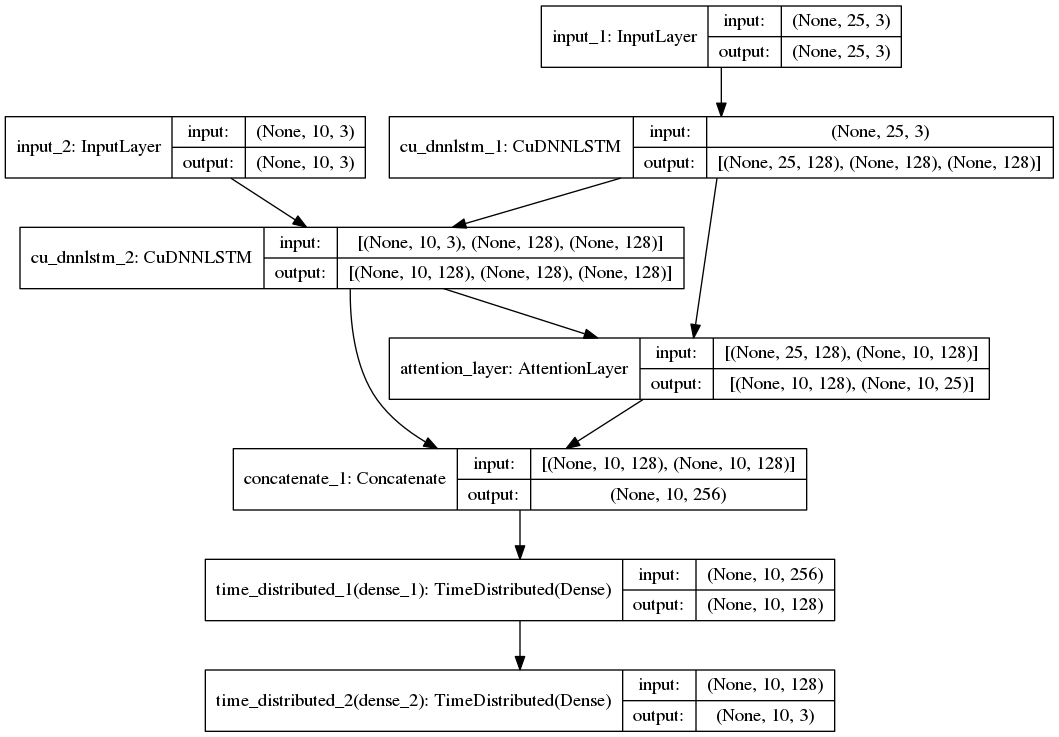

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

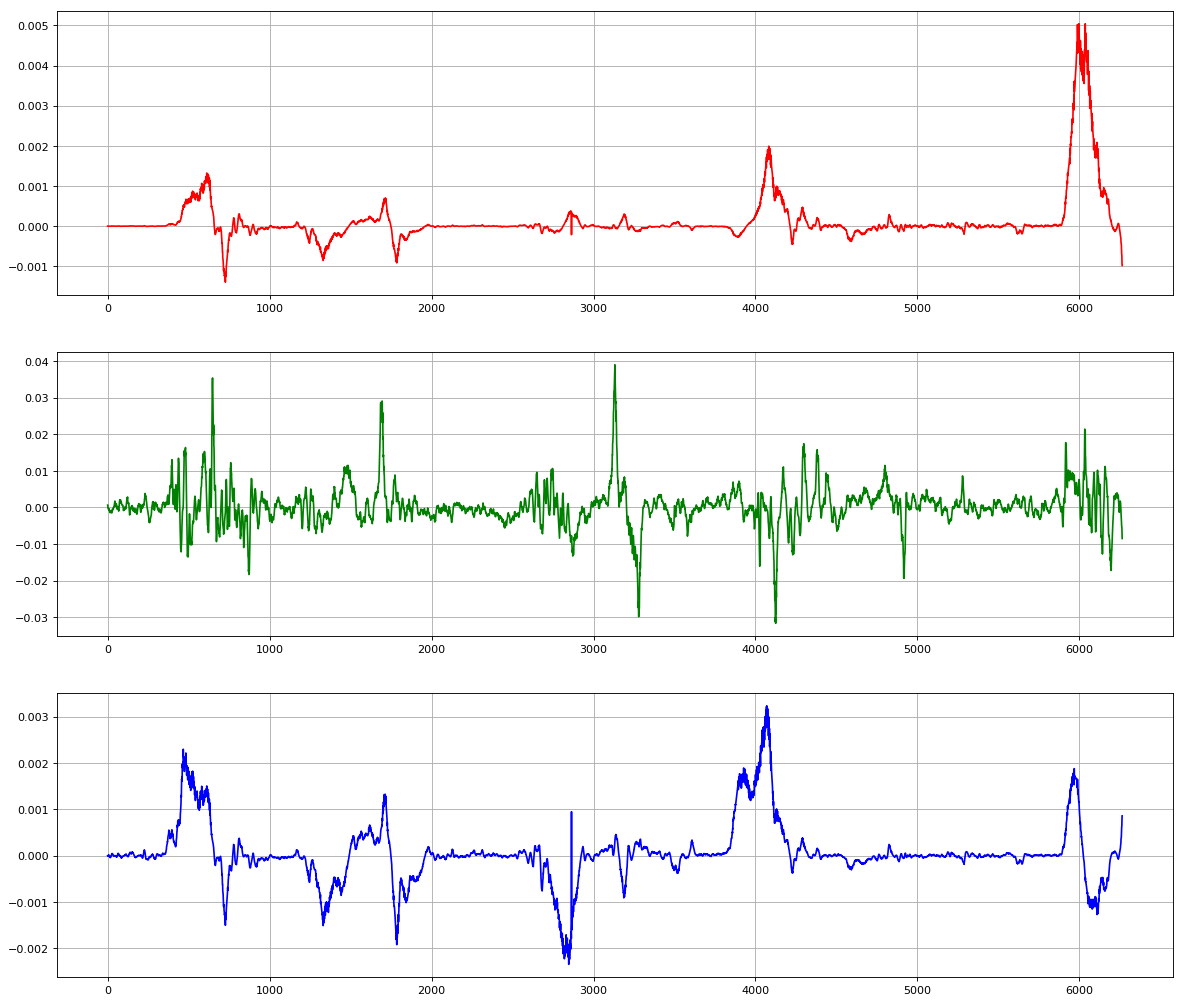

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 12:05 - loss: 0.0639 - rmse: 0.1871 - smape: 91.1229 - mfe: 4.6221e-04

  2/542 [..............................] - ETA: 6:53 - loss: 0.0711 - rmse: 0.2015 - smape: 87.1611 - mfe: 1.4954e-04 

  3/542 [..............................] - ETA: 5:10 - loss: 0.0740 - rmse: 0.2118 - smape: 83.8582 - mfe: 0.0046    

  4/542 [..............................] - ETA: 4:18 - loss: 0.0739 - rmse: 0.2078 - smape: 83.3305 - mfe: 0.0050

  5/542 [..............................] - ETA: 3:47 - loss: 0.0821 - rmse: 0.2285 - smape: 83.6048 - mfe: 0.0038

  6/542 [..............................] - ETA: 3:26 - loss: 0.0752 - rmse: 0.2144 - smape: 83.0388 - mfe: 0.0029

  7/542 [..............................] - ETA: 3:11 - loss: 0.0671 - rmse: 0.1895 - smape: 82.2489 - mfe: 0.0021

  8/542 [..............................] - ETA: 3:00 - loss: 0.0726 - rmse: 0.1972 - smape: 82.6369 - mfe: 0.0016

  9/542 [..............................] - ETA: 2:51 - loss: 0.0672 - rmse: 0.1810 - smape: 82.1821 - mfe: 0.0015

 10/542 [..............................] - ETA: 2:45 - loss: 0.0649 - rmse: 0.1785 - smape: 82.3988 - mfe: 0.0016

 11/542 [..............................] - ETA: 2:38 - loss: 0.0652 - rmse: 0.1810 - smape: 82.4329 - mfe: 0.0017

 12/542 [..............................] - ETA: 2:33 - loss: 0.0607 - rmse: 0.1681 - smape: 82.1900 - mfe: 0.0016

 13/542 [..............................] - ETA: 2:29 - loss: 0.0627 - rmse: 0.1731 - smape: 82.3346 - mfe: 0.0015

 14/542 [..............................] - ETA: 2:25 - loss: 0.0624 - rmse: 0.1716 - smape: 82.4114 - mfe: 0.0012

 15/542 [..............................] - ETA: 2:22 - loss: 0.0665 - rmse: 0.1803 - smape: 82.4163 - mfe: 9.2561e-04

 16/542 [..............................] - ETA: 2:20 - loss: 0.0700 - rmse: 0.1879 - smape: 82.2340 - mfe: 5.6777e-04

 17/542 [..............................] - ETA: 2:17 - loss: 0.0703 - rmse: 0.1875 - smape: 82.2178 - mfe: 2.7366e-04

 18/542 [..............................] - ETA: 2:14 - loss: 0.0714 - rmse: 0.1882 - smape: 82.2185 - mfe: -7.9429e-05

 19/542 [>.............................] - ETA: 2:12 - loss: 0.0721 - rmse: 0.1910 - smape: 82.2161 - mfe: -4.3021e-04

 20/542 [>.............................] - ETA: 2:11 - loss: 0.0736 - rmse: 0.1962 - smape: 82.1510 - mfe: -5.5845e-04

 21/542 [>.............................] - ETA: 2:09 - loss: 0.0741 - rmse: 0.1979 - smape: 82.1063 - mfe: -5.6657e-04

 22/542 [>.............................] - ETA: 2:08 - loss: 0.0712 - rmse: 0.1900 - smape: 82.0475 - mfe: -4.1093e-04

 23/542 [>.............................] - ETA: 2:06 - loss: 0.0698 - rmse: 0.1884 - smape: 81.8018 - mfe: -4.4471e-04

 24/542 [>.............................] - ETA: 2:05 - loss: 0.0734 - rmse: 0.1959 - smape: 81.8179 - mfe: -4.1315e-04

 25/542 [>.............................] - ETA: 2:04 - loss: 0.0724 - rmse: 0.1930 - smape: 81.7617 - mfe: -6.1303e-04

 26/542 [>.............................] - ETA: 2:02 - loss: 0.0702 - rmse: 0.1870 - smape: 81.5908 - mfe: -8.6321e-04

 27/542 [>.............................] - ETA: 2:01 - loss: 0.0708 - rmse: 0.1884 - smape: 81.5153 - mfe: -8.6405e-04

 28/542 [>.............................] - ETA: 2:00 - loss: 0.0705 - rmse: 0.1871 - smape: 81.3601 - mfe: -7.2880e-04

 29/542 [>.............................] - ETA: 1:59 - loss: 0.0688 - rmse: 0.1822 - smape: 81.2236 - mfe: -3.9316e-04

 30/542 [>.............................] - ETA: 1:58 - loss: 0.0690 - rmse: 0.1849 - smape: 81.1262 - mfe: -2.1520e-04

 31/542 [>.............................] - ETA: 1:57 - loss: 0.0690 - rmse: 0.1849 - smape: 81.1321 - mfe: -1.4793e-04

 32/542 [>.............................] - ETA: 1:56 - loss: 0.0681 - rmse: 0.1816 - smape: 81.1616 - mfe: -2.1920e-04

 33/542 [>.............................] - ETA: 1:56 - loss: 0.0685 - rmse: 0.1821 - smape: 81.1980 - mfe: -3.9548e-04

 34/542 [>.............................] - ETA: 1:55 - loss: 0.0668 - rmse: 0.1777 - smape: 81.1977 - mfe: -6.0700e-04

 35/542 [>.............................] - ETA: 1:54 - loss: 0.0661 - rmse: 0.1754 - smape: 81.1099 - mfe: -7.2354e-04

 36/542 [>.............................] - ETA: 1:53 - loss: 0.0661 - rmse: 0.1758 - smape: 81.0993 - mfe: -7.4777e-04

 37/542 [=>............................] - ETA: 1:53 - loss: 0.0654 - rmse: 0.1742 - smape: 81.0874 - mfe: -7.2122e-04

 38/542 [=>............................] - ETA: 1:52 - loss: 0.0663 - rmse: 0.1760 - smape: 81.1611 - mfe: -7.2189e-04

 39/542 [=>............................] - ETA: 1:51 - loss: 0.0662 - rmse: 0.1767 - smape: 81.2000 - mfe: -7.1580e-04

 40/542 [=>............................] - ETA: 1:51 - loss: 0.0659 - rmse: 0.1752 - smape: 81.2292 - mfe: -6.6121e-04

 41/542 [=>............................] - ETA: 1:50 - loss: 0.0646 - rmse: 0.1718 - smape: 81.1549 - mfe: -5.8393e-04

 42/542 [=>............................] - ETA: 1:50 - loss: 0.0643 - rmse: 0.1722 - smape: 81.1669 - mfe: -5.6511e-04

 43/542 [=>............................] - ETA: 1:49 - loss: 0.0647 - rmse: 0.1729 - smape: 81.1722 - mfe: -5.8358e-04

 44/542 [=>............................] - ETA: 1:49 - loss: 0.0641 - rmse: 0.1711 - smape: 81.1842 - mfe: -5.9644e-04

 45/542 [=>............................] - ETA: 1:48 - loss: 0.0651 - rmse: 0.1735 - smape: 81.2095 - mfe: -5.7158e-04

 46/542 [=>............................] - ETA: 1:48 - loss: 0.0647 - rmse: 0.1724 - smape: 81.2386 - mfe: -5.4866e-04

 47/542 [=>............................] - ETA: 1:47 - loss: 0.0642 - rmse: 0.1709 - smape: 81.2209 - mfe: -4.8090e-04

 48/542 [=>............................] - ETA: 1:47 - loss: 0.0634 - rmse: 0.1685 - smape: 81.2314 - mfe: -4.3688e-04

 49/542 [=>............................] - ETA: 1:46 - loss: 0.0635 - rmse: 0.1692 - smape: 81.1594 - mfe: -3.9454e-04

 50/542 [=>............................] - ETA: 1:46 - loss: 0.0637 - rmse: 0.1695 - smape: 81.1127 - mfe: -3.7632e-04

 51/542 [=>............................] - ETA: 1:45 - loss: 0.0651 - rmse: 0.1736 - smape: 81.1186 - mfe: -2.9963e-04

 52/542 [=>............................] - ETA: 1:45 - loss: 0.0648 - rmse: 0.1724 - smape: 81.1675 - mfe: -3.2564e-04

 53/542 [=>............................] - ETA: 1:44 - loss: 0.0642 - rmse: 0.1708 - smape: 81.1264 - mfe: -3.9124e-04

 54/542 [=>............................] - ETA: 1:44 - loss: 0.0635 - rmse: 0.1689 - smape: 81.0865 - mfe: -4.3546e-04

 55/542 [==>...........................] - ETA: 1:43 - loss: 0.0628 - rmse: 0.1673 - smape: 81.0804 - mfe: -4.4297e-04

 56/542 [==>...........................] - ETA: 1:43 - loss: 0.0618 - rmse: 0.1647 - smape: 81.1026 - mfe: -3.9473e-04

 57/542 [==>...........................] - ETA: 1:43 - loss: 0.0623 - rmse: 0.1660 - smape: 81.1454 - mfe: -3.6548e-04

 58/542 [==>...........................] - ETA: 1:42 - loss: 0.0621 - rmse: 0.1658 - smape: 81.1949 - mfe: -3.3304e-04

 59/542 [==>...........................] - ETA: 1:41 - loss: 0.0614 - rmse: 0.1640 - smape: 81.2931 - mfe: -3.1500e-04

 60/542 [==>...........................] - ETA: 1:41 - loss: 0.0613 - rmse: 0.1638 - smape: 81.3293 - mfe: -3.0975e-04

 61/542 [==>...........................] - ETA: 1:41 - loss: 0.0611 - rmse: 0.1632 - smape: 81.2952 - mfe: -3.5741e-04

 62/542 [==>...........................] - ETA: 1:40 - loss: 0.0607 - rmse: 0.1623 - smape: 81.3373 - mfe: -3.9560e-04

 63/542 [==>...........................] - ETA: 1:40 - loss: 0.0611 - rmse: 0.1635 - smape: 81.3693 - mfe: -4.2388e-04

 64/542 [==>...........................] - ETA: 1:40 - loss: 0.0608 - rmse: 0.1625 - smape: 81.3919 - mfe: -3.7782e-04

 65/542 [==>...........................] - ETA: 1:39 - loss: 0.0600 - rmse: 0.1603 - smape: 81.4330 - mfe: -3.2916e-04

 66/542 [==>...........................] - ETA: 1:39 - loss: 0.0610 - rmse: 0.1634 - smape: 81.4016 - mfe: -2.2777e-04

 67/542 [==>...........................] - ETA: 1:39 - loss: 0.0605 - rmse: 0.1618 - smape: 81.3857 - mfe: -2.3483e-04

 68/542 [==>...........................] - ETA: 1:38 - loss: 0.0604 - rmse: 0.1612 - smape: 81.3633 - mfe: -2.6568e-04

 69/542 [==>...........................] - ETA: 1:38 - loss: 0.0615 - rmse: 0.1645 - smape: 81.3541 - mfe: -3.3623e-04

 70/542 [==>...........................] - ETA: 1:38 - loss: 0.0616 - rmse: 0.1650 - smape: 81.3238 - mfe: -3.9846e-04

 71/542 [==>...........................] - ETA: 1:38 - loss: 0.0616 - rmse: 0.1650 - smape: 81.3148 - mfe: -4.3150e-04

 72/542 [==>...........................] - ETA: 1:37 - loss: 0.0628 - rmse: 0.1679 - smape: 81.2727 - mfe: -4.5538e-04

 73/542 [===>..........................] - ETA: 1:37 - loss: 0.0630 - rmse: 0.1685 - smape: 81.2440 - mfe: -4.5652e-04

 74/542 [===>..........................] - ETA: 1:37 - loss: 0.0630 - rmse: 0.1689 - smape: 81.2408 - mfe: -4.4528e-04

 75/542 [===>..........................] - ETA: 1:36 - loss: 0.0629 - rmse: 0.1686 - smape: 81.2434 - mfe: -4.4449e-04

 76/542 [===>..........................] - ETA: 1:36 - loss: 0.0628 - rmse: 0.1685 - smape: 81.2616 - mfe: -4.5125e-04

 77/542 [===>..........................] - ETA: 1:36 - loss: 0.0630 - rmse: 0.1693 - smape: 81.2672 - mfe: -4.2494e-04

 78/542 [===>..........................] - ETA: 1:35 - loss: 0.0625 - rmse: 0.1679 - smape: 81.2670 - mfe: -4.1462e-04

 79/542 [===>..........................] - ETA: 1:35 - loss: 0.0624 - rmse: 0.1675 - smape: 81.3097 - mfe: -4.0995e-04

 80/542 [===>..........................] - ETA: 1:35 - loss: 0.0621 - rmse: 0.1667 - smape: 81.3406 - mfe: -4.0052e-04

 81/542 [===>..........................] - ETA: 1:34 - loss: 0.0622 - rmse: 0.1668 - smape: 81.3624 - mfe: -3.9407e-04

 82/542 [===>..........................] - ETA: 1:34 - loss: 0.0625 - rmse: 0.1675 - smape: 81.3557 - mfe: -4.1817e-04

 83/542 [===>..........................] - ETA: 1:34 - loss: 0.0623 - rmse: 0.1671 - smape: 81.3522 - mfe: -4.5335e-04

 84/542 [===>..........................] - ETA: 1:33 - loss: 0.0626 - rmse: 0.1689 - smape: 81.2652 - mfe: -4.7776e-04

 85/542 [===>..........................] - ETA: 1:33 - loss: 0.0630 - rmse: 0.1696 - smape: 81.2418 - mfe: -5.1755e-04

 86/542 [===>..........................] - ETA: 1:33 - loss: 0.0628 - rmse: 0.1699 - smape: 81.2574 - mfe: -5.2174e-04

 87/542 [===>..........................] - ETA: 1:33 - loss: 0.0630 - rmse: 0.1709 - smape: 81.2103 - mfe: -5.2693e-04

 88/542 [===>..........................] - ETA: 1:32 - loss: 0.0631 - rmse: 0.1712 - smape: 81.2104 - mfe: -5.2362e-04

 89/542 [===>..........................] - ETA: 1:32 - loss: 0.0629 - rmse: 0.1707 - smape: 81.2227 - mfe: -5.4270e-04

 90/542 [===>..........................] - ETA: 1:32 - loss: 0.0628 - rmse: 0.1703 - smape: 81.2085 - mfe: -5.2620e-04

 91/542 [====>.........................] - ETA: 1:31 - loss: 0.0626 - rmse: 0.1700 - smape: 81.1813 - mfe: -4.8799e-04

 92/542 [====>.........................] - ETA: 1:31 - loss: 0.0627 - rmse: 0.1701 - smape: 81.1593 - mfe: -4.5434e-04

 93/542 [====>.........................] - ETA: 1:31 - loss: 0.0625 - rmse: 0.1699 - smape: 81.1508 - mfe: -4.0698e-04

 94/542 [====>.........................] - ETA: 1:31 - loss: 0.0623 - rmse: 0.1695 - smape: 81.1365 - mfe: -3.9673e-04

 95/542 [====>.........................] - ETA: 1:30 - loss: 0.0622 - rmse: 0.1692 - smape: 81.1280 - mfe: -3.7813e-04

 96/542 [====>.........................] - ETA: 1:30 - loss: 0.0624 - rmse: 0.1693 - smape: 81.1275 - mfe: -3.7586e-04

 97/542 [====>.........................] - ETA: 1:30 - loss: 0.0624 - rmse: 0.1693 - smape: 81.1392 - mfe: -3.8366e-04

 98/542 [====>.........................] - ETA: 1:29 - loss: 0.0625 - rmse: 0.1695 - smape: 81.1084 - mfe: -4.0422e-04

 99/542 [====>.........................] - ETA: 1:29 - loss: 0.0625 - rmse: 0.1694 - smape: 81.1014 - mfe: -4.5252e-04

100/542 [====>.........................] - ETA: 1:29 - loss: 0.0622 - rmse: 0.1683 - smape: 81.0863 - mfe: -5.0767e-04

101/542 [====>.........................] - ETA: 1:29 - loss: 0.0621 - rmse: 0.1690 - smape: 81.0584 - mfe: -5.3880e-04

102/542 [====>.........................] - ETA: 1:28 - loss: 0.0620 - rmse: 0.1689 - smape: 81.0662 - mfe: -5.3813e-04

103/542 [====>.........................] - ETA: 1:28 - loss: 0.0617 - rmse: 0.1681 - smape: 81.0786 - mfe: -5.1799e-04

104/542 [====>.........................] - ETA: 1:28 - loss: 0.0615 - rmse: 0.1676 - smape: 81.0858 - mfe: -5.0555e-04

105/542 [====>.........................] - ETA: 1:28 - loss: 0.0611 - rmse: 0.1666 - smape: 81.1084 - mfe: -4.9039e-04

106/542 [====>.........................] - ETA: 1:27 - loss: 0.0612 - rmse: 0.1663 - smape: 81.1449 - mfe: -4.7406e-04

107/542 [====>.........................] - ETA: 1:27 - loss: 0.0610 - rmse: 0.1659 - smape: 81.1487 - mfe: -4.5466e-04

108/542 [====>.........................] - ETA: 1:27 - loss: 0.0610 - rmse: 0.1661 - smape: 81.1805 - mfe: -4.6735e-04

109/542 [=====>........................] - ETA: 1:27 - loss: 0.0609 - rmse: 0.1661 - smape: 81.1543 - mfe: -4.7458e-04

110/542 [=====>........................] - ETA: 1:26 - loss: 0.0609 - rmse: 0.1659 - smape: 81.1697 - mfe: -4.8770e-04

111/542 [=====>........................] - ETA: 1:26 - loss: 0.0611 - rmse: 0.1665 - smape: 81.1811 - mfe: -4.8158e-04

112/542 [=====>........................] - ETA: 1:26 - loss: 0.0609 - rmse: 0.1658 - smape: 81.1569 - mfe: -5.0169e-04

113/542 [=====>........................] - ETA: 1:26 - loss: 0.0610 - rmse: 0.1661 - smape: 81.1418 - mfe: -5.0258e-04

114/542 [=====>........................] - ETA: 1:25 - loss: 0.0608 - rmse: 0.1657 - smape: 81.1350 - mfe: -5.3768e-04

115/542 [=====>........................] - ETA: 1:25 - loss: 0.0607 - rmse: 0.1650 - smape: 81.1786 - mfe: -5.1544e-04

116/542 [=====>........................] - ETA: 1:25 - loss: 0.0606 - rmse: 0.1648 - smape: 81.1897 - mfe: -4.6845e-04

117/542 [=====>........................] - ETA: 1:25 - loss: 0.0608 - rmse: 0.1651 - smape: 81.2085 - mfe: -4.3320e-04

118/542 [=====>........................] - ETA: 1:25 - loss: 0.0609 - rmse: 0.1651 - smape: 81.2304 - mfe: -4.2105e-04

119/542 [=====>........................] - ETA: 1:24 - loss: 0.0610 - rmse: 0.1655 - smape: 81.2322 - mfe: -4.4975e-04

120/542 [=====>........................] - ETA: 1:24 - loss: 0.0610 - rmse: 0.1656 - smape: 81.2460 - mfe: -4.7083e-04

121/542 [=====>........................] - ETA: 1:24 - loss: 0.0610 - rmse: 0.1659 - smape: 81.2548 - mfe: -4.4807e-04

122/542 [=====>........................] - ETA: 1:24 - loss: 0.0610 - rmse: 0.1660 - smape: 81.2487 - mfe: -4.2628e-04

123/542 [=====>........................] - ETA: 1:23 - loss: 0.0608 - rmse: 0.1654 - smape: 81.2612 - mfe: -3.8737e-04

124/542 [=====>........................] - ETA: 1:23 - loss: 0.0606 - rmse: 0.1649 - smape: 81.2599 - mfe: -3.6462e-04

125/542 [=====>........................] - ETA: 1:23 - loss: 0.0607 - rmse: 0.1651 - smape: 81.2706 - mfe: -3.3244e-04

126/542 [=====>........................] - ETA: 1:23 - loss: 0.0608 - rmse: 0.1652 - smape: 81.2635 - mfe: -3.1432e-04

127/542 [======>.......................] - ETA: 1:22 - loss: 0.0609 - rmse: 0.1653 - smape: 81.2743 - mfe: -3.1133e-04

128/542 [======>.......................] - ETA: 1:22 - loss: 0.0609 - rmse: 0.1655 - smape: 81.2764 - mfe: -2.9904e-04

129/542 [======>.......................] - ETA: 1:22 - loss: 0.0611 - rmse: 0.1661 - smape: 81.2651 - mfe: -2.9387e-04

130/542 [======>.......................] - ETA: 1:22 - loss: 0.0607 - rmse: 0.1653 - smape: 81.2493 - mfe: -2.6727e-04

131/542 [======>.......................] - ETA: 1:22 - loss: 0.0607 - rmse: 0.1652 - smape: 81.2564 - mfe: -2.5881e-04

132/542 [======>.......................] - ETA: 1:21 - loss: 0.0607 - rmse: 0.1652 - smape: 81.2543 - mfe: -2.6524e-04

133/542 [======>.......................] - ETA: 1:21 - loss: 0.0608 - rmse: 0.1653 - smape: 81.2725 - mfe: -2.7785e-04

134/542 [======>.......................] - ETA: 1:21 - loss: 0.0609 - rmse: 0.1656 - smape: 81.2777 - mfe: -2.9341e-04

135/542 [======>.......................] - ETA: 1:21 - loss: 0.0610 - rmse: 0.1663 - smape: 81.2631 - mfe: -3.0274e-04

136/542 [======>.......................] - ETA: 1:20 - loss: 0.0607 - rmse: 0.1655 - smape: 81.2435 - mfe: -3.1528e-04

137/542 [======>.......................] - ETA: 1:20 - loss: 0.0607 - rmse: 0.1656 - smape: 81.2598 - mfe: -3.0712e-04

138/542 [======>.......................] - ETA: 1:20 - loss: 0.0606 - rmse: 0.1652 - smape: 81.2886 - mfe: -2.8231e-04

139/542 [======>.......................] - ETA: 1:20 - loss: 0.0606 - rmse: 0.1655 - smape: 81.2856 - mfe: -2.4217e-04

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0610 - rmse: 0.1662 - smape: 81.2996 - mfe: -1.9608e-04

141/542 [======>.......................] - ETA: 1:19 - loss: 0.0610 - rmse: 0.1663 - smape: 81.3015 - mfe: -1.4818e-04

142/542 [======>.......................] - ETA: 1:19 - loss: 0.0611 - rmse: 0.1664 - smape: 81.2695 - mfe: -8.8304e-05

143/542 [======>.......................] - ETA: 1:19 - loss: 0.0611 - rmse: 0.1664 - smape: 81.2780 - mfe: -6.6096e-05

144/542 [======>.......................] - ETA: 1:19 - loss: 0.0610 - rmse: 0.1667 - smape: 81.2584 - mfe: -6.5794e-05

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0610 - rmse: 0.1669 - smape: 81.2845 - mfe: -8.8057e-05

146/542 [=======>......................] - ETA: 1:18 - loss: 0.0609 - rmse: 0.1664 - smape: 81.2481 - mfe: -1.0457e-04

147/542 [=======>......................] - ETA: 1:18 - loss: 0.0608 - rmse: 0.1663 - smape: 81.2357 - mfe: -1.2018e-04

148/542 [=======>......................] - ETA: 1:18 - loss: 0.0609 - rmse: 0.1666 - smape: 81.2243 - mfe: -1.3083e-04

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0614 - rmse: 0.1682 - smape: 81.1860 - mfe: -1.1041e-04

150/542 [=======>......................] - ETA: 1:17 - loss: 0.0614 - rmse: 0.1681 - smape: 81.1762 - mfe: -1.2729e-04

151/542 [=======>......................] - ETA: 1:17 - loss: 0.0612 - rmse: 0.1677 - smape: 81.1806 - mfe: -1.3229e-04

152/542 [=======>......................] - ETA: 1:17 - loss: 0.0612 - rmse: 0.1676 - smape: 81.1665 - mfe: -1.2939e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0617 - rmse: 0.1685 - smape: 81.1741 - mfe: -8.8886e-05

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0620 - rmse: 0.1693 - smape: 81.1845 - mfe: -4.1458e-05

155/542 [=======>......................] - ETA: 1:16 - loss: 0.0619 - rmse: 0.1690 - smape: 81.1711 - mfe: -6.9227e-07

156/542 [=======>......................] - ETA: 1:16 - loss: 0.0622 - rmse: 0.1696 - smape: 81.1400 - mfe: 3.6202e-05 

157/542 [=======>......................] - ETA: 1:16 - loss: 0.0621 - rmse: 0.1693 - smape: 81.1218 - mfe: 3.8117e-05

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0621 - rmse: 0.1693 - smape: 81.0946 - mfe: 6.6399e-05

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0622 - rmse: 0.1697 - smape: 81.0752 - mfe: 1.1975e-04

160/542 [=======>......................] - ETA: 1:15 - loss: 0.0625 - rmse: 0.1704 - smape: 81.0558 - mfe: 1.4002e-04

161/542 [=======>......................] - ETA: 1:15 - loss: 0.0624 - rmse: 0.1704 - smape: 81.0288 - mfe: 6.8139e-05

162/542 [=======>......................] - ETA: 1:15 - loss: 0.0623 - rmse: 0.1701 - smape: 81.0025 - mfe: 6.7214e-05

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0623 - rmse: 0.1700 - smape: 80.9907 - mfe: 8.0901e-05

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0623 - rmse: 0.1700 - smape: 80.9909 - mfe: 1.1319e-04

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0624 - rmse: 0.1702 - smape: 81.0057 - mfe: 1.4390e-04

166/542 [========>.....................] - ETA: 1:14 - loss: 0.0625 - rmse: 0.1707 - smape: 81.0032 - mfe: 1.7090e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0625 - rmse: 0.1705 - smape: 81.0312 - mfe: 1.7087e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0626 - rmse: 0.1706 - smape: 81.0487 - mfe: 1.5240e-04

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0629 - rmse: 0.1714 - smape: 81.0564 - mfe: 1.3312e-04

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0627 - rmse: 0.1708 - smape: 81.0837 - mfe: 1.2662e-04

171/542 [========>.....................] - ETA: 1:13 - loss: 0.0625 - rmse: 0.1705 - smape: 81.0648 - mfe: 1.2474e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0625 - rmse: 0.1705 - smape: 81.0860 - mfe: 1.2283e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0623 - rmse: 0.1700 - smape: 81.0533 - mfe: 1.3237e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0623 - rmse: 0.1701 - smape: 81.0632 - mfe: 1.2713e-04

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0622 - rmse: 0.1696 - smape: 81.0771 - mfe: 1.3734e-04

176/542 [========>.....................] - ETA: 1:12 - loss: 0.0621 - rmse: 0.1695 - smape: 81.0818 - mfe: 1.2559e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0621 - rmse: 0.1694 - smape: 81.0895 - mfe: 1.2490e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0623 - rmse: 0.1701 - smape: 81.0803 - mfe: 1.2867e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0622 - rmse: 0.1698 - smape: 81.0665 - mfe: 1.1228e-04

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0625 - rmse: 0.1707 - smape: 81.0691 - mfe: 7.8516e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0627 - rmse: 0.1710 - smape: 81.0752 - mfe: 7.1179e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0626 - rmse: 0.1711 - smape: 81.0652 - mfe: 8.8825e-05

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0627 - rmse: 0.1716 - smape: 81.0644 - mfe: 8.9058e-05

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0627 - rmse: 0.1715 - smape: 81.0611 - mfe: 7.7709e-05

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0626 - rmse: 0.1714 - smape: 81.0614 - mfe: 6.1929e-05

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0628 - rmse: 0.1717 - smape: 81.0510 - mfe: 4.7165e-05

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0628 - rmse: 0.1716 - smape: 81.0396 - mfe: 5.3193e-05

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0629 - rmse: 0.1717 - smape: 81.0317 - mfe: 5.8950e-05

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0630 - rmse: 0.1722 - smape: 81.0076 - mfe: 6.3065e-05

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0630 - rmse: 0.1722 - smape: 80.9953 - mfe: 6.3085e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0631 - rmse: 0.1725 - smape: 80.9821 - mfe: 7.3646e-05

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0630 - rmse: 0.1723 - smape: 80.9645 - mfe: 7.5108e-05

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0629 - rmse: 0.1718 - smape: 80.9693 - mfe: 6.9199e-05

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0626 - rmse: 0.1712 - smape: 80.9524 - mfe: 5.9599e-05

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0627 - rmse: 0.1712 - smape: 80.9497 - mfe: 6.5670e-05

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0625 - rmse: 0.1708 - smape: 80.9453 - mfe: 6.9975e-05

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0624 - rmse: 0.1705 - smape: 80.9336 - mfe: 7.0598e-05

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0625 - rmse: 0.1706 - smape: 80.9181 - mfe: 8.3753e-05

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0624 - rmse: 0.1704 - smape: 80.9122 - mfe: 9.5066e-05

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1703 - smape: 80.8910 - mfe: 9.8749e-05

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1698 - smape: 80.8875 - mfe: 9.9001e-05

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1698 - smape: 80.8914 - mfe: 1.0400e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1695 - smape: 80.9032 - mfe: 1.0477e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1698 - smape: 80.9079 - mfe: 1.0502e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0623 - rmse: 0.1701 - smape: 80.9054 - mfe: 1.0209e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0623 - rmse: 0.1701 - smape: 80.9061 - mfe: 1.0239e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0623 - rmse: 0.1702 - smape: 80.8970 - mfe: 1.0181e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0621 - rmse: 0.1695 - smape: 80.8816 - mfe: 9.9059e-05

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0621 - rmse: 0.1694 - smape: 80.8865 - mfe: 9.3280e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0619 - rmse: 0.1689 - smape: 80.8907 - mfe: 9.4765e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0619 - rmse: 0.1688 - smape: 80.8796 - mfe: 1.0657e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0618 - rmse: 0.1685 - smape: 80.8600 - mfe: 1.1736e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0619 - rmse: 0.1688 - smape: 80.8429 - mfe: 1.3622e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0619 - rmse: 0.1687 - smape: 80.8297 - mfe: 1.4720e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1697 - smape: 80.8118 - mfe: 1.5428e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1695 - smape: 80.7890 - mfe: 1.5623e-04

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0621 - rmse: 0.1693 - smape: 80.7610 - mfe: 1.5395e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1696 - smape: 80.7469 - mfe: 1.4105e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1697 - smape: 80.7278 - mfe: 1.3864e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0622 - rmse: 0.1699 - smape: 80.6969 - mfe: 1.1350e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0622 - rmse: 0.1700 - smape: 80.6708 - mfe: 9.6973e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0622 - rmse: 0.1699 - smape: 80.6564 - mfe: 1.0993e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0624 - rmse: 0.1704 - smape: 80.6424 - mfe: 9.8488e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0624 - rmse: 0.1702 - smape: 80.6449 - mfe: 9.0535e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0624 - rmse: 0.1701 - smape: 80.6492 - mfe: 9.1654e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0625 - rmse: 0.1703 - smape: 80.6351 - mfe: 9.9052e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0625 - rmse: 0.1702 - smape: 80.6046 - mfe: 1.1146e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0622 - rmse: 0.1696 - smape: 80.5994 - mfe: 1.2516e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0622 - rmse: 0.1694 - smape: 80.5975 - mfe: 1.1066e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0625 - rmse: 0.1700 - smape: 80.5899 - mfe: 7.2498e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0625 - rmse: 0.1699 - smape: 80.5757 - mfe: 4.8906e-05

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0623 - rmse: 0.1694 - smape: 80.5700 - mfe: 2.9733e-05

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0622 - rmse: 0.1695 - smape: 80.5639 - mfe: 3.0100e-05

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0621 - rmse: 0.1693 - smape: 80.5632 - mfe: 3.6161e-05

235/542 [============>.................] - ETA: 59s - loss: 0.0620 - rmse: 0.1690 - smape: 80.5574 - mfe: 5.6879e-05 

236/542 [============>.................] - ETA: 59s - loss: 0.0620 - rmse: 0.1690 - smape: 80.5452 - mfe: 8.2279e-05

237/542 [============>.................] - ETA: 59s - loss: 0.0620 - rmse: 0.1690 - smape: 80.5368 - mfe: 1.0045e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0620 - rmse: 0.1687 - smape: 80.5293 - mfe: 9.7874e-05

239/542 [============>.................] - ETA: 59s - loss: 0.0619 - rmse: 0.1686 - smape: 80.5369 - mfe: 9.6312e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0619 - rmse: 0.1687 - smape: 80.5296 - mfe: 1.1028e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0619 - rmse: 0.1684 - smape: 80.5206 - mfe: 1.1959e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0617 - rmse: 0.1681 - smape: 80.5323 - mfe: 1.2179e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0619 - rmse: 0.1684 - smape: 80.5174 - mfe: 1.2253e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0620 - rmse: 0.1684 - smape: 80.4988 - mfe: 1.0427e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0619 - rmse: 0.1685 - smape: 80.4818 - mfe: 7.5406e-05

246/542 [============>.................] - ETA: 57s - loss: 0.0620 - rmse: 0.1688 - smape: 80.4517 - mfe: 5.9365e-05

247/542 [============>.................] - ETA: 57s - loss: 0.0619 - rmse: 0.1689 - smape: 80.4395 - mfe: 6.7589e-05

248/542 [============>.................] - ETA: 57s - loss: 0.0618 - rmse: 0.1686 - smape: 80.4377 - mfe: 8.0752e-05

249/542 [============>.................] - ETA: 57s - loss: 0.0617 - rmse: 0.1683 - smape: 80.3999 - mfe: 6.2564e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0616 - rmse: 0.1681 - smape: 80.3909 - mfe: 3.4322e-05

251/542 [============>.................] - ETA: 56s - loss: 0.0616 - rmse: 0.1682 - smape: 80.3708 - mfe: 1.2200e-05

252/542 [============>.................] - ETA: 56s - loss: 0.0618 - rmse: 0.1686 - smape: 80.3607 - mfe: 1.0918e-05

253/542 [=============>................] - ETA: 56s - loss: 0.0617 - rmse: 0.1684 - smape: 80.3507 - mfe: 1.8961e-05

254/542 [=============>................] - ETA: 56s - loss: 0.0617 - rmse: 0.1685 - smape: 80.3359 - mfe: 4.7678e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0617 - rmse: 0.1684 - smape: 80.3184 - mfe: 7.4442e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0617 - rmse: 0.1686 - smape: 80.2984 - mfe: 9.0920e-05

257/542 [=============>................] - ETA: 55s - loss: 0.0616 - rmse: 0.1683 - smape: 80.2985 - mfe: 9.7925e-05

258/542 [=============>................] - ETA: 55s - loss: 0.0614 - rmse: 0.1678 - smape: 80.2991 - mfe: 9.8023e-05

259/542 [=============>................] - ETA: 55s - loss: 0.0615 - rmse: 0.1682 - smape: 80.2870 - mfe: 8.9261e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0615 - rmse: 0.1680 - smape: 80.2850 - mfe: 7.2618e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0616 - rmse: 0.1682 - smape: 80.2727 - mfe: 5.2637e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0617 - rmse: 0.1684 - smape: 80.2692 - mfe: 4.5731e-05

263/542 [=============>................] - ETA: 54s - loss: 0.0616 - rmse: 0.1683 - smape: 80.2708 - mfe: 4.2871e-05

264/542 [=============>................] - ETA: 54s - loss: 0.0619 - rmse: 0.1690 - smape: 80.2670 - mfe: 5.3516e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0620 - rmse: 0.1693 - smape: 80.2654 - mfe: 5.3301e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0619 - rmse: 0.1692 - smape: 80.2517 - mfe: 4.8603e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0619 - rmse: 0.1692 - smape: 80.2535 - mfe: 4.4153e-05

268/542 [=============>................] - ETA: 53s - loss: 0.0618 - rmse: 0.1690 - smape: 80.2460 - mfe: 4.3552e-05

269/542 [=============>................] - ETA: 52s - loss: 0.0618 - rmse: 0.1688 - smape: 80.2509 - mfe: 3.9870e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0617 - rmse: 0.1686 - smape: 80.2385 - mfe: 3.7935e-05

271/542 [==============>...............] - ETA: 52s - loss: 0.0620 - rmse: 0.1691 - smape: 80.2353 - mfe: 4.2833e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0621 - rmse: 0.1696 - smape: 80.2387 - mfe: 5.2551e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0620 - rmse: 0.1692 - smape: 80.2293 - mfe: 5.7120e-05

274/542 [==============>...............] - ETA: 51s - loss: 0.0621 - rmse: 0.1694 - smape: 80.2066 - mfe: 7.0670e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0621 - rmse: 0.1694 - smape: 80.2017 - mfe: 7.5842e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0620 - rmse: 0.1692 - smape: 80.1999 - mfe: 7.2493e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0619 - rmse: 0.1690 - smape: 80.1835 - mfe: 7.0259e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0618 - rmse: 0.1690 - smape: 80.1784 - mfe: 7.3923e-05

279/542 [==============>...............] - ETA: 50s - loss: 0.0619 - rmse: 0.1691 - smape: 80.1631 - mfe: 8.3083e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0618 - rmse: 0.1691 - smape: 80.1598 - mfe: 9.8229e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0618 - rmse: 0.1690 - smape: 80.1526 - mfe: 1.0622e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0620 - rmse: 0.1694 - smape: 80.1440 - mfe: 9.2441e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0618 - rmse: 0.1689 - smape: 80.1258 - mfe: 6.6557e-05

284/542 [==============>...............] - ETA: 49s - loss: 0.0617 - rmse: 0.1687 - smape: 80.1030 - mfe: 6.3955e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0617 - rmse: 0.1686 - smape: 80.0997 - mfe: 5.7980e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0618 - rmse: 0.1690 - smape: 80.0891 - mfe: 7.4353e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0618 - rmse: 0.1689 - smape: 80.0807 - mfe: 9.4173e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0617 - rmse: 0.1687 - smape: 80.0802 - mfe: 1.0894e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0616 - rmse: 0.1685 - smape: 80.0737 - mfe: 1.1890e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0617 - rmse: 0.1685 - smape: 80.0736 - mfe: 1.3375e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0615 - rmse: 0.1682 - smape: 80.0661 - mfe: 1.3154e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0615 - rmse: 0.1681 - smape: 80.0703 - mfe: 1.3483e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0615 - rmse: 0.1680 - smape: 80.0700 - mfe: 1.3513e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0615 - rmse: 0.1680 - smape: 80.0721 - mfe: 1.4685e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0617 - rmse: 0.1684 - smape: 80.0671 - mfe: 1.7414e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0620 - rmse: 0.1691 - smape: 80.0520 - mfe: 2.3057e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0619 - rmse: 0.1690 - smape: 80.0394 - mfe: 2.5785e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0620 - rmse: 0.1691 - smape: 80.0280 - mfe: 2.7705e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0619 - rmse: 0.1691 - smape: 80.0120 - mfe: 2.8643e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0619 - rmse: 0.1691 - smape: 80.0045 - mfe: 2.6971e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0619 - rmse: 0.1690 - smape: 79.9970 - mfe: 2.5946e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0619 - rmse: 0.1691 - smape: 79.9803 - mfe: 2.6387e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0619 - rmse: 0.1691 - smape: 79.9720 - mfe: 2.6757e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0620 - rmse: 0.1693 - smape: 79.9640 - mfe: 2.7596e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0620 - rmse: 0.1695 - smape: 79.9540 - mfe: 2.8114e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0620 - rmse: 0.1693 - smape: 79.9501 - mfe: 2.6956e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0620 - rmse: 0.1693 - smape: 79.9395 - mfe: 2.6009e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0619 - rmse: 0.1690 - smape: 79.9358 - mfe: 2.5687e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0619 - rmse: 0.1692 - smape: 79.9320 - mfe: 2.6104e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0620 - rmse: 0.1693 - smape: 79.9296 - mfe: 2.6844e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1691 - smape: 79.9273 - mfe: 2.7272e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1690 - smape: 79.9300 - mfe: 2.6846e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1691 - smape: 79.9210 - mfe: 2.5787e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1690 - smape: 79.9131 - mfe: 2.3866e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0618 - rmse: 0.1688 - smape: 79.9015 - mfe: 2.2045e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8956 - mfe: 1.9677e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1691 - smape: 79.8955 - mfe: 1.9374e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8921 - mfe: 1.9595e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1691 - smape: 79.8829 - mfe: 2.0636e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8822 - mfe: 2.1516e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8745 - mfe: 2.1446e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0618 - rmse: 0.1687 - smape: 79.8678 - mfe: 1.9966e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0617 - rmse: 0.1685 - smape: 79.8623 - mfe: 1.7872e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0617 - rmse: 0.1682 - smape: 79.8563 - mfe: 1.7051e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0619 - rmse: 0.1688 - smape: 79.8502 - mfe: 1.7288e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0620 - rmse: 0.1689 - smape: 79.8382 - mfe: 1.8689e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0620 - rmse: 0.1693 - smape: 79.8317 - mfe: 2.0357e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0619 - rmse: 0.1689 - smape: 79.8227 - mfe: 2.0890e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0618 - rmse: 0.1687 - smape: 79.8177 - mfe: 1.9427e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0618 - rmse: 0.1687 - smape: 79.8098 - mfe: 1.8365e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0619 - rmse: 0.1688 - smape: 79.7944 - mfe: 1.8051e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0619 - rmse: 0.1691 - smape: 79.7877 - mfe: 1.9471e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0620 - rmse: 0.1693 - smape: 79.7727 - mfe: 2.0312e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0620 - rmse: 0.1693 - smape: 79.7673 - mfe: 2.1502e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0620 - rmse: 0.1694 - smape: 79.7573 - mfe: 2.2144e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0621 - rmse: 0.1695 - smape: 79.7464 - mfe: 2.2035e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0621 - rmse: 0.1696 - smape: 79.7422 - mfe: 2.2409e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0620 - rmse: 0.1695 - smape: 79.7245 - mfe: 2.2649e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0620 - rmse: 0.1694 - smape: 79.7120 - mfe: 2.1469e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0620 - rmse: 0.1695 - smape: 79.7072 - mfe: 2.0474e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0621 - rmse: 0.1697 - smape: 79.6944 - mfe: 2.0481e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0621 - rmse: 0.1697 - smape: 79.6912 - mfe: 2.1118e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0622 - rmse: 0.1698 - smape: 79.6891 - mfe: 2.1877e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0621 - rmse: 0.1694 - smape: 79.6874 - mfe: 2.1813e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0620 - rmse: 0.1692 - smape: 79.6851 - mfe: 2.1761e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0619 - rmse: 0.1690 - smape: 79.6704 - mfe: 2.2362e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0619 - rmse: 0.1691 - smape: 79.6633 - mfe: 2.2426e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0620 - rmse: 0.1693 - smape: 79.6552 - mfe: 2.2134e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0621 - rmse: 0.1696 - smape: 79.6503 - mfe: 2.1188e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0620 - rmse: 0.1697 - smape: 79.6414 - mfe: 2.1325e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0622 - rmse: 0.1700 - smape: 79.6408 - mfe: 2.2677e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0621 - rmse: 0.1699 - smape: 79.6369 - mfe: 2.3855e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0620 - rmse: 0.1695 - smape: 79.6541 - mfe: 2.4873e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0619 - rmse: 0.1694 - smape: 79.6401 - mfe: 2.3351e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0619 - rmse: 0.1692 - smape: 79.6287 - mfe: 2.0414e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0621 - rmse: 0.1699 - smape: 79.6225 - mfe: 1.7858e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0620 - rmse: 0.1697 - smape: 79.6137 - mfe: 1.5928e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0621 - rmse: 0.1698 - smape: 79.6058 - mfe: 1.5428e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0621 - rmse: 0.1698 - smape: 79.6048 - mfe: 1.6495e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0620 - rmse: 0.1695 - smape: 79.5996 - mfe: 1.7847e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0619 - rmse: 0.1694 - smape: 79.6019 - mfe: 1.9366e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0619 - rmse: 0.1694 - smape: 79.6004 - mfe: 1.9837e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0618 - rmse: 0.1693 - smape: 79.5843 - mfe: 1.9559e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0617 - rmse: 0.1692 - smape: 79.5656 - mfe: 1.8318e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0617 - rmse: 0.1691 - smape: 79.5474 - mfe: 1.6655e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0616 - rmse: 0.1688 - smape: 79.5361 - mfe: 1.5097e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0615 - rmse: 0.1687 - smape: 79.5259 - mfe: 1.4468e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0616 - rmse: 0.1690 - smape: 79.5252 - mfe: 1.5080e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0618 - rmse: 0.1693 - smape: 79.5211 - mfe: 1.6632e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0617 - rmse: 0.1692 - smape: 79.5131 - mfe: 1.8685e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0616 - rmse: 0.1689 - smape: 79.5058 - mfe: 2.0229e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0615 - rmse: 0.1686 - smape: 79.5009 - mfe: 2.1352e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0616 - rmse: 0.1688 - smape: 79.4991 - mfe: 2.1216e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0616 - rmse: 0.1688 - smape: 79.4975 - mfe: 1.9601e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0616 - rmse: 0.1689 - smape: 79.4882 - mfe: 1.7524e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0617 - rmse: 0.1692 - smape: 79.4766 - mfe: 1.4175e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4670 - mfe: 1.1528e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4577 - mfe: 9.4319e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0619 - rmse: 0.1696 - smape: 79.4515 - mfe: 8.2248e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0619 - rmse: 0.1696 - smape: 79.4469 - mfe: 7.3680e-05

381/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1694 - smape: 79.4454 - mfe: 8.1520e-05

382/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4376 - mfe: 8.9710e-05

383/542 [====================>.........] - ETA: 30s - loss: 0.0617 - rmse: 0.1691 - smape: 79.4382 - mfe: 9.3462e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4318 - mfe: 9.0877e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1694 - smape: 79.4193 - mfe: 8.4554e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1692 - smape: 79.4111 - mfe: 8.6212e-05

387/542 [====================>.........] - ETA: 29s - loss: 0.0618 - rmse: 0.1694 - smape: 79.4028 - mfe: 8.7101e-05

388/542 [====================>.........] - ETA: 29s - loss: 0.0617 - rmse: 0.1693 - smape: 79.4078 - mfe: 9.2343e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0617 - rmse: 0.1692 - smape: 79.3996 - mfe: 9.5260e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0617 - rmse: 0.1691 - smape: 79.3891 - mfe: 9.1662e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0616 - rmse: 0.1689 - smape: 79.3871 - mfe: 9.7231e-05

392/542 [====================>.........] - ETA: 28s - loss: 0.0615 - rmse: 0.1687 - smape: 79.3844 - mfe: 9.8608e-05

393/542 [====================>.........] - ETA: 28s - loss: 0.0613 - rmse: 0.1684 - smape: 79.3771 - mfe: 9.9472e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0613 - rmse: 0.1683 - smape: 79.3697 - mfe: 1.0369e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0612 - rmse: 0.1681 - smape: 79.3656 - mfe: 1.1154e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0613 - rmse: 0.1683 - smape: 79.3576 - mfe: 1.2127e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0613 - rmse: 0.1684 - smape: 79.3495 - mfe: 1.2442e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0613 - rmse: 0.1684 - smape: 79.3428 - mfe: 1.2820e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0614 - rmse: 0.1687 - smape: 79.3407 - mfe: 1.2622e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3352 - mfe: 1.1521e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3282 - mfe: 1.0185e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3271 - mfe: 1.0098e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3283 - mfe: 1.1050e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0612 - rmse: 0.1683 - smape: 79.3212 - mfe: 1.2318e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0612 - rmse: 0.1682 - smape: 79.3172 - mfe: 1.3881e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0610 - rmse: 0.1679 - smape: 79.3194 - mfe: 1.4004e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0609 - rmse: 0.1677 - smape: 79.3163 - mfe: 1.4169e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0609 - rmse: 0.1677 - smape: 79.3161 - mfe: 1.3683e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0609 - rmse: 0.1677 - smape: 79.3105 - mfe: 1.3206e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1679 - smape: 79.3075 - mfe: 1.3187e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1678 - smape: 79.3085 - mfe: 1.3454e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0609 - rmse: 0.1676 - smape: 79.2987 - mfe: 1.3935e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2953 - mfe: 1.3996e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0609 - rmse: 0.1675 - smape: 79.3006 - mfe: 1.4473e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0609 - rmse: 0.1674 - smape: 79.2940 - mfe: 1.4219e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2886 - mfe: 1.3948e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0609 - rmse: 0.1675 - smape: 79.2840 - mfe: 1.3885e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0608 - rmse: 0.1674 - smape: 79.2782 - mfe: 1.3957e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0609 - rmse: 0.1675 - smape: 79.2736 - mfe: 1.3946e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2736 - mfe: 1.3999e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0610 - rmse: 0.1676 - smape: 79.2752 - mfe: 1.3775e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0608 - rmse: 0.1673 - smape: 79.2733 - mfe: 1.3631e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0608 - rmse: 0.1672 - smape: 79.2653 - mfe: 1.3309e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0607 - rmse: 0.1670 - smape: 79.2587 - mfe: 1.2847e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0607 - rmse: 0.1669 - smape: 79.2539 - mfe: 1.2638e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0607 - rmse: 0.1669 - smape: 79.2461 - mfe: 1.2751e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0606 - rmse: 0.1669 - smape: 79.2365 - mfe: 1.2770e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0605 - rmse: 0.1668 - smape: 79.2337 - mfe: 1.2796e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0605 - rmse: 0.1667 - smape: 79.2361 - mfe: 1.2821e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0605 - rmse: 0.1666 - smape: 79.2286 - mfe: 1.2185e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0604 - rmse: 0.1665 - smape: 79.2325 - mfe: 1.1725e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0604 - rmse: 0.1665 - smape: 79.2320 - mfe: 1.1789e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0603 - rmse: 0.1662 - smape: 79.2281 - mfe: 1.1432e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1659 - smape: 79.2234 - mfe: 1.1088e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1659 - smape: 79.2224 - mfe: 1.1310e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1657 - smape: 79.2122 - mfe: 1.2118e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1657 - smape: 79.2051 - mfe: 1.2881e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1657 - smape: 79.2025 - mfe: 1.3052e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1658 - smape: 79.2002 - mfe: 1.2536e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0601 - rmse: 0.1657 - smape: 79.1975 - mfe: 1.2447e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1657 - smape: 79.1891 - mfe: 1.2844e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0601 - rmse: 0.1655 - smape: 79.1848 - mfe: 1.2875e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1656 - smape: 79.1799 - mfe: 1.3536e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0602 - rmse: 0.1658 - smape: 79.1729 - mfe: 1.4730e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1660 - smape: 79.1621 - mfe: 1.4523e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1661 - smape: 79.1456 - mfe: 1.3868e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0602 - rmse: 0.1660 - smape: 79.1400 - mfe: 1.2381e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1661 - smape: 79.1373 - mfe: 1.3162e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0604 - rmse: 0.1662 - smape: 79.1324 - mfe: 1.5306e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0604 - rmse: 0.1663 - smape: 79.1277 - mfe: 1.8205e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0604 - rmse: 0.1663 - smape: 79.1187 - mfe: 1.9345e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0605 - rmse: 0.1664 - smape: 79.1145 - mfe: 2.0054e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0605 - rmse: 0.1665 - smape: 79.1094 - mfe: 1.9837e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0605 - rmse: 0.1664 - smape: 79.1079 - mfe: 1.8808e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0606 - rmse: 0.1666 - smape: 79.1035 - mfe: 1.7903e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0605 - rmse: 0.1665 - smape: 79.1020 - mfe: 1.7213e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0605 - rmse: 0.1663 - smape: 79.1006 - mfe: 1.7149e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0605 - rmse: 0.1665 - smape: 79.0973 - mfe: 1.7677e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0604 - rmse: 0.1662 - smape: 79.0915 - mfe: 1.8641e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0604 - rmse: 0.1665 - smape: 79.0898 - mfe: 1.9306e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0604 - rmse: 0.1665 - smape: 79.0840 - mfe: 1.9498e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0604 - rmse: 0.1667 - smape: 79.0781 - mfe: 1.9602e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0604 - rmse: 0.1668 - smape: 79.0759 - mfe: 1.9392e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0686 - mfe: 1.8919e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1668 - smape: 79.0583 - mfe: 1.8350e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0517 - mfe: 1.7700e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1667 - smape: 79.0445 - mfe: 1.7558e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1666 - smape: 79.0391 - mfe: 1.7190e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1666 - smape: 79.0363 - mfe: 1.7242e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1665 - smape: 79.0320 - mfe: 1.7223e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1664 - smape: 79.0289 - mfe: 1.7356e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1663 - smape: 79.0292 - mfe: 1.7298e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1663 - smape: 79.0292 - mfe: 1.7434e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0602 - rmse: 0.1662 - smape: 79.0250 - mfe: 1.7122e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0603 - rmse: 0.1662 - smape: 79.0200 - mfe: 1.7450e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1662 - smape: 79.0156 - mfe: 1.7699e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1662 - smape: 79.0073 - mfe: 1.7892e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0601 - rmse: 0.1660 - smape: 79.0040 - mfe: 1.7819e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1663 - smape: 78.9988 - mfe: 1.8051e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1662 - smape: 78.9974 - mfe: 1.7970e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1662 - smape: 78.9955 - mfe: 1.8126e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0601 - rmse: 0.1659 - smape: 78.9885 - mfe: 1.8297e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1660 - smape: 78.9831 - mfe: 1.8801e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1660 - smape: 78.9791 - mfe: 1.8932e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0601 - rmse: 0.1659 - smape: 78.9748 - mfe: 1.8965e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0602 - rmse: 0.1660 - smape: 78.9648 - mfe: 1.8675e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0602 - rmse: 0.1659 - smape: 78.9576 - mfe: 1.7965e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0601 - rmse: 0.1660 - smape: 78.9512 - mfe: 1.7929e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0602 - rmse: 0.1661 - smape: 78.9399 - mfe: 1.8756e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0602 - rmse: 0.1661 - smape: 78.9281 - mfe: 1.9776e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1660 - smape: 78.9211 - mfe: 2.0221e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1661 - smape: 78.9083 - mfe: 1.9633e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8895 - mfe: 1.7200e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0601 - rmse: 0.1660 - smape: 78.8748 - mfe: 1.6739e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8653 - mfe: 1.8429e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1658 - smape: 78.8563 - mfe: 2.0461e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1658 - smape: 78.8445 - mfe: 1.9782e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0600 - rmse: 0.1656 - smape: 78.8601 - mfe: 1.6938e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1657 - smape: 78.8525 - mfe: 1.6342e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1655 - smape: 78.8570 - mfe: 1.7514e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.8488 - mfe: 1.8970e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.8405 - mfe: 1.9848e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0602 - rmse: 0.1658 - smape: 78.8395 - mfe: 2.0921e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.8437 - mfe: 2.1728e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1657 - smape: 78.8421 - mfe: 2.1754e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8416 - mfe: 2.1562e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1659 - smape: 78.8377 - mfe: 2.0898e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1657 - smape: 78.8288 - mfe: 1.9926e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1658 - smape: 78.8268 - mfe: 1.9431e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0602 - rmse: 0.1659 - smape: 78.8210 - mfe: 1.9831e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0601 - rmse: 0.1659 - smape: 78.8148 - mfe: 2.0398e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8150 - mfe: 2.1606e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0603 - rmse: 0.1663 - smape: 78.8119 - mfe: 2.2872e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8111 - mfe: 2.2867e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8116 - mfe: 2.2945e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8092 - mfe: 2.2896e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8039 - mfe: 2.3380e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8016 - mfe: 2.3941e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0601 - rmse: 0.1661 - smape: 78.8043 - mfe: 2.4348e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.7967 - mfe: 2.5170e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1662 - smape: 78.7881 - mfe: 2.6113e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0602 - rmse: 0.1662 - smape: 78.7820 - mfe: 2.6072e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0603 - rmse: 0.1665 - smape: 78.7758 - mfe: 2.6614e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0602 - rmse: 0.1663 - smape: 78.7725 - mfe: 2.5958e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0602 - rmse: 0.1663 - smape: 78.7669 - mfe: 2.5616e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0603 - rmse: 0.1665 - smape: 78.7603 - mfe: 2.5771e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0603 - rmse: 0.1664 - smape: 78.7518 - mfe: 2.6207e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0602 - rmse: 0.1663 - smape: 78.7415 - mfe: 2.7234e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0602 - rmse: 0.1661 - smape: 78.7475 - mfe: 2.7449e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0601 - rmse: 0.1660 - smape: 78.7461 - mfe: 2.7367e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7445 - mfe: 2.7035e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7427 - mfe: 2.6757e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1657 - smape: 78.7391 - mfe: 2.6610e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1658 - smape: 78.7362 - mfe: 2.7031e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1657 - smape: 78.7368 - mfe: 2.7840e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1656 - smape: 78.7325 - mfe: 2.7711e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1655 - smape: 78.7286 - mfe: 2.7286e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1655 - smape: 78.7214 - mfe: 2.6804e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0598 - rmse: 0.1652 - smape: 78.7141 - mfe: 2.6360e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1654 - smape: 78.7098 - mfe: 2.6698e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1655 - smape: 78.7038 - mfe: 2.6614e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0599 - rmse: 0.1655 - smape: 78.6980 - mfe: 2.6837e-04 - val_loss: 0.0617 - val_rmse: 0.1810 - val_smape: 74.7687 - val_mfe: 9.4882e-04


Epoch 2/100


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


  1/542 [..............................] - ETA: 1:45 - loss: 0.0346 - rmse: 0.0967 - smape: 76.5351 - mfe: 8.7829e-04

  2/542 [..............................] - ETA: 1:31 - loss: 0.0512 - rmse: 0.1241 - smape: 75.1617 - mfe: 6.3150e-04

  3/542 [..............................] - ETA: 1:35 - loss: 0.0373 - rmse: 0.0900 - smape: 75.4720 - mfe: -1.5124e-04

  4/542 [..............................] - ETA: 1:37 - loss: 0.0315 - rmse: 0.0753 - smape: 75.5316 - mfe: 8.1399e-05 

  5/542 [..............................] - ETA: 1:38 - loss: 0.0307 - rmse: 0.0809 - smape: 75.3016 - mfe: 5.2445e-04

  6/542 [..............................] - ETA: 1:39 - loss: 0.0310 - rmse: 0.0790 - smape: 75.1232 - mfe: 7.1212e-04

  7/542 [..............................] - ETA: 1:40 - loss: 0.0374 - rmse: 0.0947 - smape: 75.1441 - mfe: 6.5145e-04

  8/542 [..............................] - ETA: 1:40 - loss: 0.0364 - rmse: 0.0941 - smape: 75.6759 - mfe: 3.0981e-04

  9/542 [..............................] - ETA: 1:40 - loss: 0.0376 - rmse: 0.0990 - smape: 75.4561 - mfe: 2.7428e-04

 10/542 [..............................] - ETA: 1:41 - loss: 0.0390 - rmse: 0.1060 - smape: 75.3874 - mfe: 1.8785e-04

 11/542 [..............................] - ETA: 1:40 - loss: 0.0379 - rmse: 0.1029 - smape: 75.5233 - mfe: 3.4012e-04

 12/542 [..............................] - ETA: 1:40 - loss: 0.0396 - rmse: 0.1059 - smape: 75.6576 - mfe: 2.1426e-04

 13/542 [..............................] - ETA: 1:40 - loss: 0.0398 - rmse: 0.1108 - smape: 75.8638 - mfe: 1.4127e-04

 14/542 [..............................] - ETA: 1:40 - loss: 0.0412 - rmse: 0.1162 - smape: 76.0360 - mfe: 9.7903e-05

 15/542 [..............................] - ETA: 1:40 - loss: 0.0401 - rmse: 0.1123 - smape: 76.1456 - mfe: 1.3348e-04

 16/542 [..............................] - ETA: 1:40 - loss: 0.0452 - rmse: 0.1306 - smape: 75.8790 - mfe: 1.4732e-04

 17/542 [..............................] - ETA: 1:40 - loss: 0.0449 - rmse: 0.1306 - smape: 76.2041 - mfe: 2.4503e-04

 18/542 [..............................] - ETA: 1:40 - loss: 0.0460 - rmse: 0.1342 - smape: 76.3215 - mfe: 2.5231e-04

 19/542 [>.............................] - ETA: 1:40 - loss: 0.0461 - rmse: 0.1347 - smape: 76.2750 - mfe: 1.5138e-04

 20/542 [>.............................] - ETA: 1:39 - loss: 0.0464 - rmse: 0.1372 - smape: 76.2817 - mfe: -2.6547e-05

 21/542 [>.............................] - ETA: 1:39 - loss: 0.0474 - rmse: 0.1388 - smape: 76.2882 - mfe: -1.4144e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0470 - rmse: 0.1384 - smape: 76.4158 - mfe: -2.5315e-04

 23/542 [>.............................] - ETA: 1:38 - loss: 0.0481 - rmse: 0.1408 - smape: 76.4260 - mfe: -2.6491e-04

 24/542 [>.............................] - ETA: 1:38 - loss: 0.0480 - rmse: 0.1399 - smape: 76.3631 - mfe: -1.8471e-04

 25/542 [>.............................] - ETA: 1:38 - loss: 0.0473 - rmse: 0.1395 - smape: 76.4465 - mfe: -6.0074e-05

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0471 - rmse: 0.1389 - smape: 76.4744 - mfe: 1.3643e-04 

 27/542 [>.............................] - ETA: 1:37 - loss: 0.0480 - rmse: 0.1401 - smape: 76.4931 - mfe: 2.2191e-04

 28/542 [>.............................] - ETA: 1:37 - loss: 0.0482 - rmse: 0.1407 - smape: 76.4910 - mfe: 1.9207e-04

 29/542 [>.............................] - ETA: 1:37 - loss: 0.0468 - rmse: 0.1366 - smape: 76.6427 - mfe: 1.4924e-04

 30/542 [>.............................] - ETA: 1:37 - loss: 0.0476 - rmse: 0.1388 - smape: 76.6921 - mfe: 1.3320e-04

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0479 - rmse: 0.1401 - smape: 76.7164 - mfe: 1.2130e-04

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0475 - rmse: 0.1388 - smape: 76.7304 - mfe: 1.0970e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0474 - rmse: 0.1385 - smape: 76.7305 - mfe: 1.8511e-04

 34/542 [>.............................] - ETA: 1:36 - loss: 0.0486 - rmse: 0.1408 - smape: 76.6761 - mfe: 3.0292e-04

 35/542 [>.............................] - ETA: 1:36 - loss: 0.0501 - rmse: 0.1442 - smape: 76.6067 - mfe: 4.2601e-04

 36/542 [>.............................] - ETA: 1:35 - loss: 0.0504 - rmse: 0.1440 - smape: 76.6025 - mfe: 5.0396e-04

 37/542 [=>............................] - ETA: 1:35 - loss: 0.0508 - rmse: 0.1450 - smape: 76.5482 - mfe: 5.6491e-04

 38/542 [=>............................] - ETA: 1:35 - loss: 0.0498 - rmse: 0.1419 - smape: 76.6959 - mfe: 5.5608e-04

 39/542 [=>............................] - ETA: 1:35 - loss: 0.0500 - rmse: 0.1428 - smape: 76.5616 - mfe: 4.6328e-04

 40/542 [=>............................] - ETA: 1:35 - loss: 0.0503 - rmse: 0.1440 - smape: 76.5266 - mfe: 3.4218e-04

 41/542 [=>............................] - ETA: 1:34 - loss: 0.0500 - rmse: 0.1430 - smape: 76.4701 - mfe: 2.7776e-04

 42/542 [=>............................] - ETA: 1:34 - loss: 0.0508 - rmse: 0.1456 - smape: 76.4456 - mfe: 3.0016e-04

 43/542 [=>............................] - ETA: 1:34 - loss: 0.0509 - rmse: 0.1452 - smape: 76.4740 - mfe: 3.1034e-04

 44/542 [=>............................] - ETA: 1:34 - loss: 0.0511 - rmse: 0.1452 - smape: 76.3895 - mfe: 3.5277e-04

 45/542 [=>............................] - ETA: 1:33 - loss: 0.0512 - rmse: 0.1454 - smape: 76.3993 - mfe: 3.8651e-04

 46/542 [=>............................] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1457 - smape: 76.3973 - mfe: 3.9445e-04

 47/542 [=>............................] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1475 - smape: 76.3348 - mfe: 3.7051e-04

 48/542 [=>............................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1473 - smape: 76.3329 - mfe: 3.3870e-04

 49/542 [=>............................] - ETA: 1:33 - loss: 0.0524 - rmse: 0.1485 - smape: 76.2914 - mfe: 3.4847e-04

 50/542 [=>............................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1472 - smape: 76.2914 - mfe: 3.4369e-04

 51/542 [=>............................] - ETA: 1:33 - loss: 0.0517 - rmse: 0.1466 - smape: 76.2709 - mfe: 3.3830e-04

 52/542 [=>............................] - ETA: 1:32 - loss: 0.0515 - rmse: 0.1467 - smape: 76.2559 - mfe: 3.6386e-04

 53/542 [=>............................] - ETA: 1:32 - loss: 0.0508 - rmse: 0.1447 - smape: 76.2259 - mfe: 3.5788e-04

 54/542 [=>............................] - ETA: 1:32 - loss: 0.0506 - rmse: 0.1442 - smape: 76.1763 - mfe: 3.7567e-04

 55/542 [==>...........................] - ETA: 1:32 - loss: 0.0505 - rmse: 0.1438 - smape: 76.1516 - mfe: 3.3864e-04

 56/542 [==>...........................] - ETA: 1:32 - loss: 0.0506 - rmse: 0.1438 - smape: 76.1239 - mfe: 2.8788e-04

 57/542 [==>...........................] - ETA: 1:32 - loss: 0.0506 - rmse: 0.1444 - smape: 76.0614 - mfe: 2.2351e-04

 58/542 [==>...........................] - ETA: 1:32 - loss: 0.0505 - rmse: 0.1442 - smape: 75.9734 - mfe: 1.9102e-04

 59/542 [==>...........................] - ETA: 1:31 - loss: 0.0502 - rmse: 0.1436 - smape: 75.7997 - mfe: 1.4078e-04

 60/542 [==>...........................] - ETA: 1:31 - loss: 0.0505 - rmse: 0.1445 - smape: 75.7149 - mfe: 6.4171e-05

 61/542 [==>...........................] - ETA: 1:31 - loss: 0.0504 - rmse: 0.1441 - smape: 75.6632 - mfe: -3.4206e-05

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0505 - rmse: 0.1446 - smape: 75.6644 - mfe: -6.4682e-05

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0513 - rmse: 0.1468 - smape: 75.6360 - mfe: -3.7940e-05

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0507 - rmse: 0.1451 - smape: 75.7244 - mfe: 3.1750e-05 

 65/542 [==>...........................] - ETA: 1:30 - loss: 0.0511 - rmse: 0.1461 - smape: 75.6762 - mfe: 6.9798e-05

 66/542 [==>...........................] - ETA: 1:30 - loss: 0.0512 - rmse: 0.1467 - smape: 75.6432 - mfe: 3.6707e-05

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0518 - rmse: 0.1490 - smape: 75.6795 - mfe: -3.9409e-05

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0519 - rmse: 0.1496 - smape: 75.7186 - mfe: -8.0887e-05

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1506 - smape: 75.7039 - mfe: -9.4979e-05

 70/542 [==>...........................] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1500 - smape: 75.6676 - mfe: -6.6976e-05

 71/542 [==>...........................] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1512 - smape: 75.6597 - mfe: -1.3608e-06

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0524 - rmse: 0.1517 - smape: 75.6403 - mfe: 5.5970e-05 

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0523 - rmse: 0.1514 - smape: 75.6498 - mfe: 9.8306e-05

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1511 - smape: 75.6441 - mfe: 1.5812e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0520 - rmse: 0.1504 - smape: 75.6602 - mfe: 1.3335e-04

 76/542 [===>..........................] - ETA: 1:28 - loss: 0.0517 - rmse: 0.1495 - smape: 75.6208 - mfe: 8.1553e-05

 77/542 [===>..........................] - ETA: 1:28 - loss: 0.0521 - rmse: 0.1505 - smape: 75.6129 - mfe: 1.5033e-05

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0521 - rmse: 0.1505 - smape: 75.6061 - mfe: -1.8405e-05

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1507 - smape: 75.6024 - mfe: -1.9849e-05

 80/542 [===>..........................] - ETA: 1:27 - loss: 0.0518 - rmse: 0.1494 - smape: 75.6519 - mfe: 1.4454e-05 

 81/542 [===>..........................] - ETA: 1:27 - loss: 0.0518 - rmse: 0.1492 - smape: 75.6392 - mfe: 5.5218e-05

 82/542 [===>..........................] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1499 - smape: 75.6600 - mfe: 8.3610e-05

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0517 - rmse: 0.1505 - smape: 75.6780 - mfe: 8.4072e-05

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1512 - smape: 75.6381 - mfe: 8.2950e-05

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0516 - rmse: 0.1502 - smape: 75.7167 - mfe: 6.0180e-05

 86/542 [===>..........................] - ETA: 1:26 - loss: 0.0519 - rmse: 0.1513 - smape: 75.7283 - mfe: 6.6399e-05

 87/542 [===>..........................] - ETA: 1:26 - loss: 0.0516 - rmse: 0.1502 - smape: 75.7253 - mfe: 5.0680e-05

 88/542 [===>..........................] - ETA: 1:26 - loss: 0.0516 - rmse: 0.1501 - smape: 75.7136 - mfe: 4.6197e-05

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0516 - rmse: 0.1503 - smape: 75.7339 - mfe: 5.0419e-05

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0514 - rmse: 0.1496 - smape: 75.7478 - mfe: 7.9322e-05

 91/542 [====>.........................] - ETA: 1:25 - loss: 0.0513 - rmse: 0.1496 - smape: 75.7610 - mfe: 1.0284e-04

 92/542 [====>.........................] - ETA: 1:25 - loss: 0.0513 - rmse: 0.1497 - smape: 75.7551 - mfe: 1.1479e-04

 93/542 [====>.........................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1503 - smape: 75.7565 - mfe: 9.5268e-05

 94/542 [====>.........................] - ETA: 1:25 - loss: 0.0517 - rmse: 0.1506 - smape: 75.7633 - mfe: 4.7150e-05

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1500 - smape: 75.7508 - mfe: 3.9028e-06

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0516 - rmse: 0.1499 - smape: 75.7796 - mfe: -2.6770e-05

 97/542 [====>.........................] - ETA: 1:24 - loss: 0.0515 - rmse: 0.1495 - smape: 75.7818 - mfe: -3.4764e-05

 98/542 [====>.........................] - ETA: 1:24 - loss: 0.0516 - rmse: 0.1496 - smape: 75.7978 - mfe: -1.1354e-05

 99/542 [====>.........................] - ETA: 1:24 - loss: 0.0515 - rmse: 0.1493 - smape: 75.7895 - mfe: 1.3102e-05 

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0514 - rmse: 0.1488 - smape: 75.7984 - mfe: 4.3913e-05

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0514 - rmse: 0.1485 - smape: 75.8011 - mfe: 6.6628e-05

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0514 - rmse: 0.1491 - smape: 75.7979 - mfe: 8.7933e-05

103/542 [====>.........................] - ETA: 1:23 - loss: 0.0515 - rmse: 0.1493 - smape: 75.7881 - mfe: 6.3291e-05

104/542 [====>.........................] - ETA: 1:23 - loss: 0.0515 - rmse: 0.1490 - smape: 75.7778 - mfe: 4.1372e-05

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0515 - rmse: 0.1489 - smape: 75.7572 - mfe: 2.5885e-05

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0517 - rmse: 0.1496 - smape: 75.7521 - mfe: 1.4261e-05

107/542 [====>.........................] - ETA: 1:22 - loss: 0.0513 - rmse: 0.1485 - smape: 75.7472 - mfe: 1.4441e-05

108/542 [====>.........................] - ETA: 1:22 - loss: 0.0512 - rmse: 0.1485 - smape: 75.7559 - mfe: 2.9652e-05

109/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1492 - smape: 75.7392 - mfe: 6.9297e-05

110/542 [=====>........................] - ETA: 1:21 - loss: 0.0516 - rmse: 0.1491 - smape: 75.7282 - mfe: 9.9924e-05

111/542 [=====>........................] - ETA: 1:21 - loss: 0.0516 - rmse: 0.1487 - smape: 75.7254 - mfe: 1.0889e-04

112/542 [=====>........................] - ETA: 1:21 - loss: 0.0516 - rmse: 0.1491 - smape: 75.7307 - mfe: 1.0961e-04

113/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1489 - smape: 75.7149 - mfe: 9.1182e-05

114/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1485 - smape: 75.7178 - mfe: 8.1940e-05

115/542 [=====>........................] - ETA: 1:20 - loss: 0.0517 - rmse: 0.1488 - smape: 75.6843 - mfe: 7.1197e-05

116/542 [=====>........................] - ETA: 1:20 - loss: 0.0519 - rmse: 0.1492 - smape: 75.6677 - mfe: 9.7961e-05

117/542 [=====>........................] - ETA: 1:20 - loss: 0.0521 - rmse: 0.1495 - smape: 75.6569 - mfe: 1.3528e-04

118/542 [=====>........................] - ETA: 1:20 - loss: 0.0523 - rmse: 0.1502 - smape: 75.6237 - mfe: 1.5883e-04

119/542 [=====>........................] - ETA: 1:20 - loss: 0.0526 - rmse: 0.1510 - smape: 75.6144 - mfe: 1.9337e-04

120/542 [=====>........................] - ETA: 1:20 - loss: 0.0526 - rmse: 0.1510 - smape: 75.5879 - mfe: 2.1813e-04

121/542 [=====>........................] - ETA: 1:19 - loss: 0.0526 - rmse: 0.1509 - smape: 75.5423 - mfe: 2.2863e-04

122/542 [=====>........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1518 - smape: 75.5193 - mfe: 2.4517e-04

123/542 [=====>........................] - ETA: 1:19 - loss: 0.0531 - rmse: 0.1520 - smape: 75.4994 - mfe: 2.6203e-04

124/542 [=====>........................] - ETA: 1:19 - loss: 0.0529 - rmse: 0.1518 - smape: 75.4836 - mfe: 2.9943e-04

125/542 [=====>........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1520 - smape: 75.4847 - mfe: 3.0375e-04

126/542 [=====>........................] - ETA: 1:19 - loss: 0.0531 - rmse: 0.1525 - smape: 75.4730 - mfe: 2.8859e-04

127/542 [======>.......................] - ETA: 1:18 - loss: 0.0530 - rmse: 0.1522 - smape: 75.4690 - mfe: 2.5970e-04

128/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1524 - smape: 75.4340 - mfe: 2.4648e-04

129/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1525 - smape: 75.4259 - mfe: 2.4574e-04

130/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1525 - smape: 75.4152 - mfe: 2.4695e-04

131/542 [======>.......................] - ETA: 1:17 - loss: 0.0532 - rmse: 0.1523 - smape: 75.3982 - mfe: 2.4772e-04

132/542 [======>.......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1526 - smape: 75.3748 - mfe: 2.5118e-04

133/542 [======>.......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1528 - smape: 75.3622 - mfe: 2.4169e-04

134/542 [======>.......................] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1533 - smape: 75.3444 - mfe: 2.4127e-04

135/542 [======>.......................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1532 - smape: 75.3541 - mfe: 2.4312e-04

136/542 [======>.......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1536 - smape: 75.3501 - mfe: 2.5966e-04

137/542 [======>.......................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1531 - smape: 75.3753 - mfe: 2.5989e-04

138/542 [======>.......................] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1524 - smape: 75.3957 - mfe: 2.5876e-04

139/542 [======>.......................] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1529 - smape: 75.3839 - mfe: 2.8122e-04

140/542 [======>.......................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1532 - smape: 75.3686 - mfe: 2.9066e-04

141/542 [======>.......................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1531 - smape: 75.3391 - mfe: 2.7001e-04

142/542 [======>.......................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1533 - smape: 75.3225 - mfe: 2.3846e-04

143/542 [======>.......................] - ETA: 1:15 - loss: 0.0533 - rmse: 0.1531 - smape: 75.3199 - mfe: 2.1346e-04

144/542 [======>.......................] - ETA: 1:15 - loss: 0.0530 - rmse: 0.1523 - smape: 75.3040 - mfe: 2.1524e-04

145/542 [=======>......................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1517 - smape: 75.3338 - mfe: 2.2600e-04

146/542 [=======>......................] - ETA: 1:15 - loss: 0.0529 - rmse: 0.1518 - smape: 75.3365 - mfe: 2.3311e-04

147/542 [=======>......................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1517 - smape: 75.3253 - mfe: 2.3577e-04

148/542 [=======>......................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1516 - smape: 75.3184 - mfe: 2.3378e-04

149/542 [=======>......................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1515 - smape: 75.3208 - mfe: 2.2785e-04

150/542 [=======>......................] - ETA: 1:14 - loss: 0.0531 - rmse: 0.1524 - smape: 75.3174 - mfe: 2.3974e-04

151/542 [=======>......................] - ETA: 1:14 - loss: 0.0530 - rmse: 0.1519 - smape: 75.3193 - mfe: 2.5111e-04

152/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1514 - smape: 75.3088 - mfe: 2.7356e-04

153/542 [=======>......................] - ETA: 1:13 - loss: 0.0529 - rmse: 0.1514 - smape: 75.2898 - mfe: 2.8471e-04

154/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1510 - smape: 75.2849 - mfe: 2.9465e-04

155/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1509 - smape: 75.2811 - mfe: 2.9008e-04

156/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1511 - smape: 75.2861 - mfe: 2.8152e-04

157/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1513 - smape: 75.2799 - mfe: 2.7106e-04

158/542 [=======>......................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1508 - smape: 75.2609 - mfe: 2.5472e-04

159/542 [=======>......................] - ETA: 1:12 - loss: 0.0524 - rmse: 0.1502 - smape: 75.2753 - mfe: 2.3616e-04

160/542 [=======>......................] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1508 - smape: 75.2714 - mfe: 2.2029e-04

161/542 [=======>......................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1507 - smape: 75.2976 - mfe: 2.2316e-04

162/542 [=======>......................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1507 - smape: 75.2648 - mfe: 2.3916e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1515 - smape: 75.2682 - mfe: 2.6747e-04

164/542 [========>.....................] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1513 - smape: 75.2538 - mfe: 2.6791e-04

165/542 [========>.....................] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1516 - smape: 75.2397 - mfe: 2.6446e-04

166/542 [========>.....................] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1514 - smape: 75.2303 - mfe: 2.5521e-04

167/542 [========>.....................] - ETA: 1:11 - loss: 0.0527 - rmse: 0.1509 - smape: 75.2383 - mfe: 2.6894e-04

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1504 - smape: 75.2095 - mfe: 2.9375e-04

169/542 [========>.....................] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1508 - smape: 75.1876 - mfe: 3.2922e-04

170/542 [========>.....................] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1510 - smape: 75.1751 - mfe: 3.4952e-04

171/542 [========>.....................] - ETA: 1:10 - loss: 0.0526 - rmse: 0.1506 - smape: 75.1674 - mfe: 3.4347e-04

172/542 [========>.....................] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1503 - smape: 75.1596 - mfe: 3.2799e-04

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1504 - smape: 75.1571 - mfe: 3.0962e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0526 - rmse: 0.1503 - smape: 75.1431 - mfe: 2.9804e-04

175/542 [========>.....................] - ETA: 1:09 - loss: 0.0525 - rmse: 0.1500 - smape: 75.1397 - mfe: 2.9314e-04

176/542 [========>.....................] - ETA: 1:09 - loss: 0.0523 - rmse: 0.1493 - smape: 75.1448 - mfe: 2.9892e-04

177/542 [========>.....................] - ETA: 1:09 - loss: 0.0523 - rmse: 0.1495 - smape: 75.1414 - mfe: 3.0512e-04

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1494 - smape: 75.1692 - mfe: 3.1675e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0521 - rmse: 0.1491 - smape: 75.1806 - mfe: 3.1604e-04

180/542 [========>.....................] - ETA: 1:08 - loss: 0.0519 - rmse: 0.1486 - smape: 75.1746 - mfe: 2.9853e-04

181/542 [=========>....................] - ETA: 1:08 - loss: 0.0518 - rmse: 0.1483 - smape: 75.1723 - mfe: 2.6897e-04

182/542 [=========>....................] - ETA: 1:08 - loss: 0.0522 - rmse: 0.1496 - smape: 75.1714 - mfe: 2.4305e-04

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0521 - rmse: 0.1490 - smape: 75.1637 - mfe: 2.2820e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0521 - rmse: 0.1490 - smape: 75.1461 - mfe: 2.1550e-04

185/542 [=========>....................] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1484 - smape: 75.1798 - mfe: 2.2704e-04

186/542 [=========>....................] - ETA: 1:07 - loss: 0.0520 - rmse: 0.1485 - smape: 75.1726 - mfe: 2.3556e-04

187/542 [=========>....................] - ETA: 1:07 - loss: 0.0518 - rmse: 0.1479 - smape: 75.2131 - mfe: 2.3557e-04

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1480 - smape: 75.1977 - mfe: 2.3293e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0520 - rmse: 0.1481 - smape: 75.1766 - mfe: 2.1520e-04

190/542 [=========>....................] - ETA: 1:06 - loss: 0.0523 - rmse: 0.1487 - smape: 75.1675 - mfe: 2.0238e-04

191/542 [=========>....................] - ETA: 1:06 - loss: 0.0521 - rmse: 0.1483 - smape: 75.1748 - mfe: 1.9577e-04

192/542 [=========>....................] - ETA: 1:06 - loss: 0.0520 - rmse: 0.1482 - smape: 75.1733 - mfe: 2.0238e-04

193/542 [=========>....................] - ETA: 1:06 - loss: 0.0519 - rmse: 0.1477 - smape: 75.1501 - mfe: 2.2024e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0520 - rmse: 0.1479 - smape: 75.1337 - mfe: 2.3410e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0522 - rmse: 0.1485 - smape: 75.1158 - mfe: 2.2650e-04

196/542 [=========>....................] - ETA: 1:05 - loss: 0.0522 - rmse: 0.1484 - smape: 75.0932 - mfe: 2.1011e-04

197/542 [=========>....................] - ETA: 1:05 - loss: 0.0524 - rmse: 0.1488 - smape: 75.0667 - mfe: 1.9633e-04

198/542 [=========>....................] - ETA: 1:05 - loss: 0.0524 - rmse: 0.1489 - smape: 75.0528 - mfe: 1.8518e-04

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0524 - rmse: 0.1488 - smape: 75.0548 - mfe: 1.7480e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0525 - rmse: 0.1495 - smape: 75.0513 - mfe: 1.9028e-04

201/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1500 - smape: 75.0310 - mfe: 2.1169e-04

202/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1500 - smape: 75.0170 - mfe: 2.2893e-04

203/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1497 - smape: 74.9984 - mfe: 2.3599e-04

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1497 - smape: 74.9955 - mfe: 2.3388e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1499 - smape: 74.9968 - mfe: 2.2309e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0528 - rmse: 0.1503 - smape: 74.9839 - mfe: 2.1636e-04

207/542 [==========>...................] - ETA: 1:03 - loss: 0.0528 - rmse: 0.1501 - smape: 74.9673 - mfe: 2.0122e-04

208/542 [==========>...................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1501 - smape: 74.9602 - mfe: 1.8793e-04

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1500 - smape: 74.9595 - mfe: 1.8793e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0525 - rmse: 0.1498 - smape: 74.9595 - mfe: 1.9767e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0523 - rmse: 0.1495 - smape: 74.9926 - mfe: 2.0438e-04

212/542 [==========>...................] - ETA: 1:02 - loss: 0.0522 - rmse: 0.1490 - smape: 74.9777 - mfe: 1.9637e-04

213/542 [==========>...................] - ETA: 1:02 - loss: 0.0523 - rmse: 0.1494 - smape: 74.9621 - mfe: 1.8085e-04

214/542 [==========>...................] - ETA: 1:02 - loss: 0.0526 - rmse: 0.1502 - smape: 74.9502 - mfe: 1.4680e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1505 - smape: 74.9339 - mfe: 1.2833e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1507 - smape: 74.9275 - mfe: 1.1040e-04

217/542 [===========>..................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1511 - smape: 74.9153 - mfe: 1.1935e-04

218/542 [===========>..................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1510 - smape: 74.9126 - mfe: 1.3720e-04

219/542 [===========>..................] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1506 - smape: 74.9241 - mfe: 1.4681e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1505 - smape: 74.9212 - mfe: 1.4897e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0530 - rmse: 0.1509 - smape: 74.9058 - mfe: 1.3768e-04

222/542 [===========>..................] - ETA: 1:00 - loss: 0.0529 - rmse: 0.1508 - smape: 74.8899 - mfe: 1.2603e-04

223/542 [===========>..................] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1507 - smape: 74.8973 - mfe: 1.1563e-04

224/542 [===========>..................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1501 - smape: 74.9345 - mfe: 1.1175e-04

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1502 - smape: 74.9176 - mfe: 1.2558e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1502 - smape: 74.9050 - mfe: 1.4784e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1499 - smape: 74.9082 - mfe: 1.6270e-04

228/542 [===========>..................] - ETA: 59s - loss: 0.0526 - rmse: 0.1498 - smape: 74.9116 - mfe: 1.6930e-04 

229/542 [===========>..................] - ETA: 59s - loss: 0.0529 - rmse: 0.1507 - smape: 74.9015 - mfe: 1.6769e-04

230/542 [===========>..................] - ETA: 59s - loss: 0.0531 - rmse: 0.1509 - smape: 74.8849 - mfe: 1.5879e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0531 - rmse: 0.1507 - smape: 74.8754 - mfe: 1.4381e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0530 - rmse: 0.1506 - smape: 74.8687 - mfe: 1.2677e-04

233/542 [===========>..................] - ETA: 58s - loss: 0.0530 - rmse: 0.1505 - smape: 74.8619 - mfe: 1.1297e-04

234/542 [===========>..................] - ETA: 58s - loss: 0.0531 - rmse: 0.1506 - smape: 74.8690 - mfe: 1.1697e-04

235/542 [============>.................] - ETA: 58s - loss: 0.0531 - rmse: 0.1506 - smape: 74.8690 - mfe: 1.2597e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0533 - rmse: 0.1509 - smape: 74.8518 - mfe: 1.3837e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0531 - rmse: 0.1504 - smape: 74.8614 - mfe: 1.4846e-04

238/542 [============>.................] - ETA: 57s - loss: 0.0532 - rmse: 0.1505 - smape: 74.8447 - mfe: 1.6338e-04

239/542 [============>.................] - ETA: 57s - loss: 0.0533 - rmse: 0.1510 - smape: 74.8469 - mfe: 1.7065e-04

240/542 [============>.................] - ETA: 57s - loss: 0.0532 - rmse: 0.1509 - smape: 74.8429 - mfe: 1.6952e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0533 - rmse: 0.1515 - smape: 74.8338 - mfe: 1.6158e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0535 - rmse: 0.1518 - smape: 74.8260 - mfe: 1.4348e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0536 - rmse: 0.1523 - smape: 74.8223 - mfe: 1.2724e-04

244/542 [============>.................] - ETA: 56s - loss: 0.0535 - rmse: 0.1520 - smape: 74.8096 - mfe: 1.1956e-04

245/542 [============>.................] - ETA: 56s - loss: 0.0535 - rmse: 0.1521 - smape: 74.7960 - mfe: 1.2485e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0536 - rmse: 0.1524 - smape: 74.7876 - mfe: 1.4366e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0538 - rmse: 0.1530 - smape: 74.7818 - mfe: 1.7107e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0538 - rmse: 0.1528 - smape: 74.7752 - mfe: 1.8848e-04

249/542 [============>.................] - ETA: 55s - loss: 0.0538 - rmse: 0.1528 - smape: 74.7621 - mfe: 2.0436e-04

250/542 [============>.................] - ETA: 55s - loss: 0.0539 - rmse: 0.1531 - smape: 74.7539 - mfe: 1.9385e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0539 - rmse: 0.1531 - smape: 74.7415 - mfe: 1.8967e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0540 - rmse: 0.1533 - smape: 74.7195 - mfe: 1.7186e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0541 - rmse: 0.1534 - smape: 74.7221 - mfe: 1.5567e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0541 - rmse: 0.1537 - smape: 74.7339 - mfe: 1.5312e-04

255/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1536 - smape: 74.7351 - mfe: 1.5998e-04

256/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1534 - smape: 74.7250 - mfe: 1.6481e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0541 - rmse: 0.1536 - smape: 74.7128 - mfe: 1.6948e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0541 - rmse: 0.1537 - smape: 74.7085 - mfe: 1.6228e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1532 - smape: 74.7237 - mfe: 1.5889e-04

260/542 [=============>................] - ETA: 53s - loss: 0.0540 - rmse: 0.1532 - smape: 74.7229 - mfe: 1.5511e-04

261/542 [=============>................] - ETA: 53s - loss: 0.0540 - rmse: 0.1534 - smape: 74.7055 - mfe: 1.6247e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0542 - rmse: 0.1539 - smape: 74.7046 - mfe: 1.7665e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1537 - smape: 74.6952 - mfe: 1.7832e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0542 - rmse: 0.1540 - smape: 74.6769 - mfe: 1.7698e-04

265/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1539 - smape: 74.6814 - mfe: 1.7675e-04

266/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1538 - smape: 74.6709 - mfe: 1.6990e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1537 - smape: 74.6736 - mfe: 1.6270e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1536 - smape: 74.6699 - mfe: 1.6912e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1535 - smape: 74.6668 - mfe: 1.7583e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1536 - smape: 74.6638 - mfe: 1.8466e-04

271/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1533 - smape: 74.6672 - mfe: 1.8939e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1537 - smape: 74.6658 - mfe: 1.8340e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1539 - smape: 74.6663 - mfe: 1.6686e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0543 - rmse: 0.1541 - smape: 74.6628 - mfe: 1.5525e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1542 - smape: 74.6555 - mfe: 1.4431e-04

276/542 [==============>...............] - ETA: 50s - loss: 0.0543 - rmse: 0.1543 - smape: 74.6537 - mfe: 1.4158e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0546 - rmse: 0.1551 - smape: 74.6550 - mfe: 1.5591e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1555 - smape: 74.6474 - mfe: 1.7958e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0550 - rmse: 0.1560 - smape: 74.6384 - mfe: 2.1530e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0550 - rmse: 0.1561 - smape: 74.6225 - mfe: 2.4982e-04

281/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1562 - smape: 74.5973 - mfe: 2.7326e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1562 - smape: 74.5891 - mfe: 2.7517e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1562 - smape: 74.5944 - mfe: 2.5967e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1562 - smape: 74.5990 - mfe: 2.4890e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0552 - rmse: 0.1564 - smape: 74.6013 - mfe: 2.4674e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0552 - rmse: 0.1565 - smape: 74.5836 - mfe: 2.6357e-04

287/542 [==============>...............] - ETA: 48s - loss: 0.0552 - rmse: 0.1565 - smape: 74.5822 - mfe: 2.8175e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0552 - rmse: 0.1564 - smape: 74.5850 - mfe: 2.9226e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0551 - rmse: 0.1561 - smape: 74.5794 - mfe: 2.9215e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1561 - smape: 74.5606 - mfe: 2.8376e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1560 - smape: 74.5611 - mfe: 2.7090e-04

292/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1557 - smape: 74.5543 - mfe: 2.6014e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1555 - smape: 74.5655 - mfe: 2.5633e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1556 - smape: 74.5668 - mfe: 2.6974e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0550 - rmse: 0.1563 - smape: 74.5683 - mfe: 2.7382e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1560 - smape: 74.5830 - mfe: 2.8322e-04

297/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1560 - smape: 74.5791 - mfe: 2.8374e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0550 - rmse: 0.1563 - smape: 74.5912 - mfe: 2.8278e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0552 - rmse: 0.1567 - smape: 74.5861 - mfe: 2.7163e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0551 - rmse: 0.1566 - smape: 74.5919 - mfe: 2.6429e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0552 - rmse: 0.1568 - smape: 74.5855 - mfe: 2.5407e-04

302/542 [===============>..............] - ETA: 45s - loss: 0.0551 - rmse: 0.1567 - smape: 74.5620 - mfe: 2.5525e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0550 - rmse: 0.1564 - smape: 74.5716 - mfe: 2.5932e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0550 - rmse: 0.1564 - smape: 74.5748 - mfe: 2.5999e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1560 - smape: 74.5999 - mfe: 2.6334e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1560 - smape: 74.6013 - mfe: 2.5708e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1561 - smape: 74.6055 - mfe: 2.4681e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1559 - smape: 74.6038 - mfe: 2.3696e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1557 - smape: 74.6067 - mfe: 2.3303e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1553 - smape: 74.6185 - mfe: 2.3347e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0545 - rmse: 0.1550 - smape: 74.6333 - mfe: 2.4171e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1549 - smape: 74.6419 - mfe: 2.4983e-04

313/542 [================>.............] - ETA: 43s - loss: 0.0545 - rmse: 0.1549 - smape: 74.6468 - mfe: 2.5998e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0545 - rmse: 0.1551 - smape: 74.6529 - mfe: 2.6003e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1554 - smape: 74.6506 - mfe: 2.5309e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0547 - rmse: 0.1556 - smape: 74.6538 - mfe: 2.3888e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0547 - rmse: 0.1555 - smape: 74.6532 - mfe: 2.2143e-04

318/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1559 - smape: 74.6599 - mfe: 2.1558e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1559 - smape: 74.6568 - mfe: 2.1178e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0549 - rmse: 0.1560 - smape: 74.6557 - mfe: 2.1959e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1558 - smape: 74.6464 - mfe: 2.3473e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1558 - smape: 74.6543 - mfe: 2.4603e-04

323/542 [================>.............] - ETA: 41s - loss: 0.0547 - rmse: 0.1555 - smape: 74.6681 - mfe: 2.5205e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0549 - rmse: 0.1557 - smape: 74.6619 - mfe: 2.5973e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0549 - rmse: 0.1559 - smape: 74.6576 - mfe: 2.5624e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0549 - rmse: 0.1559 - smape: 74.6509 - mfe: 2.4774e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0548 - rmse: 0.1555 - smape: 74.6440 - mfe: 2.3347e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0548 - rmse: 0.1555 - smape: 74.6387 - mfe: 2.3030e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1553 - smape: 74.6297 - mfe: 2.2879e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1557 - smape: 74.6300 - mfe: 2.4161e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1557 - smape: 74.6283 - mfe: 2.4414e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1557 - smape: 74.6185 - mfe: 2.4016e-04

333/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1556 - smape: 74.6168 - mfe: 2.3137e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1558 - smape: 74.6122 - mfe: 2.2607e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1561 - smape: 74.6052 - mfe: 2.2073e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1562 - smape: 74.5965 - mfe: 2.1195e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1559 - smape: 74.5917 - mfe: 2.0759e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1558 - smape: 74.5841 - mfe: 2.1202e-04

339/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1558 - smape: 74.5760 - mfe: 2.1878e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1558 - smape: 74.5702 - mfe: 2.2813e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1558 - smape: 74.5694 - mfe: 2.3532e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0550 - rmse: 0.1560 - smape: 74.5663 - mfe: 2.3668e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0550 - rmse: 0.1560 - smape: 74.5679 - mfe: 2.3542e-04

344/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1560 - smape: 74.5661 - mfe: 2.2736e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1561 - smape: 74.5653 - mfe: 2.1777e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1562 - smape: 74.5582 - mfe: 2.0951e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1559 - smape: 74.5543 - mfe: 2.0706e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1559 - smape: 74.5451 - mfe: 2.1346e-04

349/542 [==================>...........] - ETA: 36s - loss: 0.0550 - rmse: 0.1558 - smape: 74.5402 - mfe: 2.2620e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1556 - smape: 74.5440 - mfe: 2.2820e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1557 - smape: 74.5324 - mfe: 2.2348e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1554 - smape: 74.5112 - mfe: 2.0988e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0550 - rmse: 0.1557 - smape: 74.4854 - mfe: 2.0076e-04

354/542 [==================>...........] - ETA: 35s - loss: 0.0550 - rmse: 0.1557 - smape: 74.4773 - mfe: 1.9067e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0553 - rmse: 0.1563 - smape: 74.4557 - mfe: 2.0453e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1567 - smape: 74.4374 - mfe: 2.2602e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1568 - smape: 74.4280 - mfe: 2.4736e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1572 - smape: 74.4004 - mfe: 2.5261e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1570 - smape: 74.3779 - mfe: 2.3468e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0557 - rmse: 0.1570 - smape: 74.3504 - mfe: 2.1808e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0556 - rmse: 0.1569 - smape: 74.3276 - mfe: 2.1482e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1565 - smape: 74.3192 - mfe: 2.1725e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1564 - smape: 74.3021 - mfe: 2.1777e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1562 - smape: 74.3162 - mfe: 2.1876e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1560 - smape: 74.3185 - mfe: 2.1359e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1562 - smape: 74.3120 - mfe: 2.1397e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1564 - smape: 74.3062 - mfe: 2.0671e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1563 - smape: 74.2954 - mfe: 2.0112e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1568 - smape: 74.2936 - mfe: 2.0643e-04

370/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1568 - smape: 74.2889 - mfe: 2.0276e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1566 - smape: 74.2822 - mfe: 2.0428e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1567 - smape: 74.2882 - mfe: 2.0483e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1566 - smape: 74.2743 - mfe: 2.0295e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1566 - smape: 74.2760 - mfe: 2.0534e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1566 - smape: 74.2682 - mfe: 2.0182e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1566 - smape: 74.2583 - mfe: 1.9314e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1568 - smape: 74.2617 - mfe: 1.8150e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1571 - smape: 74.2530 - mfe: 1.7073e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1572 - smape: 74.2351 - mfe: 1.6482e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0557 - rmse: 0.1572 - smape: 74.2257 - mfe: 1.6912e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1568 - smape: 74.2465 - mfe: 1.7696e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1567 - smape: 74.2464 - mfe: 1.7440e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1568 - smape: 74.2450 - mfe: 1.6460e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1571 - smape: 74.2414 - mfe: 1.5924e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1571 - smape: 74.2356 - mfe: 1.5529e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1569 - smape: 74.2375 - mfe: 1.6059e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1566 - smape: 74.2426 - mfe: 1.6405e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0554 - rmse: 0.1563 - smape: 74.2392 - mfe: 1.6688e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0554 - rmse: 0.1564 - smape: 74.2457 - mfe: 1.6731e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0554 - rmse: 0.1564 - smape: 74.2481 - mfe: 1.6532e-04

391/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1564 - smape: 74.2467 - mfe: 1.6401e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1564 - smape: 74.2400 - mfe: 1.5810e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1562 - smape: 74.2324 - mfe: 1.5177e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1564 - smape: 74.2289 - mfe: 1.4254e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1564 - smape: 74.2270 - mfe: 1.3617e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1566 - smape: 74.2268 - mfe: 1.4042e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0556 - rmse: 0.1569 - smape: 74.2265 - mfe: 1.4132e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1570 - smape: 74.2190 - mfe: 1.4781e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1572 - smape: 74.2116 - mfe: 1.5684e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1573 - smape: 74.1987 - mfe: 1.6447e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1574 - smape: 74.1937 - mfe: 1.7582e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1572 - smape: 74.1963 - mfe: 1.7796e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1572 - smape: 74.1810 - mfe: 1.8320e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1573 - smape: 74.1763 - mfe: 1.8020e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1574 - smape: 74.1695 - mfe: 1.7069e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1572 - smape: 74.1684 - mfe: 1.5670e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1573 - smape: 74.1556 - mfe: 1.5535e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1574 - smape: 74.1452 - mfe: 1.6437e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1572 - smape: 74.1559 - mfe: 1.7376e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1573 - smape: 74.1537 - mfe: 1.7668e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1574 - smape: 74.1519 - mfe: 1.7770e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1572 - smape: 74.1485 - mfe: 1.7942e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1572 - smape: 74.1447 - mfe: 1.8017e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1575 - smape: 74.1401 - mfe: 1.7961e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1574 - smape: 74.1393 - mfe: 1.6975e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1574 - smape: 74.1434 - mfe: 1.5925e-04

417/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1572 - smape: 74.1463 - mfe: 1.4928e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1570 - smape: 74.1496 - mfe: 1.4835e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1571 - smape: 74.1527 - mfe: 1.5219e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1574 - smape: 74.1528 - mfe: 1.5664e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1572 - smape: 74.1528 - mfe: 1.6421e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1574 - smape: 74.1541 - mfe: 1.7081e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1576 - smape: 74.1611 - mfe: 1.7687e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1576 - smape: 74.1587 - mfe: 1.7459e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1578 - smape: 74.1529 - mfe: 1.7019e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1575 - smape: 74.1486 - mfe: 1.5988e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1578 - smape: 74.1469 - mfe: 1.5560e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1580 - smape: 74.1408 - mfe: 1.5303e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1579 - smape: 74.1386 - mfe: 1.6206e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0561 - rmse: 0.1580 - smape: 74.1286 - mfe: 1.7127e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0561 - rmse: 0.1581 - smape: 74.1243 - mfe: 1.8010e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0563 - rmse: 0.1585 - smape: 74.1187 - mfe: 1.9609e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1587 - smape: 74.1224 - mfe: 1.9673e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0563 - rmse: 0.1586 - smape: 74.1164 - mfe: 1.8691e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0563 - rmse: 0.1587 - smape: 74.1094 - mfe: 1.7898e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0564 - rmse: 0.1588 - smape: 74.1055 - mfe: 1.8153e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0564 - rmse: 0.1589 - smape: 74.1057 - mfe: 1.8798e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0564 - rmse: 0.1589 - smape: 74.1037 - mfe: 1.9660e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1593 - smape: 74.1053 - mfe: 2.0743e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1592 - smape: 74.0942 - mfe: 2.0917e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1593 - smape: 74.0869 - mfe: 2.0779e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1592 - smape: 74.0850 - mfe: 2.0697e-04

443/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1592 - smape: 74.0877 - mfe: 1.9782e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1594 - smape: 74.0870 - mfe: 1.8425e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0566 - rmse: 0.1595 - smape: 74.0797 - mfe: 1.7448e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0566 - rmse: 0.1595 - smape: 74.0748 - mfe: 1.7024e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1594 - smape: 74.0698 - mfe: 1.6521e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0566 - rmse: 0.1596 - smape: 74.0645 - mfe: 1.6956e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 74.0611 - mfe: 1.6932e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0565 - rmse: 0.1595 - smape: 74.0544 - mfe: 1.6508e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 74.0486 - mfe: 1.6529e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0565 - rmse: 0.1595 - smape: 74.0491 - mfe: 1.5995e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 74.0394 - mfe: 1.5589e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 74.0356 - mfe: 1.5177e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 74.0245 - mfe: 1.4706e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0565 - rmse: 0.1594 - smape: 74.0075 - mfe: 1.5168e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0565 - rmse: 0.1593 - smape: 73.9977 - mfe: 1.6238e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0565 - rmse: 0.1594 - smape: 73.9788 - mfe: 1.7743e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0565 - rmse: 0.1593 - smape: 73.9624 - mfe: 1.8803e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1592 - smape: 73.9561 - mfe: 1.9082e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1592 - smape: 73.9509 - mfe: 1.8442e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1592 - smape: 73.9456 - mfe: 1.7466e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0565 - rmse: 0.1594 - smape: 73.9332 - mfe: 1.7260e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1594 - smape: 73.9292 - mfe: 1.7489e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1595 - smape: 73.9244 - mfe: 1.8040e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1595 - smape: 73.9120 - mfe: 1.8460e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1597 - smape: 73.9081 - mfe: 1.9641e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1598 - smape: 73.9044 - mfe: 2.0501e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1598 - smape: 73.9043 - mfe: 2.1237e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0567 - rmse: 0.1599 - smape: 73.9034 - mfe: 2.0794e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0567 - rmse: 0.1600 - smape: 73.8995 - mfe: 1.9846e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1597 - smape: 73.8958 - mfe: 1.9015e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1597 - smape: 73.8818 - mfe: 1.8773e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1596 - smape: 73.8830 - mfe: 1.9663e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0566 - rmse: 0.1595 - smape: 73.8767 - mfe: 2.0457e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0566 - rmse: 0.1595 - smape: 73.8679 - mfe: 2.1087e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0565 - rmse: 0.1595 - smape: 73.8874 - mfe: 2.2088e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0567 - rmse: 0.1599 - smape: 73.8806 - mfe: 2.1836e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0566 - rmse: 0.1597 - smape: 73.8760 - mfe: 2.0581e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0567 - rmse: 0.1599 - smape: 73.8731 - mfe: 1.9062e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0567 - rmse: 0.1600 - smape: 73.8638 - mfe: 1.8303e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1601 - smape: 73.8593 - mfe: 1.7539e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1602 - smape: 73.8585 - mfe: 1.7423e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1603 - smape: 73.8594 - mfe: 1.8440e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0569 - rmse: 0.1604 - smape: 73.8539 - mfe: 1.9581e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0569 - rmse: 0.1604 - smape: 73.8478 - mfe: 2.0221e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0569 - rmse: 0.1604 - smape: 73.8419 - mfe: 2.0429e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0570 - rmse: 0.1605 - smape: 73.8411 - mfe: 1.9608e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0570 - rmse: 0.1605 - smape: 73.8389 - mfe: 1.8434e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0571 - rmse: 0.1608 - smape: 73.8410 - mfe: 1.7074e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8336 - mfe: 1.6337e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0573 - rmse: 0.1612 - smape: 73.8316 - mfe: 1.7122e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8228 - mfe: 1.8376e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1610 - smape: 73.8213 - mfe: 1.9598e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8190 - mfe: 1.9238e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0571 - rmse: 0.1610 - smape: 73.8180 - mfe: 1.8449e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8166 - mfe: 1.6796e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8125 - mfe: 1.5448e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8132 - mfe: 1.5165e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0572 - rmse: 0.1610 - smape: 73.8151 - mfe: 1.5250e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8138 - mfe: 1.5788e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1613 - smape: 73.8170 - mfe: 1.8082e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1614 - smape: 73.8156 - mfe: 1.8939e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 73.8160 - mfe: 2.0229e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1615 - smape: 73.8149 - mfe: 2.0596e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0573 - rmse: 0.1614 - smape: 73.8150 - mfe: 2.0789e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1613 - smape: 73.8181 - mfe: 2.0982e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1613 - smape: 73.8196 - mfe: 2.1248e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8154 - mfe: 2.1404e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8172 - mfe: 2.0828e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8146 - mfe: 2.0296e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1613 - smape: 73.8142 - mfe: 1.9945e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1614 - smape: 73.8163 - mfe: 2.0186e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0573 - rmse: 0.1614 - smape: 73.8145 - mfe: 2.0411e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8156 - mfe: 2.0094e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0571 - rmse: 0.1611 - smape: 73.8154 - mfe: 2.0685e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8123 - mfe: 2.1084e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8107 - mfe: 2.1958e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0573 - rmse: 0.1613 - smape: 73.8029 - mfe: 2.3060e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1612 - smape: 73.7984 - mfe: 2.3094e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7928 - mfe: 2.2623e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0572 - rmse: 0.1610 - smape: 73.7894 - mfe: 2.2246e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7781 - mfe: 2.2193e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1609 - smape: 73.7708 - mfe: 2.2082e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1609 - smape: 73.7700 - mfe: 2.1708e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1607 - smape: 73.7680 - mfe: 2.1757e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1608 - smape: 73.7601 - mfe: 2.1915e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7563 - mfe: 2.2515e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1613 - smape: 73.7422 - mfe: 2.2473e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1613 - smape: 73.7454 - mfe: 2.1918e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7503 - mfe: 2.1324e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7442 - mfe: 2.1073e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1613 - smape: 73.7442 - mfe: 2.1024e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7371 - mfe: 2.0978e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7296 - mfe: 2.0801e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1613 - smape: 73.7338 - mfe: 2.0621e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7352 - mfe: 2.0559e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1610 - smape: 73.7329 - mfe: 2.0473e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1612 - smape: 73.7271 - mfe: 1.9922e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7194 - mfe: 1.9332e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1615 - smape: 73.7170 - mfe: 1.8908e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0574 - rmse: 0.1616 - smape: 73.7143 - mfe: 1.8787e-04 - val_loss: 0.0607 - val_rmse: 0.1797 - val_smape: 72.2387 - val_mfe: -5.0027e-04


Epoch 3/100


  1/542 [..............................] - ETA: 1:45 - loss: 0.0512 - rmse: 0.1307 - smape: 73.2505 - mfe: -5.9482e-04

  2/542 [..............................] - ETA: 1:46 - loss: 0.0685 - rmse: 0.1643 - smape: 70.1122 - mfe: -5.7271e-04

  3/542 [..............................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1301 - smape: 70.7923 - mfe: 2.4450e-04 

  4/542 [..............................] - ETA: 1:42 - loss: 0.0502 - rmse: 0.1280 - smape: 70.9389 - mfe: 8.4664e-04

  5/542 [..............................] - ETA: 1:43 - loss: 0.0507 - rmse: 0.1290 - smape: 70.3707 - mfe: 8.5263e-04

  6/542 [..............................] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1520 - smape: 71.0240 - mfe: 4.5977e-04

  7/542 [..............................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1530 - smape: 70.5761 - mfe: -2.7815e-04

  8/542 [..............................] - ETA: 1:44 - loss: 0.0594 - rmse: 0.1606 - smape: 70.4024 - mfe: -5.8490e-04

  9/542 [..............................] - ETA: 1:42 - loss: 0.0596 - rmse: 0.1612 - smape: 70.2121 - mfe: -3.7676e-04

 10/542 [..............................] - ETA: 1:42 - loss: 0.0607 - rmse: 0.1693 - smape: 70.6129 - mfe: 3.2377e-04 

 11/542 [..............................] - ETA: 1:42 - loss: 0.0579 - rmse: 0.1603 - smape: 70.5301 - mfe: 6.9540e-04

 12/542 [..............................] - ETA: 1:40 - loss: 0.0595 - rmse: 0.1614 - smape: 70.1012 - mfe: 7.2607e-04

 13/542 [..............................] - ETA: 1:40 - loss: 0.0613 - rmse: 0.1683 - smape: 70.0580 - mfe: 6.4487e-04

 14/542 [..............................] - ETA: 1:40 - loss: 0.0624 - rmse: 0.1718 - smape: 70.0570 - mfe: 5.3476e-04

 15/542 [..............................] - ETA: 1:40 - loss: 0.0653 - rmse: 0.1772 - smape: 69.5971 - mfe: 4.6475e-04

 16/542 [..............................] - ETA: 1:40 - loss: 0.0628 - rmse: 0.1712 - smape: 69.6033 - mfe: 3.0238e-04

 17/542 [..............................] - ETA: 1:39 - loss: 0.0624 - rmse: 0.1716 - smape: 69.5605 - mfe: 6.0210e-04

 18/542 [..............................] - ETA: 1:39 - loss: 0.0623 - rmse: 0.1715 - smape: 69.6367 - mfe: 8.8971e-04

 19/542 [>.............................] - ETA: 1:39 - loss: 0.0618 - rmse: 0.1726 - smape: 69.7448 - mfe: 6.7972e-04

 20/542 [>.............................] - ETA: 1:39 - loss: 0.0611 - rmse: 0.1724 - smape: 69.8587 - mfe: 4.5036e-04

 21/542 [>.............................] - ETA: 1:39 - loss: 0.0607 - rmse: 0.1711 - smape: 69.9978 - mfe: 3.1402e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0601 - rmse: 0.1697 - smape: 69.8545 - mfe: 2.4717e-04

 23/542 [>.............................] - ETA: 1:39 - loss: 0.0599 - rmse: 0.1679 - smape: 69.9905 - mfe: 2.5172e-04

 24/542 [>.............................] - ETA: 1:38 - loss: 0.0596 - rmse: 0.1691 - smape: 70.2471 - mfe: 3.1100e-04

 25/542 [>.............................] - ETA: 1:38 - loss: 0.0599 - rmse: 0.1706 - smape: 70.2549 - mfe: 4.5296e-04

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0606 - rmse: 0.1717 - smape: 70.2638 - mfe: 5.0872e-04

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1664 - smape: 70.6852 - mfe: 5.5916e-04

 28/542 [>.............................] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1660 - smape: 70.7025 - mfe: 4.8311e-04

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1680 - smape: 70.7893 - mfe: 3.3770e-04

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0599 - rmse: 0.1688 - smape: 70.9429 - mfe: 1.7982e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0584 - rmse: 0.1643 - smape: 71.0974 - mfe: 5.4202e-05

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0590 - rmse: 0.1652 - smape: 71.1343 - mfe: 4.1505e-05

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1646 - smape: 71.1865 - mfe: 1.3365e-04

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0593 - rmse: 0.1673 - smape: 71.2624 - mfe: 3.7386e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1673 - smape: 71.2626 - mfe: 5.6755e-04

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0592 - rmse: 0.1668 - smape: 71.3634 - mfe: 7.0810e-04

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0598 - rmse: 0.1674 - smape: 71.3631 - mfe: 8.2687e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0608 - rmse: 0.1691 - smape: 71.3472 - mfe: 8.5759e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0603 - rmse: 0.1684 - smape: 71.3721 - mfe: 7.8271e-04

 40/542 [=>............................] - ETA: 1:37 - loss: 0.0595 - rmse: 0.1659 - smape: 71.3887 - mfe: 6.6172e-04

 41/542 [=>............................] - ETA: 1:37 - loss: 0.0595 - rmse: 0.1665 - smape: 71.3787 - mfe: 5.3907e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0600 - rmse: 0.1675 - smape: 71.4253 - mfe: 4.6303e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0599 - rmse: 0.1670 - smape: 71.4273 - mfe: 4.1510e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0594 - rmse: 0.1656 - smape: 71.4754 - mfe: 4.1027e-04

 45/542 [=>............................] - ETA: 1:35 - loss: 0.0582 - rmse: 0.1627 - smape: 71.6319 - mfe: 4.2394e-04

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0587 - rmse: 0.1651 - smape: 71.6790 - mfe: 5.2814e-04

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0589 - rmse: 0.1652 - smape: 71.7003 - mfe: 5.5138e-04

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0594 - rmse: 0.1681 - smape: 71.7951 - mfe: 5.3402e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0591 - rmse: 0.1672 - smape: 71.8303 - mfe: 5.0874e-04

 50/542 [=>............................] - ETA: 1:35 - loss: 0.0594 - rmse: 0.1679 - smape: 71.9191 - mfe: 4.6198e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0588 - rmse: 0.1662 - smape: 72.0093 - mfe: 4.1563e-04

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1639 - smape: 72.0840 - mfe: 3.8125e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0584 - rmse: 0.1643 - smape: 72.1189 - mfe: 4.0121e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0592 - rmse: 0.1663 - smape: 72.1671 - mfe: 4.4186e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1657 - smape: 72.1934 - mfe: 4.7208e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0589 - rmse: 0.1659 - smape: 72.2448 - mfe: 5.3353e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0588 - rmse: 0.1654 - smape: 72.2596 - mfe: 5.4331e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0589 - rmse: 0.1654 - smape: 72.2945 - mfe: 5.5514e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0591 - rmse: 0.1660 - smape: 72.3028 - mfe: 5.4047e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0585 - rmse: 0.1640 - smape: 72.3543 - mfe: 5.3090e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0583 - rmse: 0.1633 - smape: 72.3897 - mfe: 5.1003e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0588 - rmse: 0.1651 - smape: 72.4176 - mfe: 5.2613e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1649 - smape: 72.4638 - mfe: 5.2487e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0583 - rmse: 0.1637 - smape: 72.4940 - mfe: 5.3970e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0589 - rmse: 0.1650 - smape: 72.4617 - mfe: 5.4484e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1642 - smape: 72.4711 - mfe: 5.4756e-04

 67/542 [==>...........................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1645 - smape: 72.4828 - mfe: 5.4317e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0586 - rmse: 0.1642 - smape: 72.4988 - mfe: 5.4218e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1645 - smape: 72.4684 - mfe: 5.6262e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1671 - smape: 72.4212 - mfe: 5.7014e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0598 - rmse: 0.1673 - smape: 72.4141 - mfe: 5.6886e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0596 - rmse: 0.1667 - smape: 72.3463 - mfe: 5.5026e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0598 - rmse: 0.1677 - smape: 72.3007 - mfe: 5.0749e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0600 - rmse: 0.1683 - smape: 72.2997 - mfe: 4.7387e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0597 - rmse: 0.1679 - smape: 72.2569 - mfe: 4.3985e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0606 - rmse: 0.1704 - smape: 72.2343 - mfe: 3.9248e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0604 - rmse: 0.1699 - smape: 72.1761 - mfe: 3.2206e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0598 - rmse: 0.1681 - smape: 72.2400 - mfe: 2.8101e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0599 - rmse: 0.1680 - smape: 72.2039 - mfe: 3.1185e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0596 - rmse: 0.1678 - smape: 72.2673 - mfe: 3.7120e-04

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0592 - rmse: 0.1672 - smape: 72.3218 - mfe: 3.9991e-04

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0589 - rmse: 0.1668 - smape: 72.3491 - mfe: 3.6234e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1660 - smape: 72.3513 - mfe: 3.1579e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1658 - smape: 72.3070 - mfe: 2.7556e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1656 - smape: 72.2601 - mfe: 2.7673e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0583 - rmse: 0.1644 - smape: 72.2616 - mfe: 3.0725e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0582 - rmse: 0.1640 - smape: 72.2126 - mfe: 3.2707e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0584 - rmse: 0.1641 - smape: 72.1717 - mfe: 3.6495e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0589 - rmse: 0.1655 - smape: 72.1618 - mfe: 3.7422e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0591 - rmse: 0.1657 - smape: 72.1284 - mfe: 3.9519e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0588 - rmse: 0.1648 - smape: 72.1475 - mfe: 4.0819e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0587 - rmse: 0.1646 - smape: 72.1451 - mfe: 4.1469e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0595 - rmse: 0.1664 - smape: 72.1132 - mfe: 4.5857e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0592 - rmse: 0.1656 - smape: 72.1336 - mfe: 4.2838e-04

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0594 - rmse: 0.1667 - smape: 72.1336 - mfe: 3.9075e-04

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0592 - rmse: 0.1663 - smape: 72.1032 - mfe: 3.9458e-04

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0596 - rmse: 0.1671 - smape: 72.0581 - mfe: 3.8126e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0597 - rmse: 0.1674 - smape: 72.0309 - mfe: 3.8093e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0595 - rmse: 0.1675 - smape: 72.0401 - mfe: 3.9054e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0594 - rmse: 0.1676 - smape: 72.0365 - mfe: 3.8490e-04

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0593 - rmse: 0.1674 - smape: 72.0063 - mfe: 3.7139e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0601 - rmse: 0.1692 - smape: 71.9794 - mfe: 3.1954e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0598 - rmse: 0.1689 - smape: 71.9778 - mfe: 2.8788e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0601 - rmse: 0.1697 - smape: 71.9353 - mfe: 3.1501e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0600 - rmse: 0.1693 - smape: 71.9023 - mfe: 3.7604e-04

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0599 - rmse: 0.1689 - smape: 71.9156 - mfe: 4.0703e-04

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0599 - rmse: 0.1690 - smape: 71.9170 - mfe: 3.9970e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0598 - rmse: 0.1695 - smape: 71.9518 - mfe: 3.7297e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0598 - rmse: 0.1694 - smape: 71.9208 - mfe: 3.4779e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0599 - rmse: 0.1695 - smape: 71.8545 - mfe: 3.4443e-04

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0598 - rmse: 0.1689 - smape: 71.8516 - mfe: 3.4972e-04

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0597 - rmse: 0.1686 - smape: 71.8681 - mfe: 3.7997e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0593 - rmse: 0.1680 - smape: 71.9249 - mfe: 3.7870e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0597 - rmse: 0.1691 - smape: 71.9026 - mfe: 3.3329e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0596 - rmse: 0.1690 - smape: 71.9176 - mfe: 2.8893e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0601 - rmse: 0.1701 - smape: 71.9058 - mfe: 2.7813e-04

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0605 - rmse: 0.1713 - smape: 71.9000 - mfe: 2.5395e-04

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0602 - rmse: 0.1706 - smape: 71.9103 - mfe: 2.3363e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0604 - rmse: 0.1707 - smape: 71.8849 - mfe: 2.2548e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0605 - rmse: 0.1709 - smape: 71.8850 - mfe: 2.4906e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0607 - rmse: 0.1718 - smape: 71.8804 - mfe: 3.0066e-04

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0608 - rmse: 0.1721 - smape: 71.8558 - mfe: 3.6713e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0606 - rmse: 0.1715 - smape: 71.8462 - mfe: 3.9368e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0604 - rmse: 0.1709 - smape: 71.8817 - mfe: 3.8552e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0608 - rmse: 0.1718 - smape: 71.8724 - mfe: 3.6565e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0607 - rmse: 0.1714 - smape: 71.8380 - mfe: 3.0729e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0604 - rmse: 0.1704 - smape: 71.8298 - mfe: 2.9053e-04

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0604 - rmse: 0.1702 - smape: 71.7902 - mfe: 3.3007e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0603 - rmse: 0.1698 - smape: 71.7799 - mfe: 3.8842e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0604 - rmse: 0.1702 - smape: 71.8029 - mfe: 4.2207e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0605 - rmse: 0.1705 - smape: 71.8057 - mfe: 4.3675e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0601 - rmse: 0.1694 - smape: 71.8096 - mfe: 4.2226e-04

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0603 - rmse: 0.1698 - smape: 71.7840 - mfe: 3.8039e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0599 - rmse: 0.1687 - smape: 71.8673 - mfe: 3.4835e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0600 - rmse: 0.1689 - smape: 71.8679 - mfe: 3.2850e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0603 - rmse: 0.1696 - smape: 71.8565 - mfe: 3.1992e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0602 - rmse: 0.1692 - smape: 71.8808 - mfe: 3.3284e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0600 - rmse: 0.1687 - smape: 71.8960 - mfe: 3.5267e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0601 - rmse: 0.1690 - smape: 71.9011 - mfe: 3.6140e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0599 - rmse: 0.1684 - smape: 71.9133 - mfe: 3.7241e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0602 - rmse: 0.1691 - smape: 71.9143 - mfe: 3.5571e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0601 - rmse: 0.1696 - smape: 71.9441 - mfe: 3.4161e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0602 - rmse: 0.1699 - smape: 71.9582 - mfe: 3.2407e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0603 - rmse: 0.1700 - smape: 71.9593 - mfe: 2.9030e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0602 - rmse: 0.1700 - smape: 71.9599 - mfe: 2.8925e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0602 - rmse: 0.1701 - smape: 71.9737 - mfe: 2.7012e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0600 - rmse: 0.1697 - smape: 71.9630 - mfe: 2.6431e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0601 - rmse: 0.1698 - smape: 71.9588 - mfe: 2.6035e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0599 - rmse: 0.1693 - smape: 71.9500 - mfe: 2.7242e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0598 - rmse: 0.1694 - smape: 71.9810 - mfe: 2.7952e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0598 - rmse: 0.1691 - smape: 71.9768 - mfe: 2.8880e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0599 - rmse: 0.1693 - smape: 71.9835 - mfe: 2.8204e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0598 - rmse: 0.1700 - smape: 71.9914 - mfe: 2.8770e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0598 - rmse: 0.1698 - smape: 71.9835 - mfe: 2.6587e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0599 - rmse: 0.1700 - smape: 71.9766 - mfe: 2.5358e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0599 - rmse: 0.1699 - smape: 71.9492 - mfe: 2.1582e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0601 - rmse: 0.1703 - smape: 71.9367 - mfe: 1.9531e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0601 - rmse: 0.1703 - smape: 71.9147 - mfe: 1.9670e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0601 - rmse: 0.1702 - smape: 71.8895 - mfe: 1.9547e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0602 - rmse: 0.1704 - smape: 71.8689 - mfe: 2.0720e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0604 - rmse: 0.1707 - smape: 71.8566 - mfe: 2.2931e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0601 - rmse: 0.1701 - smape: 71.8800 - mfe: 2.2628e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0600 - rmse: 0.1698 - smape: 71.8573 - mfe: 2.1986e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0597 - rmse: 0.1690 - smape: 71.8758 - mfe: 2.0924e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0596 - rmse: 0.1687 - smape: 71.8883 - mfe: 2.0699e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0595 - rmse: 0.1684 - smape: 71.8695 - mfe: 2.0388e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0596 - rmse: 0.1691 - smape: 71.8925 - mfe: 2.0678e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0596 - rmse: 0.1692 - smape: 71.8976 - mfe: 1.9687e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0596 - rmse: 0.1693 - smape: 71.8876 - mfe: 1.8913e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0594 - rmse: 0.1687 - smape: 71.8988 - mfe: 1.7419e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0593 - rmse: 0.1686 - smape: 71.9121 - mfe: 1.6551e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0592 - rmse: 0.1687 - smape: 71.9290 - mfe: 1.5463e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0592 - rmse: 0.1683 - smape: 71.9206 - mfe: 1.5858e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0593 - rmse: 0.1687 - smape: 71.9172 - mfe: 1.5871e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0590 - rmse: 0.1680 - smape: 71.9328 - mfe: 1.6422e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0593 - rmse: 0.1686 - smape: 71.9386 - mfe: 1.6450e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0593 - rmse: 0.1687 - smape: 71.9339 - mfe: 1.6617e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0590 - rmse: 0.1680 - smape: 71.9690 - mfe: 1.7121e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0590 - rmse: 0.1680 - smape: 71.9707 - mfe: 1.6717e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0590 - rmse: 0.1677 - smape: 71.9678 - mfe: 1.6249e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0589 - rmse: 0.1674 - smape: 71.9524 - mfe: 1.5524e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0589 - rmse: 0.1673 - smape: 71.9455 - mfe: 1.4576e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0589 - rmse: 0.1672 - smape: 71.9235 - mfe: 1.2864e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0587 - rmse: 0.1670 - smape: 71.9263 - mfe: 1.2559e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0586 - rmse: 0.1666 - smape: 71.9039 - mfe: 1.1710e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0586 - rmse: 0.1669 - smape: 71.8871 - mfe: 1.0400e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1664 - smape: 71.8945 - mfe: 1.1092e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1664 - smape: 71.8809 - mfe: 1.0948e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1664 - smape: 71.8653 - mfe: 1.2465e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0585 - rmse: 0.1665 - smape: 71.8451 - mfe: 1.4584e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1660 - smape: 71.8190 - mfe: 1.7089e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1657 - smape: 71.7833 - mfe: 1.7194e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1658 - smape: 71.7753 - mfe: 1.5502e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1657 - smape: 71.7733 - mfe: 1.2295e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1652 - smape: 71.7715 - mfe: 1.1068e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1650 - smape: 71.7914 - mfe: 1.2070e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0582 - rmse: 0.1655 - smape: 71.7859 - mfe: 1.3870e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0583 - rmse: 0.1656 - smape: 71.7583 - mfe: 1.6391e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0583 - rmse: 0.1654 - smape: 71.7867 - mfe: 1.8500e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0581 - rmse: 0.1650 - smape: 71.8019 - mfe: 1.8967e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1649 - smape: 71.7903 - mfe: 1.8186e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1654 - smape: 71.7772 - mfe: 1.5093e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1654 - smape: 71.7908 - mfe: 1.2339e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1656 - smape: 71.7907 - mfe: 1.0290e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1655 - smape: 71.7974 - mfe: 9.3514e-05

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1653 - smape: 71.8051 - mfe: 9.3068e-05

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1652 - smape: 71.8081 - mfe: 1.0517e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1647 - smape: 71.8181 - mfe: 1.1474e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1645 - smape: 71.8062 - mfe: 1.3106e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1647 - smape: 71.8085 - mfe: 1.5037e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1649 - smape: 71.7954 - mfe: 1.6221e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1648 - smape: 71.7882 - mfe: 1.6049e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0582 - rmse: 0.1650 - smape: 71.7740 - mfe: 1.5557e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1644 - smape: 71.7783 - mfe: 1.4165e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1643 - smape: 71.7887 - mfe: 1.2956e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1640 - smape: 71.7677 - mfe: 1.3370e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1640 - smape: 71.7577 - mfe: 1.4192e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1634 - smape: 71.7554 - mfe: 1.5032e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1632 - smape: 71.7926 - mfe: 1.6031e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1638 - smape: 71.7847 - mfe: 1.6600e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1640 - smape: 71.7842 - mfe: 1.6066e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1643 - smape: 71.7841 - mfe: 1.5527e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1638 - smape: 71.7974 - mfe: 1.4591e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1639 - smape: 71.8002 - mfe: 1.3798e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1636 - smape: 71.7992 - mfe: 1.4358e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1639 - smape: 71.8186 - mfe: 1.5475e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0578 - rmse: 0.1640 - smape: 71.8297 - mfe: 1.7049e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1635 - smape: 71.8744 - mfe: 1.7656e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1632 - smape: 71.8575 - mfe: 1.7377e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1632 - smape: 71.8598 - mfe: 1.6177e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0574 - rmse: 0.1629 - smape: 71.8916 - mfe: 1.5362e-04 

232/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1628 - smape: 71.9024 - mfe: 1.3860e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1627 - smape: 71.9103 - mfe: 1.3376e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1626 - smape: 71.9019 - mfe: 1.3022e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0574 - rmse: 0.1628 - smape: 71.9084 - mfe: 1.2680e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0574 - rmse: 0.1626 - smape: 71.8997 - mfe: 1.3081e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0573 - rmse: 0.1624 - smape: 71.8964 - mfe: 1.3615e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1620 - smape: 71.9180 - mfe: 1.4649e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1622 - smape: 71.9106 - mfe: 1.5485e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1623 - smape: 71.9128 - mfe: 1.6452e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1621 - smape: 71.9101 - mfe: 1.5559e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1620 - smape: 71.9352 - mfe: 1.4757e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1620 - smape: 71.9278 - mfe: 1.3978e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1619 - smape: 71.9358 - mfe: 1.4384e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1616 - smape: 71.9440 - mfe: 1.5338e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1615 - smape: 71.9455 - mfe: 1.6211e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0569 - rmse: 0.1615 - smape: 71.9297 - mfe: 1.6907e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0569 - rmse: 0.1615 - smape: 71.9266 - mfe: 1.7615e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0568 - rmse: 0.1610 - smape: 71.9271 - mfe: 1.7913e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0567 - rmse: 0.1607 - smape: 71.9374 - mfe: 1.8058e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0566 - rmse: 0.1605 - smape: 71.9491 - mfe: 1.7961e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0566 - rmse: 0.1606 - smape: 71.9505 - mfe: 1.6920e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0564 - rmse: 0.1601 - smape: 71.9582 - mfe: 1.6705e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0564 - rmse: 0.1599 - smape: 71.9648 - mfe: 1.6920e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1602 - smape: 71.9594 - mfe: 1.7179e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1603 - smape: 71.9675 - mfe: 1.7636e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1607 - smape: 71.9794 - mfe: 1.6740e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0565 - rmse: 0.1606 - smape: 71.9876 - mfe: 1.5785e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0566 - rmse: 0.1608 - smape: 71.9722 - mfe: 1.4788e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0567 - rmse: 0.1608 - smape: 71.9614 - mfe: 1.4009e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0567 - rmse: 0.1611 - smape: 71.9650 - mfe: 1.4416e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0568 - rmse: 0.1612 - smape: 71.9557 - mfe: 1.3779e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0568 - rmse: 0.1612 - smape: 71.9473 - mfe: 1.2658e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0567 - rmse: 0.1607 - smape: 71.9309 - mfe: 1.2131e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0566 - rmse: 0.1607 - smape: 71.9238 - mfe: 1.1683e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0565 - rmse: 0.1603 - smape: 71.9076 - mfe: 1.1567e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0564 - rmse: 0.1599 - smape: 71.9142 - mfe: 1.1126e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9138 - mfe: 1.0785e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0562 - rmse: 0.1595 - smape: 71.9182 - mfe: 1.0387e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0562 - rmse: 0.1593 - smape: 71.9168 - mfe: 1.0478e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1594 - smape: 71.9140 - mfe: 1.1796e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1592 - smape: 71.9000 - mfe: 1.3408e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0562 - rmse: 0.1592 - smape: 71.9009 - mfe: 1.4823e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0562 - rmse: 0.1593 - smape: 71.8899 - mfe: 1.6205e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1598 - smape: 71.8727 - mfe: 1.6711e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0562 - rmse: 0.1593 - smape: 71.8900 - mfe: 1.7235e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0562 - rmse: 0.1593 - smape: 71.8771 - mfe: 1.7680e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1589 - smape: 71.9157 - mfe: 1.7584e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1587 - smape: 71.9163 - mfe: 1.7277e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1587 - smape: 71.9193 - mfe: 1.7892e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1586 - smape: 71.9083 - mfe: 1.9741e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1587 - smape: 71.8965 - mfe: 2.1567e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1588 - smape: 71.8720 - mfe: 2.2662e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1591 - smape: 71.8786 - mfe: 2.2683e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1592 - smape: 71.8819 - mfe: 2.1750e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1594 - smape: 71.8703 - mfe: 1.9634e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1593 - smape: 71.8767 - mfe: 1.7609e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0562 - rmse: 0.1596 - smape: 71.8800 - mfe: 1.7286e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1600 - smape: 71.8749 - mfe: 1.7203e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1604 - smape: 71.8799 - mfe: 1.7521e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1603 - smape: 71.8840 - mfe: 1.8102e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1603 - smape: 71.8879 - mfe: 1.7672e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0565 - rmse: 0.1607 - smape: 71.8903 - mfe: 1.6333e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1603 - smape: 71.8960 - mfe: 1.5473e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1602 - smape: 71.8911 - mfe: 1.4533e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1597 - smape: 71.9331 - mfe: 1.4580e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1597 - smape: 71.9313 - mfe: 1.4725e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1606 - smape: 71.9408 - mfe: 1.4620e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1602 - smape: 71.9437 - mfe: 1.4894e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1602 - smape: 71.9412 - mfe: 1.4983e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1600 - smape: 71.9509 - mfe: 1.5261e-04



302/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1597 - smape: 71.9546 - mfe: 1.5843e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1596 - smape: 71.9666 - mfe: 1.6111e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0562 - rmse: 0.1597 - smape: 71.9687 - mfe: 1.5639e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1594 - smape: 72.0048 - mfe: 1.5819e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1594 - smape: 71.9987 - mfe: 1.5683e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0562 - rmse: 0.1597 - smape: 71.9976 - mfe: 1.5406e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0561 - rmse: 0.1594 - smape: 72.0066 - mfe: 1.5406e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0559 - rmse: 0.1590 - smape: 72.0241 - mfe: 1.5272e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1594 - smape: 72.0300 - mfe: 1.5507e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0562 - rmse: 0.1597 - smape: 72.0308 - mfe: 1.5506e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1593 - smape: 72.0327 - mfe: 1.5072e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1594 - smape: 72.0291 - mfe: 1.4207e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1597 - smape: 72.0130 - mfe: 1.4677e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1597 - smape: 72.0073 - mfe: 1.4400e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1596 - smape: 72.0049 - mfe: 1.4081e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1598 - smape: 72.0094 - mfe: 1.3865e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1597 - smape: 72.0031 - mfe: 1.3648e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1598 - smape: 71.9850 - mfe: 1.3884e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1595 - smape: 71.9741 - mfe: 1.4109e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9652 - mfe: 1.4279e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9656 - mfe: 1.3473e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9579 - mfe: 1.3133e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0562 - rmse: 0.1593 - smape: 71.9764 - mfe: 1.2979e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0562 - rmse: 0.1591 - smape: 71.9750 - mfe: 1.3353e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1588 - smape: 71.9783 - mfe: 1.3409e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0560 - rmse: 0.1585 - smape: 71.9948 - mfe: 1.3526e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1583 - smape: 72.0030 - mfe: 1.3234e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1579 - smape: 72.0068 - mfe: 1.2570e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1583 - smape: 72.0029 - mfe: 1.1403e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1580 - smape: 72.0185 - mfe: 1.1487e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1577 - smape: 72.0269 - mfe: 1.1150e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1577 - smape: 72.0240 - mfe: 1.1518e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1580 - smape: 72.0358 - mfe: 1.1421e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1584 - smape: 72.0235 - mfe: 1.1027e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0561 - rmse: 0.1586 - smape: 72.0100 - mfe: 1.0025e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0561 - rmse: 0.1587 - smape: 72.0065 - mfe: 9.4192e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1588 - smape: 71.9951 - mfe: 9.0300e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1587 - smape: 71.9894 - mfe: 8.6430e-05

340/542 [=================>............] - ETA: 38s - loss: 0.0561 - rmse: 0.1586 - smape: 71.9877 - mfe: 8.9387e-05

341/542 [=================>............] - ETA: 38s - loss: 0.0560 - rmse: 0.1584 - smape: 71.9804 - mfe: 9.4573e-05

342/542 [=================>............] - ETA: 38s - loss: 0.0561 - rmse: 0.1584 - smape: 71.9786 - mfe: 8.7366e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0561 - rmse: 0.1585 - smape: 71.9670 - mfe: 7.4335e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0561 - rmse: 0.1585 - smape: 71.9571 - mfe: 6.5864e-05

345/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9431 - mfe: 5.8554e-05

346/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1591 - smape: 71.9227 - mfe: 5.9708e-05

347/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1592 - smape: 71.9188 - mfe: 6.8585e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0566 - rmse: 0.1598 - smape: 71.9175 - mfe: 8.6478e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0565 - rmse: 0.1596 - smape: 71.9257 - mfe: 9.9052e-05

350/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1601 - smape: 71.9117 - mfe: 1.1035e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1601 - smape: 71.9177 - mfe: 1.0502e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1603 - smape: 71.9076 - mfe: 9.5110e-05

353/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1602 - smape: 71.9017 - mfe: 8.8831e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1600 - smape: 71.8954 - mfe: 8.6080e-05

355/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1598 - smape: 71.9051 - mfe: 8.7692e-05

356/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1598 - smape: 71.8943 - mfe: 9.0635e-05

357/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1598 - smape: 71.8828 - mfe: 9.4403e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1600 - smape: 71.8772 - mfe: 9.8205e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1600 - smape: 71.8732 - mfe: 9.6049e-05

360/542 [==================>...........] - ETA: 34s - loss: 0.0567 - rmse: 0.1599 - smape: 71.8596 - mfe: 9.0654e-05

361/542 [==================>...........] - ETA: 34s - loss: 0.0567 - rmse: 0.1599 - smape: 71.8519 - mfe: 7.9700e-05

362/542 [===================>..........] - ETA: 34s - loss: 0.0566 - rmse: 0.1596 - smape: 71.8634 - mfe: 7.6082e-05

363/542 [===================>..........] - ETA: 34s - loss: 0.0565 - rmse: 0.1594 - smape: 71.8536 - mfe: 7.7479e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0564 - rmse: 0.1591 - smape: 71.8726 - mfe: 7.9088e-05

365/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1588 - smape: 71.8848 - mfe: 7.8693e-05

366/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1587 - smape: 71.8981 - mfe: 7.5801e-05

367/542 [===================>..........] - ETA: 33s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8958 - mfe: 7.9294e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9004 - mfe: 9.3572e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8954 - mfe: 1.0127e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8858 - mfe: 1.0663e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8967 - mfe: 1.1518e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1590 - smape: 71.8949 - mfe: 1.2084e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8965 - mfe: 1.2019e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9018 - mfe: 1.1671e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1591 - smape: 71.9007 - mfe: 1.1395e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0563 - rmse: 0.1590 - smape: 71.9109 - mfe: 1.1327e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9187 - mfe: 1.1063e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0563 - rmse: 0.1588 - smape: 71.9221 - mfe: 1.0719e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0562 - rmse: 0.1585 - smape: 71.9180 - mfe: 1.0663e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0562 - rmse: 0.1587 - smape: 71.9161 - mfe: 1.0468e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9160 - mfe: 1.0635e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1588 - smape: 71.9147 - mfe: 1.0058e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9053 - mfe: 9.4008e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8950 - mfe: 8.1937e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8954 - mfe: 7.3966e-05

386/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8924 - mfe: 6.5982e-05

387/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8917 - mfe: 5.9389e-05

388/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8873 - mfe: 5.9386e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8840 - mfe: 6.5571e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8842 - mfe: 6.7921e-05

391/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1590 - smape: 71.8746 - mfe: 7.4101e-05

392/542 [====================>.........] - ETA: 28s - loss: 0.0564 - rmse: 0.1593 - smape: 71.8745 - mfe: 7.9022e-05

393/542 [====================>.........] - ETA: 28s - loss: 0.0564 - rmse: 0.1592 - smape: 71.8704 - mfe: 8.0613e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1590 - smape: 71.8621 - mfe: 8.4600e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1588 - smape: 71.8595 - mfe: 9.2770e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8724 - mfe: 9.3996e-05

397/542 [====================>.........] - ETA: 27s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8677 - mfe: 9.7304e-05

398/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8706 - mfe: 9.6101e-05

399/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8720 - mfe: 9.6198e-05

400/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1587 - smape: 71.8660 - mfe: 9.4094e-05

401/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8603 - mfe: 9.4019e-05

402/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1588 - smape: 71.8531 - mfe: 9.3564e-05

403/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1588 - smape: 71.8403 - mfe: 9.5023e-05

404/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1588 - smape: 71.8427 - mfe: 9.2733e-05

405/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1586 - smape: 71.8383 - mfe: 9.1633e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1587 - smape: 71.8405 - mfe: 9.1089e-05

407/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8381 - mfe: 9.0732e-05

408/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8312 - mfe: 9.1734e-05

409/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8272 - mfe: 1.0087e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8190 - mfe: 1.0668e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8076 - mfe: 1.0965e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1587 - smape: 71.7971 - mfe: 1.0961e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1586 - smape: 71.7999 - mfe: 1.0823e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8067 - mfe: 1.0883e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0561 - rmse: 0.1585 - smape: 71.8013 - mfe: 1.0561e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0562 - rmse: 0.1586 - smape: 71.7909 - mfe: 1.0525e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0562 - rmse: 0.1587 - smape: 71.7901 - mfe: 1.0622e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0561 - rmse: 0.1585 - smape: 71.7753 - mfe: 9.7724e-05

419/542 [======================>.......] - ETA: 23s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7643 - mfe: 8.8445e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0563 - rmse: 0.1591 - smape: 71.7590 - mfe: 8.5212e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0562 - rmse: 0.1591 - smape: 71.7598 - mfe: 8.1047e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0563 - rmse: 0.1592 - smape: 71.7546 - mfe: 8.5853e-05

423/542 [======================>.......] - ETA: 22s - loss: 0.0564 - rmse: 0.1593 - smape: 71.7479 - mfe: 9.3850e-05

424/542 [======================>.......] - ETA: 22s - loss: 0.0563 - rmse: 0.1592 - smape: 71.7413 - mfe: 1.0569e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0564 - rmse: 0.1594 - smape: 71.7415 - mfe: 1.1496e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0564 - rmse: 0.1594 - smape: 71.7348 - mfe: 1.1609e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0565 - rmse: 0.1598 - smape: 71.7348 - mfe: 1.1916e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1598 - smape: 71.7233 - mfe: 1.1689e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1596 - smape: 71.7277 - mfe: 1.1205e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1597 - smape: 71.7186 - mfe: 1.1209e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1597 - smape: 71.7125 - mfe: 1.2292e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1597 - smape: 71.7059 - mfe: 1.2504e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0565 - rmse: 0.1599 - smape: 71.6999 - mfe: 1.2650e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0565 - rmse: 0.1597 - smape: 71.6925 - mfe: 1.2580e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1599 - smape: 71.6830 - mfe: 1.2561e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1599 - smape: 71.6718 - mfe: 1.2770e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1599 - smape: 71.6678 - mfe: 1.2617e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1599 - smape: 71.6739 - mfe: 1.2533e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0566 - rmse: 0.1599 - smape: 71.6537 - mfe: 1.2720e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0566 - rmse: 0.1601 - smape: 71.6390 - mfe: 1.3798e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0566 - rmse: 0.1602 - smape: 71.6291 - mfe: 1.5508e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0567 - rmse: 0.1603 - smape: 71.6233 - mfe: 1.6053e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0567 - rmse: 0.1603 - smape: 71.6268 - mfe: 1.4892e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0567 - rmse: 0.1605 - smape: 71.6124 - mfe: 1.4702e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0567 - rmse: 0.1604 - smape: 71.6127 - mfe: 1.5301e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 71.6025 - mfe: 1.6527e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 71.6012 - mfe: 1.7810e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0567 - rmse: 0.1605 - smape: 71.6111 - mfe: 1.8308e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1608 - smape: 71.6066 - mfe: 1.7423e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1608 - smape: 71.6135 - mfe: 1.5718e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1609 - smape: 71.6166 - mfe: 1.4359e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0568 - rmse: 0.1608 - smape: 71.6115 - mfe: 1.3847e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0568 - rmse: 0.1609 - smape: 71.6107 - mfe: 1.3621e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0569 - rmse: 0.1613 - smape: 71.6170 - mfe: 1.4101e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0569 - rmse: 0.1613 - smape: 71.6193 - mfe: 1.4092e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0569 - rmse: 0.1614 - smape: 71.6134 - mfe: 1.4218e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0571 - rmse: 0.1616 - smape: 71.6029 - mfe: 1.4024e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0571 - rmse: 0.1617 - smape: 71.5979 - mfe: 1.3946e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1616 - smape: 71.5957 - mfe: 1.3527e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0570 - rmse: 0.1615 - smape: 71.5986 - mfe: 1.3115e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1615 - smape: 71.5796 - mfe: 1.2295e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1615 - smape: 71.5607 - mfe: 1.1617e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1616 - smape: 71.5436 - mfe: 1.1069e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1618 - smape: 71.5350 - mfe: 1.1763e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0571 - rmse: 0.1616 - smape: 71.5239 - mfe: 1.2318e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1617 - smape: 71.5195 - mfe: 1.2919e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0571 - rmse: 0.1616 - smape: 71.5120 - mfe: 1.3062e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1617 - smape: 71.5085 - mfe: 1.3031e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0571 - rmse: 0.1616 - smape: 71.4948 - mfe: 1.2806e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0572 - rmse: 0.1616 - smape: 71.4878 - mfe: 1.2724e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0572 - rmse: 0.1617 - smape: 71.4921 - mfe: 1.2537e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1614 - smape: 71.4805 - mfe: 1.2580e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1613 - smape: 71.4876 - mfe: 1.2685e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1612 - smape: 71.4839 - mfe: 1.2853e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0571 - rmse: 0.1613 - smape: 71.4800 - mfe: 1.2769e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0570 - rmse: 0.1614 - smape: 71.4766 - mfe: 1.3184e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0572 - rmse: 0.1619 - smape: 71.4789 - mfe: 1.4151e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0572 - rmse: 0.1620 - smape: 71.4744 - mfe: 1.4543e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0572 - rmse: 0.1619 - smape: 71.4801 - mfe: 1.4168e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1618 - smape: 71.4834 - mfe: 1.4187e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0571 - rmse: 0.1617 - smape: 71.4775 - mfe: 1.4228e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1618 - smape: 71.4658 - mfe: 1.3095e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0571 - rmse: 0.1616 - smape: 71.4576 - mfe: 1.1184e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0571 - rmse: 0.1616 - smape: 71.4597 - mfe: 1.0365e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0571 - rmse: 0.1616 - smape: 71.4601 - mfe: 1.0565e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0571 - rmse: 0.1615 - smape: 71.4563 - mfe: 1.1221e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0571 - rmse: 0.1615 - smape: 71.4506 - mfe: 1.2011e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0571 - rmse: 0.1615 - smape: 71.4494 - mfe: 1.2504e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0570 - rmse: 0.1614 - smape: 71.4506 - mfe: 1.2865e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0570 - rmse: 0.1612 - smape: 71.4504 - mfe: 1.2419e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0569 - rmse: 0.1612 - smape: 71.4491 - mfe: 1.1633e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0570 - rmse: 0.1613 - smape: 71.4487 - mfe: 1.0631e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0569 - rmse: 0.1610 - smape: 71.4553 - mfe: 1.0187e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0568 - rmse: 0.1608 - smape: 71.4669 - mfe: 1.0817e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0568 - rmse: 0.1608 - smape: 71.4665 - mfe: 1.2131e-04

496/542 [==========================>...]

 - ETA: 8s - loss: 0.0567 - rmse: 0.1607 - smape: 71.4686 - mfe: 1.2543e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0567 - rmse: 0.1607 - smape: 71.4756 - mfe: 1.3045e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1604 - smape: 71.4766 - mfe: 1.3287e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1605 - smape: 71.4808 - mfe: 1.3765e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1604 - smape: 71.4859 - mfe: 1.3426e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0566 - rmse: 0.1604 - smape: 71.4866 - mfe: 1.3038e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1606 - smape: 71.4921 - mfe: 1.3246e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0568 - rmse: 0.1611 - smape: 71.4913 - mfe: 1.4306e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0569 - rmse: 0.1613 - smape: 71.4874 - mfe: 1.4260e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0569 - rmse: 0.1614 - smape: 71.4895 - mfe: 1.4370e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1614 - smape: 71.4996 - mfe: 1.4716e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1614 - smape: 71.5054 - mfe: 1.4772e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1613 - smape: 71.5062 - mfe: 1.4612e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1614 - smape: 71.5008 - mfe: 1.4985e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0569 - rmse: 0.1615 - smape: 71.4906 - mfe: 1.5090e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1614 - smape: 71.4918 - mfe: 1.4963e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1612 - smape: 71.5014 - mfe: 1.4631e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1613 - smape: 71.4922 - mfe: 1.4839e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1611 - smape: 71.4874 - mfe: 1.4992e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1613 - smape: 71.4841 - mfe: 1.5596e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 71.4942 - mfe: 1.5902e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 71.4950 - mfe: 1.6197e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 71.4937 - mfe: 1.6278e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1610 - smape: 71.4992 - mfe: 1.6024e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1609 - smape: 71.4900 - mfe: 1.5550e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0566 - rmse: 0.1607 - smape: 71.5035 - mfe: 1.5210e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1608 - smape: 71.5012 - mfe: 1.5231e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1607 - smape: 71.5177 - mfe: 1.5505e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 71.5210 - mfe: 1.5645e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1609 - smape: 71.5250 - mfe: 1.5620e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 71.5327 - mfe: 1.4858e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 71.5329 - mfe: 1.4597e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5292 - mfe: 1.3864e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 71.5316 - mfe: 1.3250e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1608 - smape: 71.5375 - mfe: 1.3060e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5464 - mfe: 1.2979e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5507 - mfe: 1.3010e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5550 - mfe: 1.3421e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5585 - mfe: 1.3948e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1605 - smape: 71.5699 - mfe: 1.4521e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1604 - smape: 71.5769 - mfe: 1.5141e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603 - smape: 71.5836 - mfe: 1.4962e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603 - smape: 71.5847 - mfe: 1.4460e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603 - smape: 71.5909 - mfe: 1.3976e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1602 - smape: 71.5890 - mfe: 1.3557e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1604 - smape: 71.5839 - mfe: 1.3531e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0565 - rmse: 0.1605 - smape: 71.5830 - mfe: 1.3799e-04 - val_loss: 0.0601 - val_rmse: 0.1785 - val_smape: 71.6778 - val_mfe: 0.0015


Epoch 4/100


  1/542 [..............................] - ETA: 1:17 - loss: 0.0405 - rmse: 0.1036 - smape: 69.4947 - mfe: 7.9803e-04

  2/542 [..............................] - ETA: 1:32 - loss: 0.0409 - rmse: 0.0970 - smape: 70.1581 - mfe: 5.3493e-04

  3/542 [..............................] - ETA: 1:27 - loss: 0.0337 - rmse: 0.0842 - smape: 72.1134 - mfe: 2.5843e-04

  4/542 [..............................] - ETA: 1:32 - loss: 0.0385 - rmse: 0.1011 - smape: 71.5595 - mfe: 1.9437e-04

  5/542 [..............................] - ETA: 1:34 - loss: 0.0417 - rmse: 0.1068 - smape: 71.3326 - mfe: 9.4897e-05

  6/542 [..............................] - ETA: 1:36 - loss: 0.0479 - rmse: 0.1314 - smape: 71.0485 - mfe: 1.4917e-04

  7/542 [..............................] - ETA: 1:37 - loss: 0.0511 - rmse: 0.1388 - smape: 70.5150 - mfe: 2.1120e-04

  8/542 [..............................] - ETA: 1:38 - loss: 0.0490 - rmse: 0.1384 - smape: 70.9310 - mfe: 1.2674e-04

  9/542 [..............................] - ETA: 1:38 - loss: 0.0509 - rmse: 0.1448 - smape: 70.5487 - mfe: 6.3539e-04

 10/542 [..............................] - ETA: 1:39 - loss: 0.0530 - rmse: 0.1482 - smape: 70.5226 - mfe: 0.0010    

 11/542 [..............................] - ETA: 1:39 - loss: 0.0492 - rmse: 0.1397 - smape: 71.0385 - mfe: 0.0012

 12/542 [..............................] - ETA: 1:40 - loss: 0.0487 - rmse: 0.1405 - smape: 71.0859 - mfe: 0.0011

 13/542 [..............................] - ETA: 1:40 - loss: 0.0513 - rmse: 0.1462 - smape: 71.0662 - mfe: 0.0011

 14/542 [..............................] - ETA: 1:40 - loss: 0.0508 - rmse: 0.1469 - smape: 71.0666 - mfe: 9.9505e-04

 15/542 [..............................] - ETA: 1:39 - loss: 0.0513 - rmse: 0.1459 - smape: 70.7586 - mfe: 8.1355e-04

 16/542 [..............................] - ETA: 1:39 - loss: 0.0522 - rmse: 0.1468 - smape: 70.7411 - mfe: 5.2726e-04

 17/542 [..............................] - ETA: 1:39 - loss: 0.0517 - rmse: 0.1457 - smape: 70.6458 - mfe: 3.4383e-04

 18/542 [..............................] - ETA: 1:37 - loss: 0.0524 - rmse: 0.1469 - smape: 70.3195 - mfe: 2.6486e-04

 19/542 [>.............................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1533 - smape: 70.1850 - mfe: 1.8715e-04

 20/542 [>.............................] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1499 - smape: 70.1578 - mfe: 2.5452e-04

 21/542 [>.............................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1553 - smape: 70.2774 - mfe: 3.7741e-04

 22/542 [>.............................] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1552 - smape: 70.0668 - mfe: 3.7327e-04

 23/542 [>.............................] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1603 - smape: 69.9352 - mfe: 4.4071e-04

 24/542 [>.............................] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1551 - smape: 70.3125 - mfe: 4.8643e-04

 25/542 [>.............................] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1548 - smape: 70.2332 - mfe: 4.3290e-04

 26/542 [>.............................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1542 - smape: 70.4642 - mfe: 3.5620e-04

 27/542 [>.............................] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1552 - smape: 70.4089 - mfe: 2.7113e-04

 28/542 [>.............................] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1590 - smape: 70.3365 - mfe: 2.8167e-04

 29/542 [>.............................] - ETA: 1:36 - loss: 0.0584 - rmse: 0.1614 - smape: 70.3109 - mfe: 2.8380e-04

 30/542 [>.............................] - ETA: 1:36 - loss: 0.0576 - rmse: 0.1587 - smape: 70.2122 - mfe: 4.1873e-04

 31/542 [>.............................] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1581 - smape: 70.1556 - mfe: 5.3200e-04

 32/542 [>.............................] - ETA: 1:36 - loss: 0.0600 - rmse: 0.1653 - smape: 70.1991 - mfe: 5.6929e-04

 33/542 [>.............................] - ETA: 1:36 - loss: 0.0606 - rmse: 0.1666 - smape: 70.2928 - mfe: 5.6092e-04

 34/542 [>.............................] - ETA: 1:35 - loss: 0.0600 - rmse: 0.1653 - smape: 70.4158 - mfe: 5.0295e-04

 35/542 [>.............................] - ETA: 1:35 - loss: 0.0598 - rmse: 0.1641 - smape: 70.4657 - mfe: 4.1686e-04

 36/542 [>.............................] - ETA: 1:35 - loss: 0.0587 - rmse: 0.1615 - smape: 70.5655 - mfe: 3.9000e-04

 37/542 [=>............................] - ETA: 1:34 - loss: 0.0589 - rmse: 0.1612 - smape: 70.6073 - mfe: 3.4379e-04

 38/542 [=>............................] - ETA: 1:34 - loss: 0.0589 - rmse: 0.1615 - smape: 70.7203 - mfe: 3.3501e-04

 39/542 [=>............................] - ETA: 1:34 - loss: 0.0593 - rmse: 0.1632 - smape: 70.7932 - mfe: 3.7087e-04

 40/542 [=>............................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1626 - smape: 70.8853 - mfe: 3.8401e-04

 41/542 [=>............................] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1599 - smape: 70.9369 - mfe: 3.6419e-04

 42/542 [=>............................] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1589 - smape: 70.9412 - mfe: 2.9328e-04

 43/542 [=>............................] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1597 - smape: 70.9333 - mfe: 2.3015e-04

 44/542 [=>............................] - ETA: 1:34 - loss: 0.0575 - rmse: 0.1600 - smape: 70.9849 - mfe: 1.0761e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1585 - smape: 70.9652 - mfe: 8.7225e-05

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1608 - smape: 70.9668 - mfe: 2.3911e-05

 47/542 [=>............................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1622 - smape: 70.8775 - mfe: 3.3177e-05

 48/542 [=>............................] - ETA: 1:33 - loss: 0.0583 - rmse: 0.1613 - smape: 70.8147 - mfe: 8.0038e-05

 49/542 [=>............................] - ETA: 1:33 - loss: 0.0587 - rmse: 0.1630 - smape: 70.8584 - mfe: 1.1456e-04

 50/542 [=>............................] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1628 - smape: 70.9340 - mfe: 1.3499e-04

 51/542 [=>............................] - ETA: 1:32 - loss: 0.0576 - rmse: 0.1602 - smape: 71.0307 - mfe: 1.1748e-04

 52/542 [=>............................] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1598 - smape: 71.0605 - mfe: 7.3236e-05

 53/542 [=>............................] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1609 - smape: 71.1195 - mfe: 2.3710e-05

 54/542 [=>............................] - ETA: 1:32 - loss: 0.0573 - rmse: 0.1618 - smape: 71.1622 - mfe: 1.6552e-05

 55/542 [==>...........................] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1604 - smape: 71.1191 - mfe: 5.5483e-05

 56/542 [==>...........................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1590 - smape: 71.1173 - mfe: 5.5472e-05

 57/542 [==>...........................] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1611 - smape: 71.0096 - mfe: 3.3043e-05

 58/542 [==>...........................] - ETA: 1:31 - loss: 0.0579 - rmse: 0.1630 - smape: 70.9620 - mfe: -5.0348e-05

 59/542 [==>...........................] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1610 - smape: 70.9933 - mfe: -1.2847e-04

 60/542 [==>...........................] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1611 - smape: 70.9351 - mfe: -1.8271e-04

 61/542 [==>...........................] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1613 - smape: 70.8729 - mfe: -1.7162e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0583 - rmse: 0.1635 - smape: 70.8194 - mfe: -1.0552e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0576 - rmse: 0.1616 - smape: 70.8393 - mfe: -5.3375e-05

 64/542 [==>...........................] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1609 - smape: 70.7821 - mfe: 6.5049e-06 

 65/542 [==>...........................] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1609 - smape: 70.7596 - mfe: 4.4737e-06

 66/542 [==>...........................] - ETA: 1:30 - loss: 0.0580 - rmse: 0.1625 - smape: 70.7513 - mfe: -7.6705e-05

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0583 - rmse: 0.1634 - smape: 70.7581 - mfe: -1.8437e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1633 - smape: 70.7198 - mfe: -2.2508e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0585 - rmse: 0.1638 - smape: 70.6839 - mfe: -2.9316e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1622 - smape: 70.7413 - mfe: -3.0372e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1628 - smape: 70.7518 - mfe: -2.3747e-04

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0588 - rmse: 0.1645 - smape: 70.7635 - mfe: -1.5323e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0590 - rmse: 0.1647 - smape: 70.7687 - mfe: -5.2250e-05

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0589 - rmse: 0.1650 - smape: 70.7547 - mfe: 3.0886e-05 

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1638 - smape: 70.7645 - mfe: 9.9923e-05

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0588 - rmse: 0.1641 - smape: 70.6945 - mfe: 1.6895e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0593 - rmse: 0.1654 - smape: 70.6945 - mfe: 1.9792e-04

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0593 - rmse: 0.1656 - smape: 70.6565 - mfe: 1.9792e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0590 - rmse: 0.1655 - smape: 70.6743 - mfe: 1.5452e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0590 - rmse: 0.1652 - smape: 70.6544 - mfe: 1.3617e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0589 - rmse: 0.1650 - smape: 70.6272 - mfe: 1.2816e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0589 - rmse: 0.1649 - smape: 70.6504 - mfe: 1.3746e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0585 - rmse: 0.1639 - smape: 70.6586 - mfe: 1.5271e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0588 - rmse: 0.1646 - smape: 70.6208 - mfe: 1.9864e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0591 - rmse: 0.1653 - smape: 70.5586 - mfe: 2.4977e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0593 - rmse: 0.1657 - smape: 70.5657 - mfe: 2.6237e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0591 - rmse: 0.1652 - smape: 70.5488 - mfe: 2.4890e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0589 - rmse: 0.1647 - smape: 70.5344 - mfe: 2.3839e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0589 - rmse: 0.1646 - smape: 70.5628 - mfe: 2.2865e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1635 - smape: 70.6243 - mfe: 2.3632e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0582 - rmse: 0.1626 - smape: 70.5738 - mfe: 2.1107e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1633 - smape: 70.5300 - mfe: 1.8146e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0588 - rmse: 0.1636 - smape: 70.5017 - mfe: 1.6466e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0584 - rmse: 0.1625 - smape: 70.4691 - mfe: 1.6873e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0581 - rmse: 0.1619 - smape: 70.4538 - mfe: 1.7071e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1612 - smape: 70.4674 - mfe: 1.6086e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0581 - rmse: 0.1622 - smape: 70.4878 - mfe: 1.4153e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0584 - rmse: 0.1631 - smape: 70.4718 - mfe: 1.0807e-04

 99/542 [====>.........................] - ETA: 1:24 - loss: 0.0583 - rmse: 0.1633 - smape: 70.5077 - mfe: 8.2890e-05

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0587 - rmse: 0.1640 - smape: 70.4683 - mfe: 3.8529e-05

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0589 - rmse: 0.1650 - smape: 70.4855 - mfe: 2.8478e-05

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0588 - rmse: 0.1647 - smape: 70.5078 - mfe: 2.7801e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0595 - rmse: 0.1665 - smape: 70.4841 - mfe: 5.4205e-05

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0594 - rmse: 0.1664 - smape: 70.5095 - mfe: 9.9200e-05

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0599 - rmse: 0.1675 - smape: 70.4887 - mfe: 1.6334e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0598 - rmse: 0.1677 - smape: 70.4494 - mfe: 2.3195e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0595 - rmse: 0.1668 - smape: 70.4686 - mfe: 2.5628e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0600 - rmse: 0.1680 - smape: 70.4510 - mfe: 2.6795e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0600 - rmse: 0.1679 - smape: 70.4416 - mfe: 2.1383e-04

110/542 [=====>........................] - ETA: 1:22 - loss: 0.0597 - rmse: 0.1672 - smape: 70.4759 - mfe: 1.6494e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0597 - rmse: 0.1672 - smape: 70.4743 - mfe: 1.6298e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0597 - rmse: 0.1671 - smape: 70.4892 - mfe: 2.0660e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0596 - rmse: 0.1667 - smape: 70.5094 - mfe: 2.5562e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0596 - rmse: 0.1669 - smape: 70.5103 - mfe: 2.8873e-04

115/542 [=====>........................] - ETA: 1:21 - loss: 0.0593 - rmse: 0.1665 - smape: 70.5303 - mfe: 3.0806e-04

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0595 - rmse: 0.1669 - smape: 70.5429 - mfe: 2.7604e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0595 - rmse: 0.1671 - smape: 70.5472 - mfe: 2.4487e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0595 - rmse: 0.1669 - smape: 70.5439 - mfe: 1.8443e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0593 - rmse: 0.1666 - smape: 70.5458 - mfe: 1.6511e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0593 - rmse: 0.1667 - smape: 70.5263 - mfe: 1.5662e-04

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0591 - rmse: 0.1664 - smape: 70.5719 - mfe: 1.3170e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0591 - rmse: 0.1665 - smape: 70.5973 - mfe: 1.2946e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0590 - rmse: 0.1662 - smape: 70.6240 - mfe: 1.3108e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0592 - rmse: 0.1665 - smape: 70.6313 - mfe: 1.4285e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0587 - rmse: 0.1653 - smape: 70.6979 - mfe: 1.6835e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0587 - rmse: 0.1655 - smape: 70.7075 - mfe: 1.8711e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1656 - smape: 70.7140 - mfe: 2.0159e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1659 - smape: 70.7232 - mfe: 1.9801e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1652 - smape: 70.7425 - mfe: 1.7647e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0584 - rmse: 0.1647 - smape: 70.7516 - mfe: 1.4167e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0585 - rmse: 0.1650 - smape: 70.7442 - mfe: 9.3588e-05

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1657 - smape: 70.7681 - mfe: 8.4441e-05

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0589 - rmse: 0.1665 - smape: 70.7814 - mfe: 7.7508e-05

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0589 - rmse: 0.1668 - smape: 70.8051 - mfe: 9.0345e-05

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0585 - rmse: 0.1657 - smape: 70.8522 - mfe: 9.8166e-05

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0587 - rmse: 0.1662 - smape: 70.8153 - mfe: 1.2178e-04

137/542 [======>.......................] - ETA: 1:17 - loss: 0.0586 - rmse: 0.1659 - smape: 70.8349 - mfe: 1.3885e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0585 - rmse: 0.1660 - smape: 70.8479 - mfe: 1.4375e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0582 - rmse: 0.1651 - smape: 70.8830 - mfe: 1.4431e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0585 - rmse: 0.1657 - smape: 70.8834 - mfe: 1.4867e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0587 - rmse: 0.1663 - smape: 70.8610 - mfe: 1.4916e-04

142/542 [======>.......................] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1664 - smape: 70.8592 - mfe: 1.4838e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1661 - smape: 70.8406 - mfe: 1.4942e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0593 - rmse: 0.1674 - smape: 70.8141 - mfe: 2.1539e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1668 - smape: 70.8325 - mfe: 2.3263e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1673 - smape: 70.8481 - mfe: 2.4724e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0591 - rmse: 0.1674 - smape: 70.8157 - mfe: 2.3988e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0592 - rmse: 0.1681 - smape: 70.8148 - mfe: 2.2878e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0591 - rmse: 0.1676 - smape: 70.7646 - mfe: 1.8109e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0591 - rmse: 0.1675 - smape: 70.7390 - mfe: 1.4995e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0590 - rmse: 0.1672 - smape: 70.7134 - mfe: 1.4308e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1665 - smape: 70.7249 - mfe: 1.5099e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0588 - rmse: 0.1667 - smape: 70.7072 - mfe: 1.7650e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0588 - rmse: 0.1667 - smape: 70.6983 - mfe: 1.9897e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0586 - rmse: 0.1662 - smape: 70.7407 - mfe: 2.0661e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0588 - rmse: 0.1668 - smape: 70.7303 - mfe: 2.1491e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0589 - rmse: 0.1670 - smape: 70.7318 - mfe: 2.0049e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0587 - rmse: 0.1662 - smape: 70.7079 - mfe: 1.8226e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0586 - rmse: 0.1660 - smape: 70.6725 - mfe: 1.4016e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0586 - rmse: 0.1660 - smape: 70.6652 - mfe: 1.0244e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0587 - rmse: 0.1664 - smape: 70.6697 - mfe: 7.2997e-05

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0587 - rmse: 0.1664 - smape: 70.6682 - mfe: 5.0053e-05

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1666 - smape: 70.6665 - mfe: 4.6859e-05

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1665 - smape: 70.6865 - mfe: 5.6302e-05

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0586 - rmse: 0.1659 - smape: 70.6904 - mfe: 7.4610e-05

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0586 - rmse: 0.1660 - smape: 70.6929 - mfe: 1.0824e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0585 - rmse: 0.1656 - smape: 70.6717 - mfe: 1.1949e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0584 - rmse: 0.1653 - smape: 70.6665 - mfe: 1.3830e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1652 - smape: 70.6479 - mfe: 1.4000e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1654 - smape: 70.6627 - mfe: 1.3725e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1653 - smape: 70.6412 - mfe: 1.1625e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1653 - smape: 70.6443 - mfe: 9.9348e-05

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0587 - rmse: 0.1660 - smape: 70.6465 - mfe: 7.9653e-05

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1661 - smape: 70.6664 - mfe: 6.3888e-05

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0587 - rmse: 0.1664 - smape: 70.6908 - mfe: 6.1703e-05

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0587 - rmse: 0.1661 - smape: 70.6780 - mfe: 7.5680e-05

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0586 - rmse: 0.1659 - smape: 70.6596 - mfe: 9.0282e-05

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0586 - rmse: 0.1658 - smape: 70.6555 - mfe: 1.1106e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0584 - rmse: 0.1654 - smape: 70.6798 - mfe: 1.1680e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1657 - smape: 70.6648 - mfe: 1.1805e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0585 - rmse: 0.1655 - smape: 70.6988 - mfe: 1.1032e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0584 - rmse: 0.1655 - smape: 70.7045 - mfe: 8.9055e-05

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1667 - smape: 70.7139 - mfe: 1.0183e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0588 - rmse: 0.1667 - smape: 70.7089 - mfe: 1.0854e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0587 - rmse: 0.1664 - smape: 70.7087 - mfe: 1.1752e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1659 - smape: 70.7271 - mfe: 1.3801e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1658 - smape: 70.7177 - mfe: 1.4616e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1660 - smape: 70.6922 - mfe: 1.4100e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0585 - rmse: 0.1657 - smape: 70.6842 - mfe: 1.3508e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0585 - rmse: 0.1660 - smape: 70.7031 - mfe: 1.3309e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0586 - rmse: 0.1661 - smape: 70.6746 - mfe: 1.2313e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0585 - rmse: 0.1658 - smape: 70.6639 - mfe: 1.2564e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0584 - rmse: 0.1656 - smape: 70.6392 - mfe: 1.1704e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0582 - rmse: 0.1649 - smape: 70.6579 - mfe: 1.1806e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1645 - smape: 70.6440 - mfe: 1.1494e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1646 - smape: 70.6441 - mfe: 1.0116e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0580 - rmse: 0.1644 - smape: 70.6434 - mfe: 9.1085e-05

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1645 - smape: 70.6136 - mfe: 7.9961e-05

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1649 - smape: 70.5904 - mfe: 6.8438e-05

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1649 - smape: 70.5810 - mfe: 5.6625e-05

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1642 - smape: 70.5922 - mfe: 4.5290e-05

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0581 - rmse: 0.1644 - smape: 70.5817 - mfe: 5.1263e-05

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0581 - rmse: 0.1645 - smape: 70.5788 - mfe: 4.6397e-05

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1645 - smape: 70.5951 - mfe: 5.6761e-05

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1657 - smape: 70.5978 - mfe: 9.3548e-05

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1653 - smape: 70.6197 - mfe: 1.0659e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1654 - smape: 70.6101 - mfe: 1.0696e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1655 - smape: 70.6158 - mfe: 1.0480e-04

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0584 - rmse: 0.1656 - smape: 70.6000 - mfe: 9.9675e-05

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0584 - rmse: 0.1657 - smape: 70.6100 - mfe: 1.0030e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1657 - smape: 70.6315 - mfe: 1.0184e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1652 - smape: 70.6577 - mfe: 1.2063e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1650 - smape: 70.6956 - mfe: 1.3100e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1648 - smape: 70.6893 - mfe: 1.3503e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1645 - smape: 70.6995 - mfe: 1.2407e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1644 - smape: 70.6851 - mfe: 1.1355e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1646 - smape: 70.6751 - mfe: 1.1060e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1645 - smape: 70.6828 - mfe: 1.1168e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1651 - smape: 70.6766 - mfe: 1.2548e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1652 - smape: 70.6883 - mfe: 1.2894e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1649 - smape: 70.6783 - mfe: 1.4057e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1645 - smape: 70.6773 - mfe: 1.5008e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1645 - smape: 70.6739 - mfe: 1.5870e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1639 - smape: 70.7038 - mfe: 1.5304e-04

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1636 - smape: 70.7144 - mfe: 1.4536e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1635 - smape: 70.7140 - mfe: 1.4688e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1630 - smape: 70.7196 - mfe: 1.5268e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1628 - smape: 70.7236 - mfe: 1.5289e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1634 - smape: 70.7252 - mfe: 1.6379e-04

230/542 [===========>..................] - ETA: 59s - loss: 0.0577 - rmse: 0.1639 - smape: 70.7313 - mfe: 1.8082e-04 

231/542 [===========>..................] - ETA: 59s - loss: 0.0577 - rmse: 0.1639 - smape: 70.7458 - mfe: 1.8365e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0576 - rmse: 0.1637 - smape: 70.7704 - mfe: 1.8369e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0576 - rmse: 0.1637 - smape: 70.7590 - mfe: 1.8346e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0577 - rmse: 0.1643 - smape: 70.7635 - mfe: 1.8073e-04

235/542 [============>.................] - ETA: 58s - loss: 0.0579 - rmse: 0.1647 - smape: 70.7476 - mfe: 1.6024e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0579 - rmse: 0.1648 - smape: 70.7392 - mfe: 1.3869e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1650 - smape: 70.7258 - mfe: 1.2615e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1649 - smape: 70.7298 - mfe: 1.2082e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0579 - rmse: 0.1645 - smape: 70.7208 - mfe: 1.1627e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1649 - smape: 70.7124 - mfe: 1.2105e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0580 - rmse: 0.1648 - smape: 70.7253 - mfe: 1.2032e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0579 - rmse: 0.1647 - smape: 70.7161 - mfe: 1.1082e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1644 - smape: 70.7306 - mfe: 1.0547e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1642 - smape: 70.7271 - mfe: 1.0562e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1641 - smape: 70.7354 - mfe: 1.0410e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1640 - smape: 70.7513 - mfe: 1.0387e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0575 - rmse: 0.1635 - smape: 70.7485 - mfe: 1.0380e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1640 - smape: 70.7604 - mfe: 1.1903e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0576 - rmse: 0.1638 - smape: 70.7576 - mfe: 1.1779e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1638 - smape: 70.7667 - mfe: 1.2199e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0575 - rmse: 0.1633 - smape: 70.7751 - mfe: 1.2071e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0575 - rmse: 0.1634 - smape: 70.7864 - mfe: 1.2985e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1634 - smape: 70.7950 - mfe: 1.3415e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1635 - smape: 70.7949 - mfe: 1.4205e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1633 - smape: 70.7905 - mfe: 1.4414e-04

256/542 [=============>................] - ETA: 54s - loss: 0.0574 - rmse: 0.1633 - smape: 70.7825 - mfe: 1.4555e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1634 - smape: 70.7583 - mfe: 1.4138e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0574 - rmse: 0.1632 - smape: 70.7371 - mfe: 1.2840e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0574 - rmse: 0.1631 - smape: 70.7207 - mfe: 1.1576e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0573 - rmse: 0.1630 - smape: 70.7195 - mfe: 1.1712e-04

261/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1631 - smape: 70.7203 - mfe: 1.2175e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1631 - smape: 70.7155 - mfe: 1.3441e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1629 - smape: 70.7077 - mfe: 1.3829e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0575 - rmse: 0.1634 - smape: 70.7001 - mfe: 1.4207e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0575 - rmse: 0.1633 - smape: 70.6779 - mfe: 1.4370e-04

266/542 [=============>................] - ETA: 52s - loss: 0.0576 - rmse: 0.1635 - smape: 70.6717 - mfe: 1.3362e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0577 - rmse: 0.1640 - smape: 70.6595 - mfe: 1.2138e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0577 - rmse: 0.1641 - smape: 70.6538 - mfe: 1.1671e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0578 - rmse: 0.1643 - smape: 70.6537 - mfe: 1.1531e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0577 - rmse: 0.1644 - smape: 70.6597 - mfe: 1.1360e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0576 - rmse: 0.1641 - smape: 70.6648 - mfe: 1.1215e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0577 - rmse: 0.1646 - smape: 70.6755 - mfe: 1.0887e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0579 - rmse: 0.1649 - smape: 70.6678 - mfe: 9.9506e-05

274/542 [==============>...............] - ETA: 51s - loss: 0.0579 - rmse: 0.1649 - smape: 70.6550 - mfe: 9.0662e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0579 - rmse: 0.1648 - smape: 70.6471 - mfe: 7.9223e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0577 - rmse: 0.1643 - smape: 70.6495 - mfe: 7.6018e-05

277/542 [==============>...............] - ETA: 50s - loss: 0.0576 - rmse: 0.1643 - smape: 70.6562 - mfe: 8.0895e-05

278/542 [==============>...............] - ETA: 50s - loss: 0.0576 - rmse: 0.1641 - smape: 70.6585 - mfe: 9.0758e-05

279/542 [==============>...............] - ETA: 50s - loss: 0.0576 - rmse: 0.1642 - smape: 70.6454 - mfe: 1.1028e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0576 - rmse: 0.1642 - smape: 70.6330 - mfe: 1.1962e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0578 - rmse: 0.1646 - smape: 70.6422 - mfe: 1.2452e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0577 - rmse: 0.1644 - smape: 70.6410 - mfe: 1.1540e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0577 - rmse: 0.1644 - smape: 70.6373 - mfe: 1.0378e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0576 - rmse: 0.1640 - smape: 70.6392 - mfe: 9.5758e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0576 - rmse: 0.1641 - smape: 70.6444 - mfe: 9.1305e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0578 - rmse: 0.1645 - smape: 70.6393 - mfe: 9.5621e-05

287/542 [==============>...............] - ETA: 48s - loss: 0.0580 - rmse: 0.1652 - smape: 70.6309 - mfe: 1.0595e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0580 - rmse: 0.1651 - smape: 70.6251 - mfe: 1.1304e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0579 - rmse: 0.1650 - smape: 70.6385 - mfe: 1.2015e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0578 - rmse: 0.1647 - smape: 70.6271 - mfe: 1.2748e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0579 - rmse: 0.1648 - smape: 70.6081 - mfe: 1.3016e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0580 - rmse: 0.1651 - smape: 70.5856 - mfe: 1.3001e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0580 - rmse: 0.1651 - smape: 70.5805 - mfe: 1.2529e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0580 - rmse: 0.1649 - smape: 70.5667 - mfe: 1.1803e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0580 - rmse: 0.1649 - smape: 70.5328 - mfe: 1.0972e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0580 - rmse: 0.1652 - smape: 70.5243 - mfe: 1.0472e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0580 - rmse: 0.1653 - smape: 70.5232 - mfe: 1.0084e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0580 - rmse: 0.1652 - smape: 70.5196 - mfe: 9.7969e-05

299/542 [===============>..............] - ETA: 46s - loss: 0.0580 - rmse: 0.1651 - smape: 70.5022 - mfe: 8.5836e-05

300/542 [===============>..............] - ETA: 46s - loss: 0.0581 - rmse: 0.1652 - smape: 70.4859 - mfe: 8.0137e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0580 - rmse: 0.1649 - smape: 70.4626 - mfe: 8.5284e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0579 - rmse: 0.1647 - smape: 70.4817 - mfe: 8.9587e-05

303/542 [===============>..............] - ETA: 45s - loss: 0.0579 - rmse: 0.1647 - smape: 70.4827 - mfe: 9.5973e-05

304/542 [===============>..............] - ETA: 45s - loss: 0.0578 - rmse: 0.1646 - smape: 70.4777 - mfe: 9.6540e-05

305/542 [===============>..............] - ETA: 45s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4761 - mfe: 9.5013e-05

306/542 [===============>..............] - ETA: 45s - loss: 0.0578 - rmse: 0.1643 - smape: 70.4644 - mfe: 9.3466e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4798 - mfe: 8.4270e-05

308/542 [================>.............] - ETA: 45s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4748 - mfe: 8.2652e-05

309/542 [================>.............] - ETA: 44s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4744 - mfe: 9.6954e-05

310/542 [================>.............] - ETA: 44s - loss: 0.0578 - rmse: 0.1645 - smape: 70.4664 - mfe: 1.1929e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0579 - rmse: 0.1646 - smape: 70.4595 - mfe: 1.4663e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0578 - rmse: 0.1643 - smape: 70.4738 - mfe: 1.5234e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0579 - rmse: 0.1646 - smape: 70.4532 - mfe: 1.6926e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0578 - rmse: 0.1643 - smape: 70.4607 - mfe: 1.6426e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0578 - rmse: 0.1642 - smape: 70.4583 - mfe: 1.5631e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0577 - rmse: 0.1639 - smape: 70.4587 - mfe: 1.4707e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0576 - rmse: 0.1638 - smape: 70.4627 - mfe: 1.4343e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0575 - rmse: 0.1636 - smape: 70.4610 - mfe: 1.5202e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0575 - rmse: 0.1637 - smape: 70.4530 - mfe: 1.5729e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0575 - rmse: 0.1635 - smape: 70.4461 - mfe: 1.5853e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0575 - rmse: 0.1635 - smape: 70.4421 - mfe: 1.6488e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0575 - rmse: 0.1638 - smape: 70.4515 - mfe: 1.7486e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0577 - rmse: 0.1643 - smape: 70.4537 - mfe: 1.8576e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0576 - rmse: 0.1643 - smape: 70.4599 - mfe: 1.7766e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0575 - rmse: 0.1639 - smape: 70.4679 - mfe: 1.6805e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0575 - rmse: 0.1640 - smape: 70.4635 - mfe: 1.6422e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0576 - rmse: 0.1642 - smape: 70.4765 - mfe: 1.6932e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0575 - rmse: 0.1642 - smape: 70.4744 - mfe: 1.7395e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0575 - rmse: 0.1642 - smape: 70.4755 - mfe: 1.7502e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0576 - rmse: 0.1643 - smape: 70.4735 - mfe: 1.7767e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0575 - rmse: 0.1644 - smape: 70.4818 - mfe: 1.8029e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0575 - rmse: 0.1643 - smape: 70.4655 - mfe: 1.7890e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0577 - rmse: 0.1649 - smape: 70.4687 - mfe: 1.8450e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0577 - rmse: 0.1648 - smape: 70.4801 - mfe: 1.8083e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0578 - rmse: 0.1651 - smape: 70.4711 - mfe: 1.7053e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0578 - rmse: 0.1651 - smape: 70.4741 - mfe: 1.5974e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0578 - rmse: 0.1650 - smape: 70.4755 - mfe: 1.5494e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0577 - rmse: 0.1647 - smape: 70.4679 - mfe: 1.5681e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0576 - rmse: 0.1645 - smape: 70.4762 - mfe: 1.6043e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0575 - rmse: 0.1643 - smape: 70.4783 - mfe: 1.6440e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0575 - rmse: 0.1642 - smape: 70.4638 - mfe: 1.6403e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0577 - rmse: 0.1646 - smape: 70.4656 - mfe: 1.6277e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0577 - rmse: 0.1647 - smape: 70.4594 - mfe: 1.5459e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0576 - rmse: 0.1646 - smape: 70.4718 - mfe: 1.4910e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0575 - rmse: 0.1643 - smape: 70.4931 - mfe: 1.5173e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0575 - rmse: 0.1642 - smape: 70.5019 - mfe: 1.5371e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5133 - mfe: 1.5961e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0573 - rmse: 0.1640 - smape: 70.5334 - mfe: 1.5856e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0574 - rmse: 0.1642 - smape: 70.5296 - mfe: 1.5692e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1643 - smape: 70.5244 - mfe: 1.5591e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1643 - smape: 70.5250 - mfe: 1.5103e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5192 - mfe: 1.4086e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1640 - smape: 70.5125 - mfe: 1.3430e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1640 - smape: 70.5155 - mfe: 1.3314e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5167 - mfe: 1.3178e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0574 - rmse: 0.1640 - smape: 70.5212 - mfe: 1.3180e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5299 - mfe: 1.3313e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0574 - rmse: 0.1639 - smape: 70.5267 - mfe: 1.4124e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0574 - rmse: 0.1639 - smape: 70.5259 - mfe: 1.4258e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0573 - rmse: 0.1636 - smape: 70.5306 - mfe: 1.4372e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0573 - rmse: 0.1638 - smape: 70.5300 - mfe: 1.4160e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0574 - rmse: 0.1638 - smape: 70.5302 - mfe: 1.3455e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0573 - rmse: 0.1635 - smape: 70.5294 - mfe: 1.3039e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0573 - rmse: 0.1635 - smape: 70.5336 - mfe: 1.3471e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0573 - rmse: 0.1637 - smape: 70.5348 - mfe: 1.3812e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0573 - rmse: 0.1635 - smape: 70.5299 - mfe: 1.4641e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0572 - rmse: 0.1632 - smape: 70.5400 - mfe: 1.5096e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0574 - rmse: 0.1638 - smape: 70.5443 - mfe: 1.5366e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0575 - rmse: 0.1641 - smape: 70.5461 - mfe: 1.5350e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0577 - rmse: 0.1644 - smape: 70.5332 - mfe: 1.5401e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1644 - smape: 70.5216 - mfe: 1.5291e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1645 - smape: 70.5159 - mfe: 1.4750e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1645 - smape: 70.5046 - mfe: 1.4243e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1644 - smape: 70.5052 - mfe: 1.3372e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1646 - smape: 70.4892 - mfe: 1.2272e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0577 - rmse: 0.1645 - smape: 70.4660 - mfe: 1.1215e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4599 - mfe: 1.0781e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0579 - rmse: 0.1648 - smape: 70.4472 - mfe: 1.1181e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0579 - rmse: 0.1648 - smape: 70.4288 - mfe: 1.1628e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0578 - rmse: 0.1648 - smape: 70.4233 - mfe: 1.2516e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0578 - rmse: 0.1648 - smape: 70.4221 - mfe: 1.2281e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0578 - rmse: 0.1648 - smape: 70.4226 - mfe: 1.1471e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0578 - rmse: 0.1647 - smape: 70.4239 - mfe: 1.0584e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4236 - mfe: 1.0123e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0577 - rmse: 0.1645 - smape: 70.4229 - mfe: 1.0476e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0576 - rmse: 0.1641 - smape: 70.4238 - mfe: 1.1353e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0577 - rmse: 0.1643 - smape: 70.4212 - mfe: 1.2293e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4170 - mfe: 1.3627e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0578 - rmse: 0.1646 - smape: 70.4273 - mfe: 1.4527e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0578 - rmse: 0.1645 - smape: 70.4313 - mfe: 1.4625e-04

391/542 [====================>.........] - ETA: 28s - loss: 0.0579 - rmse: 0.1649 - smape: 70.4246 - mfe: 1.4009e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0579 - rmse: 0.1648 - smape: 70.4354 - mfe: 1.3608e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0579 - rmse: 0.1649 - smape: 70.4482 - mfe: 1.4489e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0580 - rmse: 0.1651 - smape: 70.4398 - mfe: 1.5166e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0579 - rmse: 0.1649 - smape: 70.4441 - mfe: 1.5499e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0579 - rmse: 0.1649 - smape: 70.4409 - mfe: 1.5890e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0579 - rmse: 0.1649 - smape: 70.4324 - mfe: 1.5498e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0579 - rmse: 0.1646 - smape: 70.4293 - mfe: 1.4653e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0578 - rmse: 0.1645 - smape: 70.4283 - mfe: 1.3763e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0578 - rmse: 0.1646 - smape: 70.4243 - mfe: 1.2922e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0579 - rmse: 0.1647 - smape: 70.4266 - mfe: 1.2280e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0578 - rmse: 0.1647 - smape: 70.4343 - mfe: 1.2093e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0579 - rmse: 0.1648 - smape: 70.4321 - mfe: 1.2702e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0578 - rmse: 0.1646 - smape: 70.4468 - mfe: 1.3152e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4417 - mfe: 1.3164e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4491 - mfe: 1.2851e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4386 - mfe: 1.1997e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0577 - rmse: 0.1641 - smape: 70.4506 - mfe: 1.1228e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0576 - rmse: 0.1638 - smape: 70.4444 - mfe: 1.0700e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0576 - rmse: 0.1640 - smape: 70.4436 - mfe: 1.0540e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0576 - rmse: 0.1638 - smape: 70.4439 - mfe: 1.0967e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0575 - rmse: 0.1637 - smape: 70.4446 - mfe: 1.0605e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0576 - rmse: 0.1639 - smape: 70.4405 - mfe: 9.8419e-05

414/542 [=====================>........] - ETA: 24s - loss: 0.0577 - rmse: 0.1641 - smape: 70.4362 - mfe: 8.9245e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0576 - rmse: 0.1640 - smape: 70.4371 - mfe: 8.5715e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0577 - rmse: 0.1641 - smape: 70.4361 - mfe: 8.3955e-05

417/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1641 - smape: 70.4326 - mfe: 8.1147e-05

418/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1641 - smape: 70.4340 - mfe: 8.2659e-05

419/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4272 - mfe: 8.0714e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4342 - mfe: 7.6576e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4279 - mfe: 7.0263e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4381 - mfe: 6.8867e-05

423/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1645 - smape: 70.4365 - mfe: 6.8895e-05

424/542 [======================>.......] - ETA: 22s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4290 - mfe: 7.4697e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1646 - smape: 70.4313 - mfe: 8.2085e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4208 - mfe: 8.8905e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0577 - rmse: 0.1643 - smape: 70.4274 - mfe: 9.8546e-05

428/542 [======================>.......] - ETA: 21s - loss: 0.0578 - rmse: 0.1645 - smape: 70.4205 - mfe: 9.9534e-05

429/542 [======================>.......] - ETA: 21s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4164 - mfe: 9.5256e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0577 - rmse: 0.1642 - smape: 70.4159 - mfe: 8.6513e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0577 - rmse: 0.1640 - smape: 70.4082 - mfe: 7.6724e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0576 - rmse: 0.1638 - smape: 70.4128 - mfe: 7.2610e-05

433/542 [======================>.......] - ETA: 20s - loss: 0.0576 - rmse: 0.1637 - smape: 70.4093 - mfe: 7.4136e-05

434/542 [=======================>......] - ETA: 20s - loss: 0.0575 - rmse: 0.1634 - smape: 70.4062 - mfe: 8.1177e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0575 - rmse: 0.1635 - smape: 70.3992 - mfe: 8.9752e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0576 - rmse: 0.1636 - smape: 70.3879 - mfe: 9.6482e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0575 - rmse: 0.1633 - smape: 70.3934 - mfe: 1.0126e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0575 - rmse: 0.1633 - smape: 70.3959 - mfe: 9.9448e-05

439/542 [=======================>......] - ETA: 19s - loss: 0.0576 - rmse: 0.1635 - smape: 70.3938 - mfe: 9.2954e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0576 - rmse: 0.1635 - smape: 70.3846 - mfe: 8.1664e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0575 - rmse: 0.1632 - smape: 70.3800 - mfe: 7.0895e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0575 - rmse: 0.1632 - smape: 70.3645 - mfe: 5.9129e-05

443/542 [=======================>......] - ETA: 18s - loss: 0.0575 - rmse: 0.1632 - smape: 70.3572 - mfe: 5.1138e-05

444/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1631 - smape: 70.3712 - mfe: 5.3104e-05

445/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1630 - smape: 70.3693 - mfe: 5.6337e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1632 - smape: 70.3691 - mfe: 5.7553e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1630 - smape: 70.3613 - mfe: 5.9933e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1631 - smape: 70.3620 - mfe: 6.3815e-05

449/542 [=======================>......] - ETA: 17s - loss: 0.0574 - rmse: 0.1630 - smape: 70.3653 - mfe: 5.8418e-05

450/542 [=======================>......] - ETA: 17s - loss: 0.0574 - rmse: 0.1631 - smape: 70.3671 - mfe: 4.9095e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0575 - rmse: 0.1633 - smape: 70.3652 - mfe: 4.6331e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0574 - rmse: 0.1634 - smape: 70.3653 - mfe: 4.3409e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0574 - rmse: 0.1633 - smape: 70.3784 - mfe: 4.4132e-05

454/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1633 - smape: 70.3720 - mfe: 5.1001e-05

455/542 [========================>.....] - ETA: 16s - loss: 0.0575 - rmse: 0.1635 - smape: 70.3643 - mfe: 5.9530e-05

456/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1634 - smape: 70.3746 - mfe: 6.4807e-05

457/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1634 - smape: 70.3772 - mfe: 7.0294e-05

458/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1636 - smape: 70.3891 - mfe: 7.0441e-05

459/542 [========================>.....] - ETA: 15s - loss: 0.0574 - rmse: 0.1635 - smape: 70.3891 - mfe: 6.6824e-05

460/542 [========================>.....] - ETA: 15s - loss: 0.0574 - rmse: 0.1634 - smape: 70.3812 - mfe: 5.9659e-05

461/542 [========================>.....] - ETA: 15s - loss: 0.0573 - rmse: 0.1633 - smape: 70.3855 - mfe: 5.4579e-05

462/542 [========================>.....] - ETA: 15s - loss: 0.0573 - rmse: 0.1632 - smape: 70.3992 - mfe: 5.5315e-05

463/542 [========================>.....] - ETA: 15s - loss: 0.0573 - rmse: 0.1631 - smape: 70.3965 - mfe: 5.7841e-05

464/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1630 - smape: 70.4018 - mfe: 6.1999e-05

465/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1630 - smape: 70.4035 - mfe: 7.0256e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1630 - smape: 70.4029 - mfe: 7.6830e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1631 - smape: 70.4093 - mfe: 8.5924e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1630 - smape: 70.4044 - mfe: 8.5988e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1630 - smape: 70.4092 - mfe: 8.5295e-05

470/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1628 - smape: 70.4256 - mfe: 8.5540e-05

471/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1626 - smape: 70.4222 - mfe: 8.1310e-05

472/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1625 - smape: 70.4237 - mfe: 7.7229e-05

473/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1623 - smape: 70.4275 - mfe: 7.6700e-05

474/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1623 - smape: 70.4230 - mfe: 7.8640e-05

475/542 [=========================>....] - ETA: 12s - loss: 0.0570 - rmse: 0.1623 - smape: 70.4144 - mfe: 8.1265e-05

476/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.4220 - mfe: 8.4316e-05

477/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.4249 - mfe: 8.5826e-05

478/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.4337 - mfe: 8.5579e-05

479/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.4298 - mfe: 7.8446e-05

480/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1620 - smape: 70.4216 - mfe: 7.4115e-05

481/542 [=========================>....] - ETA: 11s - loss: 0.0569 - rmse: 0.1620 - smape: 70.4148 - mfe: 7.3613e-05

482/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1618 - smape: 70.4188 - mfe: 7.6355e-05

483/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1618 - smape: 70.4228 - mfe: 8.0410e-05

484/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1619 - smape: 70.4202 - mfe: 8.8290e-05

485/542 [=========================>....] - ETA: 10s - loss: 0.0567 - rmse: 0.1618 - smape: 70.4158 - mfe: 9.1552e-05

486/542 [=========================>....] - ETA: 10s - loss: 0.0567 - rmse: 0.1616 - smape: 70.4256 - mfe: 9.2469e-05

487/542 [=========================>....] - ETA: 10s - loss: 0.0567 - rmse: 0.1616 - smape: 70.4150 - mfe: 9.0585e-05

488/542 [==========================>...] - ETA: 10s - loss: 0.0567 - rmse: 0.1616 - smape: 70.4124 - mfe: 8.3452e-05

489/542 [==========================>...] - ETA: 10s - loss: 0.0567 - rmse: 0.1617 - smape: 70.4092 - mfe: 7.5753e-05

490/542 [==========================>...] - ETA: 9s - loss: 0.0567 - rmse: 0.1615 - smape: 70.4017 - mfe: 6.6274e-05 

491/542 [==========================>...] - ETA: 9s - loss: 0.0567 - rmse: 0.1614 - smape: 70.3972 - mfe: 6.1574e-05

492/542 [==========================>...] - ETA: 9s - loss: 0.0567 - rmse: 0.1614 - smape: 70.3824 - mfe: 5.7418e-05

493/542 [==========================>...] - ETA: 9s - loss: 0.0566 - rmse: 0.1611 - smape: 70.3794 - mfe: 5.6669e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0565 - rmse: 0.1608 - smape: 70.4081 - mfe: 6.0940e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0565 - rmse: 0.1609 - smape: 70.4060 - mfe: 6.3533e-05

496/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1607 - smape: 70.4271 - mfe: 6.4029e-05

497/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1606 - smape: 70.4187 - mfe: 6.2974e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1607 - smape: 70.4044 - mfe: 5.3903e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0563 - rmse: 0.1604 - smape: 70.4152 - mfe: 5.2506e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1606 - smape: 70.4235 - mfe: 5.9680e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 70.4452 - mfe: 6.4820e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 70.4538 - mfe: 7.0270e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 70.4588 - mfe: 6.8257e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 70.4633 - mfe: 7.0059e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 70.4657 - mfe: 6.5591e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1603 - smape: 70.4768 - mfe: 5.9195e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1604 - smape: 70.4826 - mfe: 5.3708e-05

508/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4889 - mfe: 5.2085e-05

509/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4924 - mfe: 5.0960e-05

510/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 70.4955 - mfe: 5.4435e-05

511/542 [===========================>..] - ETA: 5s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4988 - mfe: 5.7291e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 70.5074 - mfe: 6.0775e-05

513/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 70.5080 - mfe: 5.9313e-05

514/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 70.5169 - mfe: 5.4120e-05

515/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 70.5177 - mfe: 4.4359e-05

516/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1598 - smape: 70.5226 - mfe: 4.3806e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 70.5144 - mfe: 3.9278e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1601 - smape: 70.5032 - mfe: 3.1019e-05

519/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1601 - smape: 70.5075 - mfe: 2.7743e-05

520/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4998 - mfe: 2.2723e-05

521/542 [===========================>..] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 70.4973 - mfe: 2.2510e-05

522/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1598 - smape: 70.4896 - mfe: 1.9444e-05

523/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1599 - smape: 70.4819 - mfe: 1.6673e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1599 - smape: 70.4717 - mfe: 1.4549e-05

525/542 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4673 - mfe: 1.4805e-05

526/542 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4521 - mfe: 1.9669e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1595 - smape: 70.4560 - mfe: 2.2959e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1595 - smape: 70.4604 - mfe: 2.9219e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1594 - smape: 70.4594 - mfe: 3.2278e-05

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 70.4677 - mfe: 3.2756e-05

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 70.4694 - mfe: 3.2222e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1593 - smape: 70.4666 - mfe: 3.4480e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1594 - smape: 70.4600 - mfe: 3.7808e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.4586 - mfe: 4.0401e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1596 - smape: 70.4563 - mfe: 4.6723e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.4615 - mfe: 5.6661e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4611 - mfe: 6.4815e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4616 - mfe: 7.0095e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4566 - mfe: 6.7809e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4519 - mfe: 6.1904e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4460 - mfe: 5.4014e-05

542/542 [==============================] - 112s 207ms/step - loss: 0.0562 - rmse: 0.1602 - smape: 70.4477 - mfe: 4.6126e-05 - val_loss: 0.0598 - val_rmse: 0.1783 - val_smape: 68.1242 - val_mfe: -0.0025


Epoch 5/100


  1/542 [..............................] - ETA: 1:47 - loss: 0.0519 - rmse: 0.1538 - smape: 70.5981 - mfe: -0.0024

  2/542 [..............................] - ETA: 1:47 - loss: 0.0492 - rmse: 0.1402 - smape: 69.3273 - mfe: -0.0013

  3/542 [..............................] - ETA: 1:47 - loss: 0.0524 - rmse: 0.1400 - smape: 68.9501 - mfe: -5.5357e-04

  4/542 [..............................] - ETA: 1:47 - loss: 0.0643 - rmse: 0.1739 - smape: 68.7890 - mfe: 1.7911e-04 

  5/542 [..............................] - ETA: 1:47 - loss: 0.0621 - rmse: 0.1730 - smape: 68.8228 - mfe: 4.1192e-04

  6/542 [..............................] - ETA: 1:44 - loss: 0.0583 - rmse: 0.1616 - smape: 69.0806 - mfe: 4.3198e-04

  7/542 [..............................] - ETA: 1:43 - loss: 0.0584 - rmse: 0.1620 - smape: 69.3557 - mfe: 3.8745e-04

  8/542 [..............................] - ETA: 1:44 - loss: 0.0610 - rmse: 0.1749 - smape: 69.6603 - mfe: 4.1452e-04

  9/542 [..............................] - ETA: 1:43 - loss: 0.0620 - rmse: 0.1766 - smape: 69.8780 - mfe: 2.4815e-04

 10/542 [..............................] - ETA: 1:43 - loss: 0.0613 - rmse: 0.1772 - smape: 70.2015 - mfe: 1.7013e-04

 11/542 [..............................] - ETA: 1:43 - loss: 0.0608 - rmse: 0.1780 - smape: 70.0719 - mfe: 1.2190e-04

 12/542 [..............................] - ETA: 1:43 - loss: 0.0593 - rmse: 0.1734 - smape: 70.1833 - mfe: 2.3758e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1661 - smape: 69.9548 - mfe: 3.8767e-04

 14/542 [..............................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1626 - smape: 69.8818 - mfe: 4.1025e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1629 - smape: 69.9201 - mfe: 4.3982e-04

 16/542 [..............................] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1627 - smape: 69.9657 - mfe: 4.5448e-04

 17/542 [..............................] - ETA: 1:41 - loss: 0.0576 - rmse: 0.1628 - smape: 69.8302 - mfe: 3.4161e-04

 18/542 [..............................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1591 - smape: 70.0308 - mfe: 2.2241e-04

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1573 - smape: 70.0866 - mfe: 5.4668e-05

 20/542 [>.............................] - ETA: 1:39 - loss: 0.0589 - rmse: 0.1668 - smape: 69.9430 - mfe: 1.8227e-05

 21/542 [>.............................] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1681 - smape: 69.9763 - mfe: 1.2525e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0586 - rmse: 0.1676 - smape: 69.8168 - mfe: 1.8726e-04

 23/542 [>.............................] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1656 - smape: 69.8086 - mfe: 2.8569e-04

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0582 - rmse: 0.1657 - smape: 69.6605 - mfe: 4.2066e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1628 - smape: 69.8708 - mfe: 5.1057e-04

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0575 - rmse: 0.1658 - smape: 69.8264 - mfe: 4.8316e-04

 27/542 [>.............................] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1641 - smape: 69.6656 - mfe: 4.1609e-04

 28/542 [>.............................] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1629 - smape: 69.7080 - mfe: 3.5246e-04

 29/542 [>.............................] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1638 - smape: 69.5754 - mfe: 3.0220e-04

 30/542 [>.............................] - ETA: 1:37 - loss: 0.0579 - rmse: 0.1658 - smape: 69.5939 - mfe: 2.7466e-04

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0588 - rmse: 0.1684 - smape: 69.4583 - mfe: 2.8890e-04

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1694 - smape: 69.4059 - mfe: 3.4051e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0576 - rmse: 0.1657 - smape: 69.3359 - mfe: 3.9542e-04

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0580 - rmse: 0.1667 - smape: 69.3124 - mfe: 4.7577e-04

 35/542 [>.............................] - ETA: 1:36 - loss: 0.0584 - rmse: 0.1697 - smape: 69.2837 - mfe: 4.6027e-04

 36/542 [>.............................] - ETA: 1:36 - loss: 0.0600 - rmse: 0.1732 - smape: 69.2107 - mfe: 4.2532e-04

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0596 - rmse: 0.1716 - smape: 69.2058 - mfe: 3.9078e-04

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0602 - rmse: 0.1729 - smape: 69.1212 - mfe: 3.5433e-04

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0599 - rmse: 0.1720 - smape: 69.0767 - mfe: 3.5046e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0589 - rmse: 0.1688 - smape: 68.9632 - mfe: 3.6108e-04

 41/542 [=>............................] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1674 - smape: 68.9148 - mfe: 4.2975e-04

 42/542 [=>............................] - ETA: 1:35 - loss: 0.0587 - rmse: 0.1674 - smape: 68.8769 - mfe: 3.8898e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1664 - smape: 68.9256 - mfe: 2.5405e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1669 - smape: 68.9447 - mfe: 2.0691e-04

 45/542 [=>............................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1659 - smape: 68.9757 - mfe: 2.0105e-04

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0577 - rmse: 0.1650 - smape: 69.0461 - mfe: 2.0701e-04

 47/542 [=>............................] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1646 - smape: 68.9789 - mfe: 2.6561e-04

 48/542 [=>............................] - ETA: 1:34 - loss: 0.0575 - rmse: 0.1638 - smape: 68.8761 - mfe: 3.0156e-04

 49/542 [=>............................] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1641 - smape: 68.7905 - mfe: 3.5356e-04

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0582 - rmse: 0.1649 - smape: 68.7614 - mfe: 4.1343e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0582 - rmse: 0.1643 - smape: 68.6514 - mfe: 4.8603e-04

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1620 - smape: 68.7469 - mfe: 5.0322e-04

 53/542 [=>............................] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1605 - smape: 68.7578 - mfe: 4.8289e-04

 54/542 [=>............................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1601 - smape: 68.7087 - mfe: 4.0982e-04

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1588 - smape: 68.7161 - mfe: 3.3763e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1582 - smape: 68.7682 - mfe: 3.2854e-04

 57/542 [==>...........................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1585 - smape: 68.7888 - mfe: 3.6637e-04

 58/542 [==>...........................] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1602 - smape: 68.7739 - mfe: 4.1927e-04

 59/542 [==>...........................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1609 - smape: 68.7427 - mfe: 4.5523e-04

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1614 - smape: 68.7872 - mfe: 4.5458e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1595 - smape: 68.8895 - mfe: 4.3285e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1578 - smape: 68.8692 - mfe: 3.8744e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1593 - smape: 68.8138 - mfe: 3.1820e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1598 - smape: 68.7441 - mfe: 2.5589e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1592 - smape: 68.6805 - mfe: 2.5790e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1591 - smape: 68.6025 - mfe: 1.8534e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1597 - smape: 68.5897 - mfe: 1.6462e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1577 - smape: 68.6411 - mfe: 1.8867e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1569 - smape: 68.7457 - mfe: 2.1807e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1568 - smape: 68.6453 - mfe: 1.6896e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1565 - smape: 68.7157 - mfe: 1.0602e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1565 - smape: 68.7524 - mfe: 7.5526e-05

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1556 - smape: 68.7488 - mfe: 9.3397e-05

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1565 - smape: 68.7136 - mfe: 1.4872e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1561 - smape: 68.6879 - mfe: 1.9059e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1564 - smape: 68.6766 - mfe: 2.3395e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1563 - smape: 68.7118 - mfe: 2.4386e-04

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1545 - smape: 68.7558 - mfe: 2.2400e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1557 - smape: 68.8516 - mfe: 2.3302e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1552 - smape: 68.9423 - mfe: 2.7098e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1551 - smape: 68.9269 - mfe: 2.4680e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1557 - smape: 68.9451 - mfe: 2.2305e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1558 - smape: 68.9528 - mfe: 1.7845e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1567 - smape: 69.0072 - mfe: 1.2412e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1591 - smape: 69.0178 - mfe: 6.7014e-05

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1598 - smape: 69.0442 - mfe: 3.6903e-05

 87/542 [===>..........................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1605 - smape: 69.0787 - mfe: 2.9986e-05

 88/542 [===>..........................] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1611 - smape: 69.0969 - mfe: 5.9994e-05

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1603 - smape: 69.1523 - mfe: 7.5689e-05

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1608 - smape: 69.1780 - mfe: 5.9143e-05

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1594 - smape: 69.2007 - mfe: 5.0387e-05

 92/542 [====>.........................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1588 - smape: 69.1959 - mfe: 3.4774e-05

 93/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1601 - smape: 69.1528 - mfe: 1.7165e-05

 94/542 [====>.........................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1601 - smape: 69.2289 - mfe: 4.5309e-06

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1589 - smape: 69.2032 - mfe: 2.5804e-06

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1602 - smape: 69.1803 - mfe: -1.0698e-05

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1602 - smape: 69.2182 - mfe: 1.1209e-05 

 98/542 [====>.........................] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1599 - smape: 69.2965 - mfe: 2.6188e-05

 99/542 [====>.........................] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1597 - smape: 69.2843 - mfe: 3.0853e-05

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1588 - smape: 69.3211 - mfe: 3.4235e-05

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1578 - smape: 69.3822 - mfe: 2.8419e-05

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1580 - smape: 69.3780 - mfe: 2.3436e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1573 - smape: 69.4390 - mfe: 2.3656e-05

104/542 [====>.........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1570 - smape: 69.4170 - mfe: 4.2992e-05

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1573 - smape: 69.4329 - mfe: 8.3729e-05

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1568 - smape: 69.4236 - mfe: 9.9136e-05

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1567 - smape: 69.4271 - mfe: 1.2599e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1569 - smape: 69.4145 - mfe: 1.4128e-04

109/542 [=====>........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1566 - smape: 69.4400 - mfe: 1.3659e-04

110/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1563 - smape: 69.4650 - mfe: 1.3095e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1560 - smape: 69.4587 - mfe: 1.1195e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1565 - smape: 69.4767 - mfe: 1.2538e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1556 - smape: 69.4503 - mfe: 1.2772e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1544 - smape: 69.5128 - mfe: 1.2518e-04

115/542 [=====>........................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1554 - smape: 69.5221 - mfe: 1.4614e-04

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1564 - smape: 69.4727 - mfe: 1.7959e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1560 - smape: 69.4231 - mfe: 1.8908e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1555 - smape: 69.4608 - mfe: 1.9015e-04

119/542 [=====>........................] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1559 - smape: 69.4629 - mfe: 2.1877e-04

120/542 [=====>........................] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1558 - smape: 69.4447 - mfe: 2.2297e-04

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1549 - smape: 69.4529 - mfe: 2.1121e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1546 - smape: 69.4489 - mfe: 1.9699e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1536 - smape: 69.5008 - mfe: 2.0298e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1535 - smape: 69.5128 - mfe: 2.1041e-04

125/542 [=====>........................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1535 - smape: 69.5123 - mfe: 2.2835e-04

126/542 [=====>........................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1538 - smape: 69.5022 - mfe: 2.5805e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1536 - smape: 69.4840 - mfe: 2.6793e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1532 - smape: 69.4921 - mfe: 2.6101e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1543 - smape: 69.4999 - mfe: 2.6828e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1540 - smape: 69.5344 - mfe: 2.5766e-04

131/542 [======>.......................] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1536 - smape: 69.5311 - mfe: 2.5506e-04

132/542 [======>.......................] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1531 - smape: 69.5525 - mfe: 2.3752e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1534 - smape: 69.5441 - mfe: 2.0720e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1536 - smape: 69.5187 - mfe: 1.8511e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1529 - smape: 69.5460 - mfe: 1.6111e-04

136/542 [======>.......................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1529 - smape: 69.5455 - mfe: 1.4647e-04

137/542 [======>.......................] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1524 - smape: 69.5743 - mfe: 1.4196e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1521 - smape: 69.5797 - mfe: 1.5143e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1524 - smape: 69.5986 - mfe: 1.8973e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1521 - smape: 69.5804 - mfe: 2.0327e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1517 - smape: 69.6008 - mfe: 2.1635e-04

142/542 [======>.......................] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1525 - smape: 69.6368 - mfe: 2.3685e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1530 - smape: 69.6283 - mfe: 2.2902e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1535 - smape: 69.6595 - mfe: 2.1845e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1537 - smape: 69.6639 - mfe: 2.0954e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1537 - smape: 69.6796 - mfe: 2.0118e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1544 - smape: 69.6915 - mfe: 2.0806e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1548 - smape: 69.6826 - mfe: 2.2724e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1545 - smape: 69.7095 - mfe: 2.4566e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1538 - smape: 69.7345 - mfe: 2.5831e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1545 - smape: 69.7011 - mfe: 2.9232e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1547 - smape: 69.7477 - mfe: 3.0568e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1550 - smape: 69.7159 - mfe: 3.2095e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1549 - smape: 69.6867 - mfe: 3.3633e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1555 - smape: 69.6648 - mfe: 3.7605e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1556 - smape: 69.6123 - mfe: 4.0554e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1560 - smape: 69.5931 - mfe: 4.1076e-04

158/542 [=======>......................] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1556 - smape: 69.5897 - mfe: 3.8423e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1562 - smape: 69.5732 - mfe: 3.9448e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1565 - smape: 69.6091 - mfe: 4.1389e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1565 - smape: 69.6200 - mfe: 4.2989e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1575 - smape: 69.6139 - mfe: 4.3734e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1573 - smape: 69.6333 - mfe: 4.2307e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1576 - smape: 69.6391 - mfe: 4.1721e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1575 - smape: 69.6556 - mfe: 3.8969e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1579 - smape: 69.6449 - mfe: 3.8579e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1570 - smape: 69.6912 - mfe: 3.9391e-04

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1573 - smape: 69.7163 - mfe: 4.1809e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1565 - smape: 69.7580 - mfe: 4.3099e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1559 - smape: 69.7876 - mfe: 4.3492e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1556 - smape: 69.7777 - mfe: 4.2935e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1562 - smape: 69.7806 - mfe: 4.1395e-04

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1558 - smape: 69.7753 - mfe: 3.7611e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1552 - smape: 69.7676 - mfe: 3.4569e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1554 - smape: 69.7610 - mfe: 3.1866e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1556 - smape: 69.7486 - mfe: 3.1306e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1553 - smape: 69.7389 - mfe: 3.1377e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1551 - smape: 69.7621 - mfe: 3.2477e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1544 - smape: 69.7892 - mfe: 3.3432e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1541 - smape: 69.7888 - mfe: 3.3998e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1541 - smape: 69.7705 - mfe: 3.4045e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1544 - smape: 69.7957 - mfe: 3.3592e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1537 - smape: 69.8180 - mfe: 3.3609e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1539 - smape: 69.8204 - mfe: 3.3291e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1536 - smape: 69.8468 - mfe: 3.3195e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1534 - smape: 69.8812 - mfe: 3.4214e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1536 - smape: 69.8705 - mfe: 3.5666e-04

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1534 - smape: 69.8532 - mfe: 3.6453e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0535 - rmse: 0.1531 - smape: 69.8703 - mfe: 3.6828e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1534 - smape: 69.8742 - mfe: 3.7424e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1530 - smape: 69.8612 - mfe: 3.6991e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1531 - smape: 69.8451 - mfe: 3.6167e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0535 - rmse: 0.1529 - smape: 69.8330 - mfe: 3.5231e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1523 - smape: 69.8398 - mfe: 3.3705e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1525 - smape: 69.8483 - mfe: 3.1966e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1523 - smape: 69.8614 - mfe: 3.1097e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1523 - smape: 69.8524 - mfe: 3.0815e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1521 - smape: 69.8543 - mfe: 3.0711e-04

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1532 - smape: 69.8438 - mfe: 3.1506e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1533 - smape: 69.8295 - mfe: 3.2788e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1533 - smape: 69.8367 - mfe: 3.3758e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1530 - smape: 69.8537 - mfe: 3.6068e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1527 - smape: 69.8718 - mfe: 3.6652e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1527 - smape: 69.8802 - mfe: 3.5972e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1525 - smape: 69.8548 - mfe: 3.4776e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0536 - rmse: 0.1531 - smape: 69.8641 - mfe: 3.4630e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1535 - smape: 69.8241 - mfe: 3.5129e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1539 - smape: 69.7884 - mfe: 3.6513e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1534 - smape: 69.8087 - mfe: 3.7090e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1538 - smape: 69.8081 - mfe: 4.0272e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1538 - smape: 69.7860 - mfe: 4.1766e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1539 - smape: 69.7505 - mfe: 4.2935e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1540 - smape: 69.7429 - mfe: 4.2621e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1543 - smape: 69.7311 - mfe: 4.2448e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1537 - smape: 69.7293 - mfe: 4.1339e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1539 - smape: 69.6997 - mfe: 4.1973e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1540 - smape: 69.6959 - mfe: 4.3149e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1538 - smape: 69.6883 - mfe: 4.4353e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1540 - smape: 69.6734 - mfe: 4.5031e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1539 - smape: 69.7017 - mfe: 4.4553e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1537 - smape: 69.6902 - mfe: 4.3449e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1538 - smape: 69.6872 - mfe: 4.2365e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1540 - smape: 69.6769 - mfe: 4.1120e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1541 - smape: 69.6839 - mfe: 4.0553e-04

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1546 - smape: 69.6790 - mfe: 3.9586e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1544 - smape: 69.6469 - mfe: 3.8199e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1544 - smape: 69.6457 - mfe: 3.7643e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1542 - smape: 69.6319 - mfe: 3.7179e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1542 - smape: 69.6013 - mfe: 3.6880e-04

230/542 [===========>..................] - ETA: 59s - loss: 0.0541 - rmse: 0.1541 - smape: 69.5731 - mfe: 3.6316e-04 

231/542 [===========>..................] - ETA: 59s - loss: 0.0540 - rmse: 0.1538 - smape: 69.5747 - mfe: 3.5876e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0544 - rmse: 0.1545 - smape: 69.5598 - mfe: 3.6283e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0543 - rmse: 0.1542 - smape: 69.5722 - mfe: 3.5949e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0542 - rmse: 0.1542 - smape: 69.5418 - mfe: 3.4656e-04

235/542 [============>.................] - ETA: 58s - loss: 0.0541 - rmse: 0.1539 - smape: 69.5434 - mfe: 3.3184e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0542 - rmse: 0.1542 - smape: 69.5449 - mfe: 3.2291e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0540 - rmse: 0.1536 - smape: 69.5924 - mfe: 3.2410e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0539 - rmse: 0.1533 - smape: 69.6060 - mfe: 3.2534e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0540 - rmse: 0.1538 - smape: 69.6148 - mfe: 3.2690e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0542 - rmse: 0.1544 - smape: 69.6323 - mfe: 3.2600e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0543 - rmse: 0.1548 - smape: 69.6466 - mfe: 3.3019e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0542 - rmse: 0.1547 - smape: 69.6710 - mfe: 3.4358e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0541 - rmse: 0.1544 - smape: 69.6953 - mfe: 3.4000e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0540 - rmse: 0.1545 - smape: 69.7050 - mfe: 3.3614e-04

245/542 [============>.................] - ETA: 56s - loss: 0.0540 - rmse: 0.1543 - smape: 69.7046 - mfe: 3.3007e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0542 - rmse: 0.1548 - smape: 69.7097 - mfe: 3.2152e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0541 - rmse: 0.1543 - smape: 69.7057 - mfe: 3.1118e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0541 - rmse: 0.1543 - smape: 69.7055 - mfe: 3.0976e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0540 - rmse: 0.1541 - smape: 69.6989 - mfe: 3.0564e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0539 - rmse: 0.1536 - smape: 69.6937 - mfe: 3.0904e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0539 - rmse: 0.1535 - smape: 69.6865 - mfe: 3.0542e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0539 - rmse: 0.1539 - smape: 69.7018 - mfe: 3.0808e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1539 - smape: 69.7158 - mfe: 3.1072e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0540 - rmse: 0.1540 - smape: 69.6958 - mfe: 3.0919e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1537 - smape: 69.6983 - mfe: 3.0292e-04

256/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1538 - smape: 69.6858 - mfe: 2.8984e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1536 - smape: 69.6752 - mfe: 2.7268e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1535 - smape: 69.6693 - mfe: 2.6861e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1536 - smape: 69.6705 - mfe: 2.5827e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1534 - smape: 69.6633 - mfe: 2.5148e-04

261/542 [=============>................] - ETA: 53s - loss: 0.0537 - rmse: 0.1530 - smape: 69.6734 - mfe: 2.5571e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0537 - rmse: 0.1529 - smape: 69.6703 - mfe: 2.5989e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0537 - rmse: 0.1531 - smape: 69.6682 - mfe: 2.6627e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0537 - rmse: 0.1531 - smape: 69.6649 - mfe: 2.6439e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0538 - rmse: 0.1532 - smape: 69.6705 - mfe: 2.5501e-04

266/542 [=============>................] - ETA: 52s - loss: 0.0538 - rmse: 0.1533 - smape: 69.6508 - mfe: 2.4613e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0539 - rmse: 0.1535 - smape: 69.6616 - mfe: 2.3128e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0540 - rmse: 0.1537 - smape: 69.6509 - mfe: 2.2872e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1540 - smape: 69.6233 - mfe: 2.2668e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0543 - rmse: 0.1549 - smape: 69.6350 - mfe: 2.4003e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0544 - rmse: 0.1551 - smape: 69.6224 - mfe: 2.5748e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0545 - rmse: 0.1552 - smape: 69.5901 - mfe: 2.8731e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0547 - rmse: 0.1557 - smape: 69.5758 - mfe: 3.1233e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0548 - rmse: 0.1557 - smape: 69.5651 - mfe: 3.2430e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0547 - rmse: 0.1555 - smape: 69.5732 - mfe: 3.1645e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0548 - rmse: 0.1558 - smape: 69.5711 - mfe: 2.9942e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1555 - smape: 69.5579 - mfe: 2.7980e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5519 - mfe: 2.8320e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1556 - smape: 69.5544 - mfe: 2.8496e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5414 - mfe: 2.9506e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5426 - mfe: 3.0172e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0548 - rmse: 0.1557 - smape: 69.5557 - mfe: 3.1025e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0546 - rmse: 0.1553 - smape: 69.5865 - mfe: 3.1101e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0546 - rmse: 0.1554 - smape: 69.5870 - mfe: 2.9970e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0545 - rmse: 0.1551 - smape: 69.5920 - mfe: 2.8895e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0545 - rmse: 0.1551 - smape: 69.6068 - mfe: 2.8088e-04

287/542 [==============>...............] - ETA: 48s - loss: 0.0544 - rmse: 0.1550 - smape: 69.6185 - mfe: 2.6341e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0545 - rmse: 0.1551 - smape: 69.6269 - mfe: 2.4923e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0545 - rmse: 0.1551 - smape: 69.6313 - mfe: 2.4312e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0546 - rmse: 0.1553 - smape: 69.6243 - mfe: 2.3414e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0546 - rmse: 0.1553 - smape: 69.6316 - mfe: 2.3061e-04

292/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1558 - smape: 69.6381 - mfe: 2.2253e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1558 - smape: 69.6360 - mfe: 2.1427e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1557 - smape: 69.6260 - mfe: 2.1000e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1557 - smape: 69.6312 - mfe: 1.9615e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1558 - smape: 69.6254 - mfe: 1.8273e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1555 - smape: 69.6125 - mfe: 1.7625e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1554 - smape: 69.6151 - mfe: 1.6679e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1553 - smape: 69.6254 - mfe: 1.6405e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1554 - smape: 69.6185 - mfe: 1.6117e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1556 - smape: 69.6122 - mfe: 1.5265e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1558 - smape: 69.6125 - mfe: 1.5323e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0547 - rmse: 0.1555 - smape: 69.6000 - mfe: 1.4810e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5851 - mfe: 1.4444e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1551 - smape: 69.5889 - mfe: 1.3868e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0545 - rmse: 0.1550 - smape: 69.5972 - mfe: 1.3170e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0545 - rmse: 0.1550 - smape: 69.5912 - mfe: 1.3405e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0545 - rmse: 0.1548 - smape: 69.6101 - mfe: 1.2939e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1547 - smape: 69.5902 - mfe: 1.3920e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1546 - smape: 69.5918 - mfe: 1.5203e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1545 - smape: 69.5936 - mfe: 1.5900e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1544 - smape: 69.5870 - mfe: 1.5880e-04

313/542 [================>.............] - ETA: 43s - loss: 0.0543 - rmse: 0.1543 - smape: 69.5696 - mfe: 1.5733e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0543 - rmse: 0.1541 - smape: 69.5703 - mfe: 1.5143e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1540 - smape: 69.5744 - mfe: 1.4737e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1538 - smape: 69.5696 - mfe: 1.4755e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0543 - rmse: 0.1540 - smape: 69.5686 - mfe: 1.4921e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1539 - smape: 69.5808 - mfe: 1.5277e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0542 - rmse: 0.1539 - smape: 69.5650 - mfe: 1.5636e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0542 - rmse: 0.1539 - smape: 69.5609 - mfe: 1.6213e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0542 - rmse: 0.1539 - smape: 69.5710 - mfe: 1.6433e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0544 - rmse: 0.1545 - smape: 69.5583 - mfe: 1.6678e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1546 - smape: 69.5650 - mfe: 1.6576e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0545 - rmse: 0.1549 - smape: 69.5499 - mfe: 1.4826e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0546 - rmse: 0.1552 - smape: 69.5416 - mfe: 1.3290e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1553 - smape: 69.5279 - mfe: 1.1995e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5191 - mfe: 1.1614e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5114 - mfe: 1.1795e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1555 - smape: 69.5137 - mfe: 1.2507e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1553 - smape: 69.4976 - mfe: 1.3103e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1554 - smape: 69.4853 - mfe: 1.2854e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1555 - smape: 69.4819 - mfe: 1.1825e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1552 - smape: 69.4676 - mfe: 1.0903e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1555 - smape: 69.4815 - mfe: 1.0325e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1556 - smape: 69.4807 - mfe: 1.0155e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1556 - smape: 69.4700 - mfe: 1.0570e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1556 - smape: 69.4763 - mfe: 1.1916e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1552 - smape: 69.4858 - mfe: 1.2296e-04

339/542 [=================>............] - ETA: 38s - loss: 0.0546 - rmse: 0.1553 - smape: 69.4952 - mfe: 1.2546e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0547 - rmse: 0.1554 - smape: 69.4942 - mfe: 1.3060e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0547 - rmse: 0.1554 - smape: 69.4939 - mfe: 1.2777e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0546 - rmse: 0.1553 - smape: 69.4966 - mfe: 1.2980e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0546 - rmse: 0.1552 - smape: 69.4965 - mfe: 1.2285e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0545 - rmse: 0.1550 - smape: 69.5098 - mfe: 1.1819e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1550 - smape: 69.5178 - mfe: 1.1200e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1551 - smape: 69.5192 - mfe: 1.1029e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1552 - smape: 69.5120 - mfe: 1.1774e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1550 - smape: 69.4937 - mfe: 1.2458e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1551 - smape: 69.5005 - mfe: 1.3283e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1552 - smape: 69.4822 - mfe: 1.3801e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1551 - smape: 69.4737 - mfe: 1.4232e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1555 - smape: 69.4764 - mfe: 1.4436e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1555 - smape: 69.4755 - mfe: 1.4590e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1554 - smape: 69.4886 - mfe: 1.4789e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1555 - smape: 69.4904 - mfe: 1.4735e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0547 - rmse: 0.1552 - smape: 69.5036 - mfe: 1.4021e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0547 - rmse: 0.1554 - smape: 69.5115 - mfe: 1.3285e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1556 - smape: 69.5138 - mfe: 1.3351e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1558 - smape: 69.5084 - mfe: 1.3407e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0548 - rmse: 0.1554 - smape: 69.5173 - mfe: 1.3482e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0548 - rmse: 0.1554 - smape: 69.5112 - mfe: 1.2784e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0548 - rmse: 0.1554 - smape: 69.5125 - mfe: 1.1893e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1552 - smape: 69.5082 - mfe: 1.1045e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1550 - smape: 69.4987 - mfe: 1.0528e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0548 - rmse: 0.1554 - smape: 69.4949 - mfe: 8.9661e-05

366/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1552 - smape: 69.5198 - mfe: 8.7457e-05

367/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1553 - smape: 69.5207 - mfe: 8.8969e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1553 - smape: 69.5197 - mfe: 9.2443e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1551 - smape: 69.5148 - mfe: 9.3350e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1551 - smape: 69.5284 - mfe: 9.5314e-05

371/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1558 - smape: 69.5319 - mfe: 9.5227e-05

372/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1558 - smape: 69.5291 - mfe: 9.3663e-05

373/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1558 - smape: 69.5305 - mfe: 8.6206e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1561 - smape: 69.5327 - mfe: 8.3752e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1563 - smape: 69.5183 - mfe: 7.9534e-05

376/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1563 - smape: 69.5125 - mfe: 7.8214e-05

377/542 [===================>..........] - ETA: 31s - loss: 0.0550 - rmse: 0.1563 - smape: 69.5062 - mfe: 8.1243e-05

378/542 [===================>..........] - ETA: 31s - loss: 0.0552 - rmse: 0.1565 - smape: 69.4963 - mfe: 9.2751e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0553 - rmse: 0.1570 - smape: 69.4996 - mfe: 1.1722e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1570 - smape: 69.4978 - mfe: 1.2257e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1569 - smape: 69.4998 - mfe: 1.2330e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1570 - smape: 69.4923 - mfe: 1.1685e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1570 - smape: 69.4754 - mfe: 1.0486e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1568 - smape: 69.4928 - mfe: 9.6893e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1567 - smape: 69.4937 - mfe: 9.5836e-05

386/542 [====================>.........] - ETA: 29s - loss: 0.0553 - rmse: 0.1568 - smape: 69.5104 - mfe: 1.0011e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1568 - smape: 69.5295 - mfe: 1.0613e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1568 - smape: 69.5312 - mfe: 1.0795e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1566 - smape: 69.5334 - mfe: 1.0611e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1567 - smape: 69.5391 - mfe: 1.0070e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0553 - rmse: 0.1570 - smape: 69.5457 - mfe: 1.0501e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0552 - rmse: 0.1568 - smape: 69.5469 - mfe: 1.0191e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1571 - smape: 69.5499 - mfe: 9.7520e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0552 - rmse: 0.1569 - smape: 69.5524 - mfe: 9.6575e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1571 - smape: 69.5494 - mfe: 1.0243e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1571 - smape: 69.5511 - mfe: 1.0364e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0554 - rmse: 0.1574 - smape: 69.5406 - mfe: 1.0869e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1573 - smape: 69.5241 - mfe: 1.1402e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1571 - smape: 69.5349 - mfe: 1.2131e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1571 - smape: 69.5250 - mfe: 1.2750e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1570 - smape: 69.5332 - mfe: 1.3396e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1573 - smape: 69.5404 - mfe: 1.3866e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0554 - rmse: 0.1574 - smape: 69.5330 - mfe: 1.3920e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1573 - smape: 69.5326 - mfe: 1.3418e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1572 - smape: 69.5231 - mfe: 1.3121e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1573 - smape: 69.5168 - mfe: 1.3397e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1570 - smape: 69.5194 - mfe: 1.3645e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1569 - smape: 69.5323 - mfe: 1.4035e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1567 - smape: 69.5378 - mfe: 1.4298e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0550 - rmse: 0.1568 - smape: 69.5495 - mfe: 1.4192e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1569 - smape: 69.5543 - mfe: 1.3640e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1572 - smape: 69.5579 - mfe: 1.3437e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1574 - smape: 69.5573 - mfe: 1.3424e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1577 - smape: 69.5611 - mfe: 1.3494e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1578 - smape: 69.5709 - mfe: 1.3608e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1578 - smape: 69.5660 - mfe: 1.4057e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 69.5681 - mfe: 1.4425e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1580 - smape: 69.5770 - mfe: 1.4119e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1577 - smape: 69.5865 - mfe: 1.3639e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1579 - smape: 69.5812 - mfe: 1.3874e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1576 - smape: 69.5874 - mfe: 1.3822e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1577 - smape: 69.5925 - mfe: 1.4699e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1575 - smape: 69.5916 - mfe: 1.5488e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1577 - smape: 69.5896 - mfe: 1.6391e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1576 - smape: 69.5994 - mfe: 1.6761e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1576 - smape: 69.6018 - mfe: 1.6625e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1578 - smape: 69.6071 - mfe: 1.6918e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1578 - smape: 69.6137 - mfe: 1.6566e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1578 - smape: 69.6122 - mfe: 1.6431e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1579 - smape: 69.6097 - mfe: 1.6948e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1580 - smape: 69.6114 - mfe: 1.7856e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1578 - smape: 69.6239 - mfe: 1.8173e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0553 - rmse: 0.1575 - smape: 69.6398 - mfe: 1.8576e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1575 - smape: 69.6434 - mfe: 1.8684e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1573 - smape: 69.6391 - mfe: 1.8473e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1573 - smape: 69.6397 - mfe: 1.7684e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1575 - smape: 69.6395 - mfe: 1.6814e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1575 - smape: 69.6330 - mfe: 1.5922e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1575 - smape: 69.6260 - mfe: 1.5152e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1576 - smape: 69.6241 - mfe: 1.4270e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1573 - smape: 69.6241 - mfe: 1.3794e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1573 - smape: 69.6262 - mfe: 1.3336e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1574 - smape: 69.6230 - mfe: 1.3261e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1573 - smape: 69.6210 - mfe: 1.3555e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1571 - smape: 69.6179 - mfe: 1.4127e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 69.6151 - mfe: 1.3642e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 69.6227 - mfe: 1.3275e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 69.6186 - mfe: 1.2308e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1573 - smape: 69.6087 - mfe: 1.1471e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.6124 - mfe: 1.1545e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.6071 - mfe: 1.1384e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.6077 - mfe: 1.1361e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.5937 - mfe: 1.1199e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 69.5886 - mfe: 1.1015e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1575 - smape: 69.5992 - mfe: 1.0829e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1576 - smape: 69.6016 - mfe: 1.0524e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 69.5877 - mfe: 1.0758e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 69.5868 - mfe: 1.0820e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1574 - smape: 69.6095 - mfe: 1.1075e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1573 - smape: 69.6141 - mfe: 1.1019e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1573 - smape: 69.6140 - mfe: 1.0806e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1574 - smape: 69.6143 - mfe: 1.0462e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1574 - smape: 69.6087 - mfe: 9.8770e-05

464/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1576 - smape: 69.6118 - mfe: 9.6188e-05

465/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1579 - smape: 69.6067 - mfe: 9.0693e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1580 - smape: 69.6084 - mfe: 9.0396e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1583 - smape: 69.6037 - mfe: 9.3423e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1582 - smape: 69.6023 - mfe: 9.6791e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1585 - smape: 69.6046 - mfe: 1.0677e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1583 - smape: 69.6097 - mfe: 1.0615e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.6044 - mfe: 1.0426e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.5993 - mfe: 1.0316e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1584 - smape: 69.5981 - mfe: 1.0136e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.5993 - mfe: 1.0145e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1582 - smape: 69.6032 - mfe: 1.0519e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1583 - smape: 69.5966 - mfe: 1.0210e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1588 - smape: 69.6002 - mfe: 1.1254e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1591 - smape: 69.6083 - mfe: 1.1120e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1590 - smape: 69.6066 - mfe: 1.1104e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1591 - smape: 69.5987 - mfe: 1.0887e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1595 - smape: 69.6005 - mfe: 1.0504e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1595 - smape: 69.5953 - mfe: 9.9854e-05

483/542 [=========================>....] - ETA: 11s - loss: 0.0562 - rmse: 0.1598 - smape: 69.5953 - mfe: 1.0329e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0563 - rmse: 0.1599 - smape: 69.5936 - mfe: 1.0865e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0562 - rmse: 0.1598 - smape: 69.5923 - mfe: 1.1278e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0561 - rmse: 0.1595 - smape: 69.6094 - mfe: 1.1255e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0561 - rmse: 0.1595 - smape: 69.6139 - mfe: 1.0660e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0561 - rmse: 0.1596 - smape: 69.6091 - mfe: 1.0412e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0561 - rmse: 0.1596 - smape: 69.6113 - mfe: 1.0454e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1594 - smape: 69.6123 - mfe: 1.0504e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6136 - mfe: 1.0643e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6146 - mfe: 1.1426e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1592 - smape: 69.6279 - mfe: 1.0965e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1591 - smape: 69.6326 - mfe: 1.0622e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1591 - smape: 69.6261 - mfe: 1.0297e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1592 - smape: 69.6259 - mfe: 1.0108e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1592 - smape: 69.6373 - mfe: 9.9778e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1589 - smape: 69.6444 - mfe: 9.8952e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1590 - smape: 69.6378 - mfe: 9.5999e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1589 - smape: 69.6446 - mfe: 9.3168e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1589 - smape: 69.6393 - mfe: 8.9872e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1589 - smape: 69.6447 - mfe: 8.8726e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1590 - smape: 69.6524 - mfe: 8.9615e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1592 - smape: 69.6490 - mfe: 8.9334e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1591 - smape: 69.6515 - mfe: 8.5901e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1591 - smape: 69.6520 - mfe: 8.1648e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1591 - smape: 69.6519 - mfe: 8.7113e-05

508/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1592 - smape: 69.6454 - mfe: 9.1790e-05

509/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1591 - smape: 69.6435 - mfe: 9.9037e-05

510/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6383 - mfe: 1.0382e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 69.6435 - mfe: 1.0254e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6302 - mfe: 9.8683e-05

513/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6301 - mfe: 9.5756e-05

514/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6257 - mfe: 9.8783e-05

515/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6299 - mfe: 9.8899e-05

516/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1593 - smape: 69.6241 - mfe: 1.0160e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1592 - smape: 69.6354 - mfe: 1.0494e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1593 - smape: 69.6366 - mfe: 1.0412e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1594 - smape: 69.6409 - mfe: 9.7774e-05

520/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 69.6392 - mfe: 9.1095e-05

521/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 69.6383 - mfe: 8.3630e-05

522/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 69.6365 - mfe: 8.4741e-05

523/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1596 - smape: 69.6278 - mfe: 9.0978e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.6386 - mfe: 9.4934e-05

525/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 69.6465 - mfe: 9.5237e-05

526/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.6513 - mfe: 9.2044e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1597 - smape: 69.6544 - mfe: 8.4279e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1597 - smape: 69.6589 - mfe: 7.8048e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1597 - smape: 69.6653 - mfe: 7.2056e-05

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1598 - smape: 69.6618 - mfe: 7.1902e-05

531/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1600 - smape: 69.6655 - mfe: 7.3643e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1599 - smape: 69.6622 - mfe: 7.9564e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1597 - smape: 69.6757 - mfe: 8.7921e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1596 - smape: 69.6778 - mfe: 9.3770e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1598 - smape: 69.6833 - mfe: 9.3913e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1599 - smape: 69.6847 - mfe: 8.7531e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.6935 - mfe: 8.4823e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.6905 - mfe: 8.0684e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.6917 - mfe: 8.2895e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.6904 - mfe: 8.4029e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.6893 - mfe: 8.5238e-05

542/542 [==============================] - 112s 207ms/step - loss: 0.0559 - rmse: 0.1598 - smape: 69.6847 - mfe: 8.7457e-05 - val_loss: 0.0598 - val_rmse: 0.1784 - val_smape: 69.9182 - val_mfe: 0.0029


Epoch 6/100


  1/542 [..............................] - ETA: 1:44 - loss: 0.0576 - rmse: 0.1834 - smape: 72.1516 - mfe: 0.0021

  2/542 [..............................] - ETA: 1:47 - loss: 0.0446 - rmse: 0.1879 - smape: 73.0735 - mfe: 0.0018

  3/542 [..............................] - ETA: 1:47 - loss: 0.0454 - rmse: 0.1709 - smape: 70.7718 - mfe: 0.0015

  4/542 [..............................] - ETA: 1:46 - loss: 0.0356 - rmse: 0.1330 - smape: 71.5991 - mfe: 8.4424e-04

  5/542 [..............................] - ETA: 1:46 - loss: 0.0367 - rmse: 0.1290 - smape: 71.2990 - mfe: 6.9901e-04

  6/542 [..............................] - ETA: 1:45 - loss: 0.0424 - rmse: 0.1413 - smape: 70.9047 - mfe: 6.5706e-04

  7/542 [..............................] - ETA: 1:45 - loss: 0.0413 - rmse: 0.1382 - smape: 71.1393 - mfe: 6.3311e-04

  8/542 [..............................] - ETA: 1:45 - loss: 0.0462 - rmse: 0.1550 - smape: 71.2745 - mfe: 0.0010    

  9/542 [..............................] - ETA: 1:44 - loss: 0.0505 - rmse: 0.1616 - smape: 70.7957 - mfe: 0.0011

 10/542 [..............................] - ETA: 1:44 - loss: 0.0502 - rmse: 0.1588 - smape: 70.8503 - mfe: 0.0011

 11/542 [..............................] - ETA: 1:44 - loss: 0.0474 - rmse: 0.1488 - smape: 70.9179 - mfe: 9.5237e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0482 - rmse: 0.1484 - smape: 70.8749 - mfe: 7.0101e-04

 13/542 [..............................] - ETA: 1:44 - loss: 0.0502 - rmse: 0.1509 - smape: 70.5976 - mfe: 6.9391e-04

 14/542 [..............................] - ETA: 1:43 - loss: 0.0506 - rmse: 0.1499 - smape: 70.6291 - mfe: 5.7828e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0513 - rmse: 0.1512 - smape: 70.6908 - mfe: 5.2443e-04

 16/542 [..............................] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1573 - smape: 70.4799 - mfe: 4.6574e-04

 17/542 [..............................] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1543 - smape: 70.2184 - mfe: 4.4930e-04

 18/542 [..............................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1564 - smape: 69.8988 - mfe: 3.2379e-04

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0592 - rmse: 0.1658 - smape: 69.7705 - mfe: 4.5615e-04

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0598 - rmse: 0.1666 - smape: 69.4042 - mfe: 4.0850e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0614 - rmse: 0.1706 - smape: 69.2813 - mfe: 2.9355e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0612 - rmse: 0.1711 - smape: 69.1943 - mfe: 1.7691e-04

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0600 - rmse: 0.1677 - smape: 69.0418 - mfe: 1.3159e-04

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0593 - rmse: 0.1670 - smape: 69.1793 - mfe: 2.2806e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0598 - rmse: 0.1670 - smape: 68.9159 - mfe: 2.8343e-04

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0602 - rmse: 0.1676 - smape: 68.6885 - mfe: 3.5067e-04

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0592 - rmse: 0.1653 - smape: 68.8541 - mfe: 3.5730e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0581 - rmse: 0.1622 - smape: 68.8540 - mfe: 2.1636e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0603 - rmse: 0.1705 - smape: 68.9411 - mfe: 1.5453e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0599 - rmse: 0.1690 - smape: 68.8568 - mfe: 2.0348e-05

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0605 - rmse: 0.1708 - smape: 68.7789 - mfe: -6.8619e-05

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0601 - rmse: 0.1700 - smape: 68.8458 - mfe: -1.4804e-04

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0596 - rmse: 0.1685 - smape: 68.8172 - mfe: -2.2632e-04

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0591 - rmse: 0.1662 - smape: 68.8312 - mfe: -2.2778e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1647 - smape: 68.7902 - mfe: -2.1016e-04

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0592 - rmse: 0.1650 - smape: 68.6617 - mfe: -1.4514e-04

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0598 - rmse: 0.1672 - smape: 68.6736 - mfe: -5.8674e-05

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0597 - rmse: 0.1681 - smape: 68.6909 - mfe: 1.5029e-07 

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0601 - rmse: 0.1692 - smape: 68.6078 - mfe: 5.2841e-05

 40/542 [=>............................] - ETA: 1:37 - loss: 0.0594 - rmse: 0.1674 - smape: 68.7563 - mfe: 5.2537e-05

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0597 - rmse: 0.1685 - smape: 68.8023 - mfe: 1.1143e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0601 - rmse: 0.1690 - smape: 68.8078 - mfe: 1.4312e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0601 - rmse: 0.1690 - smape: 68.7588 - mfe: 2.1778e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0595 - rmse: 0.1670 - smape: 68.6858 - mfe: 2.0071e-04

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0594 - rmse: 0.1668 - smape: 68.7227 - mfe: 1.7801e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0591 - rmse: 0.1659 - smape: 68.7672 - mfe: 1.8806e-04

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0584 - rmse: 0.1643 - smape: 68.8817 - mfe: 2.1297e-04

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1646 - smape: 68.7553 - mfe: 2.9481e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0592 - rmse: 0.1660 - smape: 68.7521 - mfe: 3.4734e-04

 50/542 [=>............................] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1654 - smape: 68.8386 - mfe: 3.6811e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0583 - rmse: 0.1648 - smape: 68.8845 - mfe: 3.7028e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1635 - smape: 68.8604 - mfe: 3.9085e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1619 - smape: 69.0032 - mfe: 4.5896e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1593 - smape: 69.0270 - mfe: 4.4044e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1594 - smape: 68.9215 - mfe: 4.8132e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1598 - smape: 69.0062 - mfe: 5.5268e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1593 - smape: 68.9654 - mfe: 5.3952e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1587 - smape: 68.9535 - mfe: 4.9760e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1593 - smape: 68.9688 - mfe: 4.4619e-04

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1596 - smape: 68.9473 - mfe: 4.2832e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1599 - smape: 69.0075 - mfe: 3.9793e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1600 - smape: 69.0125 - mfe: 3.9112e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1622 - smape: 69.0801 - mfe: 4.1131e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1604 - smape: 69.1856 - mfe: 4.1440e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1607 - smape: 69.1067 - mfe: 3.4064e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1609 - smape: 69.0660 - mfe: 2.4169e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1614 - smape: 69.0200 - mfe: 1.7362e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1623 - smape: 69.0701 - mfe: 1.5388e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1613 - smape: 69.1239 - mfe: 1.7056e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1621 - smape: 69.0916 - mfe: 1.6658e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1629 - smape: 69.1314 - mfe: 1.9680e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1632 - smape: 69.0922 - mfe: 2.1963e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1617 - smape: 69.2195 - mfe: 2.2589e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1614 - smape: 69.2001 - mfe: 2.0144e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1618 - smape: 69.2493 - mfe: 1.8802e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1617 - smape: 69.2155 - mfe: 1.7293e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1628 - smape: 69.1943 - mfe: 1.6460e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1620 - smape: 69.2508 - mfe: 1.7766e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1638 - smape: 69.2705 - mfe: 1.7790e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1625 - smape: 69.2798 - mfe: 1.8299e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1619 - smape: 69.3116 - mfe: 1.7758e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1617 - smape: 69.2916 - mfe: 1.7675e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1619 - smape: 69.3095 - mfe: 1.6851e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1612 - smape: 69.3191 - mfe: 1.4365e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1626 - smape: 69.2940 - mfe: 1.1333e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0574 - rmse: 0.1639 - smape: 69.3150 - mfe: 9.9829e-05

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1625 - smape: 69.2730 - mfe: 1.0284e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1622 - smape: 69.2345 - mfe: 1.1174e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1623 - smape: 69.2204 - mfe: 1.2842e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1615 - smape: 69.2700 - mfe: 1.3611e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1608 - smape: 69.3167 - mfe: 1.4451e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1602 - smape: 69.2819 - mfe: 1.1482e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1599 - smape: 69.3051 - mfe: 8.8873e-05

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1592 - smape: 69.3250 - mfe: 6.8538e-05

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1603 - smape: 69.3085 - mfe: 4.7924e-05

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1599 - smape: 69.2982 - mfe: 4.8640e-05

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1604 - smape: 69.2762 - mfe: 3.8900e-05

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1601 - smape: 69.2524 - mfe: 2.4099e-05

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1602 - smape: 69.2427 - mfe: 1.4928e-05

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1611 - smape: 69.2353 - mfe: 1.2102e-05

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1609 - smape: 69.2018 - mfe: 5.3391e-06

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1610 - smape: 69.1980 - mfe: 1.6551e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1621 - smape: 69.1583 - mfe: 4.0703e-05

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1620 - smape: 69.1628 - mfe: 7.0102e-05

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1621 - smape: 69.1252 - mfe: 9.6977e-05

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1611 - smape: 69.1070 - mfe: 1.1179e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1606 - smape: 69.0601 - mfe: 1.1091e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1603 - smape: 69.1567 - mfe: 1.1285e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1601 - smape: 69.1283 - mfe: 8.6920e-05

110/542 [=====>........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1604 - smape: 69.1711 - mfe: 8.1858e-05

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1597 - smape: 69.1528 - mfe: 9.8249e-05

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1595 - smape: 69.1650 - mfe: 1.1975e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1602 - smape: 69.1471 - mfe: 1.1287e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1599 - smape: 69.2018 - mfe: 8.4095e-05

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1605 - smape: 69.2540 - mfe: 8.9649e-05

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1606 - smape: 69.2524 - mfe: 7.6491e-05

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1603 - smape: 69.2828 - mfe: 9.3994e-05

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1607 - smape: 69.3063 - mfe: 7.9356e-05

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1602 - smape: 69.2894 - mfe: 5.1844e-05

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1603 - smape: 69.3311 - mfe: 1.6640e-05

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1607 - smape: 69.3376 - mfe: -1.4414e-05

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1604 - smape: 69.3804 - mfe: -3.5271e-05

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1606 - smape: 69.3571 - mfe: -4.1366e-05

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1603 - smape: 69.4036 - mfe: -4.1648e-05

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1597 - smape: 69.3947 - mfe: -3.4823e-05

126/542 [=====>........................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1590 - smape: 69.4195 - mfe: -1.6811e-05

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1594 - smape: 69.4393 - mfe: -5.6432e-07

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1603 - smape: 69.4432 - mfe: -9.3607e-06

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1606 - smape: 69.3957 - mfe: -2.1942e-05

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1604 - smape: 69.4223 - mfe: -2.6676e-05

131/542 [======>.......................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1604 - smape: 69.4064 - mfe: -2.5407e-05

132/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1607 - smape: 69.3872 - mfe: 9.9672e-07 

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1614 - smape: 69.3755 - mfe: 3.7417e-05

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1611 - smape: 69.3340 - mfe: 6.6755e-05

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1608 - smape: 69.3101 - mfe: 7.6740e-05

136/542 [======>.......................] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1606 - smape: 69.2798 - mfe: 8.9142e-05

137/542 [======>.......................] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1606 - smape: 69.2733 - mfe: 8.2523e-05

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1603 - smape: 69.2428 - mfe: 6.3818e-05

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1610 - smape: 69.2641 - mfe: 4.7862e-05

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1610 - smape: 69.2718 - mfe: 4.5283e-05

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1607 - smape: 69.2475 - mfe: 3.3500e-05

142/542 [======>.......................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1610 - smape: 69.2717 - mfe: 4.0502e-05

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1610 - smape: 69.2656 - mfe: 6.2832e-05

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1614 - smape: 69.2900 - mfe: 8.1705e-05

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1615 - smape: 69.2908 - mfe: 1.0643e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1618 - smape: 69.2976 - mfe: 1.4829e-04

147/542 [=======>......................] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1615 - smape: 69.2892 - mfe: 1.6786e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1608 - smape: 69.3065 - mfe: 1.7011e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1605 - smape: 69.3431 - mfe: 1.7487e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1600 - smape: 69.3591 - mfe: 1.6432e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1603 - smape: 69.3670 - mfe: 1.5055e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1605 - smape: 69.3907 - mfe: 1.4101e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1605 - smape: 69.4089 - mfe: 1.3799e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1606 - smape: 69.4065 - mfe: 1.2066e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1600 - smape: 69.4090 - mfe: 1.2346e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1609 - smape: 69.4357 - mfe: 1.2174e-04

157/542 [=======>......................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1610 - smape: 69.4289 - mfe: 1.3014e-04

158/542 [=======>......................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1608 - smape: 69.4373 - mfe: 1.3967e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1607 - smape: 69.4668 - mfe: 1.4684e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1613 - smape: 69.4636 - mfe: 1.5291e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1612 - smape: 69.4481 - mfe: 1.4655e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1613 - smape: 69.4494 - mfe: 1.3524e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1617 - smape: 69.4469 - mfe: 1.2455e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1619 - smape: 69.4410 - mfe: 1.1627e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1611 - smape: 69.4704 - mfe: 1.1334e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1613 - smape: 69.4861 - mfe: 1.1530e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1616 - smape: 69.4949 - mfe: 1.3460e-04

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1618 - smape: 69.4963 - mfe: 1.5201e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1617 - smape: 69.4855 - mfe: 1.7580e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1617 - smape: 69.4636 - mfe: 1.9791e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1620 - smape: 69.4641 - mfe: 2.1566e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1627 - smape: 69.4515 - mfe: 2.2030e-04

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1630 - smape: 69.4397 - mfe: 2.1940e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1628 - smape: 69.4542 - mfe: 2.0689e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1632 - smape: 69.4714 - mfe: 2.1747e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1627 - smape: 69.4603 - mfe: 2.3416e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0568 - rmse: 0.1619 - smape: 69.4704 - mfe: 2.4612e-04

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1613 - smape: 69.4528 - mfe: 2.5647e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1614 - smape: 69.4472 - mfe: 2.4997e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1612 - smape: 69.4828 - mfe: 2.2739e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1609 - smape: 69.4895 - mfe: 2.1252e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1612 - smape: 69.4708 - mfe: 2.1466e-04

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1611 - smape: 69.4641 - mfe: 2.2230e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1614 - smape: 69.4689 - mfe: 2.4930e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1616 - smape: 69.4946 - mfe: 2.7233e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1620 - smape: 69.4626 - mfe: 2.9101e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1615 - smape: 69.4533 - mfe: 2.9160e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1613 - smape: 69.4331 - mfe: 3.0340e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1610 - smape: 69.4111 - mfe: 3.0074e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1609 - smape: 69.4346 - mfe: 2.7878e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1608 - smape: 69.3994 - mfe: 2.5411e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1604 - smape: 69.4092 - mfe: 2.5466e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1609 - smape: 69.4079 - mfe: 2.6959e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1602 - smape: 69.4521 - mfe: 2.8658e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1602 - smape: 69.4405 - mfe: 2.9792e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1605 - smape: 69.4430 - mfe: 2.8722e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1605 - smape: 69.4419 - mfe: 2.9226e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1615 - smape: 69.4362 - mfe: 2.7026e-04

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1621 - smape: 69.4166 - mfe: 2.4763e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1619 - smape: 69.4473 - mfe: 2.2629e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1622 - smape: 69.4226 - mfe: 2.1289e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1621 - smape: 69.4250 - mfe: 2.1522e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1622 - smape: 69.4037 - mfe: 2.2845e-04

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1622 - smape: 69.3621 - mfe: 2.5333e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1618 - smape: 69.3643 - mfe: 2.7210e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1617 - smape: 69.3624 - mfe: 2.8694e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1615 - smape: 69.3926 - mfe: 2.8873e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1612 - smape: 69.3913 - mfe: 2.8514e-04

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1615 - smape: 69.3856 - mfe: 2.7124e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1616 - smape: 69.4080 - mfe: 2.5881e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1617 - smape: 69.4044 - mfe: 2.5550e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1619 - smape: 69.4303 - mfe: 2.5635e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1619 - smape: 69.4310 - mfe: 2.6599e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1624 - smape: 69.4317 - mfe: 2.7240e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1621 - smape: 69.4348 - mfe: 2.7612e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1616 - smape: 69.4635 - mfe: 2.7727e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1615 - smape: 69.4746 - mfe: 2.8247e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1620 - smape: 69.4739 - mfe: 2.7804e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1621 - smape: 69.4822 - mfe: 2.7180e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1620 - smape: 69.4731 - mfe: 2.6368e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1623 - smape: 69.4784 - mfe: 2.4786e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1622 - smape: 69.4745 - mfe: 2.3659e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1624 - smape: 69.4814 - mfe: 2.3262e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1627 - smape: 69.4825 - mfe: 2.3706e-04

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1627 - smape: 69.4848 - mfe: 2.4029e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1625 - smape: 69.4842 - mfe: 2.3841e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1628 - smape: 69.4803 - mfe: 2.3441e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1628 - smape: 69.4946 - mfe: 2.2986e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1628 - smape: 69.5029 - mfe: 2.2580e-04

230/542 [===========>..................] - ETA: 59s - loss: 0.0572 - rmse: 0.1627 - smape: 69.5023 - mfe: 2.3127e-04 

231/542 [===========>..................] - ETA: 59s - loss: 0.0572 - rmse: 0.1628 - smape: 69.5018 - mfe: 2.3346e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0571 - rmse: 0.1626 - smape: 69.4950 - mfe: 2.4004e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0571 - rmse: 0.1624 - smape: 69.4845 - mfe: 2.3095e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0572 - rmse: 0.1626 - smape: 69.4859 - mfe: 2.2352e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0572 - rmse: 0.1627 - smape: 69.4894 - mfe: 2.1470e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1628 - smape: 69.4945 - mfe: 2.1416e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0573 - rmse: 0.1629 - smape: 69.5099 - mfe: 2.0689e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1626 - smape: 69.5139 - mfe: 2.0437e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1625 - smape: 69.4965 - mfe: 2.0101e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1626 - smape: 69.5040 - mfe: 1.8892e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0570 - rmse: 0.1623 - smape: 69.4843 - mfe: 1.9111e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1627 - smape: 69.4872 - mfe: 1.8060e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0570 - rmse: 0.1624 - smape: 69.4856 - mfe: 1.7174e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0572 - rmse: 0.1627 - smape: 69.4745 - mfe: 1.5937e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0572 - rmse: 0.1628 - smape: 69.4695 - mfe: 1.5559e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0571 - rmse: 0.1625 - smape: 69.4661 - mfe: 1.5203e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0571 - rmse: 0.1627 - smape: 69.4461 - mfe: 1.5561e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0571 - rmse: 0.1625 - smape: 69.4385 - mfe: 1.5494e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0572 - rmse: 0.1627 - smape: 69.4356 - mfe: 1.6325e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0570 - rmse: 0.1623 - smape: 69.4468 - mfe: 1.6785e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0570 - rmse: 0.1620 - smape: 69.4555 - mfe: 1.6895e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0570 - rmse: 0.1619 - smape: 69.4289 - mfe: 1.7484e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0570 - rmse: 0.1619 - smape: 69.4221 - mfe: 1.7198e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0570 - rmse: 0.1619 - smape: 69.4102 - mfe: 1.6421e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0570 - rmse: 0.1620 - smape: 69.3990 - mfe: 1.4913e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0571 - rmse: 0.1622 - smape: 69.3934 - mfe: 1.3518e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0570 - rmse: 0.1619 - smape: 69.3922 - mfe: 1.2625e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0570 - rmse: 0.1620 - smape: 69.3940 - mfe: 1.3056e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0570 - rmse: 0.1618 - smape: 69.3953 - mfe: 1.2928e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0569 - rmse: 0.1617 - smape: 69.4027 - mfe: 1.4175e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0569 - rmse: 0.1618 - smape: 69.4003 - mfe: 1.5181e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1624 - smape: 69.4007 - mfe: 1.7243e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1624 - smape: 69.4059 - mfe: 1.7234e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1625 - smape: 69.4110 - mfe: 1.6974e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1626 - smape: 69.4172 - mfe: 1.6686e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1625 - smape: 69.4167 - mfe: 1.5370e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1623 - smape: 69.4195 - mfe: 1.3970e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1623 - smape: 69.4140 - mfe: 1.2463e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1624 - smape: 69.4049 - mfe: 1.1846e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1622 - smape: 69.4049 - mfe: 1.1357e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1626 - smape: 69.4113 - mfe: 1.1473e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0573 - rmse: 0.1626 - smape: 69.4078 - mfe: 1.1480e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0574 - rmse: 0.1630 - smape: 69.4075 - mfe: 1.1433e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0575 - rmse: 0.1632 - smape: 69.3946 - mfe: 1.1073e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0576 - rmse: 0.1635 - smape: 69.3790 - mfe: 1.0292e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0576 - rmse: 0.1634 - smape: 69.3695 - mfe: 9.4512e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0574 - rmse: 0.1629 - smape: 69.3598 - mfe: 8.7420e-05

278/542 [==============>...............] - ETA: 50s - loss: 0.0575 - rmse: 0.1631 - smape: 69.3473 - mfe: 7.7138e-05

279/542 [==============>...............] - ETA: 50s - loss: 0.0573 - rmse: 0.1627 - smape: 69.3540 - mfe: 7.2878e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0574 - rmse: 0.1630 - smape: 69.3697 - mfe: 7.2427e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0573 - rmse: 0.1628 - smape: 69.3598 - mfe: 7.6869e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0573 - rmse: 0.1625 - smape: 69.3544 - mfe: 8.0619e-05

283/542 [==============>...............] - ETA: 49s - loss: 0.0573 - rmse: 0.1628 - smape: 69.3623 - mfe: 7.7615e-05

284/542 [==============>...............] - ETA: 49s - loss: 0.0572 - rmse: 0.1625 - smape: 69.3580 - mfe: 6.6256e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0572 - rmse: 0.1625 - smape: 69.3639 - mfe: 5.5503e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0572 - rmse: 0.1625 - smape: 69.3571 - mfe: 4.6534e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0573 - rmse: 0.1626 - smape: 69.3647 - mfe: 4.6817e-05

288/542 [==============>...............] - ETA: 48s - loss: 0.0572 - rmse: 0.1626 - smape: 69.3644 - mfe: 4.7716e-05

289/542 [==============>...............] - ETA: 48s - loss: 0.0571 - rmse: 0.1622 - smape: 69.3666 - mfe: 4.7530e-05

290/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1617 - smape: 69.3812 - mfe: 4.9694e-05

291/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1616 - smape: 69.3722 - mfe: 4.9005e-05

292/542 [===============>..............] - ETA: 48s - loss: 0.0570 - rmse: 0.1620 - smape: 69.3700 - mfe: 3.8377e-05

293/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1617 - smape: 69.3792 - mfe: 3.5660e-05

294/542 [===============>..............] - ETA: 47s - loss: 0.0568 - rmse: 0.1616 - smape: 69.3925 - mfe: 2.9509e-05

295/542 [===============>..............] - ETA: 47s - loss: 0.0567 - rmse: 0.1613 - smape: 69.3964 - mfe: 2.4569e-05

296/542 [===============>..............] - ETA: 47s - loss: 0.0568 - rmse: 0.1616 - smape: 69.3869 - mfe: 2.5594e-05

297/542 [===============>..............] - ETA: 47s - loss: 0.0566 - rmse: 0.1611 - smape: 69.3881 - mfe: 3.2306e-05

298/542 [===============>..............] - ETA: 47s - loss: 0.0565 - rmse: 0.1609 - smape: 69.3935 - mfe: 4.1679e-05

299/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1607 - smape: 69.4062 - mfe: 5.0220e-05

300/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1605 - smape: 69.4015 - mfe: 4.3017e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1603 - smape: 69.3946 - mfe: 3.7184e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1603 - smape: 69.3881 - mfe: 2.3892e-05

303/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1603 - smape: 69.3836 - mfe: 6.5498e-06

304/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1609 - smape: 69.3831 - mfe: -9.1840e-06

305/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1608 - smape: 69.3977 - mfe: -1.1349e-05

306/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1610 - smape: 69.3928 - mfe: -3.1405e-06

307/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1608 - smape: 69.4106 - mfe: 1.7514e-06 

308/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1606 - smape: 69.3971 - mfe: 1.0782e-05

309/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1604 - smape: 69.3891 - mfe: 1.3968e-05

310/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1607 - smape: 69.3811 - mfe: 1.2207e-05

311/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1605 - smape: 69.3706 - mfe: 7.1614e-06

312/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1612 - smape: 69.3719 - mfe: 2.1641e-06

313/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1611 - smape: 69.3756 - mfe: 2.1961e-06

314/542 [================>.............] - ETA: 44s - loss: 0.0568 - rmse: 0.1613 - smape: 69.3719 - mfe: 9.3180e-07

315/542 [================>.............] - ETA: 43s - loss: 0.0568 - rmse: 0.1613 - smape: 69.3702 - mfe: -8.0275e-07

316/542 [================>.............] - ETA: 43s - loss: 0.0569 - rmse: 0.1617 - smape: 69.3544 - mfe: 4.0576e-07 

317/542 [================>.............] - ETA: 43s - loss: 0.0568 - rmse: 0.1613 - smape: 69.3847 - mfe: 3.8344e-06

318/542 [================>.............] - ETA: 43s - loss: 0.0568 - rmse: 0.1614 - smape: 69.3861 - mfe: 1.1814e-06

319/542 [================>.............] - ETA: 43s - loss: 0.0570 - rmse: 0.1621 - smape: 69.3842 - mfe: 1.2242e-05

320/542 [================>.............] - ETA: 42s - loss: 0.0568 - rmse: 0.1616 - smape: 69.4047 - mfe: 6.7332e-06

321/542 [================>.............] - ETA: 42s - loss: 0.0568 - rmse: 0.1615 - smape: 69.4019 - mfe: 3.4034e-06

322/542 [================>.............] - ETA: 42s - loss: 0.0568 - rmse: 0.1615 - smape: 69.4050 - mfe: 2.1858e-06

323/542 [================>.............] - ETA: 42s - loss: 0.0567 - rmse: 0.1612 - smape: 69.3957 - mfe: 2.7644e-06

324/542 [================>.............] - ETA: 42s - loss: 0.0567 - rmse: 0.1613 - smape: 69.3891 - mfe: -2.4779e-06

325/542 [================>.............] - ETA: 41s - loss: 0.0566 - rmse: 0.1610 - smape: 69.3790 - mfe: -8.6729e-06

326/542 [=================>............] - ETA: 41s - loss: 0.0567 - rmse: 0.1612 - smape: 69.3721 - mfe: -1.6524e-05

327/542 [=================>............] - ETA: 41s - loss: 0.0567 - rmse: 0.1611 - smape: 69.3788 - mfe: -2.1104e-05

328/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1611 - smape: 69.3927 - mfe: -2.4584e-05

329/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1611 - smape: 69.3725 - mfe: -2.6479e-05

330/542 [=================>............] - ETA: 40s - loss: 0.0567 - rmse: 0.1611 - smape: 69.3655 - mfe: -2.3680e-05

331/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1609 - smape: 69.3910 - mfe: -2.4029e-05

332/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1609 - smape: 69.3748 - mfe: -2.3375e-05

333/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1610 - smape: 69.3656 - mfe: -1.6737e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1609 - smape: 69.3615 - mfe: -6.1131e-06

335/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1608 - smape: 69.3569 - mfe: -8.2751e-07

336/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1610 - smape: 69.3511 - mfe: 1.1342e-05 

337/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1609 - smape: 69.3614 - mfe: 1.5593e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1607 - smape: 69.3517 - mfe: 2.1541e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1607 - smape: 69.3325 - mfe: 2.9289e-05

340/542 [=================>............] - ETA: 38s - loss: 0.0566 - rmse: 0.1606 - smape: 69.3240 - mfe: 3.3853e-05

341/542 [=================>............] - ETA: 38s - loss: 0.0565 - rmse: 0.1605 - smape: 69.3439 - mfe: 3.9666e-05

342/542 [=================>............] - ETA: 38s - loss: 0.0565 - rmse: 0.1603 - smape: 69.3441 - mfe: 4.3238e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0565 - rmse: 0.1603 - smape: 69.3457 - mfe: 3.7136e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0564 - rmse: 0.1601 - smape: 69.3533 - mfe: 2.2566e-05

345/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1602 - smape: 69.3380 - mfe: 1.7947e-05

346/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1601 - smape: 69.3422 - mfe: 2.1113e-05

347/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1600 - smape: 69.3444 - mfe: 2.2205e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1600 - smape: 69.3384 - mfe: 2.7831e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1597 - smape: 69.3504 - mfe: 2.8545e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1599 - smape: 69.3598 - mfe: 2.1722e-05

351/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1597 - smape: 69.3689 - mfe: 1.2822e-05

352/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1594 - smape: 69.3834 - mfe: 8.1080e-06

353/542 [==================>...........] - ETA: 36s - loss: 0.0563 - rmse: 0.1600 - smape: 69.3886 - mfe: 1.5044e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0563 - rmse: 0.1600 - smape: 69.4052 - mfe: 1.7196e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1599 - smape: 69.4075 - mfe: 1.8459e-05

356/542 [==================>...........] - ETA: 35s - loss: 0.0561 - rmse: 0.1596 - smape: 69.4296 - mfe: 2.5002e-05

357/542 [==================>...........] - ETA: 35s - loss: 0.0561 - rmse: 0.1596 - smape: 69.4429 - mfe: 3.0455e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0560 - rmse: 0.1594 - smape: 69.4636 - mfe: 3.4198e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1591 - smape: 69.4693 - mfe: 3.8229e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1591 - smape: 69.4691 - mfe: 3.7906e-05

361/542 [==================>...........] - ETA: 34s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4804 - mfe: 3.7148e-05

362/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1592 - smape: 69.4866 - mfe: 3.0520e-05

363/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1591 - smape: 69.4820 - mfe: 2.5610e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4744 - mfe: 2.1279e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1592 - smape: 69.4792 - mfe: 1.3041e-05

366/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1594 - smape: 69.4769 - mfe: 5.6686e-06

367/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4787 - mfe: 5.9753e-06

368/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4750 - mfe: 2.3541e-06

369/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4587 - mfe: 7.3011e-06

370/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4637 - mfe: 1.6876e-05

371/542 [===================>..........] - ETA: 32s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4753 - mfe: 2.4942e-05

372/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4674 - mfe: 2.5990e-05

373/542 [===================>..........] - ETA: 32s - loss: 0.0560 - rmse: 0.1600 - smape: 69.4674 - mfe: 2.0464e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1602 - smape: 69.4658 - mfe: 1.4687e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4567 - mfe: 1.5975e-06

376/542 [===================>..........] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4441 - mfe: -4.1546e-06

377/542 [===================>..........] - ETA: 31s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4438 - mfe: -6.3497e-06

378/542 [===================>..........] - ETA: 31s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4479 - mfe: -2.1000e-06

379/542 [===================>..........] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4495 - mfe: 1.9601e-06 

380/542 [====================>.........] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4428 - mfe: -8.1715e-06

381/542 [====================>.........] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4513 - mfe: -1.1114e-05

382/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4593 - mfe: -1.2350e-05

383/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1596 - smape: 69.4684 - mfe: -1.0698e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4649 - mfe: -4.0109e-06

385/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4644 - mfe: 7.5827e-06 

386/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4700 - mfe: 1.9854e-05

387/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1597 - smape: 69.4753 - mfe: 2.1112e-05

388/542 [====================>.........] - ETA: 29s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4643 - mfe: 2.4134e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0560 - rmse: 0.1596 - smape: 69.4749 - mfe: 2.2819e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4620 - mfe: 2.5704e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0558 - rmse: 0.1592 - smape: 69.4712 - mfe: 2.7030e-05

392/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4785 - mfe: 3.2804e-05

393/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4759 - mfe: 3.3486e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0558 - rmse: 0.1592 - smape: 69.4893 - mfe: 3.0541e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4908 - mfe: 2.6162e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1596 - smape: 69.4764 - mfe: 2.2917e-05

397/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1596 - smape: 69.4587 - mfe: 1.7164e-05

398/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4442 - mfe: 1.4839e-05

399/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4449 - mfe: 1.6146e-05

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 69.4348 - mfe: 2.1300e-05

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1589 - smape: 69.4443 - mfe: 2.4250e-05

402/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1588 - smape: 69.4496 - mfe: 2.0041e-05

403/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1588 - smape: 69.4604 - mfe: 2.1479e-05

404/542 [=====================>........] - ETA: 26s - loss: 0.0556 - rmse: 0.1586 - smape: 69.4598 - mfe: 2.3444e-05

405/542 [=====================>........] - ETA: 26s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4535 - mfe: 2.5627e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4504 - mfe: 3.7005e-05

407/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1581 - smape: 69.4454 - mfe: 3.5886e-05

408/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1582 - smape: 69.4379 - mfe: 3.5596e-05

409/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1585 - smape: 69.4390 - mfe: 3.4172e-05

410/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1586 - smape: 69.4366 - mfe: 3.2743e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1585 - smape: 69.4245 - mfe: 3.1650e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 69.4314 - mfe: 2.9455e-05

413/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1586 - smape: 69.4385 - mfe: 2.7954e-05

414/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1587 - smape: 69.4462 - mfe: 2.7734e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1587 - smape: 69.4526 - mfe: 2.7182e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1586 - smape: 69.4628 - mfe: 2.5950e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1587 - smape: 69.4711 - mfe: 1.9577e-05

418/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1587 - smape: 69.4739 - mfe: 1.4630e-05

419/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1586 - smape: 69.4809 - mfe: 1.4239e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1585 - smape: 69.4820 - mfe: 1.7459e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1585 - smape: 69.4831 - mfe: 2.2930e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1584 - smape: 69.4834 - mfe: 2.4348e-05

423/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1584 - smape: 69.4913 - mfe: 2.7154e-05

424/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1586 - smape: 69.4945 - mfe: 2.8282e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1587 - smape: 69.5000 - mfe: 3.2932e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1585 - smape: 69.5077 - mfe: 3.3950e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1584 - smape: 69.5154 - mfe: 3.1849e-05

428/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1582 - smape: 69.5249 - mfe: 2.7825e-05

429/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1580 - smape: 69.5093 - mfe: 2.5919e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1579 - smape: 69.4981 - mfe: 2.4854e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1579 - smape: 69.4987 - mfe: 2.4832e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1576 - smape: 69.4959 - mfe: 2.3216e-05

433/542 [======================>.......] - ETA: 20s - loss: 0.0553 - rmse: 0.1576 - smape: 69.5007 - mfe: 2.2893e-05

434/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1576 - smape: 69.4986 - mfe: 2.0068e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1576 - smape: 69.4809 - mfe: 1.7377e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1575 - smape: 69.4735 - mfe: 1.6086e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1574 - smape: 69.4863 - mfe: 2.3722e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1577 - smape: 69.4855 - mfe: 2.3211e-05

439/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1576 - smape: 69.4949 - mfe: 2.0883e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1580 - smape: 69.4987 - mfe: 2.8344e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0555 - rmse: 0.1582 - smape: 69.4889 - mfe: 3.1754e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4801 - mfe: 2.9223e-05

443/542 [=======================>......] - ETA: 19s - loss: 0.0555 - rmse: 0.1582 - smape: 69.4765 - mfe: 2.2927e-05

444/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1582 - smape: 69.4877 - mfe: 2.2879e-05

445/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4833 - mfe: 2.2347e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1586 - smape: 69.4924 - mfe: 3.3037e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1584 - smape: 69.4994 - mfe: 3.7135e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1587 - smape: 69.4936 - mfe: 3.5650e-05

449/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 69.4970 - mfe: 2.9366e-05

450/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 69.4963 - mfe: 2.9845e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 69.4881 - mfe: 3.4268e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 69.4925 - mfe: 4.0188e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0554 - rmse: 0.1583 - smape: 69.4994 - mfe: 4.1221e-05

454/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1582 - smape: 69.4959 - mfe: 4.3122e-05

455/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1583 - smape: 69.4874 - mfe: 4.7945e-05

456/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1582 - smape: 69.4914 - mfe: 5.1031e-05

457/542 [========================>.....] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 69.4981 - mfe: 5.0437e-05

458/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1582 - smape: 69.4937 - mfe: 5.3037e-05

459/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1579 - smape: 69.4965 - mfe: 5.1380e-05

460/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1581 - smape: 69.4924 - mfe: 5.6688e-05

461/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1584 - smape: 69.4876 - mfe: 5.9327e-05

462/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1584 - smape: 69.4812 - mfe: 5.7904e-05

463/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1585 - smape: 69.4900 - mfe: 6.1150e-05

464/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 69.4812 - mfe: 6.5328e-05

465/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4742 - mfe: 6.8015e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4653 - mfe: 6.6655e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1590 - smape: 69.4688 - mfe: 6.1429e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1589 - smape: 69.4607 - mfe: 5.2352e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1587 - smape: 69.4602 - mfe: 4.4879e-05

470/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1587 - smape: 69.4576 - mfe: 3.9351e-05

471/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1586 - smape: 69.4624 - mfe: 3.9466e-05

472/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1587 - smape: 69.4629 - mfe: 4.1552e-05

473/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4632 - mfe: 5.0756e-05

474/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 69.4622 - mfe: 5.4730e-05

475/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 69.4634 - mfe: 5.5332e-05

476/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4628 - mfe: 5.1939e-05

477/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1590 - smape: 69.4445 - mfe: 4.6274e-05

478/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 69.4456 - mfe: 3.4859e-05

479/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 69.4506 - mfe: 2.9512e-05

480/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1587 - smape: 69.4503 - mfe: 3.1447e-05

481/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1584 - smape: 69.4631 - mfe: 4.0731e-05

482/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1583 - smape: 69.4763 - mfe: 4.7561e-05

483/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1582 - smape: 69.4711 - mfe: 4.6402e-05

484/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1583 - smape: 69.4642 - mfe: 4.2317e-05

485/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1584 - smape: 69.4497 - mfe: 3.5932e-05

486/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1586 - smape: 69.4408 - mfe: 3.5063e-05

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1587 - smape: 69.4360 - mfe: 3.7078e-05

488/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4364 - mfe: 4.1069e-05

489/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4394 - mfe: 4.5303e-05

490/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4304 - mfe: 5.0143e-05 

491/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1590 - smape: 69.4314 - mfe: 5.7558e-05

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4443 - mfe: 6.0371e-05

493/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1588 - smape: 69.4384 - mfe: 6.0220e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1590 - smape: 69.4433 - mfe: 6.4476e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1590 - smape: 69.4417 - mfe: 6.3588e-05

496/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4412 - mfe: 5.9614e-05

497/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1590 - smape: 69.4482 - mfe: 5.5818e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4559 - mfe: 5.3397e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4595 - mfe: 5.0392e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1587 - smape: 69.4521 - mfe: 4.8611e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1588 - smape: 69.4447 - mfe: 4.6691e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4527 - mfe: 4.6274e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1590 - smape: 69.4489 - mfe: 4.8530e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4532 - mfe: 5.6644e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4548 - mfe: 5.5993e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1590 - smape: 69.4685 - mfe: 5.5619e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4610 - mfe: 5.2674e-05

508/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1588 - smape: 69.4632 - mfe: 5.0201e-05

509/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1587 - smape: 69.4635 - mfe: 4.8827e-05

510/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1587 - smape: 69.4693 - mfe: 5.0464e-05

511/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4747 - mfe: 5.9892e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4681 - mfe: 6.1545e-05

513/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1590 - smape: 69.4644 - mfe: 6.7241e-05

514/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4728 - mfe: 6.9923e-05

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4703 - mfe: 7.3287e-05

516/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4723 - mfe: 7.7113e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1595 - smape: 69.4681 - mfe: 8.5292e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4706 - mfe: 9.1553e-05

519/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4795 - mfe: 9.2727e-05

520/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4744 - mfe: 1.0105e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4803 - mfe: 1.0502e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4790 - mfe: 1.0350e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1596 - smape: 69.4857 - mfe: 9.5620e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.4798 - mfe: 9.1125e-05

525/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.4817 - mfe: 8.5732e-05

526/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4934 - mfe: 8.4715e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4899 - mfe: 8.9490e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4776 - mfe: 9.7519e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 69.4756 - mfe: 1.0497e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4928 - mfe: 1.1152e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 69.4897 - mfe: 1.0944e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 69.4908 - mfe: 1.0446e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4879 - mfe: 1.0079e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4920 - mfe: 9.4313e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4937 - mfe: 9.1470e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4910 - mfe: 9.1928e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 69.4924 - mfe: 9.2369e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 69.4961 - mfe: 9.3580e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4920 - mfe: 9.6796e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4934 - mfe: 9.9536e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4975 - mfe: 9.8605e-05

542/542 [==============================] - 112s 207ms/step - loss: 0.0559 - rmse: 0.1600 - smape: 69.4983 - mfe: 9.6865e-05 - val_loss: 0.0597 - val_rmse: 0.1783 - val_smape: 69.8136 - val_mfe: -6.7283e-04


Epoch 7/100


  1/542 [..............................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1838 - smape: 68.6898 - mfe: -0.0012

  2/542 [..............................] - ETA: 1:48 - loss: 0.0729 - rmse: 0.2323 - smape: 70.5774 - mfe: 3.7344e-04

  3/542 [..............................] - ETA: 1:48 - loss: 0.0678 - rmse: 0.2083 - smape: 69.7800 - mfe: 8.1251e-05

  4/542 [..............................] - ETA: 1:47 - loss: 0.0639 - rmse: 0.1933 - smape: 70.3078 - mfe: 4.6137e-04

  5/542 [..............................] - ETA: 1:47 - loss: 0.0676 - rmse: 0.1958 - smape: 70.3527 - mfe: 8.5785e-04

  6/542 [..............................] - ETA: 1:46 - loss: 0.0642 - rmse: 0.1896 - smape: 70.0220 - mfe: 7.9247e-04

  7/542 [..............................] - ETA: 1:46 - loss: 0.0612 - rmse: 0.1761 - smape: 69.4260 - mfe: 5.5577e-04

  8/542 [..............................] - ETA: 1:46 - loss: 0.0589 - rmse: 0.1660 - smape: 69.4654 - mfe: 5.9299e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0586 - rmse: 0.1625 - smape: 69.0438 - mfe: 5.0993e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0636 - rmse: 0.1753 - smape: 69.1298 - mfe: 4.4867e-04

 11/542 [..............................] - ETA: 1:44 - loss: 0.0619 - rmse: 0.1725 - smape: 69.0392 - mfe: 2.6805e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0617 - rmse: 0.1716 - smape: 68.9833 - mfe: 1.1018e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0602 - rmse: 0.1672 - smape: 68.6802 - mfe: -3.2989e-05

 14/542 [..............................] - ETA: 1:43 - loss: 0.0612 - rmse: 0.1685 - smape: 68.1578 - mfe: -6.1525e-05

 15/542 [..............................] - ETA: 1:43 - loss: 0.0590 - rmse: 0.1657 - smape: 68.4794 - mfe: -1.2155e-04

 16/542 [..............................] - ETA: 1:42 - loss: 0.0595 - rmse: 0.1656 - smape: 68.4566 - mfe: -1.2360e-04

 17/542 [..............................] - ETA: 1:41 - loss: 0.0598 - rmse: 0.1666 - smape: 68.0613 - mfe: -1.1823e-04

 18/542 [..............................] - ETA: 1:41 - loss: 0.0601 - rmse: 0.1689 - smape: 68.3005 - mfe: -4.7767e-05

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0605 - rmse: 0.1730 - smape: 68.4591 - mfe: -2.8886e-05

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0616 - rmse: 0.1740 - smape: 68.0355 - mfe: -8.0688e-05

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0631 - rmse: 0.1765 - smape: 67.8926 - mfe: -6.2782e-05

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0618 - rmse: 0.1723 - smape: 68.0533 - mfe: 1.6067e-05 

 23/542 [>.............................] - ETA: 1:39 - loss: 0.0611 - rmse: 0.1709 - smape: 68.1489 - mfe: 6.3161e-05

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0614 - rmse: 0.1731 - smape: 68.2121 - mfe: 1.5407e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0605 - rmse: 0.1729 - smape: 68.3290 - mfe: 2.2693e-04

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0602 - rmse: 0.1721 - smape: 68.3680 - mfe: 2.0075e-04

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1695 - smape: 68.2461 - mfe: 1.6993e-04

 28/542 [>.............................] - ETA: 1:38 - loss: 0.0594 - rmse: 0.1707 - smape: 68.3311 - mfe: 1.3755e-04

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0620 - rmse: 0.1768 - smape: 68.3036 - mfe: 2.5884e-04

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0633 - rmse: 0.1801 - smape: 68.3101 - mfe: 3.4228e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0627 - rmse: 0.1782 - smape: 68.4537 - mfe: 4.2252e-04

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0633 - rmse: 0.1798 - smape: 68.6121 - mfe: 4.9878e-04

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0629 - rmse: 0.1796 - smape: 68.6959 - mfe: 4.7623e-04

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0629 - rmse: 0.1787 - smape: 68.6384 - mfe: 4.1554e-04

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0628 - rmse: 0.1784 - smape: 68.6396 - mfe: 3.2474e-04

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0623 - rmse: 0.1780 - smape: 68.6826 - mfe: 2.2301e-04

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0614 - rmse: 0.1756 - smape: 68.7210 - mfe: 1.8191e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0636 - rmse: 0.1801 - smape: 68.6673 - mfe: 1.6118e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0629 - rmse: 0.1790 - smape: 68.8309 - mfe: 1.6861e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0627 - rmse: 0.1779 - smape: 68.8480 - mfe: 1.6706e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0636 - rmse: 0.1802 - smape: 68.9024 - mfe: 2.1875e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0640 - rmse: 0.1809 - smape: 68.8872 - mfe: 2.9290e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0640 - rmse: 0.1801 - smape: 68.7531 - mfe: 4.2323e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0638 - rmse: 0.1796 - smape: 68.7271 - mfe: 4.8261e-04

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0636 - rmse: 0.1792 - smape: 68.6679 - mfe: 4.7884e-04

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0624 - rmse: 0.1759 - smape: 68.8358 - mfe: 4.4622e-04

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0623 - rmse: 0.1757 - smape: 68.8765 - mfe: 4.1162e-04

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0625 - rmse: 0.1763 - smape: 68.8888 - mfe: 3.6709e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0617 - rmse: 0.1750 - smape: 69.0041 - mfe: 3.6228e-04

 50/542 [=>............................] - ETA: 1:35 - loss: 0.0627 - rmse: 0.1771 - smape: 68.9409 - mfe: 3.5948e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0621 - rmse: 0.1757 - smape: 69.0392 - mfe: 3.4014e-04

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0623 - rmse: 0.1759 - smape: 68.9982 - mfe: 3.9402e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0615 - rmse: 0.1743 - smape: 69.0731 - mfe: 4.3168e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0618 - rmse: 0.1743 - smape: 69.0085 - mfe: 4.9376e-04

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0610 - rmse: 0.1719 - smape: 69.0247 - mfe: 5.1650e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0606 - rmse: 0.1713 - smape: 69.1071 - mfe: 5.0937e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0605 - rmse: 0.1705 - smape: 69.0556 - mfe: 4.7108e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0603 - rmse: 0.1698 - smape: 69.0323 - mfe: 4.2133e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0604 - rmse: 0.1700 - smape: 69.0478 - mfe: 4.0915e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0605 - rmse: 0.1701 - smape: 69.0017 - mfe: 3.9511e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0607 - rmse: 0.1702 - smape: 68.9902 - mfe: 3.9859e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0606 - rmse: 0.1702 - smape: 68.9333 - mfe: 4.4862e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0612 - rmse: 0.1709 - smape: 68.9402 - mfe: 4.8560e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0610 - rmse: 0.1701 - smape: 68.9062 - mfe: 4.9653e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0617 - rmse: 0.1717 - smape: 68.7924 - mfe: 5.5188e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0618 - rmse: 0.1719 - smape: 68.7591 - mfe: 5.2951e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0617 - rmse: 0.1718 - smape: 68.7133 - mfe: 4.9284e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0614 - rmse: 0.1714 - smape: 68.7089 - mfe: 4.5523e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0611 - rmse: 0.1708 - smape: 68.7009 - mfe: 4.5291e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0607 - rmse: 0.1701 - smape: 68.7577 - mfe: 4.1131e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0607 - rmse: 0.1699 - smape: 68.7070 - mfe: 3.6598e-04

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0614 - rmse: 0.1719 - smape: 68.6558 - mfe: 3.3858e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0611 - rmse: 0.1711 - smape: 68.6672 - mfe: 3.5285e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0609 - rmse: 0.1702 - smape: 68.6055 - mfe: 3.8013e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0604 - rmse: 0.1690 - smape: 68.6594 - mfe: 4.1720e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0605 - rmse: 0.1694 - smape: 68.6749 - mfe: 4.4936e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0609 - rmse: 0.1706 - smape: 68.6883 - mfe: 4.1257e-04

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0607 - rmse: 0.1698 - smape: 68.6776 - mfe: 3.6404e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0606 - rmse: 0.1695 - smape: 68.7019 - mfe: 3.2194e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0604 - rmse: 0.1691 - smape: 68.6878 - mfe: 2.8952e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0601 - rmse: 0.1682 - smape: 68.7043 - mfe: 2.8052e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0600 - rmse: 0.1684 - smape: 68.7244 - mfe: 2.7900e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0603 - rmse: 0.1690 - smape: 68.6937 - mfe: 3.0118e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0601 - rmse: 0.1688 - smape: 68.7447 - mfe: 3.4326e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0603 - rmse: 0.1690 - smape: 68.7254 - mfe: 3.8786e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0603 - rmse: 0.1690 - smape: 68.6986 - mfe: 4.1550e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0601 - rmse: 0.1683 - smape: 68.6798 - mfe: 4.2858e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0603 - rmse: 0.1692 - smape: 68.6979 - mfe: 4.4952e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0601 - rmse: 0.1693 - smape: 68.7204 - mfe: 4.3755e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0600 - rmse: 0.1690 - smape: 68.6909 - mfe: 4.2660e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0598 - rmse: 0.1680 - smape: 68.6202 - mfe: 3.9549e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0593 - rmse: 0.1666 - smape: 68.5800 - mfe: 3.8170e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0591 - rmse: 0.1664 - smape: 68.5720 - mfe: 3.5151e-04

 94/542 [====>.........................] - ETA: 1:25 - loss: 0.0588 - rmse: 0.1654 - smape: 68.5793 - mfe: 3.5905e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0595 - rmse: 0.1672 - smape: 68.5503 - mfe: 3.9399e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0593 - rmse: 0.1663 - smape: 68.4948 - mfe: 4.0809e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0590 - rmse: 0.1653 - smape: 68.4518 - mfe: 3.9281e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0585 - rmse: 0.1640 - smape: 68.4902 - mfe: 3.7156e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0588 - rmse: 0.1651 - smape: 68.5295 - mfe: 3.3170e-04

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0587 - rmse: 0.1650 - smape: 68.5289 - mfe: 3.0885e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0585 - rmse: 0.1643 - smape: 68.5971 - mfe: 3.0016e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0582 - rmse: 0.1635 - smape: 68.6038 - mfe: 2.9205e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0582 - rmse: 0.1636 - smape: 68.6742 - mfe: 3.0075e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0579 - rmse: 0.1627 - smape: 68.6900 - mfe: 2.7534e-04

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1619 - smape: 68.7713 - mfe: 2.6474e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1616 - smape: 68.8048 - mfe: 2.3869e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1617 - smape: 68.7897 - mfe: 2.0445e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0577 - rmse: 0.1624 - smape: 68.7967 - mfe: 1.9173e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1622 - smape: 68.8436 - mfe: 1.9506e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0581 - rmse: 0.1631 - smape: 68.7985 - mfe: 2.1547e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0580 - rmse: 0.1627 - smape: 68.8376 - mfe: 2.3597e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1622 - smape: 68.8250 - mfe: 2.6126e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0580 - rmse: 0.1627 - smape: 68.8375 - mfe: 2.8002e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0581 - rmse: 0.1630 - smape: 68.8316 - mfe: 3.0317e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0582 - rmse: 0.1635 - smape: 68.8228 - mfe: 3.0187e-04

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1629 - smape: 68.8549 - mfe: 2.9527e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1621 - smape: 68.8414 - mfe: 2.9655e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0576 - rmse: 0.1617 - smape: 68.8447 - mfe: 2.8648e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0576 - rmse: 0.1616 - smape: 68.8328 - mfe: 2.6901e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1621 - smape: 68.8330 - mfe: 2.6152e-04

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1618 - smape: 68.8646 - mfe: 2.3843e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1620 - smape: 68.8425 - mfe: 2.2220e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0575 - rmse: 0.1619 - smape: 68.8406 - mfe: 2.1209e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0575 - rmse: 0.1617 - smape: 68.8166 - mfe: 2.0405e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1608 - smape: 68.8568 - mfe: 2.0076e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1608 - smape: 68.8570 - mfe: 1.8792e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1614 - smape: 68.8926 - mfe: 1.7174e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1614 - smape: 68.8971 - mfe: 1.6020e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0576 - rmse: 0.1624 - smape: 68.9071 - mfe: 1.7095e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1626 - smape: 68.9024 - mfe: 1.6599e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0579 - rmse: 0.1630 - smape: 68.9147 - mfe: 1.7597e-04

132/542 [======>.......................] - ETA: 1:18 - loss: 0.0580 - rmse: 0.1633 - smape: 68.9065 - mfe: 1.8820e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1630 - smape: 68.9137 - mfe: 2.1144e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1628 - smape: 68.8977 - mfe: 2.2501e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1620 - smape: 68.9013 - mfe: 2.2586e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1618 - smape: 68.9426 - mfe: 2.1666e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1612 - smape: 68.9631 - mfe: 2.0142e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1606 - smape: 68.9428 - mfe: 1.8838e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1606 - smape: 68.9557 - mfe: 1.8055e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1609 - smape: 68.9550 - mfe: 1.7613e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1606 - smape: 68.9524 - mfe: 1.7886e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1606 - smape: 68.9197 - mfe: 1.7174e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1612 - smape: 68.9052 - mfe: 1.7251e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1620 - smape: 68.9183 - mfe: 1.7929e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1616 - smape: 68.9237 - mfe: 1.7067e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1613 - smape: 68.9280 - mfe: 1.8101e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1615 - smape: 68.9427 - mfe: 1.6744e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1614 - smape: 68.9465 - mfe: 1.4888e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1621 - smape: 68.9806 - mfe: 1.4236e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1621 - smape: 68.9615 - mfe: 1.4229e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1619 - smape: 68.9866 - mfe: 1.4433e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1620 - smape: 68.9443 - mfe: 1.4459e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1621 - smape: 68.9252 - mfe: 1.4739e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1625 - smape: 68.9326 - mfe: 1.5083e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1626 - smape: 68.9374 - mfe: 1.3420e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1630 - smape: 68.9655 - mfe: 1.2788e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1632 - smape: 68.9605 - mfe: 1.3873e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1630 - smape: 68.9343 - mfe: 1.4196e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1629 - smape: 68.9192 - mfe: 1.4721e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1630 - smape: 68.9188 - mfe: 1.5020e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1624 - smape: 68.8847 - mfe: 1.4184e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1616 - smape: 68.8918 - mfe: 1.2853e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1617 - smape: 68.8481 - mfe: 1.1538e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1623 - smape: 68.8379 - mfe: 1.0648e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1627 - smape: 68.8096 - mfe: 9.4468e-05

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0578 - rmse: 0.1630 - smape: 68.7843 - mfe: 7.8847e-05

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0578 - rmse: 0.1628 - smape: 68.7361 - mfe: 6.7433e-05

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1626 - smape: 68.7079 - mfe: 5.6403e-05

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1627 - smape: 68.6693 - mfe: 5.2892e-05

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1629 - smape: 68.6943 - mfe: 6.1745e-05

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0578 - rmse: 0.1631 - smape: 68.6509 - mfe: 6.8055e-05

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1626 - smape: 68.6346 - mfe: 6.7137e-05

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1621 - smape: 68.6135 - mfe: 5.9824e-05

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1625 - smape: 68.5868 - mfe: 3.7775e-05

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1626 - smape: 68.6041 - mfe: 2.3480e-05

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1624 - smape: 68.6288 - mfe: 1.7334e-05

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1629 - smape: 68.6457 - mfe: 2.3236e-06

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1622 - smape: 68.6633 - mfe: -4.0688e-06

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1620 - smape: 68.6937 - mfe: -3.9701e-06

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1615 - smape: 68.7249 - mfe: 9.2268e-06 

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1611 - smape: 68.7389 - mfe: 1.0676e-05

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1610 - smape: 68.7343 - mfe: -3.8369e-06

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1617 - smape: 68.7523 - mfe: -1.7624e-05

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1618 - smape: 68.7604 - mfe: -2.7212e-05

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1615 - smape: 68.7667 - mfe: -4.2461e-05

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1621 - smape: 68.7923 - mfe: -3.6577e-05

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1631 - smape: 68.8100 - mfe: -2.0751e-05

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1630 - smape: 68.8094 - mfe: -2.0826e-05

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1627 - smape: 68.8072 - mfe: -1.3640e-05

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1624 - smape: 68.8200 - mfe: -2.4604e-05

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1624 - smape: 68.8125 - mfe: -4.2520e-05

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1624 - smape: 68.7901 - mfe: -5.9524e-05

193/542 [=========>....................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1623 - smape: 68.7969 - mfe: -7.6635e-05

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1627 - smape: 68.7920 - mfe: -7.6478e-05

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1624 - smape: 68.7695 - mfe: -6.5890e-05

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1624 - smape: 68.7583 - mfe: -5.3749e-05

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1628 - smape: 68.7617 - mfe: -4.0316e-05

198/542 [=========>....................] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1629 - smape: 68.7834 - mfe: -4.0433e-05

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1633 - smape: 68.7583 - mfe: -3.5326e-05

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1633 - smape: 68.7360 - mfe: -3.3444e-05

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1631 - smape: 68.7483 - mfe: -3.4560e-05

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1634 - smape: 68.7126 - mfe: -3.4374e-05

203/542 [==========>...................] - ETA: 1:04 - loss: 0.0576 - rmse: 0.1633 - smape: 68.6695 - mfe: -2.8909e-05

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1629 - smape: 68.6723 - mfe: -1.6782e-05

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1628 - smape: 68.6783 - mfe: -3.1533e-06

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1628 - smape: 68.7260 - mfe: 6.3078e-06 

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1626 - smape: 68.7245 - mfe: 4.3138e-06

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1628 - smape: 68.7098 - mfe: -1.4904e-05

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1630 - smape: 68.7031 - mfe: -2.7711e-05

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0575 - rmse: 0.1632 - smape: 68.6947 - mfe: -4.3506e-05

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1629 - smape: 68.6863 - mfe: -3.9102e-05

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1623 - smape: 68.6985 - mfe: -4.4453e-05

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1624 - smape: 68.7116 - mfe: -3.5237e-05

214/542 [==========>...................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1624 - smape: 68.7193 - mfe: -3.0090e-05

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1626 - smape: 68.7259 - mfe: -2.9550e-05

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1627 - smape: 68.7506 - mfe: -3.0463e-05

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1630 - smape: 68.7555 - mfe: -2.6552e-05

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1632 - smape: 68.7845 - mfe: -2.0331e-05

219/542 [===========>..................] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1634 - smape: 68.8085 - mfe: 8.6762e-07 

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1643 - smape: 68.8241 - mfe: 1.0304e-05

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1644 - smape: 68.8209 - mfe: 2.0591e-05

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1642 - smape: 68.8448 - mfe: 2.0867e-05

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0575 - rmse: 0.1638 - smape: 68.8725 - mfe: 2.1033e-05

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1648 - smape: 68.8813 - mfe: 2.2354e-05

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0578 - rmse: 0.1647 - smape: 68.8810 - mfe: 2.5625e-05

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1648 - smape: 68.8883 - mfe: 3.9291e-05

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1649 - smape: 68.8975 - mfe: 4.8813e-05

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1653 - smape: 68.8945 - mfe: 5.1955e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0582 - rmse: 0.1655 - smape: 68.8984 - mfe: 6.0044e-05

230/542 [===========>..................] - ETA: 59s - loss: 0.0580 - rmse: 0.1650 - smape: 68.9257 - mfe: 6.1051e-05 

231/542 [===========>..................] - ETA: 59s - loss: 0.0581 - rmse: 0.1651 - smape: 68.9186 - mfe: 6.1468e-05

232/542 [===========>..................] - ETA: 59s - loss: 0.0581 - rmse: 0.1653 - smape: 68.9272 - mfe: 6.1454e-05

233/542 [===========>..................] - ETA: 59s - loss: 0.0582 - rmse: 0.1656 - smape: 68.9287 - mfe: 5.6525e-05

234/542 [===========>..................] - ETA: 59s - loss: 0.0582 - rmse: 0.1656 - smape: 68.9234 - mfe: 5.4318e-05

235/542 [============>.................] - ETA: 58s - loss: 0.0583 - rmse: 0.1660 - smape: 68.9181 - mfe: 5.1244e-05

236/542 [============>.................] - ETA: 58s - loss: 0.0583 - rmse: 0.1658 - smape: 68.9266 - mfe: 5.4157e-05

237/542 [============>.................] - ETA: 58s - loss: 0.0582 - rmse: 0.1658 - smape: 68.9387 - mfe: 5.6206e-05

238/542 [============>.................] - ETA: 58s - loss: 0.0581 - rmse: 0.1655 - smape: 68.9408 - mfe: 5.9464e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1655 - smape: 68.9585 - mfe: 6.0393e-05

240/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1649 - smape: 68.9684 - mfe: 6.0535e-05

241/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1647 - smape: 68.9671 - mfe: 6.1804e-05

242/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1645 - smape: 68.9804 - mfe: 5.4336e-05

243/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1644 - smape: 68.9919 - mfe: 6.5501e-05

244/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1644 - smape: 68.9920 - mfe: 5.7943e-05

245/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1645 - smape: 68.9840 - mfe: 4.8941e-05

246/542 [============>.................] - ETA: 56s - loss: 0.0578 - rmse: 0.1647 - smape: 68.9861 - mfe: 4.5047e-05

247/542 [============>.................] - ETA: 56s - loss: 0.0578 - rmse: 0.1647 - smape: 69.0009 - mfe: 3.4908e-05

248/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1647 - smape: 69.0063 - mfe: 3.0221e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1647 - smape: 69.0096 - mfe: 2.8497e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0575 - rmse: 0.1642 - smape: 69.0326 - mfe: 3.2710e-05

251/542 [============>.................] - ETA: 55s - loss: 0.0575 - rmse: 0.1643 - smape: 69.0381 - mfe: 5.3723e-05

252/542 [============>.................] - ETA: 55s - loss: 0.0576 - rmse: 0.1645 - smape: 69.0409 - mfe: 6.4420e-05

253/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1641 - smape: 69.0537 - mfe: 7.0569e-05

254/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1642 - smape: 69.0512 - mfe: 8.3145e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1640 - smape: 69.0671 - mfe: 8.2935e-05

256/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1642 - smape: 69.0647 - mfe: 7.4990e-05

257/542 [=============>................] - ETA: 54s - loss: 0.0577 - rmse: 0.1647 - smape: 69.0694 - mfe: 6.6468e-05

258/542 [=============>................] - ETA: 54s - loss: 0.0577 - rmse: 0.1648 - smape: 69.0836 - mfe: 5.3253e-05

259/542 [=============>................] - ETA: 54s - loss: 0.0576 - rmse: 0.1645 - smape: 69.1022 - mfe: 4.3338e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1643 - smape: 69.1131 - mfe: 4.7545e-05

261/542 [=============>................] - ETA: 53s - loss: 0.0575 - rmse: 0.1641 - smape: 69.1156 - mfe: 5.3745e-05

262/542 [=============>................] - ETA: 53s - loss: 0.0575 - rmse: 0.1644 - smape: 69.1342 - mfe: 7.8004e-05

263/542 [=============>................] - ETA: 53s - loss: 0.0575 - rmse: 0.1643 - smape: 69.1287 - mfe: 9.2207e-05

264/542 [=============>................] - ETA: 53s - loss: 0.0576 - rmse: 0.1643 - smape: 69.1104 - mfe: 1.0782e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0576 - rmse: 0.1647 - smape: 69.1176 - mfe: 1.2601e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0577 - rmse: 0.1647 - smape: 69.1282 - mfe: 1.3433e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0575 - rmse: 0.1643 - smape: 69.1521 - mfe: 1.3955e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0575 - rmse: 0.1642 - smape: 69.1683 - mfe: 1.3615e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0573 - rmse: 0.1637 - smape: 69.1922 - mfe: 1.3422e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0573 - rmse: 0.1638 - smape: 69.1895 - mfe: 1.3096e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0573 - rmse: 0.1638 - smape: 69.1995 - mfe: 1.2825e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0573 - rmse: 0.1636 - smape: 69.2030 - mfe: 1.3339e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0572 - rmse: 0.1632 - smape: 69.2040 - mfe: 1.3649e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1630 - smape: 69.1961 - mfe: 1.3639e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1627 - smape: 69.1962 - mfe: 1.3870e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1626 - smape: 69.2090 - mfe: 1.4224e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1624 - smape: 69.2153 - mfe: 1.4783e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0569 - rmse: 0.1625 - smape: 69.2135 - mfe: 1.4667e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1621 - smape: 69.2137 - mfe: 1.4613e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1621 - smape: 69.2138 - mfe: 1.4313e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1620 - smape: 69.2081 - mfe: 1.3909e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1620 - smape: 69.2088 - mfe: 1.4039e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1620 - smape: 69.2038 - mfe: 1.4629e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0569 - rmse: 0.1623 - smape: 69.1889 - mfe: 1.5692e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0568 - rmse: 0.1622 - smape: 69.1764 - mfe: 1.5541e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0569 - rmse: 0.1624 - smape: 69.1614 - mfe: 1.5825e-04

287/542 [==============>...............] - ETA: 48s - loss: 0.0570 - rmse: 0.1626 - smape: 69.1508 - mfe: 1.5978e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0570 - rmse: 0.1624 - smape: 69.1492 - mfe: 1.5665e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0570 - rmse: 0.1623 - smape: 69.1503 - mfe: 1.5358e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1622 - smape: 69.1542 - mfe: 1.5443e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1622 - smape: 69.1540 - mfe: 1.6034e-04

292/542 [===============>..............] - ETA: 47s - loss: 0.0571 - rmse: 0.1628 - smape: 69.1599 - mfe: 1.7190e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0571 - rmse: 0.1629 - smape: 69.1671 - mfe: 1.6495e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0570 - rmse: 0.1629 - smape: 69.1708 - mfe: 1.6565e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0569 - rmse: 0.1628 - smape: 69.1719 - mfe: 1.6651e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0570 - rmse: 0.1628 - smape: 69.1595 - mfe: 1.5973e-04

297/542 [===============>..............] - ETA: 46s - loss: 0.0570 - rmse: 0.1628 - smape: 69.1377 - mfe: 1.4920e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0569 - rmse: 0.1625 - smape: 69.1210 - mfe: 1.4038e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0568 - rmse: 0.1624 - smape: 69.1316 - mfe: 1.3170e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0568 - rmse: 0.1625 - smape: 69.1301 - mfe: 1.2667e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0570 - rmse: 0.1628 - smape: 69.1276 - mfe: 1.3454e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0570 - rmse: 0.1628 - smape: 69.1080 - mfe: 1.3943e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0568 - rmse: 0.1623 - smape: 69.1130 - mfe: 1.5004e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0569 - rmse: 0.1624 - smape: 69.1066 - mfe: 1.5073e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0568 - rmse: 0.1626 - smape: 69.1114 - mfe: 1.4695e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0567 - rmse: 0.1622 - smape: 69.1068 - mfe: 1.3863e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0567 - rmse: 0.1622 - smape: 69.0922 - mfe: 1.3193e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0568 - rmse: 0.1624 - smape: 69.0989 - mfe: 1.3032e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0568 - rmse: 0.1623 - smape: 69.0866 - mfe: 1.2755e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1622 - smape: 69.0922 - mfe: 1.2714e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1625 - smape: 69.1116 - mfe: 1.3650e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1623 - smape: 69.1118 - mfe: 1.4090e-04

313/542 [================>.............] - ETA: 43s - loss: 0.0568 - rmse: 0.1626 - smape: 69.1006 - mfe: 1.4127e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0567 - rmse: 0.1622 - smape: 69.1257 - mfe: 1.3955e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1618 - smape: 69.1430 - mfe: 1.3581e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1613 - smape: 69.1667 - mfe: 1.3289e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1613 - smape: 69.1702 - mfe: 1.3875e-04

318/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1612 - smape: 69.1980 - mfe: 1.4946e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1609 - smape: 69.2127 - mfe: 1.5818e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1606 - smape: 69.2316 - mfe: 1.6064e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2305 - mfe: 1.5412e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2289 - mfe: 1.4324e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1600 - smape: 69.2297 - mfe: 1.3639e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0561 - rmse: 0.1604 - smape: 69.2197 - mfe: 1.3161e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0562 - rmse: 0.1607 - smape: 69.2248 - mfe: 1.2902e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1607 - smape: 69.2242 - mfe: 1.3093e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1608 - smape: 69.2093 - mfe: 1.3019e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1604 - smape: 69.2273 - mfe: 1.2757e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0561 - rmse: 0.1605 - smape: 69.2253 - mfe: 1.2830e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2461 - mfe: 1.3724e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1599 - smape: 69.2520 - mfe: 1.3505e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1597 - smape: 69.2567 - mfe: 1.3447e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1598 - smape: 69.2597 - mfe: 1.3746e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0557 - rmse: 0.1594 - smape: 69.2637 - mfe: 1.3503e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0557 - rmse: 0.1593 - smape: 69.2492 - mfe: 1.3298e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0557 - rmse: 0.1595 - smape: 69.2609 - mfe: 1.2420e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1595 - smape: 69.2511 - mfe: 1.2304e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0556 - rmse: 0.1591 - smape: 69.2714 - mfe: 1.2094e-04

339/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1591 - smape: 69.2704 - mfe: 1.3059e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0558 - rmse: 0.1595 - smape: 69.2696 - mfe: 1.3824e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0558 - rmse: 0.1596 - smape: 69.2707 - mfe: 1.3339e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0557 - rmse: 0.1594 - smape: 69.2825 - mfe: 1.2841e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0558 - rmse: 0.1595 - smape: 69.2706 - mfe: 1.2067e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0558 - rmse: 0.1595 - smape: 69.2710 - mfe: 1.1142e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1596 - smape: 69.2679 - mfe: 1.0825e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0559 - rmse: 0.1597 - smape: 69.2593 - mfe: 1.0271e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0559 - rmse: 0.1597 - smape: 69.2631 - mfe: 1.0055e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2693 - mfe: 1.0553e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1599 - smape: 69.2786 - mfe: 1.1335e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1597 - smape: 69.2909 - mfe: 1.2113e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1594 - smape: 69.2958 - mfe: 1.2180e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1597 - smape: 69.2916 - mfe: 1.1772e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1594 - smape: 69.3011 - mfe: 1.1190e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1595 - smape: 69.3118 - mfe: 1.1509e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3017 - mfe: 1.1867e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1593 - smape: 69.3003 - mfe: 1.2064e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1592 - smape: 69.2943 - mfe: 1.2861e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3028 - mfe: 1.3782e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3017 - mfe: 1.4524e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0557 - rmse: 0.1591 - smape: 69.3066 - mfe: 1.4606e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0558 - rmse: 0.1592 - smape: 69.2989 - mfe: 1.4866e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3001 - mfe: 1.4496e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0557 - rmse: 0.1590 - smape: 69.2983 - mfe: 1.4380e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1591 - smape: 69.2987 - mfe: 1.4289e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1592 - smape: 69.2964 - mfe: 1.4116e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1591 - smape: 69.2748 - mfe: 1.3611e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1594 - smape: 69.2727 - mfe: 1.4189e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1592 - smape: 69.2612 - mfe: 1.4837e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0557 - rmse: 0.1589 - smape: 69.2429 - mfe: 1.5034e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0557 - rmse: 0.1588 - smape: 69.2385 - mfe: 1.5078e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0557 - rmse: 0.1589 - smape: 69.2343 - mfe: 1.5114e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0557 - rmse: 0.1588 - smape: 69.2269 - mfe: 1.4348e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1585 - smape: 69.2317 - mfe: 1.4077e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1586 - smape: 69.2244 - mfe: 1.4307e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1587 - smape: 69.2274 - mfe: 1.4900e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1583 - smape: 69.2498 - mfe: 1.5759e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0554 - rmse: 0.1582 - smape: 69.2457 - mfe: 1.7152e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1585 - smape: 69.2434 - mfe: 1.7349e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1584 - smape: 69.2366 - mfe: 1.6575e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0555 - rmse: 0.1583 - smape: 69.2267 - mfe: 1.5907e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1580 - smape: 69.2296 - mfe: 1.5337e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1579 - smape: 69.2258 - mfe: 1.4777e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1581 - smape: 69.2248 - mfe: 1.4219e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1584 - smape: 69.2149 - mfe: 1.4944e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1582 - smape: 69.2083 - mfe: 1.5756e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0554 - rmse: 0.1581 - smape: 69.2043 - mfe: 1.6557e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1583 - smape: 69.1914 - mfe: 1.7883e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1583 - smape: 69.1866 - mfe: 1.8272e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1582 - smape: 69.1714 - mfe: 1.8218e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1584 - smape: 69.1634 - mfe: 1.8445e-04

391/542 [====================>.........] - ETA: 28s - loss: 0.0556 - rmse: 0.1585 - smape: 69.1546 - mfe: 1.8046e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1588 - smape: 69.1499 - mfe: 1.7290e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1435 - mfe: 1.6528e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1587 - smape: 69.1265 - mfe: 1.6160e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0556 - rmse: 0.1585 - smape: 69.1302 - mfe: 1.5903e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1584 - smape: 69.1355 - mfe: 1.5791e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0556 - rmse: 0.1588 - smape: 69.1295 - mfe: 1.6036e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1585 - smape: 69.1330 - mfe: 1.5783e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1585 - smape: 69.1358 - mfe: 1.5779e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1340 - mfe: 1.6413e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1281 - mfe: 1.6574e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1592 - smape: 69.1253 - mfe: 1.6542e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1592 - smape: 69.1273 - mfe: 1.5705e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1592 - smape: 69.1309 - mfe: 1.5556e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1591 - smape: 69.1179 - mfe: 1.4680e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1590 - smape: 69.1216 - mfe: 1.4072e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1590 - smape: 69.1227 - mfe: 1.3894e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1594 - smape: 69.1164 - mfe: 1.4085e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1594 - smape: 69.1223 - mfe: 1.4215e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1594 - smape: 69.1166 - mfe: 1.4356e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1594 - smape: 69.1194 - mfe: 1.4707e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1593 - smape: 69.1274 - mfe: 1.4736e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1255 - mfe: 1.4597e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0556 - rmse: 0.1588 - smape: 69.1150 - mfe: 1.4181e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0556 - rmse: 0.1586 - smape: 69.1076 - mfe: 1.4103e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1586 - smape: 69.1002 - mfe: 1.3674e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 69.1035 - mfe: 1.3425e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1588 - smape: 69.1024 - mfe: 1.3437e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1587 - smape: 69.1111 - mfe: 1.3161e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 69.1098 - mfe: 1.3132e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1584 - smape: 69.1163 - mfe: 1.3138e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1586 - smape: 69.1249 - mfe: 1.3467e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1585 - smape: 69.1191 - mfe: 1.3528e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1586 - smape: 69.1203 - mfe: 1.3361e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1586 - smape: 69.1240 - mfe: 1.3391e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1589 - smape: 69.1324 - mfe: 1.4194e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 69.1360 - mfe: 1.4601e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 69.1385 - mfe: 1.5002e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1590 - smape: 69.1354 - mfe: 1.5552e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1590 - smape: 69.1286 - mfe: 1.5898e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 69.1229 - mfe: 1.6077e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1202 - mfe: 1.6098e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1153 - mfe: 1.5995e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1591 - smape: 69.1039 - mfe: 1.6066e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1082 - mfe: 1.5850e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1589 - smape: 69.1165 - mfe: 1.5448e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1593 - smape: 69.1133 - mfe: 1.5067e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.1087 - mfe: 1.4470e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1592 - smape: 69.1040 - mfe: 1.4159e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0898 - mfe: 1.3783e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0904 - mfe: 1.3419e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0790 - mfe: 1.3263e-04

443/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0691 - mfe: 1.3317e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0595 - mfe: 1.3121e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0539 - mfe: 1.2874e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1593 - smape: 69.0515 - mfe: 1.2736e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0433 - mfe: 1.2750e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0343 - mfe: 1.3201e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0241 - mfe: 1.3579e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0246 - mfe: 1.3915e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1594 - smape: 69.0188 - mfe: 1.4498e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0132 - mfe: 1.4403e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0147 - mfe: 1.4154e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1593 - smape: 69.0185 - mfe: 1.4070e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0251 - mfe: 1.4104e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0251 - mfe: 1.4375e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0337 - mfe: 1.4267e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0313 - mfe: 1.3662e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0559 - rmse: 0.1592 - smape: 69.0229 - mfe: 1.3380e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0138 - mfe: 1.3077e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1590 - smape: 69.0067 - mfe: 1.2377e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1589 - smape: 68.9960 - mfe: 1.1962e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1588 - smape: 68.9910 - mfe: 1.1429e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1587 - smape: 68.9968 - mfe: 1.1160e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0055 - mfe: 1.1118e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1587 - smape: 68.9937 - mfe: 1.0810e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1589 - smape: 68.9771 - mfe: 1.1365e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1589 - smape: 68.9753 - mfe: 1.1960e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1591 - smape: 68.9850 - mfe: 1.3376e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1593 - smape: 68.9729 - mfe: 1.3227e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9861 - mfe: 1.3320e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9788 - mfe: 1.2089e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9894 - mfe: 1.1317e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1597 - smape: 68.9845 - mfe: 1.1360e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1600 - smape: 68.9955 - mfe: 1.2062e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1600 - smape: 68.9895 - mfe: 1.3019e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9933 - mfe: 1.3288e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9938 - mfe: 1.3066e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9885 - mfe: 1.2415e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1601 - smape: 68.9937 - mfe: 1.2496e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9892 - mfe: 1.2159e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1604 - smape: 68.9956 - mfe: 1.2391e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9924 - mfe: 1.2635e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0562 - rmse: 0.1607 - smape: 68.9808 - mfe: 1.3859e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0563 - rmse: 0.1609 - smape: 68.9698 - mfe: 1.5056e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0562 - rmse: 0.1608 - smape: 68.9652 - mfe: 1.5927e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0563 - rmse: 0.1610 - smape: 68.9594 - mfe: 1.5076e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0563 - rmse: 0.1610 - smape: 68.9537 - mfe: 1.4168e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0562 - rmse: 0.1608 - smape: 68.9328 - mfe: 1.3400e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0562 - rmse: 0.1608 - smape: 68.9216 - mfe: 1.2405e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0562 - rmse: 0.1607 - smape: 68.9279 - mfe: 1.2410e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1606 - smape: 68.9348 - mfe: 1.2421e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1606 - smape: 68.9403 - mfe: 1.2477e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9466 - mfe: 1.2419e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9546 - mfe: 1.2205e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9587 - mfe: 1.1365e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9701 - mfe: 1.1061e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9683 - mfe: 1.0745e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9684 - mfe: 1.0809e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 68.9773 - mfe: 1.1150e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1604 - smape: 68.9833 - mfe: 1.1667e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9880 - mfe: 1.2254e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9907 - mfe: 1.2963e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9889 - mfe: 1.3252e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1604 - smape: 69.0030 - mfe: 1.3782e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1604 - smape: 69.0123 - mfe: 1.3427e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1602 - smape: 69.0112 - mfe: 1.3496e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1602 - smape: 69.0162 - mfe: 1.3047e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 69.0122 - mfe: 1.3242e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 69.0140 - mfe: 1.2636e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.0083 - mfe: 1.2175e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0559 - rmse: 0.1601 - smape: 69.0061 - mfe: 1.2179e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.0093 - mfe: 1.1703e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.0024 - mfe: 1.1619e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9915 - mfe: 1.1321e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1601 - smape: 68.9880 - mfe: 1.1120e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1601 - smape: 68.9819 - mfe: 1.0712e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1600 - smape: 68.9856 - mfe: 1.0413e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9849 - mfe: 1.0165e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9891 - mfe: 9.9196e-05

521/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9841 - mfe: 9.9035e-05

522/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1599 - smape: 68.9673 - mfe: 9.7507e-05

523/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1597 - smape: 68.9599 - mfe: 9.9586e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9521 - mfe: 1.0392e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9470 - mfe: 1.0614e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9549 - mfe: 1.0657e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9570 - mfe: 1.0861e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9506 - mfe: 1.1064e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9582 - mfe: 1.1214e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9570 - mfe: 1.1796e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9537 - mfe: 1.1931e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9420 - mfe: 1.1829e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9356 - mfe: 1.1423e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 68.9409 - mfe: 1.0923e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 68.9404 - mfe: 1.0385e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9393 - mfe: 1.0324e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9412 - mfe: 1.1633e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9510 - mfe: 1.1551e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9486 - mfe: 1.1537e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9594 - mfe: 1.1706e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9634 - mfe: 1.1563e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0558 - rmse: 0.1598 - smape: 68.9609 - mfe: 1.1400e-04 - val_loss: 0.0595 - val_rmse: 0.1778 - val_smape: 69.2022 - val_mfe: 5.5799e-04


Epoch 8/100


  1/542 [..............................] - ETA: 1:46 - loss: 0.0774 - rmse: 0.2128 - smape: 67.6455 - mfe: 6.4344e-04

  2/542 [..............................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1559 - smape: 67.6085 - mfe: 3.7836e-04

  3/542 [..............................] - ETA: 1:45 - loss: 0.0623 - rmse: 0.1763 - smape: 67.6752 - mfe: 0.0020    

  4/542 [..............................] - ETA: 1:45 - loss: 0.0534 - rmse: 0.1547 - smape: 67.9846 - mfe: 0.0022

  5/542 [..............................] - ETA: 1:45 - loss: 0.0580 - rmse: 0.1685 - smape: 66.4897 - mfe: 0.0025

  6/542 [..............................] - ETA: 1:45 - loss: 0.0594 - rmse: 0.1775 - smape: 67.2311 - mfe: 0.0026

  7/542 [..............................] - ETA: 1:45 - loss: 0.0589 - rmse: 0.1783 - smape: 67.4166 - mfe: 0.0024

  8/542 [..............................] - ETA: 1:44 - loss: 0.0584 - rmse: 0.1788 - smape: 67.1560 - mfe: 0.0021

  9/542 [..............................] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1733 - smape: 68.1931 - mfe: 0.0018

 10/542 [..............................] - ETA: 1:43 - loss: 0.0598 - rmse: 0.1814 - smape: 68.2035 - mfe: 0.0018

 11/542 [..............................] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1716 - smape: 68.8845 - mfe: 0.0020

 12/542 [..............................] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1680 - smape: 68.7650 - mfe: 0.0018

 13/542 [..............................] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1656 - smape: 68.4239 - mfe: 0.0017

 14/542 [..............................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1712 - smape: 68.2168 - mfe: 0.0017

 15/542 [..............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1674 - smape: 68.4371 - mfe: 0.0017

 16/542 [..............................] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1654 - smape: 68.7839 - mfe: 0.0015

 17/542 [..............................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1690 - smape: 68.5513 - mfe: 0.0013

 18/542 [..............................] - ETA: 1:41 - loss: 0.0535 - rmse: 0.1641 - smape: 68.7265 - mfe: 0.0012

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1673 - smape: 68.7190 - mfe: 0.0011

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1668 - smape: 68.6502 - mfe: 0.0010

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1665 - smape: 68.6112 - mfe: 9.0910e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1699 - smape: 68.8014 - mfe: 8.9370e-04

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1720 - smape: 68.7687 - mfe: 8.3456e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1728 - smape: 68.9663 - mfe: 8.1321e-04

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1731 - smape: 68.9135 - mfe: 6.8206e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1744 - smape: 69.0086 - mfe: 6.9550e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1762 - smape: 68.9937 - mfe: 6.5840e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1765 - smape: 68.9128 - mfe: 5.7688e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1783 - smape: 68.7849 - mfe: 5.2967e-04

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0581 - rmse: 0.1762 - smape: 68.8084 - mfe: 5.3530e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0593 - rmse: 0.1789 - smape: 68.8259 - mfe: 5.0296e-04

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0600 - rmse: 0.1801 - smape: 68.8480 - mfe: 5.0661e-04

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0589 - rmse: 0.1770 - smape: 68.9404 - mfe: 4.8817e-04

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0591 - rmse: 0.1766 - smape: 68.7395 - mfe: 4.4431e-04

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0595 - rmse: 0.1772 - smape: 68.6562 - mfe: 4.2857e-04

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0590 - rmse: 0.1752 - smape: 68.6305 - mfe: 4.1028e-04

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0590 - rmse: 0.1748 - smape: 68.5823 - mfe: 4.0504e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1744 - smape: 68.5411 - mfe: 3.8756e-04

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1738 - smape: 68.4597 - mfe: 3.4327e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1762 - smape: 68.4411 - mfe: 2.7360e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0595 - rmse: 0.1775 - smape: 68.4530 - mfe: 2.0782e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1753 - smape: 68.3776 - mfe: 2.0347e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1740 - smape: 68.3566 - mfe: 2.1021e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1755 - smape: 68.3537 - mfe: 1.6882e-04

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0591 - rmse: 0.1763 - smape: 68.3731 - mfe: 1.7043e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0595 - rmse: 0.1775 - smape: 68.3709 - mfe: 1.9867e-04

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0602 - rmse: 0.1789 - smape: 68.2817 - mfe: 2.4853e-04

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0600 - rmse: 0.1795 - smape: 68.3201 - mfe: 3.4845e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0599 - rmse: 0.1793 - smape: 68.3140 - mfe: 3.6636e-04

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0600 - rmse: 0.1797 - smape: 68.2923 - mfe: 3.7372e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0603 - rmse: 0.1803 - smape: 68.2799 - mfe: 4.0044e-04

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0599 - rmse: 0.1794 - smape: 68.3556 - mfe: 4.0723e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0593 - rmse: 0.1773 - smape: 68.3899 - mfe: 3.9819e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1752 - smape: 68.4265 - mfe: 3.9113e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1728 - smape: 68.4120 - mfe: 3.8855e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1726 - smape: 68.4395 - mfe: 4.1552e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1731 - smape: 68.5140 - mfe: 4.3191e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1707 - smape: 68.6347 - mfe: 4.4694e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0576 - rmse: 0.1721 - smape: 68.6344 - mfe: 4.6280e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0583 - rmse: 0.1736 - smape: 68.6320 - mfe: 4.7439e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0584 - rmse: 0.1736 - smape: 68.6550 - mfe: 4.2732e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0582 - rmse: 0.1733 - smape: 68.7567 - mfe: 3.8388e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0580 - rmse: 0.1726 - smape: 68.7968 - mfe: 3.7770e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0578 - rmse: 0.1728 - smape: 68.8323 - mfe: 3.6191e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0580 - rmse: 0.1727 - smape: 68.8751 - mfe: 3.4573e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0576 - rmse: 0.1713 - smape: 68.8907 - mfe: 3.4942e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0581 - rmse: 0.1727 - smape: 68.9249 - mfe: 3.4101e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1715 - smape: 68.9823 - mfe: 3.3609e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0580 - rmse: 0.1720 - smape: 68.9429 - mfe: 3.3050e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1737 - smape: 68.9536 - mfe: 3.2844e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1718 - smape: 68.9363 - mfe: 3.2048e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0581 - rmse: 0.1712 - smape: 68.9207 - mfe: 3.0783e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1713 - smape: 68.9160 - mfe: 3.3398e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0580 - rmse: 0.1715 - smape: 68.9591 - mfe: 3.8180e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0579 - rmse: 0.1707 - smape: 68.8987 - mfe: 3.9079e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1688 - smape: 68.9332 - mfe: 3.7803e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1673 - smape: 68.9939 - mfe: 3.8592e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1656 - smape: 68.9566 - mfe: 4.0373e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1656 - smape: 68.8701 - mfe: 4.2323e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1659 - smape: 68.8983 - mfe: 4.3648e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1652 - smape: 68.9062 - mfe: 4.2525e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1641 - smape: 68.8198 - mfe: 4.2033e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1631 - smape: 68.8837 - mfe: 4.3752e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1644 - smape: 68.9146 - mfe: 4.6092e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1635 - smape: 68.9147 - mfe: 4.3908e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1635 - smape: 68.8710 - mfe: 4.3784e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1646 - smape: 68.7695 - mfe: 4.4157e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1648 - smape: 68.6791 - mfe: 4.3448e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1640 - smape: 68.7117 - mfe: 4.2583e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1636 - smape: 68.6517 - mfe: 4.3918e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1638 - smape: 68.7094 - mfe: 4.4876e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1642 - smape: 68.7535 - mfe: 4.7434e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1640 - smape: 68.7545 - mfe: 4.6830e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1631 - smape: 68.8212 - mfe: 4.5399e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1637 - smape: 68.7952 - mfe: 4.5152e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1640 - smape: 68.8254 - mfe: 4.3682e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1629 - smape: 68.7989 - mfe: 4.4388e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1629 - smape: 68.7961 - mfe: 4.6693e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1629 - smape: 68.8008 - mfe: 4.7491e-04

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1625 - smape: 68.8044 - mfe: 4.9369e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1621 - smape: 68.7685 - mfe: 4.8955e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1615 - smape: 68.7882 - mfe: 4.8356e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1606 - smape: 68.7591 - mfe: 4.9615e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1605 - smape: 68.7606 - mfe: 4.9743e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1606 - smape: 68.7551 - mfe: 5.0357e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1604 - smape: 68.7448 - mfe: 5.1608e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1597 - smape: 68.7482 - mfe: 5.1665e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1596 - smape: 68.7615 - mfe: 5.1878e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1600 - smape: 68.7206 - mfe: 5.2020e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1600 - smape: 68.7086 - mfe: 5.3221e-04

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1611 - smape: 68.7328 - mfe: 5.7718e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1613 - smape: 68.7122 - mfe: 5.7335e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1623 - smape: 68.7257 - mfe: 5.7451e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1627 - smape: 68.7520 - mfe: 5.9434e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1616 - smape: 68.7731 - mfe: 5.9671e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1608 - smape: 68.8200 - mfe: 5.9607e-04

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1609 - smape: 68.7999 - mfe: 6.0975e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1609 - smape: 68.7755 - mfe: 6.1523e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1621 - smape: 68.7785 - mfe: 6.2917e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1613 - smape: 68.8049 - mfe: 6.3465e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1619 - smape: 68.7828 - mfe: 6.2541e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1616 - smape: 68.8226 - mfe: 6.0904e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1607 - smape: 68.8770 - mfe: 5.9362e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1609 - smape: 68.8684 - mfe: 5.8049e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1601 - smape: 68.9139 - mfe: 5.6577e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1590 - smape: 68.9364 - mfe: 5.6500e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1592 - smape: 68.8853 - mfe: 5.5853e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1589 - smape: 68.9444 - mfe: 5.7513e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1595 - smape: 68.9688 - mfe: 5.6125e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1591 - smape: 69.0239 - mfe: 5.4841e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1593 - smape: 69.0238 - mfe: 5.4166e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1594 - smape: 69.0094 - mfe: 5.5845e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1595 - smape: 69.0283 - mfe: 5.6609e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1602 - smape: 69.0258 - mfe: 5.8362e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1603 - smape: 68.9891 - mfe: 5.8323e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1602 - smape: 69.0009 - mfe: 5.9017e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1596 - smape: 69.0140 - mfe: 5.8290e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1588 - smape: 69.0409 - mfe: 5.7946e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1585 - smape: 69.0554 - mfe: 5.5978e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1579 - smape: 69.0413 - mfe: 5.3494e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1580 - smape: 69.0079 - mfe: 5.0726e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1580 - smape: 68.9977 - mfe: 5.1565e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1581 - smape: 68.9474 - mfe: 4.8209e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1584 - smape: 68.9389 - mfe: 4.5296e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1584 - smape: 68.9361 - mfe: 4.2993e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1578 - smape: 68.9278 - mfe: 4.1586e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1594 - smape: 68.9294 - mfe: 4.3894e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1595 - smape: 68.9359 - mfe: 4.2396e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1597 - smape: 68.9253 - mfe: 4.2443e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1593 - smape: 68.9283 - mfe: 4.2060e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1600 - smape: 68.9359 - mfe: 4.2383e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1606 - smape: 68.9604 - mfe: 4.1604e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1619 - smape: 68.9530 - mfe: 4.0315e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1622 - smape: 68.9441 - mfe: 3.9162e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1618 - smape: 68.9408 - mfe: 3.9253e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1617 - smape: 68.9325 - mfe: 3.7986e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1613 - smape: 68.9346 - mfe: 3.6582e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1611 - smape: 68.9485 - mfe: 3.5896e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1608 - smape: 68.9394 - mfe: 3.7535e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1606 - smape: 68.9267 - mfe: 3.7972e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1606 - smape: 68.9099 - mfe: 3.7827e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1606 - smape: 68.8889 - mfe: 3.7114e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1610 - smape: 68.8962 - mfe: 3.5859e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1613 - smape: 68.8643 - mfe: 3.4369e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1615 - smape: 68.8523 - mfe: 3.2773e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1618 - smape: 68.8255 - mfe: 2.9899e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1618 - smape: 68.7857 - mfe: 2.9286e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1619 - smape: 68.7727 - mfe: 2.8429e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1615 - smape: 68.7744 - mfe: 2.8136e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1612 - smape: 68.7415 - mfe: 2.8779e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1611 - smape: 68.7225 - mfe: 2.9451e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1604 - smape: 68.6973 - mfe: 3.0484e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1606 - smape: 68.6783 - mfe: 3.2525e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1605 - smape: 68.6875 - mfe: 3.2348e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1608 - smape: 68.6710 - mfe: 3.2350e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1609 - smape: 68.6749 - mfe: 3.2021e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1617 - smape: 68.6726 - mfe: 3.2909e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1612 - smape: 68.6759 - mfe: 3.3635e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1625 - smape: 68.6790 - mfe: 3.4948e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1628 - smape: 68.6826 - mfe: 3.5941e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1633 - smape: 68.6901 - mfe: 3.8006e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1632 - smape: 68.7050 - mfe: 3.9553e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1637 - smape: 68.6996 - mfe: 3.9603e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1638 - smape: 68.6666 - mfe: 3.8852e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1639 - smape: 68.6408 - mfe: 3.7853e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1636 - smape: 68.6253 - mfe: 3.6663e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1634 - smape: 68.6258 - mfe: 3.6063e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1639 - smape: 68.6078 - mfe: 3.7279e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1638 - smape: 68.5871 - mfe: 3.8928e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1639 - smape: 68.5752 - mfe: 4.0858e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1635 - smape: 68.5464 - mfe: 4.0210e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1629 - smape: 68.5395 - mfe: 3.8314e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1628 - smape: 68.5524 - mfe: 3.6941e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1624 - smape: 68.5704 - mfe: 3.7153e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1623 - smape: 68.5601 - mfe: 3.7897e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1623 - smape: 68.5611 - mfe: 3.8237e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1623 - smape: 68.5585 - mfe: 3.8291e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1621 - smape: 68.5507 - mfe: 3.7807e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1623 - smape: 68.5613 - mfe: 3.8535e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1623 - smape: 68.5671 - mfe: 3.8785e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1621 - smape: 68.5804 - mfe: 3.8071e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1624 - smape: 68.5982 - mfe: 3.6381e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1627 - smape: 68.6066 - mfe: 3.5575e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1622 - smape: 68.6172 - mfe: 3.4804e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1618 - smape: 68.6300 - mfe: 3.4010e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1619 - smape: 68.6371 - mfe: 3.4152e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1614 - smape: 68.6380 - mfe: 3.4687e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1615 - smape: 68.6419 - mfe: 3.5060e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1608 - smape: 68.6715 - mfe: 3.5020e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1608 - smape: 68.6814 - mfe: 3.4795e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1608 - smape: 68.7001 - mfe: 3.4079e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1607 - smape: 68.7063 - mfe: 3.2754e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1607 - smape: 68.6982 - mfe: 3.1792e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1604 - smape: 68.7215 - mfe: 3.1346e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1603 - smape: 68.7418 - mfe: 3.2131e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1598 - smape: 68.7733 - mfe: 3.2600e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1599 - smape: 68.7909 - mfe: 3.3088e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1596 - smape: 68.8002 - mfe: 3.3050e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1594 - smape: 68.8188 - mfe: 3.2607e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1591 - smape: 68.8102 - mfe: 3.2114e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1591 - smape: 68.8045 - mfe: 3.2247e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7845 - mfe: 3.3037e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1597 - smape: 68.7744 - mfe: 3.2879e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1598 - smape: 68.7602 - mfe: 3.3424e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7309 - mfe: 3.2955e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7474 - mfe: 3.2955e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7723 - mfe: 3.3160e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1597 - smape: 68.7667 - mfe: 3.3154e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1595 - smape: 68.7843 - mfe: 3.3213e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1592 - smape: 68.8138 - mfe: 3.3329e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0555 - rmse: 0.1598 - smape: 68.8199 - mfe: 3.4039e-04 

232/542 [===========>..................] - ETA: 59s - loss: 0.0553 - rmse: 0.1593 - smape: 68.8491 - mfe: 3.4205e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0553 - rmse: 0.1594 - smape: 68.8473 - mfe: 3.5491e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1592 - smape: 68.8435 - mfe: 3.4800e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1592 - smape: 68.8385 - mfe: 3.4535e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1588 - smape: 68.8616 - mfe: 3.4503e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1589 - smape: 68.8619 - mfe: 3.4637e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0550 - rmse: 0.1589 - smape: 68.8476 - mfe: 3.4854e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0553 - rmse: 0.1597 - smape: 68.8350 - mfe: 3.5269e-04

240/542 [============>.................] - ETA: 57s - loss: 0.0553 - rmse: 0.1596 - smape: 68.8087 - mfe: 3.5154e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0554 - rmse: 0.1596 - smape: 68.7812 - mfe: 3.4176e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0555 - rmse: 0.1601 - smape: 68.7846 - mfe: 3.3394e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0555 - rmse: 0.1600 - smape: 68.7717 - mfe: 3.1974e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0554 - rmse: 0.1599 - smape: 68.7543 - mfe: 3.1455e-04

245/542 [============>.................] - ETA: 56s - loss: 0.0554 - rmse: 0.1597 - smape: 68.7485 - mfe: 3.2009e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0553 - rmse: 0.1593 - smape: 68.7350 - mfe: 3.2561e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0554 - rmse: 0.1595 - smape: 68.7410 - mfe: 3.3571e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0552 - rmse: 0.1591 - smape: 68.7270 - mfe: 3.3440e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7133 - mfe: 3.2201e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0551 - rmse: 0.1586 - smape: 68.7145 - mfe: 3.0346e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7239 - mfe: 2.8970e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0549 - rmse: 0.1581 - smape: 68.7071 - mfe: 2.8673e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0551 - rmse: 0.1586 - smape: 68.7127 - mfe: 2.9042e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0551 - rmse: 0.1587 - smape: 68.7198 - mfe: 2.9857e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0552 - rmse: 0.1591 - smape: 68.7263 - mfe: 3.1042e-04

256/542 [=============>................] - ETA: 54s - loss: 0.0552 - rmse: 0.1589 - smape: 68.7185 - mfe: 3.1463e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0554 - rmse: 0.1594 - smape: 68.7116 - mfe: 3.1633e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7145 - mfe: 3.1698e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7026 - mfe: 3.1463e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7026 - mfe: 3.0962e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1598 - smape: 68.6864 - mfe: 3.0896e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1598 - smape: 68.6835 - mfe: 2.9950e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0558 - rmse: 0.1600 - smape: 68.6571 - mfe: 2.8896e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6756 - mfe: 2.9058e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1597 - smape: 68.6817 - mfe: 3.0324e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6658 - mfe: 3.2158e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0556 - rmse: 0.1594 - smape: 68.6806 - mfe: 3.3481e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0557 - rmse: 0.1597 - smape: 68.6712 - mfe: 3.4026e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6632 - mfe: 3.3373e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0556 - rmse: 0.1594 - smape: 68.6666 - mfe: 3.2693e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6592 - mfe: 3.2017e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1591 - smape: 68.6822 - mfe: 3.2027e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1590 - smape: 68.6816 - mfe: 3.1751e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6979 - mfe: 3.0723e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6874 - mfe: 3.0866e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0556 - rmse: 0.1592 - smape: 68.7008 - mfe: 3.0986e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0555 - rmse: 0.1588 - smape: 68.7103 - mfe: 3.0963e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1587 - smape: 68.7117 - mfe: 3.0567e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1585 - smape: 68.7122 - mfe: 2.9753e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1587 - smape: 68.7233 - mfe: 2.9151e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0556 - rmse: 0.1591 - smape: 68.7303 - mfe: 2.8321e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0556 - rmse: 0.1593 - smape: 68.7346 - mfe: 2.8464e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0556 - rmse: 0.1591 - smape: 68.7319 - mfe: 2.7199e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0555 - rmse: 0.1590 - smape: 68.7325 - mfe: 2.6553e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0556 - rmse: 0.1589 - smape: 68.7328 - mfe: 2.5775e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0556 - rmse: 0.1590 - smape: 68.7223 - mfe: 2.6236e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0557 - rmse: 0.1593 - smape: 68.7072 - mfe: 2.6950e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6912 - mfe: 2.6794e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6968 - mfe: 2.6439e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6818 - mfe: 2.5796e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6596 - mfe: 2.5304e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0557 - rmse: 0.1589 - smape: 68.6534 - mfe: 2.5667e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6440 - mfe: 2.6396e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6585 - mfe: 2.6388e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6620 - mfe: 2.7152e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1590 - smape: 68.6545 - mfe: 2.7430e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6635 - mfe: 2.7960e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6951 - mfe: 2.7773e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6929 - mfe: 2.8523e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6951 - mfe: 2.8546e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6861 - mfe: 2.8075e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6686 - mfe: 2.7262e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6694 - mfe: 2.6533e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6578 - mfe: 2.5166e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1602 - smape: 68.6555 - mfe: 2.4684e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1603 - smape: 68.6582 - mfe: 2.3469e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1603 - smape: 68.6468 - mfe: 2.2584e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6278 - mfe: 2.2754e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 68.6402 - mfe: 2.2916e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1600 - smape: 68.6322 - mfe: 2.3563e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6393 - mfe: 2.3473e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1600 - smape: 68.6311 - mfe: 2.3568e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1603 - smape: 68.6361 - mfe: 2.2920e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 68.6498 - mfe: 2.2458e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6725 - mfe: 2.2205e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1602 - smape: 68.6763 - mfe: 2.1871e-04

317/542 [================>.............]

 - ETA: 43s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6712 - mfe: 2.2118e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1601 - smape: 68.6736 - mfe: 2.3006e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6802 - mfe: 2.3585e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 68.6830 - mfe: 2.3849e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1600 - smape: 68.6870 - mfe: 2.3769e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 68.6988 - mfe: 2.4559e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1597 - smape: 68.7137 - mfe: 2.4418e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 68.7143 - mfe: 2.3523e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0560 - rmse: 0.1598 - smape: 68.7177 - mfe: 2.2272e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7326 - mfe: 2.0886e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1597 - smape: 68.7284 - mfe: 2.0157e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1595 - smape: 68.7426 - mfe: 2.0612e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0558 - rmse: 0.1594 - smape: 68.7623 - mfe: 2.0867e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1595 - smape: 68.7572 - mfe: 2.1586e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7670 - mfe: 2.1866e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1595 - smape: 68.7916 - mfe: 2.2312e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1598 - smape: 68.7910 - mfe: 2.1885e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1598 - smape: 68.7879 - mfe: 2.0737e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8104 - mfe: 2.0023e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8262 - mfe: 2.0269e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8158 - mfe: 2.0410e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8449 - mfe: 2.0913e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1593 - smape: 68.8424 - mfe: 2.1368e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1594 - smape: 68.8362 - mfe: 2.1874e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8289 - mfe: 2.2030e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8340 - mfe: 2.2549e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 68.8412 - mfe: 2.3135e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8447 - mfe: 2.3770e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1586 - smape: 68.8350 - mfe: 2.3474e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1587 - smape: 68.8282 - mfe: 2.3197e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1587 - smape: 68.8317 - mfe: 2.2431e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8287 - mfe: 2.2550e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8256 - mfe: 2.3111e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8266 - mfe: 2.3736e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8190 - mfe: 2.3619e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8210 - mfe: 2.3794e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8092 - mfe: 2.3816e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8179 - mfe: 2.4196e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8263 - mfe: 2.4349e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1588 - smape: 68.8314 - mfe: 2.3957e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8271 - mfe: 2.3793e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8246 - mfe: 2.3967e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8268 - mfe: 2.4015e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8302 - mfe: 2.3930e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1593 - smape: 68.8268 - mfe: 2.3863e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8383 - mfe: 2.4560e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1599 - smape: 68.8340 - mfe: 2.3962e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1599 - smape: 68.8168 - mfe: 2.3322e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8188 - mfe: 2.2907e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8115 - mfe: 2.2115e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8050 - mfe: 2.1002e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8086 - mfe: 2.0605e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8166 - mfe: 2.0608e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1594 - smape: 68.8109 - mfe: 2.0602e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8130 - mfe: 2.0589e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1600 - smape: 68.8082 - mfe: 2.0995e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0560 - rmse: 0.1598 - smape: 68.8120 - mfe: 2.0728e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8074 - mfe: 2.0520e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8064 - mfe: 2.0372e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8015 - mfe: 1.9779e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8018 - mfe: 1.9120e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1597 - smape: 68.8048 - mfe: 1.8474e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 68.7973 - mfe: 1.8346e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0560 - rmse: 0.1598 - smape: 68.7958 - mfe: 1.8317e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0561 - rmse: 0.1601 - smape: 68.7951 - mfe: 1.8862e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0561 - rmse: 0.1603 - smape: 68.8074 - mfe: 2.0404e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8059 - mfe: 2.1068e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8152 - mfe: 2.1582e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1607 - smape: 68.8195 - mfe: 2.1588e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1608 - smape: 68.8142 - mfe: 2.0836e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1606 - smape: 68.8111 - mfe: 2.0149e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1605 - smape: 68.8169 - mfe: 1.9716e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1604 - smape: 68.8191 - mfe: 1.9555e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1603 - smape: 68.8186 - mfe: 2.0139e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8133 - mfe: 2.0777e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8209 - mfe: 2.0892e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1601 - smape: 68.8310 - mfe: 2.0485e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8324 - mfe: 1.9528e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1603 - smape: 68.8384 - mfe: 1.8585e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8358 - mfe: 1.7917e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8254 - mfe: 1.7643e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.8371 - mfe: 1.7637e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8351 - mfe: 1.8050e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8511 - mfe: 1.8159e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8470 - mfe: 1.8018e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8395 - mfe: 1.7733e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8269 - mfe: 1.7154e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8136 - mfe: 1.6496e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8182 - mfe: 1.6063e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8067 - mfe: 1.5781e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 68.7897 - mfe: 1.5382e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1603 - smape: 68.7897 - mfe: 1.5675e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0561 - rmse: 0.1603 - smape: 68.7888 - mfe: 1.5502e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1599 - smape: 68.8172 - mfe: 1.5859e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8290 - mfe: 1.5500e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8351 - mfe: 1.5502e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8523 - mfe: 1.5226e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8497 - mfe: 1.5115e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8479 - mfe: 1.4770e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8489 - mfe: 1.4853e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8514 - mfe: 1.4677e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8461 - mfe: 1.4938e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8426 - mfe: 1.5276e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8409 - mfe: 1.5141e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8505 - mfe: 1.5114e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8608 - mfe: 1.4622e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1594 - smape: 68.8524 - mfe: 1.3997e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8410 - mfe: 1.3541e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8598 - mfe: 1.3679e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1591 - smape: 68.8465 - mfe: 1.3621e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1592 - smape: 68.8442 - mfe: 1.3164e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1595 - smape: 68.8552 - mfe: 1.2969e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8451 - mfe: 1.2874e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8372 - mfe: 1.2289e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8305 - mfe: 1.1676e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8277 - mfe: 1.1087e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8260 - mfe: 1.0250e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8109 - mfe: 9.9515e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8361 - mfe: 9.7224e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8402 - mfe: 1.0437e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8377 - mfe: 1.0571e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8323 - mfe: 1.1098e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8434 - mfe: 1.1137e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8452 - mfe: 1.1349e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8376 - mfe: 1.1446e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 68.8531 - mfe: 1.0930e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8617 - mfe: 1.0652e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 68.8663 - mfe: 1.0861e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8566 - mfe: 1.1219e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8455 - mfe: 1.1908e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8444 - mfe: 1.2328e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1588 - smape: 68.8523 - mfe: 1.2345e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8558 - mfe: 1.1511e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0557 - rmse: 0.1589 - smape: 68.8522 - mfe: 1.0458e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0556 - rmse: 0.1588 - smape: 68.8569 - mfe: 9.6565e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1586 - smape: 68.8446 - mfe: 8.7720e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1584 - smape: 68.8475 - mfe: 8.4566e-05

454/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1586 - smape: 68.8429 - mfe: 7.8163e-05

455/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1586 - smape: 68.8431 - mfe: 7.6648e-05

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1586 - smape: 68.8565 - mfe: 7.9713e-05

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 68.8668 - mfe: 8.0402e-05

458/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 68.8698 - mfe: 8.4118e-05

459/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1588 - smape: 68.8644 - mfe: 8.5141e-05

460/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1589 - smape: 68.8610 - mfe: 8.3522e-05

461/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 68.8663 - mfe: 8.4692e-05

462/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1589 - smape: 68.8657 - mfe: 7.7301e-05

463/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1588 - smape: 68.8678 - mfe: 7.1507e-05

464/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1590 - smape: 68.8502 - mfe: 6.7404e-05

465/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1594 - smape: 68.8466 - mfe: 7.0784e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1598 - smape: 68.8486 - mfe: 7.3464e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1597 - smape: 68.8504 - mfe: 8.0466e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1597 - smape: 68.8520 - mfe: 8.6322e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1597 - smape: 68.8537 - mfe: 9.2880e-05

470/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8557 - mfe: 9.9632e-05

471/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8562 - mfe: 9.8477e-05

472/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1596 - smape: 68.8515 - mfe: 9.3241e-05

473/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1597 - smape: 68.8445 - mfe: 8.7169e-05

474/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1597 - smape: 68.8452 - mfe: 8.2849e-05

475/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1598 - smape: 68.8366 - mfe: 8.2680e-05

476/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8400 - mfe: 8.0933e-05

477/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8221 - mfe: 8.7879e-05

478/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8181 - mfe: 9.5365e-05

479/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1595 - smape: 68.8073 - mfe: 1.0496e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.8058 - mfe: 1.0743e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0559 - rmse: 0.1594 - smape: 68.8104 - mfe: 1.0973e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1593 - smape: 68.8214 - mfe: 1.1150e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1592 - smape: 68.8230 - mfe: 1.1077e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1592 - smape: 68.8353 - mfe: 1.1192e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1590 - smape: 68.8422 - mfe: 1.0855e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1593 - smape: 68.8478 - mfe: 1.1345e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8598 - mfe: 1.1569e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8716 - mfe: 1.1645e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8652 - mfe: 1.1848e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8641 - mfe: 1.1680e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8593 - mfe: 1.1017e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8547 - mfe: 1.0366e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8611 - mfe: 9.7581e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8557 - mfe: 9.6228e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8545 - mfe: 9.4833e-05

496/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.8533 - mfe: 1.0638e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.8510 - mfe: 1.0906e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.8456 - mfe: 1.1241e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.8384 - mfe: 1.0885e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 68.8315 - mfe: 1.0373e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.8396 - mfe: 1.0031e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.8453 - mfe: 1.0272e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.8521 - mfe: 1.0379e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.8469 - mfe: 1.1178e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.8499 - mfe: 1.1718e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1608 - smape: 68.8542 - mfe: 1.2149e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1609 - smape: 68.8583 - mfe: 1.2458e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1608 - smape: 68.8650 - mfe: 1.2597e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1610 - smape: 68.8632 - mfe: 1.2606e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1610 - smape: 68.8669 - mfe: 1.2410e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1609 - smape: 68.8709 - mfe: 1.2337e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1608 - smape: 68.8747 - mfe: 1.2230e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1608 - smape: 68.8807 - mfe: 1.1787e-04



514/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1607 - smape: 68.8925 - mfe: 1.1686e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1606 - smape: 68.9037 - mfe: 1.1562e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1607 - smape: 68.9006 - mfe: 1.1759e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 68.9053 - mfe: 1.1993e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 68.9053 - mfe: 1.2168e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 68.9068 - mfe: 1.1986e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 68.9149 - mfe: 1.1735e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1604 - smape: 68.9150 - mfe: 1.1447e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.9157 - mfe: 1.1307e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.9172 - mfe: 1.1196e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.9189 - mfe: 1.1246e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.9007 - mfe: 1.1201e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9062 - mfe: 1.1174e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.8974 - mfe: 1.1098e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1604 - smape: 68.8925 - mfe: 1.0907e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1603 - smape: 68.8826 - mfe: 1.0651e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.8688 - mfe: 1.0498e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.8588 - mfe: 1.0272e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1603 - smape: 68.8577 - mfe: 1.0167e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8605 - mfe: 9.9612e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8662 - mfe: 1.0073e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8644 - mfe: 9.9272e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.8611 - mfe: 9.9332e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8648 - mfe: 9.6251e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8601 - mfe: 9.3505e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 68.8693 - mfe: 9.3135e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.8731 - mfe: 9.0540e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.8729 - mfe: 9.3166e-05

542/542 [==============================] - 113s 209ms/step - loss: 0.0557 - rmse: 0.1597 - smape: 68.8741 - mfe: 9.5104e-05 - val_loss: 0.0596 - val_rmse: 0.1784 - val_smape: 69.1237 - val_mfe: 0.0025


Epoch 9/100
  1/542 [..............................] - ETA: 1:37 - loss: 0.0878 - rmse: 0.2273 - smape: 65.2919 - mfe: 0.0029

  2/542 [..............................] - ETA: 1:46 - loss: 0.0658 - rmse: 0.1657 - smape: 65.5206 - mfe: 0.0034

  3/542 [..............................] - ETA: 1:49 - loss: 0.0682 - rmse: 0.1773 - smape: 66.0954 - mfe: 0.0037

  4/542 [..............................] - ETA: 1:50 - loss: 0.0603 - rmse: 0.1615 - smape: 67.4292 - mfe: 0.0035

  5/542 [..............................] - ETA: 1:49 - loss: 0.0594 - rmse: 0.1658 - smape: 67.7748 - mfe: 0.0030

  6/542 [..............................] - ETA: 1:48 - loss: 0.0629 - rmse: 0.1874 - smape: 68.6890 - mfe: 0.0024

  7/542 [..............................] - ETA: 1:43 - loss: 0.0673 - rmse: 0.1915 - smape: 68.6645 - mfe: 0.0015

  8/542 [..............................] - ETA: 1:43 - loss: 0.0685 - rmse: 0.1942 - smape: 68.2575 - mfe: 7.0145e-04

  9/542 [..............................] - ETA: 1:43 - loss: 0.0681 - rmse: 0.1906 - smape: 67.3991 - mfe: -7.4652e-05

 10/542 [..............................] - ETA: 1:43 - loss: 0.0663 - rmse: 0.1854 - smape: 67.1669 - mfe: -2.4902e-04

 11/542 [..............................] - ETA: 1:43 - loss: 0.0665 - rmse: 0.1857 - smape: 66.9660 - mfe: -1.9224e-04

 12/542 [..............................] - ETA: 1:43 - loss: 0.0640 - rmse: 0.1791 - smape: 67.4257 - mfe: 1.1874e-04 

 13/542 [..............................] - ETA: 1:43 - loss: 0.0624 - rmse: 0.1727 - smape: 67.3790 - mfe: 2.3528e-04

 14/542 [..............................] - ETA: 1:43 - loss: 0.0637 - rmse: 0.1792 - smape: 67.7960 - mfe: 1.1260e-04

 15/542 [..............................] - ETA: 1:41 - loss: 0.0621 - rmse: 0.1742 - smape: 67.4082 - mfe: -1.9249e-04

 16/542 [..............................] - ETA: 1:41 - loss: 0.0601 - rmse: 0.1683 - smape: 67.5342 - mfe: -4.3230e-04

 17/542 [..............................] - ETA: 1:41 - loss: 0.0585 - rmse: 0.1631 - smape: 67.5200 - mfe: -6.2828e-04

 18/542 [..............................] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1610 - smape: 67.4220 - mfe: -4.7244e-04

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0573 - rmse: 0.1614 - smape: 67.5400 - mfe: -4.8447e-04

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1574 - smape: 67.5512 - mfe: -5.0611e-04

 21/542 [>.............................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1573 - smape: 67.7281 - mfe: -4.5408e-04

 22/542 [>.............................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1585 - smape: 67.9144 - mfe: -3.8156e-04

 23/542 [>.............................] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1594 - smape: 67.9973 - mfe: -2.7859e-04

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1600 - smape: 68.1625 - mfe: -1.9782e-04

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1632 - smape: 68.1165 - mfe: -2.2142e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1611 - smape: 68.2919 - mfe: -2.9351e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1623 - smape: 68.4968 - mfe: -2.8571e-04

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1595 - smape: 68.7224 - mfe: -2.7477e-04

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1606 - smape: 68.9232 - mfe: -2.6698e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0528 - rmse: 0.1566 - smape: 69.0335 - mfe: -2.2373e-04

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0525 - rmse: 0.1547 - smape: 68.9997 - mfe: -2.0358e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0512 - rmse: 0.1510 - smape: 69.2546 - mfe: -1.6848e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0512 - rmse: 0.1506 - smape: 69.2277 - mfe: -1.9909e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0503 - rmse: 0.1483 - smape: 69.2838 - mfe: -1.8808e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0509 - rmse: 0.1494 - smape: 69.1771 - mfe: -2.7499e-04

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0507 - rmse: 0.1486 - smape: 69.1389 - mfe: -3.7630e-04

 37/542 [=>............................] - ETA: 1:38 - loss: 0.0498 - rmse: 0.1456 - smape: 69.0652 - mfe: -4.0350e-04

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0499 - rmse: 0.1453 - smape: 69.0428 - mfe: -4.4882e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0501 - rmse: 0.1457 - smape: 69.0412 - mfe: -4.4058e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0498 - rmse: 0.1444 - smape: 68.9837 - mfe: -3.8783e-04

 41/542 [=>............................] - ETA: 1:37 - loss: 0.0498 - rmse: 0.1442 - smape: 68.9567 - mfe: -3.1088e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0495 - rmse: 0.1433 - smape: 68.9784 - mfe: -2.6660e-04

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0498 - rmse: 0.1435 - smape: 68.8247 - mfe: -2.6259e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0498 - rmse: 0.1437 - smape: 68.9265 - mfe: -2.5563e-04

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0501 - rmse: 0.1437 - smape: 68.8512 - mfe: -2.4228e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0511 - rmse: 0.1469 - smape: 68.8067 - mfe: -2.7621e-04

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0505 - rmse: 0.1461 - smape: 68.9690 - mfe: -2.7313e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0514 - rmse: 0.1485 - smape: 68.9562 - mfe: -2.9229e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0514 - rmse: 0.1492 - smape: 69.0529 - mfe: -2.9366e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0511 - rmse: 0.1483 - smape: 69.1745 - mfe: -2.8158e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1503 - smape: 69.1135 - mfe: -2.7280e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0518 - rmse: 0.1499 - smape: 69.1008 - mfe: -2.7626e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0524 - rmse: 0.1510 - smape: 69.0798 - mfe: -2.7756e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0524 - rmse: 0.1510 - smape: 69.1009 - mfe: -2.7633e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0522 - rmse: 0.1508 - smape: 69.0849 - mfe: -2.6859e-04

 56/542 [==>...........................] - ETA: 1:34 - loss: 0.0515 - rmse: 0.1486 - smape: 69.1654 - mfe: -2.7705e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0510 - rmse: 0.1471 - smape: 69.1937 - mfe: -2.6868e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0513 - rmse: 0.1475 - smape: 69.2121 - mfe: -2.5702e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1472 - smape: 69.2432 - mfe: -2.2286e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1473 - smape: 69.2991 - mfe: -2.3593e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0516 - rmse: 0.1478 - smape: 69.2969 - mfe: -2.9068e-04

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1495 - smape: 69.3576 - mfe: -2.9132e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0516 - rmse: 0.1487 - smape: 69.3864 - mfe: -3.0086e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0509 - rmse: 0.1467 - smape: 69.4553 - mfe: -3.0471e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0509 - rmse: 0.1469 - smape: 69.4492 - mfe: -2.6530e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0513 - rmse: 0.1484 - smape: 69.4329 - mfe: -2.1743e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1489 - smape: 69.3607 - mfe: -1.8166e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0523 - rmse: 0.1505 - smape: 69.2938 - mfe: -1.4161e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1518 - smape: 69.1778 - mfe: -1.2035e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0534 - rmse: 0.1522 - smape: 69.1807 - mfe: -1.2684e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1512 - smape: 69.0935 - mfe: -1.2197e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0529 - rmse: 0.1508 - smape: 69.1385 - mfe: -1.1539e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0526 - rmse: 0.1502 - smape: 69.1199 - mfe: -1.3115e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0522 - rmse: 0.1489 - smape: 69.0255 - mfe: -1.2559e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0529 - rmse: 0.1506 - smape: 69.0341 - mfe: -1.3767e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1490 - smape: 69.0301 - mfe: -1.2344e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1477 - smape: 69.0350 - mfe: -1.2470e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1475 - smape: 68.9449 - mfe: -1.4643e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1473 - smape: 68.8893 - mfe: -1.7353e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0517 - rmse: 0.1470 - smape: 68.9093 - mfe: -2.0180e-04

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0518 - rmse: 0.1468 - smape: 68.8532 - mfe: -2.1012e-04

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0518 - rmse: 0.1466 - smape: 68.7961 - mfe: -2.2486e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0515 - rmse: 0.1459 - smape: 68.8622 - mfe: -2.2229e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0523 - rmse: 0.1476 - smape: 68.7850 - mfe: -2.1789e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1488 - smape: 68.7738 - mfe: -1.9194e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1476 - smape: 68.7303 - mfe: -1.7031e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0521 - rmse: 0.1474 - smape: 68.6970 - mfe: -1.6316e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0530 - rmse: 0.1495 - smape: 68.6671 - mfe: -1.3405e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1500 - smape: 68.6839 - mfe: -1.5491e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1517 - smape: 68.7285 - mfe: -1.8910e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0531 - rmse: 0.1505 - smape: 68.7831 - mfe: -1.8553e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0531 - rmse: 0.1510 - smape: 68.8355 - mfe: -1.6188e-04

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0528 - rmse: 0.1500 - smape: 68.8367 - mfe: -1.4490e-04

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0528 - rmse: 0.1500 - smape: 68.8135 - mfe: -1.1520e-04

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0533 - rmse: 0.1513 - smape: 68.8158 - mfe: -1.1021e-04

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1506 - smape: 68.8216 - mfe: -9.9797e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0529 - rmse: 0.1499 - smape: 68.7687 - mfe: -9.9264e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0532 - rmse: 0.1506 - smape: 68.7668 - mfe: -1.1944e-04

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0532 - rmse: 0.1508 - smape: 68.7757 - mfe: -1.4634e-04

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0532 - rmse: 0.1507 - smape: 68.7383 - mfe: -1.9738e-04

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1509 - smape: 68.7130 - mfe: -2.3199e-04

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1504 - smape: 68.7055 - mfe: -2.6312e-04

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1506 - smape: 68.6792 - mfe: -2.5999e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1502 - smape: 68.6453 - mfe: -2.3678e-04

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1509 - smape: 68.6060 - mfe: -2.2643e-04

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1516 - smape: 68.6034 - mfe: -1.9782e-04

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1515 - smape: 68.6100 - mfe: -2.0597e-04

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0533 - rmse: 0.1508 - smape: 68.6009 - mfe: -2.2320e-04

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1512 - smape: 68.6065 - mfe: -2.5910e-04



110/542 [=====>........................] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1509 - smape: 68.5835 - mfe: -2.8971e-04

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1508 - smape: 68.5447 - mfe: -3.1186e-04

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1507 - smape: 68.5073 - mfe: -3.0526e-04

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0533 - rmse: 0.1503 - smape: 68.5192 - mfe: -2.8967e-04

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0532 - rmse: 0.1501 - smape: 68.5117 - mfe: -2.5537e-04

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0531 - rmse: 0.1495 - smape: 68.5045 - mfe: -2.0053e-04

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1494 - smape: 68.5481 - mfe: -1.5383e-04

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0531 - rmse: 0.1500 - smape: 68.5591 - mfe: -1.1225e-04

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0532 - rmse: 0.1504 - smape: 68.5554 - mfe: -1.1197e-04

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0530 - rmse: 0.1495 - smape: 68.5321 - mfe: -1.3253e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0530 - rmse: 0.1496 - smape: 68.4781 - mfe: -1.5236e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0529 - rmse: 0.1492 - smape: 68.4913 - mfe: -1.8173e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1504 - smape: 68.4703 - mfe: -2.0193e-04

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1513 - smape: 68.4445 - mfe: -1.9873e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1523 - smape: 68.4524 - mfe: -1.8291e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1529 - smape: 68.4810 - mfe: -1.7735e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1528 - smape: 68.5175 - mfe: -1.7394e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1533 - smape: 68.4918 - mfe: -1.7757e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1530 - smape: 68.4669 - mfe: -2.0379e-04

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1535 - smape: 68.4652 - mfe: -2.3547e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1542 - smape: 68.4321 - mfe: -2.6739e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1544 - smape: 68.4062 - mfe: -2.9291e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1543 - smape: 68.4182 - mfe: -3.0623e-04

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1537 - smape: 68.4376 - mfe: -3.1238e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1540 - smape: 68.4615 - mfe: -2.9611e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1539 - smape: 68.4876 - mfe: -2.7918e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1538 - smape: 68.4806 - mfe: -2.7382e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1530 - smape: 68.5070 - mfe: -2.8197e-04

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1533 - smape: 68.5265 - mfe: -2.9415e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1527 - smape: 68.5296 - mfe: -3.0140e-04

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1532 - smape: 68.5659 - mfe: -3.0198e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1527 - smape: 68.6053 - mfe: -3.0281e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1537 - smape: 68.6128 - mfe: -2.7980e-04

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1540 - smape: 68.6177 - mfe: -2.7534e-04

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1548 - smape: 68.6172 - mfe: -2.8536e-04

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1548 - smape: 68.6313 - mfe: -2.8230e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1542 - smape: 68.6127 - mfe: -2.7049e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1540 - smape: 68.6277 - mfe: -2.5217e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1537 - smape: 68.6630 - mfe: -2.4162e-04

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1541 - smape: 68.6311 - mfe: -2.3358e-04

150/542 [=======>......................] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1540 - smape: 68.6313 - mfe: -2.4501e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1540 - smape: 68.5698 - mfe: -2.5707e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1538 - smape: 68.5275 - mfe: -2.6877e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1536 - smape: 68.5244 - mfe: -2.7589e-04

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1534 - smape: 68.5669 - mfe: -2.7850e-04

155/542 [=======>......................] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1531 - smape: 68.5533 - mfe: -2.6141e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1531 - smape: 68.5165 - mfe: -2.4054e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1531 - smape: 68.4875 - mfe: -2.2837e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1533 - smape: 68.4866 - mfe: -2.3197e-04

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1538 - smape: 68.4285 - mfe: -2.5207e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1537 - smape: 68.4288 - mfe: -2.7077e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1535 - smape: 68.4037 - mfe: -2.7871e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1531 - smape: 68.4257 - mfe: -2.8460e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1531 - smape: 68.4290 - mfe: -2.8964e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1533 - smape: 68.4358 - mfe: -2.8633e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1534 - smape: 68.4096 - mfe: -2.7690e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1527 - smape: 68.3861 - mfe: -2.6909e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1537 - smape: 68.3684 - mfe: -2.8011e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1551 - smape: 68.3824 - mfe: -2.4249e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1549 - smape: 68.3807 - mfe: -2.3921e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1553 - smape: 68.3802 - mfe: -2.3658e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1545 - smape: 68.4190 - mfe: -2.3707e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1547 - smape: 68.4140 - mfe: -2.4032e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1540 - smape: 68.4895 - mfe: -2.3004e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1542 - smape: 68.5068 - mfe: -2.4039e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1547 - smape: 68.5194 - mfe: -2.3460e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1547 - smape: 68.4970 - mfe: -2.2991e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1550 - smape: 68.5141 - mfe: -2.2939e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1556 - smape: 68.5168 - mfe: -2.2579e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1559 - smape: 68.5411 - mfe: -2.2672e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1559 - smape: 68.5350 - mfe: -2.3767e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1556 - smape: 68.5521 - mfe: -2.4030e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1560 - smape: 68.5551 - mfe: -2.5557e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1564 - smape: 68.5623 - mfe: -2.6321e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1567 - smape: 68.5754 - mfe: -2.6309e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1572 - smape: 68.5886 - mfe: -2.4794e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1570 - smape: 68.5925 - mfe: -2.4114e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1568 - smape: 68.6130 - mfe: -2.3237e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1574 - smape: 68.6022 - mfe: -2.1683e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1569 - smape: 68.5969 - mfe: -2.1174e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1569 - smape: 68.5981 - mfe: -1.9950e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1571 - smape: 68.6135 - mfe: -1.8864e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1570 - smape: 68.6043 - mfe: -1.8652e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1573 - smape: 68.6056 - mfe: -1.9373e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1577 - smape: 68.5650 - mfe: -1.8375e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1577 - smape: 68.5832 - mfe: -1.7183e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1573 - smape: 68.6075 - mfe: -1.6193e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1575 - smape: 68.6077 - mfe: -1.4280e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1572 - smape: 68.6415 - mfe: -1.2903e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1569 - smape: 68.6622 - mfe: -1.2851e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1571 - smape: 68.6619 - mfe: -1.3877e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1576 - smape: 68.6775 - mfe: -1.3878e-04

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1575 - smape: 68.6843 - mfe: -1.5225e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1579 - smape: 68.6738 - mfe: -1.5599e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1585 - smape: 68.6726 - mfe: -1.4762e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1587 - smape: 68.6635 - mfe: -1.3908e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1592 - smape: 68.6689 - mfe: -1.1902e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1588 - smape: 68.6800 - mfe: -1.1024e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1591 - smape: 68.6855 - mfe: -9.4250e-05

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1593 - smape: 68.6789 - mfe: -8.5302e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1593 - smape: 68.6717 - mfe: -7.8019e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1590 - smape: 68.6525 - mfe: -8.0987e-05

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1588 - smape: 68.6509 - mfe: -8.6646e-05

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1594 - smape: 68.6656 - mfe: -7.1741e-05

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1593 - smape: 68.6897 - mfe: -6.6913e-05

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1596 - smape: 68.6787 - mfe: -5.7753e-05

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1592 - smape: 68.6544 - mfe: -5.6778e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1591 - smape: 68.6403 - mfe: -5.6205e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1593 - smape: 68.6417 - mfe: -4.6880e-05

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1593 - smape: 68.6342 - mfe: -5.1411e-05

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1594 - smape: 68.6151 - mfe: -4.8920e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1594 - smape: 68.6340 - mfe: -5.3513e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1595 - smape: 68.6322 - mfe: -5.6853e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1594 - smape: 68.6535 - mfe: -5.8286e-05

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1593 - smape: 68.6677 - mfe: -6.3560e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1589 - smape: 68.6719 - mfe: -6.7618e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1589 - smape: 68.6575 - mfe: -7.6267e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1591 - smape: 68.6622 - mfe: -8.0821e-05

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1594 - smape: 68.6524 - mfe: -9.4522e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1593 - smape: 68.6584 - mfe: -9.8516e-05

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1595 - smape: 68.6561 - mfe: -1.1408e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1596 - smape: 68.6423 - mfe: -1.2202e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1594 - smape: 68.6374 - mfe: -1.3516e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1592 - smape: 68.6466 - mfe: -1.3780e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1594 - smape: 68.6405 - mfe: -1.2674e-04 

235/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1592 - smape: 68.6423 - mfe: -1.1953e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1593 - smape: 68.6407 - mfe: -1.1060e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0551 - rmse: 0.1592 - smape: 68.6452 - mfe: -9.5994e-05

238/542 [============>.................] - ETA: 59s - loss: 0.0551 - rmse: 0.1589 - smape: 68.6578 - mfe: -9.3473e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1589 - smape: 68.6236 - mfe: -9.3387e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0550 - rmse: 0.1586 - smape: 68.6111 - mfe: -9.4531e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0550 - rmse: 0.1585 - smape: 68.6006 - mfe: -1.0349e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6239 - mfe: -1.0342e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1587 - smape: 68.6220 - mfe: -9.5405e-05

244/542 [============>.................] - ETA: 57s - loss: 0.0551 - rmse: 0.1587 - smape: 68.6115 - mfe: -8.2957e-05

245/542 [============>.................] - ETA: 57s - loss: 0.0550 - rmse: 0.1586 - smape: 68.6243 - mfe: -7.2969e-05

246/542 [============>.................] - ETA: 57s - loss: 0.0550 - rmse: 0.1585 - smape: 68.6268 - mfe: -6.9477e-05

247/542 [============>.................] - ETA: 57s - loss: 0.0548 - rmse: 0.1581 - smape: 68.6324 - mfe: -7.4108e-05

248/542 [============>.................] - ETA: 57s - loss: 0.0548 - rmse: 0.1579 - smape: 68.6223 - mfe: -7.1826e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0548 - rmse: 0.1581 - smape: 68.6191 - mfe: -8.7443e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0547 - rmse: 0.1576 - smape: 68.6127 - mfe: -9.7752e-05

251/542 [============>.................] - ETA: 56s - loss: 0.0548 - rmse: 0.1578 - smape: 68.6031 - mfe: -1.0670e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5912 - mfe: -1.1136e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0550 - rmse: 0.1587 - smape: 68.5775 - mfe: -1.0927e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5675 - mfe: -1.0018e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5684 - mfe: -8.1211e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0550 - rmse: 0.1587 - smape: 68.5858 - mfe: -7.4445e-05

257/542 [=============>................] - ETA: 55s - loss: 0.0550 - rmse: 0.1588 - smape: 68.5702 - mfe: -6.6238e-05

258/542 [=============>................] - ETA: 55s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5571 - mfe: -6.7992e-05

259/542 [=============>................] - ETA: 54s - loss: 0.0550 - rmse: 0.1586 - smape: 68.5499 - mfe: -7.9431e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0549 - rmse: 0.1585 - smape: 68.5372 - mfe: -8.7192e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0548 - rmse: 0.1584 - smape: 68.5507 - mfe: -9.5498e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0549 - rmse: 0.1585 - smape: 68.5498 - mfe: -1.0379e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5223 - mfe: -9.9911e-05

264/542 [=============>................] - ETA: 53s - loss: 0.0550 - rmse: 0.1589 - smape: 68.5204 - mfe: -9.1690e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0550 - rmse: 0.1589 - smape: 68.5101 - mfe: -8.1306e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0550 - rmse: 0.1587 - smape: 68.4994 - mfe: -6.6369e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4973 - mfe: -5.4245e-05

268/542 [=============>................] - ETA: 53s - loss: 0.0552 - rmse: 0.1593 - smape: 68.4876 - mfe: -4.3384e-05

269/542 [=============>................] - ETA: 53s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4783 - mfe: -3.9914e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0551 - rmse: 0.1590 - smape: 68.4804 - mfe: -3.9212e-05

271/542 [==============>...............] - ETA: 52s - loss: 0.0550 - rmse: 0.1587 - smape: 68.5067 - mfe: -4.5200e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5154 - mfe: -6.1171e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4969 - mfe: -7.4235e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5005 - mfe: -5.9521e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5048 - mfe: -6.4744e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5023 - mfe: -5.9367e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4903 - mfe: -5.2282e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4915 - mfe: -4.7583e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0549 - rmse: 0.1583 - smape: 68.4758 - mfe: -5.1199e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1582 - smape: 68.4831 - mfe: -4.8013e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4863 - mfe: -5.4486e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1578 - smape: 68.4659 - mfe: -6.2526e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4674 - mfe: -6.7335e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4511 - mfe: -7.7650e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0547 - rmse: 0.1577 - smape: 68.4738 - mfe: -7.3289e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4638 - mfe: -6.5213e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1588 - smape: 68.4577 - mfe: -6.4634e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1587 - smape: 68.4452 - mfe: -6.1600e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1588 - smape: 68.4418 - mfe: -6.0452e-05

290/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1586 - smape: 68.4154 - mfe: -6.8067e-05

291/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1586 - smape: 68.4177 - mfe: -7.7395e-05

292/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1588 - smape: 68.4167 - mfe: -8.1121e-05

293/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4293 - mfe: -9.0399e-05

294/542 [===============>..............] - ETA: 48s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4230 - mfe: -9.2315e-05

295/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4200 - mfe: -9.7463e-05

296/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4153 - mfe: -9.6096e-05

297/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1590 - smape: 68.4406 - mfe: -9.6077e-05

298/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4283 - mfe: -9.8062e-05

299/542 [===============>..............] - ETA: 47s - loss: 0.0553 - rmse: 0.1595 - smape: 68.4319 - mfe: -9.7371e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4120 - mfe: -1.0717e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0553 - rmse: 0.1593 - smape: 68.4264 - mfe: -1.1568e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4201 - mfe: -1.2110e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4188 - mfe: -1.3215e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0554 - rmse: 0.1596 - smape: 68.4313 - mfe: -1.3010e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4407 - mfe: -1.3003e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0553 - rmse: 0.1592 - smape: 68.4510 - mfe: -1.1642e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4511 - mfe: -1.0568e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4474 - mfe: -1.0912e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4511 - mfe: -1.0573e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4587 - mfe: -1.0373e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4554 - mfe: -1.0319e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4448 - mfe: -9.4907e-05

313/542 [================>.............] - ETA: 44s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4303 - mfe: -7.9311e-05

314/542 [================>.............] - ETA: 44s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4303 - mfe: -6.9085e-05

315/542 [================>.............] - ETA: 44s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4474 - mfe: -6.5949e-05

316/542 [================>.............] - ETA: 43s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4541 - mfe: -6.2415e-05

317/542 [================>.............] - ETA: 43s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4634 - mfe: -6.0837e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4744 - mfe: -6.2511e-05

319/542 [================>.............] - ETA: 43s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4763 - mfe: -6.5166e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0554 - rmse: 0.1594 - smape: 68.4836 - mfe: -6.8122e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4846 - mfe: -7.0383e-05

322/542 [================>.............] - ETA: 42s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4813 - mfe: -7.0318e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0553 - rmse: 0.1595 - smape: 68.4903 - mfe: -7.6687e-05

324/542 [================>.............] - ETA: 42s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5098 - mfe: -8.1680e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5278 - mfe: -8.4849e-05

326/542 [=================>............] - ETA: 42s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5322 - mfe: -8.5756e-05

327/542 [=================>............] - ETA: 41s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5322 - mfe: -7.7180e-05

328/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5478 - mfe: -7.4438e-05

329/542 [=================>............] - ETA: 41s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5506 - mfe: -6.6452e-05

330/542 [=================>............] - ETA: 41s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5529 - mfe: -6.7663e-05

331/542 [=================>............] - ETA: 41s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5606 - mfe: -6.7663e-05

332/542 [=================>............] - ETA: 40s - loss: 0.0553 - rmse: 0.1592 - smape: 68.5701 - mfe: -6.8364e-05

333/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5533 - mfe: -7.3545e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5643 - mfe: -7.2726e-05

335/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1584 - smape: 68.5527 - mfe: -7.0808e-05

336/542 [=================>............] - ETA: 40s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5590 - mfe: -7.0009e-05

337/542 [=================>............] - ETA: 39s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5622 - mfe: -6.9361e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5544 - mfe: -6.7097e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5474 - mfe: -7.1154e-05

340/542 [=================>............] - ETA: 39s - loss: 0.0551 - rmse: 0.1584 - smape: 68.5483 - mfe: -6.4812e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5371 - mfe: -6.7134e-05

342/542 [=================>............] - ETA: 38s - loss: 0.0553 - rmse: 0.1588 - smape: 68.5298 - mfe: -6.9298e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0552 - rmse: 0.1585 - smape: 68.5345 - mfe: -7.3637e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1586 - smape: 68.5310 - mfe: -6.5256e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5487 - mfe: -6.4023e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5510 - mfe: -5.8357e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1578 - smape: 68.5666 - mfe: -5.3037e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1579 - smape: 68.5602 - mfe: -4.8342e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1576 - smape: 68.5751 - mfe: -5.1464e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1577 - smape: 68.5612 - mfe: -5.2971e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1576 - smape: 68.5602 - mfe: -5.5081e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1574 - smape: 68.5515 - mfe: -5.4301e-05

353/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1574 - smape: 68.5473 - mfe: -5.1715e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1572 - smape: 68.5490 - mfe: -4.5452e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1573 - smape: 68.5567 - mfe: -4.7104e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1578 - smape: 68.5584 - mfe: -4.2023e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 68.5366 - mfe: -5.3013e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1577 - smape: 68.5315 - mfe: -6.4112e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1577 - smape: 68.5272 - mfe: -7.3270e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1579 - smape: 68.5270 - mfe: -8.3323e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1579 - smape: 68.5328 - mfe: -8.6712e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5405 - mfe: -8.3025e-05

363/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1581 - smape: 68.5524 - mfe: -6.8736e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1582 - smape: 68.5467 - mfe: -6.3479e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5418 - mfe: -6.3132e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0550 - rmse: 0.1584 - smape: 68.5281 - mfe: -6.9529e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5296 - mfe: -6.8357e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1584 - smape: 68.5226 - mfe: -6.9273e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5119 - mfe: -7.2331e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5028 - mfe: -7.7490e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1580 - smape: 68.5119 - mfe: -7.9055e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5028 - mfe: -7.5286e-05

373/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5080 - mfe: -6.7255e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1584 - smape: 68.5055 - mfe: -5.0294e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5173 - mfe: -4.3127e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5283 - mfe: -4.3173e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5498 - mfe: -4.5734e-05

378/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1578 - smape: 68.5456 - mfe: -4.7815e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5500 - mfe: -5.1090e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5565 - mfe: -4.2237e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5606 - mfe: -3.4077e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5682 - mfe: -2.3414e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5481 - mfe: -1.3493e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1586 - smape: 68.5443 - mfe: -7.6892e-06

385/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5631 - mfe: -7.9122e-06

386/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5533 - mfe: -8.0672e-06

387/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5570 - mfe: -1.3394e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5588 - mfe: -1.8206e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5568 - mfe: -1.7261e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5633 - mfe: -1.9849e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5459 - mfe: -1.6873e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5394 - mfe: -1.7073e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5645 - mfe: -7.7777e-06

394/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5680 - mfe: -8.0092e-06

395/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5752 - mfe: -6.3795e-06

396/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1579 - smape: 68.5857 - mfe: -3.2485e-06

397/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1579 - smape: 68.5826 - mfe: -4.1101e-06

398/542 [=====================>........] - ETA: 28s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5938 - mfe: -4.9736e-06

399/542 [=====================>........] - ETA: 28s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6058 - mfe: -5.8392e-06

400/542 [=====================>........] - ETA: 27s - loss: 0.0547 - rmse: 0.1574 - smape: 68.6137 - mfe: -5.5280e-06

401/542 [=====================>........] - ETA: 27s - loss: 0.0547 - rmse: 0.1571 - smape: 68.6246 - mfe: -5.0581e-06

402/542 [=====================>........] - ETA: 27s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6397 - mfe: -1.4253e-06

403/542 [=====================>........] - ETA: 27s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6464 - mfe: 4.6382e-07 

404/542 [=====================>........] - ETA: 27s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6420 - mfe: 1.0742e-06

405/542 [=====================>........] - ETA: 26s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6560 - mfe: 1.6372e-06

406/542 [=====================>........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6648 - mfe: 1.5853e-06

407/542 [=====================>........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6662 - mfe: 1.3143e-06

408/542 [=====================>........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6618 - mfe: -4.1773e-06

409/542 [=====================>........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6611 - mfe: -7.3228e-06

410/542 [=====================>........] - ETA: 25s - loss: 0.0546 - rmse: 0.1569 - smape: 68.6486 - mfe: -1.1470e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6427 - mfe: -1.6982e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1574 - smape: 68.6312 - mfe: -1.9888e-05

413/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6190 - mfe: -2.1091e-05

414/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6217 - mfe: -1.8006e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6108 - mfe: -6.5997e-06

416/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6093 - mfe: -9.1313e-06

417/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5959 - mfe: -1.3551e-05

418/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5869 - mfe: -2.0987e-05

419/542 [======================>.......] - ETA: 24s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5876 - mfe: -9.4287e-06

420/542 [======================>.......] - ETA: 23s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5831 - mfe: -6.1626e-06

421/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5730 - mfe: 4.3790e-06 

422/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5615 - mfe: 1.6696e-05

423/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1585 - smape: 68.5754 - mfe: 2.6394e-05

424/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1585 - smape: 68.5799 - mfe: 2.7682e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5884 - mfe: 2.8134e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5693 - mfe: 1.9541e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1585 - smape: 68.5699 - mfe: 3.5344e-06

428/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1585 - smape: 68.5561 - mfe: -1.0003e-05

429/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5744 - mfe: -1.1042e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 68.5674 - mfe: -6.8995e-06

431/542 [======================>.......] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5671 - mfe: 3.2627e-06 

432/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 68.5652 - mfe: 1.1185e-05

433/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5645 - mfe: 1.6749e-05

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5719 - mfe: 2.6188e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5629 - mfe: 3.2748e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5648 - mfe: 3.4876e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5588 - mfe: 3.5404e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5703 - mfe: 2.7546e-05

439/542 [=======================>......]

 - ETA: 20s - loss: 0.0552 - rmse: 0.1582 - smape: 68.5612 - mfe: 2.1395e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5561 - mfe: 1.6214e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5470 - mfe: 1.3315e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5484 - mfe: 1.6148e-05

443/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5374 - mfe: 1.5237e-05

444/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 68.5618 - mfe: 2.4747e-05

445/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 68.5652 - mfe: 2.8929e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5553 - mfe: 3.3008e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5470 - mfe: 3.5407e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5440 - mfe: 2.7625e-05

449/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5458 - mfe: 2.7872e-05

450/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5570 - mfe: 2.8335e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5643 - mfe: 3.4019e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5601 - mfe: 3.2040e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5638 - mfe: 3.7588e-05

454/542 [========================>.....] - ETA: 17s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5667 - mfe: 4.0996e-05

455/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5692 - mfe: 4.4909e-05

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5660 - mfe: 4.5968e-05

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5623 - mfe: 4.2765e-05

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5640 - mfe: 3.9768e-05

459/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5729 - mfe: 3.7966e-05

460/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5589 - mfe: 3.5779e-05

461/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5814 - mfe: 3.7059e-05

462/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5753 - mfe: 4.1906e-05

463/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5788 - mfe: 4.7048e-05

464/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5906 - mfe: 5.6551e-05

465/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5900 - mfe: 5.7748e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5923 - mfe: 5.8477e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5992 - mfe: 5.6687e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5835 - mfe: 5.8411e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5854 - mfe: 5.9945e-05

470/542 [=========================>....] - ETA: 14s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5891 - mfe: 5.9540e-05

471/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5894 - mfe: 6.5725e-05

472/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5808 - mfe: 6.8309e-05

473/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5813 - mfe: 7.0744e-05

474/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5873 - mfe: 8.1427e-05

475/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5732 - mfe: 9.1040e-05

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5671 - mfe: 9.1347e-05

477/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5499 - mfe: 8.4718e-05

478/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5510 - mfe: 7.5929e-05

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5422 - mfe: 7.4219e-05

480/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5505 - mfe: 7.1258e-05

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5378 - mfe: 7.6240e-05

482/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5324 - mfe: 7.8553e-05

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5293 - mfe: 8.0931e-05

484/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5279 - mfe: 8.1603e-05

485/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5389 - mfe: 7.8747e-05

486/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5434 - mfe: 7.8140e-05

487/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1586 - smape: 68.5448 - mfe: 7.3505e-05

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1586 - smape: 68.5554 - mfe: 7.1899e-05

489/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5614 - mfe: 6.7923e-05

490/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5644 - mfe: 6.4864e-05

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1586 - smape: 68.5699 - mfe: 6.5591e-05 

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5712 - mfe: 6.2529e-05

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5792 - mfe: 6.3892e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5974 - mfe: 6.3423e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1585 - smape: 68.6015 - mfe: 6.1817e-05

496/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1585 - smape: 68.6113 - mfe: 5.6124e-05

497/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6215 - mfe: 5.8053e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6211 - mfe: 5.2943e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6254 - mfe: 4.8234e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6350 - mfe: 4.7888e-05

501/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1590 - smape: 68.6375 - mfe: 4.9001e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6402 - mfe: 5.0532e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1588 - smape: 68.6391 - mfe: 5.4068e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6360 - mfe: 6.0773e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1594 - smape: 68.6356 - mfe: 6.2248e-05

506/542 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6300 - mfe: 6.7339e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6185 - mfe: 7.4102e-05

508/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6123 - mfe: 7.7201e-05

509/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6005 - mfe: 8.2306e-05

510/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5967 - mfe: 8.8071e-05

511/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6000 - mfe: 9.1718e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6051 - mfe: 1.0066e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5960 - mfe: 1.0320e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5843 - mfe: 1.0161e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5881 - mfe: 9.8485e-05

516/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5722 - mfe: 9.5952e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5617 - mfe: 9.7060e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5543 - mfe: 9.6794e-05

519/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5617 - mfe: 9.5808e-05

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5667 - mfe: 9.5143e-05

521/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5703 - mfe: 9.2721e-05

522/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1596 - smape: 68.5713 - mfe: 9.0426e-05

523/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5806 - mfe: 8.5900e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5756 - mfe: 8.0787e-05

525/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5777 - mfe: 7.9217e-05

526/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5854 - mfe: 7.9155e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5875 - mfe: 8.6229e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5939 - mfe: 8.2556e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.6001 - mfe: 7.9262e-05

530/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.6119 - mfe: 7.5588e-05

531/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6232 - mfe: 7.6641e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.6224 - mfe: 7.6501e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.6267 - mfe: 7.9072e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6272 - mfe: 8.0275e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6284 - mfe: 7.8477e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6364 - mfe: 7.8033e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.6390 - mfe: 7.7203e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6356 - mfe: 7.6149e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6351 - mfe: 7.4833e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.6424 - mfe: 8.1908e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.6416 - mfe: 8.5800e-05

542/542 [==============================] - 114s 211ms/step - loss: 0.0556 - rmse: 0.1593 - smape: 68.6481 - mfe: 8.8138e-05 - val_loss: 0.0593 - val_rmse: 0.1775 - val_smape: 68.8819 - val_mfe: 0.0022


Epoch 10/100


  1/542 [..............................] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1465 - smape: 65.7095 - mfe: 0.0015

  2/542 [..............................] - ETA: 1:46 - loss: 0.0667 - rmse: 0.1816 - smape: 67.0647 - mfe: 0.0023

  3/542 [..............................] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1510 - smape: 69.3581 - mfe: 0.0013

  4/542 [..............................] - ETA: 1:46 - loss: 0.0484 - rmse: 0.1380 - smape: 69.9235 - mfe: 8.8457e-04

  5/542 [..............................] - ETA: 1:45 - loss: 0.0496 - rmse: 0.1364 - smape: 69.9793 - mfe: 8.9432e-04

  6/542 [..............................] - ETA: 1:45 - loss: 0.0525 - rmse: 0.1463 - smape: 69.8399 - mfe: 7.5266e-04

  7/542 [..............................] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1575 - smape: 69.2581 - mfe: 8.0875e-04

  8/542 [..............................] - ETA: 1:43 - loss: 0.0514 - rmse: 0.1413 - smape: 69.9198 - mfe: 6.4105e-04

  9/542 [..............................] - ETA: 1:43 - loss: 0.0516 - rmse: 0.1426 - smape: 70.0457 - mfe: 5.9796e-04

 10/542 [..............................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1537 - smape: 69.6634 - mfe: 6.2210e-04

 11/542 [..............................] - ETA: 1:42 - loss: 0.0531 - rmse: 0.1507 - smape: 70.2148 - mfe: 6.1615e-04

 12/542 [..............................] - ETA: 1:42 - loss: 0.0518 - rmse: 0.1482 - smape: 70.1848 - mfe: 6.0701e-04

 13/542 [..............................] - ETA: 1:42 - loss: 0.0517 - rmse: 0.1486 - smape: 70.1150 - mfe: 4.9592e-04

 14/542 [..............................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1557 - smape: 69.8697 - mfe: 2.8246e-04



 15/542 [..............................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1580 - smape: 69.7007 - mfe: 1.4883e-04

 16/542 [..............................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1565 - smape: 69.8403 - mfe: 9.6509e-05

 17/542 [..............................] - ETA: 1:41 - loss: 0.0523 - rmse: 0.1527 - smape: 69.8701 - mfe: 1.5057e-05

 18/542 [..............................] - ETA: 1:41 - loss: 0.0522 - rmse: 0.1537 - smape: 69.7814 - mfe: -1.7065e-06

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0539 - rmse: 0.1576 - smape: 69.7269 - mfe: -6.4692e-05

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1578 - smape: 69.7617 - mfe: -6.6292e-05

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1634 - smape: 69.5696 - mfe: 1.9026e-06 

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1646 - smape: 69.6031 - mfe: 8.8182e-05

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1628 - smape: 69.4895 - mfe: 2.6376e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1609 - smape: 69.6183 - mfe: 2.0629e-04

 25/542 [>.............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1625 - smape: 69.5551 - mfe: 1.2609e-04

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1633 - smape: 69.2249 - mfe: 6.8737e-05

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1633 - smape: 69.1289 - mfe: 5.1763e-06

 28/542 [>.............................] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1650 - smape: 69.0818 - mfe: 2.4875e-05

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1638 - smape: 68.7810 - mfe: 3.0978e-05

 30/542 [>.............................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1620 - smape: 68.6199 - mfe: 1.1325e-04

 31/542 [>.............................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1613 - smape: 68.5113 - mfe: 1.2586e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1609 - smape: 68.2867 - mfe: 1.2846e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1623 - smape: 68.3058 - mfe: 7.6371e-05

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0566 - rmse: 0.1627 - smape: 68.0494 - mfe: 3.7311e-06

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1612 - smape: 68.0051 - mfe: -4.0679e-05

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1597 - smape: 68.1315 - mfe: -4.3466e-05

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1582 - smape: 68.1520 - mfe: -1.5945e-05

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1578 - smape: 68.2646 - mfe: 7.9279e-05 

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0534 - rmse: 0.1544 - smape: 68.4247 - mfe: 1.4449e-04

 40/542 [=>............................] - ETA: 1:37 - loss: 0.0531 - rmse: 0.1534 - smape: 68.4080 - mfe: 1.6805e-04

 41/542 [=>............................] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1565 - smape: 68.4394 - mfe: 1.7273e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0531 - rmse: 0.1541 - smape: 68.4038 - mfe: 1.7893e-04

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0529 - rmse: 0.1527 - smape: 68.3733 - mfe: 1.3567e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0533 - rmse: 0.1540 - smape: 68.2816 - mfe: 1.0288e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1524 - smape: 68.3642 - mfe: 9.5340e-05

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0520 - rmse: 0.1503 - smape: 68.4073 - mfe: 7.8887e-05

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0526 - rmse: 0.1518 - smape: 68.4446 - mfe: 9.3754e-05

 48/542 [=>............................] - ETA: 1:37 - loss: 0.0530 - rmse: 0.1525 - smape: 68.3302 - mfe: 1.3424e-04

 49/542 [=>............................] - ETA: 1:37 - loss: 0.0528 - rmse: 0.1516 - smape: 68.3124 - mfe: 1.7419e-04

 50/542 [=>............................] - ETA: 1:37 - loss: 0.0522 - rmse: 0.1496 - smape: 68.3889 - mfe: 1.6851e-04

 51/542 [=>............................] - ETA: 1:37 - loss: 0.0525 - rmse: 0.1502 - smape: 68.3064 - mfe: 1.8051e-04

 52/542 [=>............................] - ETA: 1:36 - loss: 0.0528 - rmse: 0.1510 - smape: 68.2587 - mfe: 1.6982e-04

 53/542 [=>............................] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1533 - smape: 68.2726 - mfe: 1.5638e-04

 54/542 [=>............................] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1542 - smape: 68.3388 - mfe: 1.1643e-04

 55/542 [==>...........................] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1565 - smape: 68.4019 - mfe: 1.6365e-04

 56/542 [==>...........................] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1558 - smape: 68.4276 - mfe: 1.5539e-04

 57/542 [==>...........................] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1548 - smape: 68.3933 - mfe: 1.4516e-04

 58/542 [==>...........................] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1541 - smape: 68.3529 - mfe: 1.7512e-04

 59/542 [==>...........................] - ETA: 1:35 - loss: 0.0533 - rmse: 0.1526 - smape: 68.4768 - mfe: 2.0870e-04

 60/542 [==>...........................] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1532 - smape: 68.4307 - mfe: 2.6748e-04

 61/542 [==>...........................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1513 - smape: 68.4858 - mfe: 2.7040e-04

 62/542 [==>...........................] - ETA: 1:35 - loss: 0.0532 - rmse: 0.1517 - smape: 68.4430 - mfe: 2.6828e-04

 63/542 [==>...........................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1507 - smape: 68.4402 - mfe: 2.5754e-04

 64/542 [==>...........................] - ETA: 1:34 - loss: 0.0523 - rmse: 0.1488 - smape: 68.5924 - mfe: 2.3620e-04

 65/542 [==>...........................] - ETA: 1:34 - loss: 0.0518 - rmse: 0.1473 - smape: 68.6453 - mfe: 2.2604e-04

 66/542 [==>...........................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1476 - smape: 68.6694 - mfe: 2.4094e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1475 - smape: 68.6342 - mfe: 2.6937e-04

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1476 - smape: 68.5483 - mfe: 2.9408e-04

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0516 - rmse: 0.1461 - smape: 68.5243 - mfe: 3.3030e-04

 70/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1474 - smape: 68.5921 - mfe: 3.8300e-04

 71/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1472 - smape: 68.5882 - mfe: 3.6482e-04

 72/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1475 - smape: 68.5815 - mfe: 3.4757e-04

 73/542 [===>..........................] - ETA: 1:32 - loss: 0.0527 - rmse: 0.1492 - smape: 68.5878 - mfe: 3.1314e-04

 74/542 [===>..........................] - ETA: 1:32 - loss: 0.0523 - rmse: 0.1483 - smape: 68.6066 - mfe: 2.7792e-04

 75/542 [===>..........................] - ETA: 1:31 - loss: 0.0524 - rmse: 0.1486 - smape: 68.5895 - mfe: 2.4763e-04

 76/542 [===>..........................] - ETA: 1:31 - loss: 0.0525 - rmse: 0.1493 - smape: 68.6370 - mfe: 2.5066e-04

 77/542 [===>..........................] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1478 - smape: 68.7355 - mfe: 2.6166e-04

 78/542 [===>..........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1466 - smape: 68.7195 - mfe: 2.7713e-04

 79/542 [===>..........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1465 - smape: 68.7119 - mfe: 2.9798e-04

 80/542 [===>..........................] - ETA: 1:31 - loss: 0.0517 - rmse: 0.1465 - smape: 68.7255 - mfe: 3.1389e-04

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0517 - rmse: 0.1470 - smape: 68.7617 - mfe: 3.1428e-04

 82/542 [===>..........................] - ETA: 1:30 - loss: 0.0517 - rmse: 0.1480 - smape: 68.8120 - mfe: 3.0662e-04

 83/542 [===>..........................] - ETA: 1:30 - loss: 0.0516 - rmse: 0.1474 - smape: 68.8822 - mfe: 3.0011e-04

 84/542 [===>..........................] - ETA: 1:30 - loss: 0.0513 - rmse: 0.1465 - smape: 68.9489 - mfe: 3.0059e-04

 85/542 [===>..........................] - ETA: 1:30 - loss: 0.0511 - rmse: 0.1461 - smape: 68.9416 - mfe: 3.0067e-04

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0514 - rmse: 0.1468 - smape: 68.9809 - mfe: 3.0388e-04

 87/542 [===>..........................] - ETA: 1:29 - loss: 0.0512 - rmse: 0.1462 - smape: 69.0092 - mfe: 2.8395e-04

 88/542 [===>..........................] - ETA: 1:29 - loss: 0.0513 - rmse: 0.1464 - smape: 69.0227 - mfe: 2.6425e-04

 89/542 [===>..........................] - ETA: 1:29 - loss: 0.0513 - rmse: 0.1463 - smape: 69.0548 - mfe: 2.3186e-04

 90/542 [===>..........................] - ETA: 1:29 - loss: 0.0513 - rmse: 0.1463 - smape: 69.0896 - mfe: 2.2103e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1456 - smape: 69.0655 - mfe: 1.9184e-04

 92/542 [====>.........................] - ETA: 1:28 - loss: 0.0511 - rmse: 0.1457 - smape: 69.0478 - mfe: 1.6126e-04

 93/542 [====>.........................] - ETA: 1:28 - loss: 0.0513 - rmse: 0.1463 - smape: 69.0205 - mfe: 1.3310e-04

 94/542 [====>.........................] - ETA: 1:28 - loss: 0.0512 - rmse: 0.1466 - smape: 69.0351 - mfe: 1.1267e-04

 95/542 [====>.........................] - ETA: 1:28 - loss: 0.0511 - rmse: 0.1460 - smape: 69.0585 - mfe: 9.2910e-05

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0512 - rmse: 0.1464 - smape: 69.0340 - mfe: 5.9969e-05

 97/542 [====>.........................] - ETA: 1:27 - loss: 0.0515 - rmse: 0.1473 - smape: 69.0396 - mfe: 5.2505e-05

 98/542 [====>.........................] - ETA: 1:27 - loss: 0.0514 - rmse: 0.1467 - smape: 68.9693 - mfe: 3.8077e-05

 99/542 [====>.........................] - ETA: 1:27 - loss: 0.0514 - rmse: 0.1473 - smape: 68.9978 - mfe: 6.9458e-05

100/542 [====>.........................] - ETA: 1:27 - loss: 0.0514 - rmse: 0.1474 - smape: 68.9909 - mfe: 6.3488e-05

101/542 [====>.........................] - ETA: 1:27 - loss: 0.0515 - rmse: 0.1476 - smape: 68.9305 - mfe: 4.6378e-05

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0520 - rmse: 0.1486 - smape: 68.8939 - mfe: 1.4275e-05

103/542 [====>.........................] - ETA: 1:26 - loss: 0.0520 - rmse: 0.1484 - smape: 68.8356 - mfe: -9.1309e-06

104/542 [====>.........................] - ETA: 1:26 - loss: 0.0521 - rmse: 0.1488 - smape: 68.8427 - mfe: -1.8102e-05

105/542 [====>.........................] - ETA: 1:26 - loss: 0.0522 - rmse: 0.1493 - smape: 68.8391 - mfe: -3.6064e-05

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0528 - rmse: 0.1505 - smape: 68.8078 - mfe: -2.8086e-05

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0527 - rmse: 0.1504 - smape: 68.8320 - mfe: -2.4423e-05

108/542 [====>.........................] - ETA: 1:25 - loss: 0.0528 - rmse: 0.1507 - smape: 68.8316 - mfe: -2.3304e-05

109/542 [=====>........................] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1495 - smape: 68.9124 - mfe: -2.7362e-05

110/542 [=====>........................] - ETA: 1:25 - loss: 0.0521 - rmse: 0.1486 - smape: 68.9216 - mfe: -2.9775e-05

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0518 - rmse: 0.1478 - smape: 68.9437 - mfe: -1.0621e-05

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0519 - rmse: 0.1479 - smape: 68.9233 - mfe: -2.2177e-06

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0518 - rmse: 0.1476 - smape: 68.9307 - mfe: 7.2930e-06 

114/542 [=====>........................] - ETA: 1:24 - loss: 0.0521 - rmse: 0.1481 - smape: 68.9063 - mfe: 1.1554e-05

115/542 [=====>........................] - ETA: 1:24 - loss: 0.0521 - rmse: 0.1480 - smape: 68.9155 - mfe: 1.2174e-05

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0520 - rmse: 0.1476 - smape: 68.9126 - mfe: 7.4449e-06

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0520 - rmse: 0.1472 - smape: 68.9192 - mfe: 8.7404e-06

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0518 - rmse: 0.1476 - smape: 68.9784 - mfe: 2.9219e-05

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0518 - rmse: 0.1478 - smape: 68.9791 - mfe: 3.7059e-05

120/542 [=====>........................] - ETA: 1:23 - loss: 0.0519 - rmse: 0.1480 - smape: 68.9723 - mfe: 5.7155e-05

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0519 - rmse: 0.1480 - smape: 68.9338 - mfe: 5.1840e-05

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0523 - rmse: 0.1492 - smape: 68.9445 - mfe: 8.2417e-05

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0522 - rmse: 0.1490 - smape: 68.9644 - mfe: 8.0966e-05

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0527 - rmse: 0.1502 - smape: 68.9492 - mfe: 1.2992e-04

125/542 [=====>........................] - ETA: 1:22 - loss: 0.0531 - rmse: 0.1513 - smape: 68.9269 - mfe: 1.4508e-04

126/542 [=====>........................] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1522 - smape: 68.9204 - mfe: 1.8400e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1523 - smape: 68.9081 - mfe: 2.2054e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0534 - rmse: 0.1525 - smape: 68.9068 - mfe: 2.0937e-04

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1523 - smape: 68.8889 - mfe: 2.0528e-04

130/542 [======>.......................] - ETA: 1:21 - loss: 0.0534 - rmse: 0.1525 - smape: 68.8816 - mfe: 1.8762e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1517 - smape: 68.8637 - mfe: 1.6785e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1517 - smape: 68.8531 - mfe: 1.5398e-04

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1524 - smape: 68.8563 - mfe: 1.5660e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1532 - smape: 68.8403 - mfe: 1.5220e-04

135/542 [======>.......................] - ETA: 1:20 - loss: 0.0535 - rmse: 0.1524 - smape: 68.8923 - mfe: 1.5723e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1521 - smape: 68.9154 - mfe: 1.5332e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0531 - rmse: 0.1513 - smape: 68.9577 - mfe: 1.4710e-04

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0532 - rmse: 0.1518 - smape: 68.9641 - mfe: 1.2302e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0533 - rmse: 0.1519 - smape: 68.9395 - mfe: 9.5094e-05

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1520 - smape: 68.9071 - mfe: 7.6429e-05

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1520 - smape: 68.9309 - mfe: 5.9819e-05

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1517 - smape: 68.9644 - mfe: 5.2765e-05

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1519 - smape: 68.9321 - mfe: 5.5894e-05

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1521 - smape: 68.9194 - mfe: 6.3121e-05

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1520 - smape: 68.8933 - mfe: 7.0945e-05

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1519 - smape: 68.8880 - mfe: 7.3620e-05

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1521 - smape: 68.9090 - mfe: 8.7135e-05

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1519 - smape: 68.8767 - mfe: 8.8364e-05

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1517 - smape: 68.8584 - mfe: 9.6268e-05

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1520 - smape: 68.8365 - mfe: 1.0175e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1524 - smape: 68.8198 - mfe: 9.7517e-05

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1519 - smape: 68.8377 - mfe: 9.5793e-05

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1524 - smape: 68.8156 - mfe: 8.7705e-05

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1521 - smape: 68.8345 - mfe: 9.3452e-05

155/542 [=======>......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1524 - smape: 68.8367 - mfe: 8.3994e-05

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1522 - smape: 68.8054 - mfe: 7.7430e-05

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0534 - rmse: 0.1520 - smape: 68.7599 - mfe: 6.7034e-05

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1522 - smape: 68.7569 - mfe: 6.4875e-05

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1528 - smape: 68.7359 - mfe: 5.5002e-05

160/542 [=======>......................] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1521 - smape: 68.7066 - mfe: 4.9956e-05

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1528 - smape: 68.6592 - mfe: 3.9884e-05

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1527 - smape: 68.6670 - mfe: 1.7541e-05

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1524 - smape: 68.6297 - mfe: -3.9464e-06

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1520 - smape: 68.6354 - mfe: -2.6378e-05

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1518 - smape: 68.6037 - mfe: -3.8023e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1516 - smape: 68.5931 - mfe: -3.3190e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1520 - smape: 68.5907 - mfe: -9.9280e-06

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1526 - smape: 68.6190 - mfe: 2.1291e-06 

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1527 - smape: 68.5880 - mfe: 9.5936e-06

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1527 - smape: 68.5797 - mfe: 1.0528e-05

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1526 - smape: 68.5450 - mfe: 5.2640e-06

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1527 - smape: 68.5417 - mfe: -1.4476e-06

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1524 - smape: 68.5070 - mfe: -1.1287e-05

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1522 - smape: 68.4956 - mfe: -1.9374e-05

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0536 - rmse: 0.1517 - smape: 68.5073 - mfe: -1.6362e-05

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1511 - smape: 68.5095 - mfe: -1.1012e-05

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1510 - smape: 68.5005 - mfe: -3.9053e-06

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1510 - smape: 68.4528 - mfe: -3.5248e-06

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1517 - smape: 68.4434 - mfe: -5.5489e-06

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1519 - smape: 68.4614 - mfe: -7.2344e-06

181/542 [=========>....................] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1524 - smape: 68.4464 - mfe: -1.0787e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1523 - smape: 68.4425 - mfe: -1.7940e-05

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1524 - smape: 68.4489 - mfe: -2.2879e-05

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1524 - smape: 68.4681 - mfe: -2.0757e-05

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1523 - smape: 68.4657 - mfe: -1.2056e-05

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1517 - smape: 68.4828 - mfe: -1.1305e-05

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1521 - smape: 68.4797 - mfe: -1.0140e-05

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1526 - smape: 68.4800 - mfe: -1.7249e-05

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1531 - smape: 68.5135 - mfe: -2.5027e-05

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1537 - smape: 68.5205 - mfe: -3.2470e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1533 - smape: 68.5323 - mfe: -3.0918e-05

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1531 - smape: 68.5258 - mfe: -3.3712e-05

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1525 - smape: 68.5431 - mfe: -2.8139e-05

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1527 - smape: 68.5508 - mfe: -2.2177e-05

195/542 [=========>....................]

 - ETA: 1:08 - loss: 0.0540 - rmse: 0.1526 - smape: 68.5462 - mfe: -1.9832e-05

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1532 - smape: 68.5575 - mfe: -1.7235e-05

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1534 - smape: 68.5684 - mfe: -1.4580e-05

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1540 - smape: 68.5851 - mfe: -6.4327e-06

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1547 - smape: 68.5859 - mfe: -4.5619e-06

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1551 - smape: 68.6038 - mfe: -3.6694e-06

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1554 - smape: 68.5894 - mfe: -5.3386e-06

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1553 - smape: 68.6138 - mfe: -1.9799e-07

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1554 - smape: 68.6062 - mfe: 6.5436e-06 

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1547 - smape: 68.6346 - mfe: 6.4885e-06

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1546 - smape: 68.6481 - mfe: 8.0730e-06

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1547 - smape: 68.6575 - mfe: 9.2736e-06

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1550 - smape: 68.6397 - mfe: 9.2177e-06

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1547 - smape: 68.6384 - mfe: 1.0386e-05

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1551 - smape: 68.6488 - mfe: 1.6029e-05

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1554 - smape: 68.6239 - mfe: 1.8008e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1551 - smape: 68.6393 - mfe: 1.3946e-05

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1550 - smape: 68.6277 - mfe: 4.7143e-06

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1548 - smape: 68.6202 - mfe: 1.1213e-06

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1547 - smape: 68.6197 - mfe: -1.0357e-05

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1543 - smape: 68.5828 - mfe: -1.5816e-05

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1540 - smape: 68.5527 - mfe: -2.0482e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0542 - rmse: 0.1539 - smape: 68.5632 - mfe: -3.0865e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1535 - smape: 68.5681 - mfe: -4.0196e-05

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1534 - smape: 68.5565 - mfe: -3.9813e-05

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1535 - smape: 68.5249 - mfe: -3.0393e-05

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1529 - smape: 68.4988 - mfe: -2.2571e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1528 - smape: 68.5231 - mfe: -1.2999e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1529 - smape: 68.5111 - mfe: -1.2549e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1529 - smape: 68.5014 - mfe: -1.2515e-05

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1528 - smape: 68.5159 - mfe: -1.9144e-05

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1527 - smape: 68.5342 - mfe: -2.5029e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1530 - smape: 68.5070 - mfe: -3.8999e-05

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1524 - smape: 68.5733 - mfe: -4.2288e-05

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1522 - smape: 68.5490 - mfe: -4.1649e-05

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1522 - smape: 68.5234 - mfe: -2.3825e-05

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1518 - smape: 68.5055 - mfe: -1.0648e-05

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0535 - rmse: 0.1518 - smape: 68.5057 - mfe: -6.2634e-06

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1526 - smape: 68.5071 - mfe: 1.8534e-05 

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1522 - smape: 68.5185 - mfe: 2.7140e-05

235/542 [============>.................] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1522 - smape: 68.5229 - mfe: 1.6682e-05

236/542 [============>.................] - ETA: 1:00 - loss: 0.0535 - rmse: 0.1521 - smape: 68.5241 - mfe: 1.1021e-05

237/542 [============>.................] - ETA: 59s - loss: 0.0534 - rmse: 0.1518 - smape: 68.5542 - mfe: 8.1534e-06 

238/542 [============>.................] - ETA: 59s - loss: 0.0534 - rmse: 0.1521 - smape: 68.5544 - mfe: 1.1316e-05

239/542 [============>.................] - ETA: 59s - loss: 0.0534 - rmse: 0.1518 - smape: 68.5637 - mfe: 1.2721e-05

240/542 [============>.................] - ETA: 59s - loss: 0.0534 - rmse: 0.1520 - smape: 68.5658 - mfe: 2.1986e-05

241/542 [============>.................] - ETA: 59s - loss: 0.0533 - rmse: 0.1517 - smape: 68.5716 - mfe: 3.1995e-05

242/542 [============>.................] - ETA: 59s - loss: 0.0534 - rmse: 0.1520 - smape: 68.5644 - mfe: 2.4010e-05

243/542 [============>.................] - ETA: 58s - loss: 0.0536 - rmse: 0.1525 - smape: 68.5587 - mfe: 7.9729e-06

244/542 [============>.................] - ETA: 58s - loss: 0.0536 - rmse: 0.1523 - smape: 68.5504 - mfe: -3.8783e-07

245/542 [============>.................] - ETA: 58s - loss: 0.0536 - rmse: 0.1525 - smape: 68.5552 - mfe: 1.7263e-06 

246/542 [============>.................] - ETA: 58s - loss: 0.0536 - rmse: 0.1524 - smape: 68.5773 - mfe: 2.4376e-06

247/542 [============>.................] - ETA: 58s - loss: 0.0536 - rmse: 0.1523 - smape: 68.5729 - mfe: -2.3954e-06

248/542 [============>.................] - ETA: 57s - loss: 0.0535 - rmse: 0.1524 - smape: 68.5802 - mfe: 5.3052e-06 

249/542 [============>.................] - ETA: 57s - loss: 0.0536 - rmse: 0.1524 - smape: 68.5747 - mfe: 1.0494e-05

250/542 [============>.................] - ETA: 57s - loss: 0.0535 - rmse: 0.1521 - smape: 68.5708 - mfe: 2.0716e-05

251/542 [============>.................] - ETA: 57s - loss: 0.0537 - rmse: 0.1530 - smape: 68.5751 - mfe: 2.0678e-05

252/542 [============>.................] - ETA: 57s - loss: 0.0537 - rmse: 0.1530 - smape: 68.5797 - mfe: 1.5156e-05

253/542 [=============>................] - ETA: 56s - loss: 0.0538 - rmse: 0.1531 - smape: 68.5455 - mfe: 9.5073e-07

254/542 [=============>................] - ETA: 56s - loss: 0.0537 - rmse: 0.1528 - smape: 68.5325 - mfe: -1.5856e-05

255/542 [=============>................] - ETA: 56s - loss: 0.0537 - rmse: 0.1527 - smape: 68.5375 - mfe: -3.0582e-05

256/542 [=============>................] - ETA: 56s - loss: 0.0538 - rmse: 0.1527 - smape: 68.5338 - mfe: -2.8642e-05

257/542 [=============>................] - ETA: 56s - loss: 0.0538 - rmse: 0.1528 - smape: 68.5143 - mfe: -2.3829e-05

258/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1529 - smape: 68.5041 - mfe: -1.8796e-05

259/542 [=============>................] - ETA: 55s - loss: 0.0538 - rmse: 0.1527 - smape: 68.5005 - mfe: -1.0912e-05

260/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1529 - smape: 68.5014 - mfe: -1.1413e-05

261/542 [=============>................] - ETA: 55s - loss: 0.0538 - rmse: 0.1526 - smape: 68.5193 - mfe: -1.5856e-05

262/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1528 - smape: 68.5154 - mfe: -1.8066e-05

263/542 [=============>................] - ETA: 55s - loss: 0.0540 - rmse: 0.1531 - smape: 68.4954 - mfe: -2.2520e-05

264/542 [=============>................] - ETA: 54s - loss: 0.0538 - rmse: 0.1527 - smape: 68.5132 - mfe: -2.4135e-05

265/542 [=============>................] - ETA: 54s - loss: 0.0541 - rmse: 0.1537 - smape: 68.5234 - mfe: 6.3365e-07 

266/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1534 - smape: 68.5290 - mfe: 6.5946e-06

267/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1535 - smape: 68.5330 - mfe: 1.4133e-05

268/542 [=============>................] - ETA: 54s - loss: 0.0541 - rmse: 0.1536 - smape: 68.5244 - mfe: 1.9873e-05

269/542 [=============>................] - ETA: 53s - loss: 0.0540 - rmse: 0.1534 - smape: 68.5221 - mfe: 2.7844e-05



270/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1535 - smape: 68.5069 - mfe: 3.0036e-05

271/542 [==============>...............] - ETA: 53s - loss: 0.0540 - rmse: 0.1535 - smape: 68.5184 - mfe: 2.5005e-05

272/542 [==============>...............] - ETA: 53s - loss: 0.0541 - rmse: 0.1538 - smape: 68.5283 - mfe: 2.9673e-05

273/542 [==============>...............] - ETA: 53s - loss: 0.0540 - rmse: 0.1536 - smape: 68.5097 - mfe: 3.0860e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0541 - rmse: 0.1537 - smape: 68.4909 - mfe: 3.0908e-05

275/542 [==============>...............] - ETA: 52s - loss: 0.0541 - rmse: 0.1537 - smape: 68.4960 - mfe: 3.5069e-05

276/542 [==============>...............] - ETA: 52s - loss: 0.0540 - rmse: 0.1534 - smape: 68.4806 - mfe: 4.0019e-05

277/542 [==============>...............] - ETA: 52s - loss: 0.0540 - rmse: 0.1533 - smape: 68.4873 - mfe: 4.7057e-05

278/542 [==============>...............] - ETA: 52s - loss: 0.0540 - rmse: 0.1532 - smape: 68.4781 - mfe: 4.1495e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0538 - rmse: 0.1528 - smape: 68.4565 - mfe: 3.2183e-05

280/542 [==============>...............] - ETA: 51s - loss: 0.0538 - rmse: 0.1526 - smape: 68.4357 - mfe: 2.3425e-05

281/542 [==============>...............] - ETA: 51s - loss: 0.0538 - rmse: 0.1526 - smape: 68.4264 - mfe: 1.9836e-05

282/542 [==============>...............] - ETA: 51s - loss: 0.0537 - rmse: 0.1524 - smape: 68.4484 - mfe: 2.1806e-05

283/542 [==============>...............] - ETA: 51s - loss: 0.0536 - rmse: 0.1525 - smape: 68.4560 - mfe: 2.8209e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0537 - rmse: 0.1527 - smape: 68.4570 - mfe: 3.5306e-05

285/542 [==============>...............] - ETA: 50s - loss: 0.0537 - rmse: 0.1528 - smape: 68.4851 - mfe: 4.5296e-05

286/542 [==============>...............] - ETA: 50s - loss: 0.0537 - rmse: 0.1527 - smape: 68.4919 - mfe: 5.2554e-05

287/542 [==============>...............] - ETA: 50s - loss: 0.0538 - rmse: 0.1529 - smape: 68.4793 - mfe: 5.2826e-05

288/542 [==============>...............] - ETA: 50s - loss: 0.0540 - rmse: 0.1534 - smape: 68.4617 - mfe: 4.7849e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0540 - rmse: 0.1535 - smape: 68.4799 - mfe: 3.2386e-05

290/542 [===============>..............] - ETA: 49s - loss: 0.0538 - rmse: 0.1531 - smape: 68.5066 - mfe: 3.0503e-05

291/542 [===============>..............] - ETA: 49s - loss: 0.0540 - rmse: 0.1535 - smape: 68.5031 - mfe: 2.8939e-05

292/542 [===============>..............] - ETA: 49s - loss: 0.0540 - rmse: 0.1534 - smape: 68.5077 - mfe: 3.5109e-05

293/542 [===============>..............] - ETA: 49s - loss: 0.0539 - rmse: 0.1530 - smape: 68.5223 - mfe: 4.3971e-05

294/542 [===============>..............] - ETA: 48s - loss: 0.0538 - rmse: 0.1532 - smape: 68.5477 - mfe: 5.2611e-05

295/542 [===============>..............] - ETA: 48s - loss: 0.0538 - rmse: 0.1532 - smape: 68.5658 - mfe: 5.7828e-05

296/542 [===============>..............] - ETA: 48s - loss: 0.0539 - rmse: 0.1534 - smape: 68.5746 - mfe: 5.7009e-05

297/542 [===============>..............] - ETA: 48s - loss: 0.0538 - rmse: 0.1531 - smape: 68.6087 - mfe: 4.7466e-05

298/542 [===============>..............] - ETA: 48s - loss: 0.0538 - rmse: 0.1532 - smape: 68.5977 - mfe: 3.8356e-05

299/542 [===============>..............] - ETA: 47s - loss: 0.0539 - rmse: 0.1533 - smape: 68.6014 - mfe: 2.8576e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0538 - rmse: 0.1533 - smape: 68.6129 - mfe: 3.3976e-05

301/542 [===============>..............] - ETA: 47s - loss: 0.0538 - rmse: 0.1532 - smape: 68.6163 - mfe: 3.7288e-05

302/542 [===============>..............]

 - ETA: 47s - loss: 0.0538 - rmse: 0.1530 - smape: 68.6256 - mfe: 3.7786e-05

303/542 [===============>..............] - ETA: 47s - loss: 0.0537 - rmse: 0.1527 - smape: 68.6524 - mfe: 3.6860e-05

304/542 [===============>..............] - ETA: 46s - loss: 0.0536 - rmse: 0.1526 - smape: 68.6669 - mfe: 3.1713e-05

305/542 [===============>..............] - ETA: 46s - loss: 0.0537 - rmse: 0.1528 - smape: 68.6691 - mfe: 3.5115e-05

306/542 [===============>..............] - ETA: 46s - loss: 0.0537 - rmse: 0.1529 - smape: 68.6885 - mfe: 3.2641e-05

307/542 [===============>..............]

 - ETA: 46s - loss: 0.0537 - rmse: 0.1532 - smape: 68.6970 - mfe: 2.2959e-05

308/542 [================>.............] - ETA: 46s - loss: 0.0537 - rmse: 0.1533 - smape: 68.7020 - mfe: 2.2554e-05

309/542 [================>.............] - ETA: 45s - loss: 0.0538 - rmse: 0.1535 - smape: 68.7024 - mfe: 1.6386e-05

310/542 [================>.............] - ETA: 45s - loss: 0.0539 - rmse: 0.1537 - smape: 68.7020 - mfe: 4.8881e-06

311/542 [================>.............] - ETA: 45s - loss: 0.0538 - rmse: 0.1536 - smape: 68.7133 - mfe: 4.0386e-06

312/542 [================>.............] - ETA: 45s - loss: 0.0539 - rmse: 0.1539 - smape: 68.7139 - mfe: 5.4572e-06

313/542 [================>.............] - ETA: 45s - loss: 0.0539 - rmse: 0.1539 - smape: 68.7271 - mfe: 7.4157e-06

314/542 [================>.............] - ETA: 44s - loss: 0.0539 - rmse: 0.1540 - smape: 68.7327 - mfe: 1.5454e-05

315/542 [================>.............] - ETA: 44s - loss: 0.0539 - rmse: 0.1540 - smape: 68.7390 - mfe: 1.7108e-05

316/542 [================>.............]

 - ETA: 44s - loss: 0.0539 - rmse: 0.1540 - smape: 68.7344 - mfe: 2.1899e-05



317/542 [================>.............] - ETA: 44s - loss: 0.0539 - rmse: 0.1539 - smape: 68.7392 - mfe: 2.2236e-05

318/542 [================>.............] - ETA: 44s - loss: 0.0541 - rmse: 0.1542 - smape: 68.7395 - mfe: 2.2040e-05

319/542 [================>.............] - ETA: 44s - loss: 0.0542 - rmse: 0.1544 - smape: 68.7347 - mfe: 2.1318e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0541 - rmse: 0.1543 - smape: 68.7386 - mfe: 2.2596e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0541 - rmse: 0.1543 - smape: 68.7332 - mfe: 3.5117e-05

322/542 [================>.............] - ETA: 43s - loss: 0.0541 - rmse: 0.1543 - smape: 68.7210 - mfe: 3.4667e-05

323/542 [================>.............] - ETA: 43s - loss: 0.0541 - rmse: 0.1542 - smape: 68.7300 - mfe: 3.5511e-05

324/542 [================>.............] - ETA: 43s - loss: 0.0541 - rmse: 0.1542 - smape: 68.7294 - mfe: 3.9321e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0541 - rmse: 0.1542 - smape: 68.7329 - mfe: 3.7545e-05

326/542 [=================>............] - ETA: 42s - loss: 0.0541 - rmse: 0.1543 - smape: 68.7284 - mfe: 3.9123e-05

327/542 [=================>............] - ETA: 42s - loss: 0.0542 - rmse: 0.1545 - smape: 68.7342 - mfe: 4.3498e-05

328/542 [=================>............] - ETA: 42s - loss: 0.0544 - rmse: 0.1552 - smape: 68.7360 - mfe: 5.6432e-05

329/542 [=================>............] - ETA: 42s - loss: 0.0543 - rmse: 0.1551 - smape: 68.7432 - mfe: 6.6612e-05

330/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1552 - smape: 68.7371 - mfe: 7.1459e-05

331/542 [=================>............] - ETA: 41s - loss: 0.0543 - rmse: 0.1552 - smape: 68.7355 - mfe: 6.9403e-05

332/542 [=================>............] - ETA: 41s - loss: 0.0543 - rmse: 0.1551 - smape: 68.7497 - mfe: 6.7309e-05

333/542 [=================>............] - ETA: 41s - loss: 0.0543 - rmse: 0.1552 - smape: 68.7392 - mfe: 6.7840e-05

334/542 [=================>............] - ETA: 41s - loss: 0.0543 - rmse: 0.1553 - smape: 68.7406 - mfe: 6.9758e-05

335/542 [=================>............] - ETA: 40s - loss: 0.0543 - rmse: 0.1553 - smape: 68.7536 - mfe: 7.3486e-05

336/542 [=================>............] - ETA: 40s - loss: 0.0545 - rmse: 0.1559 - smape: 68.7586 - mfe: 9.4029e-05

337/542 [=================>............] - ETA: 40s - loss: 0.0545 - rmse: 0.1560 - smape: 68.7547 - mfe: 1.0488e-04

338/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1560 - smape: 68.7451 - mfe: 1.0574e-04

339/542 [=================>............] - ETA: 40s - loss: 0.0545 - rmse: 0.1559 - smape: 68.7493 - mfe: 1.0247e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1561 - smape: 68.7514 - mfe: 9.8590e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1565 - smape: 68.7568 - mfe: 8.5420e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1562 - smape: 68.7464 - mfe: 7.3660e-05

343/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1566 - smape: 68.7427 - mfe: 6.1705e-05

344/542 [==================>...........] - ETA: 39s - loss: 0.0548 - rmse: 0.1566 - smape: 68.7364 - mfe: 5.7621e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1567 - smape: 68.7207 - mfe: 5.5627e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1567 - smape: 68.7133 - mfe: 5.7356e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1565 - smape: 68.7052 - mfe: 5.6883e-05

348/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1565 - smape: 68.7127 - mfe: 5.4929e-05

349/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1568 - smape: 68.7149 - mfe: 4.1508e-05

350/542 [==================>...........]

 - ETA: 37s - loss: 0.0548 - rmse: 0.1567 - smape: 68.7268 - mfe: 3.2915e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1566 - smape: 68.7081 - mfe: 2.6217e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1565 - smape: 68.6974 - mfe: 2.5429e-05

353/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1563 - smape: 68.7062 - mfe: 2.9523e-05

354/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1562 - smape: 68.7278 - mfe: 3.4276e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1565 - smape: 68.7309 - mfe: 3.0807e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1565 - smape: 68.7497 - mfe: 2.4387e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1565 - smape: 68.7601 - mfe: 1.9194e-05

358/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1566 - smape: 68.7567 - mfe: 1.8523e-05

359/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7560 - mfe: 1.4443e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1570 - smape: 68.7664 - mfe: 1.6909e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7634 - mfe: 2.4804e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7677 - mfe: 3.4037e-05

363/542 [===================>..........] - ETA: 35s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7935 - mfe: 4.7878e-05

364/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1568 - smape: 68.8061 - mfe: 5.3494e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0548 - rmse: 0.1569 - smape: 68.8053 - mfe: 5.3881e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1569 - smape: 68.8073 - mfe: 5.7690e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1570 - smape: 68.8141 - mfe: 5.7537e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1570 - smape: 68.8089 - mfe: 5.0254e-05

369/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1570 - smape: 68.8212 - mfe: 4.4451e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1569 - smape: 68.8248 - mfe: 4.0215e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0548 - rmse: 0.1568 - smape: 68.8244 - mfe: 3.6486e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1571 - smape: 68.8240 - mfe: 4.1608e-05

373/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1575 - smape: 68.8225 - mfe: 5.0144e-05

374/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1576 - smape: 68.8027 - mfe: 6.1863e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1576 - smape: 68.7973 - mfe: 7.2686e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1575 - smape: 68.7890 - mfe: 7.6658e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1577 - smape: 68.7781 - mfe: 7.2444e-05

378/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1581 - smape: 68.7750 - mfe: 6.4053e-05

379/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1582 - smape: 68.7776 - mfe: 4.9631e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1578 - smape: 68.7898 - mfe: 4.9908e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1580 - smape: 68.7865 - mfe: 4.6136e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1578 - smape: 68.7994 - mfe: 5.1410e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1583 - smape: 68.7911 - mfe: 6.0487e-05

384/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7885 - mfe: 6.9493e-05

385/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1581 - smape: 68.7935 - mfe: 7.7886e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1583 - smape: 68.7714 - mfe: 8.9227e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1582 - smape: 68.7820 - mfe: 8.7959e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1587 - smape: 68.7773 - mfe: 9.3072e-05

389/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1588 - smape: 68.7673 - mfe: 9.5763e-05

390/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1590 - smape: 68.7631 - mfe: 9.5272e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 68.7588 - mfe: 8.7974e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1587 - smape: 68.7560 - mfe: 8.2395e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1589 - smape: 68.7478 - mfe: 9.3783e-05

394/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1589 - smape: 68.7430 - mfe: 1.0276e-04

395/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1591 - smape: 68.7491 - mfe: 1.1938e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0556 - rmse: 0.1590 - smape: 68.7384 - mfe: 1.3371e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1590 - smape: 68.7333 - mfe: 1.3975e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0557 - rmse: 0.1590 - smape: 68.7383 - mfe: 1.3375e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0556 - rmse: 0.1590 - smape: 68.7382 - mfe: 1.2600e-04

400/542 [=====================>........] - ETA: 28s - loss: 0.0555 - rmse: 0.1588 - smape: 68.7485 - mfe: 1.1508e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1590 - smape: 68.7278 - mfe: 9.6951e-05

402/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 68.7144 - mfe: 7.6956e-05

403/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 68.7198 - mfe: 7.5421e-05

404/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1593 - smape: 68.7087 - mfe: 6.8685e-05

405/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6989 - mfe: 6.8632e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6896 - mfe: 7.3595e-05

407/542 [=====================>........] - ETA: 26s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6948 - mfe: 7.6194e-05

408/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6840 - mfe: 7.0469e-05

409/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6805 - mfe: 6.6225e-05

410/542 [=====================>........] - ETA: 26s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6851 - mfe: 6.5483e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6656 - mfe: 6.2623e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6450 - mfe: 6.7612e-05

413/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6609 - mfe: 6.8577e-05

414/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6601 - mfe: 6.8912e-05

415/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6603 - mfe: 7.2318e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6715 - mfe: 7.6666e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6640 - mfe: 7.9773e-05

418/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6644 - mfe: 8.4453e-05

419/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6606 - mfe: 9.2888e-05

420/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6477 - mfe: 1.0204e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6504 - mfe: 1.0721e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6489 - mfe: 1.1842e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6416 - mfe: 1.2078e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6423 - mfe: 1.2084e-04

425/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6422 - mfe: 1.1952e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6485 - mfe: 1.1692e-04

427/542 [======================>.......]

 - ETA: 22s - loss: 0.0558 - rmse: 0.1598 - smape: 68.6478 - mfe: 1.1996e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1598 - smape: 68.6429 - mfe: 1.2328e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1599 - smape: 68.6462 - mfe: 1.2740e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1600 - smape: 68.6437 - mfe: 1.3029e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1600 - smape: 68.6306 - mfe: 1.3357e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1604 - smape: 68.6229 - mfe: 1.3385e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1601 - smape: 68.6207 - mfe: 1.3347e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0558 - rmse: 0.1598 - smape: 68.6270 - mfe: 1.3160e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6211 - mfe: 1.2741e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1600 - smape: 68.6279 - mfe: 1.2318e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1600 - smape: 68.6152 - mfe: 1.1448e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1598 - smape: 68.6183 - mfe: 1.1057e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1598 - smape: 68.6051 - mfe: 1.0345e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1597 - smape: 68.5898 - mfe: 1.0167e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1597 - smape: 68.5894 - mfe: 1.0904e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5932 - mfe: 1.1534e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1602 - smape: 68.5911 - mfe: 1.2565e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1600 - smape: 68.6013 - mfe: 1.3305e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5951 - mfe: 1.2388e-04

446/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5973 - mfe: 1.1923e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5968 - mfe: 1.0982e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5878 - mfe: 1.0332e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5948 - mfe: 9.8226e-05

450/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5875 - mfe: 1.0026e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5929 - mfe: 1.0667e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0558 - rmse: 0.1602 - smape: 68.6025 - mfe: 1.1801e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0558 - rmse: 0.1600 - smape: 68.6028 - mfe: 1.1795e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5984 - mfe: 1.1797e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5908 - mfe: 1.1720e-04

456/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5891 - mfe: 1.1209e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5964 - mfe: 1.0755e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5926 - mfe: 1.0867e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5936 - mfe: 1.1747e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5821 - mfe: 1.2500e-04

461/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5878 - mfe: 1.2935e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5788 - mfe: 1.3397e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5700 - mfe: 1.3539e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1603 - smape: 68.5701 - mfe: 1.3247e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5702 - mfe: 1.2872e-04

466/542 [========================>.....] - ETA: 15s - loss: 0.0559 - rmse: 0.1601 - smape: 68.5700 - mfe: 1.2334e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1601 - smape: 68.5608 - mfe: 1.1877e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1600 - smape: 68.5515 - mfe: 1.1198e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1599 - smape: 68.5512 - mfe: 1.1055e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0559 - rmse: 0.1598 - smape: 68.5567 - mfe: 1.1294e-04

471/542 [=========================>....] - ETA: 14s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5705 - mfe: 1.1617e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5864 - mfe: 1.1655e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5936 - mfe: 1.1618e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6032 - mfe: 1.1545e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5989 - mfe: 1.1311e-04

476/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1596 - smape: 68.5996 - mfe: 1.0757e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6020 - mfe: 1.0457e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6009 - mfe: 1.0287e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6048 - mfe: 1.0159e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6106 - mfe: 1.0010e-04

481/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6120 - mfe: 9.8926e-05

482/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6221 - mfe: 9.7692e-05

483/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6294 - mfe: 9.3629e-05

484/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6281 - mfe: 9.4475e-05

485/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6355 - mfe: 9.4112e-05

486/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6405 - mfe: 9.7875e-05

487/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6413 - mfe: 9.7000e-05

488/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6407 - mfe: 9.7239e-05

489/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6371 - mfe: 9.4792e-05

490/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6380 - mfe: 9.5315e-05

491/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6356 - mfe: 1.0049e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6423 - mfe: 1.0763e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6416 - mfe: 1.1447e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6376 - mfe: 1.1910e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6555 - mfe: 1.2009e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6551 - mfe: 1.2088e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1593 - smape: 68.6594 - mfe: 1.1753e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6501 - mfe: 1.2015e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1594 - smape: 68.6436 - mfe: 1.2081e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1593 - smape: 68.6397 - mfe: 1.2299e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1590 - smape: 68.6447 - mfe: 1.2402e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1591 - smape: 68.6458 - mfe: 1.2663e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1593 - smape: 68.6517 - mfe: 1.2663e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6372 - mfe: 1.2649e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1593 - smape: 68.6308 - mfe: 1.2761e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1595 - smape: 68.6358 - mfe: 1.2746e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1595 - smape: 68.6335 - mfe: 1.2409e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6447 - mfe: 1.2739e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6327 - mfe: 1.2336e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1600 - smape: 68.6282 - mfe: 1.1577e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6189 - mfe: 1.1250e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6222 - mfe: 1.0403e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6273 - mfe: 1.0304e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1600 - smape: 68.6284 - mfe: 1.0279e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1600 - smape: 68.6396 - mfe: 1.0559e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6504 - mfe: 1.0895e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6492 - mfe: 1.0852e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6504 - mfe: 1.0804e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6551 - mfe: 1.0627e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6622 - mfe: 1.0751e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6700 - mfe: 1.0639e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6704 - mfe: 1.0621e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6714 - mfe: 1.0548e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6654 - mfe: 1.0502e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6623 - mfe: 1.0524e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6630 - mfe: 1.0405e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6643 - mfe: 1.0449e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6563 - mfe: 1.0763e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 68.6631 - mfe: 1.1245e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 68.6666 - mfe: 1.1083e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1599 - smape: 68.6687 - mfe: 1.0947e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1598 - smape: 68.6619 - mfe: 1.1007e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 68.6722 - mfe: 1.1015e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6672 - mfe: 1.0860e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6642 - mfe: 1.0563e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.6548 - mfe: 1.0746e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.6484 - mfe: 1.0582e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6523 - mfe: 1.0174e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6469 - mfe: 9.9606e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6412 - mfe: 9.4461e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6236 - mfe: 8.5172e-05

542/542 [==============================] - 116s 213ms/step - loss: 0.0556 - rmse: 0.1595 - smape: 68.6229 - mfe: 7.7737e-05 - val_loss: 0.0594 - val_rmse: 0.1778 - val_smape: 66.9587 - val_mfe: -0.0023


Epoch 11/100


  1/542 [..............................] - ETA: 1:51 - loss: 0.0349 - rmse: 0.0905 - smape: 69.5602 - mfe: -0.0021

  2/542 [..............................] - ETA: 1:53 - loss: 0.0306 - rmse: 0.0905 - smape: 69.7150 - mfe: -6.8450e-04

  3/542 [..............................] - ETA: 1:52 - loss: 0.0476 - rmse: 0.1340 - smape: 69.2875 - mfe: -0.0011    

  4/542 [..............................] - ETA: 1:52 - loss: 0.0522 - rmse: 0.1421 - smape: 68.4388 - mfe: -9.1645e-04

  5/542 [..............................] - ETA: 1:50 - loss: 0.0603 - rmse: 0.1664 - smape: 68.3359 - mfe: -0.0013    

  6/542 [..............................] - ETA: 1:49 - loss: 0.0727 - rmse: 0.1970 - smape: 67.9348 - mfe: -0.0010

  7/542 [..............................] - ETA: 1:49 - loss: 0.0669 - rmse: 0.1867 - smape: 68.1718 - mfe: -5.8444e-04

  8/542 [..............................] - ETA: 1:49 - loss: 0.0638 - rmse: 0.1776 - smape: 67.4511 - mfe: -5.6289e-04

  9/542 [..............................] - ETA: 1:48 - loss: 0.0594 - rmse: 0.1668 - smape: 67.9672 - mfe: -5.2599e-04

 10/542 [..............................] - ETA: 1:48 - loss: 0.0604 - rmse: 0.1684 - smape: 67.2800 - mfe: -4.3874e-04

 11/542 [..............................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1571 - smape: 66.9380 - mfe: -4.5828e-04

 12/542 [..............................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1561 - smape: 66.7075 - mfe: -4.2560e-04

 13/542 [..............................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1595 - smape: 66.5220 - mfe: -4.8659e-04

 14/542 [..............................] - ETA: 1:49 - loss: 0.0593 - rmse: 0.1638 - smape: 66.4405 - mfe: -4.5950e-04

 15/542 [..............................] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1601 - smape: 66.8668 - mfe: -4.9601e-04

 16/542 [..............................] - ETA: 1:47 - loss: 0.0574 - rmse: 0.1605 - smape: 66.5556 - mfe: -5.9067e-04

 17/542 [..............................] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1621 - smape: 66.6968 - mfe: -6.2624e-04

 18/542 [..............................] - ETA: 1:47 - loss: 0.0602 - rmse: 0.1674 - smape: 66.6767 - mfe: -7.0813e-04

 19/542 [>.............................] - ETA: 1:47 - loss: 0.0592 - rmse: 0.1653 - smape: 66.7695 - mfe: -7.6470e-04

 20/542 [>.............................] - ETA: 1:45 - loss: 0.0571 - rmse: 0.1595 - smape: 67.0482 - mfe: -8.0229e-04

 21/542 [>.............................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1586 - smape: 66.9513 - mfe: -8.1403e-04

 22/542 [>.............................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1558 - smape: 67.1732 - mfe: -7.7793e-04

 23/542 [>.............................] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1564 - smape: 67.0734 - mfe: -7.2370e-04

 24/542 [>.............................] - ETA: 1:44 - loss: 0.0584 - rmse: 0.1665 - smape: 67.2238 - mfe: -4.3668e-04

 25/542 [>.............................] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1626 - smape: 67.1950 - mfe: -3.2301e-04

 26/542 [>.............................] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1630 - smape: 67.2608 - mfe: -3.7412e-04

 27/542 [>.............................] - ETA: 1:43 - loss: 0.0579 - rmse: 0.1642 - smape: 67.3772 - mfe: -4.3053e-04

 28/542 [>.............................] - ETA: 1:42 - loss: 0.0585 - rmse: 0.1667 - smape: 67.4338 - mfe: -4.3310e-04

 29/542 [>.............................] - ETA: 1:42 - loss: 0.0593 - rmse: 0.1688 - smape: 67.5757 - mfe: -4.1262e-04

 30/542 [>.............................] - ETA: 1:42 - loss: 0.0589 - rmse: 0.1666 - smape: 67.6548 - mfe: -3.9526e-04

 31/542 [>.............................] - ETA: 1:42 - loss: 0.0585 - rmse: 0.1653 - smape: 67.6595 - mfe: -3.3429e-04

 32/542 [>.............................] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1641 - smape: 67.9221 - mfe: -2.6831e-04

 33/542 [>.............................] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1635 - smape: 68.0543 - mfe: -2.3054e-04

 34/542 [>.............................] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1625 - smape: 68.2609 - mfe: -1.3574e-04

 35/542 [>.............................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1628 - smape: 68.2401 - mfe: -1.1320e-04

 36/542 [>.............................] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1637 - smape: 68.1778 - mfe: -1.9215e-04

 37/542 [=>............................] - ETA: 1:41 - loss: 0.0577 - rmse: 0.1652 - smape: 68.1680 - mfe: -2.5688e-04

 38/542 [=>............................] - ETA: 1:41 - loss: 0.0587 - rmse: 0.1669 - smape: 68.1483 - mfe: -3.5951e-04

 39/542 [=>............................] - ETA: 1:41 - loss: 0.0584 - rmse: 0.1657 - smape: 68.0228 - mfe: -4.2863e-04

 40/542 [=>............................] - ETA: 1:41 - loss: 0.0591 - rmse: 0.1673 - smape: 68.0280 - mfe: -4.7950e-04

 41/542 [=>............................] - ETA: 1:41 - loss: 0.0584 - rmse: 0.1655 - smape: 68.0313 - mfe: -4.5519e-04

 42/542 [=>............................] - ETA: 1:41 - loss: 0.0579 - rmse: 0.1646 - smape: 68.1415 - mfe: -4.3178e-04

 43/542 [=>............................] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1639 - smape: 68.0599 - mfe: -3.5482e-04

 44/542 [=>............................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1615 - smape: 68.1896 - mfe: -3.5050e-04

 45/542 [=>............................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1607 - smape: 68.0788 - mfe: -3.4912e-04

 46/542 [=>............................] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1594 - smape: 67.9480 - mfe: -3.7607e-04

 47/542 [=>............................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1590 - smape: 68.0049 - mfe: -4.0010e-04

 48/542 [=>............................] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1613 - smape: 68.0897 - mfe: -3.1747e-04

 49/542 [=>............................] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1606 - smape: 68.0826 - mfe: -2.5470e-04

 50/542 [=>............................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1595 - smape: 67.9905 - mfe: -1.7721e-04

 51/542 [=>............................] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1605 - smape: 67.9830 - mfe: -7.1688e-05

 52/542 [=>............................] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1622 - smape: 67.9256 - mfe: -1.3226e-05

 53/542 [=>............................] - ETA: 1:38 - loss: 0.0566 - rmse: 0.1615 - smape: 67.8825 - mfe: 3.0379e-05 

 54/542 [=>............................] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1602 - smape: 67.8248 - mfe: 4.7329e-05

 55/542 [==>...........................] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1605 - smape: 67.7758 - mfe: 5.8346e-05

 56/542 [==>...........................] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1586 - smape: 67.8039 - mfe: 5.3555e-05

 57/542 [==>...........................] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1608 - smape: 67.8312 - mfe: 3.5953e-05

 58/542 [==>...........................] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1603 - smape: 67.7838 - mfe: 4.3494e-05

 59/542 [==>...........................] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1582 - smape: 67.7811 - mfe: 2.3343e-05

 60/542 [==>...........................] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1591 - smape: 67.7742 - mfe: -2.6991e-05

 61/542 [==>...........................] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1583 - smape: 67.7767 - mfe: -5.6508e-05

 62/542 [==>...........................] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1587 - smape: 67.7415 - mfe: -1.1093e-04

 63/542 [==>...........................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1606 - smape: 67.7402 - mfe: -1.5396e-04

 64/542 [==>...........................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1608 - smape: 67.6824 - mfe: -1.6874e-04

 65/542 [==>...........................] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1592 - smape: 67.7698 - mfe: -1.6154e-04

 66/542 [==>...........................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1583 - smape: 67.7887 - mfe: -1.7197e-04

 67/542 [==>...........................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1576 - smape: 67.7113 - mfe: -1.8010e-04

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1580 - smape: 67.6933 - mfe: -2.0825e-04

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1576 - smape: 67.7402 - mfe: -2.1557e-04

 70/542 [==>...........................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1578 - smape: 67.8573 - mfe: -1.7250e-04

 71/542 [==>...........................] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1581 - smape: 67.7814 - mfe: -1.4653e-04

 72/542 [==>...........................] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1580 - smape: 67.7660 - mfe: -1.3803e-04

 73/542 [===>..........................] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1569 - smape: 67.7247 - mfe: -1.3086e-04

 74/542 [===>..........................] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1581 - smape: 67.7738 - mfe: -1.4580e-04

 75/542 [===>..........................] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1584 - smape: 67.7678 - mfe: -1.4227e-04

 76/542 [===>..........................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1593 - smape: 67.7056 - mfe: -1.3327e-04

 77/542 [===>..........................] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1584 - smape: 67.7523 - mfe: -1.3792e-04

 78/542 [===>..........................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1582 - smape: 67.7416 - mfe: -1.2905e-04

 79/542 [===>..........................] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1596 - smape: 67.7865 - mfe: -1.1131e-04

 80/542 [===>..........................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1586 - smape: 67.7941 - mfe: -1.1264e-04

 81/542 [===>..........................] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1602 - smape: 67.7103 - mfe: -1.1349e-04

 82/542 [===>..........................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1586 - smape: 67.7843 - mfe: -1.1423e-04

 83/542 [===>..........................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1581 - smape: 67.7572 - mfe: -1.1797e-04

 84/542 [===>..........................] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1571 - smape: 67.7270 - mfe: -1.4518e-04

 85/542 [===>..........................] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1558 - smape: 67.7785 - mfe: -1.6550e-04

 86/542 [===>..........................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1544 - smape: 67.8275 - mfe: -1.8552e-04

 87/542 [===>..........................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1544 - smape: 67.8054 - mfe: -1.9825e-04

 88/542 [===>..........................] - ETA: 1:30 - loss: 0.0538 - rmse: 0.1531 - smape: 67.7676 - mfe: -1.9415e-04

 89/542 [===>..........................] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1546 - smape: 67.7674 - mfe: -1.7323e-04

 90/542 [===>..........................] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1546 - smape: 67.8226 - mfe: -1.6334e-04

 91/542 [====>.........................] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1564 - smape: 67.7844 - mfe: -1.9041e-04

 92/542 [====>.........................] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1574 - smape: 67.7882 - mfe: -1.6120e-04

 93/542 [====>.........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1579 - smape: 67.8156 - mfe: -1.4697e-04

 94/542 [====>.........................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1588 - smape: 67.8619 - mfe: -9.7909e-05

 95/542 [====>.........................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1587 - smape: 67.8685 - mfe: -4.8844e-05

 96/542 [====>.........................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1583 - smape: 67.8907 - mfe: -4.6135e-05

 97/542 [====>.........................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1587 - smape: 67.9262 - mfe: -6.9235e-05

 98/542 [====>.........................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1583 - smape: 67.9509 - mfe: -9.0656e-05

 99/542 [====>.........................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1588 - smape: 67.9316 - mfe: -1.0536e-04

100/542 [====>.........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1588 - smape: 67.9444 - mfe: -1.0155e-04

101/542 [====>.........................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1581 - smape: 68.0099 - mfe: -9.7055e-05

102/542 [====>.........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1586 - smape: 68.0394 - mfe: -8.0924e-05

103/542 [====>.........................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1590 - smape: 68.0346 - mfe: -7.5002e-05

104/542 [====>.........................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1591 - smape: 68.0495 - mfe: -6.4519e-05

105/542 [====>.........................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1591 - smape: 68.0693 - mfe: -4.8518e-05

106/542 [====>.........................] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1593 - smape: 68.0580 - mfe: -3.1661e-05

107/542 [====>.........................] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1605 - smape: 68.0246 - mfe: -6.1726e-06

108/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1610 - smape: 68.0260 - mfe: 1.8376e-05 

109/542 [=====>........................] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1607 - smape: 68.0436 - mfe: 8.1441e-06

110/542 [=====>........................] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1613 - smape: 68.0571 - mfe: -3.4500e-06

111/542 [=====>........................] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1613 - smape: 68.0099 - mfe: -7.5332e-06

112/542 [=====>........................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1624 - smape: 67.9766 - mfe: -8.8935e-06

113/542 [=====>........................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1624 - smape: 67.9296 - mfe: 4.4280e-06 

114/542 [=====>........................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1625 - smape: 67.9014 - mfe: -4.7818e-07

115/542 [=====>........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1624 - smape: 67.8969 - mfe: -1.5691e-06

116/542 [=====>........................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1616 - smape: 67.9268 - mfe: -1.9568e-05

117/542 [=====>........................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1621 - smape: 67.8904 - mfe: -3.3826e-05

118/542 [=====>........................] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1631 - smape: 67.8928 - mfe: -3.5172e-05

119/542 [=====>........................] - ETA: 1:24 - loss: 0.0577 - rmse: 0.1651 - smape: 67.9077 - mfe: -1.3061e-05

120/542 [=====>........................] - ETA: 1:23 - loss: 0.0579 - rmse: 0.1659 - smape: 67.9544 - mfe: 1.5081e-07 

121/542 [=====>........................] - ETA: 1:23 - loss: 0.0578 - rmse: 0.1654 - smape: 67.9366 - mfe: 2.3671e-05

122/542 [=====>........................] - ETA: 1:23 - loss: 0.0579 - rmse: 0.1658 - smape: 67.9392 - mfe: 2.4297e-05

123/542 [=====>........................] - ETA: 1:23 - loss: 0.0578 - rmse: 0.1655 - smape: 67.9789 - mfe: 5.0224e-05

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1651 - smape: 68.0175 - mfe: 4.6602e-05

125/542 [=====>........................] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1648 - smape: 68.0476 - mfe: 2.6585e-05

126/542 [=====>........................] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1646 - smape: 68.0438 - mfe: -4.3538e-07

127/542 [======>.......................] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1636 - smape: 68.0704 - mfe: -2.4545e-05

128/542 [======>.......................] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1634 - smape: 68.1146 - mfe: -3.7587e-05

129/542 [======>.......................] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1629 - smape: 68.1477 - mfe: -4.0771e-05

130/542 [======>.......................] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1631 - smape: 68.1641 - mfe: -4.6601e-05

131/542 [======>.......................] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1640 - smape: 68.2367 - mfe: -2.2391e-05

132/542 [======>.......................] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1634 - smape: 68.2879 - mfe: -1.0902e-05

133/542 [======>.......................] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1635 - smape: 68.2728 - mfe: -2.5383e-06

134/542 [======>.......................] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1635 - smape: 68.2749 - mfe: -1.5681e-06

135/542 [======>.......................] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1636 - smape: 68.3054 - mfe: -1.1259e-05

136/542 [======>.......................] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1639 - smape: 68.3456 - mfe: -9.1866e-06

137/542 [======>.......................] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1642 - smape: 68.3680 - mfe: -2.6805e-05

138/542 [======>.......................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1641 - smape: 68.4036 - mfe: -2.3115e-05

139/542 [======>.......................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1640 - smape: 68.4239 - mfe: -2.8190e-05

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1630 - smape: 68.4324 - mfe: -3.3588e-05

141/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1643 - smape: 68.4232 - mfe: -2.9690e-05

142/542 [======>.......................] - ETA: 1:19 - loss: 0.0571 - rmse: 0.1645 - smape: 68.4299 - mfe: -1.2950e-05

143/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1642 - smape: 68.4638 - mfe: -9.2908e-06

144/542 [======>.......................] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1646 - smape: 68.4642 - mfe: 5.3222e-06 

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1644 - smape: 68.4629 - mfe: 1.4098e-05

146/542 [=======>......................] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1644 - smape: 68.4875 - mfe: 3.5991e-05

147/542 [=======>......................] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1657 - smape: 68.4771 - mfe: 5.2428e-05

148/542 [=======>......................] - ETA: 1:18 - loss: 0.0577 - rmse: 0.1666 - smape: 68.5252 - mfe: 5.4046e-05

149/542 [=======>......................] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1666 - smape: 68.4851 - mfe: 4.1926e-05

150/542 [=======>......................] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1659 - smape: 68.4758 - mfe: 2.3637e-05

151/542 [=======>......................] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1662 - smape: 68.4475 - mfe: 1.6482e-05

152/542 [=======>......................] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1666 - smape: 68.4185 - mfe: 2.1361e-05

153/542 [=======>......................] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1665 - smape: 68.4375 - mfe: 2.8990e-05

154/542 [=======>......................] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1662 - smape: 68.4342 - mfe: 3.8826e-05

155/542 [=======>......................] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1662 - smape: 68.4276 - mfe: 4.3703e-05

156/542 [=======>......................] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1662 - smape: 68.4209 - mfe: 3.4343e-05

157/542 [=======>......................] - ETA: 1:16 - loss: 0.0577 - rmse: 0.1657 - smape: 68.3893 - mfe: 2.3659e-05

158/542 [=======>......................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1655 - smape: 68.3961 - mfe: 2.1429e-06

159/542 [=======>......................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1656 - smape: 68.3957 - mfe: -2.1968e-05

160/542 [=======>......................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1658 - smape: 68.3855 - mfe: -2.8366e-05

161/542 [=======>......................] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1656 - smape: 68.4021 - mfe: -4.1887e-05

162/542 [=======>......................] - ETA: 1:15 - loss: 0.0577 - rmse: 0.1661 - smape: 68.3755 - mfe: -4.3751e-05

163/542 [========>.....................] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1655 - smape: 68.3842 - mfe: -4.8279e-05

164/542 [========>.....................] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1659 - smape: 68.4018 - mfe: -4.5614e-05

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1657 - smape: 68.4142 - mfe: -4.5716e-05

166/542 [========>.....................] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1660 - smape: 68.3890 - mfe: -4.7279e-05

167/542 [========>.....................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1660 - smape: 68.3981 - mfe: -6.6595e-05

168/542 [========>.....................] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1659 - smape: 68.3604 - mfe: -8.4025e-05

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1658 - smape: 68.3479 - mfe: -1.0607e-04

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1649 - smape: 68.3923 - mfe: -1.1091e-04

171/542 [========>.....................] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1654 - smape: 68.3586 - mfe: -1.0539e-04

172/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1660 - smape: 68.3482 - mfe: -9.8736e-05

173/542 [========>.....................] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1655 - smape: 68.3205 - mfe: -8.8417e-05

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1654 - smape: 68.3148 - mfe: -7.2900e-05

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1655 - smape: 68.2829 - mfe: -6.0750e-05

176/542 [========>.....................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1654 - smape: 68.2896 - mfe: -5.4447e-05

177/542 [========>.....................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1653 - smape: 68.2740 - mfe: -5.9039e-05

178/542 [========>.....................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1656 - smape: 68.2801 - mfe: -6.2362e-05

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1654 - smape: 68.3083 - mfe: -6.4535e-05

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1651 - smape: 68.3114 - mfe: -7.1550e-05

181/542 [=========>....................] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1648 - smape: 68.3324 - mfe: -4.9779e-05

182/542 [=========>....................] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1642 - smape: 68.3116 - mfe: -3.5193e-05

183/542 [=========>....................] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1641 - smape: 68.3170 - mfe: -2.4115e-05

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1635 - smape: 68.3051 - mfe: -1.9288e-05

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1636 - smape: 68.3003 - mfe: -1.4906e-05

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1640 - smape: 68.2864 - mfe: -4.8004e-06

187/542 [=========>....................] - ETA: 1:10 - loss: 0.0568 - rmse: 0.1643 - smape: 68.2463 - mfe: -5.8995e-06

188/542 [=========>....................] - ETA: 1:10 - loss: 0.0570 - rmse: 0.1650 - smape: 68.2457 - mfe: 5.4468e-06 

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1650 - smape: 68.2532 - mfe: 1.8276e-05

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1643 - smape: 68.2920 - mfe: 1.7769e-05

191/542 [=========>....................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1645 - smape: 68.2930 - mfe: 3.3083e-05

192/542 [=========>....................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1642 - smape: 68.2732 - mfe: 4.6180e-05

193/542 [=========>....................] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1647 - smape: 68.2515 - mfe: 5.5401e-05

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1655 - smape: 68.2625 - mfe: 7.6692e-05

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1654 - smape: 68.2478 - mfe: 6.8884e-05

196/542 [=========>....................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1655 - smape: 68.2185 - mfe: 5.6304e-05

197/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1655 - smape: 68.2279 - mfe: 5.1923e-05

198/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1651 - smape: 68.2281 - mfe: 5.2062e-05

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1647 - smape: 68.2559 - mfe: 4.6936e-05

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1647 - smape: 68.2766 - mfe: 5.0813e-05

201/542 [==========>...................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1643 - smape: 68.2882 - mfe: 5.8258e-05

202/542 [==========>...................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1642 - smape: 68.3175 - mfe: 7.4163e-05

203/542 [==========>...................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1643 - smape: 68.3253 - mfe: 8.2771e-05

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1639 - smape: 68.3171 - mfe: 9.6186e-05

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1646 - smape: 68.3466 - mfe: 9.5662e-05

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1643 - smape: 68.3383 - mfe: 8.7442e-05

207/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1646 - smape: 68.3494 - mfe: 9.0025e-05

208/542 [==========>...................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1643 - smape: 68.3599 - mfe: 7.8544e-05

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1639 - smape: 68.3677 - mfe: 7.1307e-05

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1635 - smape: 68.3965 - mfe: 6.5251e-05

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1634 - smape: 68.4239 - mfe: 6.5535e-05

212/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1627 - smape: 68.4501 - mfe: 6.4907e-05

213/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1627 - smape: 68.4350 - mfe: 6.6202e-05

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1625 - smape: 68.4157 - mfe: 6.2176e-05

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1620 - smape: 68.4279 - mfe: 6.0076e-05

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1618 - smape: 68.4389 - mfe: 5.8504e-05

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1617 - smape: 68.4636 - mfe: 6.1114e-05

218/542 [===========>..................] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1615 - smape: 68.4729 - mfe: 5.8400e-05

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1614 - smape: 68.4467 - mfe: 5.6760e-05

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1613 - smape: 68.4539 - mfe: 5.7995e-05

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1614 - smape: 68.4548 - mfe: 6.1649e-05

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1617 - smape: 68.4618 - mfe: 6.3850e-05

223/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1611 - smape: 68.4678 - mfe: 6.2384e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1612 - smape: 68.4552 - mfe: 7.9386e-05

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1613 - smape: 68.4433 - mfe: 9.5175e-05

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1614 - smape: 68.4388 - mfe: 1.1032e-04

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1613 - smape: 68.4267 - mfe: 1.1486e-04

228/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1612 - smape: 68.4401 - mfe: 1.2415e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1608 - smape: 68.4680 - mfe: 1.2821e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1610 - smape: 68.4870 - mfe: 1.2911e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1608 - smape: 68.5110 - mfe: 1.3419e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1610 - smape: 68.5346 - mfe: 1.4928e-04

233/542 [===========>..................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1610 - smape: 68.5413 - mfe: 1.4761e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1612 - smape: 68.5565 - mfe: 1.5029e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1610 - smape: 68.5537 - mfe: 1.4601e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1611 - smape: 68.5626 - mfe: 1.6188e-04

237/542 [============>.................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1609 - smape: 68.5660 - mfe: 1.6796e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1606 - smape: 68.5682 - mfe: 1.7416e-04 

239/542 [============>.................] - ETA: 59s - loss: 0.0554 - rmse: 0.1604 - smape: 68.5699 - mfe: 1.7320e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1605 - smape: 68.5589 - mfe: 1.6984e-04

241/542 [============>.................] - ETA: 59s - loss: 0.0557 - rmse: 0.1611 - smape: 68.5615 - mfe: 1.7811e-04

242/542 [============>.................] - ETA: 59s - loss: 0.0557 - rmse: 0.1611 - smape: 68.5513 - mfe: 1.7226e-04

243/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1607 - smape: 68.5666 - mfe: 1.7898e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0555 - rmse: 0.1604 - smape: 68.5604 - mfe: 1.8347e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1613 - smape: 68.5616 - mfe: 2.0711e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1613 - smape: 68.5675 - mfe: 2.2713e-04

247/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1610 - smape: 68.5690 - mfe: 2.3608e-04

248/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1609 - smape: 68.5662 - mfe: 2.3455e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1611 - smape: 68.5544 - mfe: 2.2498e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1612 - smape: 68.5504 - mfe: 2.1578e-04

251/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1615 - smape: 68.5363 - mfe: 1.9219e-04

252/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1616 - smape: 68.5348 - mfe: 1.7319e-04

253/542 [=============>................] - ETA: 57s - loss: 0.0558 - rmse: 0.1617 - smape: 68.5447 - mfe: 1.5469e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1617 - smape: 68.5490 - mfe: 1.4834e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0559 - rmse: 0.1619 - smape: 68.5282 - mfe: 1.4964e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1618 - smape: 68.5379 - mfe: 1.5909e-04

257/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1616 - smape: 68.5268 - mfe: 1.7823e-04

258/542 [=============>................] - ETA: 56s - loss: 0.0559 - rmse: 0.1617 - smape: 68.4978 - mfe: 1.9356e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1619 - smape: 68.5056 - mfe: 2.1889e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1619 - smape: 68.4935 - mfe: 2.3187e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1622 - smape: 68.4577 - mfe: 2.3414e-04

262/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1621 - smape: 68.4467 - mfe: 2.2478e-04

263/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1623 - smape: 68.4399 - mfe: 2.0839e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1620 - smape: 68.4382 - mfe: 1.9177e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1621 - smape: 68.3992 - mfe: 1.8425e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0560 - rmse: 0.1617 - smape: 68.4091 - mfe: 1.8544e-04

267/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1619 - smape: 68.3928 - mfe: 1.8133e-04

268/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1617 - smape: 68.3795 - mfe: 1.8996e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0560 - rmse: 0.1617 - smape: 68.3609 - mfe: 1.9977e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1618 - smape: 68.3475 - mfe: 2.1173e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0561 - rmse: 0.1618 - smape: 68.3467 - mfe: 2.2077e-04

272/542 [==============>...............] - ETA: 53s - loss: 0.0562 - rmse: 0.1620 - smape: 68.3498 - mfe: 2.2827e-04

273/542 [==============>...............] - ETA: 53s - loss: 0.0562 - rmse: 0.1621 - smape: 68.3557 - mfe: 2.3021e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1624 - smape: 68.3506 - mfe: 2.2155e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1624 - smape: 68.3428 - mfe: 2.1540e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0564 - rmse: 0.1625 - smape: 68.3396 - mfe: 2.0849e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1620 - smape: 68.3611 - mfe: 2.0305e-04

278/542 [==============>...............] - ETA: 52s - loss: 0.0564 - rmse: 0.1624 - smape: 68.3488 - mfe: 1.9881e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1627 - smape: 68.3474 - mfe: 2.0134e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1623 - smape: 68.3787 - mfe: 2.0723e-04

281/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1627 - smape: 68.3881 - mfe: 2.1745e-04

282/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1625 - smape: 68.4179 - mfe: 2.2688e-04

283/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1625 - smape: 68.4098 - mfe: 2.3566e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1625 - smape: 68.4170 - mfe: 2.3010e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1624 - smape: 68.4317 - mfe: 2.2314e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1622 - smape: 68.4489 - mfe: 2.1570e-04

287/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1621 - smape: 68.4554 - mfe: 2.0832e-04

288/542 [==============>...............] - ETA: 50s - loss: 0.0559 - rmse: 0.1616 - smape: 68.4756 - mfe: 2.0529e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0560 - rmse: 0.1617 - smape: 68.4788 - mfe: 2.0644e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1619 - smape: 68.4902 - mfe: 2.1283e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1618 - smape: 68.4963 - mfe: 2.2119e-04

292/542 [===============>..............] - ETA: 49s - loss: 0.0558 - rmse: 0.1614 - smape: 68.5025 - mfe: 2.3321e-04

293/542 [===============>..............] - ETA: 49s - loss: 0.0558 - rmse: 0.1611 - smape: 68.5042 - mfe: 2.4290e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0556 - rmse: 0.1607 - smape: 68.5486 - mfe: 2.4907e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5483 - mfe: 2.3974e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0555 - rmse: 0.1605 - smape: 68.5648 - mfe: 2.3489e-04

297/542 [===============>..............] - ETA: 48s - loss: 0.0555 - rmse: 0.1605 - smape: 68.5712 - mfe: 2.2036e-04

298/542 [===============>..............] - ETA: 48s - loss: 0.0555 - rmse: 0.1605 - smape: 68.5534 - mfe: 2.0768e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0554 - rmse: 0.1601 - smape: 68.5557 - mfe: 1.9784e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5623 - mfe: 1.9778e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1605 - smape: 68.5459 - mfe: 2.0768e-04

302/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1604 - smape: 68.5417 - mfe: 2.2023e-04

303/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1604 - smape: 68.5449 - mfe: 2.2689e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0554 - rmse: 0.1602 - smape: 68.5383 - mfe: 2.3221e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5358 - mfe: 2.3893e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0554 - rmse: 0.1601 - smape: 68.5242 - mfe: 2.3626e-04

307/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1604 - smape: 68.5207 - mfe: 2.2693e-04

308/542 [================>.............] - ETA: 46s - loss: 0.0554 - rmse: 0.1604 - smape: 68.5264 - mfe: 2.2254e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1603 - smape: 68.5114 - mfe: 2.2163e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1602 - smape: 68.5113 - mfe: 2.2162e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1603 - smape: 68.5029 - mfe: 2.3273e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0553 - rmse: 0.1601 - smape: 68.5104 - mfe: 2.4524e-04

313/542 [================>.............] - ETA: 45s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5237 - mfe: 2.4940e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5092 - mfe: 2.5234e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0552 - rmse: 0.1596 - smape: 68.5010 - mfe: 2.5095e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1599 - smape: 68.4903 - mfe: 2.4833e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1598 - smape: 68.4995 - mfe: 2.4495e-04

318/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1597 - smape: 68.4909 - mfe: 2.3734e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1599 - smape: 68.4937 - mfe: 2.3190e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1600 - smape: 68.4953 - mfe: 2.2528e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1600 - smape: 68.4864 - mfe: 2.2299e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1599 - smape: 68.4859 - mfe: 2.2113e-04

323/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1599 - smape: 68.4827 - mfe: 2.2629e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0552 - rmse: 0.1596 - smape: 68.4833 - mfe: 2.2975e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0552 - rmse: 0.1595 - smape: 68.4827 - mfe: 2.2838e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0552 - rmse: 0.1595 - smape: 68.4942 - mfe: 2.3019e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0553 - rmse: 0.1597 - smape: 68.4889 - mfe: 2.2905e-04

328/542 [=================>............] - ETA: 42s - loss: 0.0555 - rmse: 0.1602 - smape: 68.4959 - mfe: 2.3888e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4961 - mfe: 2.3528e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0554 - rmse: 0.1599 - smape: 68.4906 - mfe: 2.2752e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0557 - rmse: 0.1606 - smape: 68.4923 - mfe: 2.2025e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0556 - rmse: 0.1605 - smape: 68.4876 - mfe: 2.1517e-04

333/542 [=================>............] - ETA: 41s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5043 - mfe: 2.2261e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5121 - mfe: 2.2013e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5087 - mfe: 2.2153e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0554 - rmse: 0.1603 - smape: 68.5348 - mfe: 2.2596e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0553 - rmse: 0.1601 - smape: 68.5459 - mfe: 2.2612e-04

338/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5579 - mfe: 2.2376e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0552 - rmse: 0.1599 - smape: 68.5553 - mfe: 2.1770e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0552 - rmse: 0.1599 - smape: 68.5580 - mfe: 2.1415e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0552 - rmse: 0.1600 - smape: 68.5562 - mfe: 2.1143e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1600 - smape: 68.5430 - mfe: 2.1004e-04

343/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1601 - smape: 68.5514 - mfe: 2.1169e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1600 - smape: 68.5439 - mfe: 2.1177e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1600 - smape: 68.5401 - mfe: 2.2544e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1602 - smape: 68.5491 - mfe: 2.2427e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1600 - smape: 68.5543 - mfe: 2.2387e-04

348/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1601 - smape: 68.5455 - mfe: 2.2372e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0552 - rmse: 0.1601 - smape: 68.5479 - mfe: 2.1942e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0552 - rmse: 0.1601 - smape: 68.5536 - mfe: 2.1761e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0552 - rmse: 0.1600 - smape: 68.5384 - mfe: 2.1469e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0553 - rmse: 0.1604 - smape: 68.5405 - mfe: 2.1230e-04

353/542 [==================>...........] - ETA: 37s - loss: 0.0554 - rmse: 0.1605 - smape: 68.5363 - mfe: 2.1536e-04

354/542 [==================>...........] - ETA: 37s - loss: 0.0554 - rmse: 0.1606 - smape: 68.5360 - mfe: 2.1702e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0554 - rmse: 0.1605 - smape: 68.5504 - mfe: 2.1619e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1602 - smape: 68.5690 - mfe: 2.1771e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0553 - rmse: 0.1602 - smape: 68.5534 - mfe: 2.1112e-04

358/542 [==================>...........] - ETA: 36s - loss: 0.0553 - rmse: 0.1603 - smape: 68.5472 - mfe: 2.0215e-04

359/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1601 - smape: 68.5649 - mfe: 1.9668e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1600 - smape: 68.5748 - mfe: 1.8264e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0551 - rmse: 0.1596 - smape: 68.5945 - mfe: 1.8502e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0551 - rmse: 0.1597 - smape: 68.6018 - mfe: 1.8151e-04

363/542 [===================>..........] - ETA: 35s - loss: 0.0551 - rmse: 0.1598 - smape: 68.6157 - mfe: 1.7437e-04

364/542 [===================>..........] - ETA: 35s - loss: 0.0550 - rmse: 0.1595 - smape: 68.6072 - mfe: 1.7477e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0550 - rmse: 0.1596 - smape: 68.6180 - mfe: 1.7316e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1600 - smape: 68.6217 - mfe: 1.7460e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1600 - smape: 68.6179 - mfe: 1.7817e-04

368/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1598 - smape: 68.6208 - mfe: 1.7906e-04

369/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1599 - smape: 68.6279 - mfe: 1.8080e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1597 - smape: 68.6340 - mfe: 1.7696e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1598 - smape: 68.6368 - mfe: 1.7176e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1599 - smape: 68.6475 - mfe: 1.6985e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1600 - smape: 68.6332 - mfe: 1.6701e-04

374/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1597 - smape: 68.6254 - mfe: 1.6764e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1597 - smape: 68.6205 - mfe: 1.6921e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1597 - smape: 68.6186 - mfe: 1.7082e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1598 - smape: 68.6208 - mfe: 1.6996e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1601 - smape: 68.6247 - mfe: 1.7192e-04

379/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1600 - smape: 68.6355 - mfe: 1.7032e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1599 - smape: 68.6320 - mfe: 1.7694e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1598 - smape: 68.6161 - mfe: 1.7643e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1596 - smape: 68.6116 - mfe: 1.7246e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1595 - smape: 68.6223 - mfe: 1.6618e-04

384/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1594 - smape: 68.6257 - mfe: 1.6434e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1595 - smape: 68.6334 - mfe: 1.6676e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1594 - smape: 68.6425 - mfe: 1.6433e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1593 - smape: 68.6519 - mfe: 1.6739e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1591 - smape: 68.6562 - mfe: 1.7178e-04

389/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1591 - smape: 68.6632 - mfe: 1.7588e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0548 - rmse: 0.1589 - smape: 68.6708 - mfe: 1.7801e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1591 - smape: 68.6723 - mfe: 1.8056e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1591 - smape: 68.6758 - mfe: 1.8096e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1594 - smape: 68.6696 - mfe: 1.8311e-04

394/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1596 - smape: 68.6720 - mfe: 1.8732e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1597 - smape: 68.6618 - mfe: 1.9150e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1596 - smape: 68.6558 - mfe: 1.9145e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1593 - smape: 68.6480 - mfe: 1.9609e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1594 - smape: 68.6342 - mfe: 2.0335e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0551 - rmse: 0.1594 - smape: 68.6348 - mfe: 2.0907e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1594 - smape: 68.6198 - mfe: 2.1411e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1594 - smape: 68.6232 - mfe: 2.1457e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1592 - smape: 68.6158 - mfe: 2.1275e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1590 - smape: 68.6122 - mfe: 2.0992e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1588 - smape: 68.6140 - mfe: 2.0460e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1590 - smape: 68.6058 - mfe: 1.9951e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1588 - smape: 68.5916 - mfe: 1.9447e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1589 - smape: 68.5963 - mfe: 1.9913e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1588 - smape: 68.5827 - mfe: 2.0130e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1588 - smape: 68.5806 - mfe: 2.0254e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1588 - smape: 68.5801 - mfe: 1.9656e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1591 - smape: 68.5854 - mfe: 1.9307e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1592 - smape: 68.5887 - mfe: 1.8493e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1592 - smape: 68.5941 - mfe: 1.7437e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1593 - smape: 68.5940 - mfe: 1.7086e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0550 - rmse: 0.1594 - smape: 68.5927 - mfe: 1.6277e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0550 - rmse: 0.1594 - smape: 68.5870 - mfe: 1.5974e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1593 - smape: 68.5921 - mfe: 1.5983e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1594 - smape: 68.5925 - mfe: 1.5936e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1593 - smape: 68.5945 - mfe: 1.5509e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1597 - smape: 68.5895 - mfe: 1.4823e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1597 - smape: 68.5830 - mfe: 1.4633e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1598 - smape: 68.5788 - mfe: 1.5373e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5609 - mfe: 1.5800e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5530 - mfe: 1.5737e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5405 - mfe: 1.6353e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1596 - smape: 68.5281 - mfe: 1.6548e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5241 - mfe: 1.7432e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5050 - mfe: 1.7560e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1601 - smape: 68.5044 - mfe: 1.8345e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1603 - smape: 68.5067 - mfe: 1.9701e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1603 - smape: 68.5091 - mfe: 2.0243e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1600 - smape: 68.5190 - mfe: 2.0290e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1600 - smape: 68.5037 - mfe: 1.9998e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1600 - smape: 68.4919 - mfe: 1.9579e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0554 - rmse: 0.1602 - smape: 68.4650 - mfe: 1.9680e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1602 - smape: 68.4458 - mfe: 1.9050e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1600 - smape: 68.4312 - mfe: 1.8392e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1602 - smape: 68.4376 - mfe: 1.8446e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1601 - smape: 68.4248 - mfe: 1.8291e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1600 - smape: 68.4168 - mfe: 1.8565e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1603 - smape: 68.3952 - mfe: 1.8506e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1602 - smape: 68.3801 - mfe: 1.7562e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1600 - smape: 68.3539 - mfe: 1.6460e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1600 - smape: 68.3386 - mfe: 1.5600e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1599 - smape: 68.3340 - mfe: 1.5549e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.3270 - mfe: 1.5393e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.3035 - mfe: 1.5421e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2866 - mfe: 1.5511e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1600 - smape: 68.2834 - mfe: 1.5839e-04

450/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2725 - mfe: 1.6723e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2751 - mfe: 1.7380e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2855 - mfe: 1.7957e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2815 - mfe: 1.8138e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2650 - mfe: 1.7898e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2592 - mfe: 1.7816e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2672 - mfe: 1.7253e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2596 - mfe: 1.6861e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2530 - mfe: 1.6800e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2440 - mfe: 1.6744e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2528 - mfe: 1.6785e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2513 - mfe: 1.6427e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2567 - mfe: 1.6378e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2596 - mfe: 1.6089e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2552 - mfe: 1.6035e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2708 - mfe: 1.5729e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2739 - mfe: 1.5484e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1603 - smape: 68.2852 - mfe: 1.5408e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1602 - smape: 68.2795 - mfe: 1.5185e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1604 - smape: 68.2674 - mfe: 1.5569e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2729 - mfe: 1.6069e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2849 - mfe: 1.6716e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1605 - smape: 68.2811 - mfe: 1.6943e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1602 - smape: 68.2944 - mfe: 1.7040e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1606 - smape: 68.2993 - mfe: 1.6662e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1607 - smape: 68.2919 - mfe: 1.6328e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1607 - smape: 68.2968 - mfe: 1.5823e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1604 - smape: 68.3101 - mfe: 1.5611e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1603 - smape: 68.3009 - mfe: 1.5523e-04

479/542 [=========================>....]

 - ETA: 12s - loss: 0.0554 - rmse: 0.1601 - smape: 68.3081 - mfe: 1.5751e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1602 - smape: 68.3087 - mfe: 1.5529e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 68.3055 - mfe: 1.4999e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1603 - smape: 68.3233 - mfe: 1.4642e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 68.3222 - mfe: 1.4190e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1606 - smape: 68.3280 - mfe: 1.4276e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1607 - smape: 68.3311 - mfe: 1.4558e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1606 - smape: 68.3390 - mfe: 1.4934e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1607 - smape: 68.3402 - mfe: 1.5184e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1604 - smape: 68.3485 - mfe: 1.5285e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1604 - smape: 68.3619 - mfe: 1.5583e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1603 - smape: 68.3640 - mfe: 1.5720e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1602 - smape: 68.3700 - mfe: 1.5833e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1604 - smape: 68.3685 - mfe: 1.5707e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1603 - smape: 68.3760 - mfe: 1.5743e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1605 - smape: 68.3782 - mfe: 1.5471e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1605 - smape: 68.3852 - mfe: 1.5373e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1603 - smape: 68.3983 - mfe: 1.5602e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1603 - smape: 68.4016 - mfe: 1.6417e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1602 - smape: 68.4017 - mfe: 1.7036e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1602 - smape: 68.3967 - mfe: 1.7593e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1602 - smape: 68.3988 - mfe: 1.7854e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1603 - smape: 68.3971 - mfe: 1.7821e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1605 - smape: 68.3917 - mfe: 1.7836e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1605 - smape: 68.3794 - mfe: 1.7161e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1606 - smape: 68.3751 - mfe: 1.6809e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1606 - smape: 68.3726 - mfe: 1.6372e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1608 - smape: 68.3641 - mfe: 1.5967e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1606 - smape: 68.3480 - mfe: 1.5669e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3501 - mfe: 1.5644e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1602 - smape: 68.3389 - mfe: 1.5630e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3309 - mfe: 1.5367e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1605 - smape: 68.3131 - mfe: 1.5330e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2978 - mfe: 1.5067e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3023 - mfe: 1.5022e-04



514/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1601 - smape: 68.3123 - mfe: 1.4890e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 68.3101 - mfe: 1.4678e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1600 - smape: 68.3116 - mfe: 1.4362e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1601 - smape: 68.3062 - mfe: 1.4279e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1600 - smape: 68.3046 - mfe: 1.4420e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1600 - smape: 68.3152 - mfe: 1.4474e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1599 - smape: 68.3177 - mfe: 1.4389e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1598 - smape: 68.3142 - mfe: 1.4936e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1598 - smape: 68.3264 - mfe: 1.5002e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1597 - smape: 68.3271 - mfe: 1.4857e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1596 - smape: 68.3234 - mfe: 1.4477e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3265 - mfe: 1.4110e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3287 - mfe: 1.3856e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3208 - mfe: 1.3473e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3181 - mfe: 1.3695e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3224 - mfe: 1.4308e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.3274 - mfe: 1.4492e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3173 - mfe: 1.5152e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 68.3311 - mfe: 1.5587e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3338 - mfe: 1.5317e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3203 - mfe: 1.5290e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3179 - mfe: 1.5067e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3096 - mfe: 1.5020e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1596 - smape: 68.3077 - mfe: 1.5523e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3118 - mfe: 1.6142e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3071 - mfe: 1.6631e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3047 - mfe: 1.7124e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3042 - mfe: 1.7178e-04

542/542 [==============================] - 114s 211ms/step - loss: 0.0556 - rmse: 0.1596 - smape: 68.3026 - mfe: 1.7057e-04 - val_loss: 0.0591 - val_rmse: 0.1775 - val_smape: 67.4365 - val_mfe: -9.9808e-05


Epoch 12/100


  1/542 [..............................] - ETA: 1:54 - loss: 0.0646 - rmse: 0.2087 - smape: 67.4621 - mfe: 0.0012

  2/542 [..............................]

 - ETA: 1:51 - loss: 0.0664 - rmse: 0.1980 - smape: 66.3791 - mfe: 5.9213e-04

  3/542 [..............................] - ETA: 1:51 - loss: 0.0597 - rmse: 0.1726 - smape: 65.4190 - mfe: -1.3837e-04

  4/542 [..............................] - ETA: 1:51 - loss: 0.0522 - rmse: 0.1511 - smape: 67.0131 - mfe: -5.2115e-04

  5/542 [..............................] - ETA: 1:51 - loss: 0.0503 - rmse: 0.1436 - smape: 66.2592 - mfe: -4.0577e-04

  6/542 [..............................] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1453 - smape: 65.9499 - mfe: -4.4908e-04

  7/542 [..............................] - ETA: 1:47 - loss: 0.0521 - rmse: 0.1525 - smape: 66.6103 - mfe: -7.3744e-04

  8/542 [..............................] - ETA: 1:47 - loss: 0.0501 - rmse: 0.1461 - smape: 66.8600 - mfe: -7.4548e-04

  9/542 [..............................] - ETA: 1:47 - loss: 0.0493 - rmse: 0.1433 - smape: 66.8569 - mfe: -9.0810e-04

 10/542 [..............................] - ETA: 1:47 - loss: 0.0476 - rmse: 0.1417 - smape: 67.1027 - mfe: -6.9778e-04

 11/542 [..............................] - ETA: 1:46 - loss: 0.0445 - rmse: 0.1354 - smape: 67.6129 - mfe: -3.7405e-04

 12/542 [..............................] - ETA: 1:46 - loss: 0.0451 - rmse: 0.1358 - smape: 67.9004 - mfe: -3.3379e-04

 13/542 [..............................] - ETA: 1:46 - loss: 0.0521 - rmse: 0.1524 - smape: 67.7322 - mfe: 2.7553e-05 

 14/542 [..............................] - ETA: 1:46 - loss: 0.0514 - rmse: 0.1503 - smape: 67.6842 - mfe: 2.0554e-04

 15/542 [..............................] - ETA: 1:46 - loss: 0.0487 - rmse: 0.1427 - smape: 67.9476 - mfe: 3.5064e-04

 16/542 [..............................] - ETA: 1:46 - loss: 0.0491 - rmse: 0.1436 - smape: 68.1866 - mfe: 4.4149e-04

 17/542 [..............................] - ETA: 1:45 - loss: 0.0508 - rmse: 0.1477 - smape: 68.1055 - mfe: 4.0428e-04

 18/542 [..............................] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1546 - smape: 67.9607 - mfe: 2.6577e-04

 19/542 [>.............................] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1522 - smape: 67.8596 - mfe: 2.1606e-04

 20/542 [>.............................] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1531 - smape: 67.9597 - mfe: 9.6885e-05

 21/542 [>.............................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1545 - smape: 67.8172 - mfe: 8.8204e-05

 22/542 [>.............................] - ETA: 1:45 - loss: 0.0516 - rmse: 0.1483 - smape: 68.1077 - mfe: 1.0439e-04

 23/542 [>.............................] - ETA: 1:45 - loss: 0.0518 - rmse: 0.1501 - smape: 67.9917 - mfe: 2.1941e-04

 24/542 [>.............................] - ETA: 1:45 - loss: 0.0511 - rmse: 0.1472 - smape: 68.0569 - mfe: 3.1746e-04

 25/542 [>.............................] - ETA: 1:45 - loss: 0.0527 - rmse: 0.1504 - smape: 67.6978 - mfe: 3.7963e-04

 26/542 [>.............................] - ETA: 1:45 - loss: 0.0529 - rmse: 0.1502 - smape: 67.7374 - mfe: 3.3688e-04

 27/542 [>.............................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1520 - smape: 67.7245 - mfe: 3.2608e-04

 28/542 [>.............................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1521 - smape: 67.5995 - mfe: 2.4387e-04

 29/542 [>.............................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1528 - smape: 67.4566 - mfe: 1.1659e-04

 30/542 [>.............................] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1526 - smape: 67.5318 - mfe: 3.4168e-05

 31/542 [>.............................] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1541 - smape: 67.4152 - mfe: -2.8103e-05

 32/542 [>.............................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1576 - smape: 67.5212 - mfe: 6.7560e-05 

 33/542 [>.............................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1568 - smape: 67.3813 - mfe: 9.8107e-05

 34/542 [>.............................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1582 - smape: 67.3185 - mfe: 1.7864e-04

 35/542 [>.............................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1580 - smape: 67.3573 - mfe: 2.0615e-04

 36/542 [>.............................]

 - ETA: 1:43 - loss: 0.0556 - rmse: 0.1571 - smape: 67.4485 - mfe: 1.9979e-04

 37/542 [=>............................] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1578 - smape: 67.2270 - mfe: 2.4004e-04

 38/542 [=>............................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1572 - smape: 67.3058 - mfe: 2.5107e-04

 39/542 [=>............................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1561 - smape: 67.3164 - mfe: 2.7352e-04

 40/542 [=>............................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1566 - smape: 67.1418 - mfe: 3.2276e-04

 41/542 [=>............................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1566 - smape: 67.0244 - mfe: 3.8793e-04

 42/542 [=>............................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1557 - smape: 67.0606 - mfe: 4.4819e-04

 43/542 [=>............................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1557 - smape: 67.0157 - mfe: 5.1669e-04

 44/542 [=>............................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1570 - smape: 66.9437 - mfe: 5.5844e-04

 45/542 [=>............................] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1591 - smape: 66.9077 - mfe: 5.5860e-04

 46/542 [=>............................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1614 - smape: 66.8868 - mfe: 5.4152e-04

 47/542 [=>............................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1616 - smape: 66.9503 - mfe: 5.1793e-04

 48/542 [=>............................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1611 - smape: 66.9085 - mfe: 4.9177e-04

 49/542 [=>............................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1623 - smape: 66.8310 - mfe: 4.9097e-04

 50/542 [=>............................] - ETA: 1:40 - loss: 0.0573 - rmse: 0.1635 - smape: 66.8130 - mfe: 5.0042e-04

 51/542 [=>............................] - ETA: 1:40 - loss: 0.0580 - rmse: 0.1654 - smape: 66.8297 - mfe: 4.6211e-04

 52/542 [=>............................] - ETA: 1:40 - loss: 0.0576 - rmse: 0.1645 - smape: 66.7799 - mfe: 4.7684e-04

 53/542 [=>............................] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1630 - smape: 66.7397 - mfe: 4.9130e-04

 54/542 [=>............................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1618 - smape: 66.8175 - mfe: 4.5711e-04

 55/542 [==>...........................] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1661 - smape: 66.8347 - mfe: 5.0850e-04

 56/542 [==>...........................] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1636 - smape: 66.8652 - mfe: 4.6582e-04

 57/542 [==>...........................] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1641 - smape: 66.7926 - mfe: 3.9561e-04

 58/542 [==>...........................] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1642 - smape: 66.7993 - mfe: 3.8536e-04

 59/542 [==>...........................] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1634 - smape: 66.7488 - mfe: 3.5602e-04

 60/542 [==>...........................] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1630 - smape: 66.7848 - mfe: 3.4956e-04

 61/542 [==>...........................] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1634 - smape: 66.8264 - mfe: 4.0950e-04

 62/542 [==>...........................] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1612 - smape: 66.9919 - mfe: 4.1430e-04

 63/542 [==>...........................] - ETA: 1:37 - loss: 0.0577 - rmse: 0.1648 - smape: 67.0456 - mfe: 4.4695e-04

 64/542 [==>...........................] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1638 - smape: 67.0042 - mfe: 4.4469e-04

 65/542 [==>...........................] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1639 - smape: 67.0270 - mfe: 4.3288e-04

 66/542 [==>...........................] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1641 - smape: 67.1342 - mfe: 4.2467e-04

 67/542 [==>...........................] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1641 - smape: 67.1192 - mfe: 4.4656e-04

 68/542 [==>...........................] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1647 - smape: 67.2194 - mfe: 4.4290e-04

 69/542 [==>...........................] - ETA: 1:35 - loss: 0.0575 - rmse: 0.1645 - smape: 67.2704 - mfe: 4.7017e-04

 70/542 [==>...........................] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1646 - smape: 67.3099 - mfe: 4.7856e-04

 71/542 [==>...........................] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1634 - smape: 67.3423 - mfe: 4.7129e-04

 72/542 [==>...........................] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1633 - smape: 67.4454 - mfe: 4.6591e-04

 73/542 [===>..........................] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1649 - smape: 67.4783 - mfe: 4.7033e-04

 74/542 [===>..........................] - ETA: 1:35 - loss: 0.0573 - rmse: 0.1646 - smape: 67.4915 - mfe: 4.5807e-04

 75/542 [===>..........................] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1629 - smape: 67.5362 - mfe: 4.4965e-04

 76/542 [===>..........................] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1628 - smape: 67.5864 - mfe: 4.4863e-04

 77/542 [===>..........................] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1618 - smape: 67.6563 - mfe: 4.4809e-04

 78/542 [===>..........................] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1630 - smape: 67.6839 - mfe: 4.5175e-04

 79/542 [===>..........................] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1637 - smape: 67.7209 - mfe: 4.3247e-04

 80/542 [===>..........................] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1645 - smape: 67.7590 - mfe: 4.4393e-04

 81/542 [===>..........................] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1636 - smape: 67.8362 - mfe: 4.3380e-04

 82/542 [===>..........................] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1636 - smape: 67.8789 - mfe: 3.9849e-04

 83/542 [===>..........................] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1647 - smape: 67.9121 - mfe: 3.8691e-04

 84/542 [===>..........................] - ETA: 1:32 - loss: 0.0576 - rmse: 0.1656 - smape: 67.9381 - mfe: 3.6951e-04

 85/542 [===>..........................] - ETA: 1:32 - loss: 0.0579 - rmse: 0.1671 - smape: 67.9971 - mfe: 3.4189e-04

 86/542 [===>..........................] - ETA: 1:32 - loss: 0.0576 - rmse: 0.1660 - smape: 67.9924 - mfe: 3.3368e-04

 87/542 [===>..........................] - ETA: 1:31 - loss: 0.0570 - rmse: 0.1643 - smape: 68.0607 - mfe: 3.2971e-04

 88/542 [===>..........................] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1642 - smape: 68.1025 - mfe: 3.5460e-04

 89/542 [===>..........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1629 - smape: 68.0957 - mfe: 3.6296e-04

 90/542 [===>..........................] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1633 - smape: 68.1748 - mfe: 3.6627e-04

 91/542 [====>.........................] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1628 - smape: 68.1941 - mfe: 3.5105e-04

 92/542 [====>.........................] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1631 - smape: 68.1620 - mfe: 3.3646e-04

 93/542 [====>.........................] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1629 - smape: 68.0968 - mfe: 3.4327e-04

 94/542 [====>.........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1622 - smape: 68.0694 - mfe: 3.4398e-04

 95/542 [====>.........................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1618 - smape: 68.1200 - mfe: 3.4351e-04

 96/542 [====>.........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1606 - smape: 68.1917 - mfe: 3.5062e-04

 97/542 [====>.........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1609 - smape: 68.2068 - mfe: 3.5779e-04

 98/542 [====>.........................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1609 - smape: 68.2242 - mfe: 3.4885e-04

 99/542 [====>.........................] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1615 - smape: 68.2073 - mfe: 3.1486e-04

100/542 [====>.........................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1614 - smape: 68.2067 - mfe: 2.9399e-04

101/542 [====>.........................] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1600 - smape: 68.2676 - mfe: 2.9026e-04

102/542 [====>.........................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1588 - smape: 68.3896 - mfe: 3.0632e-04

103/542 [====>.........................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1584 - smape: 68.4312 - mfe: 3.0931e-04

104/542 [====>.........................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1586 - smape: 68.4224 - mfe: 3.0162e-04

105/542 [====>.........................] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1587 - smape: 68.3796 - mfe: 2.9104e-04

106/542 [====>.........................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1581 - smape: 68.4002 - mfe: 2.7753e-04

107/542 [====>.........................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1580 - smape: 68.3962 - mfe: 3.0756e-04

108/542 [====>.........................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1577 - smape: 68.4509 - mfe: 3.0830e-04

109/542 [=====>........................] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1566 - smape: 68.4381 - mfe: 2.9255e-04

110/542 [=====>........................] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1565 - smape: 68.4458 - mfe: 2.7725e-04

111/542 [=====>........................] - ETA: 1:26 - loss: 0.0537 - rmse: 0.1556 - smape: 68.5108 - mfe: 2.5884e-04

112/542 [=====>........................] - ETA: 1:25 - loss: 0.0533 - rmse: 0.1552 - smape: 68.5608 - mfe: 2.5239e-04

113/542 [=====>........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1548 - smape: 68.5545 - mfe: 2.5952e-04

114/542 [=====>........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1547 - smape: 68.5579 - mfe: 2.8419e-04

115/542 [=====>........................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1543 - smape: 68.5768 - mfe: 2.9968e-04

116/542 [=====>........................] - ETA: 1:24 - loss: 0.0530 - rmse: 0.1539 - smape: 68.5594 - mfe: 3.2310e-04

117/542 [=====>........................] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1551 - smape: 68.5212 - mfe: 3.3060e-04

118/542 [=====>........................] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1561 - smape: 68.5064 - mfe: 3.2556e-04

119/542 [=====>........................] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1552 - smape: 68.4914 - mfe: 3.3193e-04

120/542 [=====>........................] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1556 - smape: 68.4585 - mfe: 3.3322e-04

121/542 [=====>........................] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1561 - smape: 68.4388 - mfe: 3.3118e-04

122/542 [=====>........................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1564 - smape: 68.5114 - mfe: 3.4760e-04

123/542 [=====>........................] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1566 - smape: 68.4476 - mfe: 3.2564e-04

124/542 [=====>........................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1564 - smape: 68.4646 - mfe: 2.9991e-04

125/542 [=====>........................] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1561 - smape: 68.4885 - mfe: 3.2918e-04

126/542 [=====>........................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1564 - smape: 68.5162 - mfe: 3.7472e-04

127/542 [======>.......................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1564 - smape: 68.5139 - mfe: 4.0164e-04

128/542 [======>.......................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1565 - smape: 68.5067 - mfe: 4.0129e-04

129/542 [======>.......................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1563 - smape: 68.5185 - mfe: 3.7909e-04

130/542 [======>.......................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1565 - smape: 68.5555 - mfe: 3.3705e-04

131/542 [======>.......................] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1567 - smape: 68.5545 - mfe: 3.2118e-04

132/542 [======>.......................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1567 - smape: 68.5567 - mfe: 3.0819e-04

133/542 [======>.......................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1561 - smape: 68.6153 - mfe: 3.0619e-04

134/542 [======>.......................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1556 - smape: 68.6429 - mfe: 3.1066e-04

135/542 [======>.......................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1553 - smape: 68.6856 - mfe: 3.1905e-04

136/542 [======>.......................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1556 - smape: 68.6903 - mfe: 3.2789e-04

137/542 [======>.......................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1552 - smape: 68.7207 - mfe: 3.3711e-04

138/542 [======>.......................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1548 - smape: 68.7306 - mfe: 3.4784e-04

139/542 [======>.......................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1547 - smape: 68.7367 - mfe: 3.4169e-04

140/542 [======>.......................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1550 - smape: 68.7528 - mfe: 3.3135e-04

141/542 [======>.......................] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1549 - smape: 68.7364 - mfe: 3.1748e-04

142/542 [======>.......................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1552 - smape: 68.7612 - mfe: 3.0658e-04

143/542 [======>.......................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1552 - smape: 68.7393 - mfe: 2.9789e-04

144/542 [======>.......................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1551 - smape: 68.7138 - mfe: 2.8525e-04

145/542 [=======>......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1553 - smape: 68.6890 - mfe: 2.7968e-04

146/542 [=======>......................] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1554 - smape: 68.6989 - mfe: 2.6856e-04

147/542 [=======>......................] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1558 - smape: 68.6959 - mfe: 2.7595e-04

148/542 [=======>......................] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1559 - smape: 68.6736 - mfe: 2.7942e-04

149/542 [=======>......................] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1553 - smape: 68.6170 - mfe: 2.7842e-04

150/542 [=======>......................] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1550 - smape: 68.6170 - mfe: 2.6666e-04

151/542 [=======>......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1552 - smape: 68.6125 - mfe: 2.6324e-04

152/542 [=======>......................] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1564 - smape: 68.5811 - mfe: 2.5262e-04

153/542 [=======>......................] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1571 - smape: 68.5941 - mfe: 2.4571e-04

154/542 [=======>......................] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1564 - smape: 68.6007 - mfe: 2.3603e-04

155/542 [=======>......................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1560 - smape: 68.6193 - mfe: 2.2872e-04

156/542 [=======>......................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1561 - smape: 68.6200 - mfe: 2.2920e-04

157/542 [=======>......................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1559 - smape: 68.6440 - mfe: 2.4836e-04

158/542 [=======>......................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1555 - smape: 68.6465 - mfe: 2.5461e-04

159/542 [=======>......................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1560 - smape: 68.6536 - mfe: 2.3992e-04

160/542 [=======>......................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1566 - smape: 68.6742 - mfe: 2.4815e-04

161/542 [=======>......................] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1569 - smape: 68.6932 - mfe: 2.5183e-04

162/542 [=======>......................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1562 - smape: 68.7391 - mfe: 2.4575e-04

163/542 [========>.....................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1563 - smape: 68.7593 - mfe: 2.4154e-04

164/542 [========>.....................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1563 - smape: 68.7775 - mfe: 2.3937e-04

165/542 [========>.....................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1561 - smape: 68.7837 - mfe: 2.3800e-04

166/542 [========>.....................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1566 - smape: 68.8262 - mfe: 2.5621e-04

167/542 [========>.....................] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1567 - smape: 68.8120 - mfe: 2.5962e-04

168/542 [========>.....................] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1566 - smape: 68.8255 - mfe: 2.5760e-04

169/542 [========>.....................] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1562 - smape: 68.8143 - mfe: 2.4750e-04

170/542 [========>.....................] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1564 - smape: 68.8081 - mfe: 2.3689e-04

171/542 [========>.....................] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1567 - smape: 68.7899 - mfe: 2.3287e-04

172/542 [========>.....................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1563 - smape: 68.8194 - mfe: 2.2585e-04

173/542 [========>.....................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1558 - smape: 68.8089 - mfe: 2.2826e-04

174/542 [========>.....................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1558 - smape: 68.7497 - mfe: 2.1516e-04

175/542 [========>.....................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1561 - smape: 68.7400 - mfe: 2.0098e-04

176/542 [========>.....................] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1569 - smape: 68.7708 - mfe: 1.9873e-04

177/542 [========>.....................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1569 - smape: 68.7551 - mfe: 1.9439e-04

178/542 [========>.....................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1567 - smape: 68.7761 - mfe: 1.9418e-04

179/542 [========>.....................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1574 - smape: 68.7619 - mfe: 1.8550e-04

180/542 [========>.....................] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1575 - smape: 68.7674 - mfe: 1.6628e-04

181/542 [=========>....................] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1575 - smape: 68.7617 - mfe: 1.5689e-04

182/542 [=========>....................] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1576 - smape: 68.7548 - mfe: 1.7659e-04

183/542 [=========>....................] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1577 - smape: 68.7772 - mfe: 1.7930e-04

184/542 [=========>....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1571 - smape: 68.7646 - mfe: 1.8344e-04

185/542 [=========>....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1572 - smape: 68.7509 - mfe: 1.9342e-04

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1571 - smape: 68.7288 - mfe: 2.0103e-04

187/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1571 - smape: 68.7414 - mfe: 2.0052e-04

188/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1568 - smape: 68.7507 - mfe: 1.9929e-04

189/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1568 - smape: 68.7634 - mfe: 2.0072e-04

190/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1566 - smape: 68.7584 - mfe: 1.9539e-04

191/542 [=========>....................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1562 - smape: 68.7497 - mfe: 1.9823e-04

192/542 [=========>....................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1560 - smape: 68.7590 - mfe: 1.9679e-04

193/542 [=========>....................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1563 - smape: 68.7684 - mfe: 1.9099e-04

194/542 [=========>....................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1557 - smape: 68.8002 - mfe: 1.9635e-04

195/542 [=========>....................] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1559 - smape: 68.7962 - mfe: 1.8595e-04

196/542 [=========>....................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1558 - smape: 68.8104 - mfe: 1.8288e-04

197/542 [=========>....................] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1568 - smape: 68.8187 - mfe: 1.8240e-04

198/542 [=========>....................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1564 - smape: 68.8281 - mfe: 1.8486e-04

199/542 [==========>...................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1563 - smape: 68.8024 - mfe: 1.8178e-04

200/542 [==========>...................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1560 - smape: 68.7790 - mfe: 1.7827e-04

201/542 [==========>...................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1565 - smape: 68.7751 - mfe: 1.7744e-04

202/542 [==========>...................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1562 - smape: 68.7559 - mfe: 1.6929e-04

203/542 [==========>...................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1560 - smape: 68.7512 - mfe: 1.5475e-04

204/542 [==========>...................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1558 - smape: 68.7355 - mfe: 1.5453e-04



205/542 [==========>...................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1561 - smape: 68.6876 - mfe: 1.5463e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1563 - smape: 68.6713 - mfe: 1.6283e-04

207/542 [==========>...................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1561 - smape: 68.6682 - mfe: 1.7455e-04

208/542 [==========>...................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1564 - smape: 68.6501 - mfe: 1.6945e-04

209/542 [==========>...................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1559 - smape: 68.6597 - mfe: 1.6268e-04

210/542 [==========>...................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1556 - smape: 68.6674 - mfe: 1.5399e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1561 - smape: 68.6543 - mfe: 1.2722e-04

212/542 [==========>...................] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1558 - smape: 68.6832 - mfe: 1.3061e-04

213/542 [==========>...................] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1556 - smape: 68.7081 - mfe: 1.2986e-04

214/542 [==========>...................] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1555 - smape: 68.6990 - mfe: 1.2317e-04

215/542 [==========>...................] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1558 - smape: 68.7055 - mfe: 1.1933e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1559 - smape: 68.6932 - mfe: 1.1761e-04

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1559 - smape: 68.6826 - mfe: 1.1301e-04

218/542 [===========>..................] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1556 - smape: 68.7005 - mfe: 1.0705e-04

219/542 [===========>..................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1554 - smape: 68.7043 - mfe: 1.1483e-04

220/542 [===========>..................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1553 - smape: 68.7329 - mfe: 1.0149e-04

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1548 - smape: 68.7507 - mfe: 1.0033e-04

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1543 - smape: 68.7578 - mfe: 9.1347e-05

223/542 [===========>..................] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1542 - smape: 68.7454 - mfe: 7.8515e-05

224/542 [===========>..................] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1543 - smape: 68.7273 - mfe: 8.2505e-05

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1546 - smape: 68.7268 - mfe: 8.4438e-05

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1549 - smape: 68.7245 - mfe: 9.9196e-05

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1550 - smape: 68.7411 - mfe: 1.2375e-04

228/542 [===========>..................] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1555 - smape: 68.7400 - mfe: 1.3077e-04

229/542 [===========>..................] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1551 - smape: 68.7323 - mfe: 1.3075e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1555 - smape: 68.7175 - mfe: 1.2770e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1552 - smape: 68.7300 - mfe: 1.1838e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1554 - smape: 68.7146 - mfe: 1.1840e-04

233/542 [===========>..................] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1557 - smape: 68.7197 - mfe: 1.0877e-04

234/542 [===========>..................] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1558 - smape: 68.7209 - mfe: 1.1322e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1553 - smape: 68.7242 - mfe: 1.1047e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1558 - smape: 68.7233 - mfe: 1.1680e-04

237/542 [============>.................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1553 - smape: 68.7478 - mfe: 1.1727e-04

238/542 [============>.................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1553 - smape: 68.7592 - mfe: 1.1955e-04

239/542 [============>.................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1556 - smape: 68.7367 - mfe: 1.1411e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0543 - rmse: 0.1561 - smape: 68.7465 - mfe: 1.1569e-04 

241/542 [============>.................] - ETA: 59s - loss: 0.0545 - rmse: 0.1566 - smape: 68.7222 - mfe: 1.0492e-04

242/542 [============>.................] - ETA: 59s - loss: 0.0544 - rmse: 0.1565 - smape: 68.7357 - mfe: 9.3179e-05

243/542 [============>.................] - ETA: 59s - loss: 0.0545 - rmse: 0.1569 - smape: 68.7249 - mfe: 7.8214e-05

244/542 [============>.................] - ETA: 59s - loss: 0.0545 - rmse: 0.1566 - smape: 68.7072 - mfe: 7.0657e-05

245/542 [============>.................] - ETA: 58s - loss: 0.0547 - rmse: 0.1571 - smape: 68.7010 - mfe: 6.5339e-05

246/542 [============>.................] - ETA: 58s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7063 - mfe: 6.7132e-05

247/542 [============>.................] - ETA: 58s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7165 - mfe: 6.4803e-05

248/542 [============>.................] - ETA: 58s - loss: 0.0547 - rmse: 0.1574 - smape: 68.7086 - mfe: 7.1050e-05

249/542 [============>.................] - ETA: 58s - loss: 0.0546 - rmse: 0.1572 - smape: 68.6997 - mfe: 6.7868e-05

250/542 [============>.................] - ETA: 57s - loss: 0.0547 - rmse: 0.1573 - smape: 68.6632 - mfe: 5.5740e-05

251/542 [============>.................] - ETA: 57s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6534 - mfe: 5.3345e-05

252/542 [============>.................] - ETA: 57s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6658 - mfe: 4.6290e-05

253/542 [=============>................] - ETA: 57s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6672 - mfe: 4.9413e-05

254/542 [=============>................] - ETA: 57s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6643 - mfe: 4.2119e-05

255/542 [=============>................] - ETA: 57s - loss: 0.0546 - rmse: 0.1569 - smape: 68.6565 - mfe: 3.9407e-05

256/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1569 - smape: 68.6440 - mfe: 4.2922e-05

257/542 [=============>................] - ETA: 56s - loss: 0.0547 - rmse: 0.1570 - smape: 68.6340 - mfe: 5.4184e-05

258/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1569 - smape: 68.6291 - mfe: 6.6191e-05

259/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1569 - smape: 68.6308 - mfe: 7.7808e-05

260/542 [=============>................] - ETA: 56s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6236 - mfe: 8.5496e-05

261/542 [=============>................] - ETA: 55s - loss: 0.0547 - rmse: 0.1571 - smape: 68.6353 - mfe: 8.5992e-05

262/542 [=============>................] - ETA: 55s - loss: 0.0547 - rmse: 0.1571 - smape: 68.6294 - mfe: 8.1278e-05

263/542 [=============>................] - ETA: 55s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6398 - mfe: 7.6898e-05

264/542 [=============>................] - ETA: 55s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6281 - mfe: 7.9893e-05

265/542 [=============>................] - ETA: 55s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6314 - mfe: 8.7134e-05

266/542 [=============>................]

 - ETA: 54s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6444 - mfe: 9.5156e-05

267/542 [=============>................] - ETA: 54s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6523 - mfe: 1.0192e-04

268/542 [=============>................] - ETA: 54s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6530 - mfe: 1.0882e-04

269/542 [=============>................] - ETA: 54s - loss: 0.0547 - rmse: 0.1573 - smape: 68.6485 - mfe: 1.0716e-04

270/542 [=============>................] - ETA: 54s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6702 - mfe: 1.0077e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6735 - mfe: 9.7330e-05

272/542 [==============>...............] - ETA: 53s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6747 - mfe: 9.2089e-05

273/542 [==============>...............] - ETA: 53s - loss: 0.0545 - rmse: 0.1566 - smape: 68.6961 - mfe: 9.0085e-05

274/542 [==============>...............] - ETA: 53s - loss: 0.0545 - rmse: 0.1566 - smape: 68.6927 - mfe: 8.3725e-05

275/542 [==============>...............] - ETA: 53s - loss: 0.0543 - rmse: 0.1562 - smape: 68.6967 - mfe: 7.8829e-05

276/542 [==============>...............] - ETA: 52s - loss: 0.0543 - rmse: 0.1560 - smape: 68.7126 - mfe: 7.3920e-05

277/542 [==============>...............] - ETA: 52s - loss: 0.0543 - rmse: 0.1561 - smape: 68.6997 - mfe: 6.4175e-05

278/542 [==============>...............] - ETA: 52s - loss: 0.0542 - rmse: 0.1559 - smape: 68.6970 - mfe: 5.8940e-05

279/542 [==============>...............] - ETA: 52s - loss: 0.0543 - rmse: 0.1560 - smape: 68.6880 - mfe: 5.5203e-05

280/542 [==============>...............] - ETA: 52s - loss: 0.0542 - rmse: 0.1558 - smape: 68.6913 - mfe: 5.4200e-05

281/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1554 - smape: 68.7080 - mfe: 5.2065e-05

282/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1556 - smape: 68.7085 - mfe: 5.0285e-05

283/542 [==============>...............] - ETA: 51s - loss: 0.0541 - rmse: 0.1555 - smape: 68.7207 - mfe: 5.5114e-05

284/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1557 - smape: 68.7199 - mfe: 6.3555e-05

285/542 [==============>...............] - ETA: 51s - loss: 0.0543 - rmse: 0.1560 - smape: 68.6918 - mfe: 7.3491e-05

286/542 [==============>...............] - ETA: 50s - loss: 0.0545 - rmse: 0.1565 - smape: 68.6893 - mfe: 7.5375e-05

287/542 [==============>...............] - ETA: 50s - loss: 0.0544 - rmse: 0.1561 - smape: 68.6992 - mfe: 6.6736e-05

288/542 [==============>...............] - ETA: 50s - loss: 0.0543 - rmse: 0.1560 - smape: 68.7134 - mfe: 6.8262e-05

289/542 [==============>...............] - ETA: 50s - loss: 0.0544 - rmse: 0.1562 - smape: 68.7127 - mfe: 8.3965e-05

290/542 [===============>..............] - ETA: 50s - loss: 0.0544 - rmse: 0.1565 - smape: 68.7293 - mfe: 9.2264e-05

291/542 [===============>..............] - ETA: 49s - loss: 0.0544 - rmse: 0.1564 - smape: 68.7303 - mfe: 9.2298e-05

292/542 [===============>..............] - ETA: 49s - loss: 0.0543 - rmse: 0.1563 - smape: 68.7229 - mfe: 8.4961e-05

293/542 [===============>..............] - ETA: 49s - loss: 0.0543 - rmse: 0.1562 - smape: 68.7248 - mfe: 7.6290e-05

294/542 [===============>..............] - ETA: 49s - loss: 0.0542 - rmse: 0.1558 - smape: 68.7180 - mfe: 6.9824e-05

295/542 [===============>..............] - ETA: 49s - loss: 0.0542 - rmse: 0.1561 - smape: 68.7327 - mfe: 7.1746e-05

296/542 [===============>..............] - ETA: 49s - loss: 0.0544 - rmse: 0.1564 - smape: 68.7264 - mfe: 7.2855e-05

297/542 [===============>..............] - ETA: 48s - loss: 0.0544 - rmse: 0.1565 - smape: 68.7272 - mfe: 7.5765e-05

298/542 [===============>..............] - ETA: 48s - loss: 0.0544 - rmse: 0.1564 - smape: 68.7096 - mfe: 7.7348e-05

299/542 [===============>..............] - ETA: 48s - loss: 0.0544 - rmse: 0.1564 - smape: 68.7176 - mfe: 8.0006e-05

300/542 [===============>..............] - ETA: 48s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7073 - mfe: 8.2562e-05

301/542 [===============>..............] - ETA: 48s - loss: 0.0547 - rmse: 0.1572 - smape: 68.7061 - mfe: 8.7299e-05

302/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1573 - smape: 68.7076 - mfe: 8.8276e-05

303/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1575 - smape: 68.7050 - mfe: 9.2421e-05

304/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6989 - mfe: 8.8590e-05

305/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1574 - smape: 68.7134 - mfe: 8.1373e-05

306/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1572 - smape: 68.7110 - mfe: 8.3976e-05

307/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6986 - mfe: 8.3447e-05

308/542 [================>.............] - ETA: 46s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6917 - mfe: 8.0617e-05

309/542 [================>.............] - ETA: 46s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6986 - mfe: 7.4767e-05

310/542 [================>.............] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.7016 - mfe: 6.4229e-05

311/542 [================>.............] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.6900 - mfe: 6.1462e-05

312/542 [================>.............] - ETA: 45s - loss: 0.0549 - rmse: 0.1579 - smape: 68.6827 - mfe: 6.4318e-05

313/542 [================>.............] - ETA: 45s - loss: 0.0547 - rmse: 0.1575 - smape: 68.7158 - mfe: 6.6210e-05

314/542 [================>.............] - ETA: 45s - loss: 0.0547 - rmse: 0.1577 - smape: 68.7227 - mfe: 6.8385e-05

315/542 [================>.............] - ETA: 45s - loss: 0.0548 - rmse: 0.1580 - smape: 68.7050 - mfe: 6.8569e-05

316/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1580 - smape: 68.7002 - mfe: 6.4645e-05

317/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1578 - smape: 68.6943 - mfe: 5.6818e-05

318/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1576 - smape: 68.7003 - mfe: 5.2459e-05

319/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1574 - smape: 68.6982 - mfe: 5.0198e-05

320/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1573 - smape: 68.6949 - mfe: 4.8506e-05

321/542 [================>.............] - ETA: 44s - loss: 0.0545 - rmse: 0.1570 - smape: 68.7193 - mfe: 5.2592e-05

322/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1572 - smape: 68.7119 - mfe: 5.1780e-05

323/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1571 - smape: 68.7021 - mfe: 5.2199e-05

324/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1571 - smape: 68.7002 - mfe: 5.5600e-05

325/542 [================>.............] - ETA: 43s - loss: 0.0545 - rmse: 0.1569 - smape: 68.7109 - mfe: 5.3276e-05

326/542 [=================>............] - ETA: 43s - loss: 0.0545 - rmse: 0.1569 - smape: 68.7070 - mfe: 5.5006e-05

327/542 [=================>............] - ETA: 42s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6914 - mfe: 5.9068e-05

328/542 [=================>............] - ETA: 42s - loss: 0.0546 - rmse: 0.1568 - smape: 68.6730 - mfe: 5.9039e-05

329/542 [=================>............] - ETA: 42s - loss: 0.0545 - rmse: 0.1568 - smape: 68.6583 - mfe: 5.9295e-05

330/542 [=================>............] - ETA: 42s - loss: 0.0544 - rmse: 0.1564 - smape: 68.6743 - mfe: 5.6057e-05

331/542 [=================>............] - ETA: 42s - loss: 0.0545 - rmse: 0.1566 - smape: 68.6693 - mfe: 5.6016e-05

332/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1567 - smape: 68.6694 - mfe: 5.4205e-05

333/542 [=================>............] - ETA: 41s - loss: 0.0546 - rmse: 0.1568 - smape: 68.6634 - mfe: 5.3750e-05

334/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1567 - smape: 68.6883 - mfe: 5.3685e-05

335/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1565 - smape: 68.6914 - mfe: 5.5355e-05

336/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1564 - smape: 68.6872 - mfe: 5.3512e-05

337/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1565 - smape: 68.6858 - mfe: 4.9083e-05

338/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1565 - smape: 68.6755 - mfe: 4.3314e-05

339/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6709 - mfe: 3.6032e-05

340/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6683 - mfe: 3.8728e-05

341/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6522 - mfe: 3.8163e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6408 - mfe: 3.9120e-05

343/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6514 - mfe: 3.1176e-05

344/542 [==================>...........] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6472 - mfe: 2.5816e-05

345/542 [==================>...........] - ETA: 39s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6463 - mfe: 2.2132e-05

346/542 [==================>...........] - ETA: 39s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6445 - mfe: 1.9864e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6330 - mfe: 2.5194e-05

348/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6408 - mfe: 3.1650e-05

349/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6387 - mfe: 4.0756e-05

350/542 [==================>...........] - ETA: 38s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6481 - mfe: 4.2489e-05

351/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6557 - mfe: 3.8549e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6543 - mfe: 2.8963e-05

353/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6623 - mfe: 2.1141e-05

354/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6557 - mfe: 1.2215e-05

355/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6548 - mfe: 1.2409e-05

356/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6613 - mfe: 2.6041e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6741 - mfe: 2.8190e-05

358/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6727 - mfe: 3.4844e-05

359/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6887 - mfe: 3.8282e-05

360/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6956 - mfe: 3.7551e-05

361/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1573 - smape: 68.7095 - mfe: 3.6699e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0547 - rmse: 0.1572 - smape: 68.7076 - mfe: 3.3865e-05

363/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1572 - smape: 68.7040 - mfe: 3.0314e-05

364/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6813 - mfe: 2.7030e-05

365/542 [===================>..........] - ETA: 35s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7008 - mfe: 2.1720e-05

366/542 [===================>..........] - ETA: 35s - loss: 0.0547 - rmse: 0.1570 - smape: 68.6967 - mfe: 2.0402e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7068 - mfe: 2.0152e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1569 - smape: 68.7064 - mfe: 2.3219e-05

369/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1569 - smape: 68.7014 - mfe: 2.4305e-05

370/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1568 - smape: 68.7070 - mfe: 2.5853e-05

371/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1566 - smape: 68.7067 - mfe: 2.9038e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1566 - smape: 68.7023 - mfe: 2.7631e-05

373/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1569 - smape: 68.6995 - mfe: 2.6553e-05

374/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1567 - smape: 68.7044 - mfe: 2.4955e-05

375/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1567 - smape: 68.7007 - mfe: 2.2145e-05

376/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7084 - mfe: 2.6238e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0546 - rmse: 0.1568 - smape: 68.7103 - mfe: 2.6102e-05

378/542 [===================>..........] - ETA: 32s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7051 - mfe: 2.8595e-05

379/542 [===================>..........] - ETA: 32s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6900 - mfe: 3.8627e-05

380/542 [====================>.........] - ETA: 32s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6973 - mfe: 4.5759e-05

381/542 [====================>.........] - ETA: 32s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6899 - mfe: 5.4257e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6681 - mfe: 5.7431e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6449 - mfe: 4.5662e-05

384/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6318 - mfe: 3.5379e-05

385/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6162 - mfe: 2.6889e-05

386/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6176 - mfe: 2.7959e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5960 - mfe: 3.6913e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5864 - mfe: 5.8800e-05

389/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 68.5900 - mfe: 7.7544e-05

390/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5792 - mfe: 8.8785e-05

391/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5685 - mfe: 7.5942e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1579 - smape: 68.5750 - mfe: 5.3094e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5924 - mfe: 4.4726e-05

394/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1574 - smape: 68.5978 - mfe: 4.7196e-05

395/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6103 - mfe: 5.4019e-05

396/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6089 - mfe: 6.9745e-05

397/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6309 - mfe: 8.5219e-05

398/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6396 - mfe: 9.5337e-05

399/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6485 - mfe: 1.0707e-04

400/542 [=====================>........] - ETA: 28s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6675 - mfe: 1.0963e-04

401/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6727 - mfe: 1.0574e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0551 - rmse: 0.1579 - smape: 68.6721 - mfe: 1.0290e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6750 - mfe: 9.7431e-05

404/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6831 - mfe: 9.2030e-05

405/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6899 - mfe: 8.8612e-05

406/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1571 - smape: 68.6963 - mfe: 9.1888e-05

407/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6905 - mfe: 1.0187e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1571 - smape: 68.7054 - mfe: 1.0643e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1573 - smape: 68.7095 - mfe: 1.1460e-04

410/542 [=====================>........]

 - ETA: 26s - loss: 0.0547 - rmse: 0.1571 - smape: 68.7116 - mfe: 1.1079e-04

411/542 [=====================>........] - ETA: 26s - loss: 0.0547 - rmse: 0.1571 - smape: 68.7178 - mfe: 1.0702e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1571 - smape: 68.7200 - mfe: 1.0801e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0546 - rmse: 0.1569 - smape: 68.7192 - mfe: 1.0007e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7212 - mfe: 1.0309e-04

415/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7206 - mfe: 1.0201e-04

416/542 [======================>.......] - ETA: 25s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7223 - mfe: 1.0104e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1573 - smape: 68.7161 - mfe: 1.0624e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1572 - smape: 68.7077 - mfe: 1.0805e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1570 - smape: 68.7006 - mfe: 1.1139e-04

420/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6924 - mfe: 1.1953e-04

421/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6851 - mfe: 1.2260e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0548 - rmse: 0.1571 - smape: 68.6849 - mfe: 1.2893e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0550 - rmse: 0.1574 - smape: 68.6677 - mfe: 1.4014e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6546 - mfe: 1.4089e-04

425/542 [======================>.......] - ETA: 23s - loss: 0.0548 - rmse: 0.1571 - smape: 68.6583 - mfe: 1.3612e-04

426/542 [======================>.......] - ETA: 23s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6653 - mfe: 1.3618e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6696 - mfe: 1.3355e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1572 - smape: 68.6634 - mfe: 1.3258e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6552 - mfe: 1.3633e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1572 - smape: 68.6465 - mfe: 1.3714e-04

431/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6523 - mfe: 1.4797e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6467 - mfe: 1.4495e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6480 - mfe: 1.4556e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6501 - mfe: 1.5019e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6547 - mfe: 1.6029e-04

436/542 [=======================>......] - ETA: 21s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6709 - mfe: 1.5975e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6719 - mfe: 1.5786e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6684 - mfe: 1.5773e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6709 - mfe: 1.6055e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6730 - mfe: 1.6004e-04

441/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6634 - mfe: 1.6255e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6525 - mfe: 1.6474e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1578 - smape: 68.6515 - mfe: 1.6987e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6566 - mfe: 1.6903e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1579 - smape: 68.6696 - mfe: 1.7244e-04

446/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6742 - mfe: 1.6985e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6575 - mfe: 1.6999e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6702 - mfe: 1.7021e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6566 - mfe: 1.6982e-04

450/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6441 - mfe: 1.7448e-04

451/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6318 - mfe: 1.7264e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6279 - mfe: 1.7508e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6208 - mfe: 1.6993e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6262 - mfe: 1.7050e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6042 - mfe: 1.6764e-04

456/542 [========================>.....] - ETA: 17s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5956 - mfe: 1.6652e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1573 - smape: 68.5902 - mfe: 1.6886e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1574 - smape: 68.5873 - mfe: 1.6919e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0550 - rmse: 0.1575 - smape: 68.5861 - mfe: 1.6888e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1574 - smape: 68.5989 - mfe: 1.6777e-04

461/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6004 - mfe: 1.6713e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6146 - mfe: 1.6688e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6215 - mfe: 1.6875e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6221 - mfe: 1.7162e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6124 - mfe: 1.7054e-04

466/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6121 - mfe: 1.6743e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6175 - mfe: 1.6469e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6237 - mfe: 1.6623e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0550 - rmse: 0.1581 - smape: 68.6268 - mfe: 1.7383e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6209 - mfe: 1.7603e-04

471/542 [=========================>....] - ETA: 14s - loss: 0.0550 - rmse: 0.1583 - smape: 68.6250 - mfe: 1.7358e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6224 - mfe: 1.7331e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6213 - mfe: 1.7363e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6229 - mfe: 1.7014e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6186 - mfe: 1.6640e-04

476/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 68.6144 - mfe: 1.6133e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6112 - mfe: 1.5884e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5974 - mfe: 1.5641e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5890 - mfe: 1.5508e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5926 - mfe: 1.5598e-04

481/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5918 - mfe: 1.5471e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5893 - mfe: 1.5572e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5919 - mfe: 1.6082e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5973 - mfe: 1.6258e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6080 - mfe: 1.6396e-04

486/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6029 - mfe: 1.6107e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 68.5998 - mfe: 1.5631e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 68.5949 - mfe: 1.5281e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.6045 - mfe: 1.5074e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.6051 - mfe: 1.5392e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6043 - mfe: 1.6539e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6104 - mfe: 1.7492e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6134 - mfe: 1.7879e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6130 - mfe: 1.8043e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6190 - mfe: 1.8092e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6153 - mfe: 1.7855e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 68.6093 - mfe: 1.7532e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 68.6111 - mfe: 1.7551e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 68.6179 - mfe: 1.7070e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6082 - mfe: 1.7248e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6212 - mfe: 1.7756e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 68.6130 - mfe: 1.7746e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6030 - mfe: 1.7898e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5990 - mfe: 1.7606e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5966 - mfe: 1.7911e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5961 - mfe: 1.7910e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5920 - mfe: 1.8105e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5820 - mfe: 1.8199e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.5809 - mfe: 1.8237e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5831 - mfe: 1.8373e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5836 - mfe: 1.8641e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.5839 - mfe: 1.8517e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5827 - mfe: 1.8262e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.5824 - mfe: 1.8137e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5779 - mfe: 1.7908e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5718 - mfe: 1.7889e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5675 - mfe: 1.8493e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5684 - mfe: 1.8182e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5661 - mfe: 1.7906e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5633 - mfe: 1.7363e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1595 - smape: 68.5535 - mfe: 1.6981e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.5582 - mfe: 1.6619e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5469 - mfe: 1.6793e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5527 - mfe: 1.7026e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5635 - mfe: 1.7604e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5498 - mfe: 1.7817e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5545 - mfe: 1.7996e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5564 - mfe: 1.7811e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5552 - mfe: 1.7561e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5482 - mfe: 1.7719e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5443 - mfe: 1.7752e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5421 - mfe: 1.8000e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5453 - mfe: 1.8015e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5515 - mfe: 1.8105e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5518 - mfe: 1.8096e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5456 - mfe: 1.8007e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5438 - mfe: 1.7979e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.5419 - mfe: 1.8260e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5421 - mfe: 1.8760e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5363 - mfe: 1.8301e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5359 - mfe: 1.8352e-04

542/542 [==============================] - 115s 213ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 68.5352 - mfe: 1.8496e-04 - val_loss: 0.0593 - val_rmse: 0.1781 - val_smape: 67.5632 - val_mfe: 6.0998e-04


Epoch 13/100
  1/542 [..............................] - ETA: 1:19 - loss: 0.0991 - rmse: 0.2583 - smape: 62.8255 - mfe: 0.0012

  2/542 [..............................] - ETA: 1:33 - loss: 0.0759 - rmse: 0.2077 - smape: 66.0802 - mfe: 1.7453e-04

  3/542 [..............................] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1543 - smape: 68.8056 - mfe: 8.7599e-07

  4/542 [..............................] - ETA: 1:39 - loss: 0.0476 - rmse: 0.1269 - smape: 67.5860 - mfe: -1.2400e-04

  5/542 [..............................] - ETA: 1:42 - loss: 0.0481 - rmse: 0.1357 - smape: 67.6437 - mfe: -4.5552e-04

  6/542 [..............................] - ETA: 1:43 - loss: 0.0455 - rmse: 0.1320 - smape: 67.7035 - mfe: -3.9629e-04

  7/542 [..............................] - ETA: 1:44 - loss: 0.0498 - rmse: 0.1447 - smape: 67.9688 - mfe: -4.2150e-04

  8/542 [..............................] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1605 - smape: 68.2852 - mfe: -4.5848e-05

  9/542 [..............................] - ETA: 1:42 - loss: 0.0583 - rmse: 0.1715 - smape: 68.3951 - mfe: 6.0546e-05 

 10/542 [..............................] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1719 - smape: 68.5223 - mfe: 4.2031e-05

 11/542 [..............................] - ETA: 1:43 - loss: 0.0584 - rmse: 0.1746 - smape: 68.4073 - mfe: 1.8754e-04

 12/542 [..............................] - ETA: 1:43 - loss: 0.0596 - rmse: 0.1774 - smape: 68.0768 - mfe: 1.8658e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1664 - smape: 68.2973 - mfe: 6.9233e-05

 14/542 [..............................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1655 - smape: 68.3468 - mfe: -2.4615e-05

 15/542 [..............................] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1704 - smape: 68.5372 - mfe: -8.7258e-06

 16/542 [..............................] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1721 - smape: 68.4580 - mfe: 6.5733e-05 

 17/542 [..............................] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1659 - smape: 68.6627 - mfe: 2.9077e-05

 18/542 [..............................] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1731 - smape: 68.6654 - mfe: 2.3612e-04

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1735 - smape: 68.7463 - mfe: 2.8952e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1730 - smape: 68.7377 - mfe: 3.4676e-04

 21/542 [>.............................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1723 - smape: 68.6692 - mfe: 3.7256e-04

 22/542 [>.............................] - ETA: 1:42 - loss: 0.0579 - rmse: 0.1758 - smape: 68.6263 - mfe: 4.6116e-04

 23/542 [>.............................] - ETA: 1:42 - loss: 0.0584 - rmse: 0.1794 - smape: 68.7081 - mfe: 5.6894e-04

 24/542 [>.............................] - ETA: 1:42 - loss: 0.0585 - rmse: 0.1793 - smape: 68.6428 - mfe: 5.8514e-04

 25/542 [>.............................] - ETA: 1:42 - loss: 0.0582 - rmse: 0.1778 - smape: 68.7075 - mfe: 5.6850e-04

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0596 - rmse: 0.1811 - smape: 68.7092 - mfe: 4.9074e-04

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0595 - rmse: 0.1797 - smape: 68.6366 - mfe: 5.1899e-04

 28/542 [>.............................] - ETA: 1:41 - loss: 0.0593 - rmse: 0.1783 - smape: 68.7140 - mfe: 5.1633e-04

 29/542 [>.............................] - ETA: 1:41 - loss: 0.0595 - rmse: 0.1786 - smape: 68.5909 - mfe: 5.3059e-04

 30/542 [>.............................] - ETA: 1:40 - loss: 0.0594 - rmse: 0.1793 - smape: 68.4892 - mfe: 5.3510e-04

 31/542 [>.............................] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1748 - smape: 68.6545 - mfe: 5.6536e-04

 32/542 [>.............................] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1720 - smape: 68.6020 - mfe: 5.6807e-04

 33/542 [>.............................] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1727 - smape: 68.5640 - mfe: 4.7553e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0578 - rmse: 0.1729 - smape: 68.5153 - mfe: 4.2943e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1725 - smape: 68.5567 - mfe: 3.1788e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1711 - smape: 68.6553 - mfe: 2.4956e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1716 - smape: 68.5738 - mfe: 2.0538e-04

 38/542 [=>............................] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1713 - smape: 68.5463 - mfe: 1.8739e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0582 - rmse: 0.1757 - smape: 68.4740 - mfe: 1.6526e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1770 - smape: 68.4781 - mfe: 1.9909e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0582 - rmse: 0.1760 - smape: 68.4717 - mfe: 2.0373e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0585 - rmse: 0.1771 - smape: 68.4416 - mfe: 1.3011e-04

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1771 - smape: 68.4073 - mfe: 2.6385e-06

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0595 - rmse: 0.1790 - smape: 68.3820 - mfe: -1.6724e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0597 - rmse: 0.1792 - smape: 68.3079 - mfe: -2.5880e-04

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0589 - rmse: 0.1773 - smape: 68.3485 - mfe: -3.2164e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1763 - smape: 68.2956 - mfe: -3.1972e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0582 - rmse: 0.1755 - smape: 68.3413 - mfe: -2.8188e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0581 - rmse: 0.1755 - smape: 68.4220 - mfe: -2.4840e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0584 - rmse: 0.1755 - smape: 68.3417 - mfe: -2.0314e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0593 - rmse: 0.1770 - smape: 68.1920 - mfe: -1.2251e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1741 - smape: 68.3649 - mfe: -1.2049e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0581 - rmse: 0.1736 - smape: 68.3630 - mfe: -1.4729e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0581 - rmse: 0.1734 - smape: 68.3223 - mfe: -1.3482e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1728 - smape: 68.2434 - mfe: -1.1399e-04

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1724 - smape: 68.2644 - mfe: -8.1312e-05

 57/542 [==>...........................] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1730 - smape: 68.2111 - mfe: -1.2157e-05

 58/542 [==>...........................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1730 - smape: 68.1629 - mfe: 5.4404e-05 

 59/542 [==>...........................] - ETA: 1:35 - loss: 0.0583 - rmse: 0.1734 - smape: 68.1371 - mfe: 1.0799e-04

 60/542 [==>...........................] - ETA: 1:35 - loss: 0.0582 - rmse: 0.1728 - smape: 68.0577 - mfe: 1.6341e-04

 61/542 [==>...........................] - ETA: 1:35 - loss: 0.0581 - rmse: 0.1720 - smape: 68.0619 - mfe: 1.7916e-04

 62/542 [==>...........................] - ETA: 1:35 - loss: 0.0595 - rmse: 0.1747 - smape: 68.0101 - mfe: 1.7327e-04

 63/542 [==>...........................] - ETA: 1:34 - loss: 0.0595 - rmse: 0.1746 - smape: 67.9505 - mfe: 1.4599e-04

 64/542 [==>...........................] - ETA: 1:34 - loss: 0.0597 - rmse: 0.1749 - smape: 68.0160 - mfe: 1.0181e-04

 65/542 [==>...........................] - ETA: 1:34 - loss: 0.0591 - rmse: 0.1730 - smape: 67.9645 - mfe: 8.5160e-05

 66/542 [==>...........................] - ETA: 1:34 - loss: 0.0590 - rmse: 0.1727 - smape: 68.0113 - mfe: 8.8732e-05

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0592 - rmse: 0.1733 - smape: 67.9958 - mfe: 3.7562e-05

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0594 - rmse: 0.1736 - smape: 67.9567 - mfe: 1.8289e-05

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0598 - rmse: 0.1743 - smape: 67.8895 - mfe: 2.3435e-05

 70/542 [==>...........................] - ETA: 1:33 - loss: 0.0600 - rmse: 0.1752 - smape: 67.8388 - mfe: 1.7009e-05

 71/542 [==>...........................] - ETA: 1:32 - loss: 0.0594 - rmse: 0.1735 - smape: 67.8862 - mfe: 2.6328e-05

 72/542 [==>...........................] - ETA: 1:32 - loss: 0.0594 - rmse: 0.1738 - smape: 67.8851 - mfe: 3.4487e-05

 73/542 [===>..........................] - ETA: 1:32 - loss: 0.0589 - rmse: 0.1721 - smape: 67.9513 - mfe: 2.5184e-05

 74/542 [===>..........................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1721 - smape: 67.8974 - mfe: -6.1479e-06

 75/542 [===>..........................] - ETA: 1:32 - loss: 0.0583 - rmse: 0.1718 - smape: 67.9380 - mfe: -1.9613e-05

 76/542 [===>..........................] - ETA: 1:31 - loss: 0.0589 - rmse: 0.1732 - smape: 67.9646 - mfe: -4.2275e-05

 77/542 [===>..........................] - ETA: 1:31 - loss: 0.0589 - rmse: 0.1733 - smape: 67.9867 - mfe: -6.8547e-05

 78/542 [===>..........................] - ETA: 1:31 - loss: 0.0582 - rmse: 0.1713 - smape: 68.0951 - mfe: -7.3410e-05

 79/542 [===>..........................] - ETA: 1:31 - loss: 0.0577 - rmse: 0.1698 - smape: 68.0704 - mfe: -7.6823e-05

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0576 - rmse: 0.1695 - smape: 68.1356 - mfe: -6.8906e-05

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0577 - rmse: 0.1696 - smape: 68.0837 - mfe: -5.6406e-05

 82/542 [===>..........................] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1694 - smape: 68.0277 - mfe: -4.9284e-05

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1687 - smape: 67.9777 - mfe: -3.1149e-05

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0579 - rmse: 0.1690 - smape: 67.9180 - mfe: -4.2739e-05

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0579 - rmse: 0.1685 - smape: 67.8831 - mfe: -3.1308e-05

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1690 - smape: 67.8820 - mfe: -4.4560e-06

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0581 - rmse: 0.1692 - smape: 67.8841 - mfe: -7.4984e-06

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0580 - rmse: 0.1689 - smape: 67.8276 - mfe: -1.9024e-05

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0585 - rmse: 0.1702 - smape: 67.8207 - mfe: -2.2042e-05

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0584 - rmse: 0.1697 - smape: 67.8210 - mfe: -2.0040e-05

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1693 - smape: 67.8726 - mfe: -2.0694e-05

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0583 - rmse: 0.1698 - smape: 67.8616 - mfe: -2.7856e-05

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0585 - rmse: 0.1702 - smape: 67.8945 - mfe: 1.9365e-05 

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1692 - smape: 67.9620 - mfe: 3.9898e-05

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0580 - rmse: 0.1686 - smape: 68.0168 - mfe: 4.0278e-05

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0578 - rmse: 0.1682 - smape: 68.0514 - mfe: 3.7297e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1680 - smape: 68.0338 - mfe: 1.8698e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1680 - smape: 68.0602 - mfe: -7.7621e-06

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0578 - rmse: 0.1675 - smape: 68.0828 - mfe: -1.5608e-05

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0574 - rmse: 0.1669 - smape: 68.1336 - mfe: -2.8801e-05

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0576 - rmse: 0.1677 - smape: 68.1959 - mfe: -3.9134e-05

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0576 - rmse: 0.1676 - smape: 68.2487 - mfe: -4.9551e-05

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0574 - rmse: 0.1669 - smape: 68.2526 - mfe: -5.9951e-05

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1687 - smape: 68.2556 - mfe: -5.7765e-05

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0584 - rmse: 0.1695 - smape: 68.2965 - mfe: -3.2653e-05

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1694 - smape: 68.3298 - mfe: 1.2920e-06 

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0580 - rmse: 0.1684 - smape: 68.3426 - mfe: 3.6631e-05

108/542 [====>.........................] - ETA: 1:25 - loss: 0.0578 - rmse: 0.1678 - smape: 68.3406 - mfe: 4.6161e-05

109/542 [=====>........................] - ETA: 1:25 - loss: 0.0577 - rmse: 0.1678 - smape: 68.3473 - mfe: 5.4667e-05

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1677 - smape: 68.3927 - mfe: 4.2810e-05

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1675 - smape: 68.3861 - mfe: 1.8051e-05

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0573 - rmse: 0.1668 - smape: 68.4318 - mfe: 2.2260e-06

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0572 - rmse: 0.1664 - smape: 68.4108 - mfe: -2.0598e-06

114/542 [=====>........................] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1666 - smape: 68.4704 - mfe: 9.5660e-06 

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1670 - smape: 68.5001 - mfe: 2.5357e-05

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1677 - smape: 68.5357 - mfe: 5.6441e-05

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1684 - smape: 68.5203 - mfe: 7.6132e-05

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1684 - smape: 68.4928 - mfe: 9.3002e-05

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0577 - rmse: 0.1684 - smape: 68.4382 - mfe: 1.1192e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1679 - smape: 68.4072 - mfe: 1.1111e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1679 - smape: 68.4047 - mfe: 1.0728e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1684 - smape: 68.4046 - mfe: 1.2028e-04

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1681 - smape: 68.4212 - mfe: 1.0342e-04

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1678 - smape: 68.4273 - mfe: 8.8299e-05

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1680 - smape: 68.4368 - mfe: 6.9692e-05

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0578 - rmse: 0.1684 - smape: 68.4099 - mfe: 6.3706e-05

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0578 - rmse: 0.1685 - smape: 68.3817 - mfe: 6.2831e-05

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0579 - rmse: 0.1685 - smape: 68.3483 - mfe: 6.0958e-05

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1678 - smape: 68.3406 - mfe: 5.6636e-05

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0578 - rmse: 0.1680 - smape: 68.3259 - mfe: 7.4246e-05

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0577 - rmse: 0.1677 - smape: 68.3002 - mfe: 7.4831e-05

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1666 - smape: 68.2887 - mfe: 7.2224e-05

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1666 - smape: 68.3086 - mfe: 6.9529e-05

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1658 - smape: 68.3636 - mfe: 6.6516e-05

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1660 - smape: 68.3458 - mfe: 5.6311e-05

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1668 - smape: 68.3470 - mfe: 5.4628e-05

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1658 - smape: 68.4116 - mfe: 6.5600e-05

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1654 - smape: 68.4544 - mfe: 7.4830e-05

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1659 - smape: 68.4818 - mfe: 6.8069e-05

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1659 - smape: 68.4754 - mfe: 5.0499e-05

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1658 - smape: 68.4924 - mfe: 4.4553e-05

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1650 - smape: 68.5059 - mfe: 3.8110e-05

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1653 - smape: 68.5128 - mfe: 2.8463e-05

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1653 - smape: 68.5225 - mfe: 3.2169e-05

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1647 - smape: 68.5494 - mfe: 3.7100e-05

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1637 - smape: 68.6131 - mfe: 3.9875e-05

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1632 - smape: 68.6181 - mfe: 3.5365e-05

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1639 - smape: 68.6171 - mfe: 1.9761e-05

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1639 - smape: 68.6244 - mfe: 5.4735e-06

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1635 - smape: 68.6078 - mfe: -9.3540e-06

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1626 - smape: 68.6019 - mfe: -2.1462e-05

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1617 - smape: 68.6202 - mfe: -2.5832e-05

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1618 - smape: 68.6292 - mfe: -1.5498e-05

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1616 - smape: 68.6508 - mfe: -1.2520e-05

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1613 - smape: 68.6175 - mfe: -1.7997e-05

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1628 - smape: 68.6394 - mfe: -1.2573e-05

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1630 - smape: 68.6184 - mfe: -8.9460e-06

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1630 - smape: 68.6174 - mfe: -1.5952e-05

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1628 - smape: 68.6353 - mfe: -9.3690e-06

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1630 - smape: 68.6489 - mfe: 6.3975e-06 

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1625 - smape: 68.6314 - mfe: 2.3791e-05

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1622 - smape: 68.6403 - mfe: 3.6228e-05

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1622 - smape: 68.6440 - mfe: 4.1601e-05

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1625 - smape: 68.6205 - mfe: 3.5020e-05

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1621 - smape: 68.6411 - mfe: 2.5545e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1615 - smape: 68.6627 - mfe: 2.5019e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1615 - smape: 68.6530 - mfe: 2.5935e-05

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1612 - smape: 68.6420 - mfe: 2.9276e-05

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1625 - smape: 68.6467 - mfe: 3.4158e-05

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1626 - smape: 68.6504 - mfe: 6.2560e-05

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1626 - smape: 68.6586 - mfe: 8.5485e-05

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1629 - smape: 68.6758 - mfe: 1.2023e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1628 - smape: 68.6820 - mfe: 1.3303e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1630 - smape: 68.6784 - mfe: 1.3383e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1627 - smape: 68.6846 - mfe: 1.2652e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1623 - smape: 68.6573 - mfe: 1.1210e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1626 - smape: 68.6344 - mfe: 1.0134e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1627 - smape: 68.6605 - mfe: 1.0572e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1622 - smape: 68.6272 - mfe: 1.0153e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1616 - smape: 68.6436 - mfe: 9.5505e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1614 - smape: 68.6788 - mfe: 1.0373e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1608 - smape: 68.6536 - mfe: 1.0716e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1607 - smape: 68.6287 - mfe: 1.0937e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1609 - smape: 68.6118 - mfe: 1.0770e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1614 - smape: 68.5999 - mfe: 1.0077e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1615 - smape: 68.6049 - mfe: 9.0691e-05

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1621 - smape: 68.5977 - mfe: 8.8852e-05

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1624 - smape: 68.5742 - mfe: 8.3293e-05

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1623 - smape: 68.5524 - mfe: 8.0943e-05

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1623 - smape: 68.5398 - mfe: 8.3831e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1629 - smape: 68.5145 - mfe: 8.9585e-05

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1627 - smape: 68.5473 - mfe: 8.9606e-05

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1628 - smape: 68.5283 - mfe: 1.0357e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1624 - smape: 68.5493 - mfe: 1.0946e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1622 - smape: 68.5426 - mfe: 1.2229e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1617 - smape: 68.5284 - mfe: 1.2228e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1615 - smape: 68.5593 - mfe: 1.2843e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1618 - smape: 68.5248 - mfe: 1.2072e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1616 - smape: 68.5280 - mfe: 1.0905e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1613 - smape: 68.5149 - mfe: 9.9348e-05

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1619 - smape: 68.5088 - mfe: 1.0573e-04

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1622 - smape: 68.5273 - mfe: 1.0549e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1616 - smape: 68.5619 - mfe: 1.1620e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1615 - smape: 68.5576 - mfe: 1.2821e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1616 - smape: 68.5474 - mfe: 1.3662e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1613 - smape: 68.5514 - mfe: 1.3365e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1606 - smape: 68.5961 - mfe: 1.2540e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1608 - smape: 68.5977 - mfe: 1.2297e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1608 - smape: 68.5999 - mfe: 1.2550e-04

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1610 - smape: 68.6197 - mfe: 1.1499e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1609 - smape: 68.6125 - mfe: 1.1152e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1611 - smape: 68.6080 - mfe: 1.2663e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1609 - smape: 68.6197 - mfe: 1.3513e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1615 - smape: 68.6241 - mfe: 1.4168e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1610 - smape: 68.6459 - mfe: 1.3934e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1615 - smape: 68.6364 - mfe: 1.2672e-04

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6288 - mfe: 1.1630e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1612 - smape: 68.6298 - mfe: 1.0560e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6255 - mfe: 9.9279e-05

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1615 - smape: 68.6096 - mfe: 9.6276e-05

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1610 - smape: 68.6236 - mfe: 9.5265e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6233 - mfe: 1.0221e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1613 - smape: 68.6044 - mfe: 1.1716e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1610 - smape: 68.5932 - mfe: 1.2824e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1610 - smape: 68.5920 - mfe: 1.3155e-04

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1615 - smape: 68.6029 - mfe: 1.3764e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1616 - smape: 68.6218 - mfe: 1.4132e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1614 - smape: 68.6224 - mfe: 1.3519e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1612 - smape: 68.6259 - mfe: 1.3871e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6448 - mfe: 1.6677e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1614 - smape: 68.6368 - mfe: 1.8017e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1615 - smape: 68.6423 - mfe: 1.8794e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1611 - smape: 68.6546 - mfe: 1.9421e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6365 - mfe: 1.9302e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1614 - smape: 68.6142 - mfe: 1.8804e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1614 - smape: 68.6200 - mfe: 1.7998e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1615 - smape: 68.6155 - mfe: 1.7173e-04 

238/542 [============>.................] - ETA: 59s - loss: 0.0560 - rmse: 0.1617 - smape: 68.6154 - mfe: 1.7160e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0558 - rmse: 0.1614 - smape: 68.6202 - mfe: 1.7290e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1616 - smape: 68.6092 - mfe: 1.8633e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1616 - smape: 68.6068 - mfe: 1.9005e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1613 - smape: 68.6101 - mfe: 1.9018e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1620 - smape: 68.5970 - mfe: 2.0840e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1618 - smape: 68.5947 - mfe: 1.9586e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0562 - rmse: 0.1621 - smape: 68.5895 - mfe: 1.8807e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0562 - rmse: 0.1622 - smape: 68.5549 - mfe: 1.7181e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0562 - rmse: 0.1619 - smape: 68.5333 - mfe: 1.5888e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0562 - rmse: 0.1618 - smape: 68.5494 - mfe: 1.4521e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1616 - smape: 68.5336 - mfe: 1.4536e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1612 - smape: 68.5360 - mfe: 1.5782e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0559 - rmse: 0.1610 - smape: 68.5407 - mfe: 1.7418e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0558 - rmse: 0.1607 - smape: 68.5395 - mfe: 1.7810e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0560 - rmse: 0.1611 - smape: 68.5288 - mfe: 1.7680e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0561 - rmse: 0.1612 - smape: 68.5082 - mfe: 1.7616e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0562 - rmse: 0.1613 - smape: 68.4918 - mfe: 1.7261e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1612 - smape: 68.5123 - mfe: 1.6775e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0562 - rmse: 0.1613 - smape: 68.5128 - mfe: 1.6802e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1613 - smape: 68.5076 - mfe: 1.7340e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0560 - rmse: 0.1611 - smape: 68.5269 - mfe: 1.7896e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0563 - rmse: 0.1618 - smape: 68.5350 - mfe: 2.0512e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1618 - smape: 68.5400 - mfe: 2.1342e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0565 - rmse: 0.1623 - smape: 68.5175 - mfe: 2.3133e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1619 - smape: 68.5419 - mfe: 2.3490e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1619 - smape: 68.5040 - mfe: 2.3233e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1618 - smape: 68.4907 - mfe: 2.2548e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1617 - smape: 68.4912 - mfe: 2.1653e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0562 - rmse: 0.1616 - smape: 68.4846 - mfe: 2.1301e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1615 - smape: 68.4759 - mfe: 2.0899e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1616 - smape: 68.4727 - mfe: 1.9797e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0562 - rmse: 0.1620 - smape: 68.4826 - mfe: 1.9118e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1623 - smape: 68.4688 - mfe: 1.8318e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4650 - mfe: 1.8231e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1620 - smape: 68.4387 - mfe: 1.8629e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4354 - mfe: 1.8527e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4049 - mfe: 1.7671e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1620 - smape: 68.4183 - mfe: 1.7640e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1619 - smape: 68.4028 - mfe: 1.6879e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3831 - mfe: 1.5975e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1619 - smape: 68.4017 - mfe: 1.5497e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1622 - smape: 68.4211 - mfe: 1.5385e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0564 - rmse: 0.1622 - smape: 68.3942 - mfe: 1.4720e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4129 - mfe: 1.4912e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4213 - mfe: 1.5345e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4177 - mfe: 1.5242e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4254 - mfe: 1.4599e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0562 - rmse: 0.1618 - smape: 68.4183 - mfe: 1.4389e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1619 - smape: 68.4152 - mfe: 1.3570e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1616 - smape: 68.4279 - mfe: 1.3523e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0560 - rmse: 0.1613 - smape: 68.4447 - mfe: 1.3989e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4315 - mfe: 1.4047e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0559 - rmse: 0.1610 - smape: 68.4332 - mfe: 1.3676e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4382 - mfe: 1.3075e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4511 - mfe: 1.3383e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4421 - mfe: 1.3360e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4197 - mfe: 1.3247e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1603 - smape: 68.4048 - mfe: 1.3202e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0560 - rmse: 0.1606 - smape: 68.4040 - mfe: 1.4016e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4245 - mfe: 1.5193e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0558 - rmse: 0.1602 - smape: 68.4011 - mfe: 1.5158e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3998 - mfe: 1.5199e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3836 - mfe: 1.4939e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3780 - mfe: 1.4628e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3825 - mfe: 1.4519e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3772 - mfe: 1.3999e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3737 - mfe: 1.3935e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1595 - smape: 68.3484 - mfe: 1.3860e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0556 - rmse: 0.1592 - smape: 68.3329 - mfe: 1.3956e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0558 - rmse: 0.1599 - smape: 68.3306 - mfe: 1.3535e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0559 - rmse: 0.1602 - smape: 68.3233 - mfe: 1.3579e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3158 - mfe: 1.3796e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3315 - mfe: 1.3060e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0557 - rmse: 0.1600 - smape: 68.3258 - mfe: 1.1761e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3411 - mfe: 1.1388e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0558 - rmse: 0.1601 - smape: 68.3296 - mfe: 1.0940e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3199 - mfe: 1.0102e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3220 - mfe: 1.0618e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3207 - mfe: 1.0897e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1604 - smape: 68.3246 - mfe: 1.1348e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1603 - smape: 68.3146 - mfe: 1.1391e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1603 - smape: 68.3064 - mfe: 1.0739e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2993 - mfe: 1.0374e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2971 - mfe: 9.6375e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1603 - smape: 68.2804 - mfe: 9.3249e-05

324/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2673 - mfe: 9.2428e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2734 - mfe: 9.6030e-05

326/542 [=================>............] - ETA: 42s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2693 - mfe: 9.8863e-05

327/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2566 - mfe: 1.0017e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1603 - smape: 68.2549 - mfe: 1.0607e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1603 - smape: 68.2679 - mfe: 1.0763e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2781 - mfe: 1.0324e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2909 - mfe: 9.7700e-05

332/542 [=================>............] - ETA: 40s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2760 - mfe: 9.4440e-05

333/542 [=================>............] - ETA: 40s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2672 - mfe: 8.6390e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2700 - mfe: 8.5129e-05

335/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2692 - mfe: 8.6773e-05

336/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2644 - mfe: 9.7187e-05

337/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2680 - mfe: 9.3790e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2580 - mfe: 8.9602e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2487 - mfe: 8.3783e-05

340/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2590 - mfe: 8.1884e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2632 - mfe: 7.9841e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2596 - mfe: 7.8803e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2469 - mfe: 7.5011e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2278 - mfe: 6.5128e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2338 - mfe: 6.3123e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2228 - mfe: 5.8835e-05

347/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1583 - smape: 68.2124 - mfe: 5.2649e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 68.2002 - mfe: 5.0692e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1918 - mfe: 4.9409e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1915 - mfe: 4.4475e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1854 - mfe: 4.1344e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1658 - mfe: 3.6654e-05

353/542 [==================>...........] - ETA: 36s - loss: 0.0550 - rmse: 0.1580 - smape: 68.1557 - mfe: 3.2281e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1309 - mfe: 3.0307e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1480 - mfe: 3.1750e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1494 - mfe: 3.0114e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1519 - mfe: 2.2347e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1573 - mfe: 2.1762e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1531 - mfe: 1.6706e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1561 - mfe: 8.0202e-06

361/542 [==================>...........] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1558 - mfe: 1.9791e-06

362/542 [===================>..........] - ETA: 35s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1374 - mfe: -3.2527e-06

363/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1313 - mfe: -7.8696e-06

364/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1342 - mfe: 4.6526e-07 

365/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1192 - mfe: -2.2917e-06

366/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1099 - mfe: 6.0201e-07 

367/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0946 - mfe: -3.6769e-07

368/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0977 - mfe: -4.7994e-06

369/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0947 - mfe: -8.3584e-06

370/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0890 - mfe: -1.3098e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0814 - mfe: -9.2621e-06

372/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1592 - smape: 68.0959 - mfe: -6.6356e-06

373/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0875 - mfe: 4.3629e-06 

374/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0996 - mfe: 9.9197e-06

375/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1051 - mfe: 1.2018e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0898 - mfe: 2.3901e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1049 - mfe: 2.6923e-05

378/542 [===================>..........] - ETA: 31s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1003 - mfe: 3.3176e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1006 - mfe: 3.4306e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1589 - smape: 68.1087 - mfe: 3.2077e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0919 - mfe: 3.1553e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0850 - mfe: 3.0672e-05

383/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0822 - mfe: 3.1631e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0877 - mfe: 2.9388e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0688 - mfe: 2.9559e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1585 - smape: 68.0581 - mfe: 2.8350e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1584 - smape: 68.0742 - mfe: 2.6627e-05

388/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1583 - smape: 68.0774 - mfe: 2.8754e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1583 - smape: 68.0624 - mfe: 2.3050e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 68.0643 - mfe: 1.4737e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1581 - smape: 68.0652 - mfe: 1.4309e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 68.0802 - mfe: 1.2524e-05

393/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1581 - smape: 68.0901 - mfe: 1.4746e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0552 - rmse: 0.1583 - smape: 68.0885 - mfe: 1.9463e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1586 - smape: 68.0834 - mfe: 2.4987e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0903 - mfe: 2.8440e-05

397/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0939 - mfe: 3.3113e-05

398/542 [=====================>........] - ETA: 28s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0914 - mfe: 3.4629e-05

399/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0861 - mfe: 3.2823e-05

400/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0963 - mfe: 2.9667e-05

401/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0991 - mfe: 2.8154e-05

402/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1590 - smape: 68.1001 - mfe: 2.8884e-05

403/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0994 - mfe: 2.7256e-05

404/542 [=====================>........] - ETA: 26s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1086 - mfe: 2.9969e-05

405/542 [=====================>........] - ETA: 26s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1230 - mfe: 3.0228e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1358 - mfe: 3.1548e-05

407/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1333 - mfe: 3.3896e-05

408/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1471 - mfe: 3.4492e-05

409/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1420 - mfe: 3.5142e-05

410/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1562 - mfe: 3.2852e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1583 - smape: 68.1648 - mfe: 2.8628e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1704 - mfe: 2.7101e-05

413/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1793 - mfe: 2.7953e-05

414/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1627 - mfe: 2.8824e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1738 - mfe: 4.3807e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1720 - mfe: 5.4275e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1622 - mfe: 6.6797e-05

418/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1714 - mfe: 7.3114e-05

419/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1849 - mfe: 7.9118e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1898 - mfe: 8.5969e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1797 - mfe: 8.5133e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1982 - mfe: 8.4937e-05

423/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2052 - mfe: 8.4441e-05

424/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1973 - mfe: 8.4908e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1951 - mfe: 8.7559e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1897 - mfe: 9.4539e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1886 - mfe: 9.4855e-05

428/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1863 - mfe: 9.5623e-05

429/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1782 - mfe: 9.7461e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1945 - mfe: 9.5609e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2056 - mfe: 9.4418e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2016 - mfe: 9.1297e-05

433/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2020 - mfe: 8.5826e-05

434/542 [=======================>......] - ETA: 21s - loss: 0.0551 - rmse: 0.1583 - smape: 68.2111 - mfe: 8.3084e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2214 - mfe: 7.5743e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1583 - smape: 68.2281 - mfe: 7.2712e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2312 - mfe: 6.6467e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2253 - mfe: 6.0972e-05

439/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2325 - mfe: 6.4467e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2387 - mfe: 6.4188e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2529 - mfe: 6.6645e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2626 - mfe: 6.8247e-05

443/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2615 - mfe: 7.1929e-05

444/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1583 - smape: 68.2573 - mfe: 7.2810e-05

445/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2581 - mfe: 7.0675e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1581 - smape: 68.2592 - mfe: 6.8105e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2608 - mfe: 7.3464e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2663 - mfe: 7.4985e-05

449/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2605 - mfe: 8.3469e-05

450/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2654 - mfe: 8.9738e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2579 - mfe: 1.0177e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2519 - mfe: 1.1296e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2547 - mfe: 1.1997e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2375 - mfe: 1.1810e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2348 - mfe: 1.1457e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2259 - mfe: 1.1007e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2387 - mfe: 1.1337e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2392 - mfe: 1.1749e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2344 - mfe: 1.1601e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2383 - mfe: 1.1701e-04

461/542 [========================>.....]

 - ETA: 15s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2451 - mfe: 1.2028e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2494 - mfe: 1.2101e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2598 - mfe: 1.2046e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2595 - mfe: 1.2464e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2463 - mfe: 1.2082e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2558 - mfe: 1.1519e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2580 - mfe: 1.1177e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2609 - mfe: 1.0532e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2641 - mfe: 1.0626e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2764 - mfe: 1.0850e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2852 - mfe: 1.2024e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2828 - mfe: 1.2674e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2726 - mfe: 1.3344e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2898 - mfe: 1.3930e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2929 - mfe: 1.4000e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1595 - smape: 68.3001 - mfe: 1.5428e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2955 - mfe: 1.5390e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1596 - smape: 68.3105 - mfe: 1.4820e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1596 - smape: 68.3031 - mfe: 1.4973e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1598 - smape: 68.3037 - mfe: 1.5621e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3094 - mfe: 1.6903e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1602 - smape: 68.3072 - mfe: 1.7976e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1601 - smape: 68.3096 - mfe: 1.8682e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3114 - mfe: 1.8713e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1602 - smape: 68.3026 - mfe: 1.9194e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3033 - mfe: 1.8738e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 68.2996 - mfe: 1.8379e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2853 - mfe: 1.8288e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2844 - mfe: 1.8831e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1598 - smape: 68.2824 - mfe: 1.9167e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2723 - mfe: 1.9706e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2707 - mfe: 1.9570e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2665 - mfe: 2.0175e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1598 - smape: 68.2683 - mfe: 2.0137e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1595 - smape: 68.2690 - mfe: 2.0014e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2719 - mfe: 1.9423e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2789 - mfe: 1.9070e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2825 - mfe: 1.8996e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2679 - mfe: 1.8914e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2695 - mfe: 1.8970e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2618 - mfe: 1.9296e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2648 - mfe: 1.9559e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2531 - mfe: 1.9795e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2599 - mfe: 2.0122e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2521 - mfe: 2.0110e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2459 - mfe: 2.0144e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2499 - mfe: 1.9857e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2594 - mfe: 1.9452e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2560 - mfe: 1.9077e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2522 - mfe: 1.9037e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2487 - mfe: 1.9120e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2431 - mfe: 1.9180e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2352 - mfe: 1.9358e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2368 - mfe: 1.9079e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2216 - mfe: 1.8856e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2237 - mfe: 1.8820e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2357 - mfe: 1.9485e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2188 - mfe: 1.8972e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2280 - mfe: 1.8884e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2412 - mfe: 1.9413e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2433 - mfe: 1.8788e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2296 - mfe: 1.8381e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2294 - mfe: 1.7468e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2281 - mfe: 1.7095e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2257 - mfe: 1.6091e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2107 - mfe: 1.5423e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2179 - mfe: 1.5071e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2220 - mfe: 1.4992e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2209 - mfe: 1.5236e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2250 - mfe: 1.5632e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2263 - mfe: 1.5293e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2269 - mfe: 1.4817e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2228 - mfe: 1.4682e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2158 - mfe: 1.4682e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2111 - mfe: 1.5177e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2145 - mfe: 1.5981e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2203 - mfe: 1.6867e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2195 - mfe: 1.7214e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2254 - mfe: 1.7251e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2322 - mfe: 1.7093e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2378 - mfe: 1.6634e-04

542/542 [==============================] - 113s 209ms/step - loss: 0.0554 - rmse: 0.1592 - smape: 68.2518 - mfe: 1.6428e-04 - val_loss: 0.0593 - val_rmse: 0.1779 - val_smape: 68.9926 - val_mfe: -4.3210e-04


Epoch 14/100
  1/542 [..............................] - ETA: 1:45 - loss: 0.0402 - rmse: 0.1675 - smape: 71.4936 - mfe: -4.5803e-04

  2/542 [..............................] - ETA: 1:48 - loss: 0.0435 - rmse: 0.1423 - smape: 69.2926 - mfe: -3.8434e-04

  3/542 [..............................] - ETA: 1:43 - loss: 0.0494 - rmse: 0.1504 - smape: 69.0909 - mfe: 3.8404e-04 

  4/542 [..............................] - ETA: 1:45 - loss: 0.0731 - rmse: 0.1994 - smape: 68.5524 - mfe: 8.7062e-04

  5/542 [..............................] - ETA: 1:45 - loss: 0.0606 - rmse: 0.1652 - smape: 70.5708 - mfe: 0.0013    

  6/542 [..............................] - ETA: 1:45 - loss: 0.0588 - rmse: 0.1608 - smape: 69.7957 - mfe: 0.0012

  7/542 [..............................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1540 - smape: 69.5134 - mfe: 0.0011

  8/542 [..............................] - ETA: 1:46 - loss: 0.0524 - rmse: 0.1471 - smape: 69.4903 - mfe: 5.4870e-04

  9/542 [..............................] - ETA: 1:46 - loss: 0.0513 - rmse: 0.1434 - smape: 68.6864 - mfe: 1.1411e-04

 10/542 [..............................] - ETA: 1:47 - loss: 0.0502 - rmse: 0.1431 - smape: 68.7016 - mfe: -2.3984e-04

 11/542 [..............................] - ETA: 1:47 - loss: 0.0503 - rmse: 0.1439 - smape: 68.7520 - mfe: -3.3003e-04

 12/542 [..............................] - ETA: 1:47 - loss: 0.0483 - rmse: 0.1394 - smape: 68.9278 - mfe: -3.1531e-04

 13/542 [..............................] - ETA: 1:47 - loss: 0.0498 - rmse: 0.1426 - smape: 68.9383 - mfe: -2.0521e-04

 14/542 [..............................] - ETA: 1:47 - loss: 0.0505 - rmse: 0.1446 - smape: 68.5914 - mfe: -1.6248e-04

 15/542 [..............................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1573 - smape: 68.7712 - mfe: 1.2399e-04 

 16/542 [..............................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1569 - smape: 68.4139 - mfe: 9.5306e-05

 17/542 [..............................] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1572 - smape: 68.2214 - mfe: 7.7400e-05

 18/542 [..............................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1546 - smape: 67.9185 - mfe: -1.2988e-05

 19/542 [>.............................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1571 - smape: 67.8612 - mfe: -1.8019e-04

 20/542 [>.............................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1551 - smape: 67.7624 - mfe: -2.2292e-04

 21/542 [>.............................] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1583 - smape: 67.7046 - mfe: -3.4605e-04

 22/542 [>.............................] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1532 - smape: 67.8633 - mfe: -3.3898e-04

 23/542 [>.............................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1573 - smape: 67.8100 - mfe: -3.2662e-04

 24/542 [>.............................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1577 - smape: 67.6761 - mfe: -2.5185e-04

 25/542 [>.............................] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1570 - smape: 67.6140 - mfe: -1.3130e-04

 26/542 [>.............................] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1591 - smape: 67.6971 - mfe: -5.6136e-05

 27/542 [>.............................] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1602 - smape: 67.7741 - mfe: -1.3233e-05

 28/542 [>.............................] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1562 - smape: 67.7788 - mfe: -4.0248e-05

 29/542 [>.............................] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1559 - smape: 67.7995 - mfe: -2.3540e-05

 30/542 [>.............................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1581 - smape: 67.8374 - mfe: 1.4709e-05 

 31/542 [>.............................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1597 - smape: 67.8443 - mfe: 3.2931e-05

 32/542 [>.............................] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1576 - smape: 67.9533 - mfe: -9.8445e-06

 33/542 [>.............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1574 - smape: 67.8574 - mfe: -7.2338e-05

 34/542 [>.............................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1563 - smape: 67.7472 - mfe: -1.2149e-04

 35/542 [>.............................] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1548 - smape: 67.7678 - mfe: -1.2723e-04

 36/542 [>.............................] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1546 - smape: 67.7778 - mfe: -8.9150e-05

 37/542 [=>............................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1534 - smape: 67.7704 - mfe: -1.0495e-04

 38/542 [=>............................] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1537 - smape: 67.8028 - mfe: -1.2727e-04

 39/542 [=>............................] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1535 - smape: 67.6763 - mfe: -9.1778e-05

 40/542 [=>............................] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1536 - smape: 67.6338 - mfe: -9.8702e-05

 41/542 [=>............................] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1543 - smape: 67.5804 - mfe: -1.8649e-04

 42/542 [=>............................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1551 - smape: 67.6127 - mfe: -2.2396e-04

 43/542 [=>............................] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1526 - smape: 67.5099 - mfe: -2.3971e-04

 44/542 [=>............................] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1525 - smape: 67.5126 - mfe: -2.5116e-04

 45/542 [=>............................] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1541 - smape: 67.5336 - mfe: -2.0687e-04

 46/542 [=>............................] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1539 - smape: 67.4698 - mfe: -2.1768e-04

 47/542 [=>............................] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1546 - smape: 67.5247 - mfe: -2.2646e-04

 48/542 [=>............................] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1568 - smape: 67.6005 - mfe: -1.9091e-04

 49/542 [=>............................] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1554 - smape: 67.6158 - mfe: -1.8367e-04

 50/542 [=>............................] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1547 - smape: 67.6665 - mfe: -1.5074e-04

 51/542 [=>............................] - ETA: 1:38 - loss: 0.0534 - rmse: 0.1526 - smape: 67.8108 - mfe: -1.0063e-04

 52/542 [=>............................] - ETA: 1:38 - loss: 0.0529 - rmse: 0.1509 - smape: 67.7857 - mfe: -7.1033e-05

 53/542 [=>............................] - ETA: 1:38 - loss: 0.0526 - rmse: 0.1504 - smape: 67.9164 - mfe: -6.8215e-05

 54/542 [=>............................] - ETA: 1:37 - loss: 0.0526 - rmse: 0.1505 - smape: 67.9209 - mfe: -2.0530e-05

 55/542 [==>...........................] - ETA: 1:37 - loss: 0.0518 - rmse: 0.1484 - smape: 68.0460 - mfe: -3.1898e-05

 56/542 [==>...........................] - ETA: 1:37 - loss: 0.0517 - rmse: 0.1480 - smape: 68.0732 - mfe: -5.9192e-05

 57/542 [==>...........................] - ETA: 1:37 - loss: 0.0518 - rmse: 0.1480 - smape: 68.1051 - mfe: -4.8438e-05

 58/542 [==>...........................] - ETA: 1:36 - loss: 0.0518 - rmse: 0.1479 - smape: 68.1675 - mfe: -2.7522e-05

 59/542 [==>...........................] - ETA: 1:36 - loss: 0.0522 - rmse: 0.1490 - smape: 68.1972 - mfe: 1.4961e-05 

 60/542 [==>...........................] - ETA: 1:36 - loss: 0.0529 - rmse: 0.1501 - smape: 68.2234 - mfe: 2.5151e-05

 61/542 [==>...........................] - ETA: 1:35 - loss: 0.0529 - rmse: 0.1502 - smape: 68.2906 - mfe: 2.2616e-05

 62/542 [==>...........................] - ETA: 1:35 - loss: 0.0526 - rmse: 0.1505 - smape: 68.3617 - mfe: 4.8800e-05

 63/542 [==>...........................] - ETA: 1:35 - loss: 0.0525 - rmse: 0.1502 - smape: 68.3856 - mfe: 3.4926e-05

 64/542 [==>...........................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1514 - smape: 68.4199 - mfe: -3.7154e-05

 65/542 [==>...........................] - ETA: 1:34 - loss: 0.0527 - rmse: 0.1506 - smape: 68.4877 - mfe: -6.8844e-05

 66/542 [==>...........................] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1514 - smape: 68.4813 - mfe: -1.2768e-04

 67/542 [==>...........................] - ETA: 1:34 - loss: 0.0526 - rmse: 0.1503 - smape: 68.5015 - mfe: -1.7735e-04

 68/542 [==>...........................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1513 - smape: 68.4911 - mfe: -2.2176e-04

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0527 - rmse: 0.1509 - smape: 68.5652 - mfe: -2.3671e-04

 70/542 [==>...........................] - ETA: 1:33 - loss: 0.0524 - rmse: 0.1500 - smape: 68.5963 - mfe: -2.1957e-04

 71/542 [==>...........................] - ETA: 1:33 - loss: 0.0525 - rmse: 0.1500 - smape: 68.4945 - mfe: -2.6946e-04

 72/542 [==>...........................] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1525 - smape: 68.4636 - mfe: -2.3796e-04

 73/542 [===>..........................] - ETA: 1:32 - loss: 0.0532 - rmse: 0.1517 - smape: 68.4763 - mfe: -2.5361e-04

 74/542 [===>..........................] - ETA: 1:32 - loss: 0.0532 - rmse: 0.1516 - smape: 68.4876 - mfe: -2.7242e-04

 75/542 [===>..........................] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1519 - smape: 68.3780 - mfe: -3.0409e-04

 76/542 [===>..........................] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1530 - smape: 68.4034 - mfe: -2.7589e-04

 77/542 [===>..........................] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1533 - smape: 68.2644 - mfe: -2.9051e-04

 78/542 [===>..........................] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1533 - smape: 68.1642 - mfe: -3.0958e-04

 79/542 [===>..........................] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1531 - smape: 68.1680 - mfe: -3.0496e-04

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1539 - smape: 68.1529 - mfe: -3.1542e-04

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1532 - smape: 68.1961 - mfe: -2.8116e-04

 82/542 [===>..........................] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1534 - smape: 68.2026 - mfe: -2.5668e-04

 83/542 [===>..........................] - ETA: 1:30 - loss: 0.0534 - rmse: 0.1518 - smape: 68.2223 - mfe: -2.6194e-04

 84/542 [===>..........................] - ETA: 1:30 - loss: 0.0530 - rmse: 0.1507 - smape: 68.2721 - mfe: -2.5447e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1509 - smape: 68.2715 - mfe: -1.9304e-04

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1520 - smape: 68.2621 - mfe: -1.7374e-04

 87/542 [===>..........................] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1531 - smape: 68.2552 - mfe: -1.7288e-04

 88/542 [===>..........................] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1540 - smape: 68.2201 - mfe: -1.7783e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1537 - smape: 68.1398 - mfe: -1.8324e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1541 - smape: 68.1281 - mfe: -1.5331e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1546 - smape: 68.1544 - mfe: -1.4364e-04

 92/542 [====>.........................] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1543 - smape: 68.1873 - mfe: -1.5126e-04

 93/542 [====>.........................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1549 - smape: 68.1331 - mfe: -1.6717e-04

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1563 - smape: 68.1485 - mfe: -1.7345e-04

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1577 - smape: 68.1171 - mfe: -2.0601e-04

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1579 - smape: 68.1087 - mfe: -2.0634e-04

 97/542 [====>.........................] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1586 - smape: 68.1449 - mfe: -2.2508e-04

 98/542 [====>.........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1578 - smape: 68.1981 - mfe: -1.8755e-04

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1580 - smape: 68.1696 - mfe: -1.8810e-04

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1572 - smape: 68.1639 - mfe: -2.0341e-04

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1569 - smape: 68.2100 - mfe: -2.2321e-04

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1567 - smape: 68.1587 - mfe: -2.3302e-04

103/542 [====>.........................] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1558 - smape: 68.2000 - mfe: -2.3799e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1558 - smape: 68.2131 - mfe: -2.3777e-04

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1549 - smape: 68.2264 - mfe: -2.3480e-04

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1554 - smape: 68.2064 - mfe: -2.2204e-04

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1556 - smape: 68.2585 - mfe: -2.1393e-04

108/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1558 - smape: 68.2700 - mfe: -2.0867e-04

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1558 - smape: 68.3154 - mfe: -2.0391e-04

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1564 - smape: 68.2572 - mfe: -1.9712e-04

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1571 - smape: 68.2773 - mfe: -1.8253e-04

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1559 - smape: 68.3768 - mfe: -1.7650e-04

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1560 - smape: 68.3659 - mfe: -1.8004e-04

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1562 - smape: 68.3901 - mfe: -1.7880e-04

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1561 - smape: 68.3578 - mfe: -1.8978e-04

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1553 - smape: 68.3980 - mfe: -1.9570e-04

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1546 - smape: 68.3787 - mfe: -1.7895e-04

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1553 - smape: 68.4235 - mfe: -1.6602e-04

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1563 - smape: 68.4062 - mfe: -1.7792e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1560 - smape: 68.4403 - mfe: -1.9899e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1563 - smape: 68.4435 - mfe: -1.9906e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1563 - smape: 68.4322 - mfe: -1.9266e-04

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1570 - smape: 68.4301 - mfe: -1.8736e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1563 - smape: 68.4512 - mfe: -1.8380e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1560 - smape: 68.4294 - mfe: -1.9179e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1551 - smape: 68.4432 - mfe: -1.8892e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1543 - smape: 68.4244 - mfe: -1.9342e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1544 - smape: 68.4367 - mfe: -1.9132e-04

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1544 - smape: 68.4300 - mfe: -1.8073e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1548 - smape: 68.4143 - mfe: -1.7224e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1549 - smape: 68.4324 - mfe: -1.7195e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1552 - smape: 68.4487 - mfe: -1.5801e-04

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1553 - smape: 68.3970 - mfe: -1.6453e-04

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1553 - smape: 68.3295 - mfe: -1.8102e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1551 - smape: 68.3097 - mfe: -1.9342e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1548 - smape: 68.2745 - mfe: -2.1446e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1552 - smape: 68.2594 - mfe: -2.2445e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1553 - smape: 68.2216 - mfe: -2.3143e-04

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1556 - smape: 68.2385 - mfe: -2.3976e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1560 - smape: 68.2284 - mfe: -2.3743e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1569 - smape: 68.1980 - mfe: -2.2029e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1576 - smape: 68.1755 - mfe: -2.0883e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1583 - smape: 68.1652 - mfe: -2.1584e-04

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1579 - smape: 68.1965 - mfe: -2.1979e-04

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1571 - smape: 68.2278 - mfe: -2.2181e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1564 - smape: 68.2445 - mfe: -2.2724e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1563 - smape: 68.2766 - mfe: -2.3886e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1562 - smape: 68.2675 - mfe: -2.4852e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1560 - smape: 68.2774 - mfe: -2.4338e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1555 - smape: 68.2620 - mfe: -2.3938e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1552 - smape: 68.2403 - mfe: -2.2615e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1558 - smape: 68.2626 - mfe: -2.1665e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1571 - smape: 68.2562 - mfe: -1.9132e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1569 - smape: 68.2697 - mfe: -1.7429e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1570 - smape: 68.2687 - mfe: -1.6236e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1568 - smape: 68.2568 - mfe: -1.5732e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1571 - smape: 68.2672 - mfe: -1.2822e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1579 - smape: 68.2794 - mfe: -1.2233e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1583 - smape: 68.2950 - mfe: -1.1972e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1575 - smape: 68.3276 - mfe: -1.1489e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1582 - smape: 68.3270 - mfe: -1.0479e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1581 - smape: 68.3204 - mfe: -1.0787e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1574 - smape: 68.3035 - mfe: -1.2142e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1579 - smape: 68.3212 - mfe: -1.2612e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1576 - smape: 68.3099 - mfe: -1.1075e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1580 - smape: 68.3021 - mfe: -8.7834e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1582 - smape: 68.2908 - mfe: -6.8373e-05

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1587 - smape: 68.2680 - mfe: -7.1117e-05

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1584 - smape: 68.2404 - mfe: -7.7619e-05

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1583 - smape: 68.2475 - mfe: -9.2931e-05

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1579 - smape: 68.2368 - mfe: -1.1362e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1578 - smape: 68.2423 - mfe: -1.3305e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1577 - smape: 68.2230 - mfe: -1.3240e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1581 - smape: 68.1757 - mfe: -1.3099e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1587 - smape: 68.1898 - mfe: -1.1463e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1586 - smape: 68.2202 - mfe: -1.0682e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1588 - smape: 68.2041 - mfe: -9.0700e-05

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1590 - smape: 68.1724 - mfe: -7.8105e-05

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1592 - smape: 68.1770 - mfe: -7.0889e-05

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1593 - smape: 68.1686 - mfe: -7.7821e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1597 - smape: 68.1208 - mfe: -8.4740e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1598 - smape: 68.1031 - mfe: -8.7640e-05

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1598 - smape: 68.1169 - mfe: -8.7833e-05

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1599 - smape: 68.0912 - mfe: -8.1835e-05

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1600 - smape: 68.0455 - mfe: -6.0603e-05

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1602 - smape: 68.0223 - mfe: -4.2088e-05

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1602 - smape: 67.9932 - mfe: -2.6565e-05

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1603 - smape: 67.9916 - mfe: -2.6871e-05

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1609 - smape: 67.9816 - mfe: -2.4683e-05

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1606 - smape: 67.9924 - mfe: -3.5889e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1603 - smape: 68.0229 - mfe: -3.8570e-05

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1601 - smape: 68.0518 - mfe: -3.4081e-05

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1598 - smape: 68.0579 - mfe: -2.6902e-05

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1597 - smape: 68.0881 - mfe: -1.3043e-05

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1597 - smape: 68.0772 - mfe: -1.9004e-06

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1599 - smape: 68.0677 - mfe: 5.0517e-06 

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1598 - smape: 68.0708 - mfe: 8.3877e-06

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1601 - smape: 68.0599 - mfe: -6.5489e-06

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1600 - smape: 68.0621 - mfe: -2.9845e-05

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1594 - smape: 68.0831 - mfe: -4.2026e-05

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1595 - smape: 68.1030 - mfe: -5.1545e-05

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1603 - smape: 68.0898 - mfe: -5.8699e-05

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1601 - smape: 68.0740 - mfe: -4.1238e-05

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1602 - smape: 68.0695 - mfe: -2.2343e-05

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1607 - smape: 68.0694 - mfe: 1.4390e-06 

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1604 - smape: 68.0470 - mfe: 1.8895e-05

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1602 - smape: 68.0641 - mfe: 2.9797e-05

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1607 - smape: 68.0595 - mfe: 3.3530e-05

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1607 - smape: 68.0565 - mfe: 3.1994e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1602 - smape: 68.0302 - mfe: 2.2675e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1602 - smape: 68.0389 - mfe: 8.8539e-06

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1602 - smape: 68.0331 - mfe: -4.0237e-06

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1602 - smape: 68.0377 - mfe: -8.0377e-07

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1600 - smape: 68.0266 - mfe: 2.0888e-06 

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1597 - smape: 68.0330 - mfe: 6.2932e-06

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1593 - smape: 68.0228 - mfe: 1.3656e-05

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1595 - smape: 68.0391 - mfe: 3.3658e-05

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1596 - smape: 68.0530 - mfe: 4.4282e-05

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1593 - smape: 68.0383 - mfe: 4.5043e-05

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1591 - smape: 68.0354 - mfe: 4.3109e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1586 - smape: 68.0226 - mfe: 4.2113e-05

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1581 - smape: 68.0348 - mfe: 3.9336e-05

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1579 - smape: 68.0448 - mfe: 4.4449e-05

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1580 - smape: 68.0715 - mfe: 4.1168e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1581 - smape: 68.0617 - mfe: 3.3373e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1584 - smape: 68.0793 - mfe: 3.3626e-05

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1585 - smape: 68.0759 - mfe: 3.3517e-05

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1581 - smape: 68.0832 - mfe: 3.4816e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1575 - smape: 68.1266 - mfe: 3.4667e-05

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1579 - smape: 68.1182 - mfe: 3.4917e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1580 - smape: 68.1503 - mfe: 4.0750e-05

232/542 [===========>..................] - ETA: 59s - loss: 0.0551 - rmse: 0.1575 - smape: 68.1444 - mfe: 3.7800e-05 

233/542 [===========>..................] - ETA: 59s - loss: 0.0553 - rmse: 0.1579 - smape: 68.1127 - mfe: 3.5626e-05

234/542 [===========>..................] - ETA: 59s - loss: 0.0554 - rmse: 0.1580 - smape: 68.0893 - mfe: 3.4058e-05

235/542 [============>.................] - ETA: 59s - loss: 0.0554 - rmse: 0.1579 - smape: 68.0721 - mfe: 2.9747e-05

236/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1585 - smape: 68.0636 - mfe: 1.9662e-05

237/542 [============>.................] - ETA: 59s - loss: 0.0556 - rmse: 0.1585 - smape: 68.0642 - mfe: 2.2320e-05

238/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1589 - smape: 68.0612 - mfe: 2.1027e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0560 - rmse: 0.1597 - smape: 68.0449 - mfe: 2.2752e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0560 - rmse: 0.1597 - smape: 68.0225 - mfe: 1.9472e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0560 - rmse: 0.1597 - smape: 68.0083 - mfe: 1.5155e-05

242/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1601 - smape: 68.0030 - mfe: 7.4884e-08

243/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1604 - smape: 68.0091 - mfe: 2.1463e-07

244/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1604 - smape: 67.9989 - mfe: 5.9881e-06

245/542 [============>.................] - ETA: 57s - loss: 0.0562 - rmse: 0.1606 - smape: 67.9898 - mfe: 6.8966e-06

246/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1604 - smape: 68.0213 - mfe: 1.1551e-05

247/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1599 - smape: 68.0425 - mfe: 1.1651e-05

248/542 [============>.................] - ETA: 56s - loss: 0.0559 - rmse: 0.1598 - smape: 68.0326 - mfe: 1.0143e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0350 - mfe: 2.2394e-06

250/542 [============>.................] - ETA: 56s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0403 - mfe: 7.4419e-06

251/542 [============>.................] - ETA: 56s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0361 - mfe: 3.9376e-07

252/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1592 - smape: 68.0249 - mfe: -3.1294e-06

253/542 [=============>................] - ETA: 55s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0188 - mfe: -8.9426e-06

254/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0371 - mfe: -1.5026e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0177 - mfe: -1.8733e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1591 - smape: 68.0048 - mfe: -1.3188e-05



257/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1591 - smape: 68.0131 - mfe: -1.1062e-05

258/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1591 - smape: 68.0222 - mfe: -1.4702e-06

259/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1591 - smape: 68.0303 - mfe: -1.1920e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1590 - smape: 68.0201 - mfe: -1.8362e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1589 - smape: 68.0158 - mfe: -1.5642e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1591 - smape: 68.0102 - mfe: -2.1560e-05

263/542 [=============>................] - ETA: 53s - loss: 0.0556 - rmse: 0.1588 - smape: 68.0346 - mfe: -7.7099e-06

264/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1591 - smape: 68.0342 - mfe: -2.5671e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1591 - smape: 68.0366 - mfe: -3.9195e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0556 - rmse: 0.1589 - smape: 68.0469 - mfe: -4.0071e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0555 - rmse: 0.1585 - smape: 68.0568 - mfe: -4.8441e-05

268/542 [=============>................] - ETA: 52s - loss: 0.0555 - rmse: 0.1586 - smape: 68.0459 - mfe: -5.7620e-05

269/542 [=============>................] - ETA: 52s - loss: 0.0555 - rmse: 0.1585 - smape: 68.0547 - mfe: -6.6414e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0608 - mfe: -6.3937e-05

271/542 [==============>...............] - ETA: 52s - loss: 0.0556 - rmse: 0.1593 - smape: 68.0801 - mfe: -6.6440e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1590 - smape: 68.0877 - mfe: -6.1087e-05

273/542 [==============>...............] - ETA: 51s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1074 - mfe: -5.7972e-05

274/542 [==============>...............] - ETA: 51s - loss: 0.0552 - rmse: 0.1581 - smape: 68.1052 - mfe: -5.9440e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1579 - smape: 68.1200 - mfe: -6.3339e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1580 - smape: 68.1344 - mfe: -6.9453e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1530 - mfe: -7.1814e-05

278/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1582 - smape: 68.1572 - mfe: -7.1306e-05

279/542 [==============>...............] - ETA: 50s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1506 - mfe: -7.2866e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0551 - rmse: 0.1579 - smape: 68.1515 - mfe: -7.3511e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0551 - rmse: 0.1578 - smape: 68.1479 - mfe: -7.5896e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1583 - smape: 68.1686 - mfe: -6.6942e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1583 - smape: 68.1783 - mfe: -6.9045e-05

284/542 [==============>...............] - ETA: 49s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1644 - mfe: -6.8261e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1785 - mfe: -7.0839e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1580 - smape: 68.1906 - mfe: -7.5073e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1767 - mfe: -7.6003e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1779 - mfe: -7.3676e-05

289/542 [==============>...............] - ETA: 48s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1936 - mfe: -7.1873e-05

290/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1689 - mfe: -6.3336e-05

291/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1678 - mfe: -5.7513e-05

292/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1816 - mfe: -5.7520e-05

293/542 [===============>..............] - ETA: 48s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2046 - mfe: -5.3627e-05

294/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1974 - mfe: -5.9746e-05

295/542 [===============>..............] - ETA: 47s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1852 - mfe: -5.3590e-05

296/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1690 - mfe: -5.2339e-05

297/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1742 - mfe: -4.8722e-05

298/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1876 - mfe: -3.6576e-05

299/542 [===============>..............] - ETA: 46s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1956 - mfe: -2.4834e-05

300/542 [===============>..............] - ETA: 46s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1986 - mfe: -1.9594e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2102 - mfe: -1.3562e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2231 - mfe: -5.8260e-06

303/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2345 - mfe: -9.7545e-06

304/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2446 - mfe: -1.0725e-05

305/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1581 - smape: 68.2326 - mfe: -1.2914e-05

306/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1579 - smape: 68.2397 - mfe: -8.7357e-06

307/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1579 - smape: 68.2407 - mfe: -5.5882e-06

308/542 [================>.............] - ETA: 45s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2217 - mfe: 3.4809e-07 

309/542 [================>.............] - ETA: 45s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2277 - mfe: 3.8760e-06

310/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1582 - smape: 68.2309 - mfe: -7.4018e-07

311/542 [================>.............] - ETA: 44s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2176 - mfe: -2.1362e-06

312/542 [================>.............] - ETA: 44s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2151 - mfe: -8.7666e-06

313/542 [================>.............] - ETA: 44s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2039 - mfe: -1.2338e-05

314/542 [================>.............] - ETA: 44s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2029 - mfe: -7.5983e-06

315/542 [================>.............] - ETA: 43s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2063 - mfe: -6.3079e-06

316/542 [================>.............] - ETA: 43s - loss: 0.0551 - rmse: 0.1592 - smape: 68.1946 - mfe: -1.0978e-05

317/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1595 - smape: 68.1749 - mfe: -1.6204e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1746 - mfe: -2.4965e-05

319/542 [================>.............] - ETA: 43s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1728 - mfe: -2.9530e-05

320/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1803 - mfe: -2.9065e-05

321/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1897 - mfe: -2.8785e-05

322/542 [================>.............] - ETA: 42s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2007 - mfe: -1.6587e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1986 - mfe: -1.5161e-05

324/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1965 - mfe: -4.0054e-06

325/542 [================>.............] - ETA: 41s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2161 - mfe: -4.9148e-06

326/542 [=================>............] - ETA: 41s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2207 - mfe: -3.6740e-06

327/542 [=================>............] - ETA: 41s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2038 - mfe: -3.7894e-06

328/542 [=================>............] - ETA: 41s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2143 - mfe: -5.7688e-06

329/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2208 - mfe: -8.0144e-06

330/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2338 - mfe: -4.7040e-06

331/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2322 - mfe: 1.0140e-06 

332/542 [=================>............] - ETA: 40s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2395 - mfe: 5.1415e-06

333/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2591 - mfe: 1.1734e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2492 - mfe: 1.8323e-05

335/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2461 - mfe: 1.8446e-05

336/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2466 - mfe: 1.7039e-05

337/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2527 - mfe: 1.0474e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2409 - mfe: 1.0939e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2426 - mfe: 1.5021e-05

340/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2298 - mfe: 1.5859e-05

341/542 [=================>............] - ETA: 38s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2203 - mfe: 1.8236e-05

342/542 [=================>............] - ETA: 38s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1934 - mfe: 2.5265e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0550 - rmse: 0.1588 - smape: 68.1883 - mfe: 3.3003e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1880 - mfe: 4.2572e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0550 - rmse: 0.1588 - smape: 68.1986 - mfe: 4.7316e-05

346/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1588 - smape: 68.1940 - mfe: 5.1571e-05

347/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1846 - mfe: 5.2313e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1732 - mfe: 4.5548e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1685 - mfe: 4.1168e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1632 - mfe: 4.2465e-05

351/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1690 - mfe: 5.4574e-05

352/542 [==================>...........] - ETA: 36s - loss: 0.0550 - rmse: 0.1588 - smape: 68.1863 - mfe: 5.5099e-05

353/542 [==================>...........] - ETA: 36s - loss: 0.0550 - rmse: 0.1589 - smape: 68.1681 - mfe: 5.7984e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1673 - mfe: 5.9341e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1793 - mfe: 5.9953e-05

356/542 [==================>...........] - ETA: 35s - loss: 0.0551 - rmse: 0.1591 - smape: 68.1641 - mfe: 6.3423e-05

357/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1520 - mfe: 6.7110e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1520 - mfe: 7.0610e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1533 - mfe: 6.9807e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1632 - mfe: 7.1520e-05

361/542 [==================>...........] - ETA: 34s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1676 - mfe: 7.1628e-05

362/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1646 - mfe: 6.8375e-05

363/542 [===================>..........] - ETA: 34s - loss: 0.0550 - rmse: 0.1588 - smape: 68.1808 - mfe: 6.6074e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1585 - smape: 68.1976 - mfe: 6.7490e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2064 - mfe: 6.9765e-05

366/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2077 - mfe: 7.7002e-05

367/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2287 - mfe: 8.0671e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2365 - mfe: 8.4593e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2401 - mfe: 7.9576e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2409 - mfe: 7.9289e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2427 - mfe: 7.5464e-05

372/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2474 - mfe: 7.0607e-05

373/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2545 - mfe: 6.2920e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2480 - mfe: 6.0177e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2570 - mfe: 6.8081e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2645 - mfe: 6.8524e-05

377/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2582 - mfe: 6.9820e-05

378/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2527 - mfe: 7.0956e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2445 - mfe: 6.8529e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2480 - mfe: 6.2593e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2494 - mfe: 6.2117e-05

382/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2450 - mfe: 6.0029e-05

383/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2627 - mfe: 6.1054e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2610 - mfe: 6.3884e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2594 - mfe: 6.9628e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2628 - mfe: 7.2824e-05

387/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2552 - mfe: 7.9147e-05

388/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2547 - mfe: 8.1998e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2536 - mfe: 8.5247e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2653 - mfe: 8.5666e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2736 - mfe: 8.5012e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2703 - mfe: 8.8255e-05

393/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2634 - mfe: 9.4461e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2581 - mfe: 1.0195e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2698 - mfe: 1.0642e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2643 - mfe: 1.1277e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2688 - mfe: 1.1669e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2530 - mfe: 1.2134e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2415 - mfe: 1.2458e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2329 - mfe: 1.1640e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2282 - mfe: 1.0775e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2307 - mfe: 1.0080e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2447 - mfe: 1.0242e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2522 - mfe: 1.0269e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2446 - mfe: 1.0629e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2444 - mfe: 1.1111e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2537 - mfe: 1.1935e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2453 - mfe: 1.2063e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2512 - mfe: 1.2084e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2608 - mfe: 1.2331e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2456 - mfe: 1.2034e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2385 - mfe: 1.1530e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2331 - mfe: 1.0969e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2314 - mfe: 1.0120e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2245 - mfe: 9.5689e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2240 - mfe: 9.2715e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2188 - mfe: 9.2533e-05

418/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2089 - mfe: 9.4902e-05

419/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2123 - mfe: 9.6574e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2188 - mfe: 9.6248e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2085 - mfe: 9.4559e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2144 - mfe: 9.5398e-05

423/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2122 - mfe: 9.0276e-05

424/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2165 - mfe: 8.4718e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2018 - mfe: 7.8322e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2016 - mfe: 7.7740e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2031 - mfe: 7.6745e-05

428/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2059 - mfe: 7.5444e-05

429/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1962 - mfe: 7.6392e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1934 - mfe: 7.7533e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1898 - mfe: 7.3224e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1902 - mfe: 7.0204e-05

433/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1788 - mfe: 6.7927e-05

434/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1735 - mfe: 6.8013e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1670 - mfe: 6.2580e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1545 - mfe: 6.3673e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1594 - mfe: 7.7124e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1593 - mfe: 8.4514e-05

439/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1512 - mfe: 9.0811e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1579 - mfe: 9.3785e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1469 - mfe: 1.0274e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1483 - mfe: 1.0620e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1602 - smape: 68.1557 - mfe: 1.1047e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1585 - mfe: 1.0990e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1659 - mfe: 1.0629e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1602 - smape: 68.1657 - mfe: 1.1609e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1642 - mfe: 1.1740e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1651 - mfe: 1.1778e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1607 - mfe: 1.1999e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1631 - mfe: 1.1964e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1755 - mfe: 1.1856e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1833 - mfe: 1.1625e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1790 - mfe: 1.1863e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1931 - mfe: 1.2017e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1892 - mfe: 1.2575e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1967 - mfe: 1.2480e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1853 - mfe: 1.2491e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1945 - mfe: 1.2629e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1987 - mfe: 1.2580e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1908 - mfe: 1.2584e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1944 - mfe: 1.2765e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2018 - mfe: 1.2589e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1602 - smape: 68.1963 - mfe: 1.2801e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1601 - smape: 68.1810 - mfe: 1.3229e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1671 - mfe: 1.3617e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1564 - mfe: 1.3641e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1481 - mfe: 1.3645e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1349 - mfe: 1.3823e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1242 - mfe: 1.3983e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1122 - mfe: 1.4055e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1207 - mfe: 1.3929e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1343 - mfe: 1.3678e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1400 - mfe: 1.3741e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1414 - mfe: 1.4830e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1390 - mfe: 1.4649e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1363 - mfe: 1.4913e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1379 - mfe: 1.4744e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1307 - mfe: 1.4637e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1270 - mfe: 1.4443e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1309 - mfe: 1.4213e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1378 - mfe: 1.3906e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1421 - mfe: 1.3997e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1435 - mfe: 1.4215e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1428 - mfe: 1.3553e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1512 - mfe: 1.3903e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1536 - mfe: 1.4223e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1548 - mfe: 1.3686e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1580 - mfe: 1.3362e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1658 - mfe: 1.2956e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1671 - mfe: 1.3205e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1603 - smape: 68.1801 - mfe: 1.3878e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1906 - mfe: 1.4033e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1601 - smape: 68.1928 - mfe: 1.4155e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.1895 - mfe: 1.4081e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1944 - mfe: 1.3704e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1875 - mfe: 1.3008e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1864 - mfe: 1.2668e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1837 - mfe: 1.2119e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1767 - mfe: 1.1574e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1794 - mfe: 1.1405e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1803 - mfe: 1.1389e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1907 - mfe: 1.1703e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1738 - mfe: 1.1591e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1882 - mfe: 1.1573e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1894 - mfe: 1.1430e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1818 - mfe: 1.0992e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1784 - mfe: 1.0117e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1888 - mfe: 1.0142e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1818 - mfe: 1.0111e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1821 - mfe: 1.0549e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1656 - mfe: 1.1182e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1700 - mfe: 1.2276e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1646 - mfe: 1.3173e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1582 - mfe: 1.4042e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1453 - mfe: 1.4144e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1426 - mfe: 1.4626e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1599 - mfe: 1.4955e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1579 - mfe: 1.4834e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1635 - mfe: 1.4619e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1555 - mfe: 1.4783e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1514 - mfe: 1.5374e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1499 - mfe: 1.5439e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1478 - mfe: 1.5634e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1387 - mfe: 1.5810e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1394 - mfe: 1.5955e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1376 - mfe: 1.5800e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1259 - mfe: 1.5032e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1179 - mfe: 1.4103e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1169 - mfe: 1.3616e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1176 - mfe: 1.2948e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1070 - mfe: 1.2749e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1170 - mfe: 1.2836e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1201 - mfe: 1.3390e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1124 - mfe: 1.3655e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1297 - mfe: 1.3892e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1346 - mfe: 1.4273e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1353 - mfe: 1.4518e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1455 - mfe: 1.4537e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1479 - mfe: 1.4082e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1377 - mfe: 1.3324e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1371 - mfe: 1.2837e-04

542/542 [==============================] - 113s 209ms/step - loss: 0.0553 - rmse: 0.1590 - smape: 68.1505 - mfe: 1.2567e-04 - val_loss: 0.0590 - val_rmse: 0.1774 - val_smape: 68.5491 - val_mfe: 4.7363e-04


Epoch 15/100


  1/542 [..............................] - ETA: 1:49 - loss: 0.1391 - rmse: 0.3885 - smape: 69.4759 - mfe: 3.2780e-04

  2/542 [..............................] - ETA: 1:51 - loss: 0.1067 - rmse: 0.3083 - smape: 68.8206 - mfe: 0.0022    

  3/542 [..............................] - ETA: 1:48 - loss: 0.0894 - rmse: 0.2568 - smape: 69.0943 - mfe: 0.0025

  4/542 [..............................] - ETA: 1:47 - loss: 0.0802 - rmse: 0.2297 - smape: 69.3684 - mfe: 0.0030

  5/542 [..............................] - ETA: 1:46 - loss: 0.0685 - rmse: 0.1947 - smape: 68.7340 - mfe: 0.0028

  6/542 [..............................] - ETA: 1:46 - loss: 0.0638 - rmse: 0.1828 - smape: 68.4715 - mfe: 0.0028

  7/542 [..............................] - ETA: 1:45 - loss: 0.0656 - rmse: 0.1933 - smape: 69.0280 - mfe: 0.0022

  8/542 [..............................] - ETA: 1:45 - loss: 0.0600 - rmse: 0.1752 - smape: 68.9756 - mfe: 0.0016

  9/542 [..............................] - ETA: 1:44 - loss: 0.0611 - rmse: 0.1785 - smape: 68.9569 - mfe: 9.4634e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0621 - rmse: 0.1809 - smape: 68.8790 - mfe: 4.9226e-04

 11/542 [..............................] - ETA: 1:44 - loss: 0.0626 - rmse: 0.1804 - smape: 68.3051 - mfe: 2.3449e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0611 - rmse: 0.1741 - smape: 68.0837 - mfe: 1.3406e-04

 13/542 [..............................] - ETA: 1:44 - loss: 0.0601 - rmse: 0.1722 - smape: 68.0227 - mfe: 1.3241e-04

 14/542 [..............................] - ETA: 1:44 - loss: 0.0629 - rmse: 0.1799 - smape: 68.0309 - mfe: 2.4386e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0641 - rmse: 0.1825 - smape: 67.7721 - mfe: 4.5100e-04

 16/542 [..............................] - ETA: 1:43 - loss: 0.0642 - rmse: 0.1829 - smape: 67.5256 - mfe: 6.9063e-04

 17/542 [..............................] - ETA: 1:43 - loss: 0.0628 - rmse: 0.1819 - smape: 67.7687 - mfe: 7.4216e-04

 18/542 [..............................] - ETA: 1:42 - loss: 0.0627 - rmse: 0.1810 - smape: 67.4849 - mfe: 7.6902e-04

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0624 - rmse: 0.1784 - smape: 67.1070 - mfe: 6.2785e-04

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0611 - rmse: 0.1746 - smape: 66.9096 - mfe: 4.8648e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0592 - rmse: 0.1688 - smape: 67.0697 - mfe: 2.7184e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0589 - rmse: 0.1709 - smape: 67.1803 - mfe: 9.7207e-05

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0593 - rmse: 0.1711 - smape: 67.1820 - mfe: 4.9552e-06

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0582 - rmse: 0.1687 - smape: 67.3046 - mfe: 4.9839e-05

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0579 - rmse: 0.1668 - smape: 67.1418 - mfe: 7.3298e-05

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0594 - rmse: 0.1702 - smape: 66.9855 - mfe: 2.5262e-04

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0593 - rmse: 0.1693 - smape: 67.0291 - mfe: 3.5032e-04

 28/542 [>.............................] - ETA: 1:38 - loss: 0.0602 - rmse: 0.1706 - smape: 67.0827 - mfe: 5.5566e-04

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0616 - rmse: 0.1741 - smape: 67.2166 - mfe: 6.4302e-04

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0599 - rmse: 0.1695 - smape: 67.4658 - mfe: 6.6865e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1676 - smape: 67.4292 - mfe: 6.7078e-04

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0591 - rmse: 0.1663 - smape: 67.4840 - mfe: 5.9855e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0609 - rmse: 0.1717 - smape: 67.4343 - mfe: 4.9977e-04

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0611 - rmse: 0.1732 - smape: 67.5203 - mfe: 4.2814e-04

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0604 - rmse: 0.1711 - smape: 67.6082 - mfe: 3.5326e-04

 36/542 [>.............................] - ETA: 1:36 - loss: 0.0599 - rmse: 0.1696 - smape: 67.5290 - mfe: 2.7547e-04

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0595 - rmse: 0.1691 - smape: 67.5890 - mfe: 2.4841e-04

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1671 - smape: 67.6890 - mfe: 2.6270e-04

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0582 - rmse: 0.1661 - smape: 67.8129 - mfe: 2.5624e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0582 - rmse: 0.1653 - smape: 67.8866 - mfe: 2.1698e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1644 - smape: 68.0064 - mfe: 2.0494e-04

 42/542 [=>............................] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1658 - smape: 67.8618 - mfe: 1.6146e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1628 - smape: 67.8572 - mfe: 1.5629e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1626 - smape: 67.9213 - mfe: 1.1995e-04

 45/542 [=>............................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1618 - smape: 67.8677 - mfe: 6.2710e-05

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1622 - smape: 67.8750 - mfe: 5.0363e-05

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1627 - smape: 67.9062 - mfe: 4.2609e-05

 48/542 [=>............................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1612 - smape: 67.7857 - mfe: 6.5551e-05

 49/542 [=>............................] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1602 - smape: 67.8093 - mfe: 8.3636e-05

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1598 - smape: 67.7628 - mfe: 6.5214e-05

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1592 - smape: 67.7290 - mfe: 6.9560e-05

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1576 - smape: 67.7480 - mfe: 1.4953e-05

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1569 - smape: 67.7820 - mfe: -8.2116e-06

 54/542 [=>............................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1587 - smape: 67.7485 - mfe: -4.7624e-06

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1598 - smape: 67.6839 - mfe: -2.3694e-05

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1617 - smape: 67.6395 - mfe: -7.0616e-05

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1611 - smape: 67.7201 - mfe: -1.0167e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1616 - smape: 67.7445 - mfe: -6.4634e-05

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1624 - smape: 67.7790 - mfe: 4.5253e-06 

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1608 - smape: 67.8688 - mfe: 4.3812e-05

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1590 - smape: 67.9464 - mfe: 6.5648e-05

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1596 - smape: 67.9434 - mfe: 1.1677e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1600 - smape: 67.9629 - mfe: 1.2788e-04

 64/542 [==>...........................]

 - ETA: 1:31 - loss: 0.0549 - rmse: 0.1584 - smape: 68.0826 - mfe: 1.1274e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1579 - smape: 68.0421 - mfe: 7.7479e-05

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1589 - smape: 67.9669 - mfe: 5.2395e-05

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1597 - smape: 67.9430 - mfe: -4.4915e-06

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1610 - smape: 67.9175 - mfe: -4.0513e-06

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1608 - smape: 67.9467 - mfe: -2.4394e-05

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1620 - smape: 67.8938 - mfe: 6.7326e-07 

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1617 - smape: 67.7870 - mfe: 3.2365e-05

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1606 - smape: 67.8113 - mfe: 6.0678e-05

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1593 - smape: 67.8769 - mfe: 7.8129e-05

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1596 - smape: 67.8304 - mfe: 3.5577e-05

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1596 - smape: 67.8239 - mfe: 8.0727e-06

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1593 - smape: 67.8863 - mfe: -2.0716e-05

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1593 - smape: 67.8959 - mfe: -2.0322e-05

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1594 - smape: 67.8968 - mfe: -2.6974e-05

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1598 - smape: 67.9408 - mfe: -1.0848e-05

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1601 - smape: 67.9437 - mfe: 2.2470e-05 

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1588 - smape: 68.0073 - mfe: 4.2993e-05

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1592 - smape: 68.0339 - mfe: 7.5453e-05

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1583 - smape: 68.1209 - mfe: 9.2341e-05

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1589 - smape: 68.1339 - mfe: 9.9910e-05

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1577 - smape: 68.1633 - mfe: 9.7181e-05

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1574 - smape: 68.2445 - mfe: 1.1258e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1576 - smape: 68.2458 - mfe: 1.3608e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1577 - smape: 68.2460 - mfe: 1.4241e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1585 - smape: 68.2811 - mfe: 1.4298e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1586 - smape: 68.3175 - mfe: 1.4883e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1577 - smape: 68.2949 - mfe: 1.3695e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1568 - smape: 68.2756 - mfe: 1.0711e-04

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1570 - smape: 68.2672 - mfe: 1.3929e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1568 - smape: 68.3146 - mfe: 1.3578e-04

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1566 - smape: 68.2789 - mfe: 1.2266e-04

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1573 - smape: 68.2720 - mfe: 9.9361e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1565 - smape: 68.2251 - mfe: 9.5741e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1562 - smape: 68.2119 - mfe: 8.8941e-05

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1564 - smape: 68.1815 - mfe: 9.1512e-05

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1563 - smape: 68.1046 - mfe: 6.1801e-05

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1564 - smape: 68.0950 - mfe: 5.7168e-05

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1577 - smape: 68.0953 - mfe: 5.8456e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1572 - smape: 68.1405 - mfe: 5.1366e-05

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1578 - smape: 68.1176 - mfe: 5.9241e-05

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1581 - smape: 68.0632 - mfe: 8.7853e-05

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1573 - smape: 67.9795 - mfe: 1.0761e-04

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1580 - smape: 67.9107 - mfe: 1.1874e-04

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1569 - smape: 67.9124 - mfe: 1.0951e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1571 - smape: 67.8131 - mfe: 9.6040e-05

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1567 - smape: 67.8402 - mfe: 9.1653e-05

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1562 - smape: 67.8557 - mfe: 7.1069e-05

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1568 - smape: 67.8264 - mfe: 7.3584e-05

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1561 - smape: 67.8746 - mfe: 9.3595e-05

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1559 - smape: 67.8647 - mfe: 9.7492e-05

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1560 - smape: 67.8593 - mfe: 8.9682e-05

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1569 - smape: 67.8601 - mfe: 6.9595e-05

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1577 - smape: 67.8634 - mfe: 6.6464e-05

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1571 - smape: 67.8700 - mfe: 4.8497e-05

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1580 - smape: 67.8465 - mfe: 3.7515e-05

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1576 - smape: 67.8381 - mfe: 4.3835e-05

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1584 - smape: 67.8630 - mfe: 6.6677e-05

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1580 - smape: 67.8119 - mfe: 6.9853e-05

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1583 - smape: 67.7486 - mfe: 8.3575e-05

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1581 - smape: 67.7593 - mfe: 1.0280e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1583 - smape: 67.7417 - mfe: 1.6167e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1575 - smape: 67.7909 - mfe: 1.9084e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1572 - smape: 67.7998 - mfe: 2.0481e-04

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1579 - smape: 67.7858 - mfe: 1.9893e-04

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1573 - smape: 67.8066 - mfe: 1.7021e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1583 - smape: 67.8217 - mfe: 1.5425e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1590 - smape: 67.7839 - mfe: 1.5571e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1593 - smape: 67.7925 - mfe: 1.6232e-04

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1591 - smape: 67.8171 - mfe: 1.7228e-04

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1590 - smape: 67.8060 - mfe: 1.9469e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1589 - smape: 67.7750 - mfe: 2.1332e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1587 - smape: 67.7580 - mfe: 2.1129e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1577 - smape: 67.8264 - mfe: 2.2007e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1572 - smape: 67.8599 - mfe: 2.1535e-04

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1573 - smape: 67.8474 - mfe: 2.0341e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1563 - smape: 67.8928 - mfe: 1.8387e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1580 - smape: 67.9142 - mfe: 2.0599e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1573 - smape: 67.9412 - mfe: 1.9254e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1569 - smape: 67.9447 - mfe: 1.9412e-04

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1560 - smape: 68.0251 - mfe: 2.0063e-04

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1554 - smape: 68.0280 - mfe: 2.1368e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1559 - smape: 68.0218 - mfe: 2.2236e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1557 - smape: 68.0581 - mfe: 2.2448e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1557 - smape: 68.0529 - mfe: 2.2793e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1559 - smape: 68.0757 - mfe: 2.1743e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1563 - smape: 68.0820 - mfe: 1.9892e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1566 - smape: 68.0654 - mfe: 1.8806e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1567 - smape: 68.0824 - mfe: 1.8759e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1564 - smape: 68.0556 - mfe: 1.8953e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1578 - smape: 68.0552 - mfe: 1.9125e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1576 - smape: 68.0497 - mfe: 2.0042e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1578 - smape: 68.0711 - mfe: 2.0097e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1590 - smape: 68.0555 - mfe: 2.2050e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1601 - smape: 68.0355 - mfe: 2.3180e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1602 - smape: 68.0449 - mfe: 2.3284e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1608 - smape: 68.0520 - mfe: 2.3177e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1619 - smape: 68.0661 - mfe: 2.3720e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1620 - smape: 68.0306 - mfe: 2.1291e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1620 - smape: 68.0170 - mfe: 1.9446e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1621 - smape: 68.0008 - mfe: 1.8492e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1620 - smape: 67.9876 - mfe: 1.7246e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1621 - smape: 67.9709 - mfe: 1.6677e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1626 - smape: 67.9550 - mfe: 1.7214e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1622 - smape: 67.9680 - mfe: 1.7329e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1626 - smape: 67.9690 - mfe: 1.6893e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1620 - smape: 68.0146 - mfe: 1.7174e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1620 - smape: 68.0184 - mfe: 1.7656e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1617 - smape: 68.0412 - mfe: 1.9274e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1620 - smape: 68.0496 - mfe: 1.9401e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0699 - mfe: 2.0642e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0616 - mfe: 2.2049e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0534 - mfe: 2.2452e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0435 - mfe: 2.3588e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1630 - smape: 68.0556 - mfe: 2.4826e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1629 - smape: 68.0457 - mfe: 2.6449e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0570 - rmse: 0.1630 - smape: 68.0156 - mfe: 2.8571e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1627 - smape: 68.0149 - mfe: 3.0903e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1623 - smape: 68.0333 - mfe: 3.1405e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1621 - smape: 68.0599 - mfe: 3.1437e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1620 - smape: 68.0862 - mfe: 3.0896e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1617 - smape: 68.0915 - mfe: 3.0275e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1616 - smape: 68.0904 - mfe: 3.0133e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1616 - smape: 68.0509 - mfe: 3.1230e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1612 - smape: 68.0300 - mfe: 3.1968e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1618 - smape: 68.0116 - mfe: 3.3367e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1616 - smape: 68.0165 - mfe: 3.3399e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1614 - smape: 68.0488 - mfe: 3.2873e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1616 - smape: 68.0513 - mfe: 3.1769e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1620 - smape: 68.0134 - mfe: 3.1057e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0094 - mfe: 3.0633e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1622 - smape: 67.9987 - mfe: 3.0263e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1617 - smape: 68.0425 - mfe: 3.0110e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1615 - smape: 68.0102 - mfe: 3.1043e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1615 - smape: 68.0070 - mfe: 3.2588e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1615 - smape: 68.0497 - mfe: 3.4887e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1616 - smape: 68.0514 - mfe: 3.6120e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1617 - smape: 68.0626 - mfe: 3.5848e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1623 - smape: 68.0505 - mfe: 3.5886e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1623 - smape: 68.0261 - mfe: 3.5352e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0180 - mfe: 3.4909e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0323 - mfe: 3.4855e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1628 - smape: 68.0365 - mfe: 3.4496e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1625 - smape: 68.0327 - mfe: 3.3404e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1625 - smape: 68.0411 - mfe: 3.2541e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1625 - smape: 68.0523 - mfe: 3.2302e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1626 - smape: 68.0350 - mfe: 3.2242e-04

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1628 - smape: 68.0356 - mfe: 3.2734e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1631 - smape: 68.0499 - mfe: 3.4421e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1631 - smape: 68.0550 - mfe: 3.4498e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1626 - smape: 68.0586 - mfe: 3.4511e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1628 - smape: 68.0797 - mfe: 3.4293e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1630 - smape: 68.0712 - mfe: 3.3163e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1631 - smape: 68.0619 - mfe: 3.2872e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1630 - smape: 68.0484 - mfe: 3.1845e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1632 - smape: 68.0458 - mfe: 3.0872e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1629 - smape: 68.0602 - mfe: 3.0867e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1633 - smape: 68.0863 - mfe: 3.1896e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1632 - smape: 68.0973 - mfe: 3.2664e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1637 - smape: 68.0968 - mfe: 3.4716e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1643 - smape: 68.1049 - mfe: 3.4587e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1645 - smape: 68.1150 - mfe: 3.4910e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1646 - smape: 68.1259 - mfe: 3.3545e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1646 - smape: 68.1334 - mfe: 3.2361e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1645 - smape: 68.1465 - mfe: 3.1703e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1643 - smape: 68.1414 - mfe: 3.0771e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1648 - smape: 68.1482 - mfe: 3.0624e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1642 - smape: 68.1503 - mfe: 3.0650e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1643 - smape: 68.1717 - mfe: 3.0420e-04 

233/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1643 - smape: 68.1723 - mfe: 3.1406e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1643 - smape: 68.1858 - mfe: 3.2342e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0573 - rmse: 0.1645 - smape: 68.1732 - mfe: 3.2943e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0575 - rmse: 0.1649 - smape: 68.1551 - mfe: 3.3944e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0576 - rmse: 0.1650 - smape: 68.1424 - mfe: 3.3512e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0574 - rmse: 0.1647 - smape: 68.1399 - mfe: 3.2881e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0575 - rmse: 0.1650 - smape: 68.1468 - mfe: 3.3314e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0575 - rmse: 0.1651 - smape: 68.1567 - mfe: 3.3184e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0575 - rmse: 0.1651 - smape: 68.1641 - mfe: 3.3827e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1653 - smape: 68.1629 - mfe: 3.4451e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0575 - rmse: 0.1652 - smape: 68.1476 - mfe: 3.5347e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1655 - smape: 68.1245 - mfe: 3.5791e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1655 - smape: 68.1187 - mfe: 3.5594e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1657 - smape: 68.1374 - mfe: 3.5508e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1655 - smape: 68.1348 - mfe: 3.4957e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0575 - rmse: 0.1654 - smape: 68.1425 - mfe: 3.4869e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0575 - rmse: 0.1653 - smape: 68.1241 - mfe: 3.4309e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0573 - rmse: 0.1648 - smape: 68.1403 - mfe: 3.4033e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0574 - rmse: 0.1651 - smape: 68.1467 - mfe: 3.4477e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0574 - rmse: 0.1651 - smape: 68.1498 - mfe: 3.4673e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1650 - smape: 68.1228 - mfe: 3.4621e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1650 - smape: 68.1047 - mfe: 3.4347e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1650 - smape: 68.0751 - mfe: 3.3652e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1652 - smape: 68.0792 - mfe: 3.2361e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1652 - smape: 68.0869 - mfe: 3.2123e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1653 - smape: 68.0890 - mfe: 3.1449e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1652 - smape: 68.0885 - mfe: 3.1210e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0576 - rmse: 0.1653 - smape: 68.0827 - mfe: 3.1369e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1652 - smape: 68.0895 - mfe: 3.1182e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1652 - smape: 68.0856 - mfe: 3.1369e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1648 - smape: 68.0752 - mfe: 3.1188e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1648 - smape: 68.0597 - mfe: 3.0649e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1645 - smape: 68.0356 - mfe: 3.0351e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1644 - smape: 68.0307 - mfe: 3.0007e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1646 - smape: 68.0101 - mfe: 2.9463e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0574 - rmse: 0.1647 - smape: 68.0166 - mfe: 2.8905e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0573 - rmse: 0.1644 - smape: 68.0051 - mfe: 2.8486e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0572 - rmse: 0.1640 - smape: 68.0009 - mfe: 2.8559e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1641 - smape: 68.0175 - mfe: 2.8791e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0573 - rmse: 0.1645 - smape: 68.0279 - mfe: 2.9576e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0573 - rmse: 0.1644 - smape: 68.0219 - mfe: 2.9439e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0572 - rmse: 0.1642 - smape: 68.0239 - mfe: 2.9239e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1641 - smape: 68.0483 - mfe: 2.9189e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1640 - smape: 68.0439 - mfe: 3.0316e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1643 - smape: 68.0424 - mfe: 3.1699e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0571 - rmse: 0.1642 - smape: 68.0608 - mfe: 3.2382e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0570 - rmse: 0.1640 - smape: 68.0792 - mfe: 3.2554e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0571 - rmse: 0.1645 - smape: 68.0768 - mfe: 3.1894e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1645 - smape: 68.0813 - mfe: 3.1265e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1645 - smape: 68.0685 - mfe: 3.1123e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0571 - rmse: 0.1643 - smape: 68.0768 - mfe: 3.0691e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0572 - rmse: 0.1644 - smape: 68.0719 - mfe: 3.0989e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0571 - rmse: 0.1642 - smape: 68.0904 - mfe: 3.1266e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0570 - rmse: 0.1637 - smape: 68.0916 - mfe: 3.1279e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0568 - rmse: 0.1632 - smape: 68.1018 - mfe: 3.0822e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0566 - rmse: 0.1628 - smape: 68.1349 - mfe: 3.0965e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0565 - rmse: 0.1626 - smape: 68.1550 - mfe: 3.1127e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1623 - smape: 68.1785 - mfe: 3.1375e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1855 - mfe: 3.1830e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1626 - smape: 68.1771 - mfe: 3.2572e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1815 - mfe: 3.2913e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1893 - mfe: 3.3322e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1621 - smape: 68.1830 - mfe: 3.2979e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1621 - smape: 68.1885 - mfe: 3.2852e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1620 - smape: 68.2093 - mfe: 3.2808e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1620 - smape: 68.1951 - mfe: 3.2920e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1620 - smape: 68.1905 - mfe: 3.3015e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1620 - smape: 68.1885 - mfe: 3.3340e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1944 - mfe: 3.4575e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0566 - rmse: 0.1625 - smape: 68.1871 - mfe: 3.5012e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0566 - rmse: 0.1626 - smape: 68.1900 - mfe: 3.6661e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1626 - smape: 68.1995 - mfe: 3.7545e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0564 - rmse: 0.1622 - smape: 68.2066 - mfe: 3.7761e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0564 - rmse: 0.1622 - smape: 68.1995 - mfe: 3.7499e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1622 - smape: 68.1826 - mfe: 3.6748e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1630 - mfe: 3.5372e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1673 - mfe: 3.4145e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1620 - smape: 68.1708 - mfe: 3.3043e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1624 - smape: 68.1545 - mfe: 3.3197e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1624 - smape: 68.1254 - mfe: 3.3363e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1623 - smape: 68.1049 - mfe: 3.4627e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1624 - smape: 68.0968 - mfe: 3.6471e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1620 - smape: 68.1008 - mfe: 3.6841e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1617 - smape: 68.1189 - mfe: 3.7880e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1344 - mfe: 3.7253e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1226 - mfe: 3.6189e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1613 - smape: 68.1170 - mfe: 3.5289e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1613 - smape: 68.1113 - mfe: 3.4453e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1613 - smape: 68.1026 - mfe: 3.4399e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1614 - smape: 68.1078 - mfe: 3.4738e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 68.1037 - mfe: 3.5234e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 68.1003 - mfe: 3.5822e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0562 - rmse: 0.1612 - smape: 68.0937 - mfe: 3.6475e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1615 - smape: 68.0886 - mfe: 3.6771e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1618 - smape: 68.0898 - mfe: 3.6881e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1619 - smape: 68.0980 - mfe: 3.7697e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1621 - smape: 68.0915 - mfe: 3.7978e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1624 - smape: 68.1006 - mfe: 3.8415e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1627 - smape: 68.0979 - mfe: 3.8100e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0567 - rmse: 0.1630 - smape: 68.1007 - mfe: 3.8380e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1627 - smape: 68.1117 - mfe: 3.7686e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1628 - smape: 68.1185 - mfe: 3.7340e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1630 - smape: 68.1205 - mfe: 3.7255e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1631 - smape: 68.1327 - mfe: 3.7405e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1628 - smape: 68.1401 - mfe: 3.7508e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1627 - smape: 68.1566 - mfe: 3.7541e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1630 - smape: 68.1625 - mfe: 3.7838e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1629 - smape: 68.1605 - mfe: 3.7421e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0567 - rmse: 0.1629 - smape: 68.1620 - mfe: 3.7343e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0566 - rmse: 0.1630 - smape: 68.1748 - mfe: 3.7360e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0566 - rmse: 0.1628 - smape: 68.1809 - mfe: 3.6990e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0567 - rmse: 0.1629 - smape: 68.1838 - mfe: 3.7096e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0567 - rmse: 0.1630 - smape: 68.1789 - mfe: 3.7225e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1632 - smape: 68.1804 - mfe: 3.7184e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0569 - rmse: 0.1631 - smape: 68.1857 - mfe: 3.7534e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1629 - smape: 68.1896 - mfe: 3.7582e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0567 - rmse: 0.1625 - smape: 68.1815 - mfe: 3.7726e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1630 - smape: 68.1734 - mfe: 3.7413e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0569 - rmse: 0.1631 - smape: 68.1691 - mfe: 3.7919e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1627 - smape: 68.1956 - mfe: 3.7919e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1627 - smape: 68.2040 - mfe: 3.7760e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1625 - smape: 68.1933 - mfe: 3.7335e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0566 - rmse: 0.1622 - smape: 68.2089 - mfe: 3.7308e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1626 - smape: 68.2211 - mfe: 3.7905e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1625 - smape: 68.2256 - mfe: 3.8102e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1626 - smape: 68.2256 - mfe: 3.8374e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2334 - mfe: 3.7825e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1627 - smape: 68.2348 - mfe: 3.8007e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0568 - rmse: 0.1629 - smape: 68.2353 - mfe: 3.7828e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0569 - rmse: 0.1632 - smape: 68.2433 - mfe: 3.7987e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0569 - rmse: 0.1633 - smape: 68.2516 - mfe: 3.8516e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0568 - rmse: 0.1629 - smape: 68.2664 - mfe: 3.8524e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0568 - rmse: 0.1630 - smape: 68.2611 - mfe: 3.8202e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0567 - rmse: 0.1628 - smape: 68.2736 - mfe: 3.8561e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0567 - rmse: 0.1627 - smape: 68.2702 - mfe: 3.8591e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0567 - rmse: 0.1626 - smape: 68.2771 - mfe: 3.8229e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0567 - rmse: 0.1626 - smape: 68.2582 - mfe: 3.8017e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0565 - rmse: 0.1623 - smape: 68.2740 - mfe: 3.7844e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1623 - smape: 68.2763 - mfe: 3.7201e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1621 - smape: 68.2736 - mfe: 3.7159e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0566 - rmse: 0.1623 - smape: 68.2717 - mfe: 3.7236e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1622 - smape: 68.2636 - mfe: 3.7106e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1622 - smape: 68.2502 - mfe: 3.6494e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1622 - smape: 68.2591 - mfe: 3.6056e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0566 - rmse: 0.1626 - smape: 68.2660 - mfe: 3.6823e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0566 - rmse: 0.1626 - smape: 68.2378 - mfe: 3.7111e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0566 - rmse: 0.1625 - smape: 68.2221 - mfe: 3.7618e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0567 - rmse: 0.1626 - smape: 68.2101 - mfe: 3.7997e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2127 - mfe: 3.8290e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2269 - mfe: 3.8377e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0565 - rmse: 0.1621 - smape: 68.2216 - mfe: 3.7916e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0565 - rmse: 0.1621 - smape: 68.2186 - mfe: 3.7428e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0566 - rmse: 0.1623 - smape: 68.2130 - mfe: 3.6779e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2107 - mfe: 3.5878e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1622 - smape: 68.2088 - mfe: 3.5808e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1623 - smape: 68.2051 - mfe: 3.6630e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1622 - smape: 68.1969 - mfe: 3.6807e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2006 - mfe: 3.7704e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1619 - smape: 68.2003 - mfe: 3.8513e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1619 - smape: 68.2116 - mfe: 3.8867e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1615 - smape: 68.2117 - mfe: 3.8422e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1612 - smape: 68.2086 - mfe: 3.7769e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1614 - smape: 68.2172 - mfe: 3.8406e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1613 - smape: 68.2196 - mfe: 3.8198e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1611 - smape: 68.2319 - mfe: 3.8265e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2241 - mfe: 3.8706e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1611 - smape: 68.2336 - mfe: 3.8999e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2430 - mfe: 3.9331e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1610 - smape: 68.2271 - mfe: 3.9678e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1608 - smape: 68.2143 - mfe: 3.9513e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1608 - smape: 68.2198 - mfe: 3.9412e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2099 - mfe: 3.9154e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1607 - smape: 68.2185 - mfe: 3.9166e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2058 - mfe: 3.9061e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1950 - mfe: 3.8866e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1891 - mfe: 3.8520e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0561 - rmse: 0.1606 - smape: 68.1843 - mfe: 3.8385e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0561 - rmse: 0.1607 - smape: 68.1798 - mfe: 3.8149e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1679 - mfe: 3.8385e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1703 - mfe: 3.7992e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1647 - mfe: 3.7649e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1527 - mfe: 3.7829e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1598 - mfe: 3.7219e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1593 - mfe: 3.7151e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1490 - mfe: 3.6866e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1598 - smape: 68.1490 - mfe: 3.6702e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1472 - mfe: 3.6838e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1333 - mfe: 3.6753e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1597 - smape: 68.1394 - mfe: 3.6476e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1485 - mfe: 3.6536e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1544 - mfe: 3.6597e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1474 - mfe: 3.7041e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1559 - mfe: 3.7172e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1575 - mfe: 3.7450e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1748 - mfe: 3.7466e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1677 - mfe: 3.7201e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1800 - mfe: 3.7180e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1589 - smape: 68.1772 - mfe: 3.6975e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1588 - smape: 68.1902 - mfe: 3.6841e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1586 - smape: 68.1909 - mfe: 3.7066e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1586 - smape: 68.1871 - mfe: 3.7476e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1944 - mfe: 3.7010e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1584 - smape: 68.2099 - mfe: 3.6603e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2207 - mfe: 3.5736e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1583 - smape: 68.2172 - mfe: 3.5332e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2168 - mfe: 3.4452e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 68.2248 - mfe: 3.4119e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.2074 - mfe: 3.3525e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2005 - mfe: 3.3404e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.1977 - mfe: 3.2984e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 68.1963 - mfe: 3.3242e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1584 - smape: 68.1988 - mfe: 3.3125e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1958 - mfe: 3.3012e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2012 - mfe: 3.2943e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2104 - mfe: 3.3183e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2014 - mfe: 3.2263e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2043 - mfe: 3.1298e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2027 - mfe: 3.0720e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2172 - mfe: 3.0479e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2209 - mfe: 3.0674e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2151 - mfe: 3.0372e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2114 - mfe: 3.0424e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2083 - mfe: 3.0619e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2066 - mfe: 3.0797e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2074 - mfe: 3.0893e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1972 - mfe: 3.0725e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1951 - mfe: 2.9983e-04

460/542 [========================>.....]

 - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1888 - mfe: 2.8854e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1903 - mfe: 2.8130e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1996 - mfe: 2.8017e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2030 - mfe: 2.8283e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 68.2059 - mfe: 2.8717e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2024 - mfe: 2.8826e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2116 - mfe: 2.8837e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2029 - mfe: 2.8194e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2153 - mfe: 2.8388e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2297 - mfe: 2.8026e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2289 - mfe: 2.7474e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2299 - mfe: 2.7286e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2312 - mfe: 2.7260e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2482 - mfe: 2.7695e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2506 - mfe: 2.7798e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2596 - mfe: 2.8109e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2573 - mfe: 2.8349e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2647 - mfe: 2.8319e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2738 - mfe: 2.7968e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2779 - mfe: 2.7911e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2758 - mfe: 2.7650e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2743 - mfe: 2.7342e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2653 - mfe: 2.7289e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1583 - smape: 68.2740 - mfe: 2.7092e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2758 - mfe: 2.7449e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1587 - smape: 68.2635 - mfe: 2.8140e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1587 - smape: 68.2546 - mfe: 2.8402e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2539 - mfe: 2.8554e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2595 - mfe: 2.8478e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2594 - mfe: 2.8589e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 68.2668 - mfe: 2.8542e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2695 - mfe: 3.0007e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2662 - mfe: 3.0228e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2603 - mfe: 3.0127e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2604 - mfe: 2.9827e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2560 - mfe: 2.9322e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2548 - mfe: 2.8560e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2583 - mfe: 2.7973e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1588 - smape: 68.2522 - mfe: 2.7559e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2651 - mfe: 2.7529e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2603 - mfe: 2.7299e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2566 - mfe: 2.7316e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1584 - smape: 68.2581 - mfe: 2.7153e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 68.2709 - mfe: 2.7687e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2752 - mfe: 2.7807e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1588 - smape: 68.2604 - mfe: 2.7124e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2569 - mfe: 2.6343e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2609 - mfe: 2.5504e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2487 - mfe: 2.4501e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2505 - mfe: 2.3902e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1586 - smape: 68.2426 - mfe: 2.3438e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2382 - mfe: 2.3333e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1588 - smape: 68.2337 - mfe: 2.3363e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2435 - mfe: 2.3672e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2483 - mfe: 2.3996e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2411 - mfe: 2.3534e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2362 - mfe: 2.3027e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2233 - mfe: 2.2629e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2201 - mfe: 2.2343e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2154 - mfe: 2.2394e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2133 - mfe: 2.2643e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2205 - mfe: 2.2735e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2124 - mfe: 2.2936e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2137 - mfe: 2.3168e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2161 - mfe: 2.2666e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2242 - mfe: 2.2287e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2321 - mfe: 2.2132e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2260 - mfe: 2.1957e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2152 - mfe: 2.1600e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2194 - mfe: 2.1350e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2122 - mfe: 2.1086e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2104 - mfe: 2.0943e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2142 - mfe: 2.0955e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2131 - mfe: 2.1528e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2233 - mfe: 2.1321e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2284 - mfe: 2.0968e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2214 - mfe: 2.0354e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2094 - mfe: 1.9798e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2150 - mfe: 1.9469e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2172 - mfe: 1.9353e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2262 - mfe: 1.9567e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2209 - mfe: 1.9454e-04

542/542 [==============================] - 114s 210ms/step - loss: 0.0554 - rmse: 0.1593 - smape: 68.2182 - mfe: 1.9430e-04 - val_loss: 0.0592 - val_rmse: 0.1774 - val_smape: 68.7109 - val_mfe: 9.0515e-04


Epoch 16/100


  1/542 [..............................] - ETA: 1:52 - loss: 0.0694 - rmse: 0.2694 - smape: 67.2373 - mfe: -2.3637e-05

  2/542 [..............................] - ETA: 1:37 - loss: 0.0677 - rmse: 0.2327 - smape: 68.5776 - mfe: -1.3464e-04

  3/542 [..............................] - ETA: 1:40 - loss: 0.0491 - rmse: 0.1664 - smape: 68.9863 - mfe: -1.1075e-05

  4/542 [..............................] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1793 - smape: 67.9397 - mfe: -2.3588e-05

  5/542 [..............................] - ETA: 1:46 - loss: 0.0510 - rmse: 0.1616 - smape: 68.5195 - mfe: 1.1754e-04 

  6/542 [..............................] - ETA: 1:47 - loss: 0.0601 - rmse: 0.1781 - smape: 67.8055 - mfe: -8.4700e-05

  7/542 [..............................] - ETA: 1:48 - loss: 0.0610 - rmse: 0.1804 - smape: 67.6276 - mfe: -2.2128e-04

  8/542 [..............................] - ETA: 1:48 - loss: 0.0581 - rmse: 0.1746 - smape: 68.1165 - mfe: -2.0421e-04

  9/542 [..............................] - ETA: 1:48 - loss: 0.0621 - rmse: 0.1832 - smape: 67.8601 - mfe: -1.2673e-04

 10/542 [..............................] - ETA: 1:47 - loss: 0.0641 - rmse: 0.1842 - smape: 67.0027 - mfe: -1.3153e-04

 11/542 [..............................] - ETA: 1:47 - loss: 0.0593 - rmse: 0.1736 - smape: 67.7351 - mfe: 2.6374e-05 

 12/542 [..............................] - ETA: 1:47 - loss: 0.0585 - rmse: 0.1713 - smape: 67.5581 - mfe: 1.2248e-04

 13/542 [..............................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1637 - smape: 68.0388 - mfe: 2.6438e-04

 14/542 [..............................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1621 - smape: 67.9530 - mfe: 3.0093e-04

 15/542 [..............................] - ETA: 1:45 - loss: 0.0589 - rmse: 0.1695 - smape: 68.0978 - mfe: 3.6900e-04

 16/542 [..............................] - ETA: 1:45 - loss: 0.0589 - rmse: 0.1690 - smape: 68.1094 - mfe: 2.7787e-04

 17/542 [..............................] - ETA: 1:43 - loss: 0.0604 - rmse: 0.1722 - smape: 67.8291 - mfe: 1.8162e-04

 18/542 [..............................] - ETA: 1:43 - loss: 0.0605 - rmse: 0.1732 - smape: 67.9204 - mfe: 1.1438e-04

 19/542 [>.............................] - ETA: 1:43 - loss: 0.0604 - rmse: 0.1730 - smape: 67.8930 - mfe: 7.2244e-06

 20/542 [>.............................] - ETA: 1:43 - loss: 0.0601 - rmse: 0.1709 - smape: 67.9243 - mfe: -1.1476e-04

 21/542 [>.............................] - ETA: 1:43 - loss: 0.0587 - rmse: 0.1678 - smape: 68.2193 - mfe: -2.4250e-04

 22/542 [>.............................] - ETA: 1:42 - loss: 0.0596 - rmse: 0.1695 - smape: 68.3759 - mfe: -1.0333e-04

 23/542 [>.............................] - ETA: 1:42 - loss: 0.0587 - rmse: 0.1678 - smape: 68.6355 - mfe: -1.2018e-04

 24/542 [>.............................] - ETA: 1:42 - loss: 0.0585 - rmse: 0.1674 - smape: 68.7010 - mfe: -1.2976e-05

 25/542 [>.............................] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1643 - smape: 68.8530 - mfe: -2.7199e-05

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0574 - rmse: 0.1644 - smape: 68.8435 - mfe: -6.7782e-05

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0579 - rmse: 0.1662 - smape: 68.7518 - mfe: -7.0867e-05

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1632 - smape: 68.9727 - mfe: -3.5871e-05

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1606 - smape: 69.0597 - mfe: -2.2453e-05

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1592 - smape: 69.1447 - mfe: -2.1883e-05

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1600 - smape: 69.1972 - mfe: -8.2634e-05

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1565 - smape: 69.1880 - mfe: -1.2798e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1552 - smape: 69.1501 - mfe: -1.5248e-04

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1556 - smape: 69.0308 - mfe: -1.7444e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0530 - rmse: 0.1520 - smape: 69.0616 - mfe: -1.9692e-04

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0519 - rmse: 0.1490 - smape: 69.2205 - mfe: -1.9696e-04

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0519 - rmse: 0.1498 - smape: 69.3006 - mfe: -2.2544e-04

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0520 - rmse: 0.1507 - smape: 69.2106 - mfe: -2.2095e-04

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0525 - rmse: 0.1519 - smape: 69.1986 - mfe: -2.0247e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0515 - rmse: 0.1489 - smape: 69.3157 - mfe: -2.1910e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0531 - rmse: 0.1521 - smape: 69.2257 - mfe: -2.0576e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0526 - rmse: 0.1518 - smape: 69.3676 - mfe: -2.1330e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1536 - smape: 69.2813 - mfe: -2.1969e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0535 - rmse: 0.1530 - smape: 69.3193 - mfe: -2.2192e-04

 45/542 [=>............................] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1549 - smape: 69.1030 - mfe: -1.4973e-04

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1543 - smape: 69.1793 - mfe: -1.2790e-04

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1559 - smape: 69.2099 - mfe: -8.7904e-05

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1547 - smape: 69.0822 - mfe: -5.9415e-05

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1541 - smape: 69.1166 - mfe: -6.1391e-05

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0531 - rmse: 0.1538 - smape: 69.2145 - mfe: -7.8400e-05

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1530 - smape: 69.0682 - mfe: -9.5843e-05

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1524 - smape: 68.9935 - mfe: -9.1061e-05

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1520 - smape: 68.8146 - mfe: -8.6491e-05

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0522 - rmse: 0.1496 - smape: 68.8998 - mfe: -7.8806e-05

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1489 - smape: 68.7534 - mfe: -6.6609e-05

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0522 - rmse: 0.1496 - smape: 68.7038 - mfe: -4.1315e-05

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1497 - smape: 68.8199 - mfe: -4.5649e-05

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0525 - rmse: 0.1513 - smape: 68.7382 - mfe: -6.4541e-06

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1494 - smape: 68.6722 - mfe: -1.7938e-05

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1496 - smape: 68.6374 - mfe: -2.8404e-05

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1497 - smape: 68.5110 - mfe: -4.9773e-05

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0523 - rmse: 0.1501 - smape: 68.3819 - mfe: -6.9808e-05

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1488 - smape: 68.3034 - mfe: -6.5512e-05

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0516 - rmse: 0.1480 - smape: 68.3282 - mfe: -8.9075e-05

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1480 - smape: 68.2372 - mfe: -1.2062e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1475 - smape: 68.2177 - mfe: -1.0688e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1481 - smape: 68.2196 - mfe: -1.0790e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0518 - rmse: 0.1483 - smape: 68.1297 - mfe: -8.6764e-05

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0514 - rmse: 0.1475 - smape: 68.1855 - mfe: -9.3144e-05

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0513 - rmse: 0.1471 - smape: 68.1321 - mfe: -5.1385e-05

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0509 - rmse: 0.1465 - smape: 68.1223 - mfe: -5.6457e-05

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0510 - rmse: 0.1466 - smape: 68.1013 - mfe: -7.0193e-05

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0508 - rmse: 0.1462 - smape: 68.1760 - mfe: -9.3856e-05

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0508 - rmse: 0.1469 - smape: 68.2293 - mfe: -1.3030e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0507 - rmse: 0.1464 - smape: 68.2589 - mfe: -1.5300e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0508 - rmse: 0.1466 - smape: 68.2335 - mfe: -1.5543e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0508 - rmse: 0.1467 - smape: 68.2599 - mfe: -1.7114e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0512 - rmse: 0.1475 - smape: 68.1889 - mfe: -1.7388e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0511 - rmse: 0.1473 - smape: 68.1651 - mfe: -1.5581e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0511 - rmse: 0.1472 - smape: 68.1088 - mfe: -1.3270e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0507 - rmse: 0.1461 - smape: 68.0716 - mfe: -1.1649e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0507 - rmse: 0.1457 - smape: 68.0311 - mfe: -1.2080e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1466 - smape: 67.9859 - mfe: -1.4326e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0509 - rmse: 0.1460 - smape: 67.9637 - mfe: -1.5945e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0505 - rmse: 0.1452 - smape: 68.0491 - mfe: -1.6617e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0504 - rmse: 0.1449 - smape: 68.0700 - mfe: -1.6847e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0511 - rmse: 0.1472 - smape: 68.0854 - mfe: -1.0548e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0515 - rmse: 0.1479 - smape: 68.0432 - mfe: -1.0660e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0521 - rmse: 0.1495 - smape: 68.0424 - mfe: -8.7670e-05

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0528 - rmse: 0.1512 - smape: 68.0425 - mfe: -9.0444e-05

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0530 - rmse: 0.1517 - smape: 68.0332 - mfe: -1.0629e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0533 - rmse: 0.1520 - smape: 67.9647 - mfe: -1.1710e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1519 - smape: 67.8860 - mfe: -9.0928e-05

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0532 - rmse: 0.1515 - smape: 67.9468 - mfe: -7.3913e-05

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1513 - smape: 67.8952 - mfe: -6.0499e-05

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1525 - smape: 67.8487 - mfe: -8.6621e-05

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1519 - smape: 67.8472 - mfe: -9.8743e-05

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0533 - rmse: 0.1515 - smape: 67.8413 - mfe: -1.0321e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1509 - smape: 67.8305 - mfe: -9.0603e-05

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0533 - rmse: 0.1511 - smape: 67.7769 - mfe: -6.5484e-05

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0528 - rmse: 0.1499 - smape: 67.8585 - mfe: -6.2192e-05

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1496 - smape: 67.9235 - mfe: -5.6601e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1508 - smape: 67.9183 - mfe: -3.8293e-05

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1509 - smape: 67.9240 - mfe: -3.3990e-05

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1516 - smape: 67.9625 - mfe: -4.7128e-05

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0533 - rmse: 0.1517 - smape: 67.9540 - mfe: -8.7404e-06

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1523 - smape: 67.9379 - mfe: -3.6443e-06

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1533 - smape: 67.9300 - mfe: -1.6011e-05

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1536 - smape: 67.9426 - mfe: -4.8877e-05

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1548 - smape: 67.8864 - mfe: -7.9223e-05

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1544 - smape: 67.8776 - mfe: -1.0134e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1546 - smape: 67.8170 - mfe: -1.1420e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1540 - smape: 67.7894 - mfe: -1.0181e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1543 - smape: 67.7811 - mfe: -8.0739e-05

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1548 - smape: 67.7759 - mfe: -8.0163e-05

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1547 - smape: 67.7783 - mfe: -8.0592e-05

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1558 - smape: 67.7961 - mfe: -7.5100e-05

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1550 - smape: 67.7809 - mfe: -5.6470e-05

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1560 - smape: 67.7541 - mfe: -6.2591e-05

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1559 - smape: 67.6997 - mfe: -7.6712e-05

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1554 - smape: 67.7255 - mfe: -8.3551e-05

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1552 - smape: 67.7005 - mfe: -7.6371e-05

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1553 - smape: 67.7070 - mfe: -6.3249e-05

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1552 - smape: 67.7341 - mfe: -6.4103e-05

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1556 - smape: 67.7339 - mfe: -7.6438e-05

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1564 - smape: 67.7591 - mfe: -7.1534e-05

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1558 - smape: 67.7849 - mfe: -7.7669e-05

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1569 - smape: 67.7715 - mfe: -7.4912e-05

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1564 - smape: 67.7841 - mfe: -5.3025e-05

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1568 - smape: 67.7459 - mfe: -2.9479e-05

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1569 - smape: 67.7746 - mfe: -4.4470e-06

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1569 - smape: 67.7769 - mfe: 2.5506e-06 

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1567 - smape: 67.7781 - mfe: -1.4787e-06

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1571 - smape: 67.7671 - mfe: -4.1842e-06

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1576 - smape: 67.7683 - mfe: -4.0884e-05

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1575 - smape: 67.7406 - mfe: -7.7069e-05

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1573 - smape: 67.7399 - mfe: -1.0550e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1574 - smape: 67.7275 - mfe: -1.2114e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1572 - smape: 67.7593 - mfe: -1.2493e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1567 - smape: 67.7625 - mfe: -1.0954e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1566 - smape: 67.7985 - mfe: -8.8954e-05

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1569 - smape: 67.7958 - mfe: -7.3159e-05

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1570 - smape: 67.7615 - mfe: -6.3175e-05

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1573 - smape: 67.7659 - mfe: -6.7758e-05

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1577 - smape: 67.7525 - mfe: -8.3119e-05

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1593 - smape: 67.7608 - mfe: -1.0479e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1593 - smape: 67.7494 - mfe: -1.1659e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1597 - smape: 67.7483 - mfe: -1.2158e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1601 - smape: 67.6874 - mfe: -1.3116e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1596 - smape: 67.7097 - mfe: -1.3212e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1594 - smape: 67.6778 - mfe: -1.2805e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1588 - smape: 67.6847 - mfe: -1.1611e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1591 - smape: 67.7111 - mfe: -1.0816e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1598 - smape: 67.6508 - mfe: -1.0731e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1598 - smape: 67.6375 - mfe: -1.2213e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1599 - smape: 67.6152 - mfe: -1.4876e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1600 - smape: 67.5882 - mfe: -1.5783e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1602 - smape: 67.5690 - mfe: -1.5950e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1604 - smape: 67.5438 - mfe: -1.3885e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1603 - smape: 67.5287 - mfe: -1.2254e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1602 - smape: 67.4969 - mfe: -1.0272e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1593 - smape: 67.5638 - mfe: -9.6320e-05

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1590 - smape: 67.5365 - mfe: -9.7128e-05

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1588 - smape: 67.5462 - mfe: -1.0722e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1602 - smape: 67.5626 - mfe: -8.6873e-05

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1594 - smape: 67.6058 - mfe: -8.9470e-05

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1596 - smape: 67.5889 - mfe: -7.8552e-05

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1603 - smape: 67.5791 - mfe: -5.9364e-05

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1600 - smape: 67.6054 - mfe: -5.3097e-05

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1598 - smape: 67.6005 - mfe: -3.8249e-05

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1592 - smape: 67.5813 - mfe: -3.3813e-05

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1602 - smape: 67.5668 - mfe: -3.5351e-05

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1604 - smape: 67.5915 - mfe: -2.9770e-05

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1604 - smape: 67.5811 - mfe: -4.9775e-05

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1603 - smape: 67.5807 - mfe: -6.9734e-05

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1602 - smape: 67.5703 - mfe: -7.9885e-05

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1604 - smape: 67.5619 - mfe: -8.6738e-05

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1611 - smape: 67.5275 - mfe: -8.5113e-05

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1605 - smape: 67.5147 - mfe: -8.4607e-05

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1605 - smape: 67.5111 - mfe: -9.2234e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1602 - smape: 67.5233 - mfe: -1.0232e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1598 - smape: 67.4865 - mfe: -1.1218e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1600 - smape: 67.5025 - mfe: -1.1236e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1601 - smape: 67.4678 - mfe: -1.1132e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1598 - smape: 67.4564 - mfe: -1.1720e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1597 - smape: 67.4722 - mfe: -1.2198e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1598 - smape: 67.4867 - mfe: -1.2361e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1605 - smape: 67.4842 - mfe: -1.2095e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1613 - smape: 67.4674 - mfe: -1.2710e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1613 - smape: 67.4732 - mfe: -1.2541e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1613 - smape: 67.4600 - mfe: -1.1958e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1612 - smape: 67.4691 - mfe: -1.2358e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1614 - smape: 67.4829 - mfe: -1.2064e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1611 - smape: 67.5111 - mfe: -1.1792e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1613 - smape: 67.5020 - mfe: -1.2046e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1618 - smape: 67.5272 - mfe: -1.0822e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1623 - smape: 67.5121 - mfe: -1.0926e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1621 - smape: 67.5112 - mfe: -1.1042e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1626 - smape: 67.5278 - mfe: -1.0763e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1628 - smape: 67.5370 - mfe: -9.8512e-05

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0576 - rmse: 0.1635 - smape: 67.5394 - mfe: -8.1175e-05

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0576 - rmse: 0.1635 - smape: 67.5449 - mfe: -7.5064e-05

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0579 - rmse: 0.1645 - smape: 67.5486 - mfe: -6.7094e-05

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1642 - smape: 67.5655 - mfe: -6.1680e-05

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0579 - rmse: 0.1643 - smape: 67.5518 - mfe: -5.6142e-05

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0577 - rmse: 0.1639 - smape: 67.5655 - mfe: -6.6937e-05

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1643 - smape: 67.5298 - mfe: -6.2718e-05

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1646 - smape: 67.5290 - mfe: -7.4619e-05

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1642 - smape: 67.5310 - mfe: -8.3574e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1647 - smape: 67.5339 - mfe: -7.3796e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1646 - smape: 67.5507 - mfe: -6.1568e-05

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1649 - smape: 67.5524 - mfe: -4.8792e-05

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1654 - smape: 67.5583 - mfe: -4.3671e-05

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1656 - smape: 67.5735 - mfe: -4.4554e-05

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0582 - rmse: 0.1654 - smape: 67.5993 - mfe: -4.1888e-05

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0582 - rmse: 0.1655 - smape: 67.5949 - mfe: -5.3491e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1653 - smape: 67.6247 - mfe: -5.4804e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1654 - smape: 67.6295 - mfe: -5.3932e-05

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0578 - rmse: 0.1647 - smape: 67.6682 - mfe: -5.9483e-05

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1647 - smape: 67.6520 - mfe: -6.3894e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1649 - smape: 67.6466 - mfe: -6.1302e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1644 - smape: 67.6726 - mfe: -5.5663e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1648 - smape: 67.6757 - mfe: -4.7796e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1648 - smape: 67.6456 - mfe: -4.0272e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1650 - smape: 67.6486 - mfe: -4.0069e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1649 - smape: 67.6555 - mfe: -4.2692e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1647 - smape: 67.6378 - mfe: -5.4810e-05

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1646 - smape: 67.6184 - mfe: -6.7126e-05

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1648 - smape: 67.6117 - mfe: -7.4906e-05

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1647 - smape: 67.6047 - mfe: -7.9094e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1649 - smape: 67.6087 - mfe: -8.7096e-05

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1647 - smape: 67.5900 - mfe: -9.7143e-05

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1645 - smape: 67.6062 - mfe: -9.7688e-05

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0577 - rmse: 0.1640 - smape: 67.6214 - mfe: -9.7386e-05

235/542 [============>.................] - ETA: 1:00 - loss: 0.0578 - rmse: 0.1642 - smape: 67.6153 - mfe: -9.2509e-05

236/542 [============>.................] - ETA: 59s - loss: 0.0579 - rmse: 0.1646 - smape: 67.5989 - mfe: -8.6078e-05 

237/542 [============>.................] - ETA: 59s - loss: 0.0578 - rmse: 0.1645 - smape: 67.6038 - mfe: -8.3612e-05

238/542 [============>.................] - ETA: 59s - loss: 0.0578 - rmse: 0.1644 - smape: 67.6154 - mfe: -8.5864e-05

239/542 [============>.................] - ETA: 59s - loss: 0.0578 - rmse: 0.1646 - smape: 67.5965 - mfe: -8.6497e-05

240/542 [============>.................] - ETA: 59s - loss: 0.0580 - rmse: 0.1651 - smape: 67.6005 - mfe: -8.1941e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1652 - smape: 67.5930 - mfe: -7.3885e-05

242/542 [============>.................] - ETA: 58s - loss: 0.0581 - rmse: 0.1651 - smape: 67.5816 - mfe: -6.6241e-05

243/542 [============>.................] - ETA: 58s - loss: 0.0579 - rmse: 0.1647 - smape: 67.5980 - mfe: -5.8036e-05

244/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1651 - smape: 67.6087 - mfe: -3.4177e-05

245/542 [============>.................] - ETA: 58s - loss: 0.0580 - rmse: 0.1650 - smape: 67.5896 - mfe: -2.8704e-05

246/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1646 - smape: 67.6147 - mfe: -3.1817e-05

247/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1641 - smape: 67.6434 - mfe: -3.2514e-05

248/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1643 - smape: 67.6538 - mfe: -3.0685e-05

249/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1643 - smape: 67.6403 - mfe: -3.0806e-05

250/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1646 - smape: 67.6523 - mfe: -3.2538e-05

251/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1644 - smape: 67.6595 - mfe: -3.4053e-05

252/542 [============>.................] - ETA: 56s - loss: 0.0576 - rmse: 0.1644 - smape: 67.6738 - mfe: -3.6006e-05

253/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1642 - smape: 67.6915 - mfe: -3.7431e-05

254/542 [=============>................] - ETA: 56s - loss: 0.0573 - rmse: 0.1637 - smape: 67.7135 - mfe: -3.5919e-05

255/542 [=============>................] - ETA: 56s - loss: 0.0572 - rmse: 0.1634 - smape: 67.7007 - mfe: -3.8997e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0572 - rmse: 0.1635 - smape: 67.7085 - mfe: -4.7088e-05

257/542 [=============>................] - ETA: 55s - loss: 0.0573 - rmse: 0.1638 - smape: 67.7101 - mfe: -4.8787e-05

258/542 [=============>................] - ETA: 55s - loss: 0.0571 - rmse: 0.1633 - smape: 67.7416 - mfe: -4.5101e-05

259/542 [=============>................] - ETA: 55s - loss: 0.0571 - rmse: 0.1632 - smape: 67.7608 - mfe: -4.4850e-05

260/542 [=============>................] - ETA: 55s - loss: 0.0572 - rmse: 0.1637 - smape: 67.7854 - mfe: -4.7812e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0572 - rmse: 0.1636 - smape: 67.7838 - mfe: -4.0615e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1637 - smape: 67.7871 - mfe: -3.8323e-05

263/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1637 - smape: 67.8063 - mfe: -3.2604e-05

264/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1636 - smape: 67.7979 - mfe: -2.2837e-05

265/542 [=============>................] - ETA: 54s - loss: 0.0573 - rmse: 0.1643 - smape: 67.8087 - mfe: -1.3069e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1644 - smape: 67.8208 - mfe: -8.2806e-06

267/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1646 - smape: 67.8325 - mfe: 3.7661e-08 

268/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1644 - smape: 67.8540 - mfe: 2.2107e-06

269/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1644 - smape: 67.8443 - mfe: -2.0950e-06

270/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1643 - smape: 67.8298 - mfe: -6.8924e-06

271/542 [==============>...............] - ETA: 53s - loss: 0.0572 - rmse: 0.1639 - smape: 67.8241 - mfe: -1.2079e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0573 - rmse: 0.1642 - smape: 67.8360 - mfe: -1.5842e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0571 - rmse: 0.1638 - smape: 67.8451 - mfe: -1.5421e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0571 - rmse: 0.1636 - smape: 67.8444 - mfe: -1.3258e-05

275/542 [==============>...............] - ETA: 52s - loss: 0.0569 - rmse: 0.1633 - smape: 67.8591 - mfe: -7.3172e-07

276/542 [==============>...............] - ETA: 52s - loss: 0.0569 - rmse: 0.1634 - smape: 67.8600 - mfe: 3.0882e-06 

277/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1634 - smape: 67.8644 - mfe: -5.4069e-06

278/542 [==============>...............] - ETA: 51s - loss: 0.0568 - rmse: 0.1630 - smape: 67.8643 - mfe: -5.8228e-06

279/542 [==============>...............] - ETA: 51s - loss: 0.0568 - rmse: 0.1629 - smape: 67.8459 - mfe: -7.5879e-06

280/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1631 - smape: 67.8511 - mfe: -5.5523e-06

281/542 [==============>...............] - ETA: 51s - loss: 0.0568 - rmse: 0.1629 - smape: 67.8368 - mfe: -3.6855e-06

282/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1630 - smape: 67.8455 - mfe: -3.0955e-06

283/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1631 - smape: 67.8594 - mfe: -4.2502e-06

284/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1629 - smape: 67.8539 - mfe: -2.4974e-06

285/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1630 - smape: 67.8291 - mfe: 2.6612e-06 

286/542 [==============>...............] - ETA: 50s - loss: 0.0566 - rmse: 0.1626 - smape: 67.8378 - mfe: 8.2022e-06

287/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1626 - smape: 67.8269 - mfe: 1.1801e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0564 - rmse: 0.1621 - smape: 67.8504 - mfe: 1.2119e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0564 - rmse: 0.1621 - smape: 67.8463 - mfe: 6.1649e-06

290/542 [===============>..............] - ETA: 49s - loss: 0.0563 - rmse: 0.1618 - smape: 67.8570 - mfe: 4.4007e-06

291/542 [===============>..............] - ETA: 49s - loss: 0.0563 - rmse: 0.1616 - smape: 67.8618 - mfe: 7.7778e-06

292/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1619 - smape: 67.8516 - mfe: -1.6662e-06

293/542 [===============>..............] - ETA: 48s - loss: 0.0563 - rmse: 0.1617 - smape: 67.8570 - mfe: -4.9427e-06

294/542 [===============>..............] - ETA: 48s - loss: 0.0563 - rmse: 0.1617 - smape: 67.8766 - mfe: -3.9263e-06

295/542 [===============>..............] - ETA: 48s - loss: 0.0563 - rmse: 0.1618 - smape: 67.8536 - mfe: -4.7594e-06

296/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1618 - smape: 67.8584 - mfe: -3.3177e-06

297/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1615 - smape: 67.8458 - mfe: 2.9850e-07 

298/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1614 - smape: 67.8479 - mfe: 2.6607e-06

299/542 [===============>..............] - ETA: 47s - loss: 0.0561 - rmse: 0.1612 - smape: 67.8603 - mfe: 1.3045e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0561 - rmse: 0.1612 - smape: 67.8699 - mfe: 1.2495e-05

301/542 [===============>..............] - ETA: 47s - loss: 0.0561 - rmse: 0.1612 - smape: 67.8477 - mfe: 1.2283e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1614 - smape: 67.8341 - mfe: 1.2420e-05

303/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1615 - smape: 67.8158 - mfe: 1.2699e-05

304/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1614 - smape: 67.8079 - mfe: 1.2761e-05

305/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1613 - smape: 67.8036 - mfe: 2.6977e-05

306/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1612 - smape: 67.8018 - mfe: 3.5265e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1612 - smape: 67.8047 - mfe: 3.9528e-05

308/542 [================>.............] - ETA: 45s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7924 - mfe: 4.6354e-05

309/542 [================>.............] - ETA: 45s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7785 - mfe: 4.6877e-05

310/542 [================>.............] - ETA: 45s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7710 - mfe: 4.3700e-05

311/542 [================>.............] - ETA: 45s - loss: 0.0563 - rmse: 0.1615 - smape: 67.7703 - mfe: 4.0336e-05

312/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1615 - smape: 67.7517 - mfe: 3.6074e-05

313/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7521 - mfe: 4.1910e-05

314/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7554 - mfe: 4.4189e-05

315/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7594 - mfe: 5.0060e-05

316/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1619 - smape: 67.7718 - mfe: 5.3846e-05

317/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1617 - smape: 67.7595 - mfe: 5.2396e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7571 - mfe: 4.4994e-05

319/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1618 - smape: 67.7638 - mfe: 4.2873e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7632 - mfe: 4.5952e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1619 - smape: 67.7618 - mfe: 5.0352e-05

322/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7506 - mfe: 6.3211e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0565 - rmse: 0.1621 - smape: 67.7639 - mfe: 7.2249e-05

324/542 [================>.............] - ETA: 42s - loss: 0.0567 - rmse: 0.1626 - smape: 67.7586 - mfe: 8.6167e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0567 - rmse: 0.1626 - smape: 67.7694 - mfe: 9.0738e-05

326/542 [=================>............] - ETA: 42s - loss: 0.0566 - rmse: 0.1623 - smape: 67.7615 - mfe: 9.1966e-05

327/542 [=================>............] - ETA: 42s - loss: 0.0566 - rmse: 0.1621 - smape: 67.7453 - mfe: 9.2476e-05

328/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1619 - smape: 67.7270 - mfe: 9.0120e-05

329/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1616 - smape: 67.7495 - mfe: 8.9684e-05

330/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1616 - smape: 67.7406 - mfe: 9.6001e-05

331/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1614 - smape: 67.7486 - mfe: 1.0038e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1615 - smape: 67.7587 - mfe: 1.0637e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7413 - mfe: 1.1346e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0565 - rmse: 0.1616 - smape: 67.7350 - mfe: 1.1799e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1615 - smape: 67.7481 - mfe: 1.2038e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1616 - smape: 67.7446 - mfe: 1.2448e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1613 - smape: 67.7217 - mfe: 1.2315e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1613 - smape: 67.7007 - mfe: 1.2176e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1613 - smape: 67.7027 - mfe: 1.2229e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1613 - smape: 67.7147 - mfe: 1.1676e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1616 - smape: 67.7121 - mfe: 1.1041e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1615 - smape: 67.7220 - mfe: 1.1002e-04

343/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1616 - smape: 67.7207 - mfe: 1.1220e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0565 - rmse: 0.1618 - smape: 67.7205 - mfe: 1.0876e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1614 - smape: 67.7468 - mfe: 1.0827e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1613 - smape: 67.7387 - mfe: 1.0403e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1613 - smape: 67.7460 - mfe: 1.0238e-04

348/542 [==================>...........] - ETA: 38s - loss: 0.0562 - rmse: 0.1611 - smape: 67.7557 - mfe: 1.0217e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1612 - smape: 67.7526 - mfe: 1.0823e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1610 - smape: 67.7704 - mfe: 1.0588e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1612 - smape: 67.7567 - mfe: 1.0855e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0561 - rmse: 0.1610 - smape: 67.7654 - mfe: 1.0832e-04

353/542 [==================>...........] - ETA: 37s - loss: 0.0561 - rmse: 0.1609 - smape: 67.7618 - mfe: 1.0462e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1609 - smape: 67.7428 - mfe: 1.0504e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7482 - mfe: 1.0136e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1607 - smape: 67.7541 - mfe: 1.0111e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7417 - mfe: 1.0322e-04

358/542 [==================>...........] - ETA: 36s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7415 - mfe: 1.0442e-04

359/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7488 - mfe: 1.0951e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7419 - mfe: 1.1793e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7415 - mfe: 1.1967e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7358 - mfe: 1.2204e-04

363/542 [===================>..........] - ETA: 35s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7332 - mfe: 1.0958e-04

364/542 [===================>..........] - ETA: 35s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7329 - mfe: 9.8692e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7433 - mfe: 9.4480e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7550 - mfe: 9.2763e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1603 - smape: 67.7730 - mfe: 9.4976e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1604 - smape: 67.7534 - mfe: 9.8250e-05

369/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1605 - smape: 67.7506 - mfe: 1.0814e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1606 - smape: 67.7501 - mfe: 1.1197e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1606 - smape: 67.7481 - mfe: 1.1986e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7470 - mfe: 1.2611e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7650 - mfe: 1.3181e-04

374/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1603 - smape: 67.7713 - mfe: 1.3204e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1602 - smape: 67.7792 - mfe: 1.2689e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0557 - rmse: 0.1600 - smape: 67.7993 - mfe: 1.1990e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1602 - smape: 67.8164 - mfe: 1.1626e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1602 - smape: 67.8237 - mfe: 1.1692e-04

379/542 [===================>..........] - ETA: 32s - loss: 0.0557 - rmse: 0.1601 - smape: 67.8344 - mfe: 1.1971e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8548 - mfe: 1.2991e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8653 - mfe: 1.3609e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8629 - mfe: 1.5029e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8650 - mfe: 1.5504e-04

384/542 [====================>.........] - ETA: 31s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8638 - mfe: 1.5471e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8599 - mfe: 1.5013e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8598 - mfe: 1.4986e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8661 - mfe: 1.5189e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8767 - mfe: 1.4730e-04

389/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8779 - mfe: 1.4324e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8855 - mfe: 1.3882e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8895 - mfe: 1.3468e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8934 - mfe: 1.3567e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9026 - mfe: 1.5657e-04

394/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1601 - smape: 67.9046 - mfe: 1.5504e-04

395/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1604 - smape: 67.9228 - mfe: 1.6087e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9246 - mfe: 1.6169e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9341 - mfe: 1.6626e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9325 - mfe: 1.5869e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9386 - mfe: 1.5204e-04

400/542 [=====================>........] - ETA: 28s - loss: 0.0558 - rmse: 0.1610 - smape: 67.9451 - mfe: 1.5423e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1609 - smape: 67.9523 - mfe: 1.4762e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9641 - mfe: 1.4671e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9475 - mfe: 1.4889e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1611 - smape: 67.9399 - mfe: 1.4886e-04

405/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9270 - mfe: 1.4909e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1615 - smape: 67.9315 - mfe: 1.6083e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1618 - smape: 67.9390 - mfe: 1.6231e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1617 - smape: 67.9246 - mfe: 1.5063e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1614 - smape: 67.9381 - mfe: 1.4557e-04

410/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9309 - mfe: 1.3880e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9432 - mfe: 1.3888e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9536 - mfe: 1.3901e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1611 - smape: 67.9714 - mfe: 1.4161e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1611 - smape: 67.9822 - mfe: 1.4506e-04

415/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1612 - smape: 67.9965 - mfe: 1.4958e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1613 - smape: 67.9953 - mfe: 1.4987e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1613 - smape: 68.0008 - mfe: 1.5582e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1611 - smape: 68.0174 - mfe: 1.5542e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1610 - smape: 68.0293 - mfe: 1.5542e-04

420/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1611 - smape: 68.0367 - mfe: 1.5347e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1610 - smape: 68.0429 - mfe: 1.4786e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1611 - smape: 68.0513 - mfe: 1.4611e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0529 - mfe: 1.4762e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1613 - smape: 68.0537 - mfe: 1.5384e-04

425/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1611 - smape: 68.0510 - mfe: 1.6060e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0642 - mfe: 1.6491e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1605 - smape: 68.0661 - mfe: 1.6685e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1604 - smape: 68.0637 - mfe: 1.6714e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1601 - smape: 68.0828 - mfe: 1.6769e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0931 - mfe: 1.6515e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0891 - mfe: 1.6201e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1598 - smape: 68.0939 - mfe: 1.6001e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0902 - mfe: 1.6015e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0805 - mfe: 1.5917e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0554 - rmse: 0.1601 - smape: 68.0736 - mfe: 1.5855e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1601 - smape: 68.0721 - mfe: 1.5982e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1598 - smape: 68.0594 - mfe: 1.6258e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1598 - smape: 68.0485 - mfe: 1.6009e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1597 - smape: 68.0555 - mfe: 1.5769e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1597 - smape: 68.0587 - mfe: 1.5581e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0568 - mfe: 1.5123e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0531 - mfe: 1.4583e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0435 - mfe: 1.4127e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0402 - mfe: 1.4100e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1599 - smape: 68.0468 - mfe: 1.4042e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1597 - smape: 68.0511 - mfe: 1.4389e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 68.0448 - mfe: 1.4960e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 68.0394 - mfe: 1.5471e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 68.0363 - mfe: 1.6149e-04

450/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0426 - mfe: 1.6518e-04

451/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.0302 - mfe: 1.6784e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1596 - smape: 68.0399 - mfe: 1.6749e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1598 - smape: 68.0443 - mfe: 1.6837e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1595 - smape: 68.0498 - mfe: 1.6400e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1594 - smape: 68.0341 - mfe: 1.6193e-04

456/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1593 - smape: 68.0237 - mfe: 1.6424e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1593 - smape: 68.0192 - mfe: 1.6537e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9980 - mfe: 1.7040e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9777 - mfe: 1.6909e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1594 - smape: 67.9751 - mfe: 1.6795e-04

461/542 [========================>.....] - ETA: 16s - loss: 0.0553 - rmse: 0.1595 - smape: 67.9732 - mfe: 1.7154e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9763 - mfe: 1.7272e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9766 - mfe: 1.7348e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9837 - mfe: 1.6850e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1594 - smape: 67.9901 - mfe: 1.6819e-04

466/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1591 - smape: 67.9887 - mfe: 1.6411e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.9876 - mfe: 1.6353e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9853 - mfe: 1.6179e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.9892 - mfe: 1.6151e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0551 - rmse: 0.1592 - smape: 67.9849 - mfe: 1.5919e-04

471/542 [=========================>....] - ETA: 14s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9846 - mfe: 1.6059e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1594 - smape: 67.9829 - mfe: 1.6887e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9751 - mfe: 1.6976e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9606 - mfe: 1.6402e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9663 - mfe: 1.6094e-04

476/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9728 - mfe: 1.5696e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1587 - smape: 67.9690 - mfe: 1.5668e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9707 - mfe: 1.5412e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9699 - mfe: 1.4830e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9836 - mfe: 1.4908e-04

481/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9844 - mfe: 1.5507e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1589 - smape: 67.9834 - mfe: 1.5401e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9852 - mfe: 1.5689e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9808 - mfe: 1.6119e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9747 - mfe: 1.6179e-04

486/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1591 - smape: 67.9720 - mfe: 1.5852e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9697 - mfe: 1.5317e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9755 - mfe: 1.5276e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9755 - mfe: 1.5034e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9734 - mfe: 1.5023e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1594 - smape: 67.9706 - mfe: 1.4953e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1596 - smape: 67.9745 - mfe: 1.5741e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1596 - smape: 67.9779 - mfe: 1.6225e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1598 - smape: 67.9896 - mfe: 1.6862e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1598 - smape: 67.9861 - mfe: 1.6867e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1596 - smape: 67.9881 - mfe: 1.7013e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 67.9893 - mfe: 1.6841e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1595 - smape: 67.9885 - mfe: 1.6409e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9784 - mfe: 1.5646e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9885 - mfe: 1.5174e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1595 - smape: 67.9882 - mfe: 1.5137e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1593 - smape: 67.9886 - mfe: 1.4866e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9969 - mfe: 1.4883e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1592 - smape: 68.0046 - mfe: 1.5030e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1592 - smape: 68.0064 - mfe: 1.4983e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1593 - smape: 68.0196 - mfe: 1.5442e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1594 - smape: 68.0192 - mfe: 1.5447e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1595 - smape: 68.0175 - mfe: 1.4674e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0121 - mfe: 1.4304e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1595 - smape: 68.0108 - mfe: 1.4312e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1594 - smape: 68.0145 - mfe: 1.4251e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0106 - mfe: 1.4511e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0113 - mfe: 1.4959e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0060 - mfe: 1.5922e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0121 - mfe: 1.6487e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1595 - smape: 68.0108 - mfe: 1.6901e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1596 - smape: 68.0154 - mfe: 1.7008e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0261 - mfe: 1.7083e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0200 - mfe: 1.6707e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1595 - smape: 68.0205 - mfe: 1.6531e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0256 - mfe: 1.6259e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.0278 - mfe: 1.6584e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 68.0385 - mfe: 1.6886e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 68.0393 - mfe: 1.7436e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.0367 - mfe: 1.8031e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0393 - mfe: 1.8169e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0358 - mfe: 1.8560e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0278 - mfe: 1.8193e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0253 - mfe: 1.7684e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0300 - mfe: 1.6950e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0331 - mfe: 1.6342e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0235 - mfe: 1.5742e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0309 - mfe: 1.5666e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0266 - mfe: 1.6088e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0217 - mfe: 1.6766e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0172 - mfe: 1.8046e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0119 - mfe: 1.8485e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0167 - mfe: 1.8777e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0071 - mfe: 1.8854e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0055 - mfe: 1.8509e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0080 - mfe: 1.8841e-04

542/542 [==============================] - 115s 213ms/step - loss: 0.0553 - rmse: 0.1589 - smape: 67.9987 - mfe: 1.8720e-04 - val_loss: 0.0591 - val_rmse: 0.1768 - val_smape: 66.4874 - val_mfe: 0.0019


Epoch 17/100
  1/542 [..............................] - ETA: 1:47 - loss: 0.0109 - rmse: 0.0680 - smape: 74.7624 - mfe: 0.0021

  2/542 [..............................] - ETA: 1:46 - loss: 0.0302 - rmse: 0.1040 - smape: 69.4829 - mfe: 0.0027

  3/542 [..............................] - ETA: 1:48 - loss: 0.0395 - rmse: 0.1155 - smape: 67.7130 - mfe: 0.0029

  4/542 [..............................] - ETA: 1:46 - loss: 0.0407 - rmse: 0.1272 - smape: 68.0262 - mfe: 0.0026

  5/542 [..............................]

 - ETA: 1:46 - loss: 0.0482 - rmse: 0.1430 - smape: 67.6297 - mfe: 0.0027

  6/542 [..............................] - ETA: 1:47 - loss: 0.0585 - rmse: 0.1750 - smape: 68.2404 - mfe: 0.0032

  7/542 [..............................] - ETA: 1:46 - loss: 0.0613 - rmse: 0.1799 - smape: 67.0869 - mfe: 0.0030

  8/542 [..............................] - ETA: 1:46 - loss: 0.0631 - rmse: 0.1847 - smape: 67.1505 - mfe: 0.0030

  9/542 [..............................] - ETA: 1:45 - loss: 0.0621 - rmse: 0.1843 - smape: 66.6856 - mfe: 0.0026

 10/542 [..............................] - ETA: 1:45 - loss: 0.0635 - rmse: 0.1880 - smape: 67.0007 - mfe: 0.0023

 11/542 [..............................] - ETA: 1:44 - loss: 0.0635 - rmse: 0.1860 - smape: 66.7932 - mfe: 0.0019

 12/542 [..............................] - ETA: 1:44 - loss: 0.0607 - rmse: 0.1765 - smape: 67.0352 - mfe: 0.0017

 13/542 [..............................] - ETA: 1:44 - loss: 0.0603 - rmse: 0.1734 - smape: 67.0555 - mfe: 0.0015

 14/542 [..............................] - ETA: 1:43 - loss: 0.0596 - rmse: 0.1711 - smape: 66.9560 - mfe: 0.0014

 15/542 [..............................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1611 - smape: 67.2948 - mfe: 0.0013

 16/542 [..............................] - ETA: 1:42 - loss: 0.0598 - rmse: 0.1685 - smape: 67.1486 - mfe: 0.0015

 17/542 [..............................] - ETA: 1:42 - loss: 0.0580 - rmse: 0.1625 - smape: 67.1478 - mfe: 0.0017

 18/542 [..............................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1591 - smape: 67.1354 - mfe: 0.0018

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1525 - smape: 67.6024 - mfe: 0.0017

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1512 - smape: 67.5788 - mfe: 0.0016

 21/542 [>.............................] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1549 - smape: 67.6671 - mfe: 0.0015

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1537 - smape: 67.7015 - mfe: 0.0014

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0531 - rmse: 0.1487 - smape: 68.0172 - mfe: 0.0013

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0516 - rmse: 0.1445 - smape: 68.2917 - mfe: 0.0012

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0527 - rmse: 0.1486 - smape: 68.2605 - mfe: 0.0012

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0527 - rmse: 0.1490 - smape: 68.2956 - mfe: 0.0013

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0520 - rmse: 0.1469 - smape: 68.5499 - mfe: 0.0014

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0523 - rmse: 0.1476 - smape: 68.5426 - mfe: 0.0016

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1481 - smape: 68.4377 - mfe: 0.0017

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1517 - smape: 68.3458 - mfe: 0.0018

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1523 - smape: 68.4077 - mfe: 0.0018

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1516 - smape: 68.4436 - mfe: 0.0017

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1524 - smape: 68.2654 - mfe: 0.0016

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0534 - rmse: 0.1490 - smape: 68.2627 - mfe: 0.0015

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1499 - smape: 68.1657 - mfe: 0.0014

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1527 - smape: 67.9063 - mfe: 0.0014

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1524 - smape: 67.8689 - mfe: 0.0013

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1556 - smape: 68.0413 - mfe: 0.0013

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1580 - smape: 67.9670 - mfe: 0.0013

 40/542 [=>............................] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1556 - smape: 68.1424 - mfe: 0.0013

 41/542 [=>............................] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1575 - smape: 68.0290 - mfe: 0.0012

 42/542 [=>............................] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1601 - smape: 67.9872 - mfe: 0.0011

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1602 - smape: 67.9634 - mfe: 0.0010

 44/542 [=>............................] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1606 - smape: 67.8327 - mfe: 9.4321e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1589 - smape: 67.8421 - mfe: 8.8017e-04

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1574 - smape: 67.6947 - mfe: 8.8129e-04

 47/542 [=>............................] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1599 - smape: 67.5562 - mfe: 9.1158e-04

 48/542 [=>............................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1574 - smape: 67.4698 - mfe: 8.8931e-04

 49/542 [=>............................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1574 - smape: 67.4942 - mfe: 8.7912e-04

 50/542 [=>............................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1563 - smape: 67.6109 - mfe: 8.6886e-04

 51/542 [=>............................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1564 - smape: 67.6617 - mfe: 8.3464e-04

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1576 - smape: 67.6340 - mfe: 7.9737e-04

 53/542 [=>............................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1584 - smape: 67.6485 - mfe: 7.7560e-04

 54/542 [=>............................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1590 - smape: 67.7767 - mfe: 7.5928e-04

 55/542 [==>...........................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1595 - smape: 67.7922 - mfe: 6.7848e-04

 56/542 [==>...........................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1588 - smape: 67.8451 - mfe: 6.2969e-04

 57/542 [==>...........................]

 - ETA: 1:32 - loss: 0.0552 - rmse: 0.1570 - smape: 67.8822 - mfe: 5.9619e-04

 58/542 [==>...........................] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1572 - smape: 67.8891 - mfe: 5.4010e-04

 59/542 [==>...........................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1598 - smape: 67.9216 - mfe: 5.0489e-04

 60/542 [==>...........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1616 - smape: 68.0083 - mfe: 5.4843e-04

 61/542 [==>...........................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1610 - smape: 68.1553 - mfe: 5.5564e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1593 - smape: 68.1317 - mfe: 5.7013e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1591 - smape: 68.2036 - mfe: 5.7707e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1601 - smape: 68.1765 - mfe: 5.2861e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1605 - smape: 68.1959 - mfe: 5.2721e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1604 - smape: 68.1608 - mfe: 4.9958e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1606 - smape: 68.1327 - mfe: 4.8988e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1585 - smape: 68.2216 - mfe: 4.9057e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1580 - smape: 68.1793 - mfe: 4.9370e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1594 - smape: 68.2019 - mfe: 5.1488e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1603 - smape: 68.2076 - mfe: 5.3439e-04

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1605 - smape: 68.2050 - mfe: 5.0977e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1620 - smape: 68.2501 - mfe: 5.2192e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1618 - smape: 68.1937 - mfe: 4.8252e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1615 - smape: 68.1506 - mfe: 4.5591e-04

 76/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1624 - smape: 68.1490 - mfe: 4.5197e-04

 77/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1627 - smape: 68.1248 - mfe: 4.3150e-04

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1621 - smape: 68.0788 - mfe: 3.9897e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1620 - smape: 68.1089 - mfe: 3.9819e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1624 - smape: 68.1107 - mfe: 4.4100e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1615 - smape: 68.1812 - mfe: 4.4606e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1618 - smape: 68.2125 - mfe: 4.7646e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1612 - smape: 68.1747 - mfe: 4.7708e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1603 - smape: 68.1478 - mfe: 4.7979e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1602 - smape: 68.1702 - mfe: 4.7021e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1626 - smape: 68.1871 - mfe: 4.4026e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1627 - smape: 68.2028 - mfe: 4.1529e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1629 - smape: 68.2336 - mfe: 4.0044e-04

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1622 - smape: 68.2287 - mfe: 3.9331e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1609 - smape: 68.2783 - mfe: 4.1063e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1604 - smape: 68.3651 - mfe: 4.5879e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1611 - smape: 68.3610 - mfe: 4.5506e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1618 - smape: 68.3328 - mfe: 4.5286e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1622 - smape: 68.2952 - mfe: 4.3949e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1623 - smape: 68.3188 - mfe: 4.1042e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1624 - smape: 68.2842 - mfe: 3.9639e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1611 - smape: 68.2543 - mfe: 3.8559e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1597 - smape: 68.2586 - mfe: 3.7381e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1603 - smape: 68.2214 - mfe: 3.8372e-04

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1602 - smape: 68.2087 - mfe: 4.2360e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1599 - smape: 68.2447 - mfe: 4.1784e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1605 - smape: 68.2276 - mfe: 4.1246e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1608 - smape: 68.1310 - mfe: 3.7842e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1614 - smape: 68.1244 - mfe: 3.5403e-04

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1615 - smape: 68.0923 - mfe: 3.4043e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1618 - smape: 68.0699 - mfe: 3.3097e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1615 - smape: 68.1300 - mfe: 3.4690e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1614 - smape: 68.0864 - mfe: 3.4870e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1612 - smape: 68.1254 - mfe: 3.3991e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1613 - smape: 68.1252 - mfe: 3.4321e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1634 - smape: 68.1205 - mfe: 3.8495e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1627 - smape: 68.1140 - mfe: 3.7147e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1618 - smape: 68.1646 - mfe: 3.4950e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1622 - smape: 68.1640 - mfe: 3.5922e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1623 - smape: 68.1352 - mfe: 3.6767e-04

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1616 - smape: 68.1372 - mfe: 3.7661e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1614 - smape: 68.1188 - mfe: 3.7054e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1617 - smape: 68.1345 - mfe: 3.8410e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1625 - smape: 68.1743 - mfe: 3.9641e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1623 - smape: 68.1711 - mfe: 3.7938e-04

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1623 - smape: 68.1682 - mfe: 3.5677e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1623 - smape: 68.2328 - mfe: 3.4981e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1630 - smape: 68.2456 - mfe: 3.3030e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1624 - smape: 68.2795 - mfe: 3.4120e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1621 - smape: 68.3403 - mfe: 3.3485e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1624 - smape: 68.3192 - mfe: 3.2295e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1627 - smape: 68.3442 - mfe: 3.0669e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1627 - smape: 68.3632 - mfe: 2.9687e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1627 - smape: 68.3353 - mfe: 2.9287e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1636 - smape: 68.3269 - mfe: 2.7470e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1637 - smape: 68.3224 - mfe: 2.6922e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1642 - smape: 68.2730 - mfe: 2.5707e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1642 - smape: 68.2635 - mfe: 2.4293e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1650 - smape: 68.2559 - mfe: 2.3495e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1641 - smape: 68.2567 - mfe: 2.2132e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1644 - smape: 68.2363 - mfe: 2.1262e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1648 - smape: 68.2043 - mfe: 2.2154e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1650 - smape: 68.1831 - mfe: 2.4053e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1646 - smape: 68.1733 - mfe: 2.5862e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1651 - smape: 68.1599 - mfe: 2.6784e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1647 - smape: 68.1294 - mfe: 2.7104e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1643 - smape: 68.0889 - mfe: 2.6799e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1649 - smape: 68.1013 - mfe: 2.8147e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1645 - smape: 68.1039 - mfe: 2.9421e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1645 - smape: 68.0886 - mfe: 3.0705e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1640 - smape: 68.0795 - mfe: 3.1825e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1640 - smape: 68.0348 - mfe: 3.2054e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1639 - smape: 68.0406 - mfe: 3.1889e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1638 - smape: 68.0305 - mfe: 3.1759e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1636 - smape: 68.0353 - mfe: 3.0842e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1634 - smape: 68.0378 - mfe: 3.0722e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1635 - smape: 68.0050 - mfe: 2.9762e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1639 - smape: 67.9698 - mfe: 2.8872e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1643 - smape: 67.9691 - mfe: 2.6774e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1640 - smape: 67.9661 - mfe: 2.5555e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1638 - smape: 67.9378 - mfe: 2.4466e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1638 - smape: 67.9266 - mfe: 2.4341e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1640 - smape: 67.9391 - mfe: 2.5170e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1638 - smape: 67.9550 - mfe: 2.3850e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1633 - smape: 67.9533 - mfe: 2.3125e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1629 - smape: 67.9768 - mfe: 2.2548e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1624 - smape: 67.9755 - mfe: 2.1870e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1625 - smape: 67.9511 - mfe: 2.0674e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1631 - smape: 67.9344 - mfe: 1.9971e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1634 - smape: 67.9188 - mfe: 2.0508e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1635 - smape: 67.8746 - mfe: 2.1304e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1637 - smape: 67.8865 - mfe: 2.1414e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1645 - smape: 67.8888 - mfe: 2.5265e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1647 - smape: 67.9159 - mfe: 2.8221e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1643 - smape: 67.9250 - mfe: 2.8641e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1648 - smape: 67.9541 - mfe: 3.0084e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1650 - smape: 67.9801 - mfe: 3.1983e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1646 - smape: 68.0109 - mfe: 3.1876e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1644 - smape: 68.0106 - mfe: 3.2043e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1645 - smape: 67.9779 - mfe: 3.2210e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1643 - smape: 67.9400 - mfe: 3.1500e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1640 - smape: 67.9075 - mfe: 3.1350e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1642 - smape: 67.8759 - mfe: 3.1585e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1644 - smape: 67.8618 - mfe: 3.1018e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1642 - smape: 67.8617 - mfe: 3.0531e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1640 - smape: 67.8861 - mfe: 3.0042e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1643 - smape: 67.8867 - mfe: 2.8981e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1641 - smape: 67.8934 - mfe: 2.8116e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1636 - smape: 67.8653 - mfe: 2.7131e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1633 - smape: 67.8489 - mfe: 2.6396e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1633 - smape: 67.8312 - mfe: 2.6106e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1630 - smape: 67.8190 - mfe: 2.5430e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1630 - smape: 67.7861 - mfe: 2.5438e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1628 - smape: 67.7817 - mfe: 2.5087e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1633 - smape: 67.7667 - mfe: 2.5456e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1640 - smape: 67.7861 - mfe: 2.6471e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1635 - smape: 67.7957 - mfe: 2.6388e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1636 - smape: 67.8024 - mfe: 2.4901e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1637 - smape: 67.7995 - mfe: 2.4853e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1631 - smape: 67.7853 - mfe: 2.4066e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1625 - smape: 67.7979 - mfe: 2.3590e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1624 - smape: 67.7874 - mfe: 2.3470e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1628 - smape: 67.7496 - mfe: 2.4584e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1627 - smape: 67.7297 - mfe: 2.5550e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1627 - smape: 67.7196 - mfe: 2.7016e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1626 - smape: 67.6986 - mfe: 2.8193e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1623 - smape: 67.6861 - mfe: 2.8961e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1623 - smape: 67.7054 - mfe: 2.9069e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1629 - smape: 67.6924 - mfe: 2.8093e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1638 - smape: 67.6845 - mfe: 2.6345e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1640 - smape: 67.6910 - mfe: 2.4854e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1640 - smape: 67.6649 - mfe: 2.4070e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1636 - smape: 67.6820 - mfe: 2.3647e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1645 - smape: 67.6972 - mfe: 2.7116e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1648 - smape: 67.7206 - mfe: 2.7712e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1646 - smape: 67.7533 - mfe: 2.7744e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1644 - smape: 67.7743 - mfe: 2.7793e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1640 - smape: 67.7884 - mfe: 2.8129e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1636 - smape: 67.7997 - mfe: 2.7877e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1640 - smape: 67.7915 - mfe: 2.7457e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1636 - smape: 67.7788 - mfe: 2.6831e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1639 - smape: 67.7758 - mfe: 2.6796e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1641 - smape: 67.7932 - mfe: 2.8218e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1646 - smape: 67.7965 - mfe: 2.8010e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1646 - smape: 67.7515 - mfe: 2.8355e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1647 - smape: 67.7350 - mfe: 2.9005e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1647 - smape: 67.7557 - mfe: 2.9930e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1650 - smape: 67.7751 - mfe: 3.0060e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1647 - smape: 67.7880 - mfe: 3.0919e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1647 - smape: 67.7867 - mfe: 3.0566e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1648 - smape: 67.7769 - mfe: 2.9634e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1647 - smape: 67.7675 - mfe: 2.8380e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1647 - smape: 67.7632 - mfe: 2.7506e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1646 - smape: 67.7689 - mfe: 2.7283e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1649 - smape: 67.7924 - mfe: 2.9199e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1645 - smape: 67.7821 - mfe: 3.0637e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0569 - rmse: 0.1646 - smape: 67.7891 - mfe: 3.0850e-04 

233/542 [===========>..................] - ETA: 59s - loss: 0.0570 - rmse: 0.1646 - smape: 67.7647 - mfe: 3.1095e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0570 - rmse: 0.1645 - smape: 67.7572 - mfe: 3.0389e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0570 - rmse: 0.1645 - smape: 67.7499 - mfe: 2.9983e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0569 - rmse: 0.1642 - smape: 67.7728 - mfe: 2.9613e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0569 - rmse: 0.1643 - smape: 67.7577 - mfe: 2.9830e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0569 - rmse: 0.1644 - smape: 67.7257 - mfe: 3.0290e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0568 - rmse: 0.1639 - smape: 67.7100 - mfe: 3.0954e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0567 - rmse: 0.1637 - smape: 67.7378 - mfe: 3.1462e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0567 - rmse: 0.1637 - smape: 67.7090 - mfe: 3.0967e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1637 - smape: 67.6862 - mfe: 3.0875e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1638 - smape: 67.6816 - mfe: 3.1205e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1639 - smape: 67.6825 - mfe: 3.1139e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1640 - smape: 67.6621 - mfe: 3.1839e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1638 - smape: 67.6241 - mfe: 3.1923e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1639 - smape: 67.6106 - mfe: 3.3296e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0567 - rmse: 0.1635 - smape: 67.6299 - mfe: 3.3618e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0565 - rmse: 0.1629 - smape: 67.6641 - mfe: 3.4104e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7068 - mfe: 3.4483e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7225 - mfe: 3.4367e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0565 - rmse: 0.1628 - smape: 67.7363 - mfe: 3.5239e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1631 - smape: 67.7173 - mfe: 3.4401e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1627 - smape: 67.7262 - mfe: 3.3069e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1627 - smape: 67.7275 - mfe: 3.2979e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1628 - smape: 67.7102 - mfe: 3.3592e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1626 - smape: 67.7014 - mfe: 3.3802e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0567 - rmse: 0.1630 - smape: 67.7125 - mfe: 3.4284e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1633 - smape: 67.7115 - mfe: 3.5463e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1632 - smape: 67.6938 - mfe: 3.4772e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1640 - smape: 67.6989 - mfe: 3.4409e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1640 - smape: 67.7055 - mfe: 3.3912e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1642 - smape: 67.7205 - mfe: 3.3431e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1642 - smape: 67.7018 - mfe: 3.3396e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1645 - smape: 67.7128 - mfe: 3.3915e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1646 - smape: 67.7172 - mfe: 3.4052e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1642 - smape: 67.7398 - mfe: 3.4295e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0572 - rmse: 0.1645 - smape: 67.7329 - mfe: 3.5193e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1643 - smape: 67.7286 - mfe: 3.6106e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1645 - smape: 67.7441 - mfe: 3.6657e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0570 - rmse: 0.1642 - smape: 67.7711 - mfe: 3.6413e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0570 - rmse: 0.1644 - smape: 67.7684 - mfe: 3.5760e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1645 - smape: 67.7818 - mfe: 3.5605e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1644 - smape: 67.7970 - mfe: 3.5260e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1643 - smape: 67.7828 - mfe: 3.4845e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1641 - smape: 67.7691 - mfe: 3.4877e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1642 - smape: 67.7728 - mfe: 3.4861e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0570 - rmse: 0.1643 - smape: 67.7851 - mfe: 3.5116e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0569 - rmse: 0.1641 - smape: 67.8185 - mfe: 3.5610e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1640 - smape: 67.8350 - mfe: 3.6033e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1638 - smape: 67.8598 - mfe: 3.5481e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1639 - smape: 67.8390 - mfe: 3.4952e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1640 - smape: 67.8508 - mfe: 3.4239e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1638 - smape: 67.8585 - mfe: 3.3321e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1637 - smape: 67.8600 - mfe: 3.2262e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1636 - smape: 67.8627 - mfe: 3.2429e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0565 - rmse: 0.1633 - smape: 67.8728 - mfe: 3.2138e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1630 - smape: 67.8729 - mfe: 3.2082e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0563 - rmse: 0.1630 - smape: 67.8895 - mfe: 3.2004e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1634 - smape: 67.8971 - mfe: 3.1684e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1631 - smape: 67.9096 - mfe: 3.1131e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1635 - smape: 67.8911 - mfe: 3.0576e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1634 - smape: 67.9073 - mfe: 2.9388e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1629 - smape: 67.9042 - mfe: 2.8676e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1631 - smape: 67.9072 - mfe: 2.8564e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1631 - smape: 67.9157 - mfe: 2.7360e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1631 - smape: 67.9027 - mfe: 2.6990e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1628 - smape: 67.9246 - mfe: 2.8295e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1634 - smape: 67.9179 - mfe: 2.8924e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1634 - smape: 67.9136 - mfe: 2.8496e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1632 - smape: 67.8983 - mfe: 2.7946e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1634 - smape: 67.9104 - mfe: 2.6922e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1633 - smape: 67.9156 - mfe: 2.6019e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1632 - smape: 67.8934 - mfe: 2.6185e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1631 - smape: 67.9037 - mfe: 2.5937e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1634 - smape: 67.8976 - mfe: 2.5804e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.9033 - mfe: 2.5465e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.9170 - mfe: 2.5403e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1630 - smape: 67.9359 - mfe: 2.5683e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1629 - smape: 67.9301 - mfe: 2.5052e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1628 - smape: 67.9242 - mfe: 2.5743e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1632 - smape: 67.9169 - mfe: 2.4011e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1630 - smape: 67.9208 - mfe: 2.3244e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1629 - smape: 67.9235 - mfe: 2.2365e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1628 - smape: 67.9201 - mfe: 2.2204e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 67.9217 - mfe: 2.2135e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1629 - smape: 67.9234 - mfe: 2.2833e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1626 - smape: 67.9436 - mfe: 2.3024e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 67.9491 - mfe: 2.3302e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1627 - smape: 67.9544 - mfe: 2.3010e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1629 - smape: 67.9586 - mfe: 2.2999e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0565 - rmse: 0.1630 - smape: 67.9534 - mfe: 2.2148e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1628 - smape: 67.9437 - mfe: 2.1157e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1629 - smape: 67.9431 - mfe: 2.0281e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0564 - rmse: 0.1628 - smape: 67.9483 - mfe: 1.9873e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1627 - smape: 67.9652 - mfe: 2.0028e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1625 - smape: 67.9838 - mfe: 2.0381e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1624 - smape: 68.0041 - mfe: 2.0633e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0560 - rmse: 0.1620 - smape: 68.0299 - mfe: 2.0804e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1616 - smape: 68.0403 - mfe: 2.0788e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0449 - mfe: 2.0539e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1613 - smape: 68.0623 - mfe: 2.0671e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1610 - smape: 68.0762 - mfe: 2.0465e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0756 - mfe: 2.0121e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1604 - smape: 68.0970 - mfe: 2.0031e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1602 - smape: 68.1059 - mfe: 2.0008e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0947 - mfe: 1.9813e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1598 - smape: 68.1061 - mfe: 1.9921e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1601 - smape: 68.1117 - mfe: 1.9770e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0556 - rmse: 0.1605 - smape: 68.1124 - mfe: 1.9303e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1605 - smape: 68.0890 - mfe: 1.9308e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1605 - smape: 68.0745 - mfe: 1.9366e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0555 - rmse: 0.1602 - smape: 68.0625 - mfe: 1.9493e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0555 - rmse: 0.1600 - smape: 68.0571 - mfe: 1.9689e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1602 - smape: 68.0379 - mfe: 2.0127e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1601 - smape: 68.0431 - mfe: 2.1041e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0296 - mfe: 2.0792e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1602 - smape: 67.9986 - mfe: 1.9624e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1601 - smape: 68.0060 - mfe: 1.8834e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0555 - rmse: 0.1600 - smape: 68.0243 - mfe: 1.8530e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0188 - mfe: 1.9347e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1600 - smape: 68.0120 - mfe: 2.0230e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1600 - smape: 68.0177 - mfe: 2.0800e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0168 - mfe: 2.0290e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0174 - mfe: 1.9855e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1600 - smape: 68.0241 - mfe: 1.8930e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0236 - mfe: 1.8264e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1598 - smape: 68.0376 - mfe: 1.7603e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0546 - mfe: 1.7197e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0673 - mfe: 1.7153e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0555 - rmse: 0.1601 - smape: 68.0823 - mfe: 1.6660e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1598 - smape: 68.1046 - mfe: 1.6722e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0553 - rmse: 0.1597 - smape: 68.1308 - mfe: 1.7356e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1628 - mfe: 1.7756e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1732 - mfe: 1.7456e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1600 - smape: 68.1843 - mfe: 1.7245e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1597 - smape: 68.2003 - mfe: 1.6751e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1597 - smape: 68.2097 - mfe: 1.6457e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2218 - mfe: 1.5985e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1597 - smape: 68.2241 - mfe: 1.5581e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2317 - mfe: 1.6513e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2314 - mfe: 1.6865e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2379 - mfe: 1.6898e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2578 - mfe: 1.7568e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2498 - mfe: 1.7947e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2500 - mfe: 1.8146e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1606 - smape: 68.2616 - mfe: 1.8136e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2595 - mfe: 1.7903e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2625 - mfe: 1.7073e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0556 - rmse: 0.1606 - smape: 68.2716 - mfe: 1.6397e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0558 - rmse: 0.1609 - smape: 68.2623 - mfe: 1.5732e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2576 - mfe: 1.5707e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2404 - mfe: 1.6107e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2366 - mfe: 1.6684e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2287 - mfe: 1.6639e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2222 - mfe: 1.7009e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2375 - mfe: 1.6726e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2358 - mfe: 1.6499e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1609 - smape: 68.2290 - mfe: 1.6339e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1613 - smape: 68.2186 - mfe: 1.4923e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1613 - smape: 68.2129 - mfe: 1.4688e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2144 - mfe: 1.4998e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1611 - smape: 68.2199 - mfe: 1.5307e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1611 - smape: 68.2183 - mfe: 1.5874e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 68.2083 - mfe: 1.6329e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2145 - mfe: 1.6574e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2277 - mfe: 1.6648e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1605 - smape: 68.2294 - mfe: 1.6707e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2443 - mfe: 1.6391e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2427 - mfe: 1.6343e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2445 - mfe: 1.6778e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2422 - mfe: 1.6547e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2481 - mfe: 1.6183e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2428 - mfe: 1.6213e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2393 - mfe: 1.6340e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1608 - smape: 68.2320 - mfe: 1.6698e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2179 - mfe: 1.6952e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2202 - mfe: 1.6879e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2069 - mfe: 1.6325e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2115 - mfe: 1.5953e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2078 - mfe: 1.5920e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2057 - mfe: 1.5659e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1606 - smape: 68.1933 - mfe: 1.5264e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1605 - smape: 68.1974 - mfe: 1.4517e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2085 - mfe: 1.4509e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2018 - mfe: 1.4334e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2049 - mfe: 1.4428e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1600 - smape: 68.1925 - mfe: 1.4514e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2010 - mfe: 1.5778e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2044 - mfe: 1.6256e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2147 - mfe: 1.6148e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2231 - mfe: 1.6479e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2236 - mfe: 1.6757e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1608 - smape: 68.2155 - mfe: 1.6582e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1608 - smape: 68.2120 - mfe: 1.6759e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1608 - smape: 68.2131 - mfe: 1.6631e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1609 - smape: 68.2109 - mfe: 1.6901e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2176 - mfe: 1.6449e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2114 - mfe: 1.6845e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1612 - smape: 68.1997 - mfe: 1.6696e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1610 - smape: 68.1978 - mfe: 1.6138e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1607 - smape: 68.2125 - mfe: 1.5865e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2128 - mfe: 1.5606e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2160 - mfe: 1.5547e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2097 - mfe: 1.5676e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2172 - mfe: 1.5947e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2198 - mfe: 1.6164e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2205 - mfe: 1.6351e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2295 - mfe: 1.6345e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2216 - mfe: 1.6144e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2311 - mfe: 1.6350e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2258 - mfe: 1.7147e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1608 - smape: 68.2437 - mfe: 1.7430e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1608 - smape: 68.2320 - mfe: 1.7620e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2251 - mfe: 1.8188e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1611 - smape: 68.2230 - mfe: 1.8052e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1611 - smape: 68.2188 - mfe: 1.7778e-04

448/542 [=======================>......]

 - ETA: 18s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2118 - mfe: 1.8069e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1974 - mfe: 1.7796e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 68.1980 - mfe: 1.7518e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1611 - smape: 68.1904 - mfe: 1.6918e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 68.1790 - mfe: 1.6603e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 68.1765 - mfe: 1.6540e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1762 - mfe: 1.6556e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1854 - mfe: 1.6378e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1667 - mfe: 1.6527e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1703 - mfe: 1.6506e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1572 - mfe: 1.6484e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1582 - mfe: 1.6380e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1409 - mfe: 1.6160e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1613 - smape: 68.1342 - mfe: 1.5781e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 68.1294 - mfe: 1.5793e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 68.1226 - mfe: 1.5630e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0559 - rmse: 0.1609 - smape: 68.1328 - mfe: 1.5561e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1607 - smape: 68.1273 - mfe: 1.5585e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1606 - smape: 68.1196 - mfe: 1.5560e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1605 - smape: 68.1087 - mfe: 1.5788e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1603 - smape: 68.0975 - mfe: 1.6049e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1602 - smape: 68.0890 - mfe: 1.6490e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 68.0917 - mfe: 1.6659e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1600 - smape: 68.0879 - mfe: 1.6530e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0858 - mfe: 1.6311e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0660 - mfe: 1.5914e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0520 - mfe: 1.6112e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0500 - mfe: 1.6414e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 68.0417 - mfe: 1.7190e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 68.0453 - mfe: 1.8240e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1598 - smape: 68.0524 - mfe: 1.8997e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0378 - mfe: 1.9731e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0314 - mfe: 1.9693e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0398 - mfe: 2.0007e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0513 - mfe: 1.9757e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0566 - mfe: 2.0057e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0499 - mfe: 2.0898e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0424 - mfe: 2.1492e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0397 - mfe: 2.2138e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0502 - mfe: 2.2441e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0505 - mfe: 2.2558e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0463 - mfe: 2.2361e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0425 - mfe: 2.1779e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0337 - mfe: 2.1293e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0341 - mfe: 2.1044e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0419 - mfe: 2.0890e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0451 - mfe: 2.0636e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0408 - mfe: 2.0730e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0398 - mfe: 2.0928e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0404 - mfe: 2.1573e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0483 - mfe: 2.2396e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0569 - mfe: 2.2160e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0483 - mfe: 2.2322e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0608 - mfe: 2.1889e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0642 - mfe: 2.1711e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0683 - mfe: 2.1436e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0770 - mfe: 2.1680e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0845 - mfe: 2.1909e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0795 - mfe: 2.1878e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0758 - mfe: 2.1906e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0735 - mfe: 2.1710e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0784 - mfe: 2.1390e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0761 - mfe: 2.1119e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0838 - mfe: 2.0480e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0871 - mfe: 2.0414e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0859 - mfe: 1.9939e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0848 - mfe: 1.9295e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0852 - mfe: 1.8371e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0907 - mfe: 1.7831e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0887 - mfe: 1.7513e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0849 - mfe: 1.7636e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0776 - mfe: 1.7950e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0884 - mfe: 1.8561e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.0914 - mfe: 1.8693e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0959 - mfe: 1.8762e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0965 - mfe: 1.8689e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0966 - mfe: 1.8334e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0966 - mfe: 1.7883e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0970 - mfe: 1.7170e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0920 - mfe: 1.7028e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0939 - mfe: 1.7064e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0933 - mfe: 1.7454e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0904 - mfe: 1.7900e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0996 - mfe: 1.8104e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1013 - mfe: 1.8323e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1009 - mfe: 1.8944e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0886 - mfe: 1.9220e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0853 - mfe: 1.9122e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0775 - mfe: 1.8357e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0589 - mfe: 1.7931e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0502 - mfe: 1.7734e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0547 - mfe: 1.7051e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0500 - mfe: 1.6882e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0388 - mfe: 1.7191e-04

542/542 [==============================] - 113s 208ms/step - loss: 0.0553 - rmse: 0.1591 - smape: 68.0352 - mfe: 1.7551e-04 - val_loss: 0.0593 - val_rmse: 0.1769 - val_smape: 67.7469 - val_mfe: 0.0033


Epoch 18/100
  1/542 [..............................] - ETA: 1:31 - loss: 0.0723 - rmse: 0.1714 - smape: 60.2485 - mfe: 0.0045

  2/542 [..............................] - ETA: 1:39 - loss: 0.0617 - rmse: 0.1586 - smape: 62.3250 - mfe: 0.0039

  3/542 [..............................] - ETA: 1:42 - loss: 0.0693 - rmse: 0.1983 - smape: 64.8049 - mfe: 0.0026

  4/542 [..............................] - ETA: 1:43 - loss: 0.0651 - rmse: 0.1804 - smape: 65.3966 - mfe: 0.0021

  5/542 [..............................] - ETA: 1:44 - loss: 0.0667 - rmse: 0.1856 - smape: 64.8597 - mfe: 0.0010

  6/542 [..............................] - ETA: 1:45 - loss: 0.0608 - rmse: 0.1773 - smape: 66.3017 - mfe: 4.3522e-04

  7/542 [..............................] - ETA: 1:44 - loss: 0.0595 - rmse: 0.1798 - smape: 67.1020 - mfe: -2.9945e-04

  8/542 [..............................] - ETA: 1:44 - loss: 0.0586 - rmse: 0.1764 - smape: 67.7668 - mfe: -5.5443e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0531 - rmse: 0.1609 - smape: 68.6699 - mfe: -3.5448e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0577 - rmse: 0.1730 - smape: 68.7519 - mfe: -5.5448e-04

 11/542 [..............................] - ETA: 1:44 - loss: 0.0576 - rmse: 0.1739 - smape: 69.0001 - mfe: -5.0977e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0607 - rmse: 0.1797 - smape: 68.8006 - mfe: -4.0265e-04

 13/542 [..............................] - ETA: 1:44 - loss: 0.0639 - rmse: 0.1861 - smape: 68.8274 - mfe: -2.4792e-04

 14/542 [..............................] - ETA: 1:44 - loss: 0.0651 - rmse: 0.1886 - smape: 68.8479 - mfe: -9.5715e-05

 15/542 [..............................] - ETA: 1:44 - loss: 0.0638 - rmse: 0.1834 - smape: 68.6866 - mfe: 5.8249e-05 

 16/542 [..............................] - ETA: 1:43 - loss: 0.0622 - rmse: 0.1785 - smape: 68.6453 - mfe: 2.3176e-04

 17/542 [..............................] - ETA: 1:43 - loss: 0.0615 - rmse: 0.1762 - smape: 68.4670 - mfe: 4.1094e-04

 18/542 [..............................] - ETA: 1:43 - loss: 0.0593 - rmse: 0.1724 - smape: 68.6540 - mfe: 4.7707e-04

 19/542 [>.............................] - ETA: 1:43 - loss: 0.0598 - rmse: 0.1760 - smape: 68.8717 - mfe: 5.3710e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0588 - rmse: 0.1723 - smape: 68.7197 - mfe: 3.9348e-04

 21/542 [>.............................] - ETA: 1:42 - loss: 0.0585 - rmse: 0.1734 - smape: 68.8985 - mfe: 3.3993e-04

 22/542 [>.............................] - ETA: 1:42 - loss: 0.0577 - rmse: 0.1717 - smape: 68.7738 - mfe: 2.5265e-04

 23/542 [>.............................] - ETA: 1:42 - loss: 0.0574 - rmse: 0.1702 - smape: 68.7238 - mfe: 2.9511e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0581 - rmse: 0.1728 - smape: 68.7266 - mfe: 3.7705e-04

 25/542 [>.............................] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1697 - smape: 68.9547 - mfe: 4.1380e-04

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0576 - rmse: 0.1722 - smape: 69.0766 - mfe: 6.3274e-04

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1683 - smape: 68.9901 - mfe: 6.8584e-04

 28/542 [>.............................] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1696 - smape: 69.0839 - mfe: 6.7152e-04

 29/542 [>.............................] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1698 - smape: 69.0088 - mfe: 6.4345e-04

 30/542 [>.............................] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1703 - smape: 68.9325 - mfe: 6.2584e-04

 31/542 [>.............................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1674 - smape: 68.9230 - mfe: 5.5248e-04

 32/542 [>.............................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1675 - smape: 68.8013 - mfe: 5.0801e-04

 33/542 [>.............................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1639 - smape: 68.7610 - mfe: 4.7468e-04

 34/542 [>.............................] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1636 - smape: 68.7350 - mfe: 4.7962e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1704 - smape: 68.7832 - mfe: 5.6315e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1696 - smape: 68.6784 - mfe: 5.5716e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1697 - smape: 68.7382 - mfe: 5.5952e-04

 38/542 [=>............................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1718 - smape: 68.6767 - mfe: 5.2104e-04

 39/542 [=>............................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1700 - smape: 68.6380 - mfe: 4.9321e-04

 40/542 [=>............................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1666 - smape: 68.6479 - mfe: 4.7211e-04

 41/542 [=>............................] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1657 - smape: 68.5313 - mfe: 3.5006e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1638 - smape: 68.5844 - mfe: 3.2291e-04

 43/542 [=>............................] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1648 - smape: 68.5581 - mfe: 2.2696e-04

 44/542 [=>............................] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1647 - smape: 68.5032 - mfe: 1.8221e-04

 45/542 [=>............................] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1631 - smape: 68.5403 - mfe: 1.7698e-04

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1623 - smape: 68.6151 - mfe: 1.7758e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1613 - smape: 68.6332 - mfe: 2.0125e-04

 48/542 [=>............................] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1611 - smape: 68.7148 - mfe: 1.9738e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1616 - smape: 68.5998 - mfe: 1.9676e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1617 - smape: 68.5676 - mfe: 1.9175e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1607 - smape: 68.4892 - mfe: 2.0032e-04

 52/542 [=>............................] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1625 - smape: 68.5848 - mfe: 2.1008e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1641 - smape: 68.6369 - mfe: 2.0781e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1644 - smape: 68.6587 - mfe: 1.9868e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1643 - smape: 68.7185 - mfe: 2.1590e-04

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1625 - smape: 68.8703 - mfe: 2.3607e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1608 - smape: 68.9286 - mfe: 2.5328e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1603 - smape: 68.9928 - mfe: 3.0193e-04

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0527 - rmse: 0.1579 - smape: 69.0594 - mfe: 2.7023e-04

 60/542 [==>...........................] - ETA: 1:34 - loss: 0.0521 - rmse: 0.1559 - smape: 69.0319 - mfe: 2.5413e-04

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0523 - rmse: 0.1565 - smape: 69.0462 - mfe: 2.7095e-04

 62/542 [==>...........................] - ETA: 1:34 - loss: 0.0521 - rmse: 0.1556 - smape: 69.0070 - mfe: 2.4267e-04

 63/542 [==>...........................] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1551 - smape: 69.0355 - mfe: 1.9032e-04

 64/542 [==>...........................] - ETA: 1:33 - loss: 0.0518 - rmse: 0.1540 - smape: 69.0077 - mfe: 2.0193e-04

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1544 - smape: 68.9192 - mfe: 1.7490e-04

 66/542 [==>...........................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1546 - smape: 68.9074 - mfe: 1.4434e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0518 - rmse: 0.1543 - smape: 68.9171 - mfe: 1.5057e-04

 68/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1539 - smape: 68.7937 - mfe: 1.1623e-04

 69/542 [==>...........................] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1535 - smape: 68.7520 - mfe: 7.8570e-05

 70/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1541 - smape: 68.7555 - mfe: 8.9368e-05

 71/542 [==>...........................] - ETA: 1:32 - loss: 0.0516 - rmse: 0.1531 - smape: 68.6623 - mfe: 5.9054e-05

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0515 - rmse: 0.1526 - smape: 68.6220 - mfe: 3.8821e-05

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0521 - rmse: 0.1536 - smape: 68.5657 - mfe: 4.8942e-05

 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0519 - rmse: 0.1530 - smape: 68.5384 - mfe: 7.1240e-05

 75/542 [===>..........................] - ETA: 1:31 - loss: 0.0517 - rmse: 0.1527 - smape: 68.5542 - mfe: 9.9156e-05

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0521 - rmse: 0.1539 - smape: 68.5660 - mfe: 9.8454e-05

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1545 - smape: 68.5900 - mfe: 1.3999e-04

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1545 - smape: 68.4834 - mfe: 1.3316e-04

 79/542 [===>..........................] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1562 - smape: 68.3856 - mfe: 1.2571e-04

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1565 - smape: 68.4055 - mfe: 1.2933e-04

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1569 - smape: 68.3961 - mfe: 1.1896e-04

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1569 - smape: 68.3627 - mfe: 1.2818e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1561 - smape: 68.3262 - mfe: 1.3483e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1556 - smape: 68.3418 - mfe: 1.3985e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1556 - smape: 68.3532 - mfe: 1.3787e-04

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1570 - smape: 68.3730 - mfe: 1.4494e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1577 - smape: 68.3818 - mfe: 1.4652e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1578 - smape: 68.3694 - mfe: 1.3904e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1591 - smape: 68.2786 - mfe: 1.3908e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1597 - smape: 68.2765 - mfe: 1.2735e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1595 - smape: 68.2888 - mfe: 9.5499e-05

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1597 - smape: 68.2200 - mfe: 5.7129e-05

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1599 - smape: 68.1674 - mfe: 2.8537e-05

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1599 - smape: 68.1271 - mfe: -4.0554e-06

 95/542 [====>.........................]

 - ETA: 1:27 - loss: 0.0550 - rmse: 0.1599 - smape: 68.1376 - mfe: -2.4307e-05

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1595 - smape: 68.0943 - mfe: -3.4403e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1589 - smape: 68.1081 - mfe: -2.7114e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1584 - smape: 68.0269 - mfe: -3.7593e-05

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1590 - smape: 68.0029 - mfe: -4.3673e-05

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1586 - smape: 67.9746 - mfe: -5.4670e-05

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1589 - smape: 67.9767 - mfe: -7.8266e-05

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1588 - smape: 67.9840 - mfe: -9.4375e-05

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1592 - smape: 67.9578 - mfe: -9.8676e-05

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1593 - smape: 67.9363 - mfe: -1.0877e-04

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1603 - smape: 67.9098 - mfe: -1.2771e-04

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1589 - smape: 67.9947 - mfe: -1.1477e-04

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0158 - mfe: -8.2475e-05

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1595 - smape: 68.0540 - mfe: -8.5933e-05

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1591 - smape: 68.0552 - mfe: -6.8945e-05

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1589 - smape: 68.0739 - mfe: -7.0914e-05

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1590 - smape: 68.0220 - mfe: -7.4230e-05

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1579 - smape: 68.0164 - mfe: -8.2675e-05

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1587 - smape: 67.9545 - mfe: -8.9864e-05

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1595 - smape: 67.9702 - mfe: -9.0964e-05

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1601 - smape: 67.9605 - mfe: -8.3067e-05

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1601 - smape: 67.9373 - mfe: -5.0294e-05

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1600 - smape: 67.9547 - mfe: -2.5071e-05

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1607 - smape: 67.9094 - mfe: 1.0978e-05 

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1605 - smape: 67.9546 - mfe: 2.3113e-05

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1613 - smape: 67.9204 - mfe: 4.2985e-05

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1609 - smape: 67.8769 - mfe: 3.2233e-05

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1605 - smape: 67.8375 - mfe: 1.7036e-05

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1599 - smape: 67.8147 - mfe: 3.5455e-07

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1608 - smape: 67.8085 - mfe: 4.8991e-07

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1609 - smape: 67.8207 - mfe: 7.5847e-06

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1612 - smape: 67.7806 - mfe: 1.3020e-05

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1619 - smape: 67.7703 - mfe: 2.2809e-05

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1619 - smape: 67.7469 - mfe: 2.8491e-05

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1620 - smape: 67.7961 - mfe: 4.5235e-05

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1621 - smape: 67.7965 - mfe: 5.7242e-05

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1623 - smape: 67.7750 - mfe: 6.1880e-05

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1623 - smape: 67.7646 - mfe: 6.4133e-05

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1626 - smape: 67.7986 - mfe: 8.3881e-05

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1625 - smape: 67.8017 - mfe: 8.5718e-05

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1625 - smape: 67.8312 - mfe: 7.4674e-05

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1633 - smape: 67.8734 - mfe: 8.2127e-05

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1635 - smape: 67.9026 - mfe: 6.5737e-05

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1633 - smape: 67.8709 - mfe: 6.1635e-05

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1623 - smape: 67.9404 - mfe: 5.8807e-05

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1622 - smape: 67.9432 - mfe: 6.1951e-05

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1624 - smape: 67.9680 - mfe: 5.8504e-05

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1627 - smape: 67.9877 - mfe: 4.9788e-05

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1630 - smape: 67.9948 - mfe: 4.9448e-05

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1631 - smape: 67.9978 - mfe: 5.2286e-05

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1623 - smape: 68.0172 - mfe: 5.1735e-05

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1621 - smape: 68.0402 - mfe: 5.7331e-05

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1615 - smape: 68.0391 - mfe: 3.9621e-05

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1618 - smape: 68.0561 - mfe: 5.0204e-05

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1618 - smape: 68.0316 - mfe: 4.0409e-05

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1618 - smape: 68.0400 - mfe: 1.9933e-05

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1623 - smape: 68.0295 - mfe: -7.3917e-06

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1614 - smape: 68.0193 - mfe: -2.3671e-05

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1620 - smape: 67.9680 - mfe: 2.4738e-06 

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1617 - smape: 67.9513 - mfe: 2.2073e-05

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1617 - smape: 67.9437 - mfe: 6.6300e-05

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1609 - smape: 67.9489 - mfe: 9.1610e-05

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1603 - smape: 67.9031 - mfe: 9.6279e-05

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1607 - smape: 67.8670 - mfe: 8.5419e-05

159/542 [=======>......................]

 - ETA: 1:14 - loss: 0.0558 - rmse: 0.1608 - smape: 67.8636 - mfe: 7.0774e-05

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1613 - smape: 67.8481 - mfe: 4.4426e-05

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1614 - smape: 67.8284 - mfe: 1.9194e-05

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1614 - smape: 67.8213 - mfe: 1.8187e-05

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1612 - smape: 67.8397 - mfe: 2.8227e-05

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1608 - smape: 67.8336 - mfe: 4.6808e-05

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1603 - smape: 67.8166 - mfe: 6.8960e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1605 - smape: 67.8097 - mfe: 8.8511e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1611 - smape: 67.8472 - mfe: 1.1207e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1610 - smape: 67.8569 - mfe: 1.0388e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1611 - smape: 67.8641 - mfe: 1.0851e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1612 - smape: 67.8235 - mfe: 1.0593e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1605 - smape: 67.8343 - mfe: 1.0036e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1607 - smape: 67.8448 - mfe: 1.0250e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1611 - smape: 67.8458 - mfe: 1.0938e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1618 - smape: 67.8527 - mfe: 9.8556e-05

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1614 - smape: 67.8687 - mfe: 9.2839e-05

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1615 - smape: 67.8539 - mfe: 9.9008e-05

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1609 - smape: 67.8494 - mfe: 1.0435e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1610 - smape: 67.8393 - mfe: 9.5681e-05

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1607 - smape: 67.8303 - mfe: 9.5551e-05

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1604 - smape: 67.8312 - mfe: 7.4960e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1603 - smape: 67.8410 - mfe: 5.4150e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1604 - smape: 67.8588 - mfe: 6.2875e-05

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1600 - smape: 67.8682 - mfe: 7.2367e-05

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1598 - smape: 67.8631 - mfe: 8.7347e-05

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1595 - smape: 67.9156 - mfe: 1.0797e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1595 - smape: 67.9111 - mfe: 1.1108e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1601 - smape: 67.9358 - mfe: 1.1830e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1610 - smape: 67.9289 - mfe: 1.1035e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1611 - smape: 67.9165 - mfe: 8.5465e-05

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1610 - smape: 67.9177 - mfe: 5.5499e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1615 - smape: 67.9126 - mfe: 1.9958e-05

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1612 - smape: 67.9417 - mfe: 4.4704e-06

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1609 - smape: 67.9738 - mfe: -6.0355e-06

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1606 - smape: 68.0050 - mfe: -1.3102e-06

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1603 - smape: 68.0405 - mfe: 4.1734e-06 

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1607 - smape: 68.0574 - mfe: 2.4535e-05

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1608 - smape: 68.0557 - mfe: 2.6004e-05

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1601 - smape: 68.0983 - mfe: 2.2012e-05

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1607 - smape: 68.0967 - mfe: 1.8081e-06

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1602 - smape: 68.0910 - mfe: -5.6335e-06

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1598 - smape: 68.1093 - mfe: -1.1008e-05

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1607 - smape: 68.1210 - mfe: -6.3964e-06

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1606 - smape: 68.1336 - mfe: -2.1001e-05

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1071 - mfe: -3.6913e-05

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1602 - smape: 68.1089 - mfe: -5.4582e-05

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1598 - smape: 68.1213 - mfe: -6.7812e-05

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1595 - smape: 68.1027 - mfe: -7.7204e-05

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1596 - smape: 68.1094 - mfe: -8.4365e-05

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1594 - smape: 68.1298 - mfe: -8.2314e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1592 - smape: 68.1730 - mfe: -6.9355e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1595 - smape: 68.1823 - mfe: -5.9470e-05

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1594 - smape: 68.1866 - mfe: -5.2860e-05

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1592 - smape: 68.1609 - mfe: -5.7133e-05

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1586 - smape: 68.1737 - mfe: -6.0478e-05

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1584 - smape: 68.1676 - mfe: -6.8242e-05

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1584 - smape: 68.1654 - mfe: -5.5153e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1583 - smape: 68.1653 - mfe: -6.2592e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1586 - smape: 68.1363 - mfe: -7.2508e-05

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1581 - smape: 68.1611 - mfe: -7.1723e-05

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1576 - smape: 68.1868 - mfe: -7.4887e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1579 - smape: 68.1830 - mfe: -7.8143e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1581 - smape: 68.1688 - mfe: -6.4180e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1582 - smape: 68.1782 - mfe: -4.9117e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1583 - smape: 68.1767 - mfe: -4.1385e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1585 - smape: 68.1599 - mfe: -4.0523e-05

226/542 [===========>..................]

 - ETA: 1:01 - loss: 0.0547 - rmse: 0.1583 - smape: 68.1573 - mfe: -4.4400e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1594 - smape: 68.1652 - mfe: -3.1520e-05

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1449 - mfe: -4.4355e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1396 - mfe: -4.4978e-05

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1601 - smape: 68.1305 - mfe: -5.0186e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1603 - smape: 68.1040 - mfe: -5.3920e-05

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1599 - smape: 68.0853 - mfe: -4.2862e-05

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1594 - smape: 68.0672 - mfe: -3.5752e-05

234/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1596 - smape: 68.0684 - mfe: -3.1061e-05 

235/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1597 - smape: 68.0806 - mfe: -2.7722e-05

236/542 [============>.................] - ETA: 59s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0686 - mfe: -2.3253e-05

237/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1597 - smape: 68.0845 - mfe: -2.3820e-05

238/542 [============>.................] - ETA: 59s - loss: 0.0556 - rmse: 0.1604 - smape: 68.0705 - mfe: -3.0188e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1606 - smape: 68.0792 - mfe: -3.6526e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1614 - smape: 68.0760 - mfe: -4.3236e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1614 - smape: 68.0370 - mfe: -4.2414e-05

242/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1610 - smape: 68.0561 - mfe: -4.2767e-05

243/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0621 - mfe: -3.7538e-05

244/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1607 - smape: 68.0369 - mfe: -2.0224e-05

245/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1607 - smape: 68.0281 - mfe: 1.7792e-07 

246/542 [============>.................] - ETA: 57s - loss: 0.0555 - rmse: 0.1603 - smape: 68.0436 - mfe: 9.3181e-06

247/542 [============>.................] - ETA: 57s - loss: 0.0555 - rmse: 0.1601 - smape: 68.0278 - mfe: 9.8889e-06

248/542 [============>.................] - ETA: 57s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0562 - mfe: 8.1372e-06

249/542 [============>.................] - ETA: 57s - loss: 0.0553 - rmse: 0.1596 - smape: 68.0382 - mfe: 3.6333e-06

250/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1604 - smape: 68.0264 - mfe: 8.4555e-06

251/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0513 - mfe: 1.1294e-05

252/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1604 - smape: 68.0588 - mfe: 1.5450e-05

253/542 [=============>................] - ETA: 56s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0658 - mfe: 2.1069e-05

254/542 [=============>................] - ETA: 56s - loss: 0.0557 - rmse: 0.1604 - smape: 68.0461 - mfe: 2.8962e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0557 - mfe: 3.6119e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0779 - mfe: 3.9801e-05

257/542 [=============>................] - ETA: 55s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0760 - mfe: 4.9145e-05

258/542 [=============>................] - ETA: 55s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0591 - mfe: 5.2760e-05

259/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1603 - smape: 68.0491 - mfe: 5.2427e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1603 - smape: 68.0525 - mfe: 4.5141e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1602 - smape: 68.0545 - mfe: 3.5696e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0558 - rmse: 0.1606 - smape: 68.0547 - mfe: 4.0574e-05

263/542 [=============>................] - ETA: 54s - loss: 0.0558 - rmse: 0.1606 - smape: 68.0461 - mfe: 3.3915e-05

264/542 [=============>................] - ETA: 54s - loss: 0.0558 - rmse: 0.1605 - smape: 68.0413 - mfe: 3.5150e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0558 - rmse: 0.1605 - smape: 68.0140 - mfe: 2.8034e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1606 - smape: 67.9993 - mfe: 2.5203e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1607 - smape: 67.9768 - mfe: 2.8287e-05

268/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1606 - smape: 67.9738 - mfe: 3.1501e-05

269/542 [=============>................] - ETA: 53s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9854 - mfe: 3.9567e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0560 - rmse: 0.1610 - smape: 67.9893 - mfe: 3.3024e-05

271/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9848 - mfe: 2.9432e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9913 - mfe: 2.4940e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9783 - mfe: 1.7956e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9639 - mfe: 1.8631e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9700 - mfe: 1.8017e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9717 - mfe: 1.8679e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9540 - mfe: 2.2920e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9600 - mfe: 2.7150e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9685 - mfe: 3.3345e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9569 - mfe: 3.3389e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1616 - smape: 67.9440 - mfe: 4.8948e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1617 - smape: 67.9371 - mfe: 5.4733e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1614 - smape: 67.9345 - mfe: 5.7833e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1615 - smape: 67.9249 - mfe: 6.5928e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1617 - smape: 67.9320 - mfe: 6.8280e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1618 - smape: 67.9187 - mfe: 8.0917e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1617 - smape: 67.9112 - mfe: 8.2862e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8915 - mfe: 8.7706e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1616 - smape: 67.8948 - mfe: 9.5959e-05

290/542 [===============>..............] - ETA: 49s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8824 - mfe: 9.9911e-05

291/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1614 - smape: 67.9062 - mfe: 1.0766e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8726 - mfe: 1.0708e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8653 - mfe: 1.0447e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8642 - mfe: 9.5113e-05

295/542 [===============>..............] - ETA: 48s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8674 - mfe: 1.1248e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1623 - smape: 67.8527 - mfe: 1.0991e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1622 - smape: 67.8380 - mfe: 1.0688e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1624 - smape: 67.8056 - mfe: 1.0473e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7923 - mfe: 9.8490e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7989 - mfe: 8.9863e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7793 - mfe: 8.5415e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1624 - smape: 67.7945 - mfe: 8.7053e-05

303/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7800 - mfe: 8.7049e-05

304/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7547 - mfe: 8.4560e-05

305/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1629 - smape: 67.7720 - mfe: 8.1822e-05

306/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1630 - smape: 67.7463 - mfe: 8.2863e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1633 - smape: 67.7285 - mfe: 8.9727e-05

308/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.7375 - mfe: 9.4226e-05

309/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.7387 - mfe: 1.0422e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0567 - rmse: 0.1633 - smape: 67.7128 - mfe: 1.1707e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1634 - smape: 67.7118 - mfe: 1.1890e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1633 - smape: 67.7349 - mfe: 1.1762e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1632 - smape: 67.7529 - mfe: 1.1395e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1634 - smape: 67.7405 - mfe: 1.1200e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7332 - mfe: 1.1995e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1632 - smape: 67.7349 - mfe: 1.3600e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7373 - mfe: 1.4167e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1632 - smape: 67.7513 - mfe: 1.4282e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0566 - rmse: 0.1634 - smape: 67.7634 - mfe: 1.5050e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7707 - mfe: 1.5085e-04

321/542 [================>.............]

 - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 67.7916 - mfe: 1.4941e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1628 - smape: 67.7932 - mfe: 1.4146e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1626 - smape: 67.7900 - mfe: 1.3500e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1623 - smape: 67.7992 - mfe: 1.3045e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8002 - mfe: 1.2582e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8065 - mfe: 1.1880e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1620 - smape: 67.8248 - mfe: 1.2161e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8345 - mfe: 1.2169e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1619 - smape: 67.8339 - mfe: 1.2145e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0560 - rmse: 0.1617 - smape: 67.8454 - mfe: 1.1852e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0560 - rmse: 0.1615 - smape: 67.8385 - mfe: 1.1952e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1616 - smape: 67.8376 - mfe: 1.2188e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1618 - smape: 67.8506 - mfe: 1.2336e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0561 - rmse: 0.1620 - smape: 67.8604 - mfe: 1.2685e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1617 - smape: 67.8587 - mfe: 1.2744e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8496 - mfe: 1.3156e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8354 - mfe: 1.3150e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8229 - mfe: 1.3015e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1623 - smape: 67.8231 - mfe: 1.3811e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1622 - smape: 67.8207 - mfe: 1.4314e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8292 - mfe: 1.4671e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1624 - smape: 67.8255 - mfe: 1.6575e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0564 - rmse: 0.1625 - smape: 67.8214 - mfe: 1.7049e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0564 - rmse: 0.1623 - smape: 67.8157 - mfe: 1.6926e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1621 - smape: 67.8164 - mfe: 1.6474e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1620 - smape: 67.8010 - mfe: 1.6664e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0562 - rmse: 0.1619 - smape: 67.7912 - mfe: 1.6927e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0561 - rmse: 0.1616 - smape: 67.8130 - mfe: 1.8042e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8178 - mfe: 1.8151e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8144 - mfe: 1.8734e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 67.7965 - mfe: 2.0164e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1616 - smape: 67.8021 - mfe: 2.1539e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1618 - smape: 67.7797 - mfe: 2.2002e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1619 - smape: 67.7904 - mfe: 2.1689e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7980 - mfe: 2.1363e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1617 - smape: 67.7894 - mfe: 2.0676e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7870 - mfe: 2.0061e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1616 - smape: 67.7576 - mfe: 2.0070e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 67.7390 - mfe: 2.0091e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 67.7353 - mfe: 2.0431e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0561 - rmse: 0.1614 - smape: 67.7532 - mfe: 2.0465e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0562 - rmse: 0.1615 - smape: 67.7401 - mfe: 2.0829e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0563 - rmse: 0.1618 - smape: 67.7330 - mfe: 2.0695e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0563 - rmse: 0.1619 - smape: 67.7217 - mfe: 2.0394e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0563 - rmse: 0.1619 - smape: 67.7168 - mfe: 1.9735e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7109 - mfe: 1.9520e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0564 - rmse: 0.1622 - smape: 67.7000 - mfe: 1.9462e-04

368/542 [===================>..........] - ETA: 34s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7121 - mfe: 1.9931e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1619 - smape: 67.6981 - mfe: 2.0108e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1618 - smape: 67.7012 - mfe: 2.0254e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1617 - smape: 67.6946 - mfe: 2.0306e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1618 - smape: 67.6984 - mfe: 2.0636e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1618 - smape: 67.7073 - mfe: 2.0208e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1615 - smape: 67.7087 - mfe: 2.0087e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1620 - smape: 67.7163 - mfe: 1.9737e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7266 - mfe: 1.9748e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0564 - rmse: 0.1619 - smape: 67.7236 - mfe: 1.9742e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1621 - smape: 67.7281 - mfe: 1.9709e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0564 - rmse: 0.1621 - smape: 67.7462 - mfe: 2.0141e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0564 - rmse: 0.1621 - smape: 67.7419 - mfe: 2.0149e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0565 - rmse: 0.1622 - smape: 67.7451 - mfe: 2.0056e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0563 - rmse: 0.1619 - smape: 67.7558 - mfe: 1.9610e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0563 - rmse: 0.1619 - smape: 67.7585 - mfe: 1.9160e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1622 - smape: 67.7649 - mfe: 1.8834e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7727 - mfe: 1.8777e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1620 - smape: 67.7666 - mfe: 1.8561e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1621 - smape: 67.7748 - mfe: 1.8535e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0566 - rmse: 0.1623 - smape: 67.7752 - mfe: 1.8524e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1623 - smape: 67.7746 - mfe: 1.8961e-04



390/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1621 - smape: 67.7896 - mfe: 1.8815e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7884 - mfe: 1.8854e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7830 - mfe: 1.8551e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1620 - smape: 67.7840 - mfe: 1.8024e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1619 - smape: 67.7861 - mfe: 1.7611e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1618 - smape: 67.7944 - mfe: 1.7400e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7987 - mfe: 1.8013e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0564 - rmse: 0.1614 - smape: 67.8117 - mfe: 1.8216e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0563 - rmse: 0.1613 - smape: 67.8142 - mfe: 1.8993e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0563 - rmse: 0.1612 - smape: 67.8068 - mfe: 1.9300e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 67.7958 - mfe: 1.9613e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0563 - rmse: 0.1610 - smape: 67.8228 - mfe: 1.9382e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0563 - rmse: 0.1610 - smape: 67.8254 - mfe: 1.8980e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1610 - smape: 67.8358 - mfe: 1.8802e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0563 - rmse: 0.1611 - smape: 67.8317 - mfe: 1.8606e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1608 - smape: 67.8506 - mfe: 1.8497e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1606 - smape: 67.8651 - mfe: 1.8418e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1608 - smape: 67.8651 - mfe: 1.8713e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1606 - smape: 67.8709 - mfe: 1.8626e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 67.8700 - mfe: 1.8624e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 67.8812 - mfe: 1.8714e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8948 - mfe: 1.8716e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 67.8964 - mfe: 1.7936e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1605 - smape: 67.8917 - mfe: 1.8088e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1603 - smape: 67.8912 - mfe: 1.7749e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1604 - smape: 67.8970 - mfe: 1.7496e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0560 - rmse: 0.1605 - smape: 67.8901 - mfe: 1.7575e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0560 - rmse: 0.1606 - smape: 67.8869 - mfe: 1.7957e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0561 - rmse: 0.1608 - smape: 67.8910 - mfe: 1.9162e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0560 - rmse: 0.1608 - smape: 67.8950 - mfe: 1.9046e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1608 - smape: 67.8932 - mfe: 1.9199e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1608 - smape: 67.8764 - mfe: 1.9082e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8727 - mfe: 1.9262e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1609 - smape: 67.8772 - mfe: 1.9673e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1607 - smape: 67.8819 - mfe: 1.9277e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8781 - mfe: 1.9107e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1605 - smape: 67.8768 - mfe: 1.9149e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 67.8823 - mfe: 1.9110e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 67.8744 - mfe: 1.9151e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8824 - mfe: 1.9041e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1608 - smape: 67.8832 - mfe: 1.9245e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1605 - smape: 67.8778 - mfe: 1.9180e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8764 - mfe: 1.8658e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8785 - mfe: 1.8553e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0559 - rmse: 0.1607 - smape: 67.8722 - mfe: 1.8352e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8684 - mfe: 1.8198e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1608 - smape: 67.8730 - mfe: 1.8359e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 67.8665 - mfe: 1.8493e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8724 - mfe: 1.8741e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8729 - mfe: 1.8336e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0560 - rmse: 0.1611 - smape: 67.8724 - mfe: 1.7852e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0561 - rmse: 0.1613 - smape: 67.8662 - mfe: 1.7742e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0560 - rmse: 0.1611 - smape: 67.8779 - mfe: 1.7513e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8899 - mfe: 1.7030e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9046 - mfe: 1.6878e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9071 - mfe: 1.7294e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1612 - smape: 67.9105 - mfe: 1.8146e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9104 - mfe: 1.8243e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1614 - smape: 67.9078 - mfe: 1.8434e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1614 - smape: 67.9201 - mfe: 1.8395e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1615 - smape: 67.9220 - mfe: 1.8227e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1616 - smape: 67.9219 - mfe: 1.8146e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1615 - smape: 67.9089 - mfe: 1.7868e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1615 - smape: 67.9007 - mfe: 1.7879e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8926 - mfe: 1.8117e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1618 - smape: 67.8863 - mfe: 1.8944e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1617 - smape: 67.8857 - mfe: 1.9686e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1617 - smape: 67.8789 - mfe: 2.0102e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1616 - smape: 67.8636 - mfe: 2.0211e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1614 - smape: 67.8467 - mfe: 1.9984e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1615 - smape: 67.8488 - mfe: 1.9408e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1613 - smape: 67.8595 - mfe: 1.9076e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1613 - smape: 67.8559 - mfe: 1.9940e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1614 - smape: 67.8623 - mfe: 2.0170e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8544 - mfe: 2.0535e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1612 - smape: 67.8455 - mfe: 2.0755e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8594 - mfe: 2.1126e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8555 - mfe: 2.1182e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1612 - smape: 67.8571 - mfe: 2.1020e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8677 - mfe: 2.0757e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8774 - mfe: 2.0237e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8839 - mfe: 1.9592e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8859 - mfe: 1.9024e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8885 - mfe: 1.8844e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1610 - smape: 67.8940 - mfe: 1.8402e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1610 - smape: 67.8898 - mfe: 1.8341e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8874 - mfe: 1.8613e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9019 - mfe: 1.8609e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1607 - smape: 67.8971 - mfe: 1.8796e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9096 - mfe: 1.8747e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1605 - smape: 67.9143 - mfe: 1.8951e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1602 - smape: 67.9181 - mfe: 1.8562e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1602 - smape: 67.9179 - mfe: 1.8183e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1601 - smape: 67.9157 - mfe: 1.7618e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1599 - smape: 67.9252 - mfe: 1.7513e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1604 - smape: 67.9273 - mfe: 1.8048e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9253 - mfe: 1.8514e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9276 - mfe: 1.8910e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1603 - smape: 67.9226 - mfe: 1.9285e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1602 - smape: 67.9107 - mfe: 1.9302e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8953 - mfe: 1.9105e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8974 - mfe: 1.8898e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8923 - mfe: 1.8304e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1602 - smape: 67.8907 - mfe: 1.7531e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8739 - mfe: 1.6931e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8808 - mfe: 1.6911e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8715 - mfe: 1.6317e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8613 - mfe: 1.5693e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8566 - mfe: 1.6109e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1600 - smape: 67.8527 - mfe: 1.6599e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1597 - smape: 67.8573 - mfe: 1.7006e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1596 - smape: 67.8565 - mfe: 1.7019e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8610 - mfe: 1.6661e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8620 - mfe: 1.6414e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8710 - mfe: 1.6631e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8724 - mfe: 1.6591e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8632 - mfe: 1.6448e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8665 - mfe: 1.6335e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8557 - mfe: 1.5988e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8627 - mfe: 1.6419e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8768 - mfe: 1.6573e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8963 - mfe: 1.6648e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8917 - mfe: 1.6794e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8874 - mfe: 1.6992e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8807 - mfe: 1.7583e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8774 - mfe: 1.7296e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8697 - mfe: 1.7056e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8729 - mfe: 1.6779e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8716 - mfe: 1.6620e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8587 - mfe: 1.6227e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8549 - mfe: 1.6077e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8477 - mfe: 1.6221e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8381 - mfe: 1.6422e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8272 - mfe: 1.6592e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8386 - mfe: 1.6532e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8566 - mfe: 1.6664e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8553 - mfe: 1.6611e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8467 - mfe: 1.6184e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8461 - mfe: 1.6338e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8409 - mfe: 1.6396e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8487 - mfe: 1.6553e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8556 - mfe: 1.6742e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8650 - mfe: 1.6647e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8748 - mfe: 1.7104e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8706 - mfe: 1.6679e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8756 - mfe: 1.6351e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8803 - mfe: 1.5720e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8815 - mfe: 1.5458e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8798 - mfe: 1.5079e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8805 - mfe: 1.4843e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8761 - mfe: 1.4806e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8885 - mfe: 1.4739e-04

542/542 [==============================] - 114s 210ms/step - loss: 0.0552 - rmse: 0.1587 - smape: 67.8861 - mfe: 1.4739e-04 - val_loss: 0.0590 - val_rmse: 0.1771 - val_smape: 67.7686 - val_mfe: -1.8196e-04


Epoch 19/100


  1/542 [..............................] - ETA: 1:47 - loss: 0.0296 - rmse: 0.0779 - smape: 67.8386 - mfe: 5.6560e-04

  2/542 [..............................] - ETA: 1:46 - loss: 0.0202 - rmse: 0.0538 - smape: 68.8561 - mfe: 1.5629e-05

  3/542 [..............................] - ETA: 1:46 - loss: 0.0304 - rmse: 0.0828 - smape: 68.1892 - mfe: -7.5022e-04

  4/542 [..............................] - ETA: 1:45 - loss: 0.0312 - rmse: 0.0839 - smape: 67.4125 - mfe: -8.4573e-04

  5/542 [..............................] - ETA: 1:45 - loss: 0.0371 - rmse: 0.0972 - smape: 66.6913 - mfe: -0.0012    

  6/542 [..............................] - ETA: 1:44 - loss: 0.0359 - rmse: 0.0959 - smape: 67.9784 - mfe: -0.0011

  7/542 [..............................] - ETA: 1:44 - loss: 0.0384 - rmse: 0.1056 - smape: 67.6533 - mfe: -9.4140e-04

  8/542 [..............................] - ETA: 1:44 - loss: 0.0366 - rmse: 0.1037 - smape: 68.2645 - mfe: -7.0747e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0371 - rmse: 0.1043 - smape: 67.5738 - mfe: -5.3147e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0389 - rmse: 0.1068 - smape: 67.7047 - mfe: -3.0132e-04

 11/542 [..............................] - ETA: 1:44 - loss: 0.0391 - rmse: 0.1097 - smape: 67.5033 - mfe: -1.9884e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0411 - rmse: 0.1143 - smape: 67.1038 - mfe: -1.1872e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0396 - rmse: 0.1118 - smape: 67.6156 - mfe: -5.0307e-05

 14/542 [..............................] - ETA: 1:44 - loss: 0.0426 - rmse: 0.1190 - smape: 67.6814 - mfe: -1.3833e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0459 - rmse: 0.1277 - smape: 67.5177 - mfe: -1.6044e-04

 16/542 [..............................] - ETA: 1:44 - loss: 0.0470 - rmse: 0.1302 - smape: 67.6580 - mfe: -2.4523e-04

 17/542 [..............................] - ETA: 1:43 - loss: 0.0484 - rmse: 0.1335 - smape: 67.3654 - mfe: -2.2102e-04

 18/542 [..............................] - ETA: 1:43 - loss: 0.0486 - rmse: 0.1344 - smape: 67.3849 - mfe: -2.3307e-04

 19/542 [>.............................] - ETA: 1:43 - loss: 0.0471 - rmse: 0.1304 - smape: 67.6442 - mfe: -2.3349e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0470 - rmse: 0.1307 - smape: 67.4303 - mfe: -2.1844e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0458 - rmse: 0.1285 - smape: 67.5788 - mfe: -1.4681e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0464 - rmse: 0.1301 - smape: 67.4355 - mfe: -9.6696e-05

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0495 - rmse: 0.1402 - smape: 67.4981 - mfe: -4.9855e-05

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0510 - rmse: 0.1437 - smape: 67.2349 - mfe: -1.7551e-05

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0504 - rmse: 0.1425 - smape: 67.4843 - mfe: 3.6984e-06 

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1518 - smape: 67.5039 - mfe: -2.4656e-05

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1553 - smape: 67.6142 - mfe: -1.2130e-06

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0531 - rmse: 0.1518 - smape: 67.6601 - mfe: -1.8094e-05

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0529 - rmse: 0.1523 - smape: 67.4753 - mfe: -5.8580e-05

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1552 - smape: 67.5519 - mfe: -9.7341e-05

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0532 - rmse: 0.1539 - smape: 67.4808 - mfe: -6.7138e-07

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1543 - smape: 67.4265 - mfe: -1.5133e-05

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1550 - smape: 67.3594 - mfe: -7.4189e-05

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0533 - rmse: 0.1524 - smape: 67.4168 - mfe: -1.0517e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1539 - smape: 67.3709 - mfe: -1.3922e-04

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1549 - smape: 67.2121 - mfe: -2.4893e-04

 37/542 [=>............................] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1538 - smape: 67.1401 - mfe: -2.5255e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1534 - smape: 66.9923 - mfe: -2.7757e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0532 - rmse: 0.1512 - smape: 66.8904 - mfe: -2.9934e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1538 - smape: 66.7755 - mfe: -2.8556e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1533 - smape: 66.8921 - mfe: -2.2622e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1551 - smape: 66.9565 - mfe: -2.4216e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1557 - smape: 66.7429 - mfe: -2.3182e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1575 - smape: 66.5291 - mfe: -1.9120e-04

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1566 - smape: 66.4769 - mfe: -1.7051e-04

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1562 - smape: 66.5231 - mfe: -1.3098e-04

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1558 - smape: 66.6185 - mfe: -7.1981e-05

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1571 - smape: 66.5308 - mfe: 3.4244e-06 

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1579 - smape: 66.4858 - mfe: 2.7936e-05

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1581 - smape: 66.5007 - mfe: 3.5420e-05

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1572 - smape: 66.5302 - mfe: 3.3205e-05

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1608 - smape: 66.5814 - mfe: 1.1577e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1599 - smape: 66.6173 - mfe: 7.3035e-05

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1622 - smape: 66.6341 - mfe: 1.1097e-04

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1611 - smape: 66.7432 - mfe: 1.1729e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1609 - smape: 66.6930 - mfe: 1.3800e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1612 - smape: 66.6665 - mfe: 1.7986e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1602 - smape: 66.6238 - mfe: 2.2840e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1611 - smape: 66.7077 - mfe: 2.5498e-04

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1620 - smape: 66.7576 - mfe: 2.4554e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1623 - smape: 66.7175 - mfe: 2.2869e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1622 - smape: 66.7472 - mfe: 2.1117e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1608 - smape: 66.7049 - mfe: 2.0412e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1589 - smape: 66.6372 - mfe: 1.7170e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1597 - smape: 66.6184 - mfe: 1.6223e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1604 - smape: 66.5933 - mfe: 1.7196e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1625 - smape: 66.6429 - mfe: 1.7220e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1641 - smape: 66.6755 - mfe: 2.7887e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1635 - smape: 66.6371 - mfe: 3.4008e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1624 - smape: 66.6639 - mfe: 4.0112e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1623 - smape: 66.6886 - mfe: 4.2805e-04

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1628 - smape: 66.6516 - mfe: 4.4673e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1632 - smape: 66.7377 - mfe: 4.0118e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1614 - smape: 66.8564 - mfe: 3.6869e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1611 - smape: 66.8972 - mfe: 3.3316e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1599 - smape: 66.9587 - mfe: 3.1974e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1600 - smape: 67.0214 - mfe: 3.4896e-04

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1609 - smape: 67.0588 - mfe: 3.7483e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1617 - smape: 67.0211 - mfe: 4.0406e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1625 - smape: 67.0688 - mfe: 4.4036e-04

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1621 - smape: 67.1551 - mfe: 4.4895e-04

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1624 - smape: 67.1516 - mfe: 4.8759e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1635 - smape: 67.1743 - mfe: 5.1853e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1634 - smape: 67.1606 - mfe: 5.1181e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1637 - smape: 67.1207 - mfe: 5.0940e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1630 - smape: 67.0871 - mfe: 4.9659e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1629 - smape: 67.0980 - mfe: 4.8323e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1631 - smape: 67.0770 - mfe: 4.5717e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1633 - smape: 67.0873 - mfe: 4.7074e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1634 - smape: 67.0813 - mfe: 4.6992e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1620 - smape: 67.1857 - mfe: 4.7962e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1617 - smape: 67.2534 - mfe: 5.0427e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1610 - smape: 67.2485 - mfe: 4.8740e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1607 - smape: 67.2967 - mfe: 4.6787e-04

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1600 - smape: 67.2966 - mfe: 4.4312e-04

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2693 - mfe: 4.2536e-04

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1600 - smape: 67.3122 - mfe: 4.2586e-04

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2779 - mfe: 4.3248e-04

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1594 - smape: 67.2987 - mfe: 4.3792e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1613 - smape: 67.2995 - mfe: 4.7927e-04

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1610 - smape: 67.3653 - mfe: 4.9266e-04

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1610 - smape: 67.3740 - mfe: 5.2445e-04

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1611 - smape: 67.3289 - mfe: 5.4133e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1612 - smape: 67.3389 - mfe: 5.6673e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1617 - smape: 67.3183 - mfe: 5.4309e-04

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1618 - smape: 67.3421 - mfe: 5.2089e-04

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1620 - smape: 67.3460 - mfe: 4.9781e-04

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1613 - smape: 67.3388 - mfe: 4.7764e-04

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1615 - smape: 67.3417 - mfe: 4.9520e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1615 - smape: 67.3643 - mfe: 4.9718e-04

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1625 - smape: 67.3060 - mfe: 5.1483e-04

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1626 - smape: 67.2734 - mfe: 5.2087e-04

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1620 - smape: 67.3160 - mfe: 5.3299e-04

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1625 - smape: 67.3488 - mfe: 5.3684e-04

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1622 - smape: 67.3651 - mfe: 5.3263e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1617 - smape: 67.3999 - mfe: 5.3263e-04

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1614 - smape: 67.3859 - mfe: 5.1693e-04

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1618 - smape: 67.3997 - mfe: 4.9818e-04

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1618 - smape: 67.4462 - mfe: 4.6180e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1613 - smape: 67.4083 - mfe: 4.3286e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1610 - smape: 67.4401 - mfe: 4.1662e-04

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1606 - smape: 67.4402 - mfe: 4.0567e-04

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1607 - smape: 67.4522 - mfe: 4.0696e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1616 - smape: 67.4671 - mfe: 4.1902e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1618 - smape: 67.4744 - mfe: 4.2995e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1625 - smape: 67.4650 - mfe: 4.5435e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1623 - smape: 67.4944 - mfe: 4.6795e-04

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1626 - smape: 67.5090 - mfe: 4.8307e-04

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1631 - smape: 67.5152 - mfe: 4.7430e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1626 - smape: 67.5058 - mfe: 4.6508e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1632 - smape: 67.5520 - mfe: 4.5217e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1633 - smape: 67.5470 - mfe: 4.3324e-04

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1639 - smape: 67.5219 - mfe: 4.0788e-04

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0571 - rmse: 0.1640 - smape: 67.5096 - mfe: 3.9868e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1638 - smape: 67.5152 - mfe: 4.0488e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1632 - smape: 67.5379 - mfe: 4.0509e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1630 - smape: 67.5285 - mfe: 4.0881e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1627 - smape: 67.5251 - mfe: 4.2305e-04

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1623 - smape: 67.5156 - mfe: 4.2771e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1618 - smape: 67.4779 - mfe: 4.2808e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1616 - smape: 67.4504 - mfe: 4.1413e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1619 - smape: 67.4525 - mfe: 4.1273e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1629 - smape: 67.4402 - mfe: 4.1072e-04

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1628 - smape: 67.4050 - mfe: 4.0169e-04

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1630 - smape: 67.4328 - mfe: 4.0777e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1638 - smape: 67.4279 - mfe: 4.2243e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0575 - rmse: 0.1643 - smape: 67.4615 - mfe: 4.5501e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1633 - smape: 67.5129 - mfe: 4.5477e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1633 - smape: 67.4950 - mfe: 4.6719e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1640 - smape: 67.4875 - mfe: 4.6266e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1638 - smape: 67.5242 - mfe: 4.7142e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1634 - smape: 67.4926 - mfe: 4.6227e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1633 - smape: 67.5181 - mfe: 4.5731e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1630 - smape: 67.5024 - mfe: 4.3711e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1630 - smape: 67.4750 - mfe: 4.2241e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1637 - smape: 67.4929 - mfe: 4.1279e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1641 - smape: 67.4784 - mfe: 4.0207e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1641 - smape: 67.4733 - mfe: 4.0038e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1641 - smape: 67.4686 - mfe: 4.0468e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1642 - smape: 67.4602 - mfe: 4.0385e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1640 - smape: 67.4781 - mfe: 4.1425e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0578 - rmse: 0.1655 - smape: 67.4898 - mfe: 4.2180e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1646 - smape: 67.5036 - mfe: 4.0995e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1648 - smape: 67.5241 - mfe: 4.2474e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1650 - smape: 67.5056 - mfe: 4.3419e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1651 - smape: 67.4997 - mfe: 4.3624e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1651 - smape: 67.5258 - mfe: 4.3682e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1658 - smape: 67.5365 - mfe: 4.3419e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1659 - smape: 67.5216 - mfe: 4.3689e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1656 - smape: 67.5028 - mfe: 4.3695e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1652 - smape: 67.5012 - mfe: 4.3879e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1651 - smape: 67.4458 - mfe: 4.3699e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1655 - smape: 67.4278 - mfe: 4.3374e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1653 - smape: 67.4328 - mfe: 4.3457e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1646 - smape: 67.4165 - mfe: 4.4760e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1647 - smape: 67.4218 - mfe: 4.5435e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1653 - smape: 67.4048 - mfe: 4.7407e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1652 - smape: 67.4239 - mfe: 4.9071e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1651 - smape: 67.4499 - mfe: 4.9689e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1645 - smape: 67.4722 - mfe: 5.0491e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1648 - smape: 67.4509 - mfe: 5.0542e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1653 - smape: 67.4623 - mfe: 5.0211e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1648 - smape: 67.4866 - mfe: 5.1248e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1651 - smape: 67.4695 - mfe: 4.9896e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1648 - smape: 67.4771 - mfe: 4.9839e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1649 - smape: 67.4842 - mfe: 5.0860e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1658 - smape: 67.4705 - mfe: 5.0921e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0578 - rmse: 0.1664 - smape: 67.4759 - mfe: 5.0776e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1663 - smape: 67.5141 - mfe: 5.0850e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1657 - smape: 67.5292 - mfe: 4.9890e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1659 - smape: 67.5551 - mfe: 4.8897e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1664 - smape: 67.5718 - mfe: 4.7940e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1662 - smape: 67.5671 - mfe: 4.7683e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1660 - smape: 67.5786 - mfe: 4.7311e-04

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1653 - smape: 67.5623 - mfe: 4.6420e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1649 - smape: 67.5755 - mfe: 4.5145e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1645 - smape: 67.5747 - mfe: 4.5062e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1640 - smape: 67.5744 - mfe: 4.4757e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1638 - smape: 67.5953 - mfe: 4.3341e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1638 - smape: 67.5724 - mfe: 4.1184e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1637 - smape: 67.5528 - mfe: 3.8995e-04

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1632 - smape: 67.5705 - mfe: 3.7599e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1633 - smape: 67.5293 - mfe: 3.6861e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1627 - smape: 67.5364 - mfe: 3.6246e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1627 - smape: 67.5300 - mfe: 3.7167e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1632 - smape: 67.5569 - mfe: 3.7962e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1626 - smape: 67.5885 - mfe: 3.8339e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1625 - smape: 67.5546 - mfe: 3.7981e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1627 - smape: 67.5658 - mfe: 3.8677e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1624 - smape: 67.5491 - mfe: 3.7917e-04

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1621 - smape: 67.5567 - mfe: 3.7594e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1622 - smape: 67.5613 - mfe: 3.6709e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1620 - smape: 67.5971 - mfe: 3.5640e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1621 - smape: 67.6148 - mfe: 3.5448e-04

215/542 [==========>...................]

 - ETA: 1:03 - loss: 0.0562 - rmse: 0.1621 - smape: 67.6303 - mfe: 3.5313e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1619 - smape: 67.6168 - mfe: 3.5814e-04

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1622 - smape: 67.6117 - mfe: 3.7166e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1619 - smape: 67.6315 - mfe: 3.8270e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1620 - smape: 67.6412 - mfe: 3.9559e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1617 - smape: 67.6340 - mfe: 4.0199e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1615 - smape: 67.6487 - mfe: 3.9615e-04

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1616 - smape: 67.6216 - mfe: 3.9285e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1617 - smape: 67.6114 - mfe: 3.8617e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1616 - smape: 67.6135 - mfe: 3.7990e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1616 - smape: 67.5869 - mfe: 3.7138e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1622 - smape: 67.5886 - mfe: 3.6897e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1616 - smape: 67.5844 - mfe: 3.5948e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1616 - smape: 67.5835 - mfe: 3.5141e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1615 - smape: 67.5594 - mfe: 3.5457e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1612 - smape: 67.5441 - mfe: 3.5802e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1616 - smape: 67.5399 - mfe: 3.5458e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1618 - smape: 67.5352 - mfe: 3.6783e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1617 - smape: 67.5511 - mfe: 3.6890e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1616 - smape: 67.5289 - mfe: 3.7477e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0560 - rmse: 0.1616 - smape: 67.5386 - mfe: 3.7943e-04 

236/542 [============>.................] - ETA: 59s - loss: 0.0558 - rmse: 0.1610 - smape: 67.5939 - mfe: 3.7495e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0557 - rmse: 0.1607 - smape: 67.5928 - mfe: 3.7285e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0557 - rmse: 0.1607 - smape: 67.5604 - mfe: 3.6773e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0558 - rmse: 0.1610 - smape: 67.5701 - mfe: 3.7881e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1605 - smape: 67.5536 - mfe: 3.8859e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1603 - smape: 67.5625 - mfe: 3.9576e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0555 - rmse: 0.1601 - smape: 67.5563 - mfe: 4.0015e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1605 - smape: 67.5466 - mfe: 4.0693e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1609 - smape: 67.5468 - mfe: 4.0876e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1607 - smape: 67.5219 - mfe: 4.0170e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0556 - rmse: 0.1601 - smape: 67.5495 - mfe: 3.9526e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5489 - mfe: 3.8738e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1601 - smape: 67.5450 - mfe: 3.8707e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5512 - mfe: 3.8437e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1599 - smape: 67.5739 - mfe: 3.8260e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1598 - smape: 67.5712 - mfe: 3.8208e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1599 - smape: 67.5588 - mfe: 3.8194e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0556 - rmse: 0.1599 - smape: 67.5300 - mfe: 3.8255e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0557 - rmse: 0.1603 - smape: 67.5141 - mfe: 3.8259e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0558 - rmse: 0.1603 - smape: 67.4869 - mfe: 3.8976e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1605 - smape: 67.4761 - mfe: 3.9049e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1604 - smape: 67.4956 - mfe: 3.9075e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1600 - smape: 67.5022 - mfe: 3.8685e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5197 - mfe: 3.8033e-04

260/542 [=============>................]

 - ETA: 54s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5105 - mfe: 3.7301e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4757 - mfe: 3.6930e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0555 - rmse: 0.1592 - smape: 67.4524 - mfe: 3.6599e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4452 - mfe: 3.6714e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4163 - mfe: 3.6769e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4132 - mfe: 3.7055e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1601 - smape: 67.3972 - mfe: 3.7420e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0558 - rmse: 0.1600 - smape: 67.3899 - mfe: 3.7345e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1597 - smape: 67.4035 - mfe: 3.7370e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0556 - rmse: 0.1593 - smape: 67.3882 - mfe: 3.6711e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0556 - rmse: 0.1595 - smape: 67.4001 - mfe: 3.6132e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0556 - rmse: 0.1596 - smape: 67.4018 - mfe: 3.5873e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1593 - smape: 67.4193 - mfe: 3.5635e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1592 - smape: 67.4214 - mfe: 3.7295e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1593 - smape: 67.4238 - mfe: 3.7573e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1594 - smape: 67.4192 - mfe: 3.7778e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1593 - smape: 67.4400 - mfe: 3.7830e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0554 - rmse: 0.1590 - smape: 67.4164 - mfe: 3.7133e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0554 - rmse: 0.1589 - smape: 67.4172 - mfe: 3.6134e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0554 - rmse: 0.1593 - smape: 67.4371 - mfe: 3.6227e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4622 - mfe: 3.5627e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1592 - smape: 67.4696 - mfe: 3.4699e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0555 - rmse: 0.1597 - smape: 67.4799 - mfe: 3.4814e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0555 - rmse: 0.1596 - smape: 67.4685 - mfe: 3.3918e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1592 - smape: 67.4739 - mfe: 3.3919e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0554 - rmse: 0.1591 - smape: 67.4961 - mfe: 3.4587e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4892 - mfe: 3.4733e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0554 - rmse: 0.1591 - smape: 67.4845 - mfe: 3.4830e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0554 - rmse: 0.1592 - smape: 67.4898 - mfe: 3.4728e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4778 - mfe: 3.4166e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4883 - mfe: 3.3724e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5062 - mfe: 3.3506e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5120 - mfe: 3.3682e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5291 - mfe: 3.4492e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5481 - mfe: 3.4716e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5646 - mfe: 3.5098e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5874 - mfe: 3.5097e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5853 - mfe: 3.5236e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5900 - mfe: 3.5353e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6074 - mfe: 3.5774e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6189 - mfe: 3.6022e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6114 - mfe: 3.6004e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6345 - mfe: 3.6125e-04

303/542 [===============>..............]

 - ETA: 46s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6259 - mfe: 3.5520e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6427 - mfe: 3.5767e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6608 - mfe: 3.5860e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6594 - mfe: 3.6427e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6640 - mfe: 3.5856e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0545 - rmse: 0.1571 - smape: 67.6532 - mfe: 3.5502e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0545 - rmse: 0.1572 - smape: 67.6557 - mfe: 3.5385e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6462 - mfe: 3.4629e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1574 - smape: 67.6281 - mfe: 3.4189e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6310 - mfe: 3.4131e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6317 - mfe: 3.3477e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6248 - mfe: 3.2889e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6430 - mfe: 3.2675e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6320 - mfe: 3.2709e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6429 - mfe: 3.2908e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6345 - mfe: 3.2532e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6397 - mfe: 3.2530e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1569 - smape: 67.6459 - mfe: 3.2084e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6587 - mfe: 3.1788e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6818 - mfe: 3.2056e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1567 - smape: 67.6813 - mfe: 3.2197e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6976 - mfe: 3.2414e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1567 - smape: 67.6986 - mfe: 3.2781e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7105 - mfe: 3.2475e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7156 - mfe: 3.2627e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7271 - mfe: 3.2040e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7288 - mfe: 3.1987e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7070 - mfe: 3.1853e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7038 - mfe: 3.2084e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7062 - mfe: 3.2240e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7040 - mfe: 3.1980e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6803 - mfe: 3.1222e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6871 - mfe: 3.1346e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6809 - mfe: 3.1729e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6668 - mfe: 3.1329e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6678 - mfe: 3.1048e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6672 - mfe: 3.0787e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6706 - mfe: 3.0445e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6635 - mfe: 2.9990e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6541 - mfe: 2.9386e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6437 - mfe: 2.9501e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1573 - smape: 67.6331 - mfe: 2.9431e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6393 - mfe: 2.9384e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6446 - mfe: 2.9220e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0547 - rmse: 0.1569 - smape: 67.6441 - mfe: 2.9443e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6202 - mfe: 2.9466e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6256 - mfe: 2.9529e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6299 - mfe: 2.9452e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1565 - smape: 67.6319 - mfe: 2.9764e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6458 - mfe: 3.1361e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6576 - mfe: 3.1864e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6594 - mfe: 3.3462e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6557 - mfe: 3.3435e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6654 - mfe: 3.4039e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6622 - mfe: 3.4509e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6554 - mfe: 3.4286e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6732 - mfe: 3.4105e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6697 - mfe: 3.4010e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6717 - mfe: 3.3877e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6528 - mfe: 3.4105e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6464 - mfe: 3.4636e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6243 - mfe: 3.4074e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6178 - mfe: 3.5062e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6250 - mfe: 3.4749e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6324 - mfe: 3.5088e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6292 - mfe: 3.3994e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6227 - mfe: 3.3412e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6257 - mfe: 3.3309e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6186 - mfe: 3.3459e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6275 - mfe: 3.3456e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6311 - mfe: 3.3677e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6199 - mfe: 3.3392e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1585 - smape: 67.6167 - mfe: 3.2416e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1586 - smape: 67.6160 - mfe: 3.1897e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6115 - mfe: 3.1821e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6150 - mfe: 3.1576e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6215 - mfe: 3.1655e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6332 - mfe: 3.2028e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6548 - mfe: 3.2193e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6421 - mfe: 3.2792e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6400 - mfe: 3.2749e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6560 - mfe: 3.2724e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6572 - mfe: 3.2613e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6485 - mfe: 3.2418e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6449 - mfe: 3.2289e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6701 - mfe: 3.1988e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6848 - mfe: 3.1978e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1577 - smape: 67.6794 - mfe: 3.2203e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6855 - mfe: 3.2454e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6846 - mfe: 3.2335e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6859 - mfe: 3.1806e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6964 - mfe: 3.2095e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6961 - mfe: 3.1648e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6931 - mfe: 3.1858e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7042 - mfe: 3.1582e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7195 - mfe: 3.1309e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7207 - mfe: 3.1472e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7362 - mfe: 3.1679e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7232 - mfe: 3.1549e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7241 - mfe: 3.1785e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7309 - mfe: 3.1700e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7425 - mfe: 3.1839e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7414 - mfe: 3.1936e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7375 - mfe: 3.1695e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7413 - mfe: 3.1752e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7492 - mfe: 3.1495e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7494 - mfe: 3.1338e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7629 - mfe: 3.1205e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7716 - mfe: 3.0892e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7739 - mfe: 3.0451e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7876 - mfe: 3.0297e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7874 - mfe: 3.0397e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7841 - mfe: 3.0134e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7931 - mfe: 2.9978e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8147 - mfe: 3.0246e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8202 - mfe: 2.9788e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8130 - mfe: 2.9315e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8073 - mfe: 2.9074e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8074 - mfe: 2.8511e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7981 - mfe: 2.7936e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7865 - mfe: 2.7568e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7984 - mfe: 2.7405e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0545 - rmse: 0.1573 - smape: 67.8041 - mfe: 2.7165e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7942 - mfe: 2.7248e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7924 - mfe: 2.7211e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7903 - mfe: 2.6717e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7974 - mfe: 2.6280e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7775 - mfe: 2.6514e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7582 - mfe: 2.7069e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7621 - mfe: 2.8067e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7698 - mfe: 2.8321e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7686 - mfe: 2.8511e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7686 - mfe: 2.8287e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7733 - mfe: 2.8012e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7787 - mfe: 2.8728e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7749 - mfe: 2.8686e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7571 - mfe: 2.9062e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7536 - mfe: 2.9381e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7606 - mfe: 2.9592e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7519 - mfe: 3.0515e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7530 - mfe: 3.1267e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7581 - mfe: 3.1240e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7507 - mfe: 3.0753e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7519 - mfe: 3.0233e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7573 - mfe: 3.0028e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7573 - mfe: 3.0207e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7599 - mfe: 3.0048e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7760 - mfe: 3.0591e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7671 - mfe: 3.0679e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7674 - mfe: 3.0454e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7700 - mfe: 3.0353e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7674 - mfe: 2.9858e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7751 - mfe: 2.9726e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7724 - mfe: 2.9388e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7864 - mfe: 2.8930e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7864 - mfe: 2.8398e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7858 - mfe: 2.7963e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7869 - mfe: 2.7750e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8069 - mfe: 2.7628e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8034 - mfe: 2.7547e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8208 - mfe: 2.7676e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8233 - mfe: 2.7432e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8205 - mfe: 2.6926e-04

466/542 [========================>.....]

 - ETA: 14s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8249 - mfe: 2.6654e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8189 - mfe: 2.6265e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8218 - mfe: 2.6190e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8226 - mfe: 2.6658e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8084 - mfe: 2.7051e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8061 - mfe: 2.7507e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8075 - mfe: 2.7622e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8061 - mfe: 2.7287e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7932 - mfe: 2.6921e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7894 - mfe: 2.6539e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7835 - mfe: 2.6389e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7969 - mfe: 2.7026e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7896 - mfe: 2.6645e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7815 - mfe: 2.6508e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7908 - mfe: 2.6322e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7882 - mfe: 2.6379e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7880 - mfe: 2.6359e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7837 - mfe: 2.6005e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7919 - mfe: 2.5853e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7901 - mfe: 2.5698e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7807 - mfe: 2.5679e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7931 - mfe: 2.5289e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7968 - mfe: 2.5199e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7808 - mfe: 2.4989e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7889 - mfe: 2.4826e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7888 - mfe: 2.4810e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7838 - mfe: 2.4287e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7786 - mfe: 2.3643e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7788 - mfe: 2.3068e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7672 - mfe: 2.2537e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7585 - mfe: 2.2080e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7717 - mfe: 2.1984e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7731 - mfe: 2.2030e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7745 - mfe: 2.1530e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7715 - mfe: 2.0919e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7801 - mfe: 2.0476e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7911 - mfe: 2.0246e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7973 - mfe: 2.0004e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7885 - mfe: 1.9999e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7994 - mfe: 1.9979e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8098 - mfe: 2.0194e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8106 - mfe: 2.0368e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8121 - mfe: 2.0131e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8148 - mfe: 2.0018e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8265 - mfe: 1.9457e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8428 - mfe: 1.9345e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8460 - mfe: 1.9326e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8468 - mfe: 1.9467e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8573 - mfe: 1.9274e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8694 - mfe: 1.9316e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8679 - mfe: 1.9450e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8718 - mfe: 1.9194e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8733 - mfe: 1.9063e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8678 - mfe: 1.9020e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8753 - mfe: 1.9547e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8795 - mfe: 1.9751e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8735 - mfe: 1.9257e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8669 - mfe: 1.8908e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8790 - mfe: 1.9052e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8804 - mfe: 1.8885e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8747 - mfe: 1.8780e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8766 - mfe: 2.0141e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8797 - mfe: 2.0071e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8888 - mfe: 2.0198e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8866 - mfe: 2.0003e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8818 - mfe: 1.9192e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8796 - mfe: 1.8730e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8855 - mfe: 1.8415e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8825 - mfe: 1.8359e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8836 - mfe: 1.8326e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1586 - smape: 67.8961 - mfe: 1.8880e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8991 - mfe: 1.9159e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9040 - mfe: 1.9460e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9045 - mfe: 1.9726e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9000 - mfe: 1.9965e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9083 - mfe: 2.0032e-04

542/542 [==============================] - 114s 210ms/step - loss: 0.0551 - rmse: 0.1587 - smape: 67.9215 - mfe: 1.9760e-04 - val_loss: 0.0591 - val_rmse: 0.1772 - val_smape: 69.0300 - val_mfe: -0.0014


Epoch 20/100
  1/542 [..............................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1857 - smape: 69.0098 - mfe: -0.0023

  2/542 [..............................] - ETA: 1:46 - loss: 0.0750 - rmse: 0.2189 - smape: 67.9969 - mfe: -0.0013

  3/542 [..............................] - ETA: 1:47 - loss: 0.0642 - rmse: 0.1867 - smape: 68.9603 - mfe: -7.9675e-04

  4/542 [..............................] - ETA: 1:39 - loss: 0.0656 - rmse: 0.1818 - smape: 69.2240 - mfe: -3.8850e-04

  5/542 [..............................] - ETA: 1:40 - loss: 0.0700 - rmse: 0.1961 - smape: 68.2689 - mfe: -8.1380e-05

  6/542 [..............................] - ETA: 1:41 - loss: 0.0657 - rmse: 0.1893 - smape: 69.1581 - mfe: 5.6764e-05 

  7/542 [..............................] - ETA: 1:41 - loss: 0.0662 - rmse: 0.1911 - smape: 69.0433 - mfe: 2.9265e-04

  8/542 [..............................] - ETA: 1:41 - loss: 0.0647 - rmse: 0.1857 - smape: 68.5073 - mfe: 2.3655e-04

  9/542 [..............................] - ETA: 1:38 - loss: 0.0684 - rmse: 0.1934 - smape: 67.8815 - mfe: 1.5111e-04

 10/542 [..............................] - ETA: 1:38 - loss: 0.0659 - rmse: 0.1856 - smape: 67.2220 - mfe: -1.0173e-04

 11/542 [..............................] - ETA: 1:39 - loss: 0.0613 - rmse: 0.1724 - smape: 67.1073 - mfe: -2.8596e-04

 12/542 [..............................] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1645 - smape: 66.6832 - mfe: -4.3873e-04

 13/542 [..............................] - ETA: 1:40 - loss: 0.0612 - rmse: 0.1717 - smape: 66.7356 - mfe: -5.2420e-04

 14/542 [..............................] - ETA: 1:38 - loss: 0.0580 - rmse: 0.1629 - smape: 66.9587 - mfe: -5.2793e-04

 15/542 [..............................] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1605 - smape: 66.7876 - mfe: -3.8602e-04

 16/542 [..............................] - ETA: 1:38 - loss: 0.0598 - rmse: 0.1676 - smape: 66.5938 - mfe: -1.5370e-04

 17/542 [..............................] - ETA: 1:38 - loss: 0.0575 - rmse: 0.1607 - smape: 66.7705 - mfe: -4.9729e-05

 18/542 [..............................] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1598 - smape: 66.6800 - mfe: 3.3006e-05 

 19/542 [>.............................] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1558 - smape: 66.5135 - mfe: 1.1453e-04

 20/542 [>.............................] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1555 - smape: 66.1255 - mfe: 3.3064e-05

 21/542 [>.............................] - ETA: 1:38 - loss: 0.0583 - rmse: 0.1626 - smape: 66.1673 - mfe: 9.8378e-05

 22/542 [>.............................] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1610 - smape: 66.2673 - mfe: 2.9503e-05

 23/542 [>.............................] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1595 - smape: 66.2736 - mfe: -4.1680e-05

 24/542 [>.............................] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1558 - smape: 66.1292 - mfe: -1.8156e-05

 25/542 [>.............................] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1522 - smape: 66.4083 - mfe: -4.2240e-06

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1500 - smape: 66.1935 - mfe: -2.8503e-05

 27/542 [>.............................] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1535 - smape: 66.1511 - mfe: 1.8314e-05 

 28/542 [>.............................] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1544 - smape: 66.1728 - mfe: 8.5090e-05

 29/542 [>.............................] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1506 - smape: 66.2739 - mfe: 1.3928e-04

 30/542 [>.............................] - ETA: 1:37 - loss: 0.0531 - rmse: 0.1501 - smape: 66.3623 - mfe: 1.6768e-04

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1505 - smape: 66.1545 - mfe: 1.2541e-04

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0529 - rmse: 0.1509 - smape: 66.3042 - mfe: 1.2722e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1498 - smape: 66.2602 - mfe: 7.9390e-05

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1518 - smape: 66.2882 - mfe: 9.1847e-05

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1532 - smape: 66.2822 - mfe: 5.0545e-05

 36/542 [>.............................] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1582 - smape: 66.2233 - mfe: 1.0700e-04

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1591 - smape: 66.2918 - mfe: 2.6630e-05

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0575 - rmse: 0.1615 - smape: 66.2355 - mfe: -2.2159e-05

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0577 - rmse: 0.1618 - smape: 66.2442 - mfe: -1.0352e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0581 - rmse: 0.1627 - smape: 66.2006 - mfe: -1.5152e-04

 41/542 [=>............................] - ETA: 1:35 - loss: 0.0577 - rmse: 0.1621 - smape: 66.2559 - mfe: -1.5318e-04

 42/542 [=>............................] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1645 - smape: 66.2760 - mfe: -1.9972e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1642 - smape: 66.3794 - mfe: -1.5461e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1625 - smape: 66.3104 - mfe: -1.1545e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0582 - rmse: 0.1630 - smape: 66.2722 - mfe: -1.1614e-04

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1628 - smape: 66.3010 - mfe: -1.2118e-04

 47/542 [=>............................] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1625 - smape: 66.3285 - mfe: -1.4876e-04

 48/542 [=>............................] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1647 - smape: 66.3708 - mfe: -1.5803e-04

 49/542 [=>............................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1652 - smape: 66.3392 - mfe: -1.4093e-04

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0584 - rmse: 0.1644 - smape: 66.3492 - mfe: -1.2887e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0580 - rmse: 0.1631 - smape: 66.3034 - mfe: -1.3936e-04

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1611 - smape: 66.4065 - mfe: -1.2260e-04

 53/542 [=>............................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1585 - smape: 66.5652 - mfe: -9.8084e-05

 54/542 [=>............................] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1580 - smape: 66.6462 - mfe: -6.9928e-05

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1573 - smape: 66.7248 - mfe: -4.1456e-05

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1577 - smape: 66.7460 - mfe: -3.0798e-05

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1576 - smape: 66.7898 - mfe: -7.6935e-06

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1578 - smape: 66.7548 - mfe: 3.0086e-05 

 59/542 [==>...........................] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1572 - smape: 66.8572 - mfe: 7.8144e-05

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1589 - smape: 66.9086 - mfe: 1.1798e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1599 - smape: 66.8980 - mfe: 1.2215e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1592 - smape: 66.9024 - mfe: 1.5301e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1602 - smape: 66.8569 - mfe: 1.7152e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1589 - smape: 66.9623 - mfe: 2.2183e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1603 - smape: 66.8232 - mfe: 2.5081e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1597 - smape: 66.9142 - mfe: 2.6371e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1590 - smape: 66.8890 - mfe: 2.8569e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1582 - smape: 66.9123 - mfe: 3.2451e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1584 - smape: 66.9081 - mfe: 3.3719e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1592 - smape: 66.8538 - mfe: 3.3630e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1602 - smape: 66.9153 - mfe: 3.5792e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1598 - smape: 66.9944 - mfe: 3.2680e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1599 - smape: 66.9193 - mfe: 3.1470e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1588 - smape: 66.9665 - mfe: 3.0601e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1582 - smape: 67.0352 - mfe: 3.1151e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1572 - smape: 67.0065 - mfe: 3.0904e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1571 - smape: 66.9335 - mfe: 3.0732e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1595 - smape: 66.8996 - mfe: 3.2156e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1588 - smape: 66.8997 - mfe: 3.1933e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1592 - smape: 66.9540 - mfe: 3.1366e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1598 - smape: 66.9079 - mfe: 3.1896e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1600 - smape: 66.9000 - mfe: 3.2709e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1597 - smape: 66.8895 - mfe: 3.3151e-04



 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1600 - smape: 66.9027 - mfe: 3.3277e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1602 - smape: 66.8755 - mfe: 3.3723e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1599 - smape: 66.8330 - mfe: 3.3436e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1603 - smape: 66.7860 - mfe: 3.3466e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1607 - smape: 66.7172 - mfe: 3.2897e-04

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1609 - smape: 66.6913 - mfe: 3.3500e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1604 - smape: 66.7386 - mfe: 3.1761e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1600 - smape: 66.7855 - mfe: 3.0440e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1597 - smape: 66.7868 - mfe: 3.1797e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1597 - smape: 66.7660 - mfe: 3.3156e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1597 - smape: 66.7608 - mfe: 3.2658e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1591 - smape: 66.7427 - mfe: 3.0879e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1588 - smape: 66.7750 - mfe: 3.0245e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1612 - smape: 66.8114 - mfe: 3.2995e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1610 - smape: 66.8398 - mfe: 2.7707e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1610 - smape: 66.8274 - mfe: 2.4125e-04

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1614 - smape: 66.8376 - mfe: 2.2047e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1605 - smape: 66.7781 - mfe: 2.0910e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1606 - smape: 66.8344 - mfe: 2.0428e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1612 - smape: 66.8884 - mfe: 2.1029e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1614 - smape: 66.8328 - mfe: 2.2663e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1601 - smape: 66.8757 - mfe: 2.2234e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1613 - smape: 66.8465 - mfe: 2.5778e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1615 - smape: 66.7800 - mfe: 2.8596e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1615 - smape: 66.7396 - mfe: 3.1032e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1626 - smape: 66.7757 - mfe: 3.5963e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1623 - smape: 66.7300 - mfe: 3.4976e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1627 - smape: 66.7259 - mfe: 3.4804e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1628 - smape: 66.7375 - mfe: 3.4064e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1622 - smape: 66.7054 - mfe: 3.3658e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1620 - smape: 66.6852 - mfe: 3.6157e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1628 - smape: 66.6635 - mfe: 3.9633e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1624 - smape: 66.7084 - mfe: 4.1845e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1627 - smape: 66.7120 - mfe: 4.5462e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1615 - smape: 66.7333 - mfe: 4.6623e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1609 - smape: 66.7579 - mfe: 4.5939e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1612 - smape: 66.7996 - mfe: 4.3814e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1611 - smape: 66.8227 - mfe: 4.2898e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1612 - smape: 66.8426 - mfe: 4.2224e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1609 - smape: 66.8444 - mfe: 3.9786e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1610 - smape: 66.8411 - mfe: 3.8646e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1601 - smape: 66.8434 - mfe: 3.7629e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1591 - smape: 66.8387 - mfe: 3.6528e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1586 - smape: 66.8817 - mfe: 3.6979e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1592 - smape: 66.9112 - mfe: 3.8834e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1587 - smape: 66.9396 - mfe: 3.9048e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1582 - smape: 66.9423 - mfe: 3.8506e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1583 - smape: 67.0084 - mfe: 3.8812e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1588 - smape: 67.0353 - mfe: 3.7418e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1598 - smape: 67.0839 - mfe: 3.7223e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1605 - smape: 67.0905 - mfe: 3.5578e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1601 - smape: 67.0993 - mfe: 3.3896e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1603 - smape: 67.1421 - mfe: 3.3089e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1597 - smape: 67.1130 - mfe: 3.0952e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1614 - smape: 67.1328 - mfe: 3.1042e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1612 - smape: 67.1400 - mfe: 3.1840e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1604 - smape: 67.1590 - mfe: 3.1800e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1599 - smape: 67.1724 - mfe: 3.1929e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1597 - smape: 67.2080 - mfe: 3.3801e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1594 - smape: 67.2436 - mfe: 3.3296e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1591 - smape: 67.2296 - mfe: 3.2932e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1587 - smape: 67.2290 - mfe: 3.2194e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1589 - smape: 67.2184 - mfe: 3.2761e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1586 - smape: 67.1936 - mfe: 3.3350e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1585 - smape: 67.2534 - mfe: 3.3318e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1590 - smape: 67.2538 - mfe: 3.4412e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1586 - smape: 67.2873 - mfe: 3.3823e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1587 - smape: 67.3161 - mfe: 3.4075e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1596 - smape: 67.3249 - mfe: 3.7244e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1596 - smape: 67.3089 - mfe: 3.8109e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1593 - smape: 67.2603 - mfe: 3.8462e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1587 - smape: 67.2698 - mfe: 3.8707e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1584 - smape: 67.2725 - mfe: 4.0255e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1587 - smape: 67.2732 - mfe: 4.2565e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1579 - smape: 67.3261 - mfe: 4.2015e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1587 - smape: 67.3426 - mfe: 4.3773e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1587 - smape: 67.3291 - mfe: 4.4842e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1584 - smape: 67.3162 - mfe: 4.5909e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1584 - smape: 67.2944 - mfe: 4.8072e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1579 - smape: 67.3152 - mfe: 4.9395e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1576 - smape: 67.3022 - mfe: 4.9652e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1577 - smape: 67.2939 - mfe: 4.8747e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1570 - smape: 67.3007 - mfe: 4.6842e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1567 - smape: 67.3180 - mfe: 4.4916e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1564 - smape: 67.3616 - mfe: 4.3677e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1567 - smape: 67.3741 - mfe: 4.3028e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1567 - smape: 67.4116 - mfe: 4.3196e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1579 - smape: 67.4369 - mfe: 4.4423e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1575 - smape: 67.4621 - mfe: 4.4768e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1581 - smape: 67.4953 - mfe: 4.5795e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1581 - smape: 67.5203 - mfe: 4.5509e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1585 - smape: 67.5164 - mfe: 4.4179e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1584 - smape: 67.5348 - mfe: 4.2753e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1586 - smape: 67.5421 - mfe: 4.0934e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1589 - smape: 67.5297 - mfe: 3.8913e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1589 - smape: 67.5333 - mfe: 3.6878e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1585 - smape: 67.5532 - mfe: 3.6410e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1587 - smape: 67.5529 - mfe: 3.7455e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1589 - smape: 67.5385 - mfe: 3.7792e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1590 - smape: 67.5775 - mfe: 3.8489e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1597 - smape: 67.5685 - mfe: 3.7283e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1597 - smape: 67.5431 - mfe: 3.6281e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1599 - smape: 67.5497 - mfe: 3.5643e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1599 - smape: 67.5289 - mfe: 3.4000e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1598 - smape: 67.5278 - mfe: 3.2644e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1598 - smape: 67.5204 - mfe: 3.1671e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1591 - smape: 67.5575 - mfe: 3.1175e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1592 - smape: 67.5632 - mfe: 3.1418e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1593 - smape: 67.5325 - mfe: 3.2266e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1598 - smape: 67.5399 - mfe: 3.3754e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1604 - smape: 67.5545 - mfe: 3.5695e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1609 - smape: 67.5608 - mfe: 3.8904e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1608 - smape: 67.5502 - mfe: 4.0826e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1610 - smape: 67.5751 - mfe: 4.2266e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1611 - smape: 67.5983 - mfe: 4.1776e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1612 - smape: 67.6203 - mfe: 4.1359e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1613 - smape: 67.6186 - mfe: 4.0724e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1612 - smape: 67.6215 - mfe: 4.0526e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1610 - smape: 67.6498 - mfe: 3.9684e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1611 - smape: 67.6316 - mfe: 3.8760e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1611 - smape: 67.6420 - mfe: 3.8991e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1606 - smape: 67.6663 - mfe: 3.9762e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1606 - smape: 67.6706 - mfe: 4.1446e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1608 - smape: 67.6569 - mfe: 4.3094e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1609 - smape: 67.6346 - mfe: 4.5268e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1613 - smape: 67.6537 - mfe: 4.6333e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1609 - smape: 67.6746 - mfe: 4.5555e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1609 - smape: 67.6703 - mfe: 4.6155e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1610 - smape: 67.6342 - mfe: 4.5793e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1609 - smape: 67.6101 - mfe: 4.4667e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1606 - smape: 67.6188 - mfe: 4.3884e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1601 - smape: 67.6480 - mfe: 4.3310e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1601 - smape: 67.6201 - mfe: 4.4636e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1598 - smape: 67.6184 - mfe: 4.5278e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1598 - smape: 67.6406 - mfe: 4.5718e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1599 - smape: 67.6567 - mfe: 4.6171e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1602 - smape: 67.6600 - mfe: 4.6961e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1603 - smape: 67.6710 - mfe: 4.6767e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1602 - smape: 67.6461 - mfe: 4.7643e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1601 - smape: 67.6473 - mfe: 4.6991e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1599 - smape: 67.6347 - mfe: 4.7762e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1594 - smape: 67.6440 - mfe: 4.6987e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1594 - smape: 67.6355 - mfe: 4.5854e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1595 - smape: 67.6526 - mfe: 4.5034e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1596 - smape: 67.6410 - mfe: 4.4307e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1606 - smape: 67.6546 - mfe: 4.4696e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1604 - smape: 67.6394 - mfe: 4.5409e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1603 - smape: 67.6331 - mfe: 4.5148e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0561 - rmse: 0.1602 - smape: 67.6142 - mfe: 4.4864e-04 

233/542 [===========>..................] - ETA: 59s - loss: 0.0561 - rmse: 0.1602 - smape: 67.6199 - mfe: 4.3672e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0561 - rmse: 0.1602 - smape: 67.6319 - mfe: 4.3045e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6598 - mfe: 4.2527e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1597 - smape: 67.6497 - mfe: 4.1181e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1595 - smape: 67.6815 - mfe: 4.0437e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1592 - smape: 67.6946 - mfe: 3.9720e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1594 - smape: 67.6606 - mfe: 3.7916e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1595 - smape: 67.6573 - mfe: 3.7962e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1595 - smape: 67.6713 - mfe: 3.9430e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1596 - smape: 67.6523 - mfe: 4.0665e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1594 - smape: 67.6457 - mfe: 4.1913e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1597 - smape: 67.6475 - mfe: 4.2236e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1600 - smape: 67.6335 - mfe: 4.1559e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1598 - smape: 67.6230 - mfe: 4.1267e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1597 - smape: 67.6394 - mfe: 4.1054e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0560 - rmse: 0.1597 - smape: 67.6361 - mfe: 4.0600e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0561 - rmse: 0.1598 - smape: 67.6237 - mfe: 4.0858e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0562 - rmse: 0.1603 - smape: 67.6360 - mfe: 4.2345e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0560 - rmse: 0.1597 - smape: 67.6618 - mfe: 4.2832e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0562 - rmse: 0.1602 - smape: 67.6596 - mfe: 4.3656e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0562 - rmse: 0.1601 - smape: 67.6533 - mfe: 4.4282e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1598 - smape: 67.6552 - mfe: 4.4963e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0562 - rmse: 0.1600 - smape: 67.6572 - mfe: 4.4929e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0560 - rmse: 0.1595 - smape: 67.6956 - mfe: 4.4932e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1590 - smape: 67.7450 - mfe: 4.4599e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0559 - rmse: 0.1593 - smape: 67.7591 - mfe: 4.3390e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1597 - smape: 67.7524 - mfe: 4.2031e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1596 - smape: 67.7552 - mfe: 4.0965e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0562 - rmse: 0.1597 - smape: 67.7289 - mfe: 4.0317e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0562 - rmse: 0.1598 - smape: 67.7276 - mfe: 4.0964e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1600 - smape: 67.7307 - mfe: 4.1698e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1601 - smape: 67.7113 - mfe: 4.1718e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1601 - smape: 67.7325 - mfe: 4.1983e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0564 - rmse: 0.1603 - smape: 67.7367 - mfe: 4.1285e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0566 - rmse: 0.1610 - smape: 67.7343 - mfe: 4.0379e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1611 - smape: 67.7374 - mfe: 3.9524e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1610 - smape: 67.7399 - mfe: 3.8560e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1610 - smape: 67.7253 - mfe: 3.7529e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0566 - rmse: 0.1609 - smape: 67.7206 - mfe: 3.6459e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0566 - rmse: 0.1613 - smape: 67.7276 - mfe: 3.7176e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1610 - smape: 67.7308 - mfe: 3.6847e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1611 - smape: 67.7288 - mfe: 3.6642e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1609 - smape: 67.7259 - mfe: 3.7350e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0566 - rmse: 0.1613 - smape: 67.7449 - mfe: 3.7467e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1612 - smape: 67.7542 - mfe: 3.6365e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1612 - smape: 67.7416 - mfe: 3.4952e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0564 - rmse: 0.1608 - smape: 67.7580 - mfe: 3.4102e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1605 - smape: 67.7583 - mfe: 3.3130e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0562 - rmse: 0.1603 - smape: 67.7561 - mfe: 3.3005e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1600 - smape: 67.7692 - mfe: 3.2997e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1598 - smape: 67.7923 - mfe: 3.3166e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0559 - rmse: 0.1597 - smape: 67.8310 - mfe: 3.3242e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8420 - mfe: 3.2817e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8665 - mfe: 3.2991e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0557 - rmse: 0.1592 - smape: 67.8663 - mfe: 3.2565e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0557 - rmse: 0.1591 - smape: 67.8699 - mfe: 3.2921e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 67.8850 - mfe: 3.2965e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8742 - mfe: 3.2453e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 67.8873 - mfe: 3.2211e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1596 - smape: 67.9068 - mfe: 3.2776e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0557 - rmse: 0.1593 - smape: 67.9257 - mfe: 3.2356e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 67.9386 - mfe: 3.2811e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0559 - rmse: 0.1596 - smape: 67.9396 - mfe: 3.2356e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1592 - smape: 67.9469 - mfe: 3.2270e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1592 - smape: 67.9485 - mfe: 3.2299e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1591 - smape: 67.9516 - mfe: 3.1820e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1590 - smape: 67.9354 - mfe: 3.1157e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1591 - smape: 67.9426 - mfe: 3.0082e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0558 - rmse: 0.1594 - smape: 67.9383 - mfe: 2.9251e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1594 - smape: 67.9450 - mfe: 2.8404e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1595 - smape: 67.9532 - mfe: 2.9004e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1597 - smape: 67.9591 - mfe: 2.8900e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1597 - smape: 67.9649 - mfe: 2.8883e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 67.9801 - mfe: 2.8256e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 67.9748 - mfe: 2.8170e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 67.9561 - mfe: 2.7993e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1600 - smape: 67.9471 - mfe: 2.7873e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0561 - rmse: 0.1602 - smape: 67.9248 - mfe: 2.7388e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 67.9205 - mfe: 2.7685e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 67.9015 - mfe: 2.7631e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0562 - rmse: 0.1606 - smape: 67.8861 - mfe: 2.7096e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0562 - rmse: 0.1604 - smape: 67.9070 - mfe: 2.7578e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1600 - smape: 67.9287 - mfe: 2.7913e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1601 - smape: 67.9250 - mfe: 2.8314e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1600 - smape: 67.9098 - mfe: 2.9258e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1597 - smape: 67.9005 - mfe: 2.9391e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0558 - rmse: 0.1594 - smape: 67.9238 - mfe: 2.8742e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0558 - rmse: 0.1593 - smape: 67.9126 - mfe: 2.8565e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1599 - smape: 67.9036 - mfe: 2.9594e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1600 - smape: 67.9045 - mfe: 3.0087e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1603 - smape: 67.8823 - mfe: 3.1474e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1604 - smape: 67.8737 - mfe: 3.2962e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1604 - smape: 67.8400 - mfe: 3.3635e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1600 - smape: 67.8756 - mfe: 3.3979e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1604 - smape: 67.8514 - mfe: 3.4699e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1602 - smape: 67.8397 - mfe: 3.4743e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1603 - smape: 67.8531 - mfe: 3.4373e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1603 - smape: 67.8412 - mfe: 3.4002e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1604 - smape: 67.8383 - mfe: 3.3365e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1604 - smape: 67.8364 - mfe: 3.3193e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1603 - smape: 67.8415 - mfe: 3.3876e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0561 - rmse: 0.1599 - smape: 67.8513 - mfe: 3.4626e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1596 - smape: 67.8637 - mfe: 3.5087e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0560 - rmse: 0.1595 - smape: 67.8775 - mfe: 3.5076e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1592 - smape: 67.8900 - mfe: 3.4928e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1593 - smape: 67.8987 - mfe: 3.4022e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1594 - smape: 67.8956 - mfe: 3.3169e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1591 - smape: 67.8931 - mfe: 3.2756e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0557 - rmse: 0.1587 - smape: 67.9154 - mfe: 3.2391e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1586 - smape: 67.9229 - mfe: 3.2314e-04

343/542 [=================>............]

 - ETA: 38s - loss: 0.0556 - rmse: 0.1586 - smape: 67.9365 - mfe: 3.2726e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0557 - rmse: 0.1587 - smape: 67.9376 - mfe: 3.2643e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1587 - smape: 67.9526 - mfe: 3.2935e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0558 - rmse: 0.1590 - smape: 67.9563 - mfe: 3.2639e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1588 - smape: 67.9602 - mfe: 3.2845e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1590 - smape: 67.9823 - mfe: 3.3162e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1588 - smape: 67.9944 - mfe: 3.3026e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1590 - smape: 67.9753 - mfe: 3.2281e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1590 - smape: 67.9822 - mfe: 3.1461e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1591 - smape: 67.9849 - mfe: 3.1337e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1589 - smape: 67.9883 - mfe: 3.0916e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1586 - smape: 67.9819 - mfe: 3.0155e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1586 - smape: 67.9792 - mfe: 2.9911e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1585 - smape: 67.9711 - mfe: 2.9599e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1587 - smape: 67.9722 - mfe: 2.9551e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1586 - smape: 67.9643 - mfe: 2.8956e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1587 - smape: 67.9605 - mfe: 2.8704e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1585 - smape: 67.9427 - mfe: 2.7840e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1584 - smape: 67.9457 - mfe: 2.6916e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0555 - rmse: 0.1583 - smape: 67.9461 - mfe: 2.6153e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1586 - smape: 67.9396 - mfe: 2.5751e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1586 - smape: 67.9575 - mfe: 2.5359e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1588 - smape: 67.9625 - mfe: 2.5892e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0557 - rmse: 0.1593 - smape: 67.9543 - mfe: 2.5985e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0557 - rmse: 0.1592 - smape: 67.9555 - mfe: 2.6031e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.9475 - mfe: 2.5255e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.9338 - mfe: 2.4369e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1594 - smape: 67.9200 - mfe: 2.3583e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.9104 - mfe: 2.3009e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.9045 - mfe: 2.2884e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1594 - smape: 67.9092 - mfe: 2.3578e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1595 - smape: 67.9099 - mfe: 2.4184e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 67.8980 - mfe: 2.4413e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1595 - smape: 67.8810 - mfe: 2.3937e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 67.8700 - mfe: 2.3137e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8464 - mfe: 2.3344e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1601 - smape: 67.8412 - mfe: 2.2724e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8277 - mfe: 2.2516e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0560 - rmse: 0.1597 - smape: 67.8266 - mfe: 2.1838e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8261 - mfe: 2.1768e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8404 - mfe: 2.2130e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1599 - smape: 67.8368 - mfe: 2.2317e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1599 - smape: 67.8381 - mfe: 2.2635e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0558 - rmse: 0.1596 - smape: 67.8553 - mfe: 2.2821e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0558 - rmse: 0.1596 - smape: 67.8508 - mfe: 2.2349e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8396 - mfe: 2.2233e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1597 - smape: 67.8555 - mfe: 2.1750e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1596 - smape: 67.8563 - mfe: 2.1113e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8464 - mfe: 2.0860e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8538 - mfe: 2.0903e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1597 - smape: 67.8444 - mfe: 2.0801e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8252 - mfe: 2.1468e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8274 - mfe: 2.1861e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8290 - mfe: 2.1738e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8263 - mfe: 2.1572e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8119 - mfe: 2.1086e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 67.8104 - mfe: 2.0423e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8147 - mfe: 1.9766e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8194 - mfe: 1.9210e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8154 - mfe: 1.8856e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8122 - mfe: 1.8863e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 67.8108 - mfe: 1.8948e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1598 - smape: 67.8112 - mfe: 1.9120e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1595 - smape: 67.8043 - mfe: 1.8840e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8048 - mfe: 1.8844e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8004 - mfe: 1.9111e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8041 - mfe: 1.9126e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1591 - smape: 67.8115 - mfe: 1.8690e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8154 - mfe: 1.8048e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1587 - smape: 67.8069 - mfe: 1.7357e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1586 - smape: 67.8236 - mfe: 1.6986e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8250 - mfe: 1.6690e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1583 - smape: 67.8368 - mfe: 1.6944e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1581 - smape: 67.8480 - mfe: 1.7799e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1580 - smape: 67.8591 - mfe: 1.7280e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1583 - smape: 67.8590 - mfe: 1.7038e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8546 - mfe: 1.6830e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8575 - mfe: 1.6286e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8578 - mfe: 1.6142e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8609 - mfe: 1.5212e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1586 - smape: 67.8697 - mfe: 1.4917e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8681 - mfe: 1.4607e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8762 - mfe: 1.4619e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1587 - smape: 67.8734 - mfe: 1.4528e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8765 - mfe: 1.5130e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8935 - mfe: 1.5751e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1589 - smape: 67.8981 - mfe: 1.6331e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1589 - smape: 67.8947 - mfe: 1.6567e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1590 - smape: 67.9047 - mfe: 1.6997e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1591 - smape: 67.9162 - mfe: 1.6756e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 67.9222 - mfe: 1.6500e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0556 - rmse: 0.1587 - smape: 67.9220 - mfe: 1.6312e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0555 - rmse: 0.1585 - smape: 67.9233 - mfe: 1.6197e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1587 - smape: 67.9220 - mfe: 1.6135e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1588 - smape: 67.9125 - mfe: 1.6207e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1589 - smape: 67.9175 - mfe: 1.6105e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1589 - smape: 67.9034 - mfe: 1.6246e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1590 - smape: 67.9019 - mfe: 1.6062e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.9161 - mfe: 1.6007e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 67.9146 - mfe: 1.6161e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1588 - smape: 67.9218 - mfe: 1.6102e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9309 - mfe: 1.6021e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1587 - smape: 67.9426 - mfe: 1.6383e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9377 - mfe: 1.6418e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1592 - smape: 67.9398 - mfe: 1.7070e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1591 - smape: 67.9240 - mfe: 1.6808e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1590 - smape: 67.9314 - mfe: 1.6419e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 67.9326 - mfe: 1.6876e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9433 - mfe: 1.6803e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1590 - smape: 67.9411 - mfe: 1.6758e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9419 - mfe: 1.7047e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9502 - mfe: 1.7230e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9521 - mfe: 1.7594e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9560 - mfe: 1.8411e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9558 - mfe: 1.8286e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9511 - mfe: 1.7367e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9478 - mfe: 1.6434e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9435 - mfe: 1.5832e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9424 - mfe: 1.5380e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9409 - mfe: 1.5019e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9488 - mfe: 1.5303e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9521 - mfe: 1.5670e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9582 - mfe: 1.6029e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 67.9656 - mfe: 1.6551e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9694 - mfe: 1.7625e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9737 - mfe: 1.7091e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9777 - mfe: 1.6654e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9814 - mfe: 1.6136e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9852 - mfe: 1.5716e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9826 - mfe: 1.5409e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9886 - mfe: 1.5729e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9909 - mfe: 1.6515e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0002 - mfe: 1.6567e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0021 - mfe: 1.6334e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0150 - mfe: 1.6648e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0231 - mfe: 1.7348e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 68.0331 - mfe: 1.7298e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0309 - mfe: 1.7063e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0404 - mfe: 1.6794e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.0509 - mfe: 1.6781e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0652 - mfe: 1.6552e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0567 - mfe: 1.6717e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0449 - mfe: 1.6729e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0574 - mfe: 1.6757e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0653 - mfe: 1.7399e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0627 - mfe: 1.7773e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0583 - mfe: 1.7931e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0633 - mfe: 1.8047e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0580 - mfe: 1.7773e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0581 - mfe: 1.7315e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0555 - mfe: 1.7186e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 68.0664 - mfe: 1.7267e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 68.0699 - mfe: 1.7259e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 68.0690 - mfe: 1.7137e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1596 - smape: 68.0808 - mfe: 1.7204e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0788 - mfe: 1.7473e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0758 - mfe: 1.7730e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0719 - mfe: 1.7423e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 68.0803 - mfe: 1.7177e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 68.0733 - mfe: 1.6986e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 68.0708 - mfe: 1.6902e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 68.0659 - mfe: 1.7004e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 68.0629 - mfe: 1.6770e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1599 - smape: 68.0529 - mfe: 1.6708e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1598 - smape: 68.0528 - mfe: 1.6942e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 68.0473 - mfe: 1.6681e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0498 - mfe: 1.6523e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0524 - mfe: 1.6395e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0556 - mfe: 1.6479e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0648 - mfe: 1.6498e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0620 - mfe: 1.6460e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0559 - mfe: 1.6238e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0698 - mfe: 1.6188e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0804 - mfe: 1.6056e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0859 - mfe: 1.5767e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0761 - mfe: 1.5563e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0841 - mfe: 1.6065e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0732 - mfe: 1.6198e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0680 - mfe: 1.6011e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0575 - mfe: 1.5726e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0579 - mfe: 1.5363e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 68.0452 - mfe: 1.5253e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0382 - mfe: 1.5333e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0363 - mfe: 1.5527e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0314 - mfe: 1.5793e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.0233 - mfe: 1.6406e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.0284 - mfe: 1.6516e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0199 - mfe: 1.6433e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0105 - mfe: 1.6585e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0164 - mfe: 1.6491e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0168 - mfe: 1.6642e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0056 - mfe: 1.6405e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0002 - mfe: 1.5902e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0019 - mfe: 1.6129e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9909 - mfe: 1.5701e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9908 - mfe: 1.5538e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9876 - mfe: 1.5749e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9850 - mfe: 1.5976e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9896 - mfe: 1.6326e-04

542/542 [==============================] - 114s 211ms/step - loss: 0.0553 - rmse: 0.1591 - smape: 67.9875 - mfe: 1.6418e-04 - val_loss: 0.0590 - val_rmse: 0.1772 - val_smape: 67.1842 - val_mfe: -9.6661e-04


Epoch 21/100
  1/542 [..............................] - ETA: 1:46 - loss: 0.0625 - rmse: 0.1907 - smape: 69.4948 - mfe: 9.0848e-04

  2/542 [..............................] - ETA: 1:45 - loss: 0.0460 - rmse: 0.1293 - smape: 65.8911 - mfe: -0.0011   

  3/542 [..............................] - ETA: 1:46 - loss: 0.0406 - rmse: 0.1100 - smape: 66.8559 - mfe: -0.0017

  4/542 [..............................] - ETA: 1:46 - loss: 0.0323 - rmse: 0.0873 - smape: 69.5309 - mfe: -0.0018

  5/542 [..............................] - ETA: 1:47 - loss: 0.0477 - rmse: 0.1287 - smape: 69.0721 - mfe: -6.3938e-04

  6/542 [..............................] - ETA: 1:46 - loss: 0.0447 - rmse: 0.1236 - smape: 69.4365 - mfe: -4.3419e-04

  7/542 [..............................] - ETA: 1:46 - loss: 0.0470 - rmse: 0.1322 - smape: 69.8350 - mfe: 3.6010e-04 

  8/542 [..............................] - ETA: 1:47 - loss: 0.0503 - rmse: 0.1451 - smape: 70.3103 - mfe: 0.0010    

  9/542 [..............................] - ETA: 1:46 - loss: 0.0468 - rmse: 0.1364 - smape: 70.9232 - mfe: 0.0010

 10/542 [..............................] - ETA: 1:45 - loss: 0.0494 - rmse: 0.1416 - smape: 70.4345 - mfe: 0.0011

 11/542 [..............................] - ETA: 1:42 - loss: 0.0512 - rmse: 0.1440 - smape: 70.4359 - mfe: 0.0010

 12/542 [..............................] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1501 - smape: 69.9486 - mfe: 7.6591e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0528 - rmse: 0.1481 - smape: 69.8535 - mfe: 5.4976e-04

 14/542 [..............................] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1515 - smape: 69.5017 - mfe: 2.4784e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1601 - smape: 69.6161 - mfe: 2.6571e-04

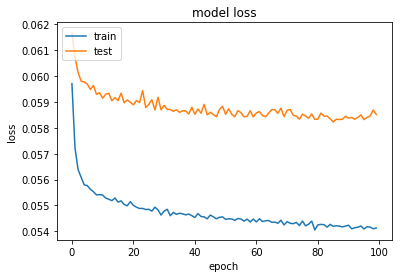

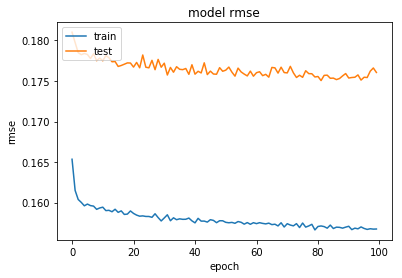

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(5892, 25, 3) (5892, 10, 3)


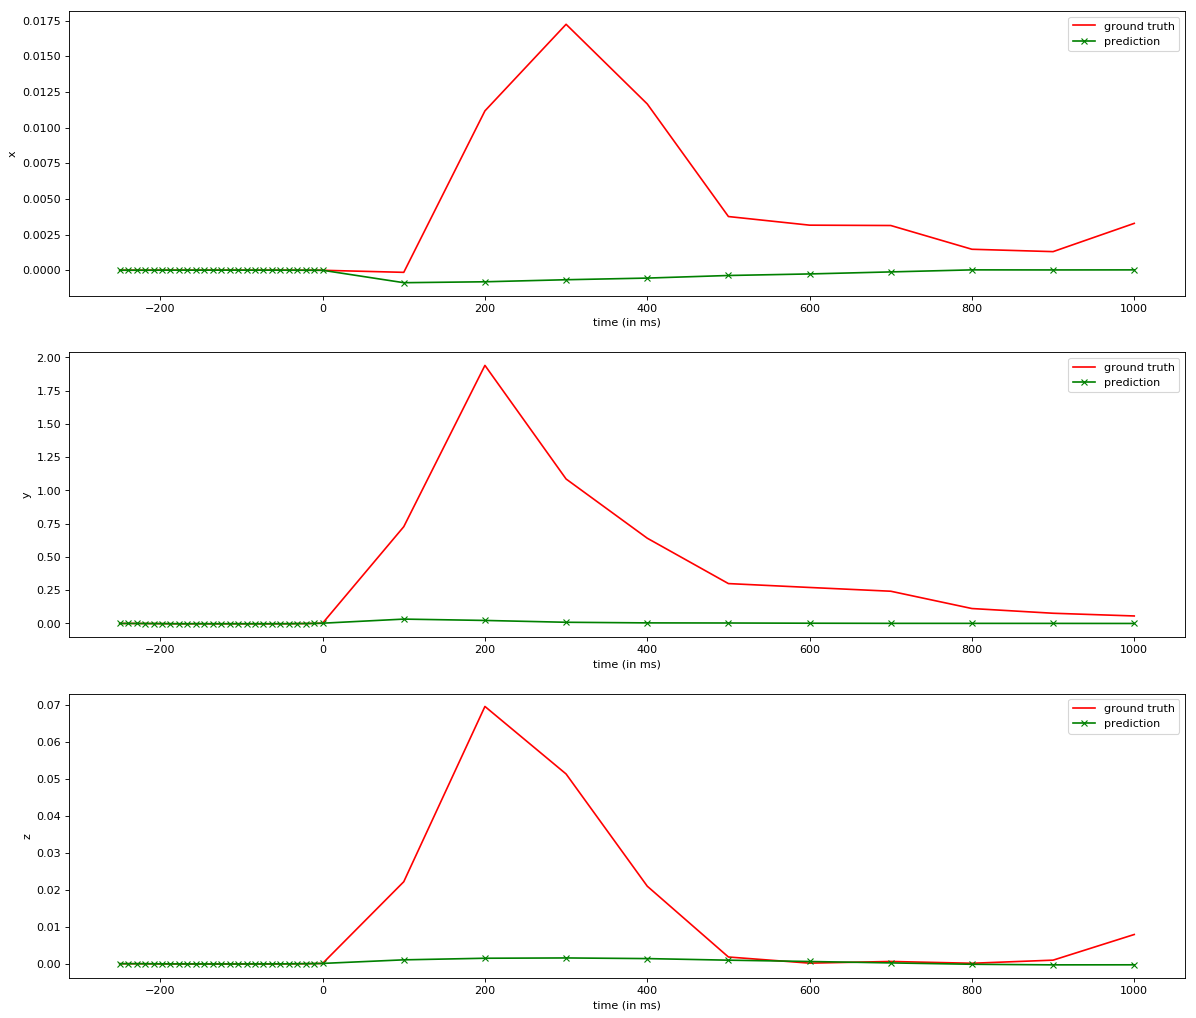

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  50.916656494140625 s =  0.8486109534899394 min =  0.014143516023953756 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05729713258355141
Delay 100 ms: 0.003947389525953976
Delay 200 ms: 0.012302978999625302
Delay 300 ms: 0.02335705299137113
Delay 400 ms: 0.03575934638019071
Delay 500 ms: 0.048873714295618625
Delay 600 ms: 0.06240982807289165
Delay 700 ms: 0.0761227593274107
Delay 800 ms: 0.08985502363296134
Delay 900 ms: 0.1034738832008536
Delay 1000 ms: 0.11686934940863712

RMSE
Average rmse: 0.12151659186202592
Delay 100 ms: 0.010991464377199446
Delay 200 ms: 0.02655972815986015
Delay 300 ms: 0.046786789703377414
Delay 400 ms: 0.0688688527357507
Delay 500 ms: 0.0916132380722323
Delay 600 ms: 0.11450123921265784
Delay 700 ms: 0.1371635039737041
Delay 800 ms: 0.15941505267392925
Delay 900 ms: 0.18111853347153276
Delay 1000 ms: 0.20213642605967558

SMAPE
Average smape: 14.177565119491556
Delay 100 ms: 2.114970984466629
Delay 200 ms: 5.200564491612156
Delay 300 ms: 8.262679956529773
Delay 400 ms: 11.122015596835436
Delay 500 ms: 13.73018143186357
Delay 600 ms: 16.141805160155705
Delay 